### Import Statements

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Helper functions

In [2]:
def showImg(img, title = ''):
    plt.figure(figsize = (10,10));
    plt.title(title)
    plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))

def showGrayScaleImg(img, title = ''):
    plt.figure(figsize = (10,10));
    plt.title(title)
    plt.imshow(img, cmap='gray')

all_contours = -1
green = (0,255,0)
thickness = 2

### Importem la imatge en color i escala de grisos

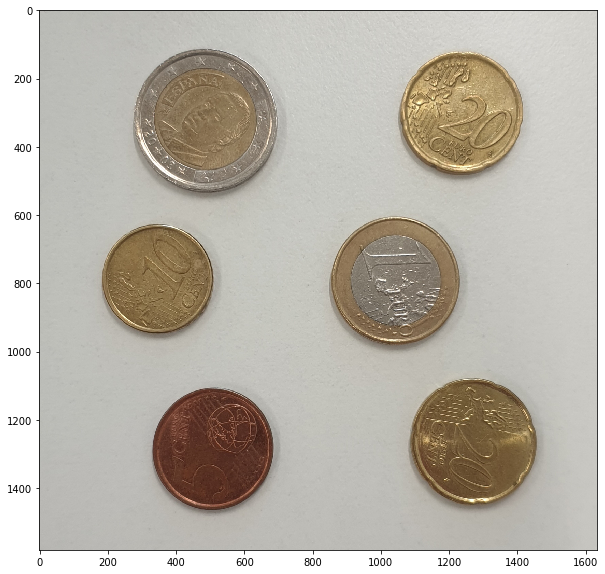

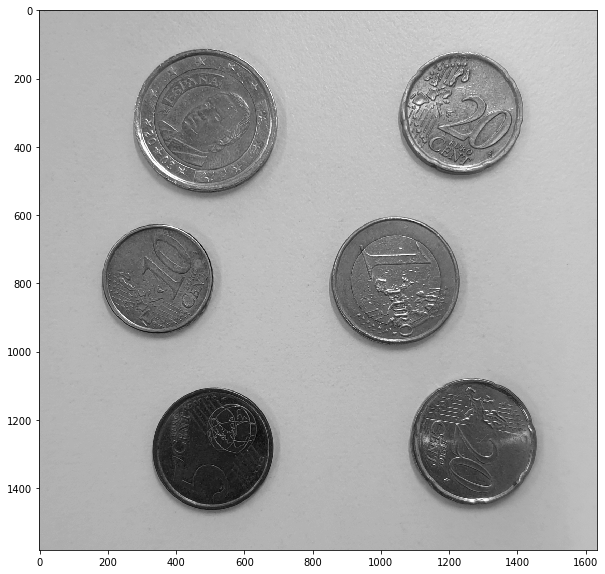

In [27]:
coin = cv2.imread("img/coins1.jpg")
coin_g = cv2.imread("img/coins1.jpg",0)

showImg(coin)
showGrayScaleImg(coin_g)

### Processem una mica la imatge


1


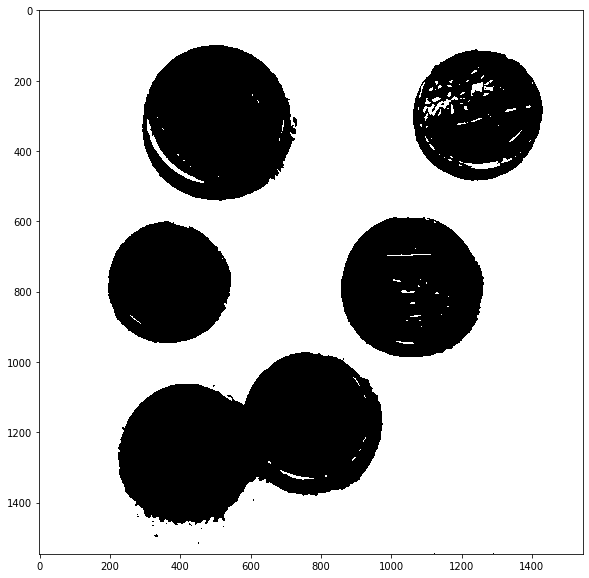

In [119]:
coin = cv2.imread("img/coin2.jpg")
coin_g = cv2.imread("img/coin2.jpg",0)

gaussian = cv2.GaussianBlur(coin_g,(13,13),-1)

#thres_binary_inverted = cv2.adaptiveThreshold(gaussian, 250,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY_INV,199,32)
ret2, thres_binary_inverted = cv2.threshold(gaussian,180,255,cv2.THRESH_BINARY_INV)
_,coin_contorns,_ = cv2.findContours( thres_binary_inverted, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    
showGrayScaleImg(thres_binary_inverted)


sorted_contours = sorted(coin_contorns, key=cv2.contourArea ,reverse=True)


print(len(sorted_contours))

I've found 6 coins


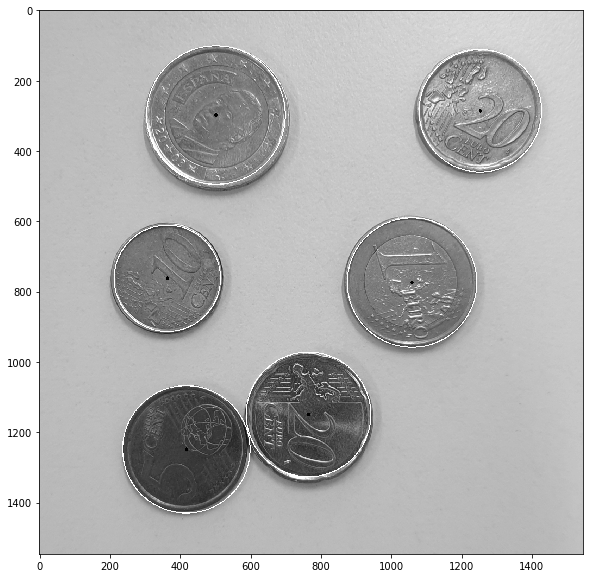

In [129]:

coin_g = cv2.imread("img/coin2.jpg",0)

circles = cv2.HoughCircles(gaussian, cv2.HOUGH_GRADIENT, dp = 1.2, minDist = 100)

for i in circles[0,:]:
       # draw the outer circle
        cv2.circle(coin_g,(i[0], i[1]), i[2], (255, 0, 0), 2)
      
       # draw the center of the circle
        cv2.circle(coin_g, (i[0], i[1]), 2, (0, 255, 0), 5)
        
    
showGrayScaleImg(coin_g)
print("I've found",len(circles[0,:]),"coins")

# Pytorch

### Train dataset to find coins value

In [130]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

In [133]:
data_dir = 'CoinsData/train'
def load_split_train_test(datadir, valid_size = .2):
    train_transforms = transforms.Compose([transforms.Resize(224),
                                       transforms.ToTensor(),
                                       ])
    test_transforms = transforms.Compose([transforms.Resize(224),
                                      transforms.ToTensor(),
                                      ])
    train_data = datasets.ImageFolder(datadir,       
                    transform=train_transforms)
    test_data = datasets.ImageFolder(datadir,
                    transform=test_transforms)
    num_train = len(train_data)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    np.random.shuffle(indices)
    from torch.utils.data.sampler import SubsetRandomSampler
    train_idx, test_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(test_idx)
    trainloader = torch.utils.data.DataLoader(train_data,
                   sampler=train_sampler, batch_size=64)
    testloader = torch.utils.data.DataLoader(test_data,
                   sampler=test_sampler, batch_size=64)
    return trainloader, testloader
trainloader, testloader = load_split_train_test(data_dir, .2)
print(trainloader.dataset.classes)

['10c', '1c', '1e', '20c', '2c', '2e', '50c', '5c']


In [134]:
device = torch.device("cuda" if torch.cuda.is_available() 
                                  else "cpu")
model = models.resnet50(pretrained=True)
print(model)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /Users/yok3r/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:06<00:00, 15.7MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [141]:
for param in model.parameters():
    param.requires_grad = False
    
model.fc = nn.Sequential(nn.Linear(2048, 512),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(512, len(trainloader.dataset.classes)),
                                 nn.LogSoftmax(dim=1))
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.003)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### Train the model

In [ ]:
epochs = 3
steps = 0
running_loss = 0
print_every = 1
train_losses, test_losses = [], []

for epoch in range(epochs):
    for inputs, labels in trainloader:
        steps += 1
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs, labels = inputs.to(device),labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    test_loss += batch_loss.item()
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            train_losses.append(running_loss/len(trainloader))
            test_losses.append(test_loss/len(testloader))                    
            print(f"Epoch {epoch+1}/{epochs}|| "
                  f"Train loss: {running_loss/print_every:.3f}|| "
                  f"Test loss: {test_loss/len(testloader):.3f}|| "
                  f"Test accuracy: {accuracy/len(testloader):.3f}")
            running_loss = 0
            model.train()
torch.save(model, 'aerialmodel.pth')

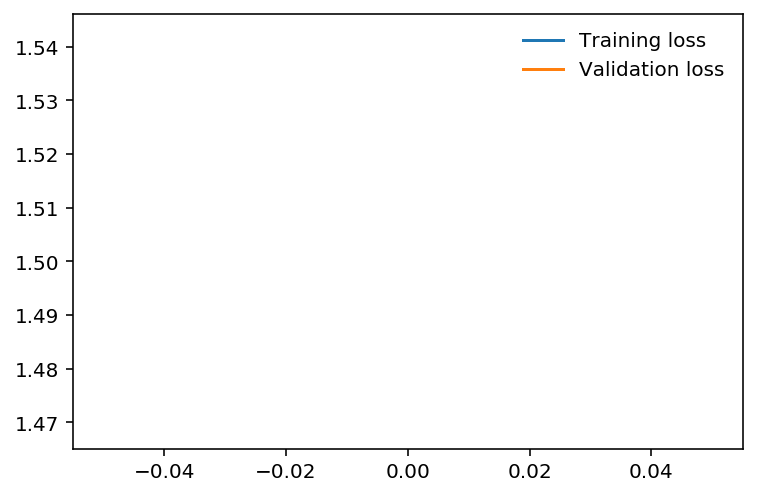

In [144]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

In [ ]:
COntinue with transfer learnign

### Eva's Project

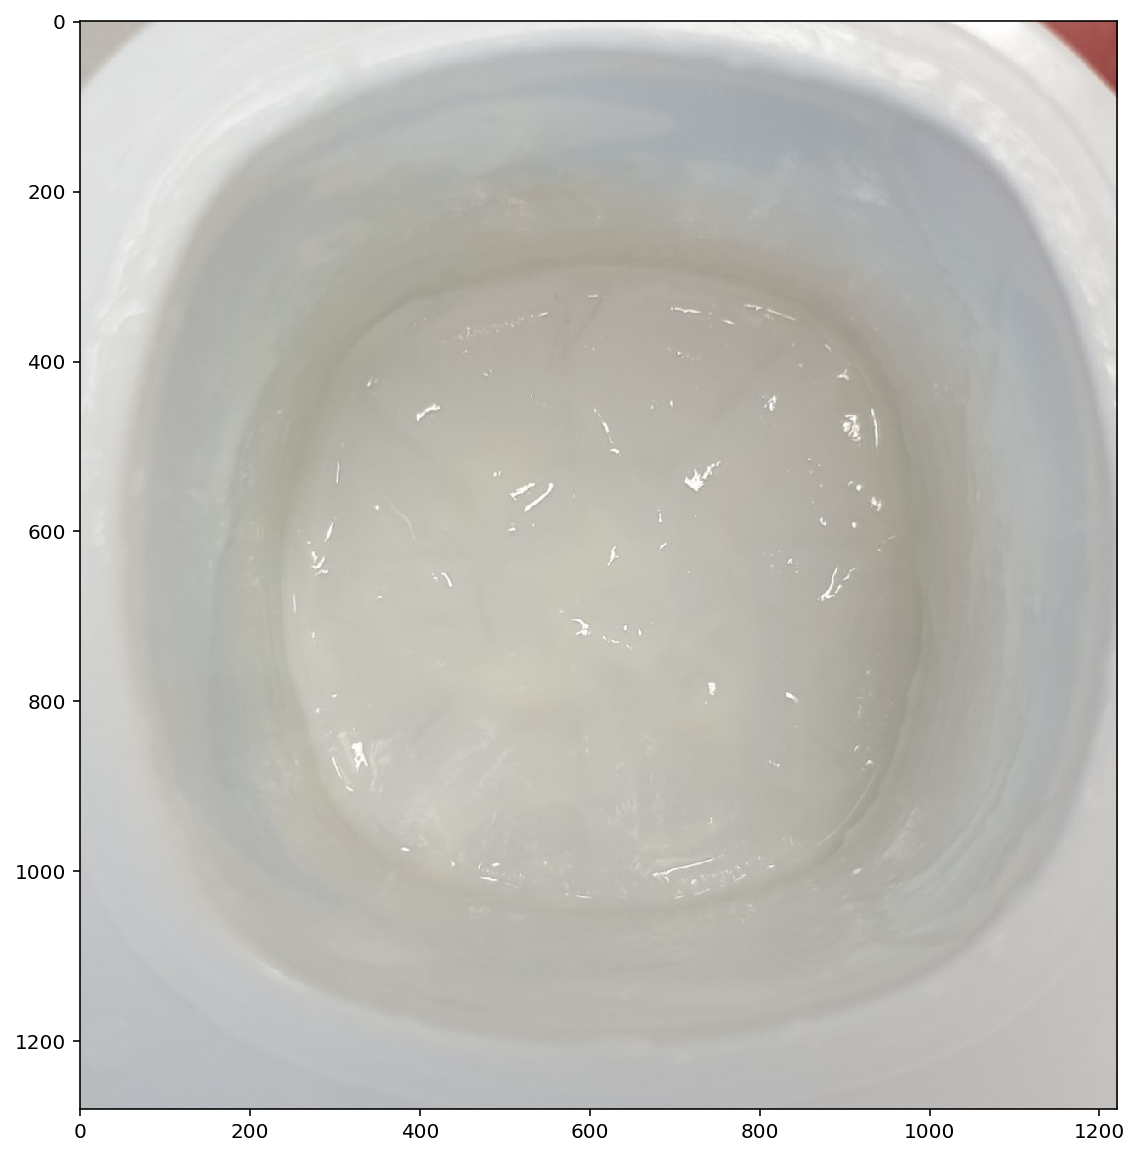

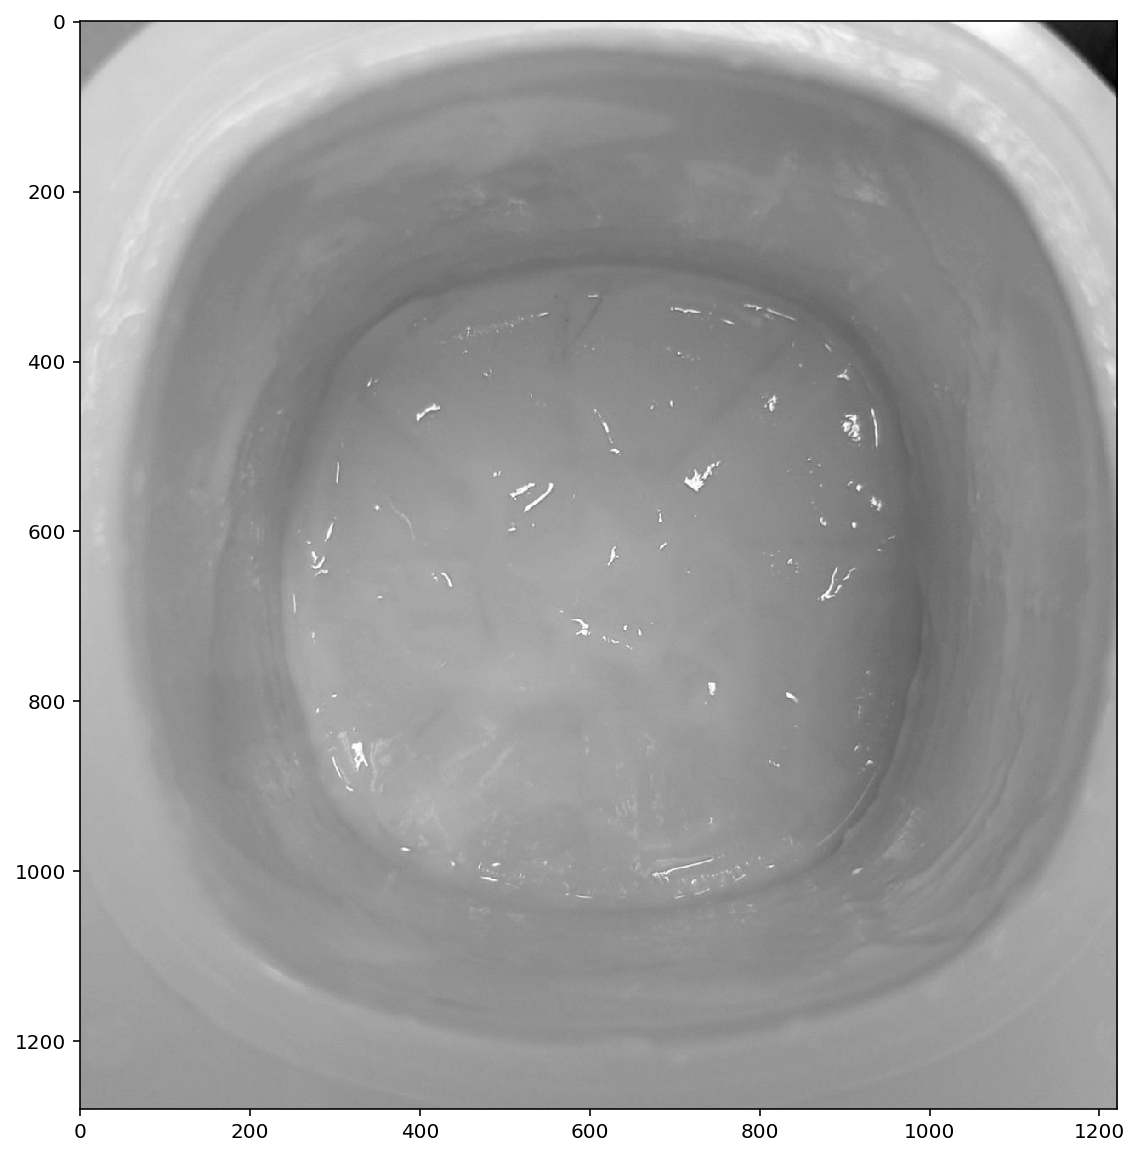

In [146]:
coin = cv2.imread("img/eva.jpeg")
coin_g = cv2.imread("img/eva.jpeg",0)

showImg(coin)
showGrayScaleImg(coin_g)

/Users/yok3r/anaconda3/envs/AkademyAI/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys


1


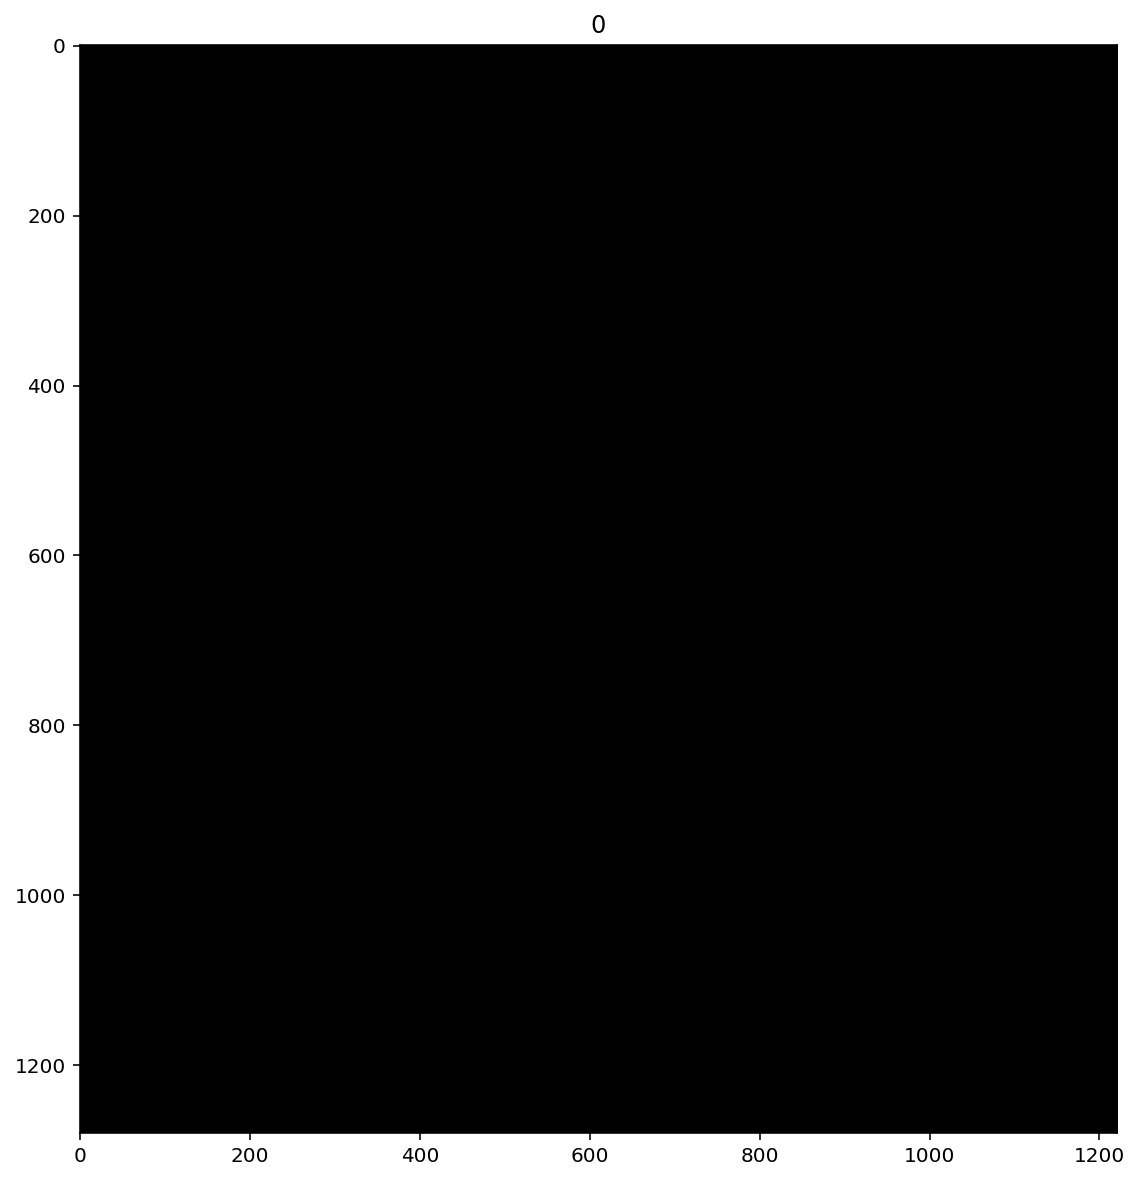

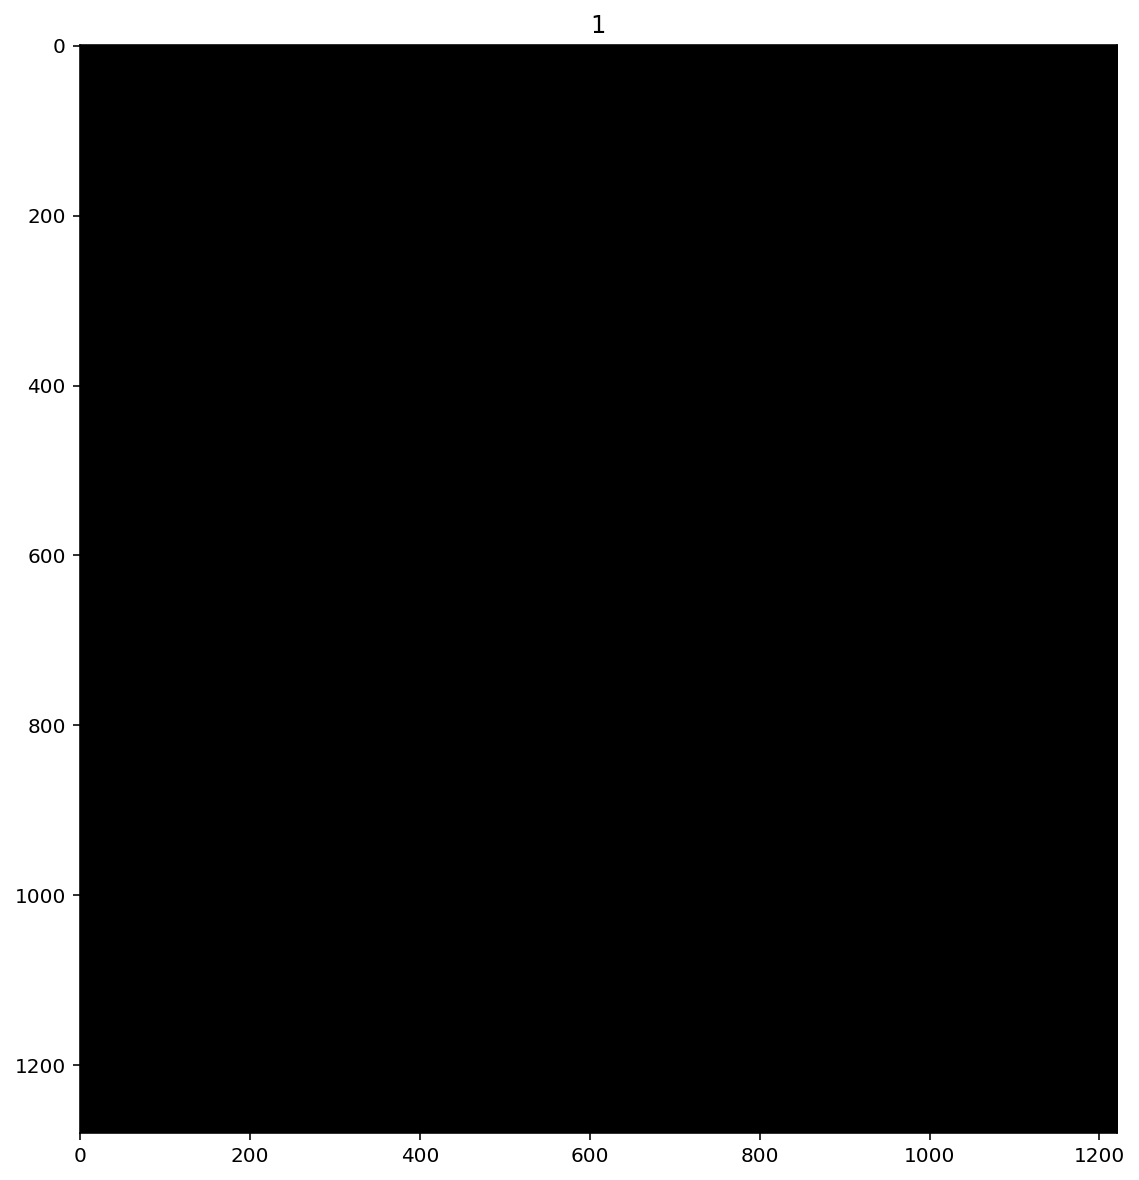

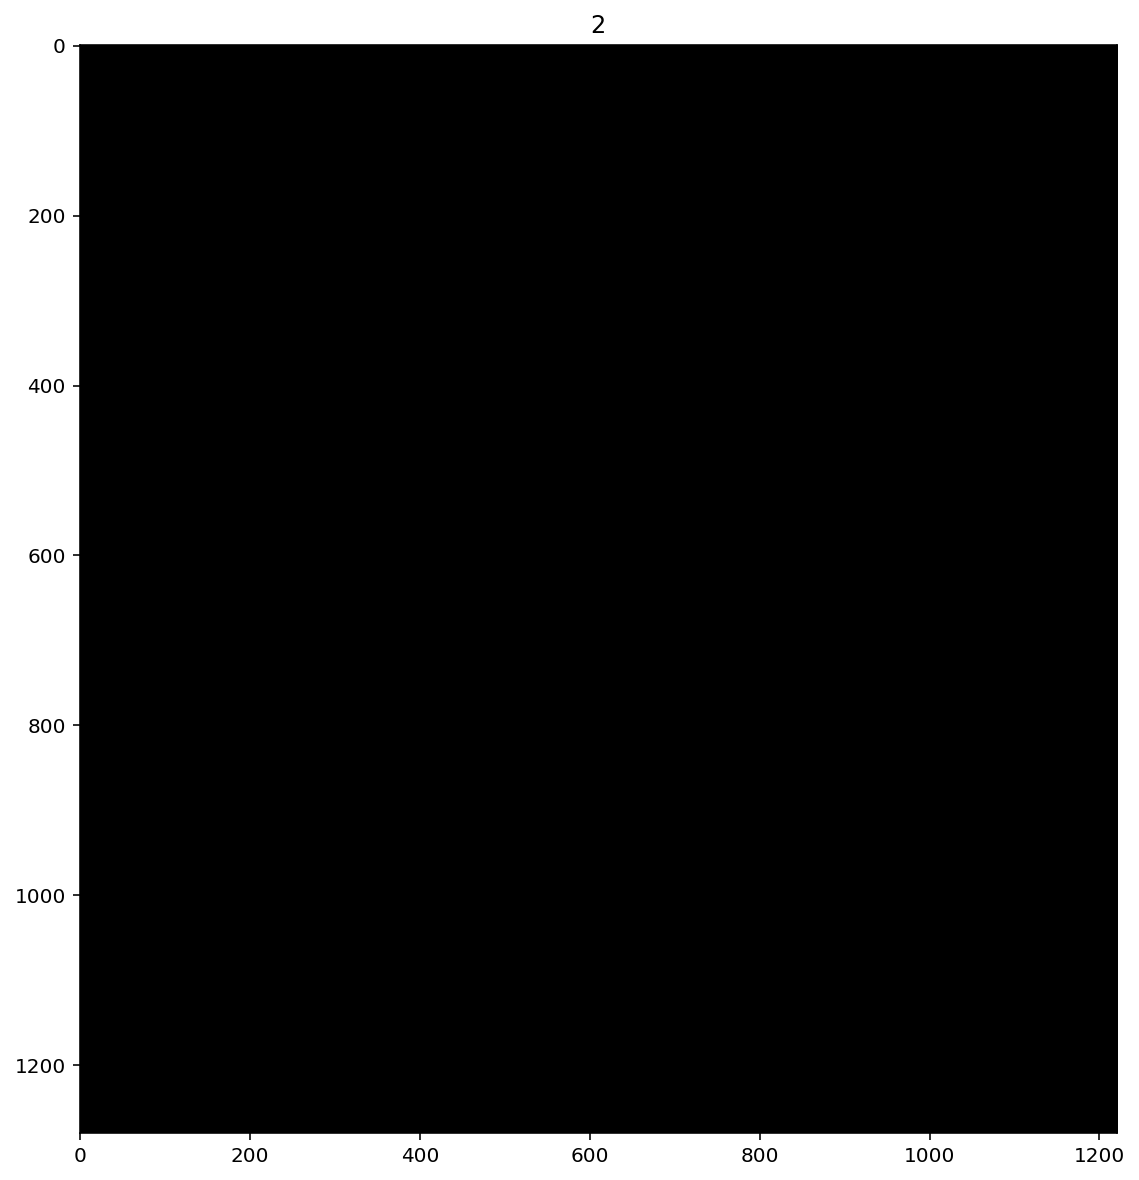

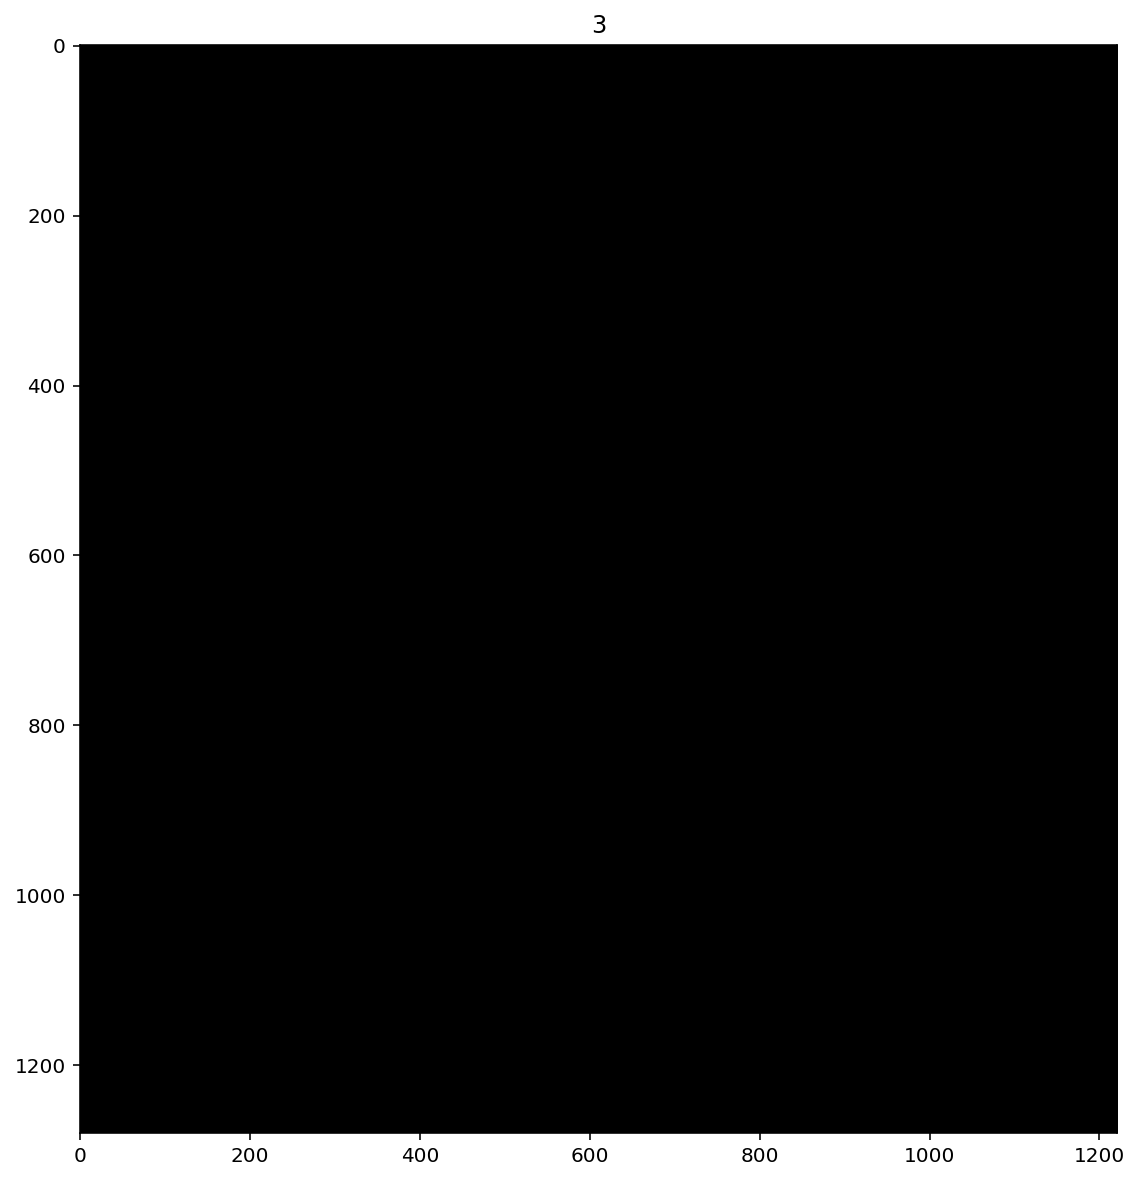

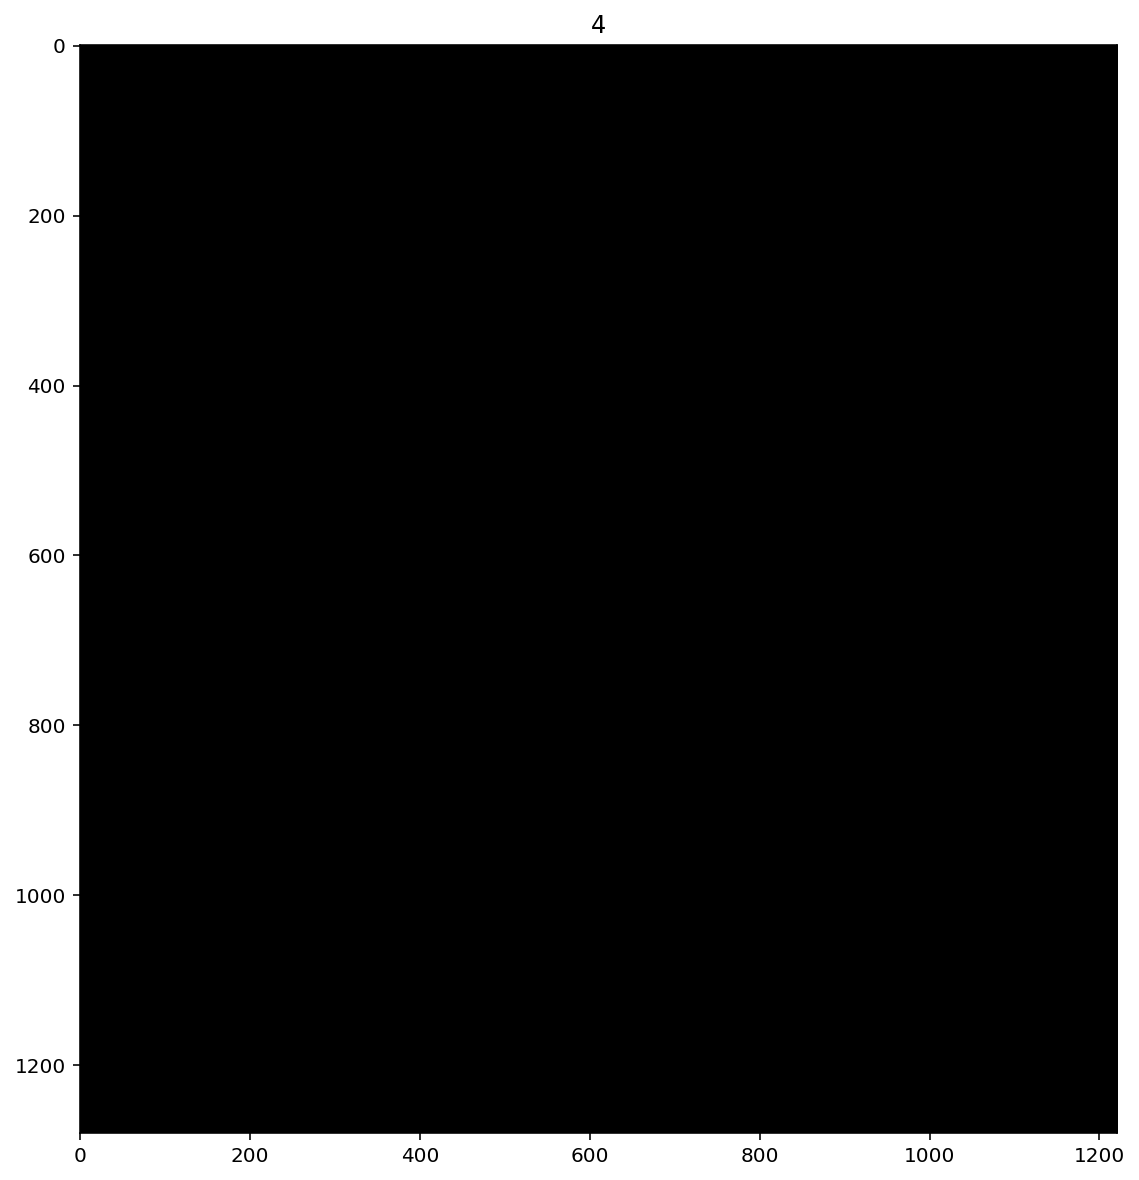

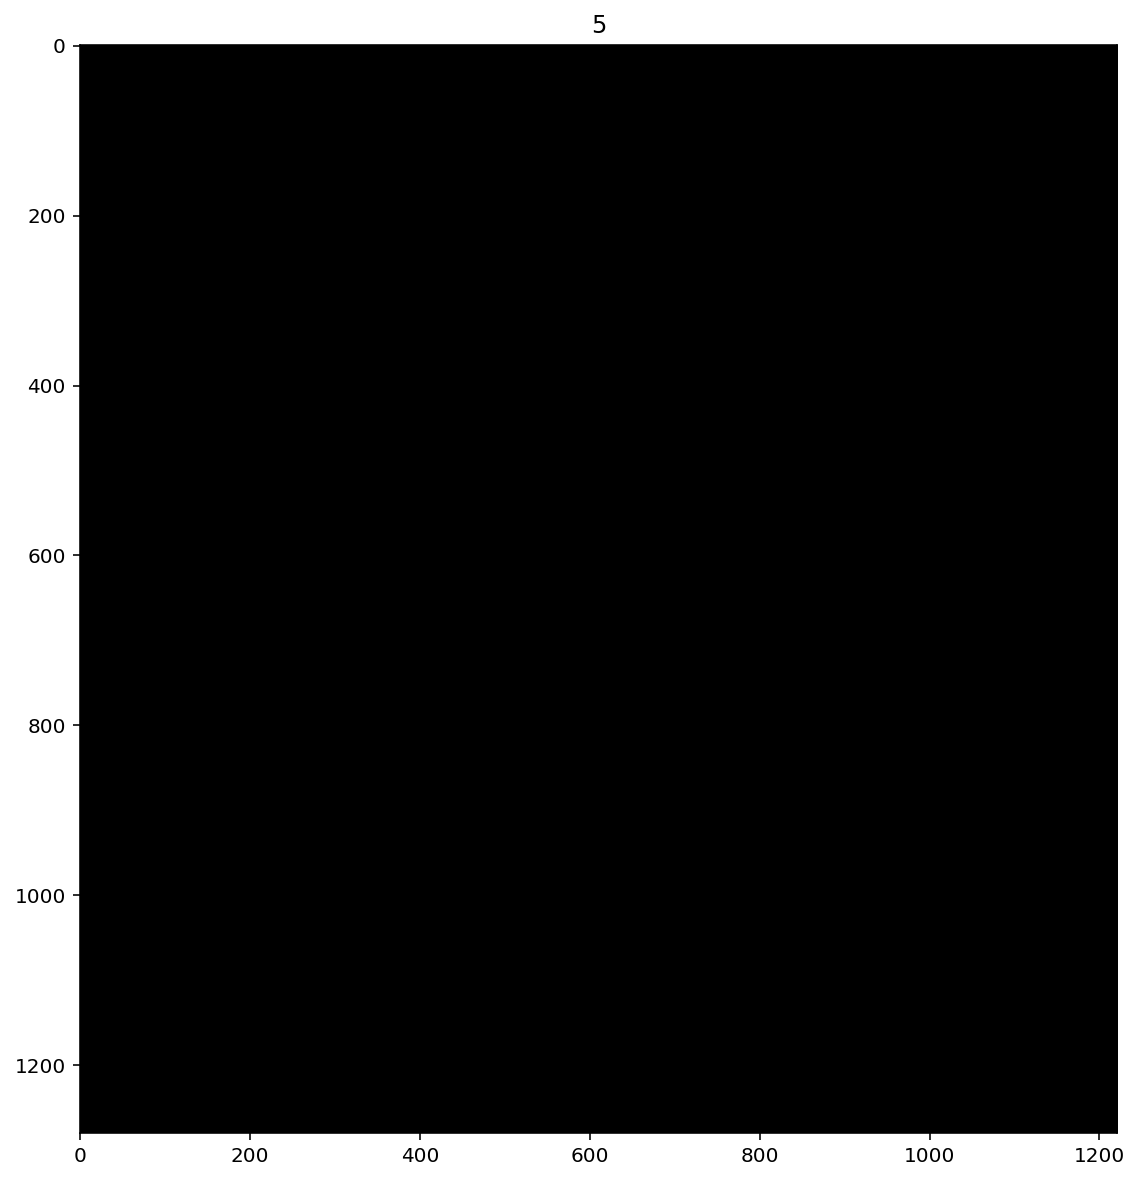

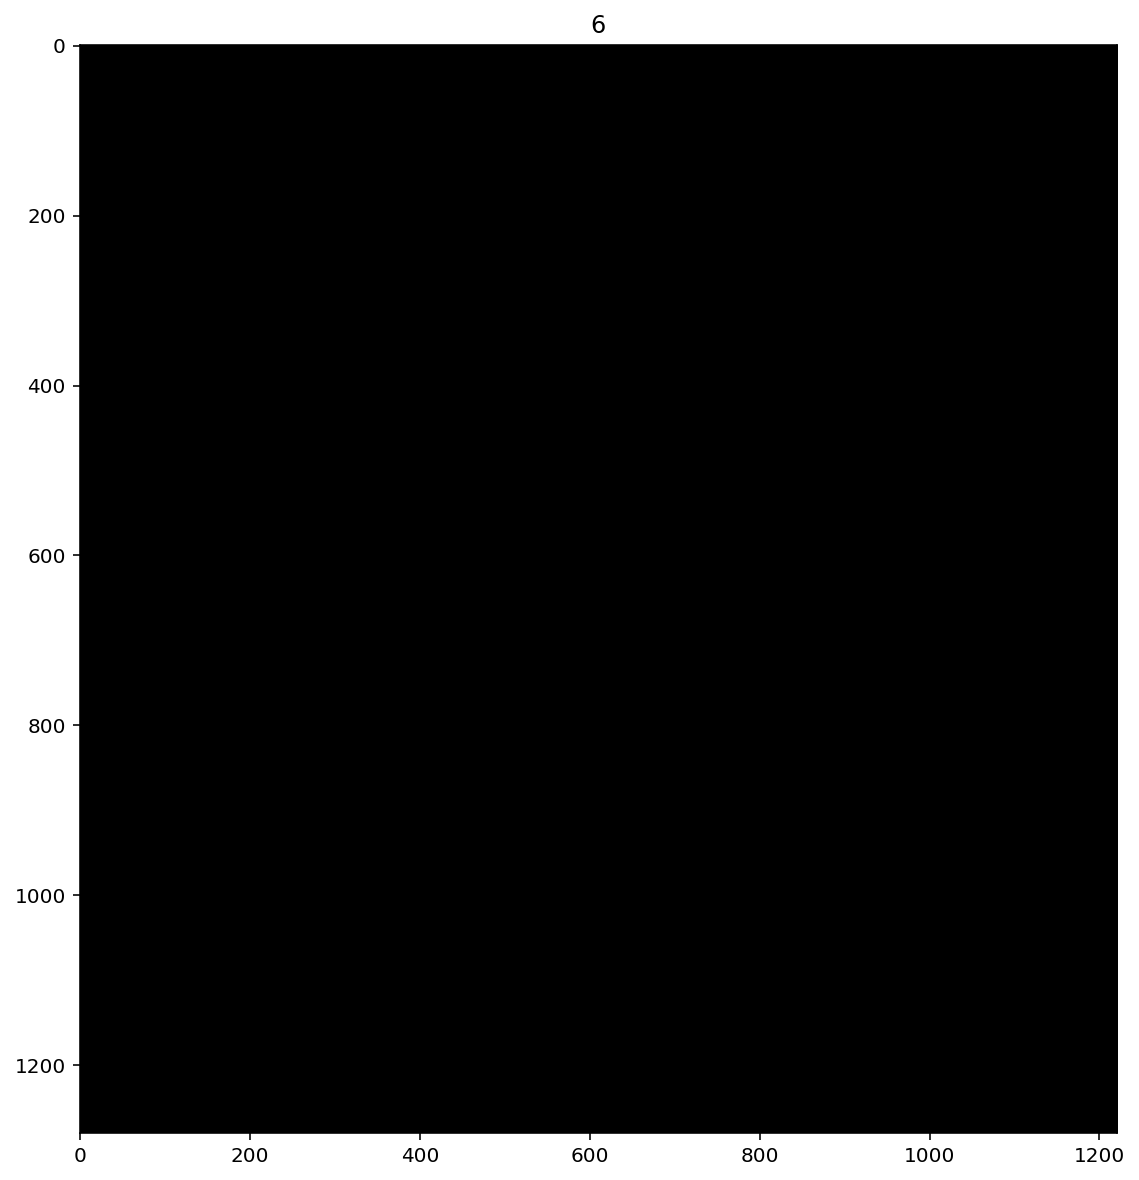

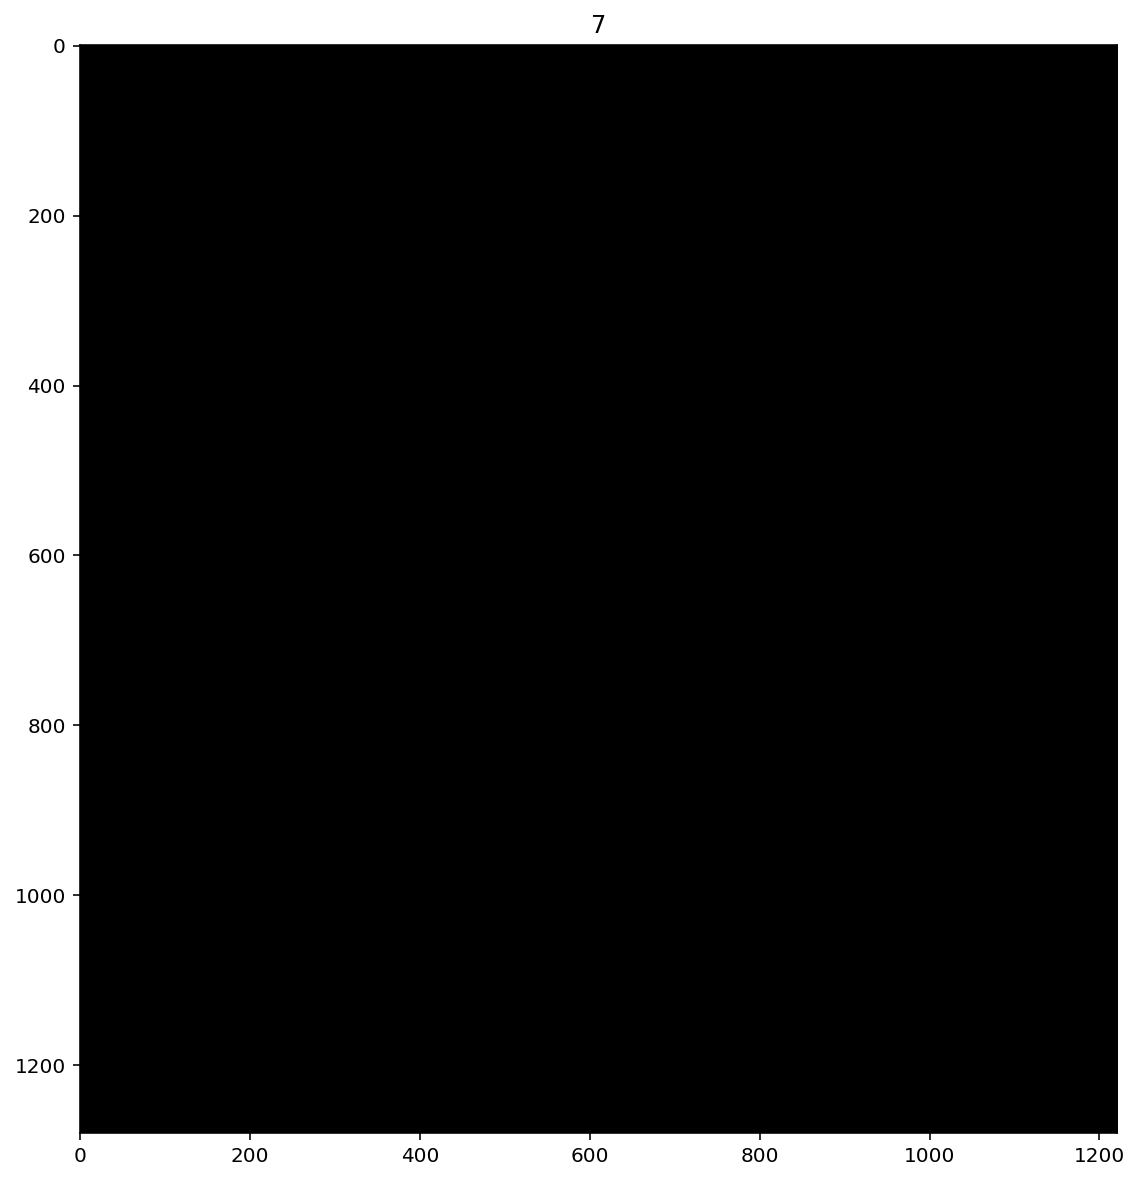

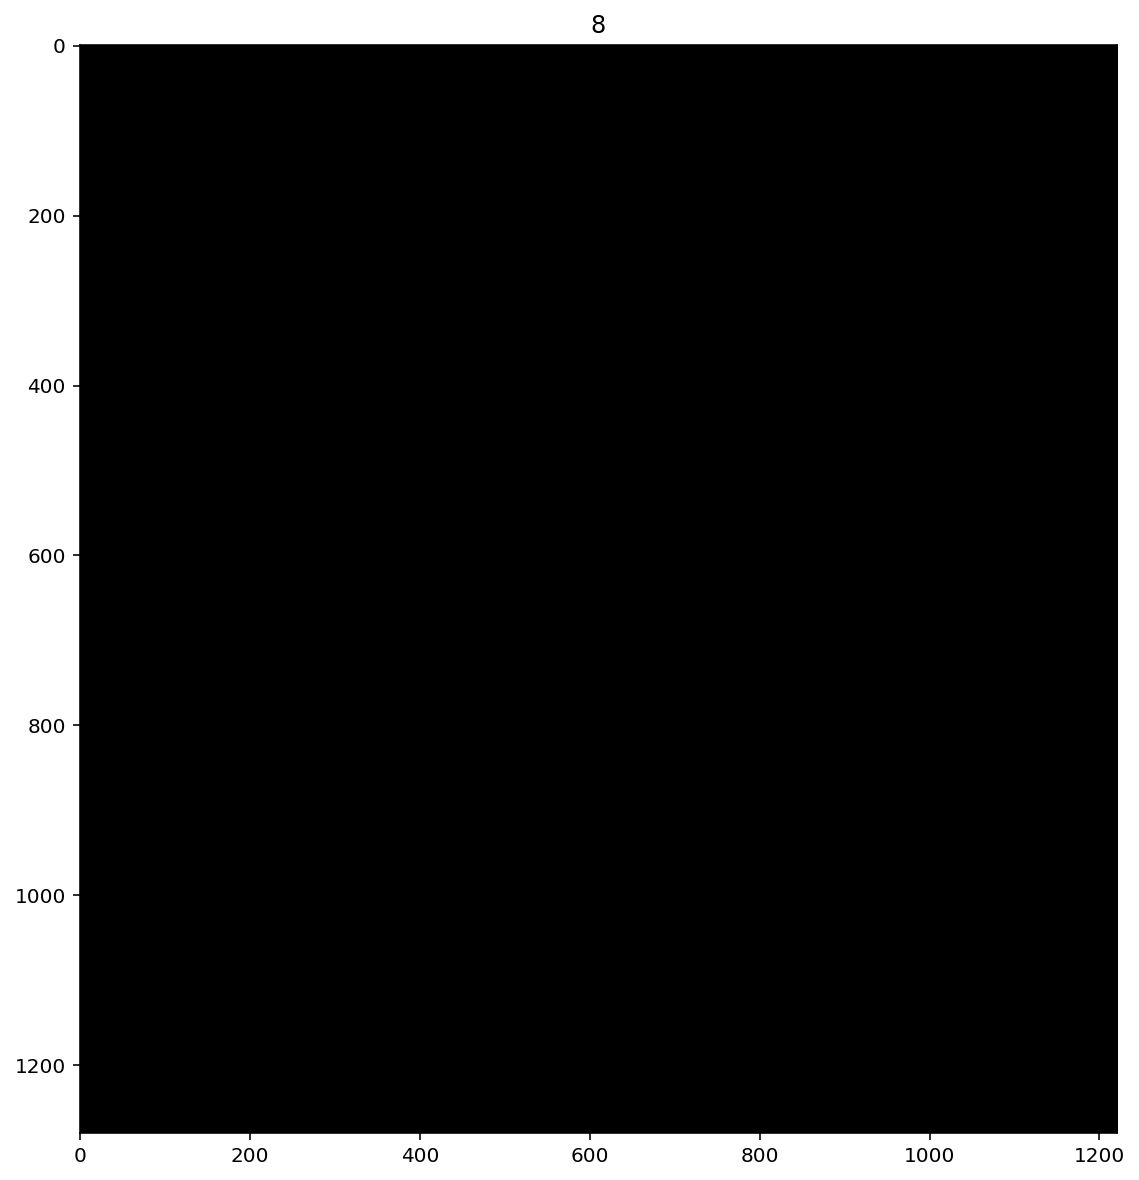

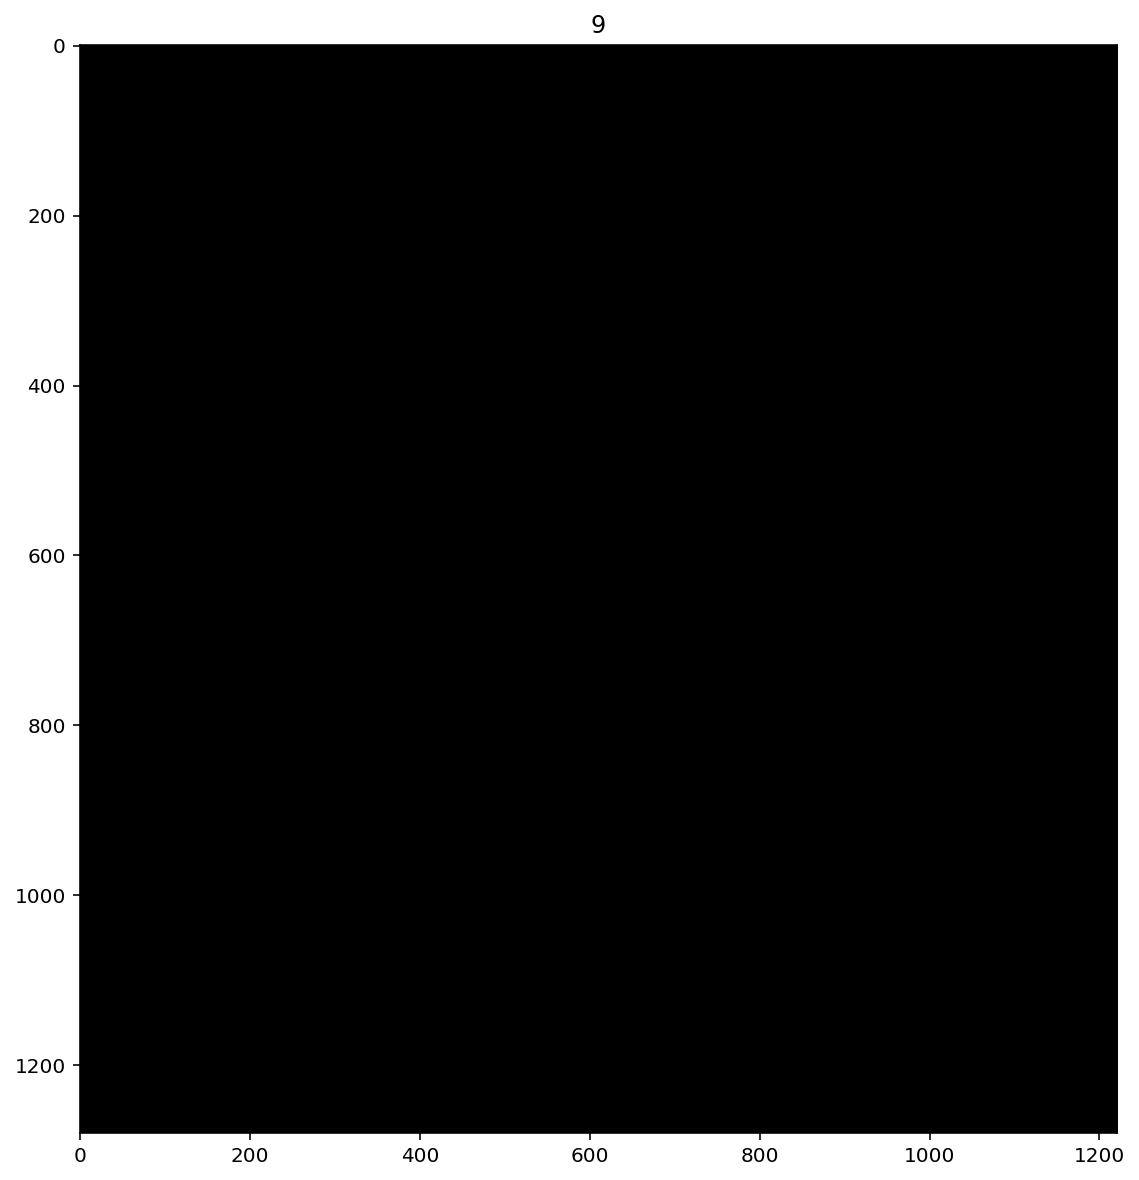

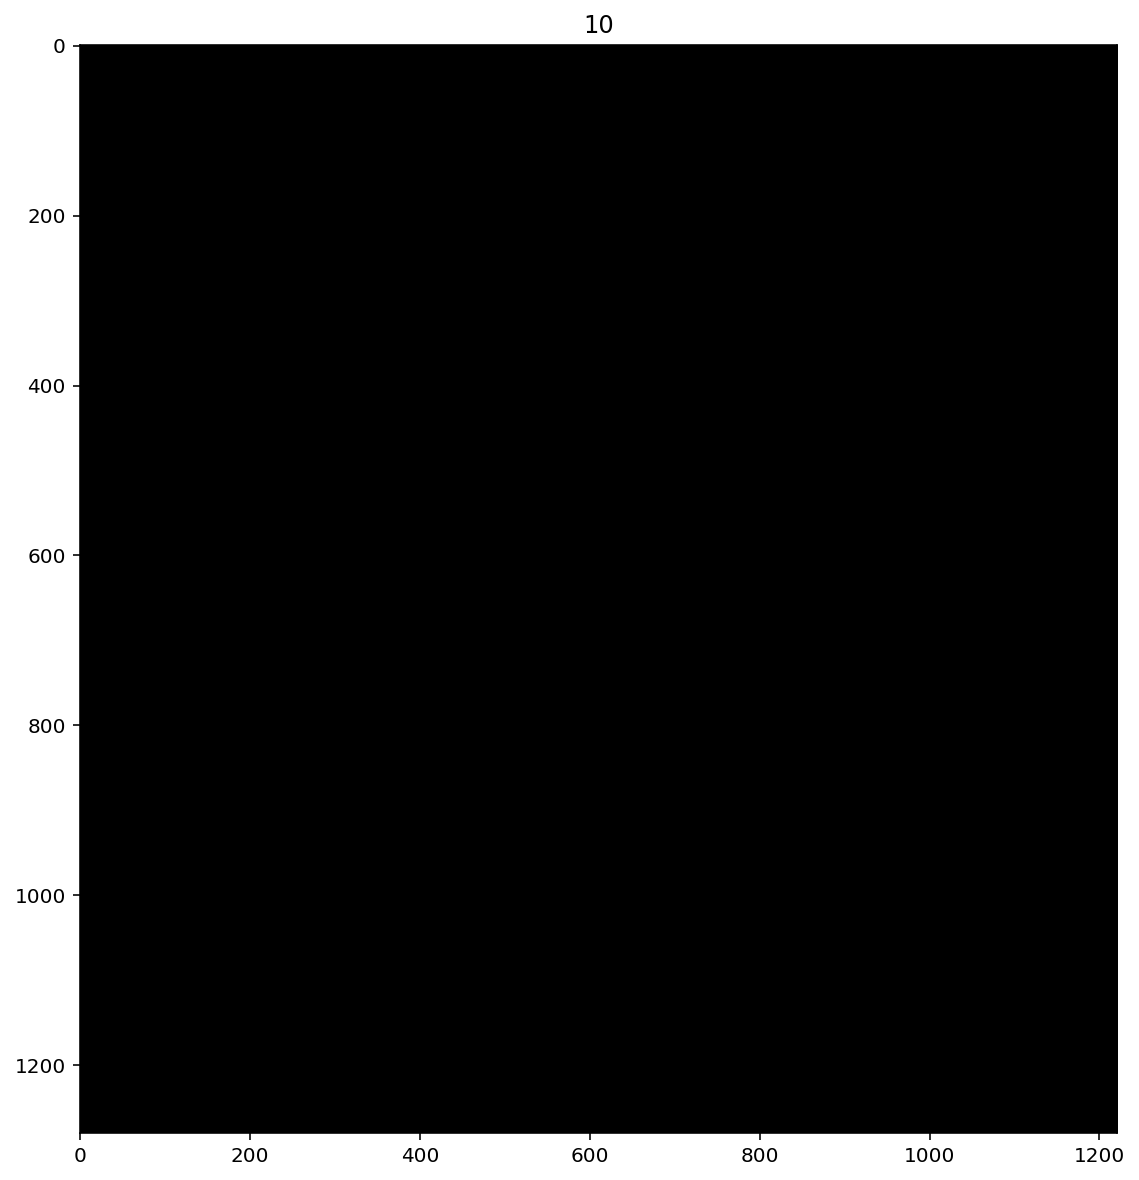

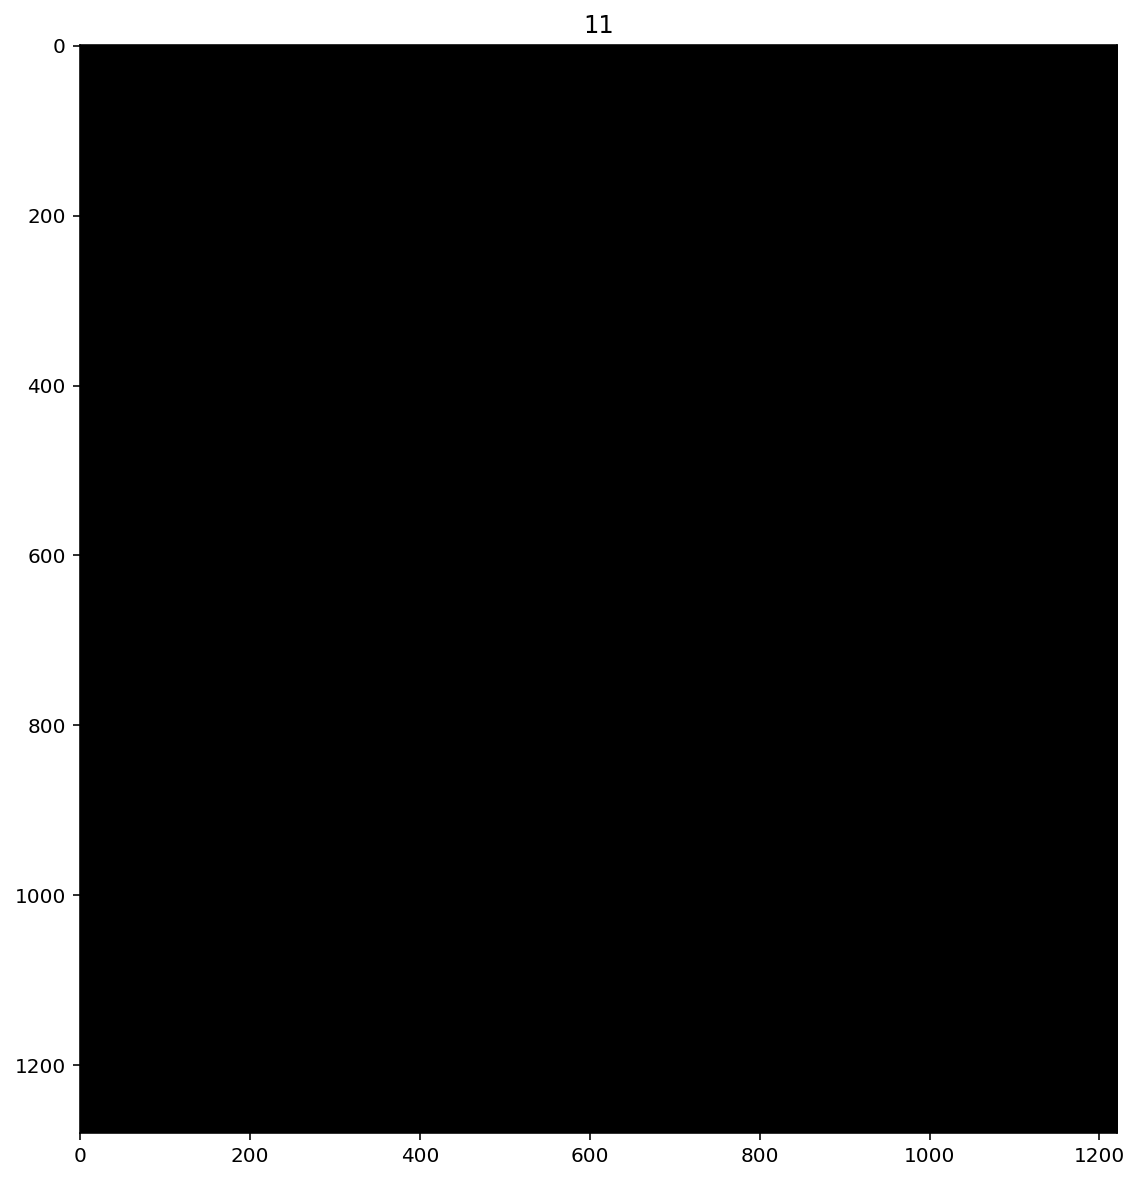

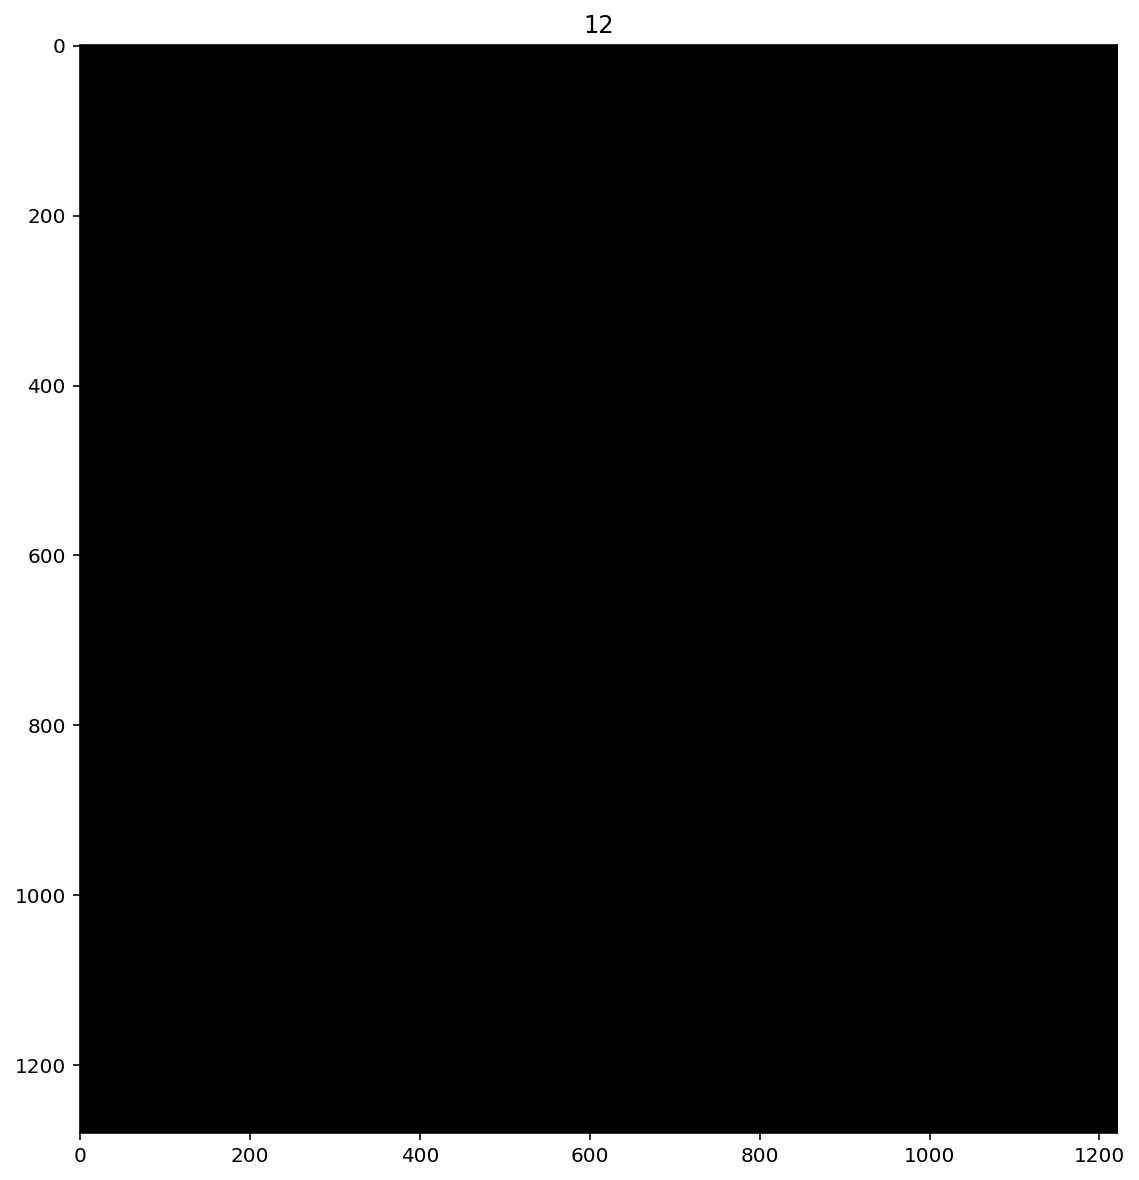

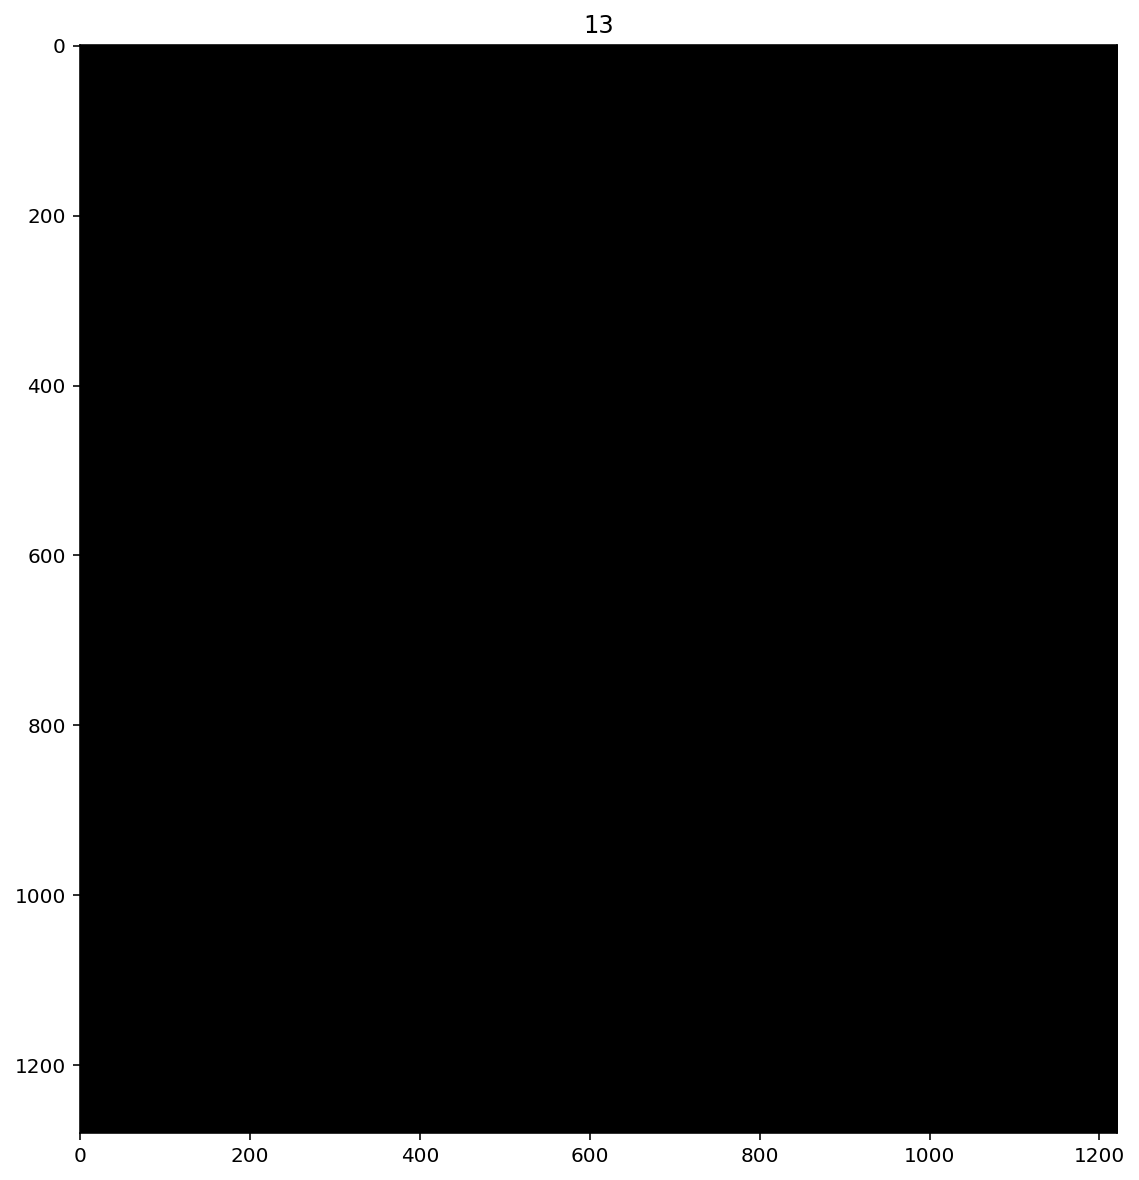

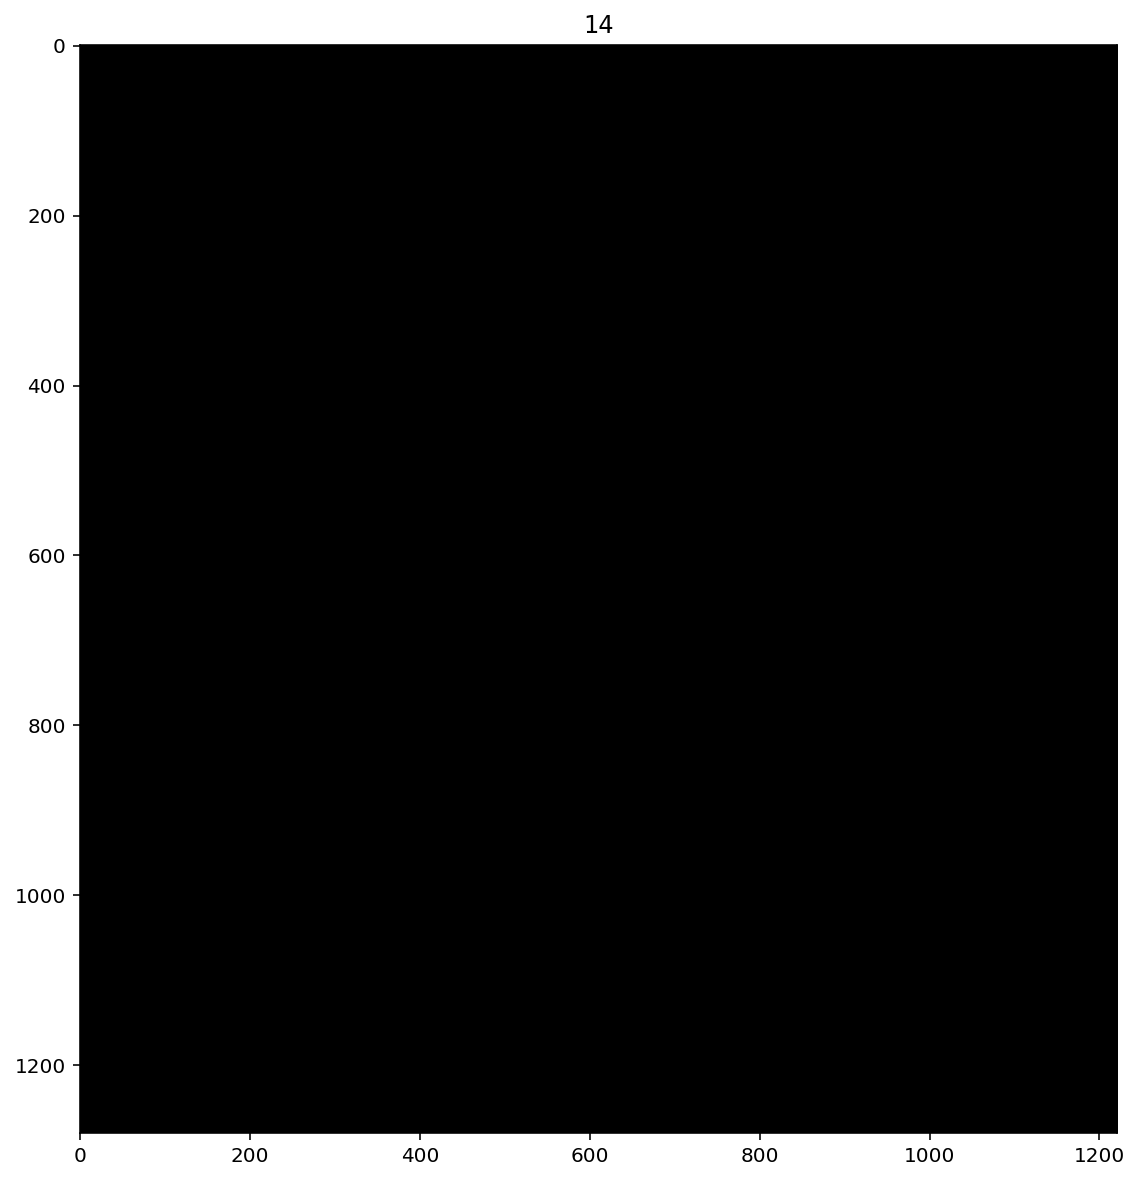

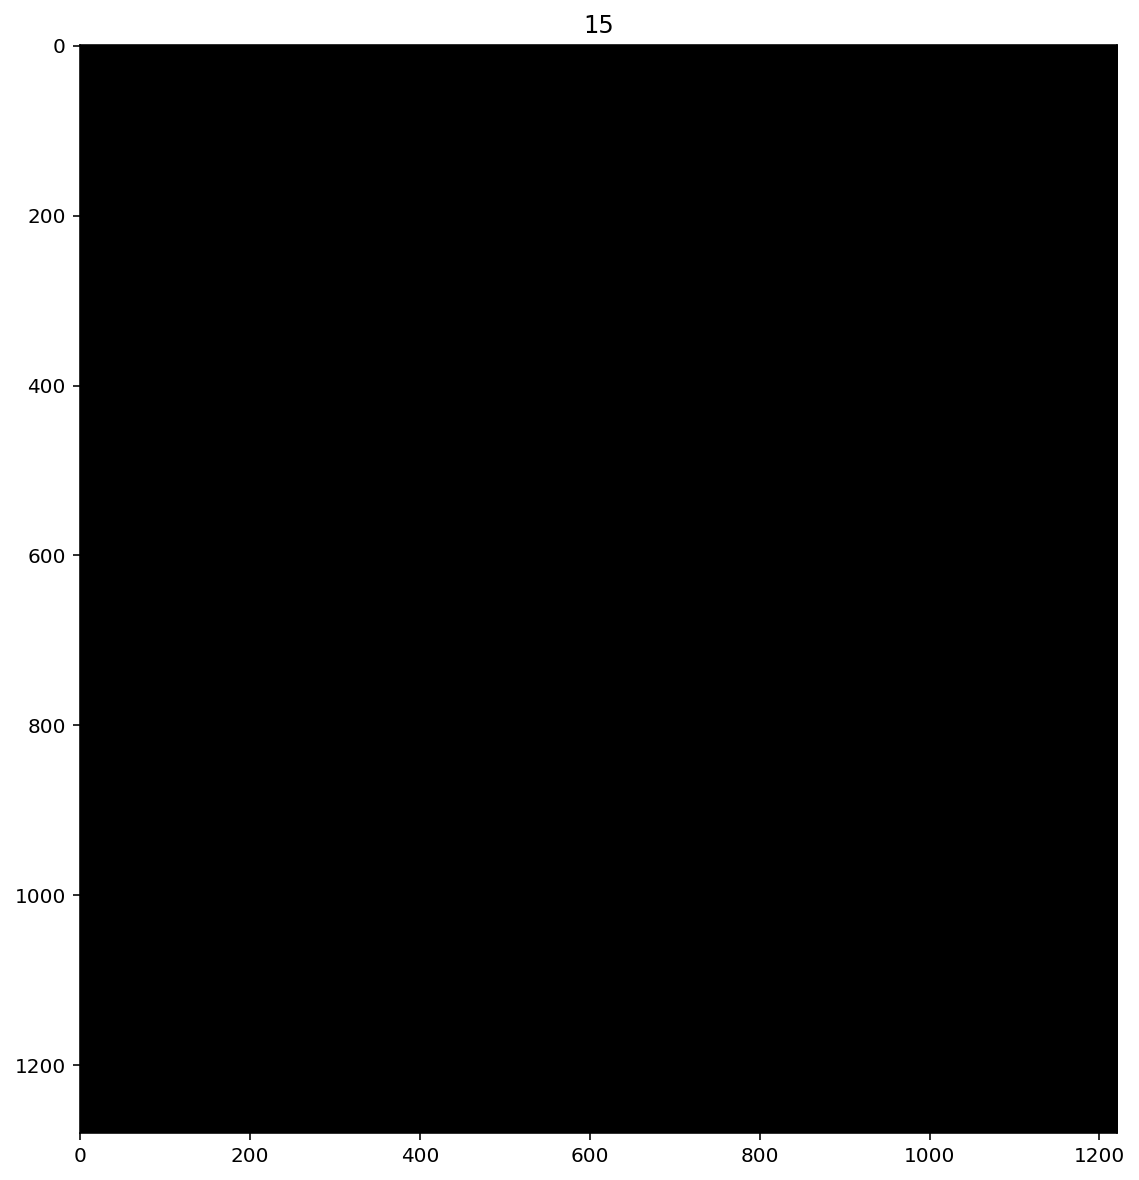

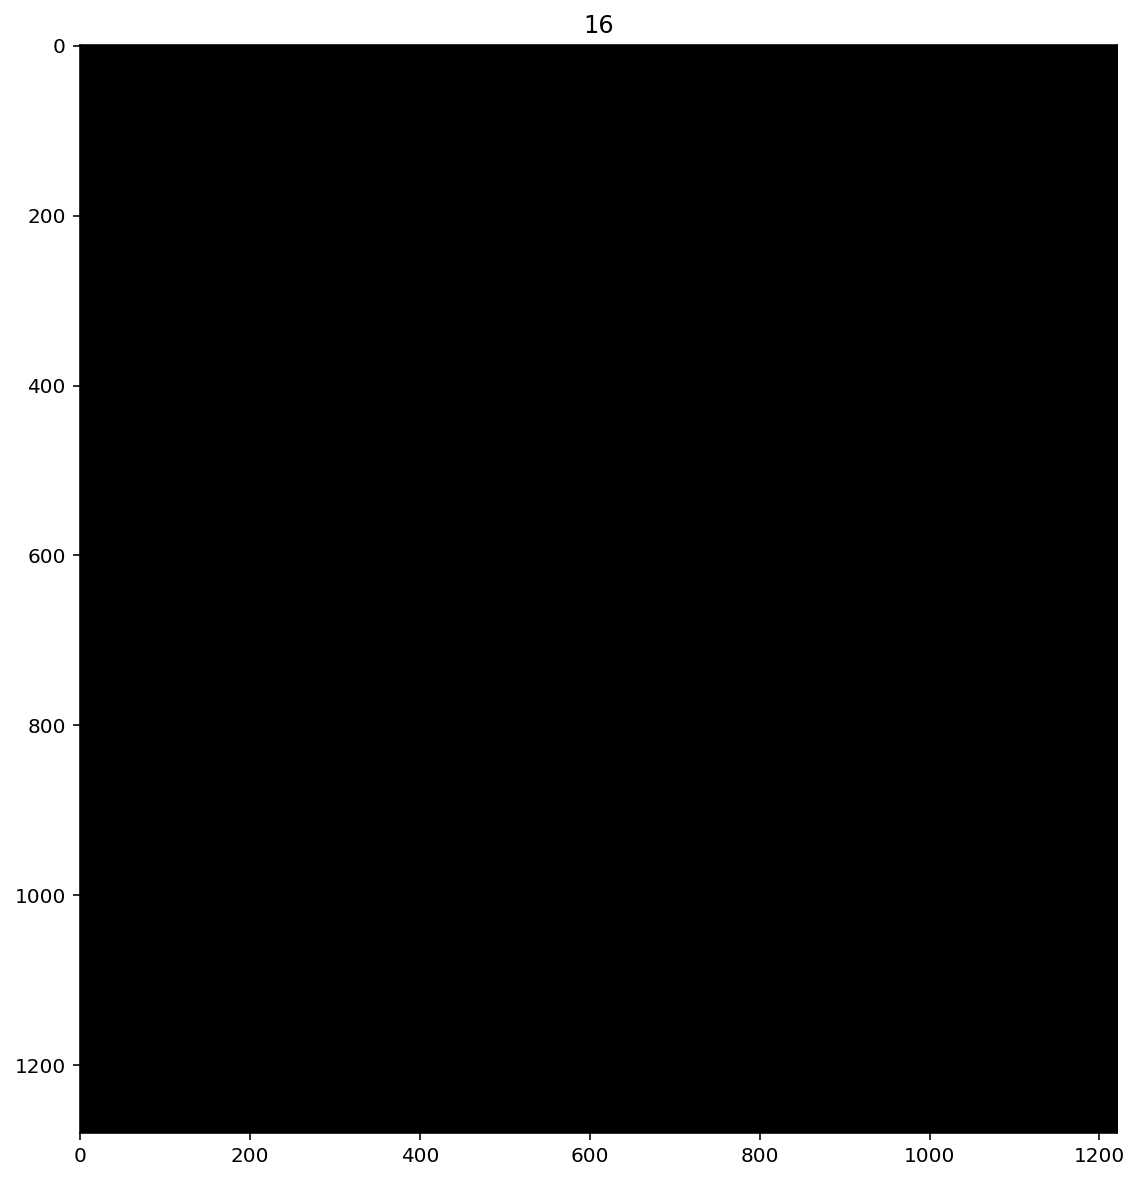

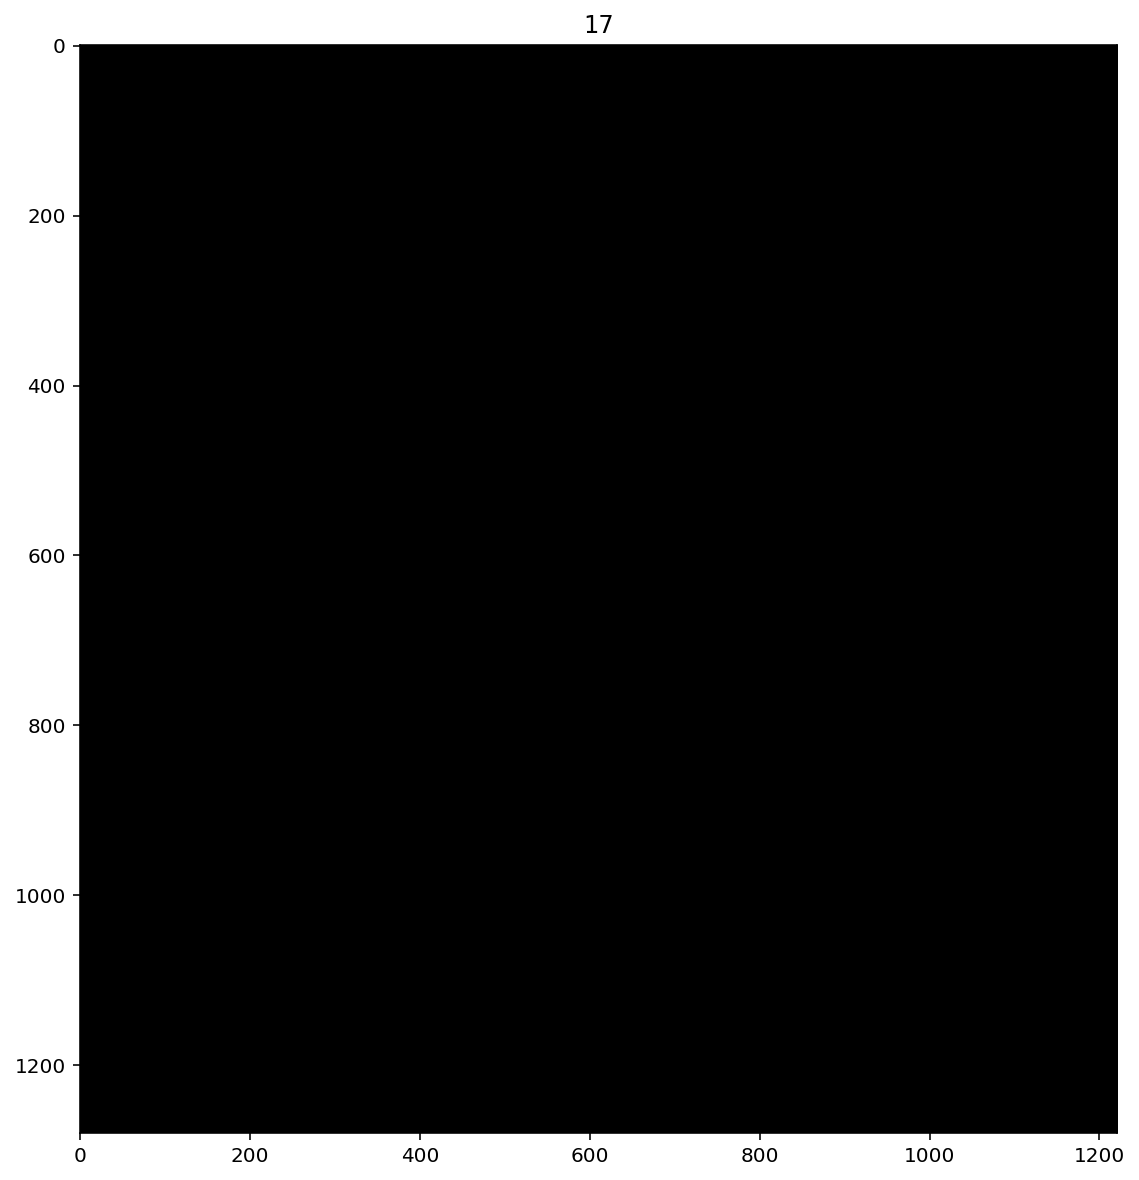

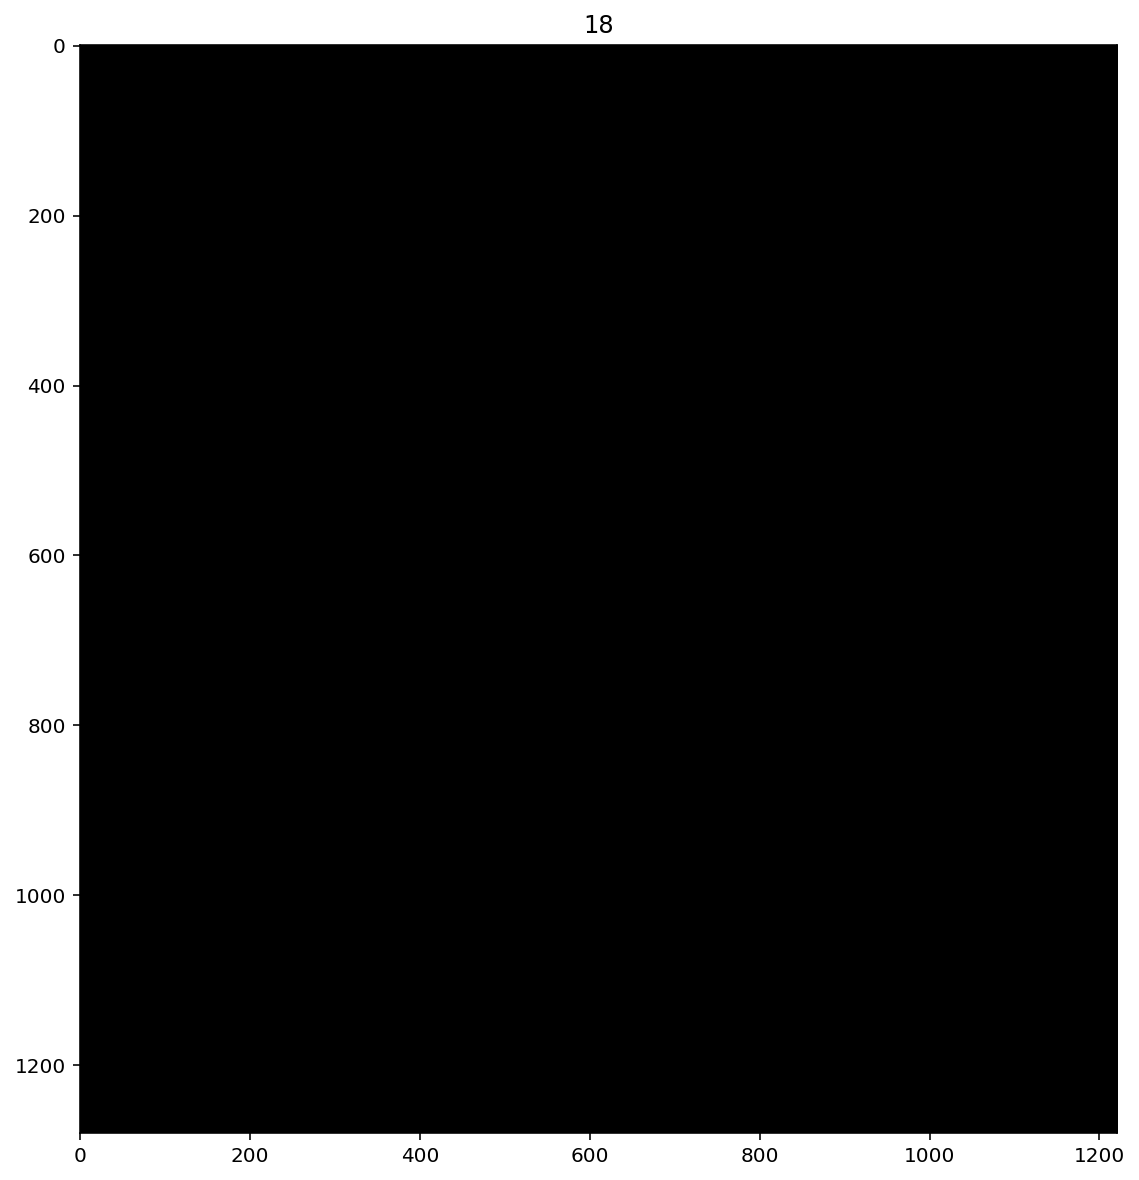

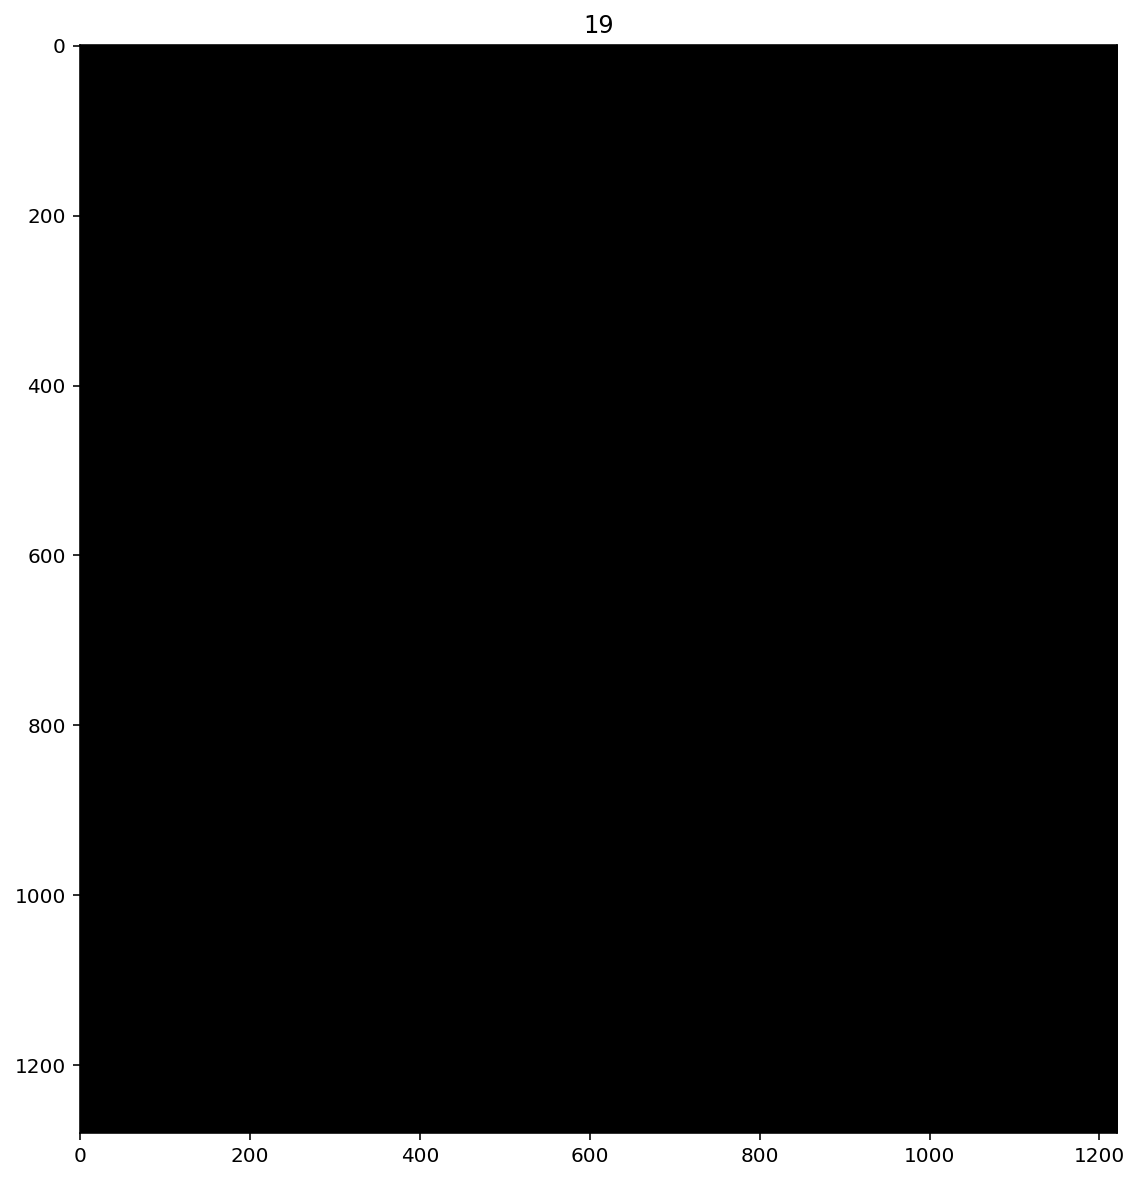

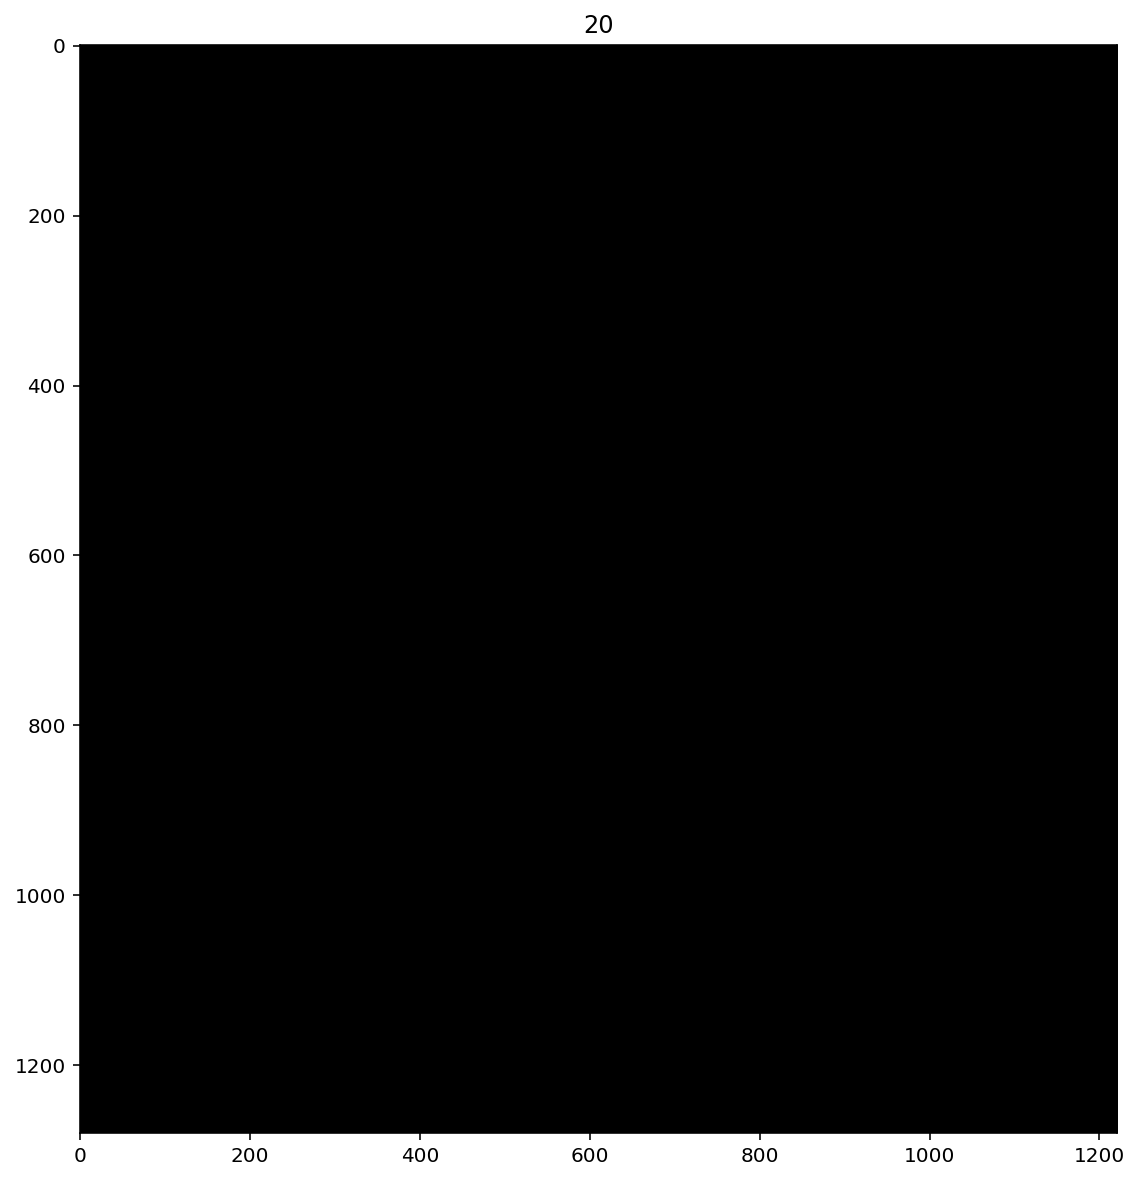

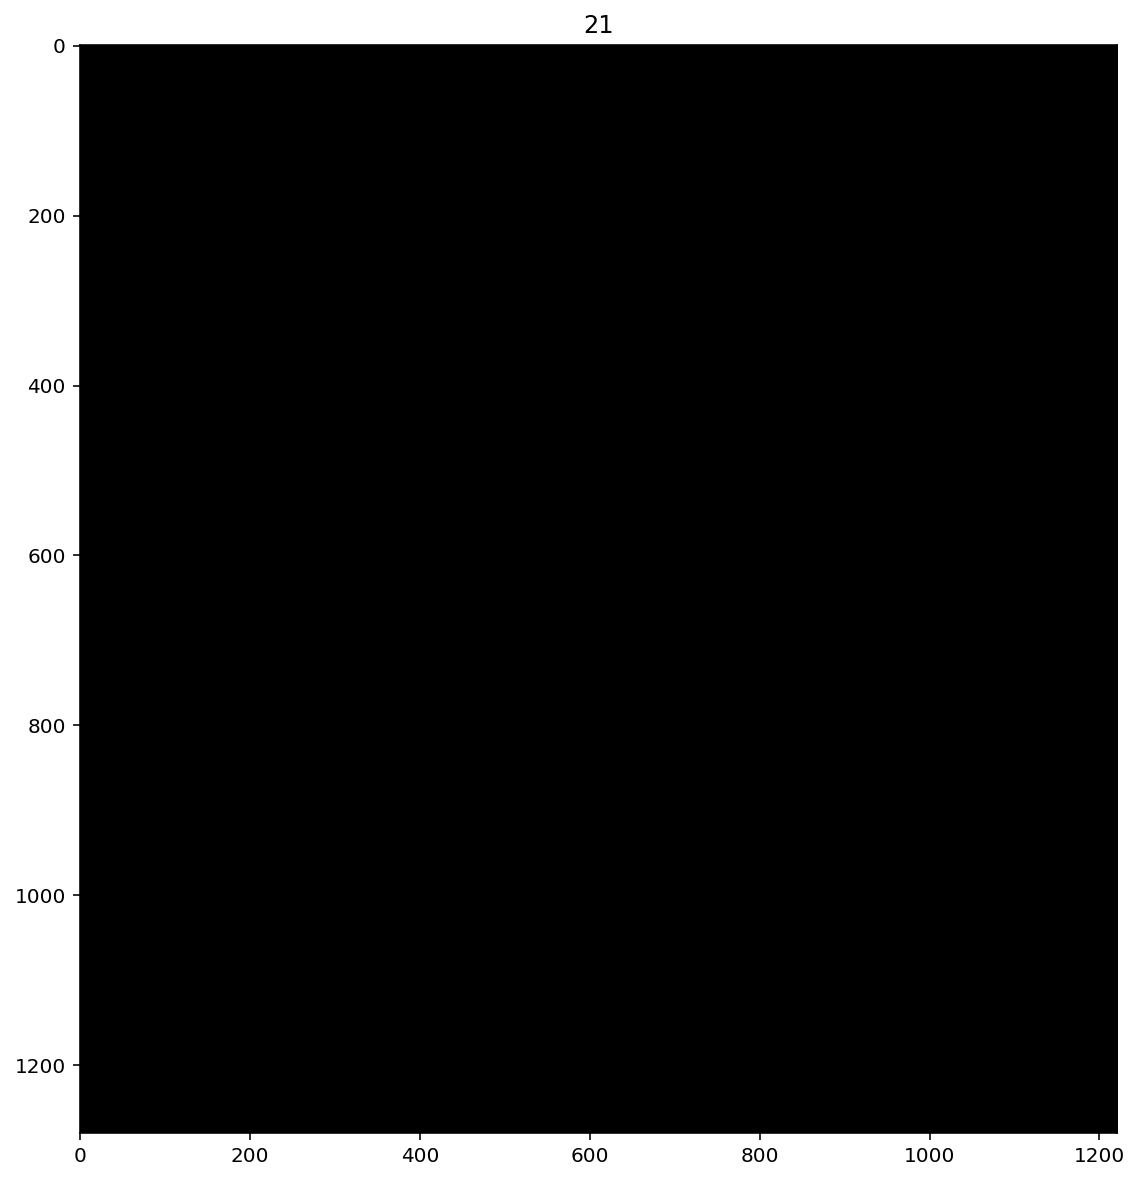

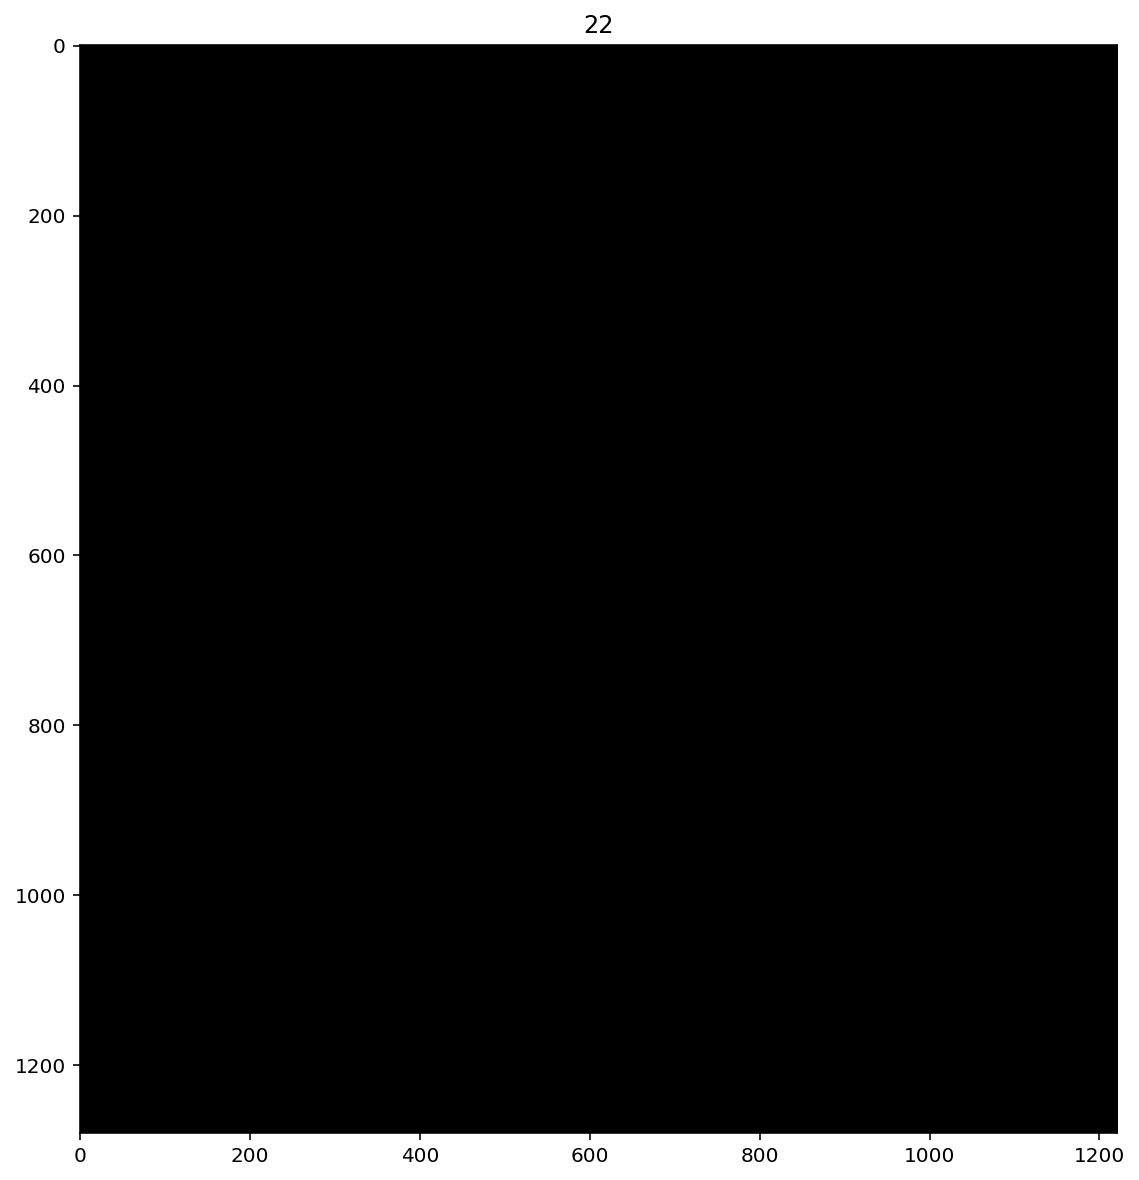

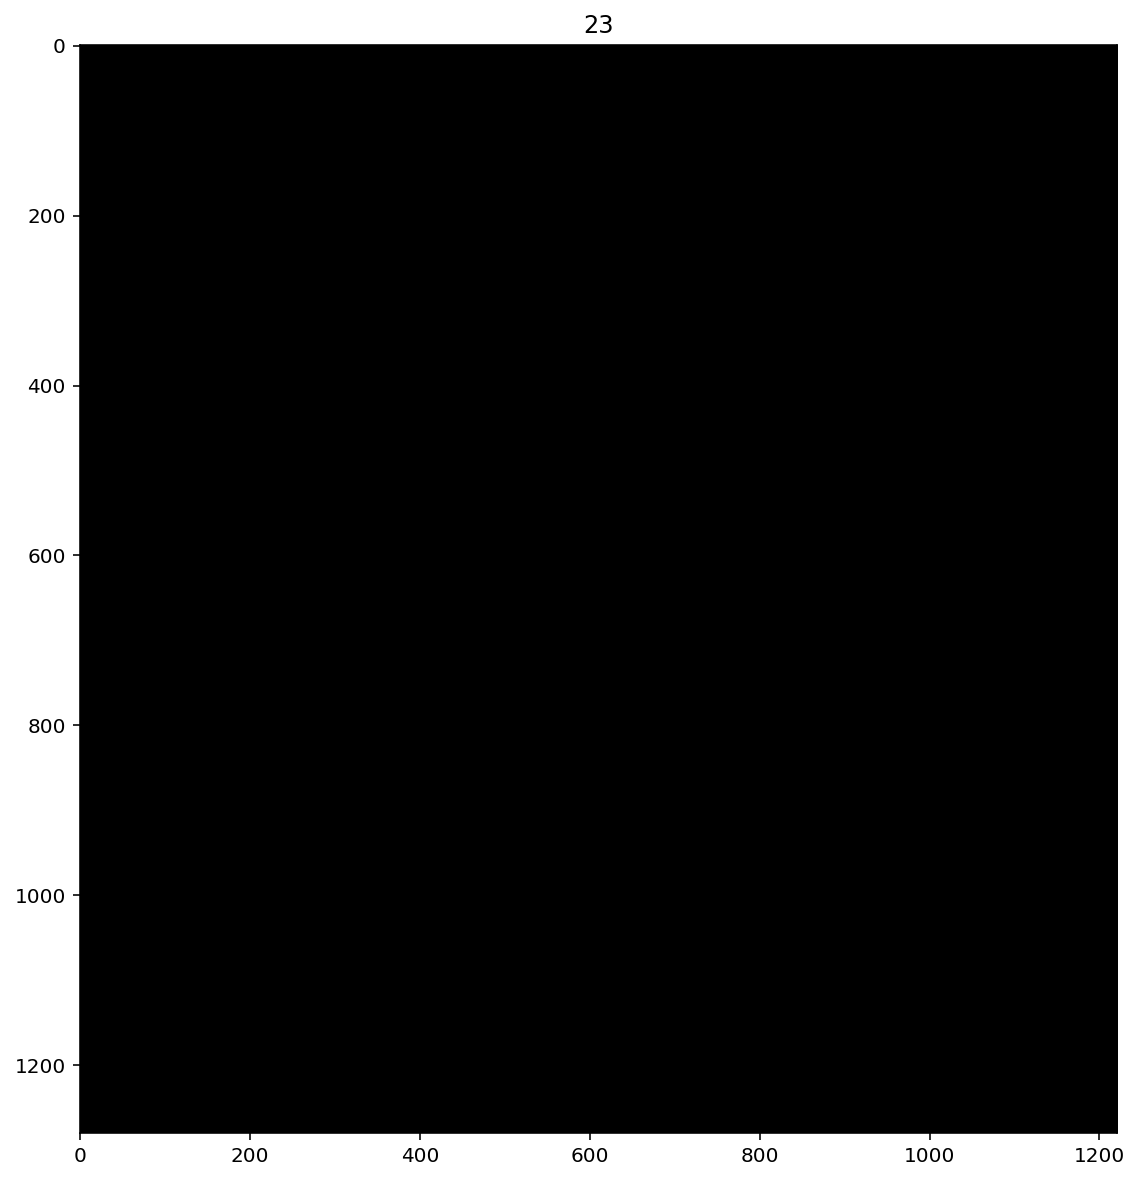

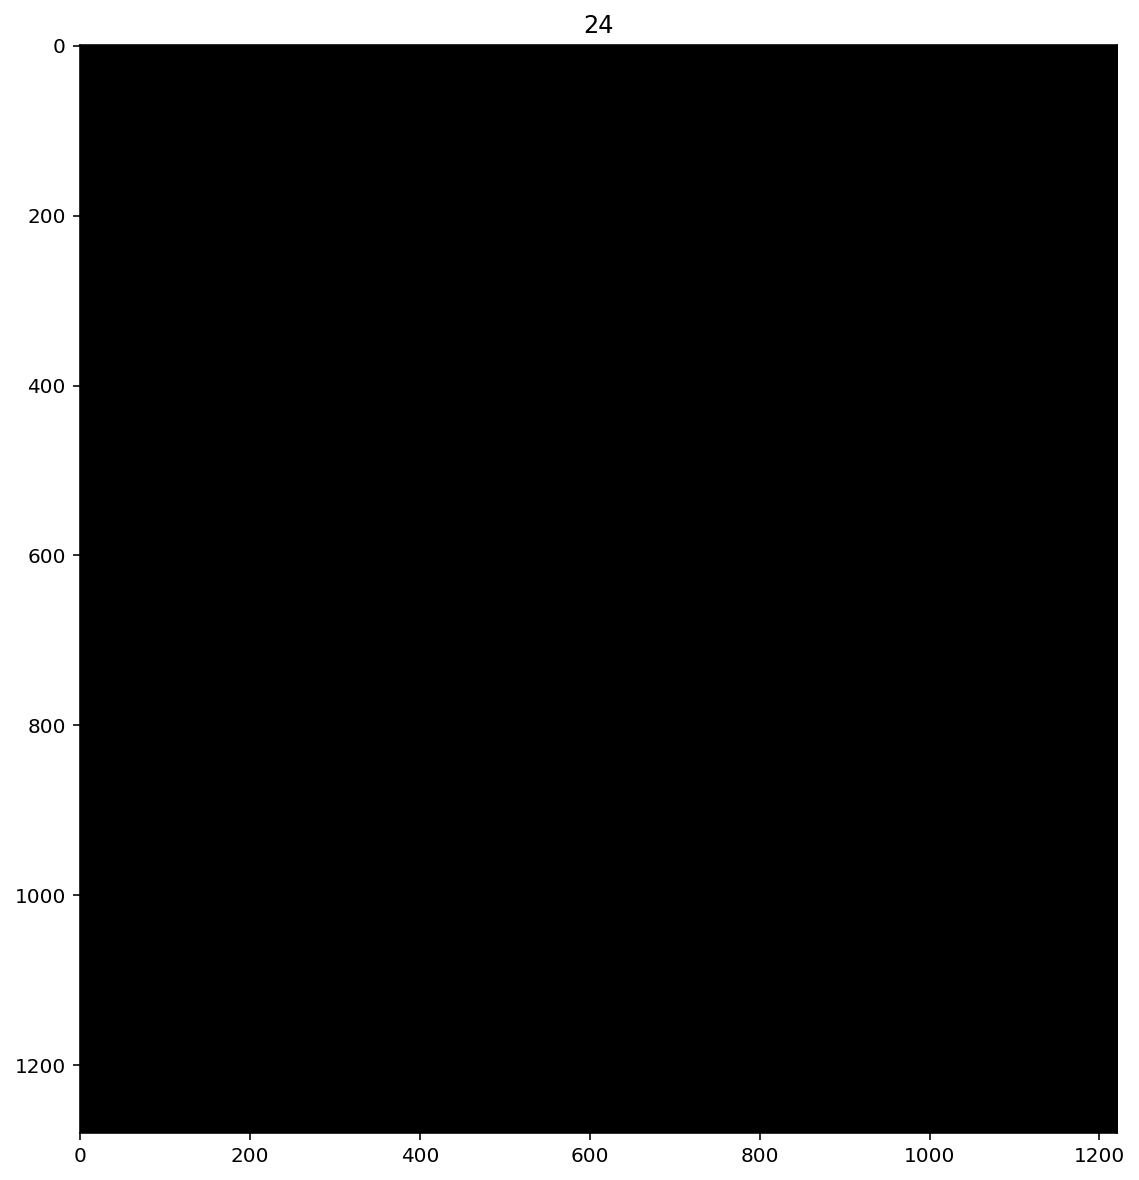

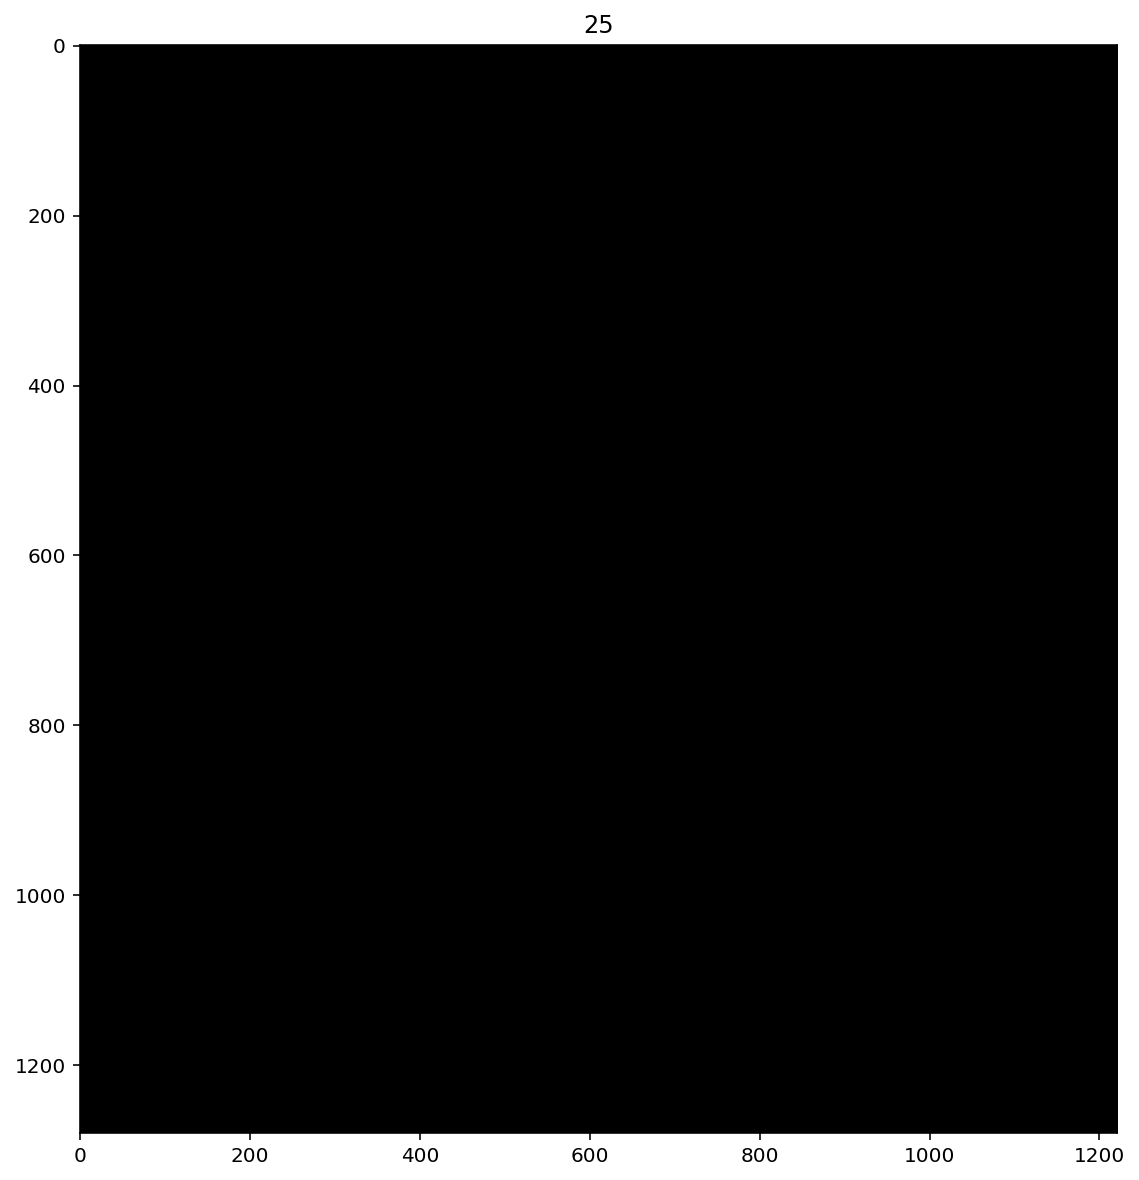

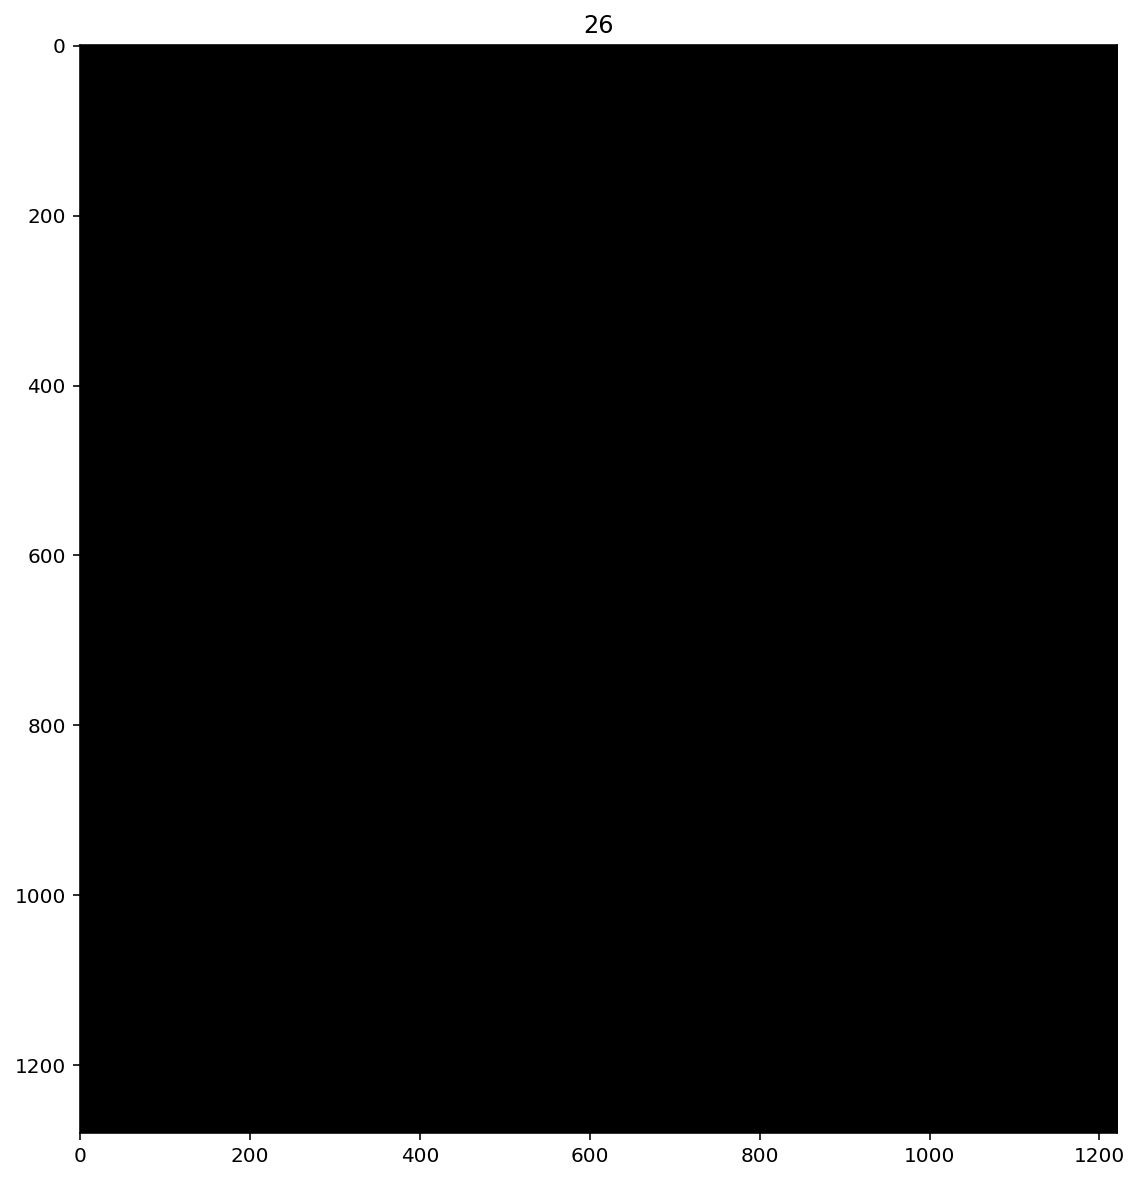

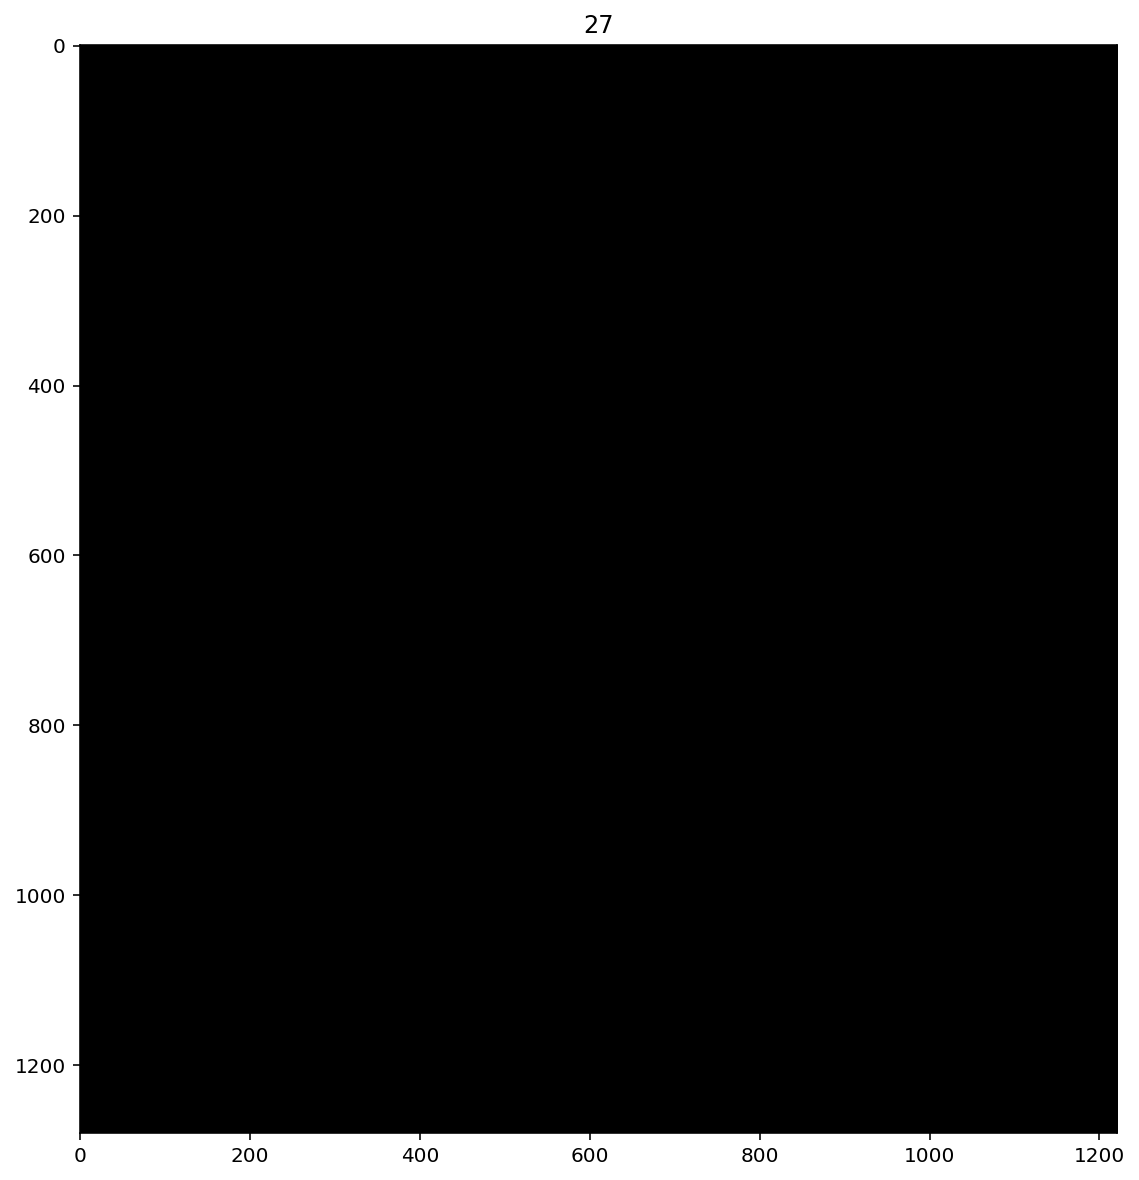

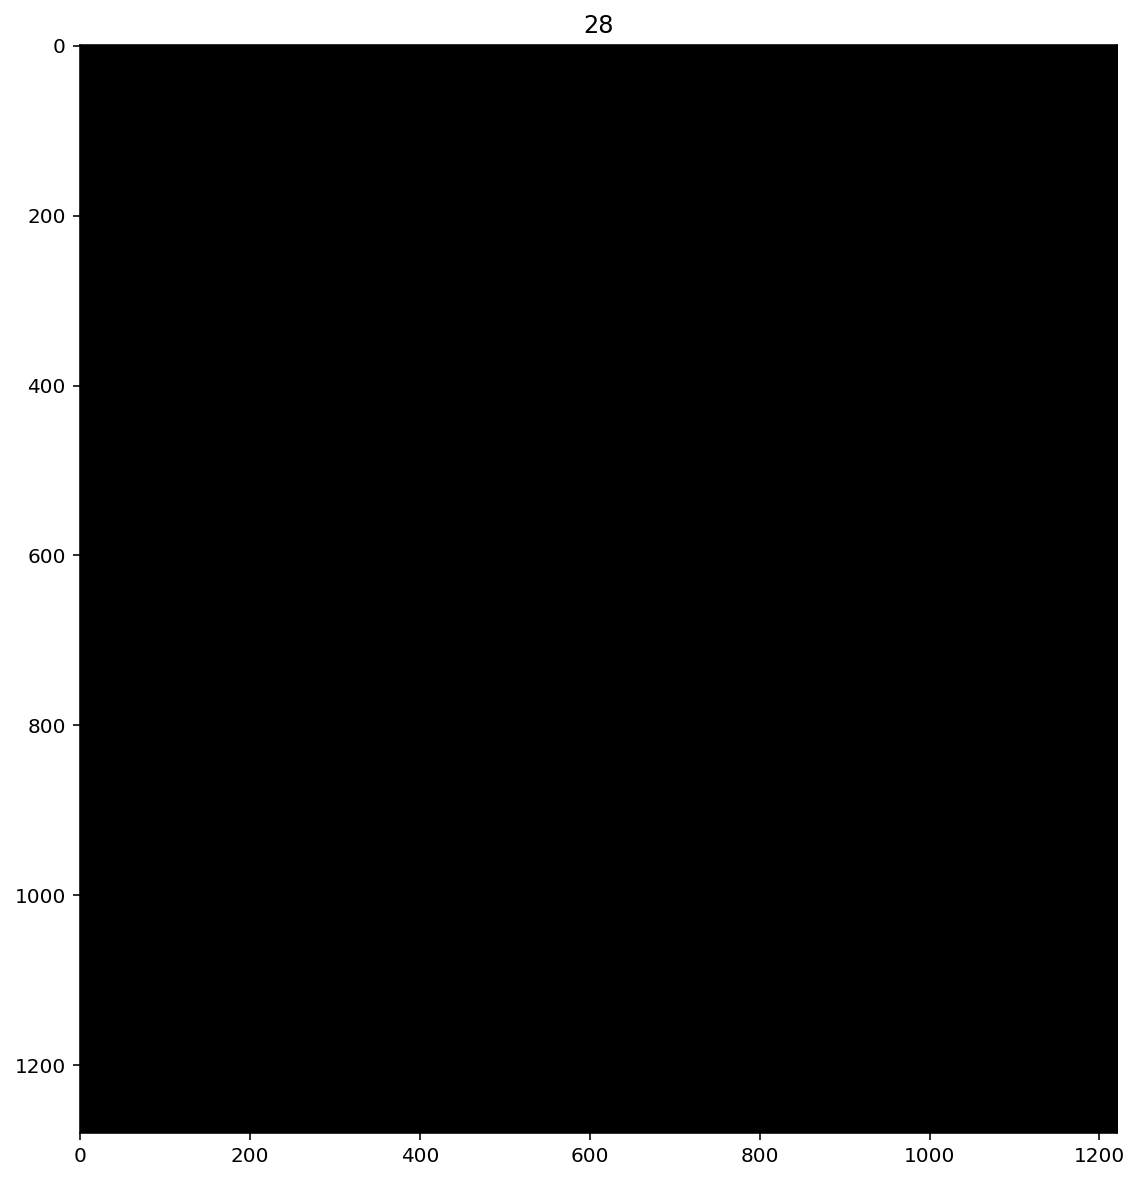

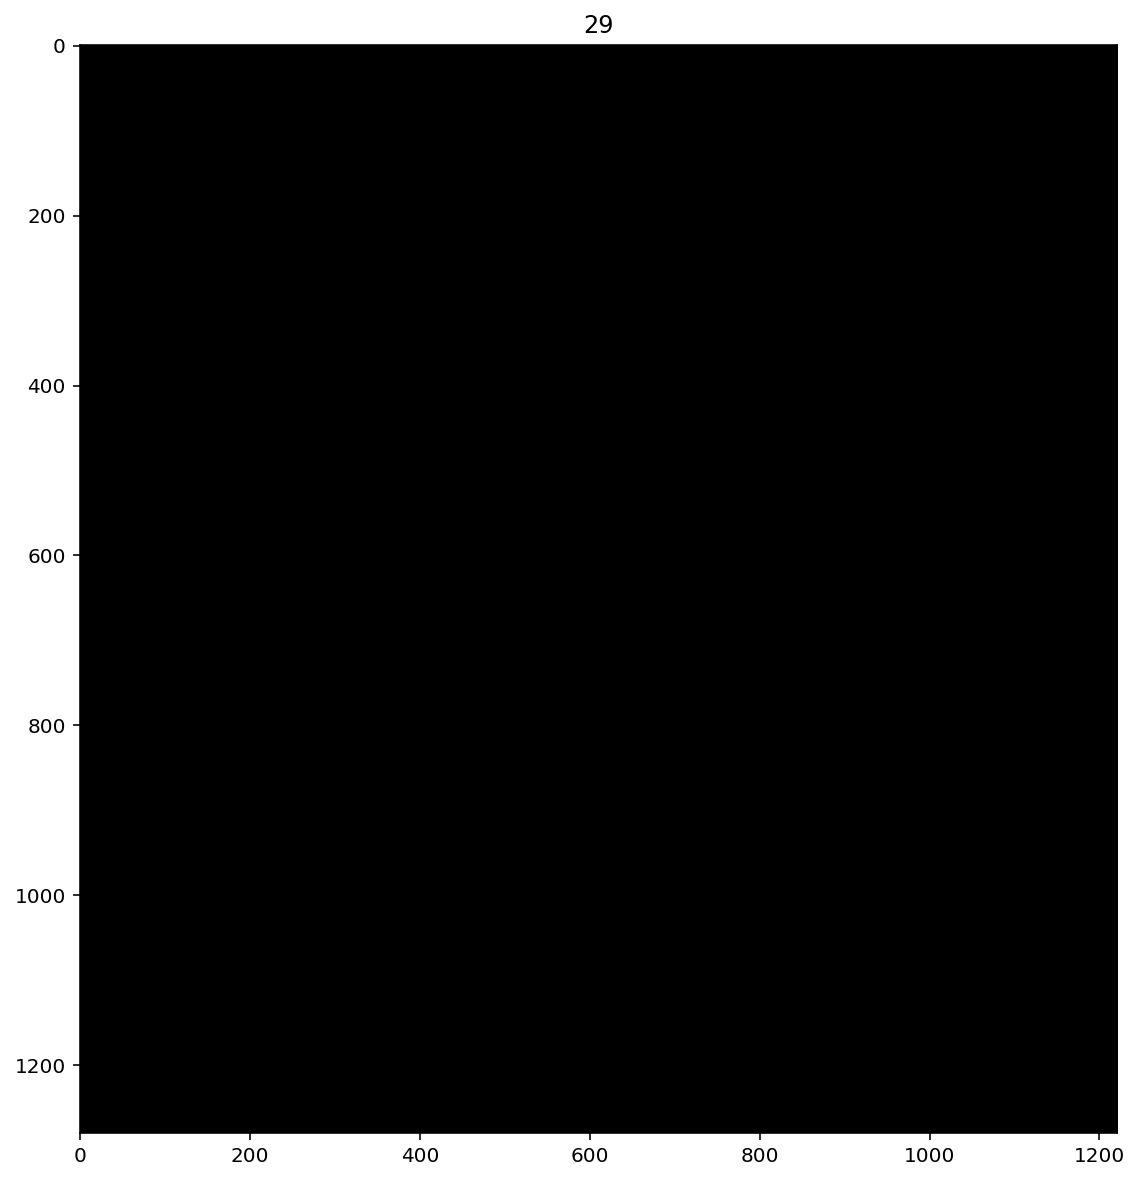

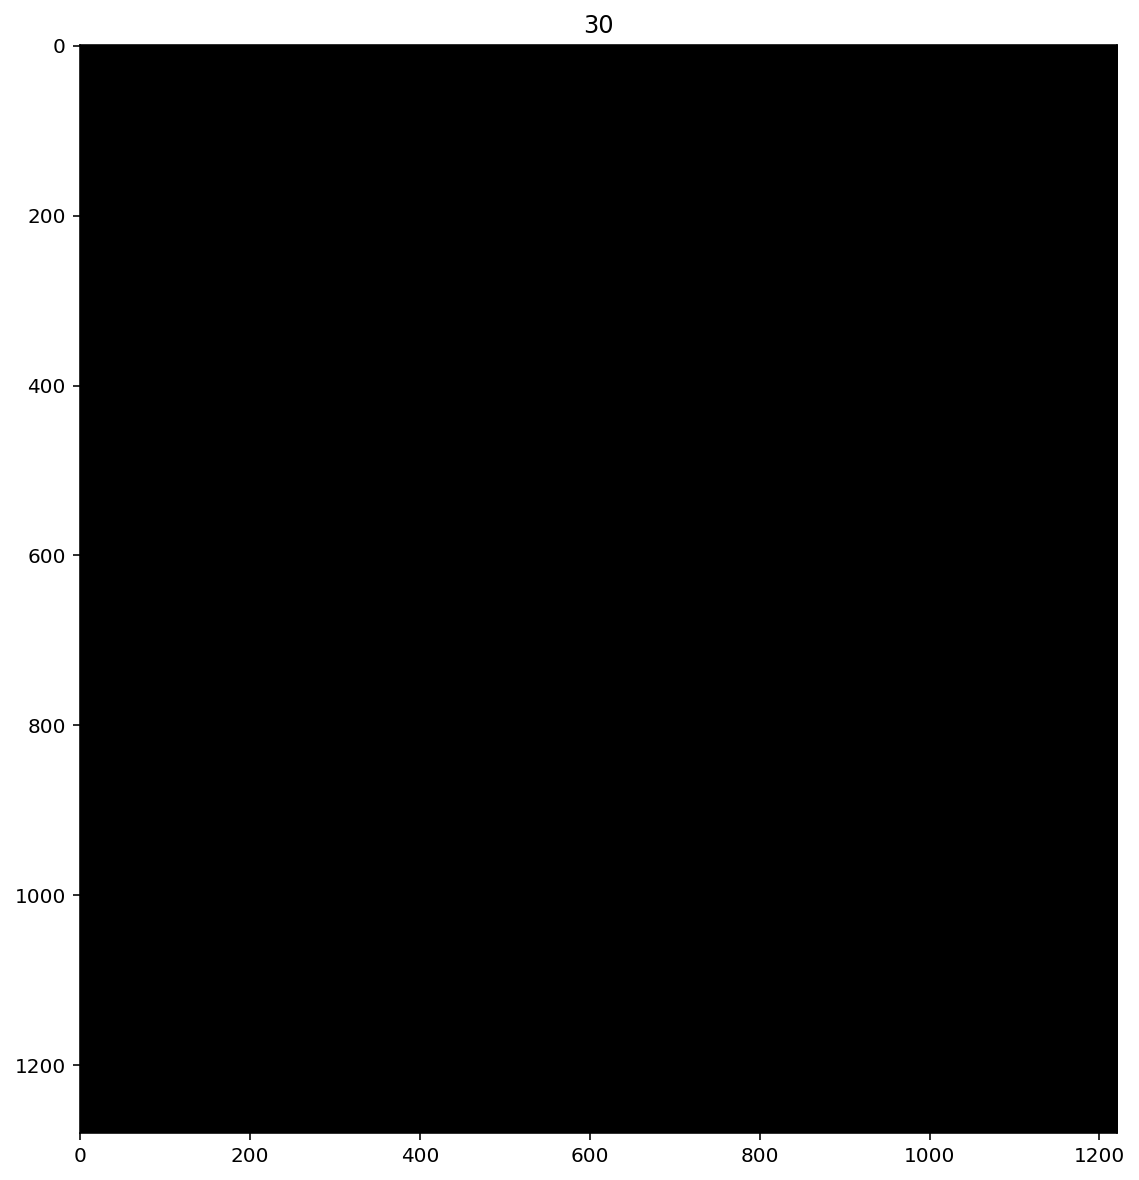

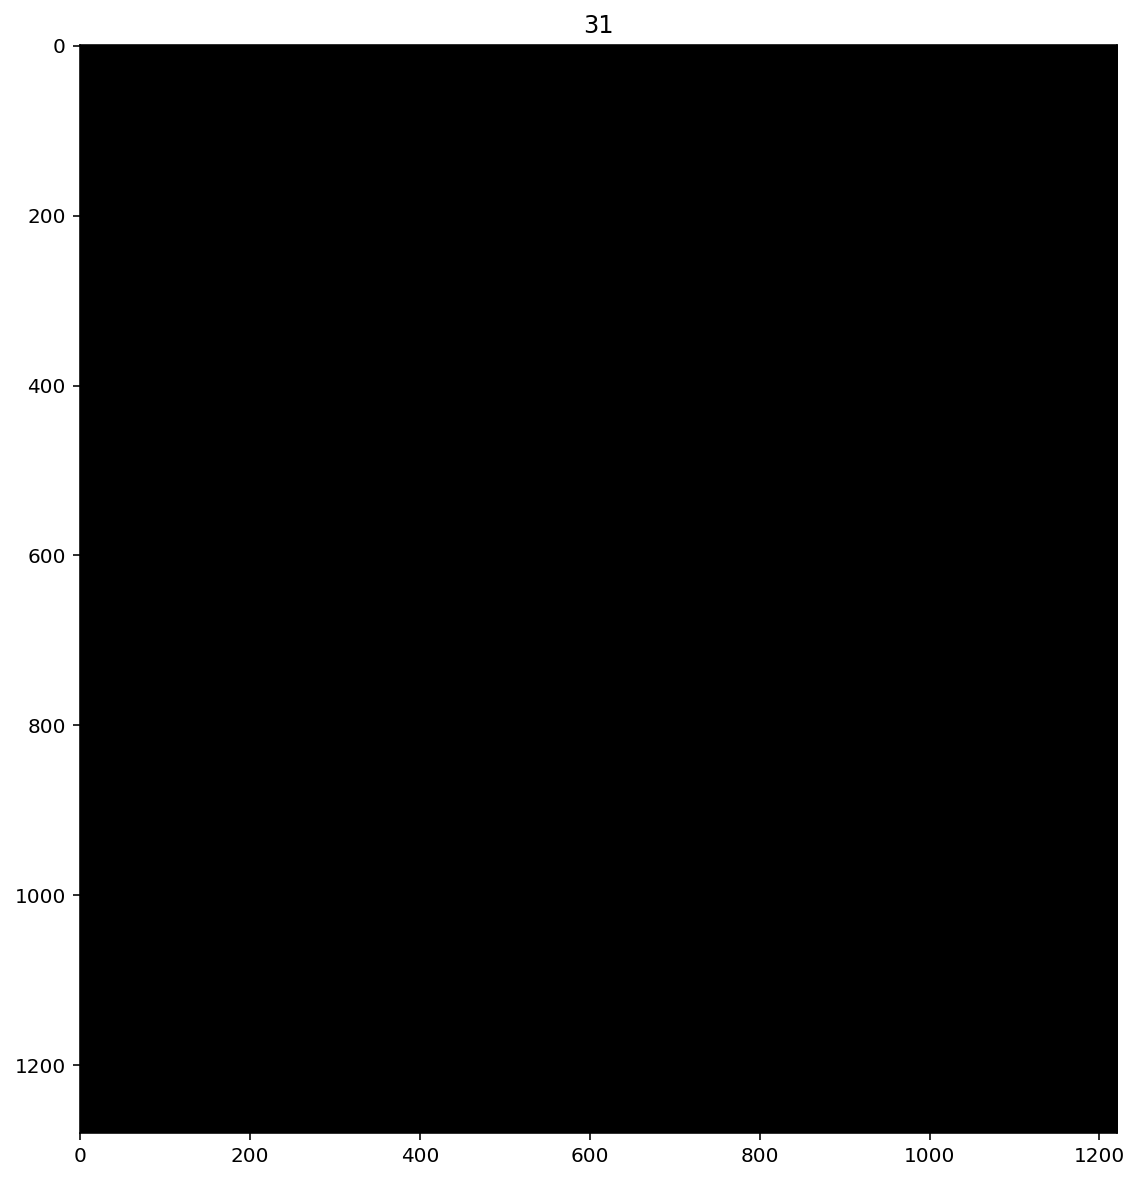

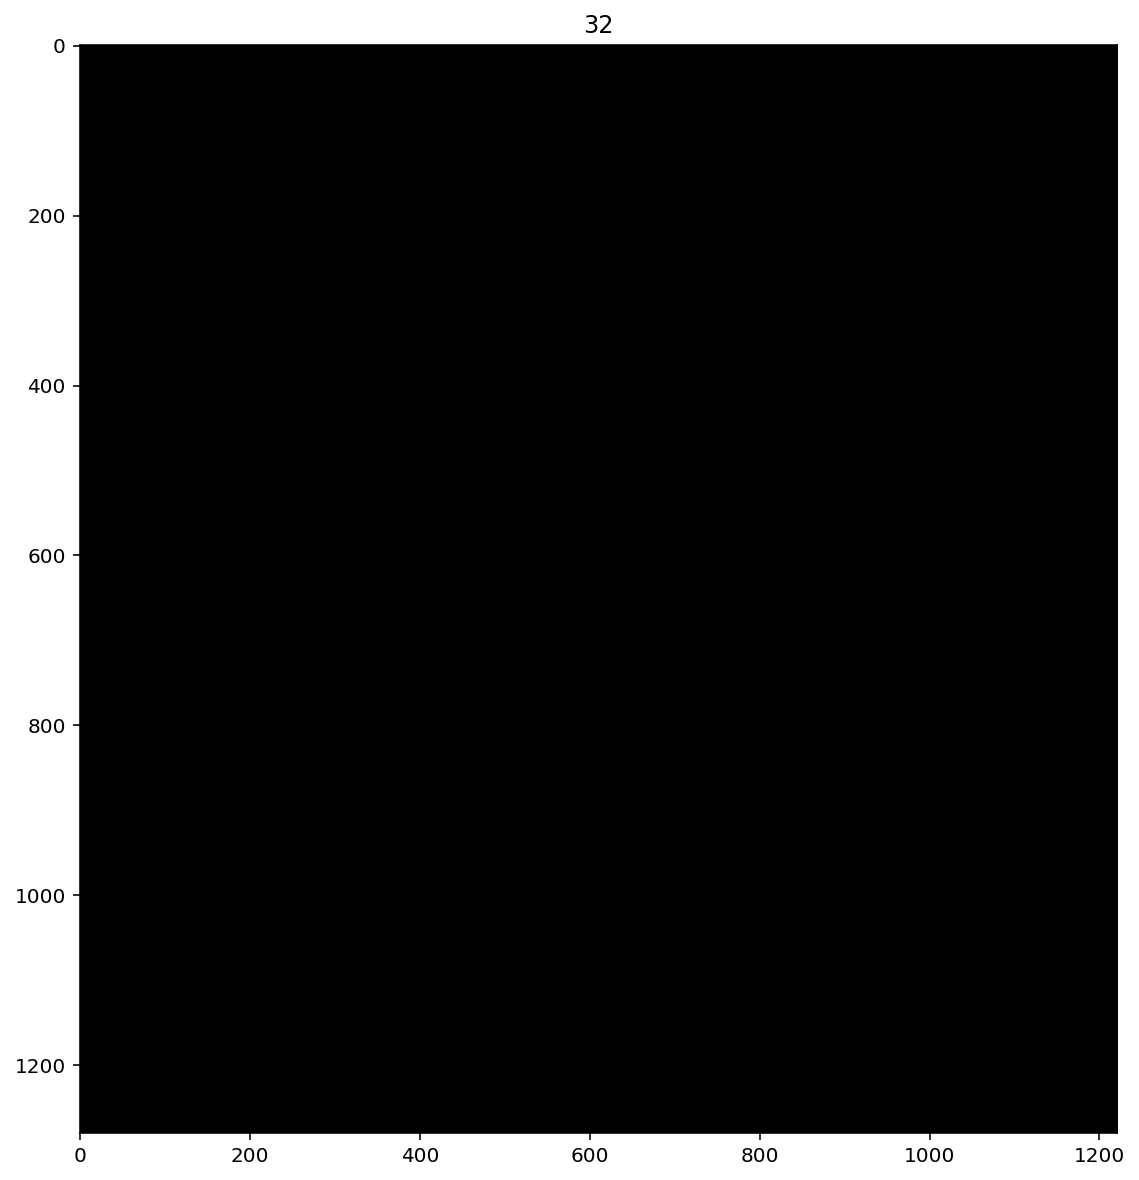

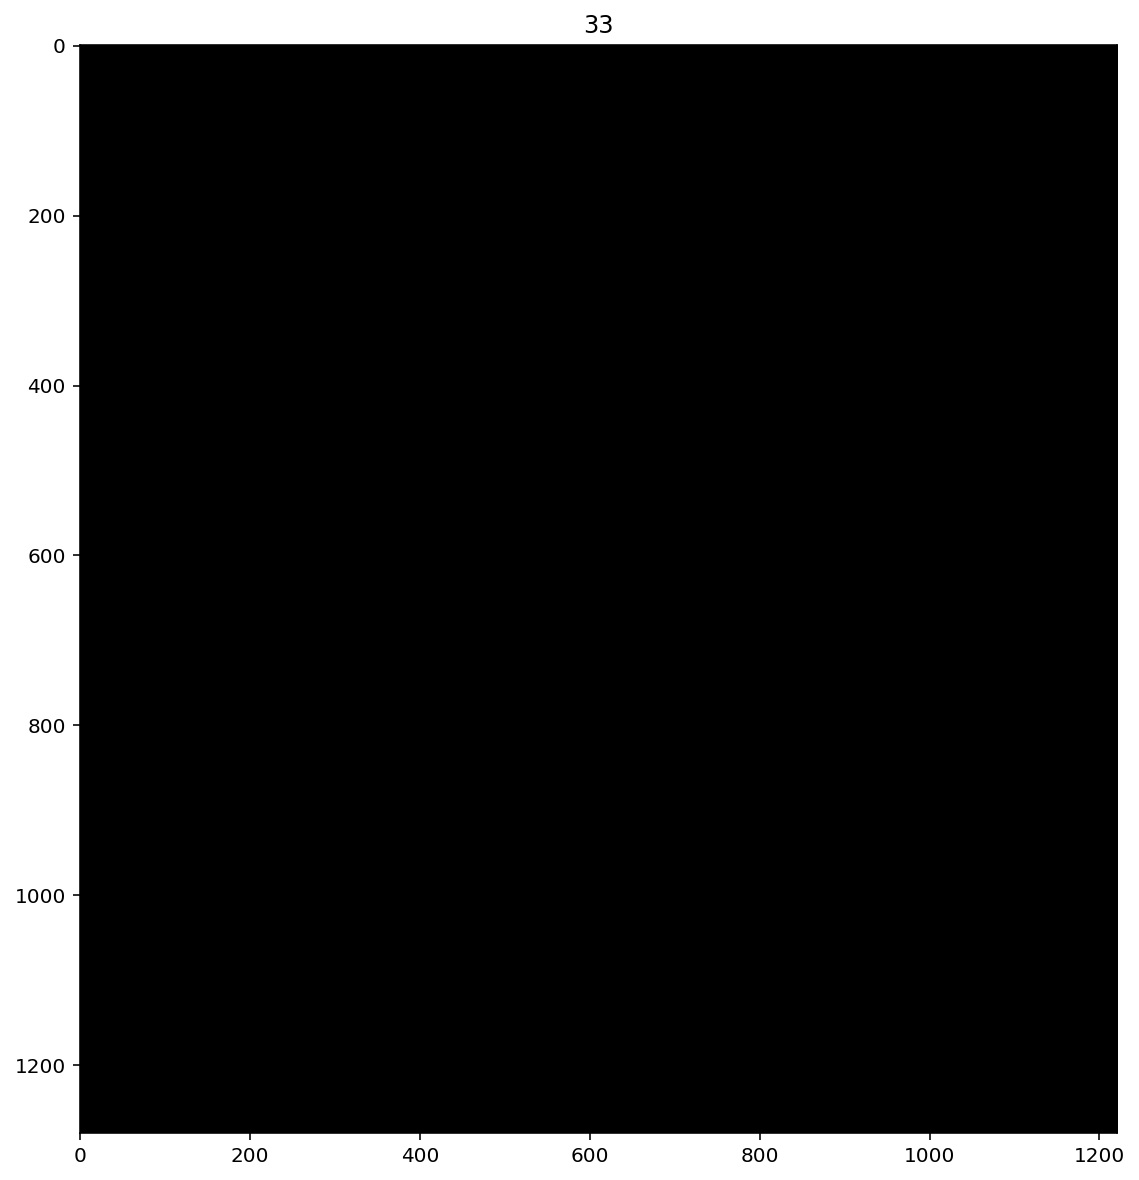

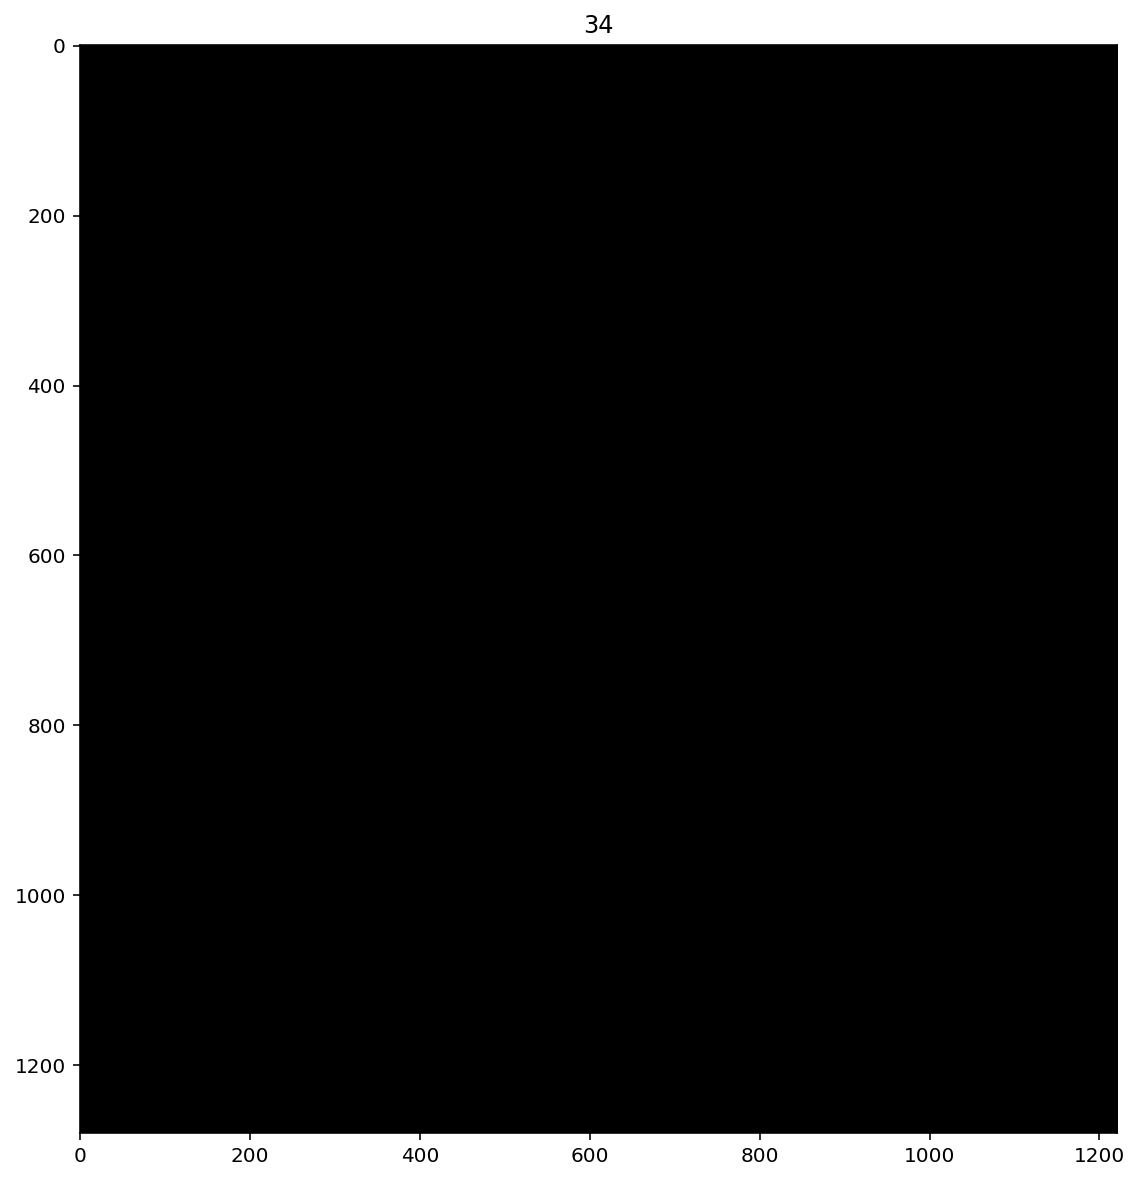

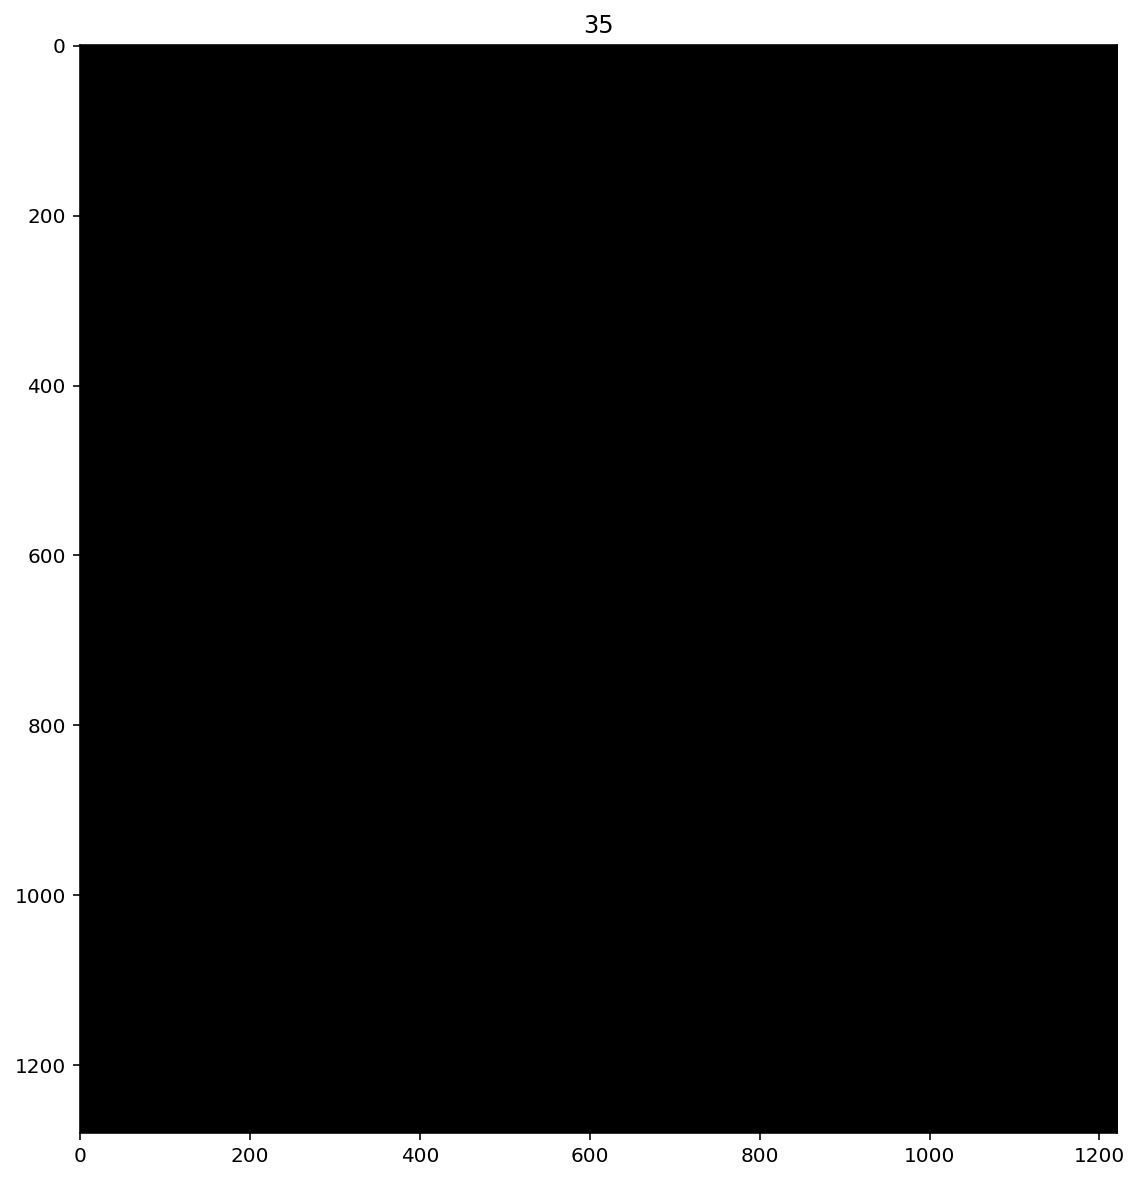

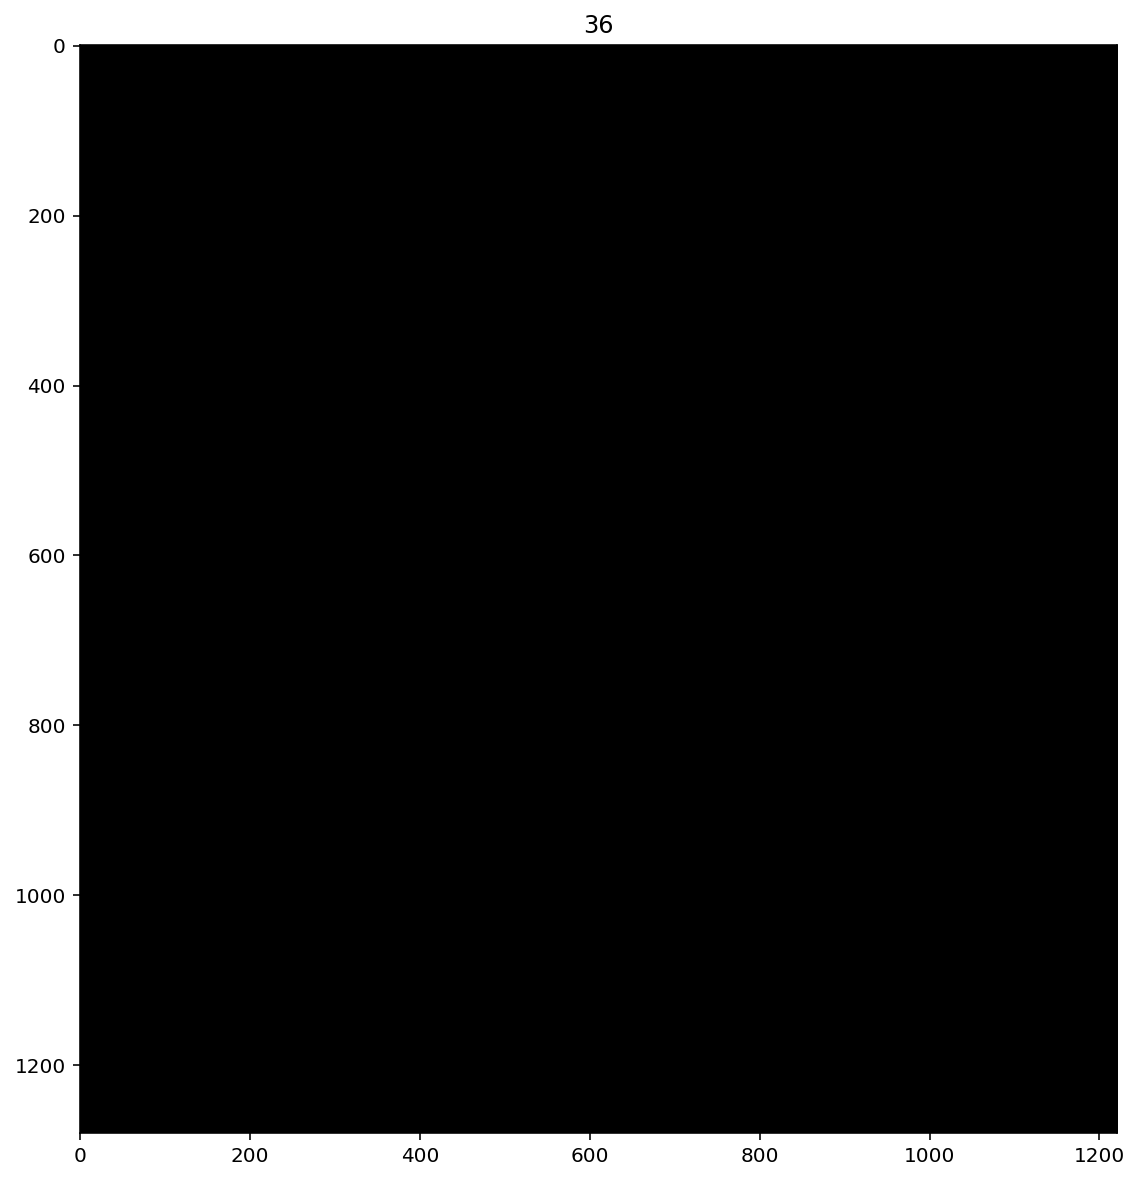

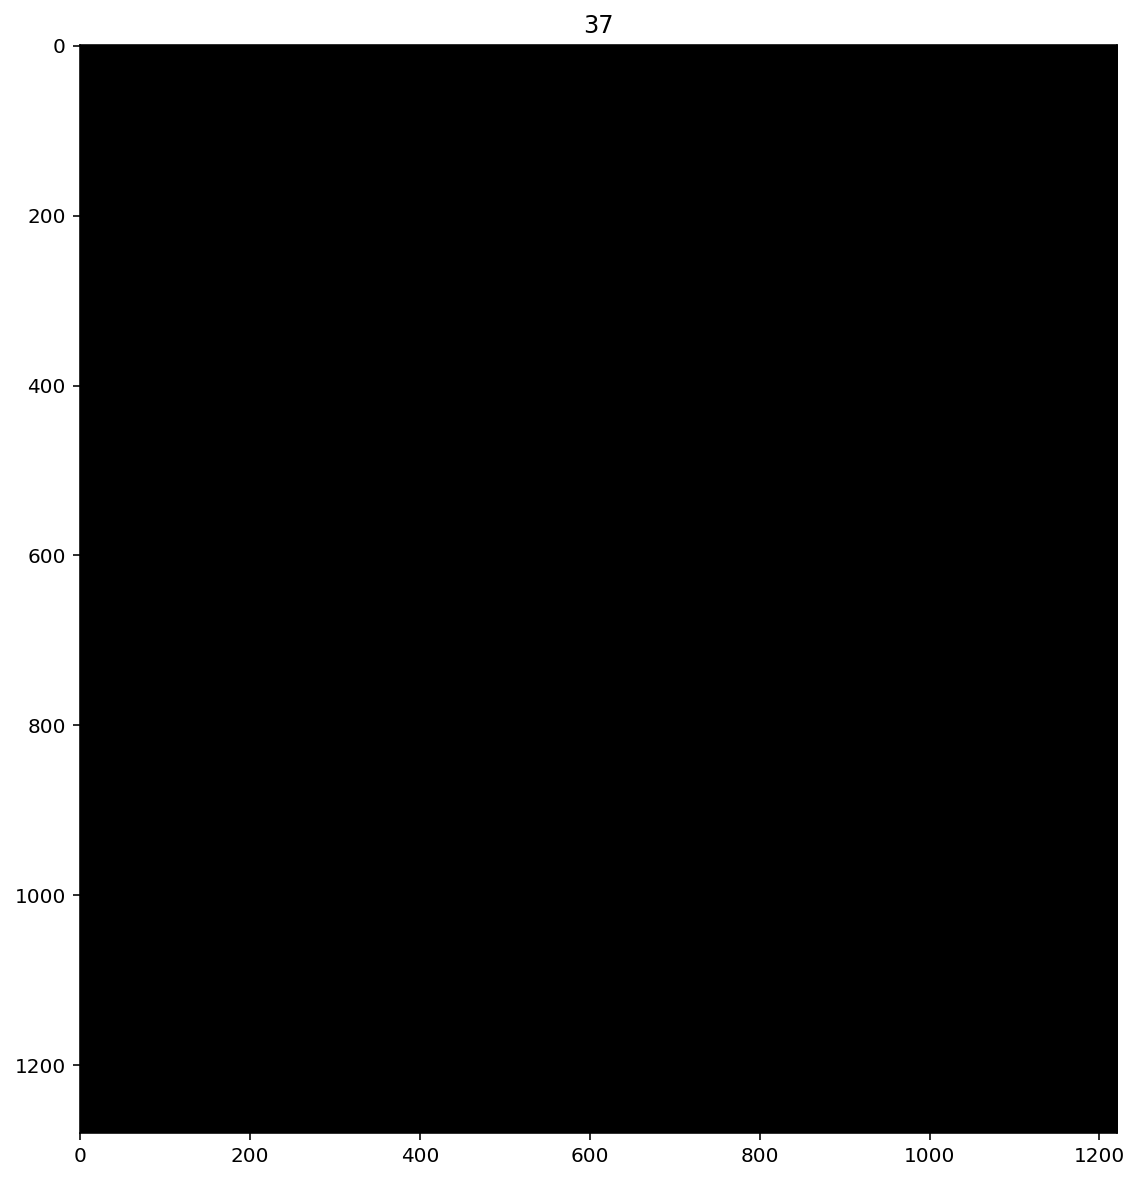

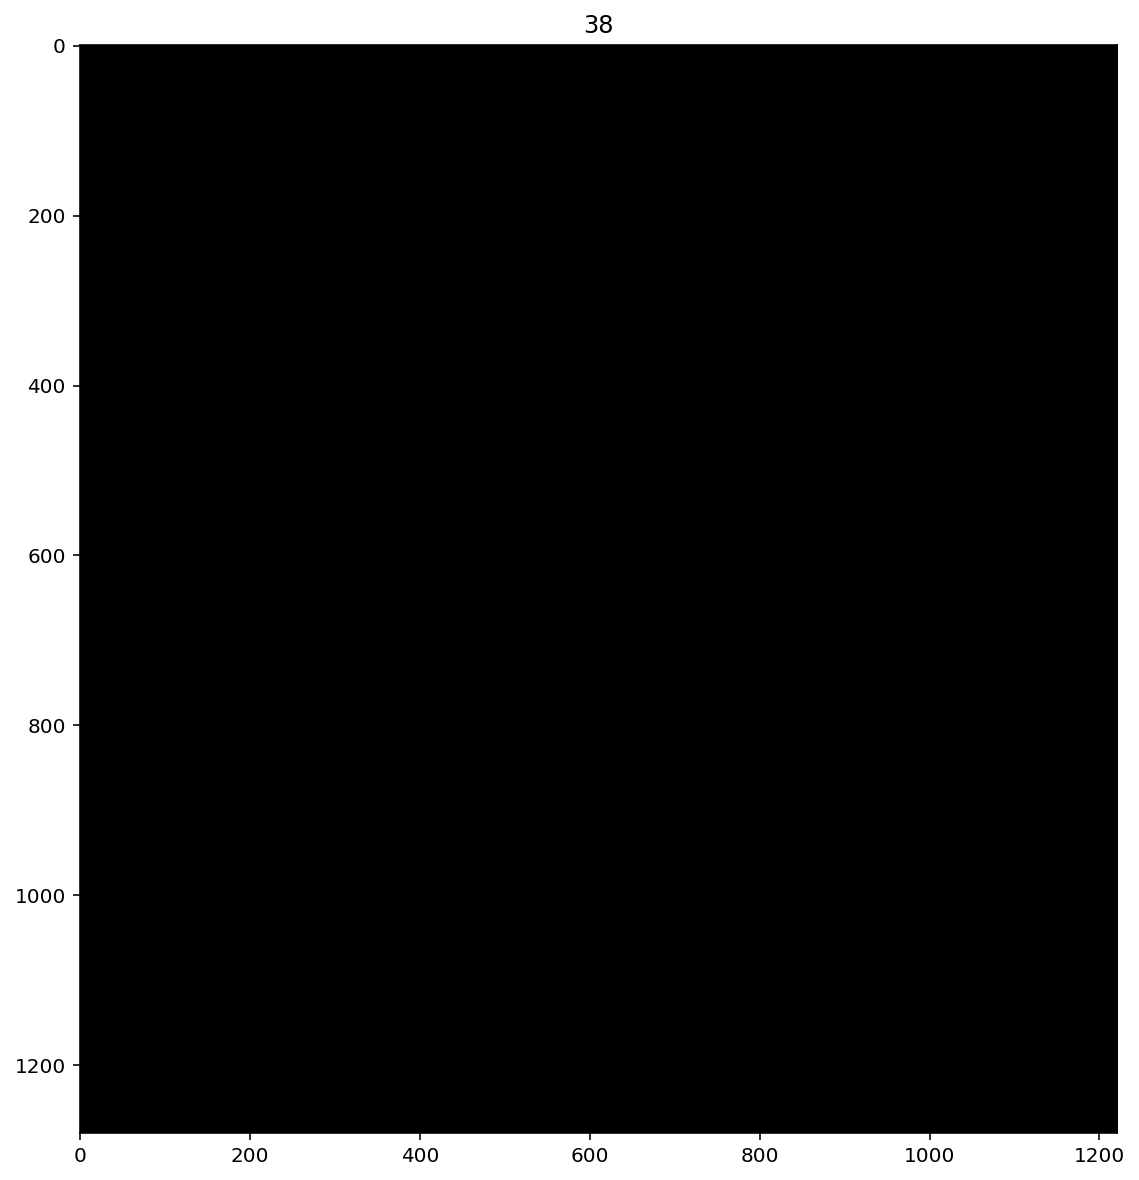

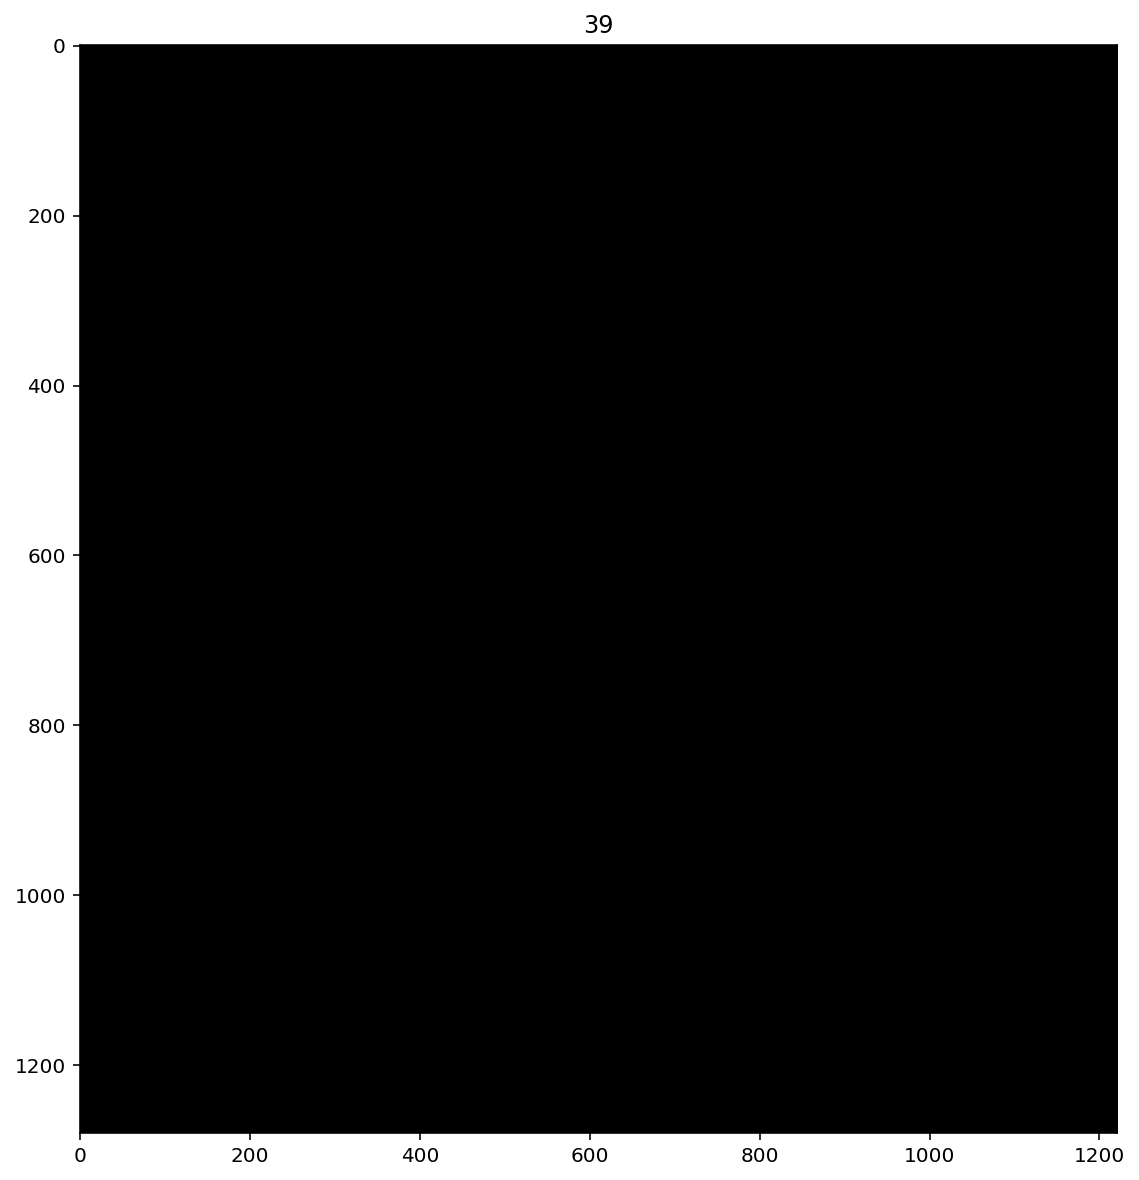

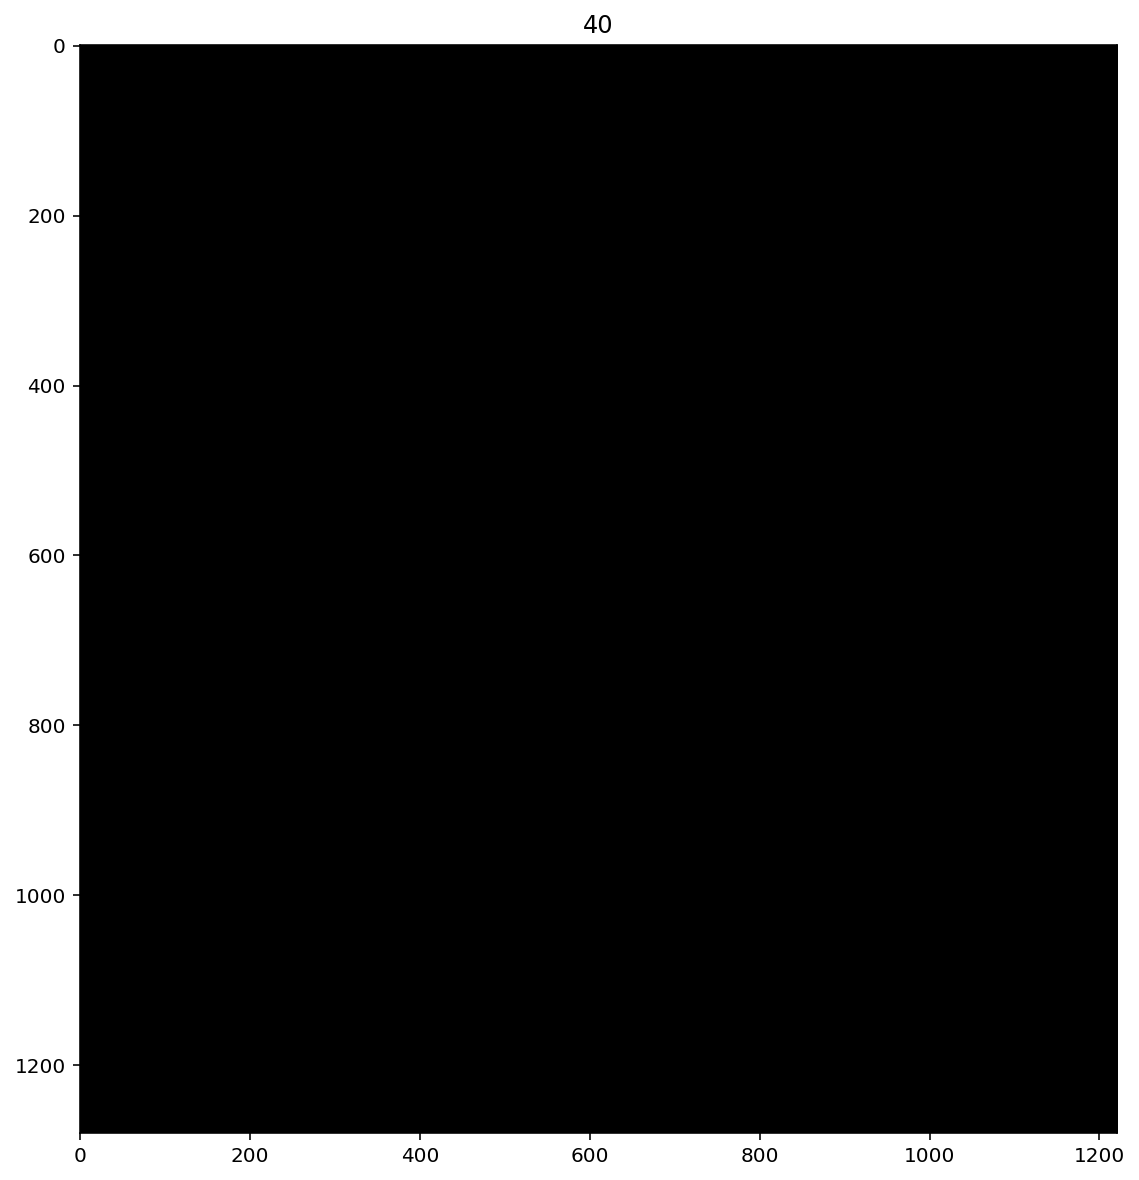

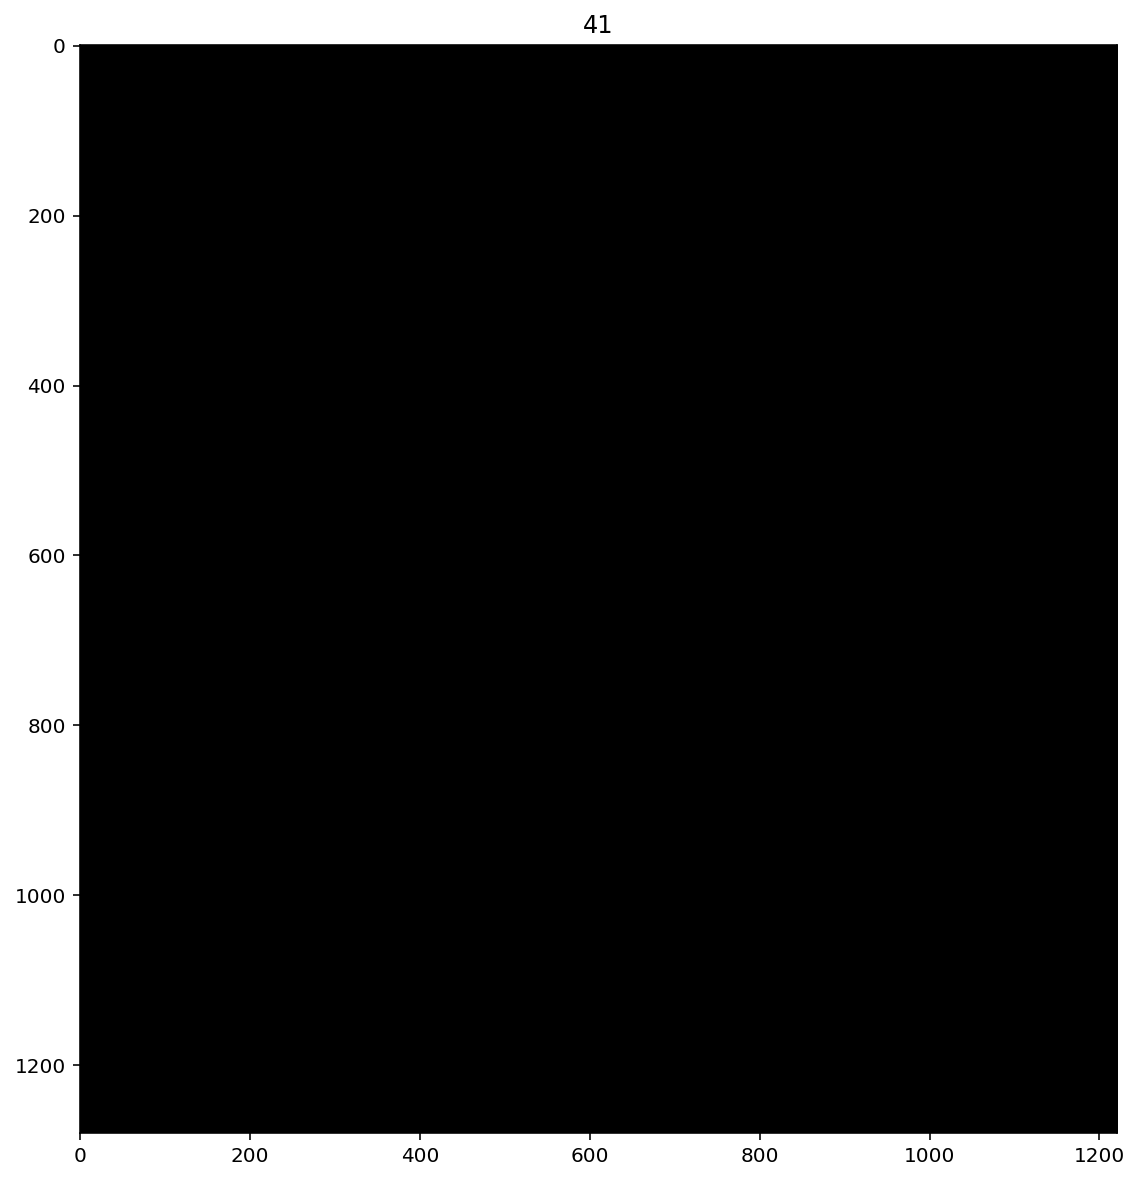

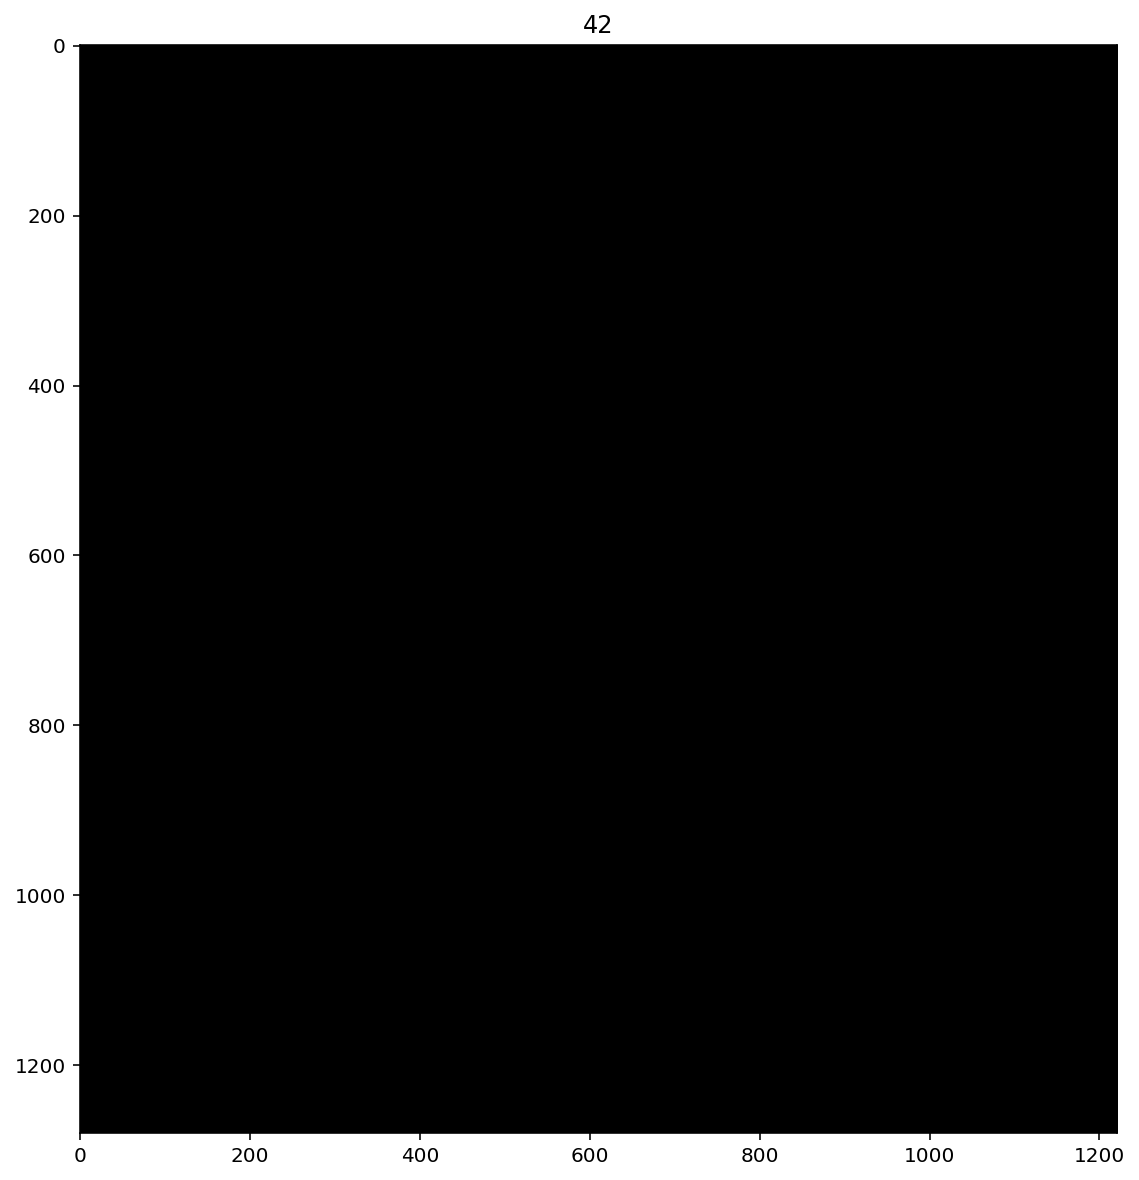

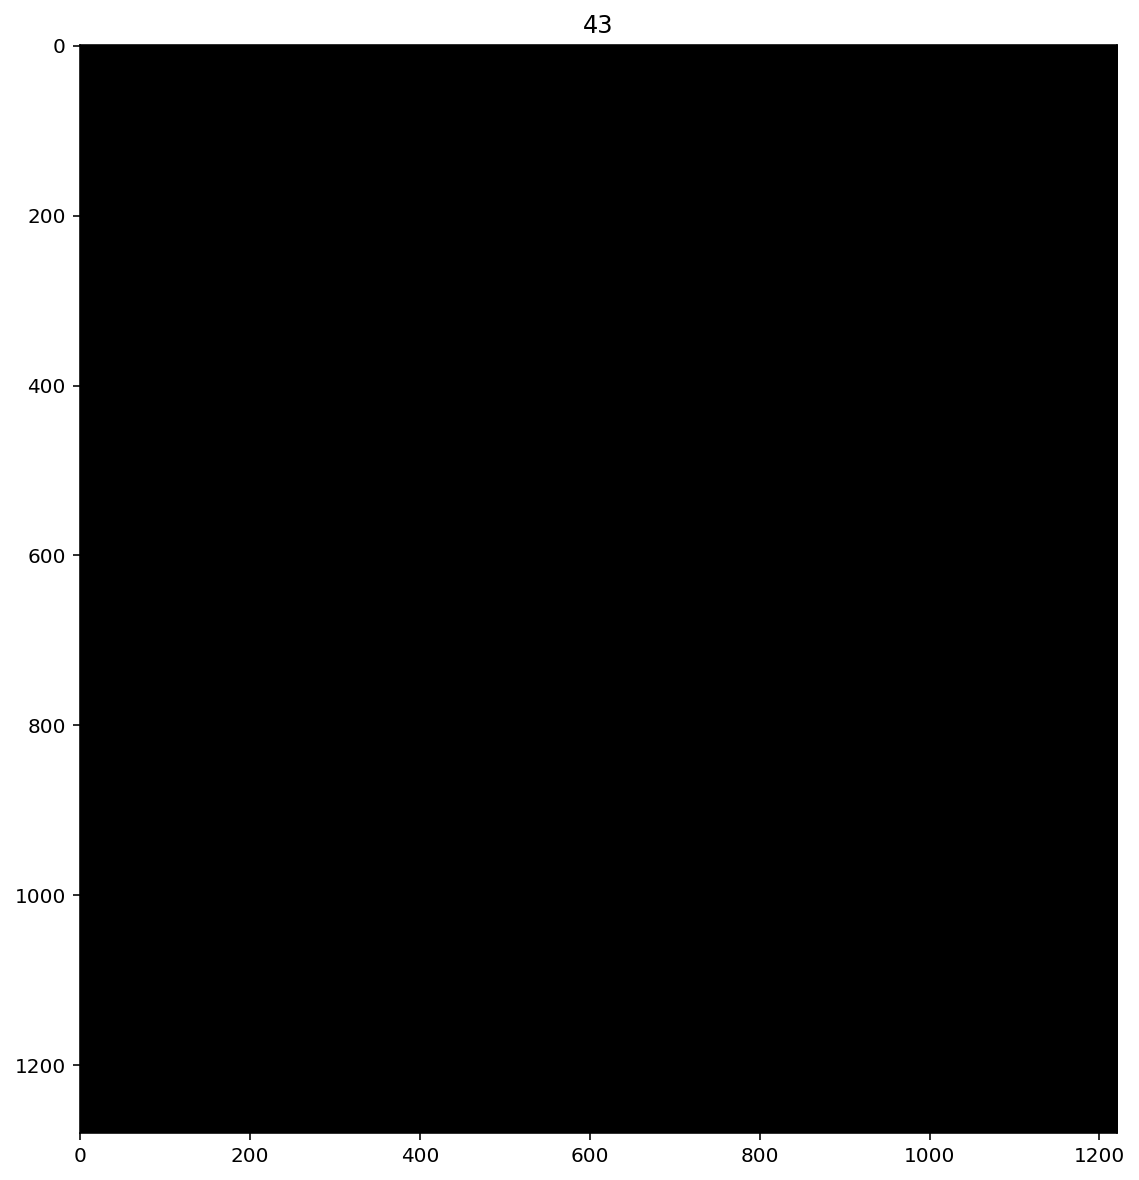

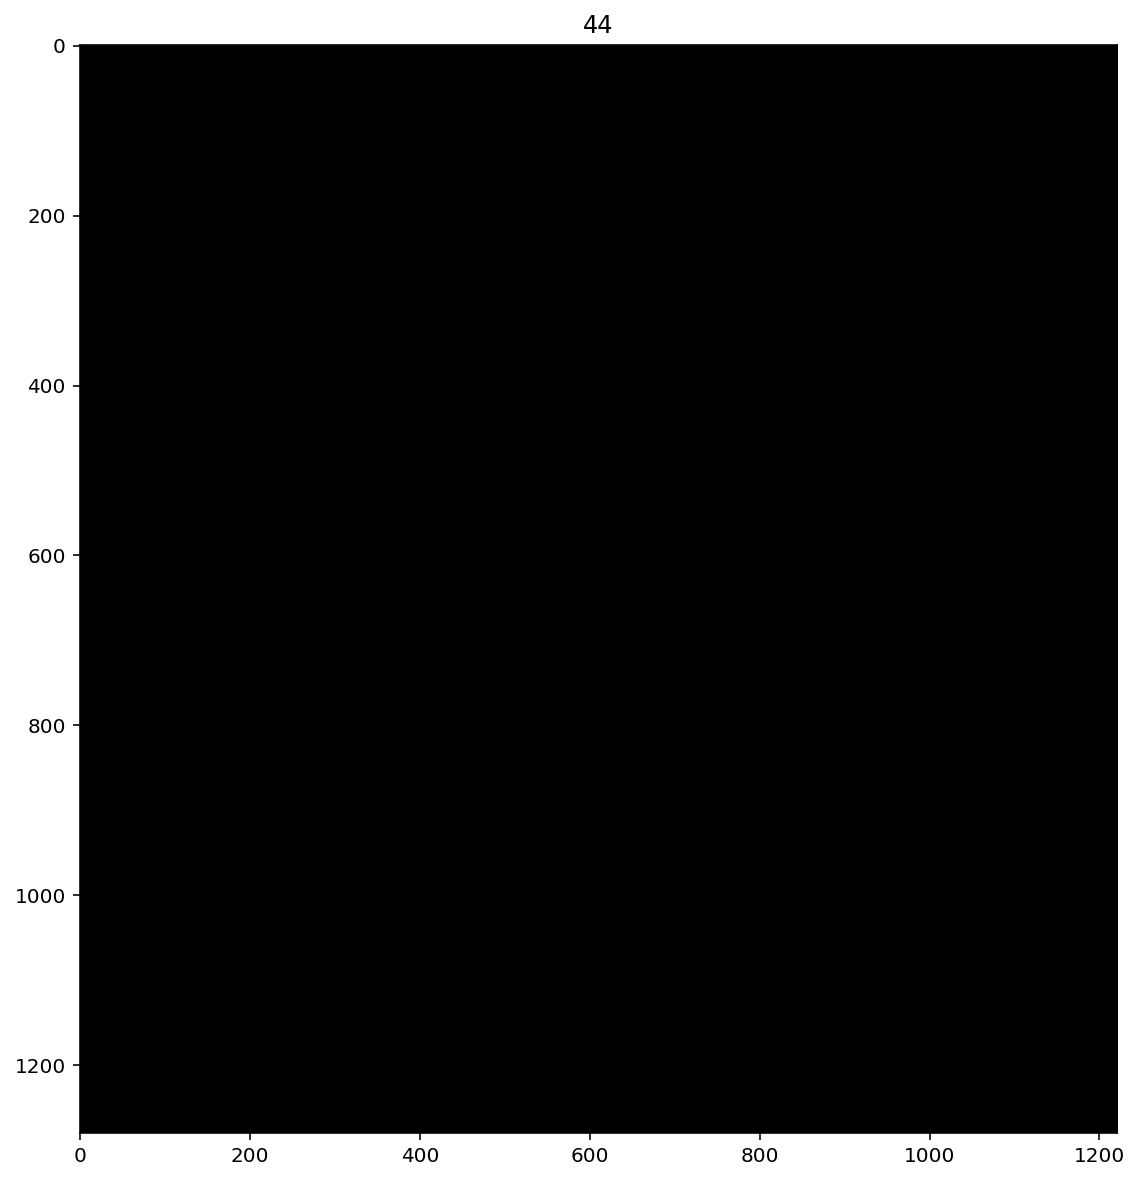

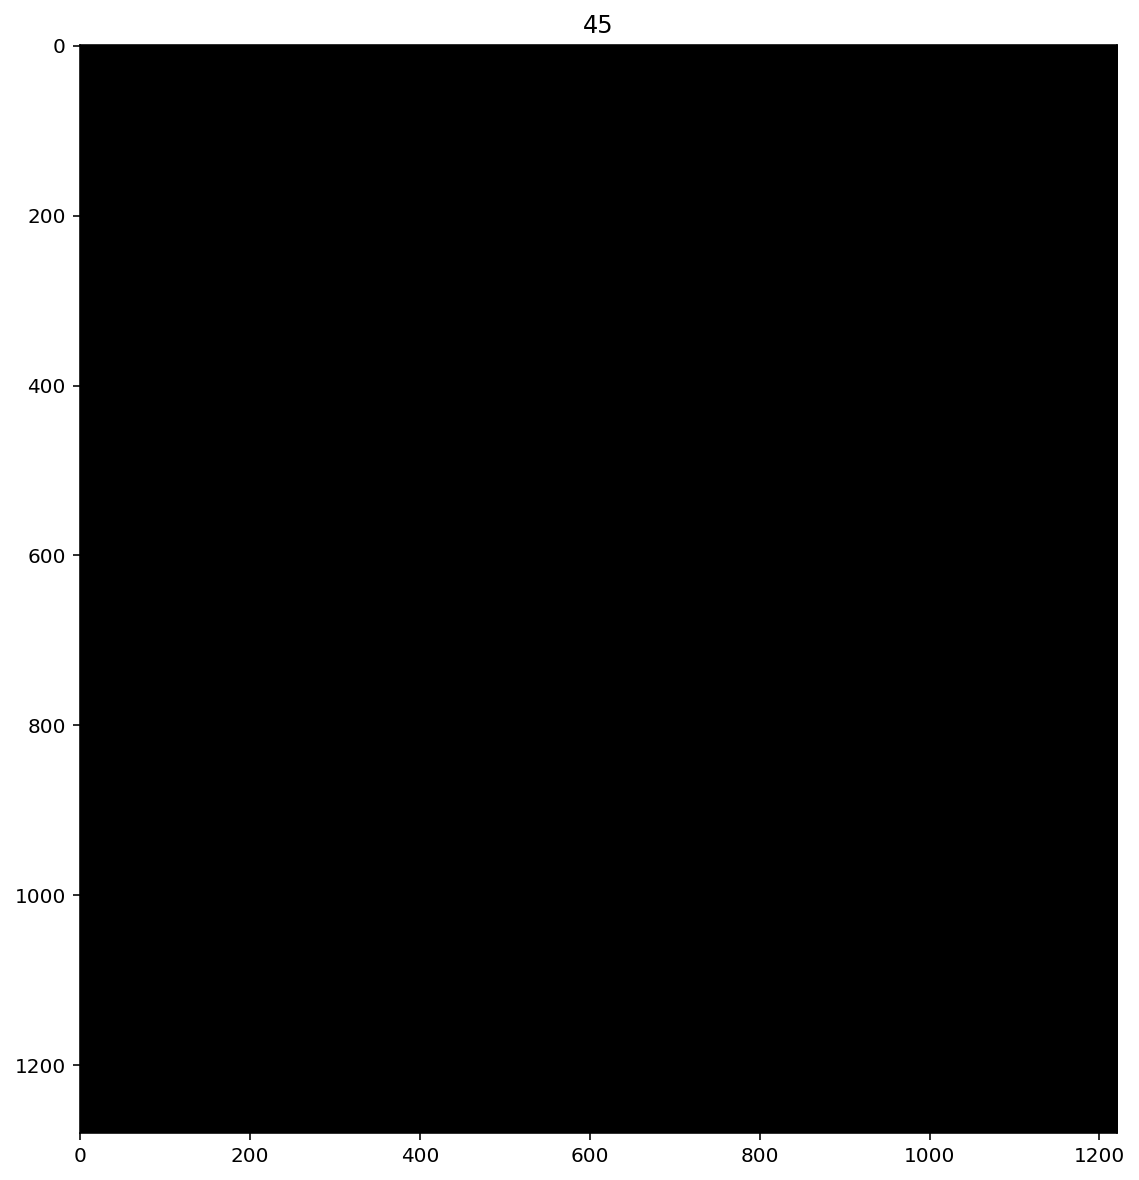

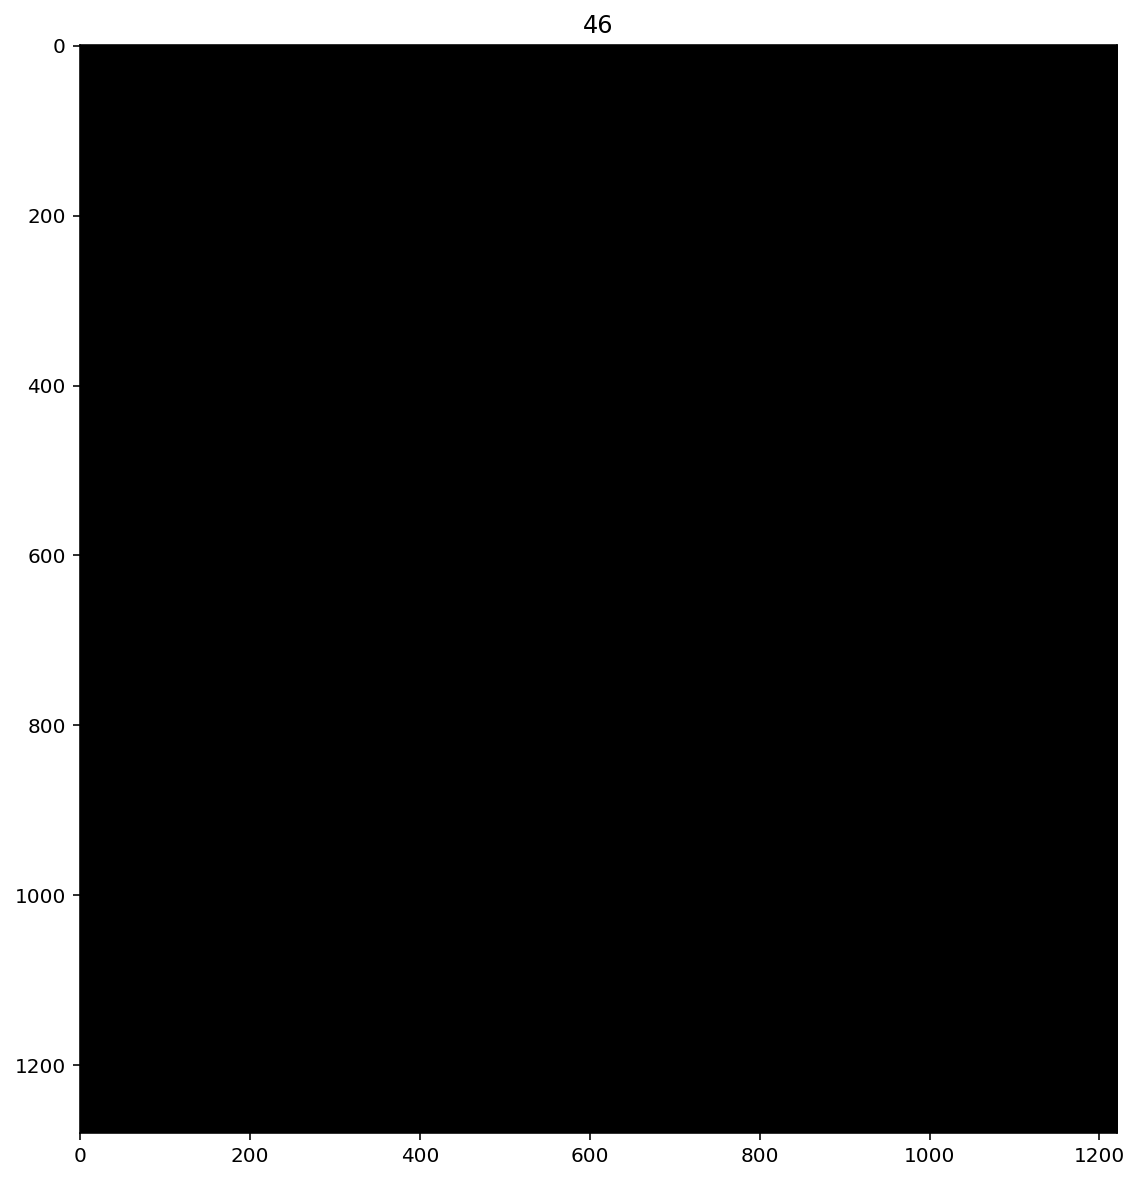

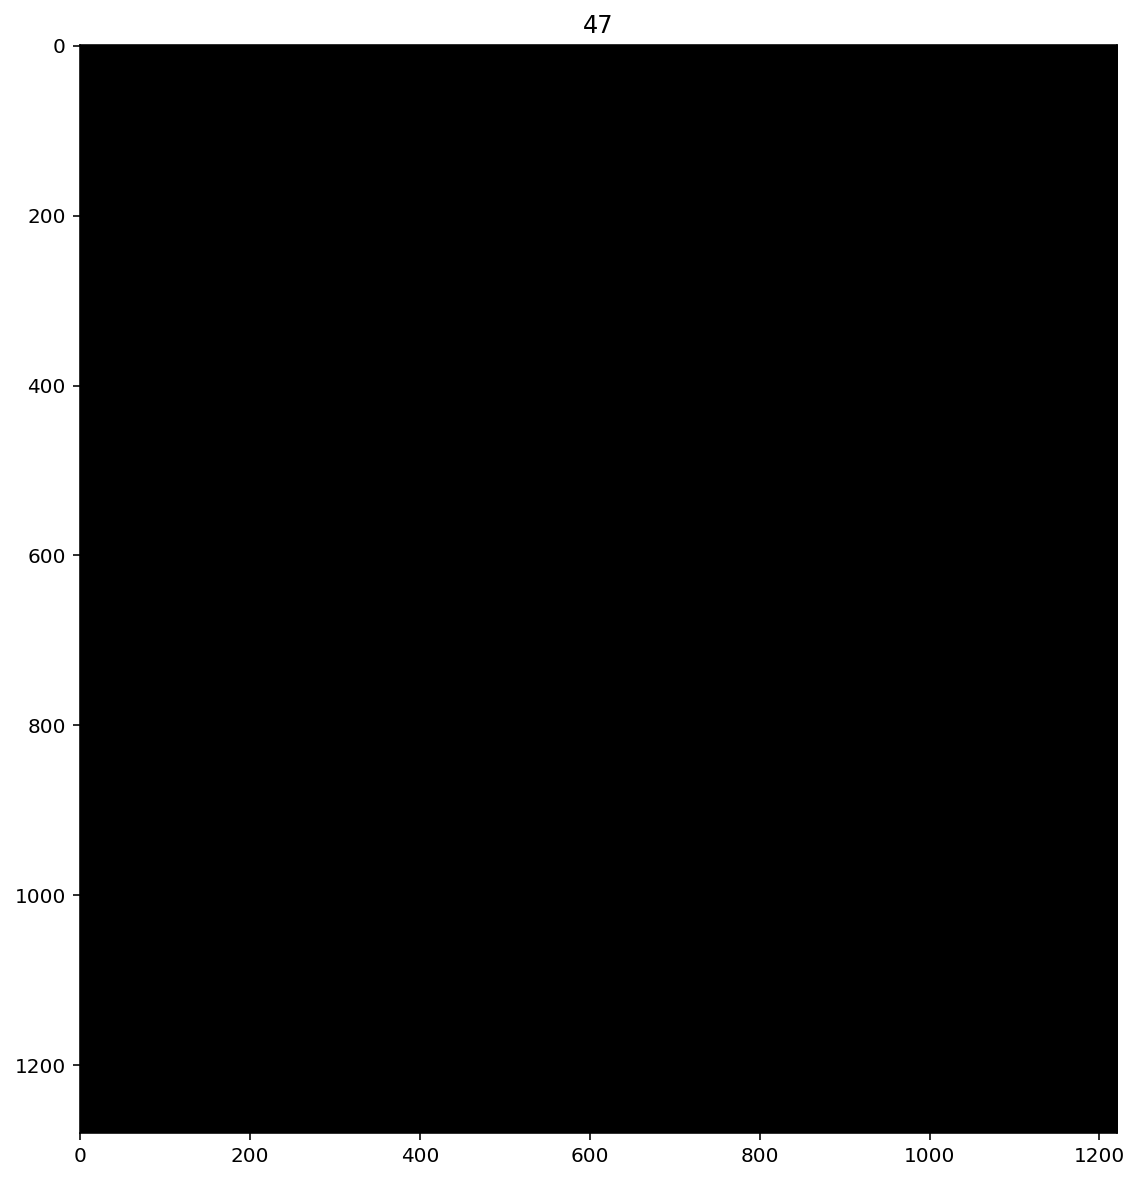

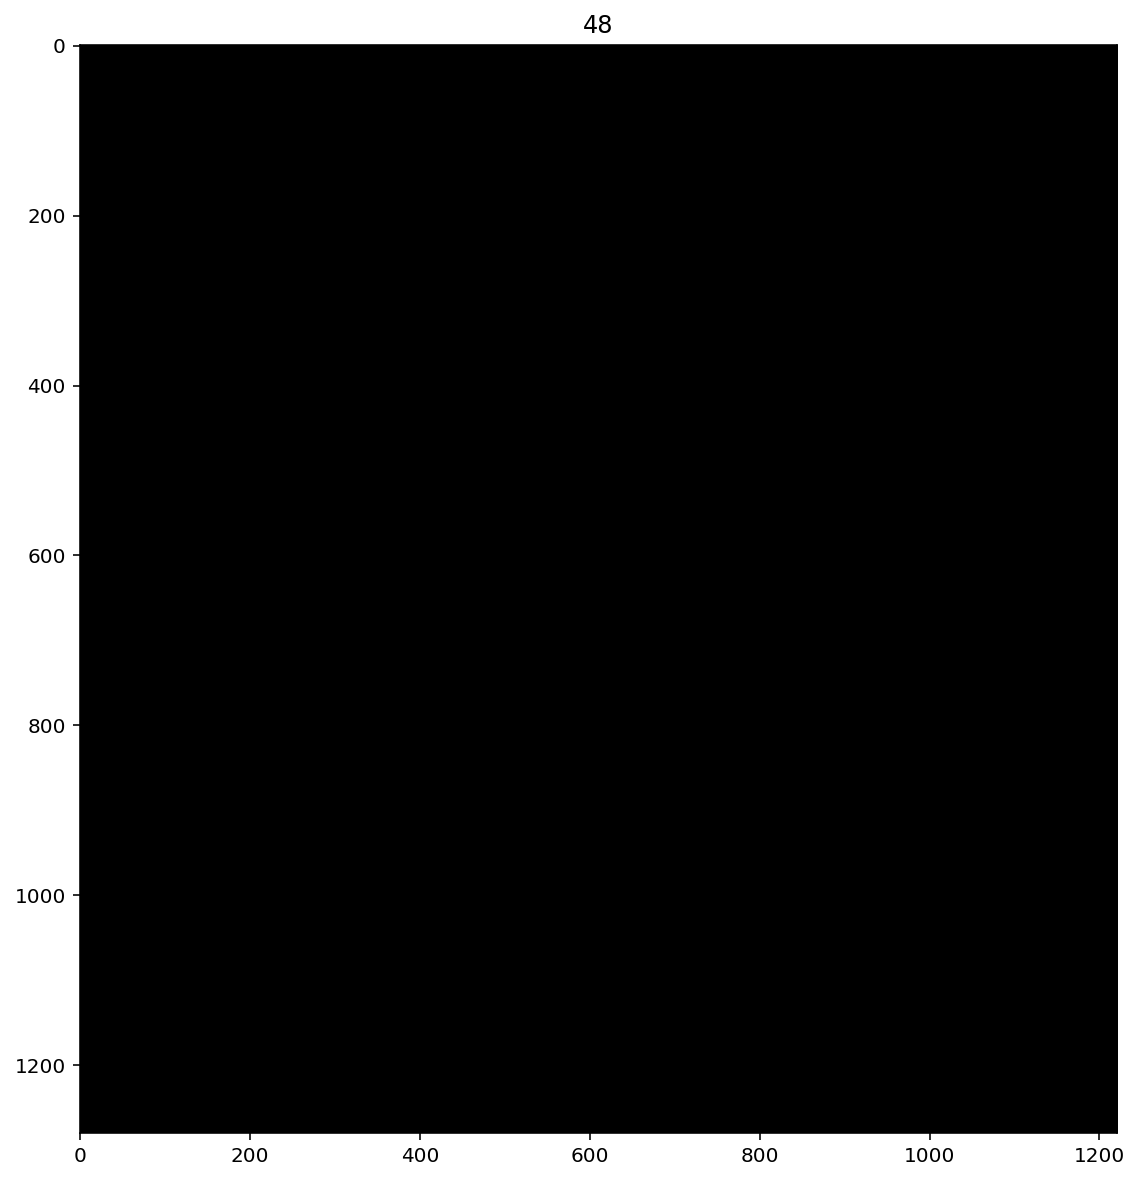

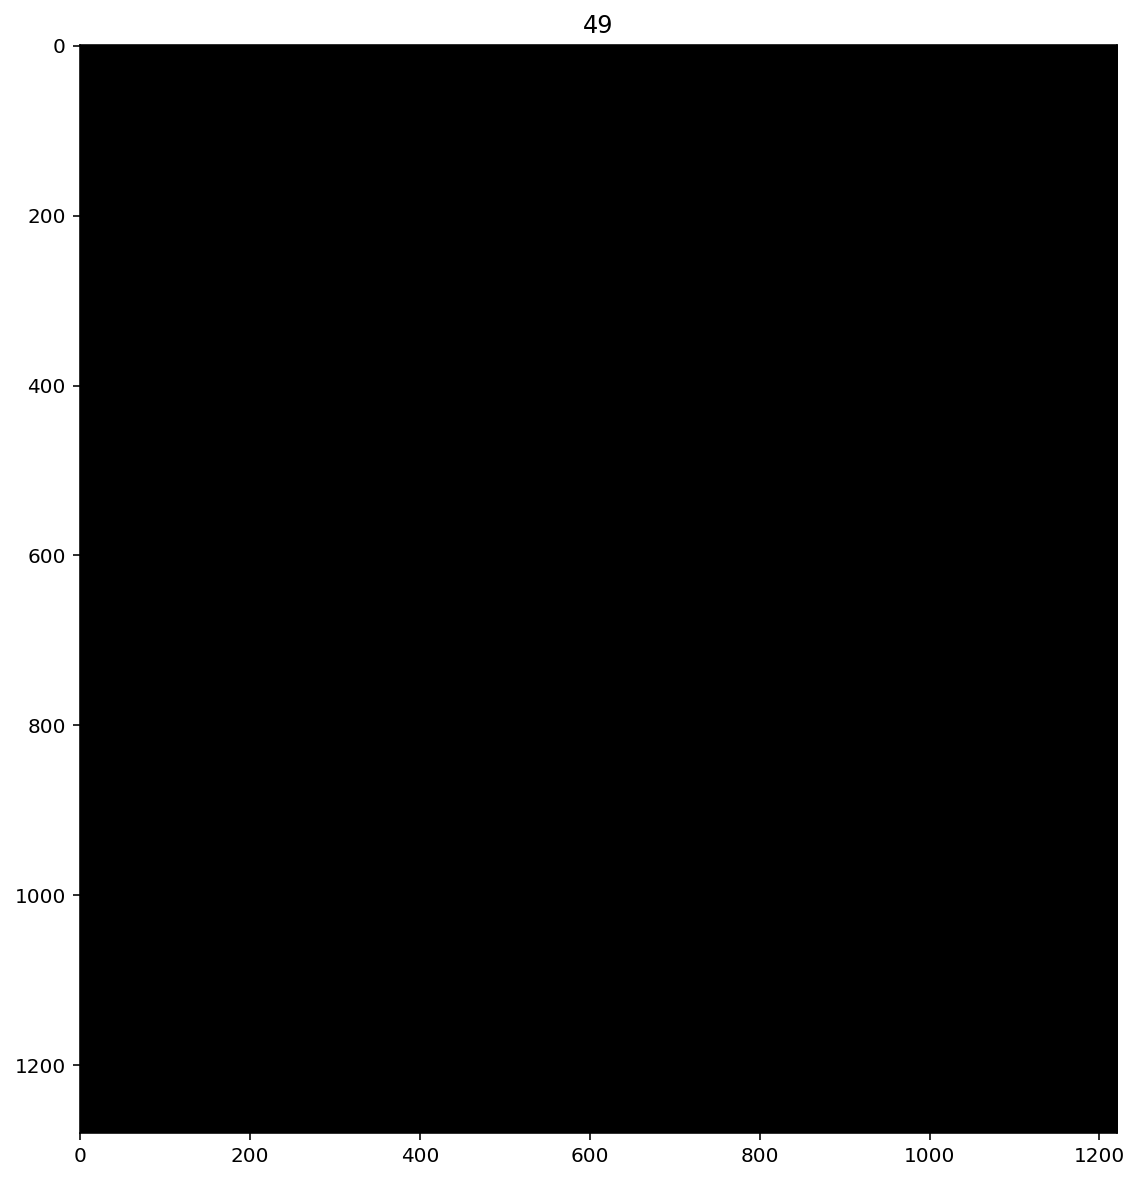

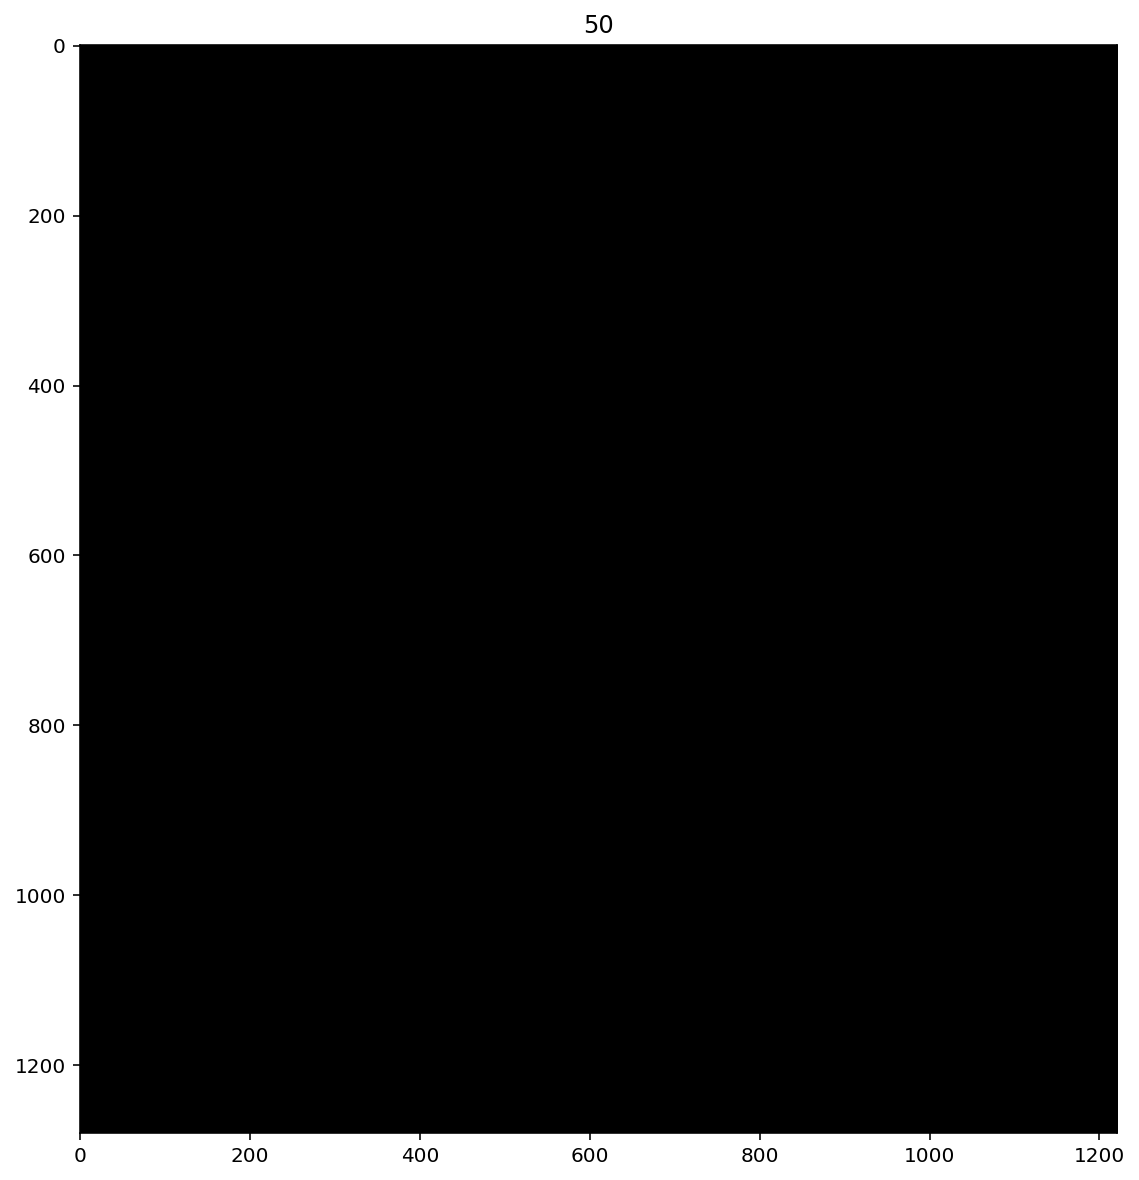

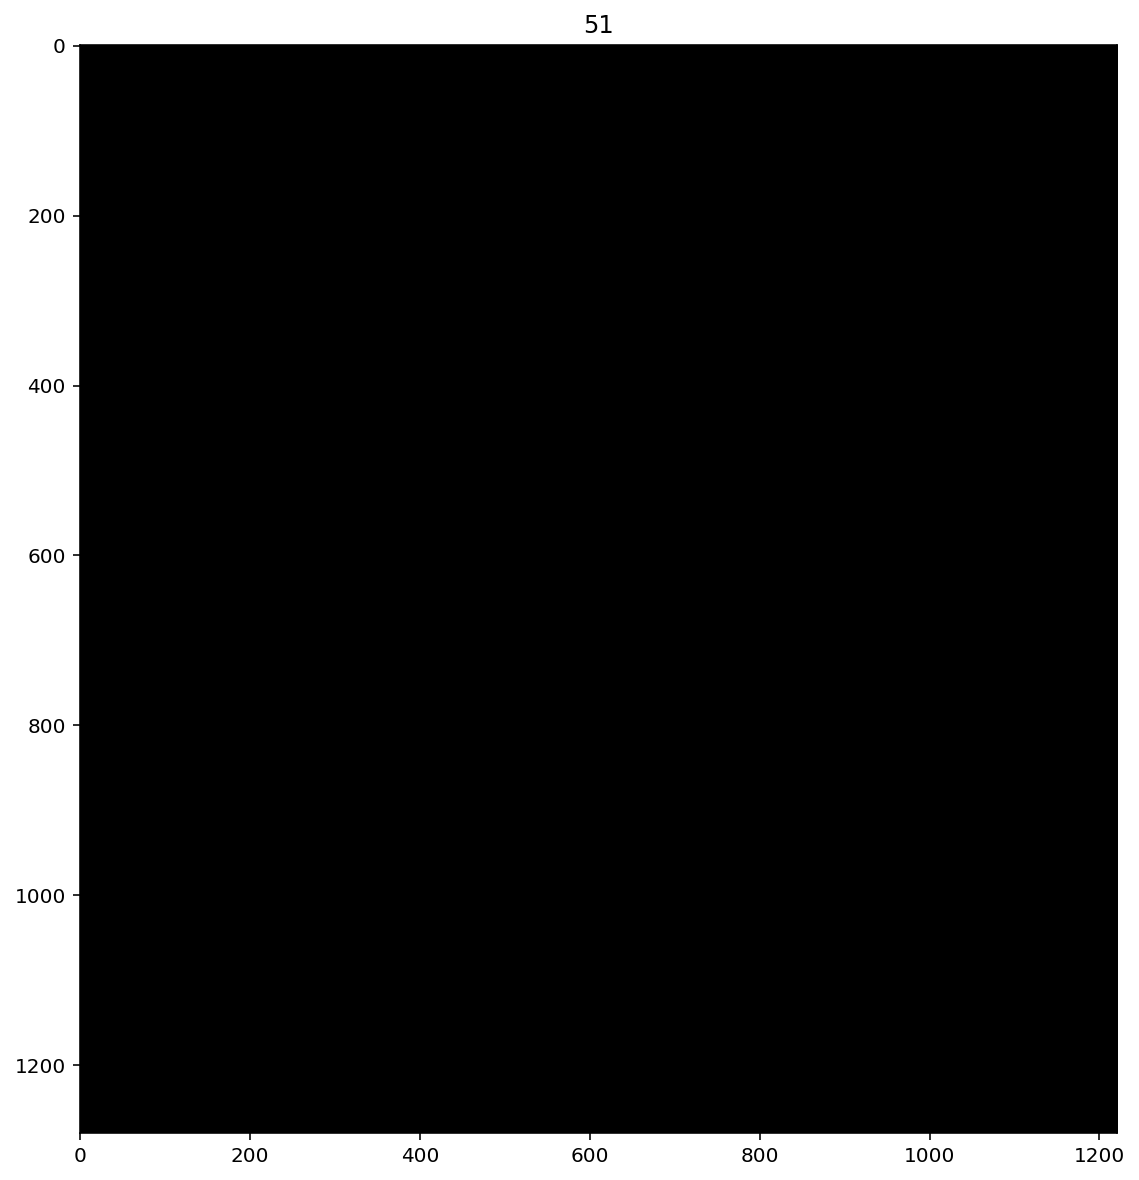

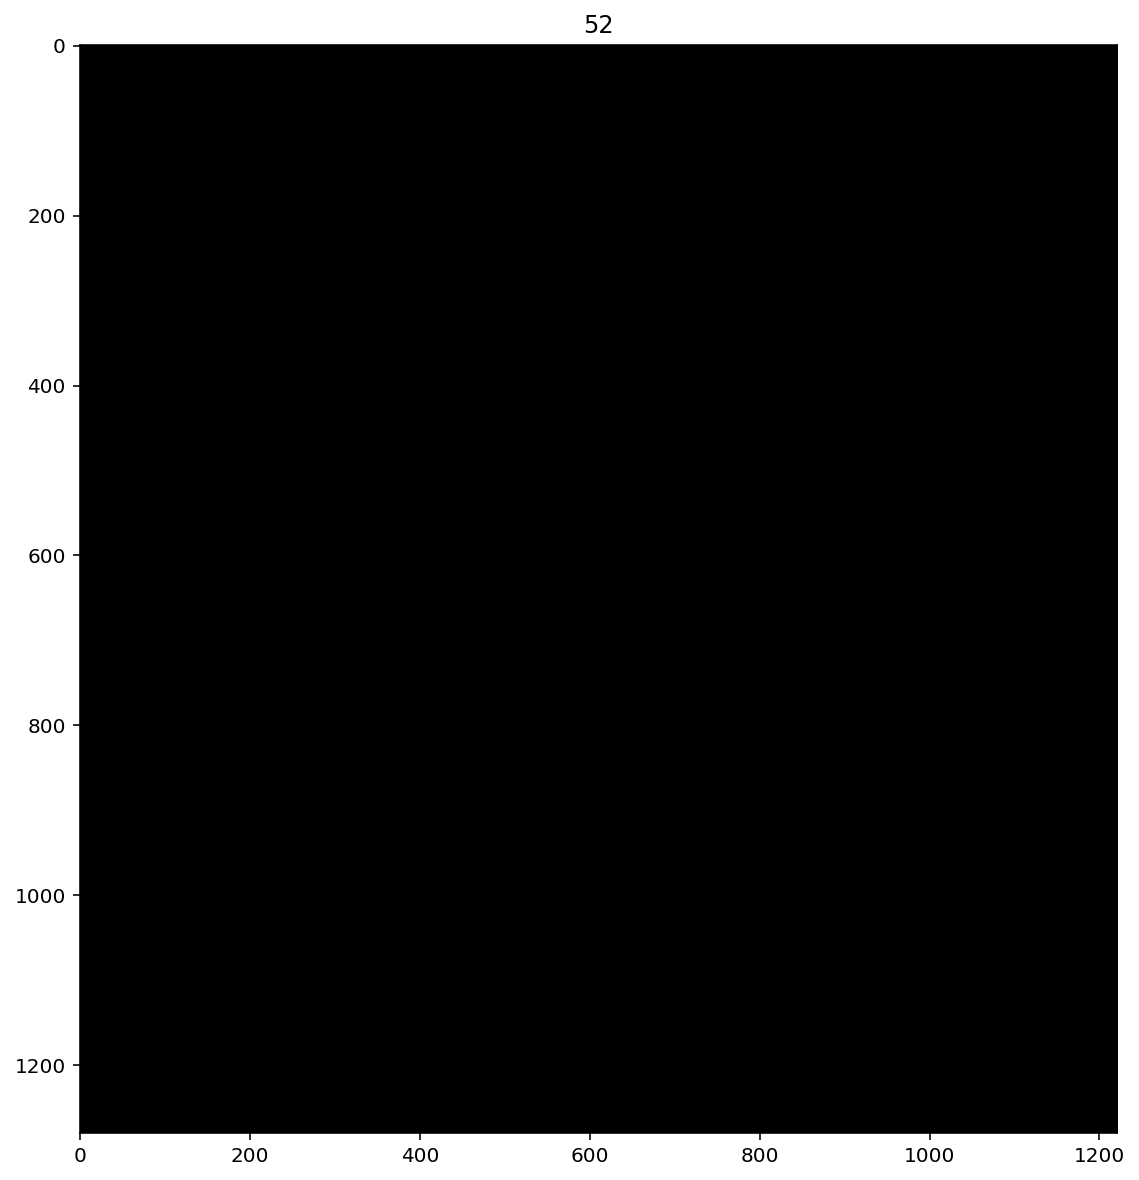

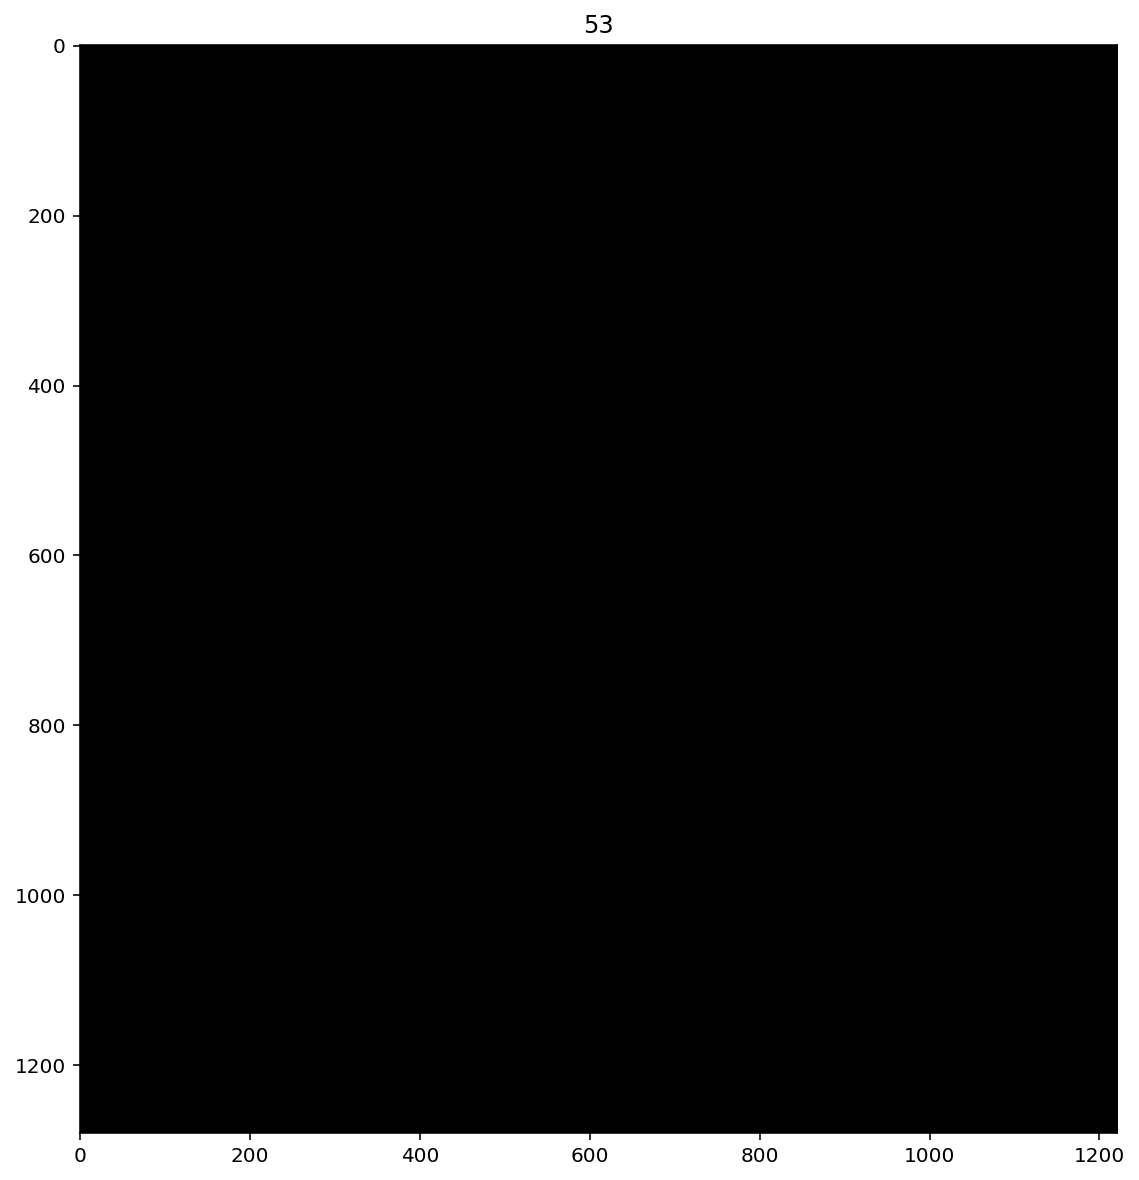

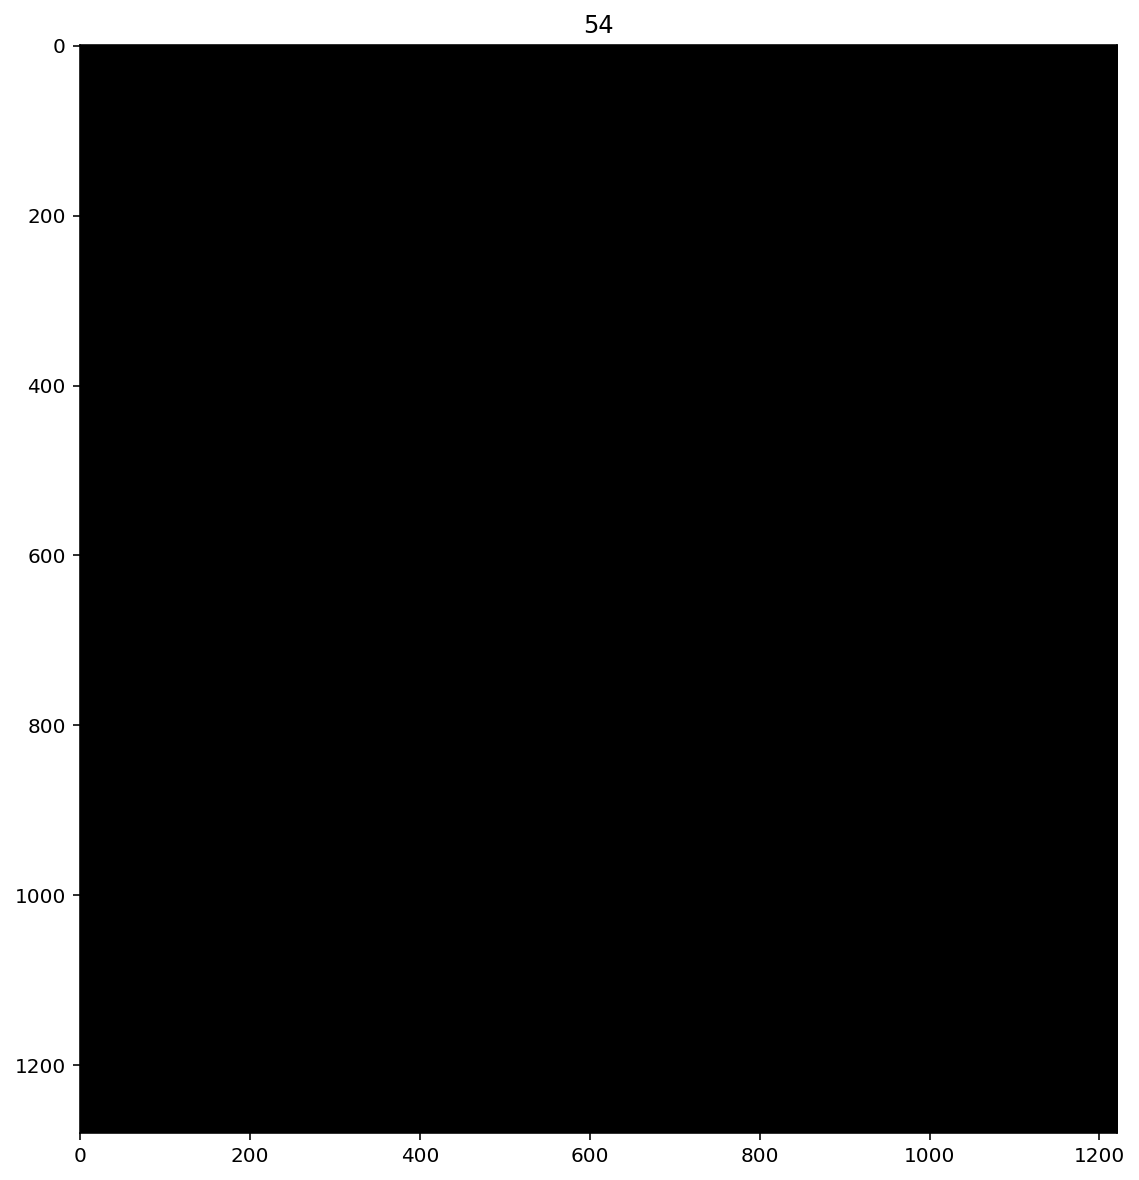

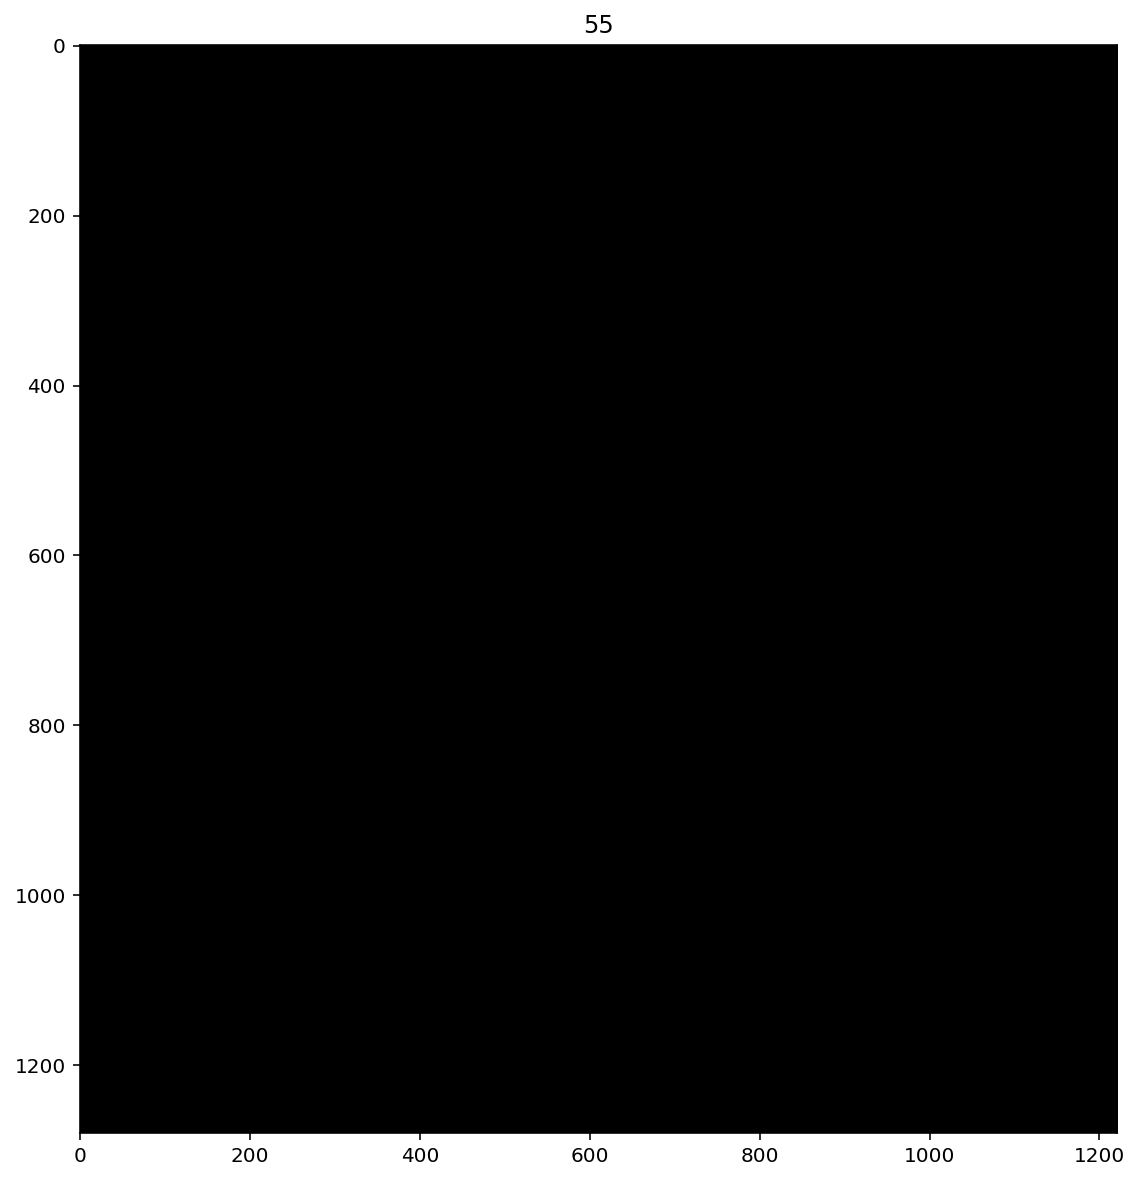

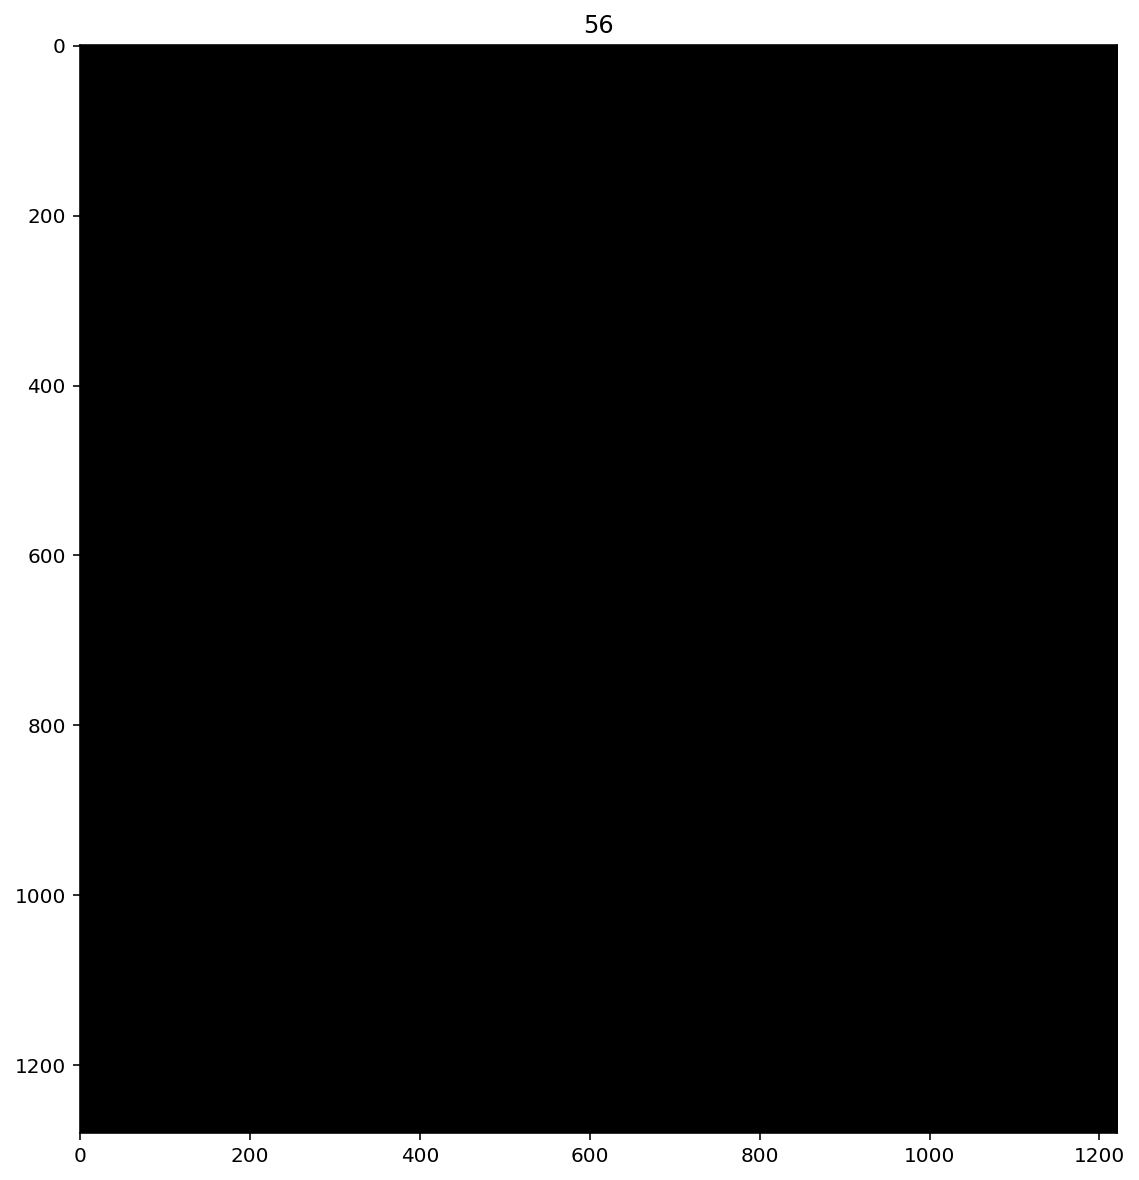

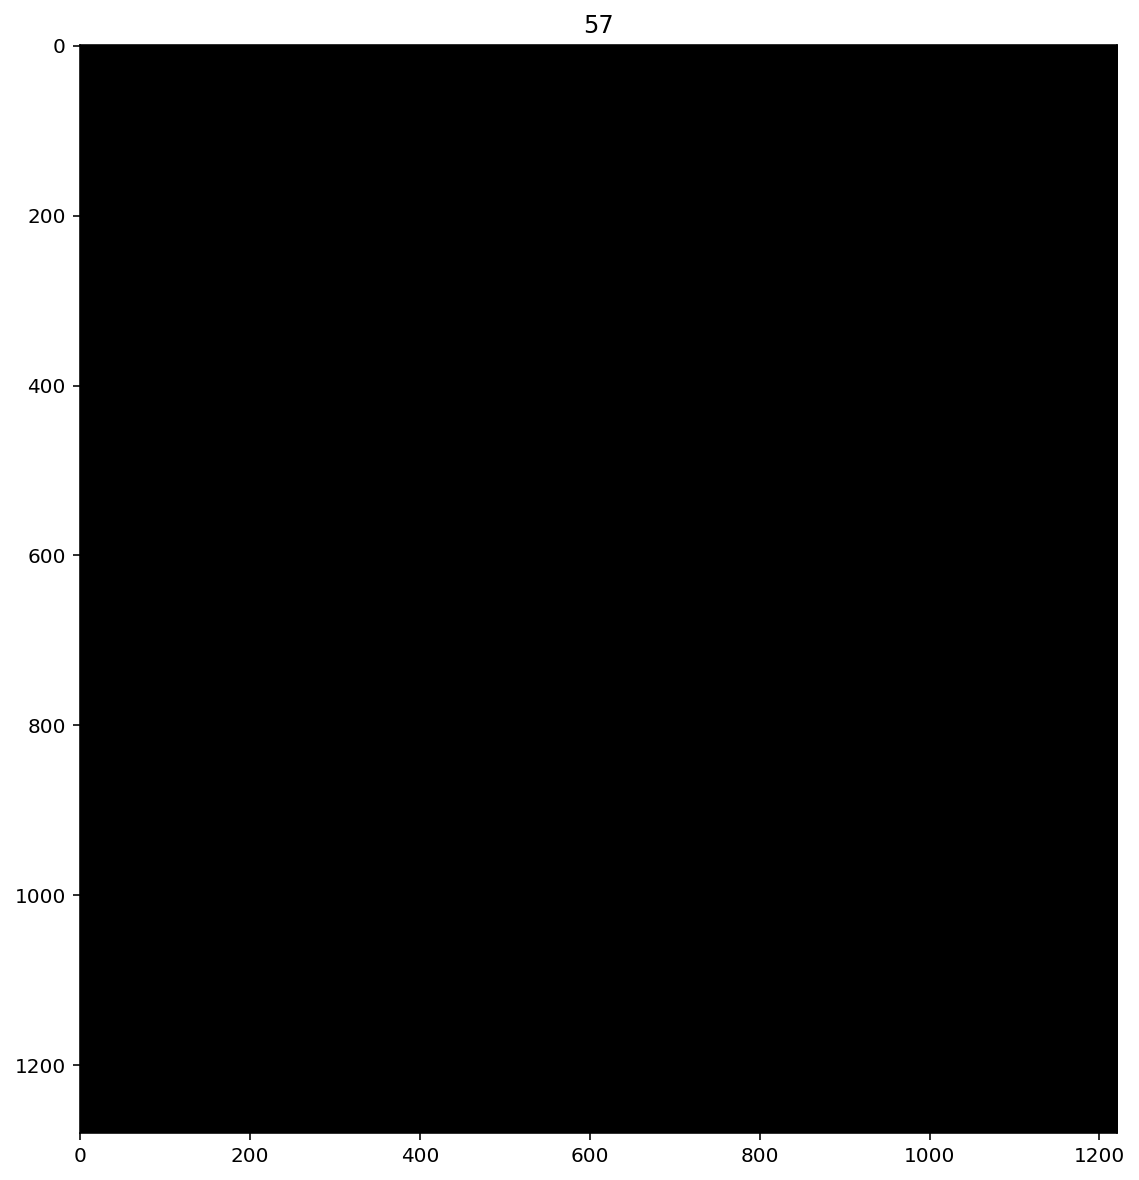

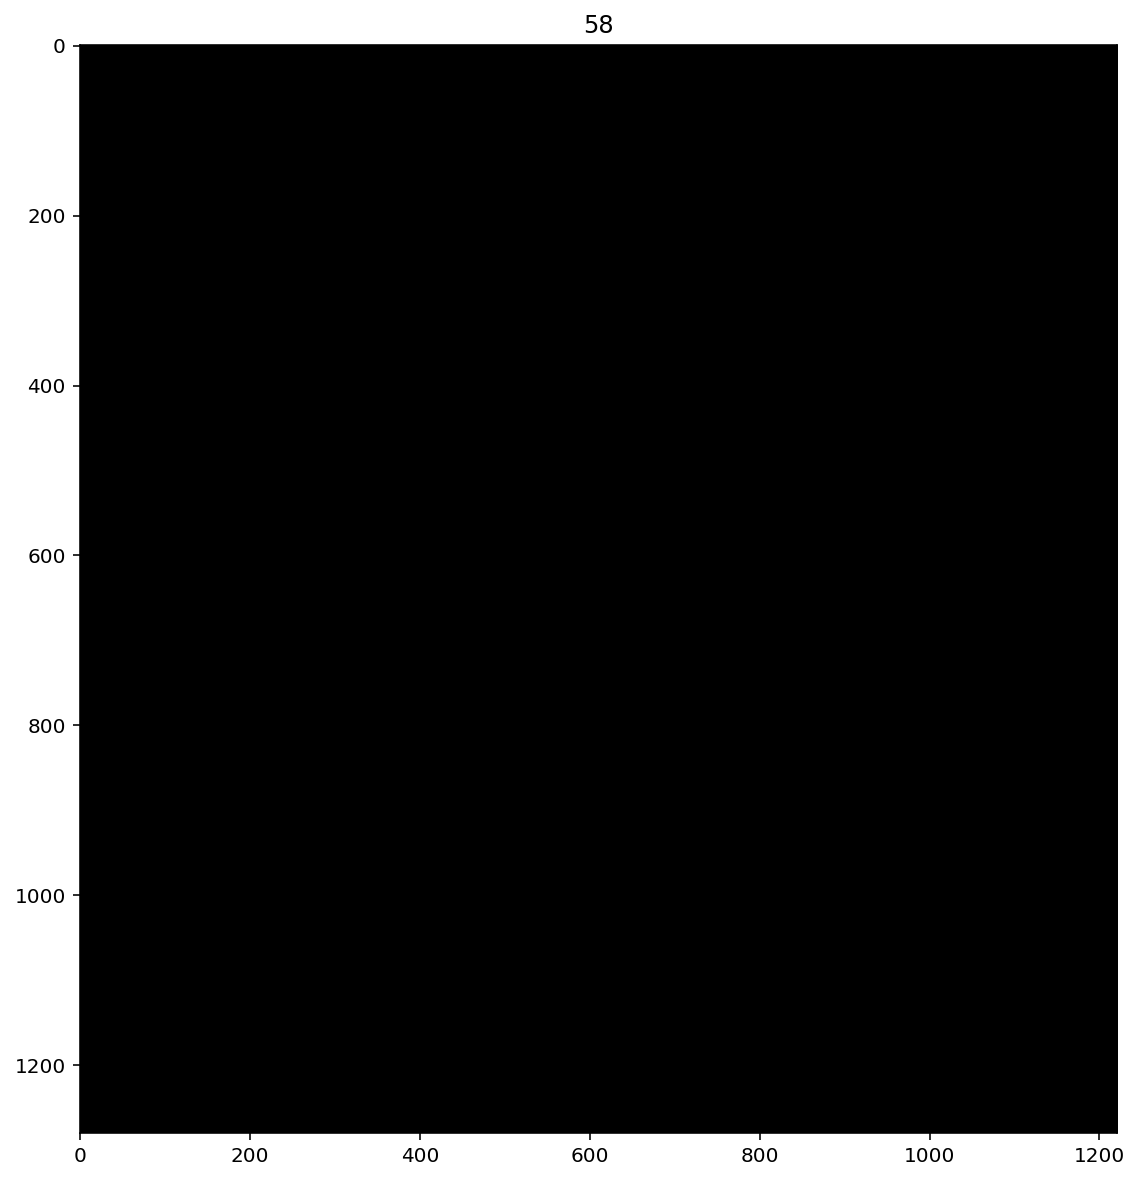

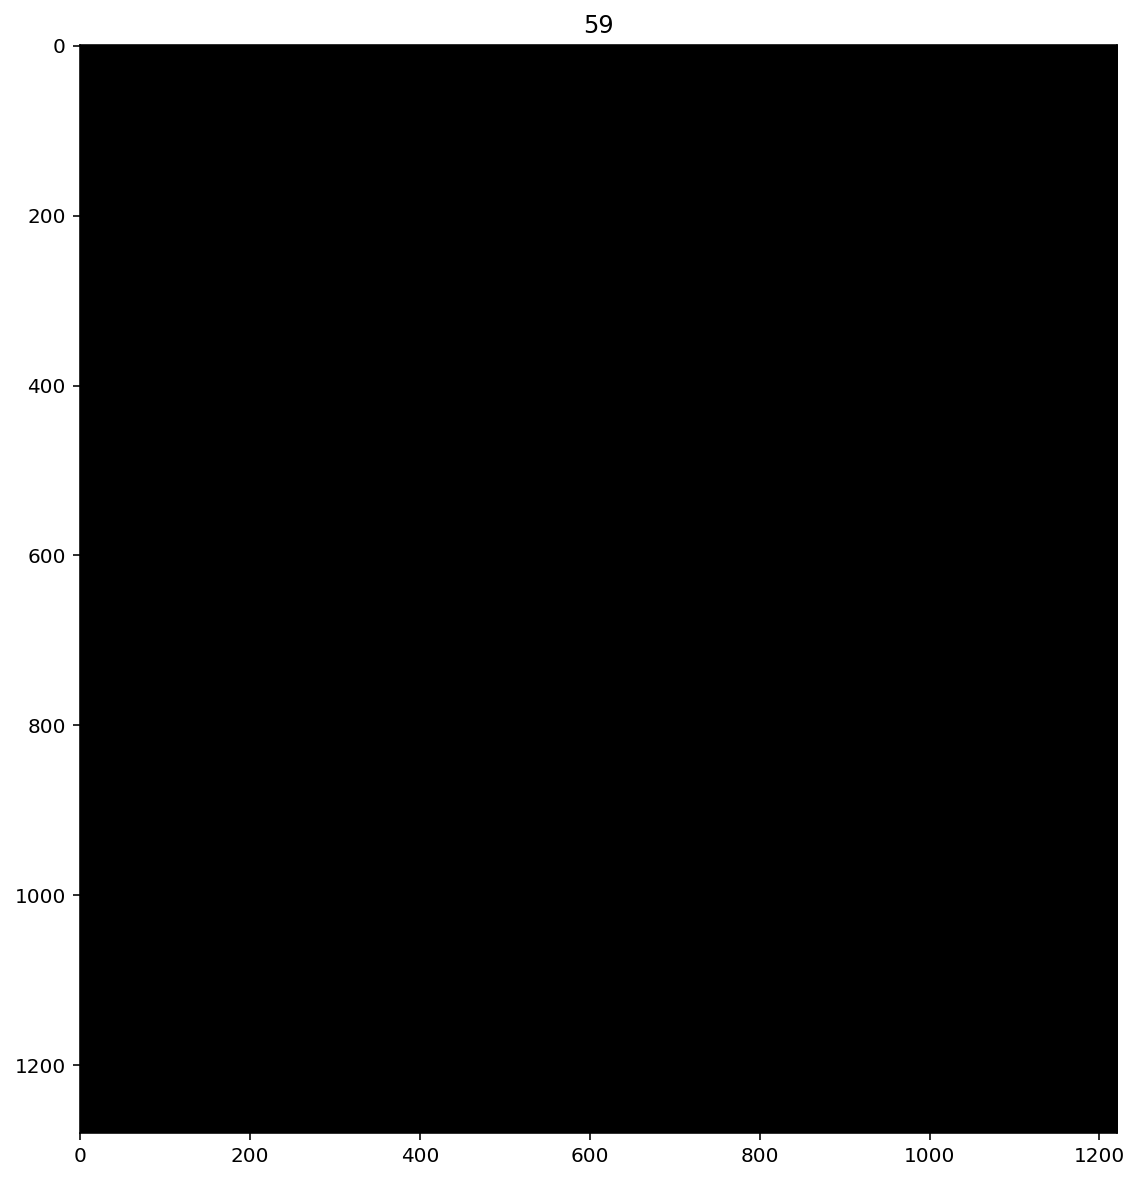

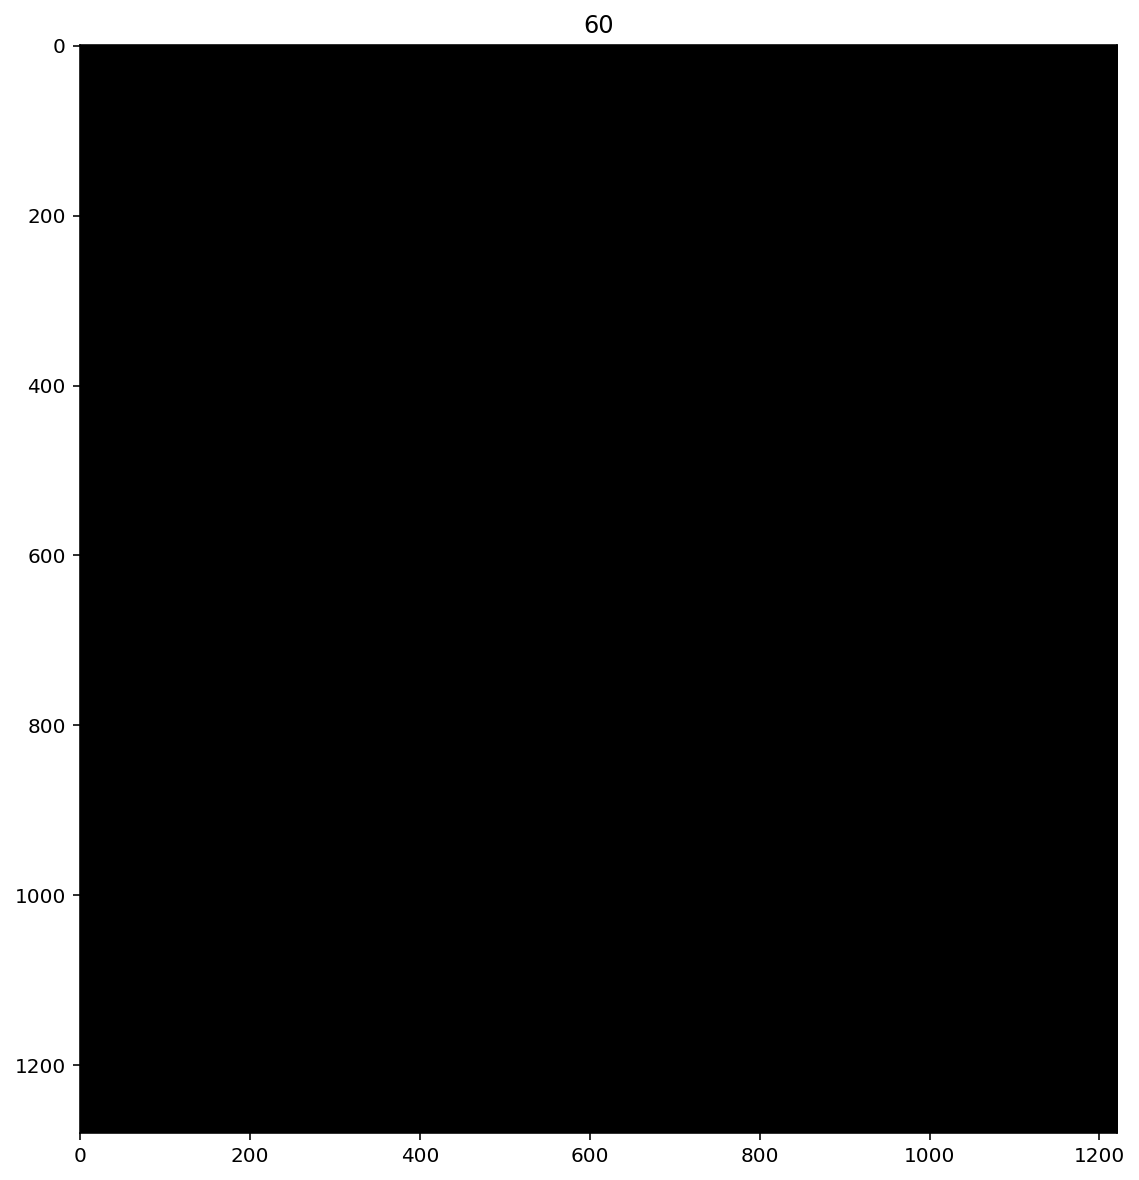

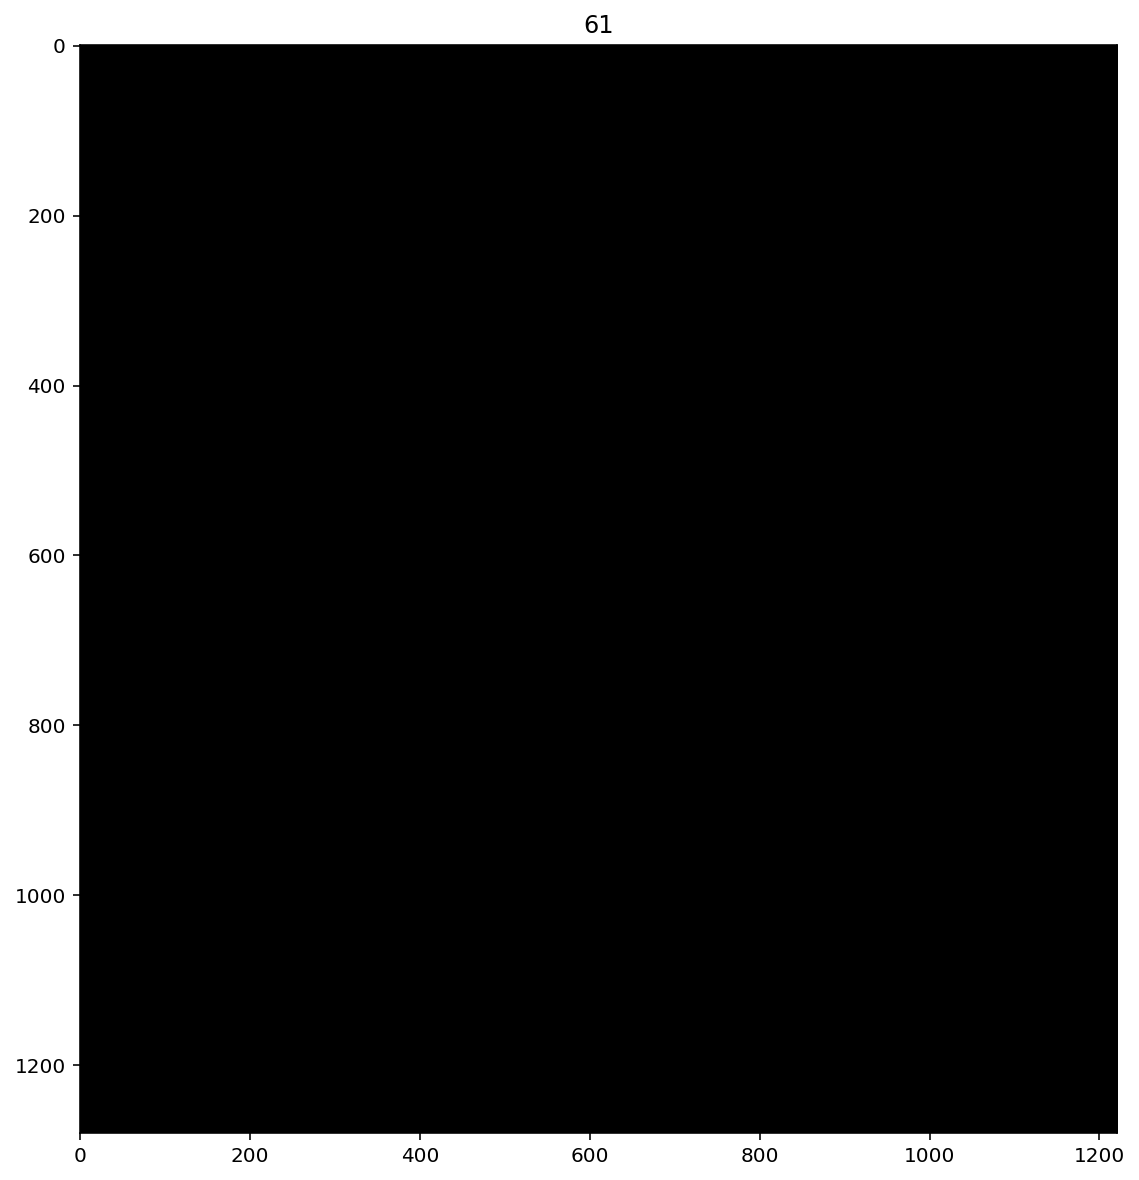

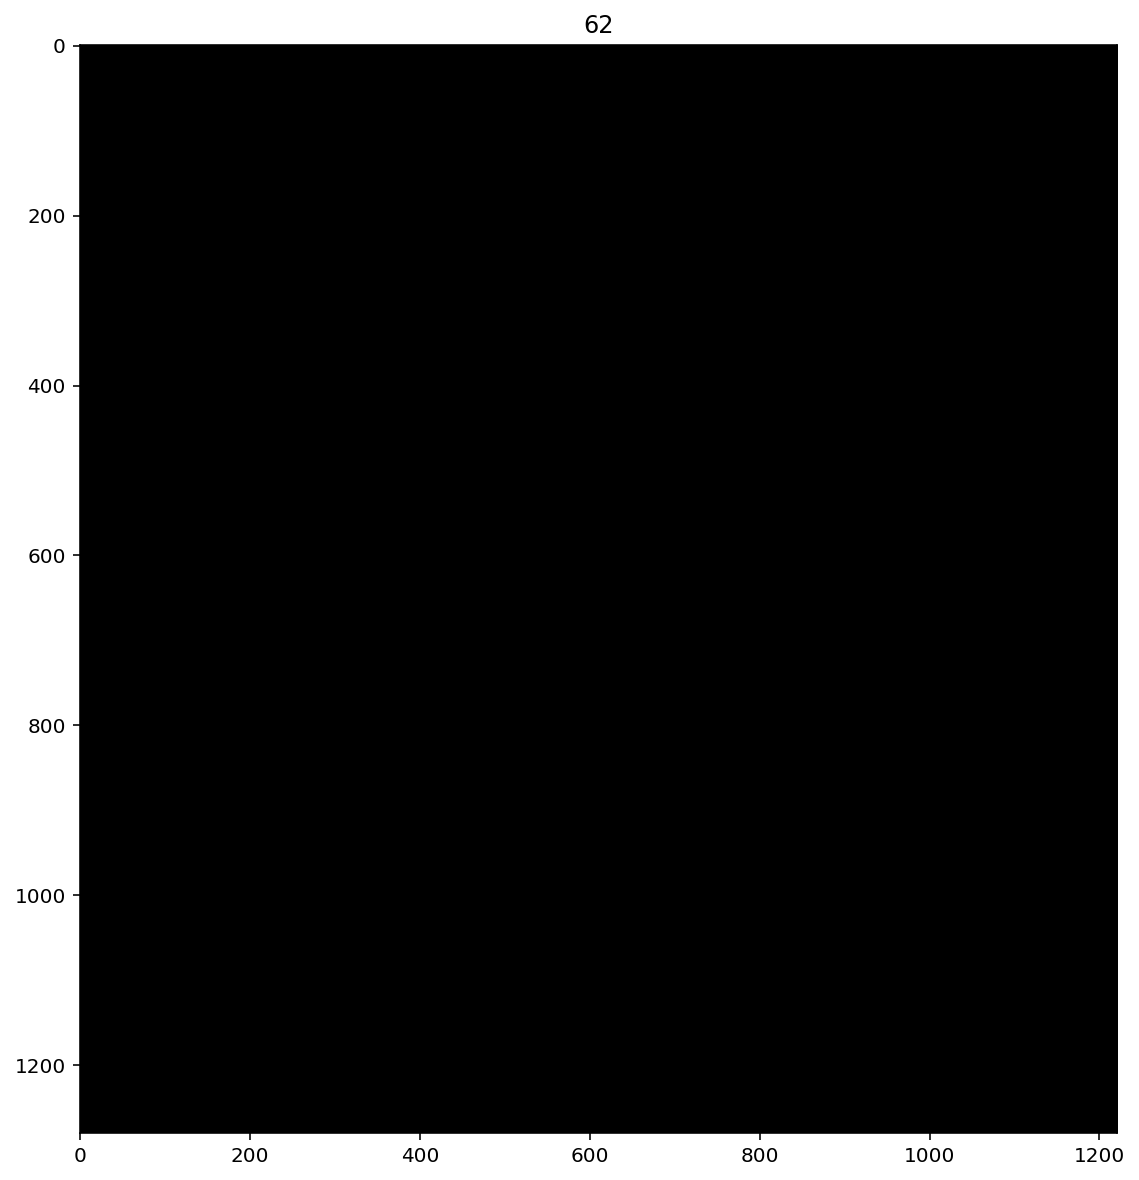

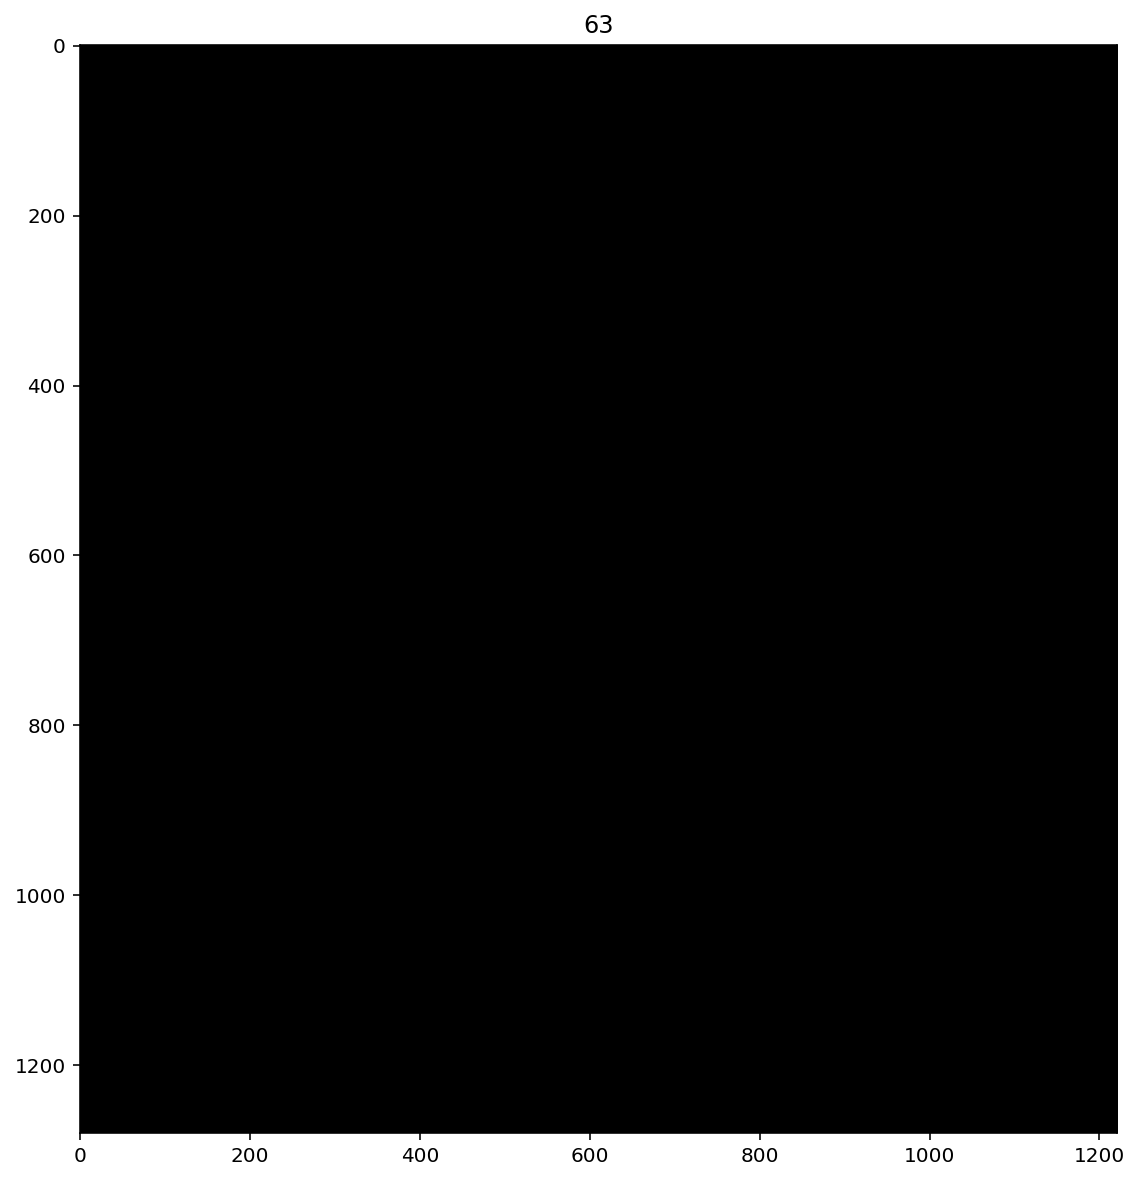

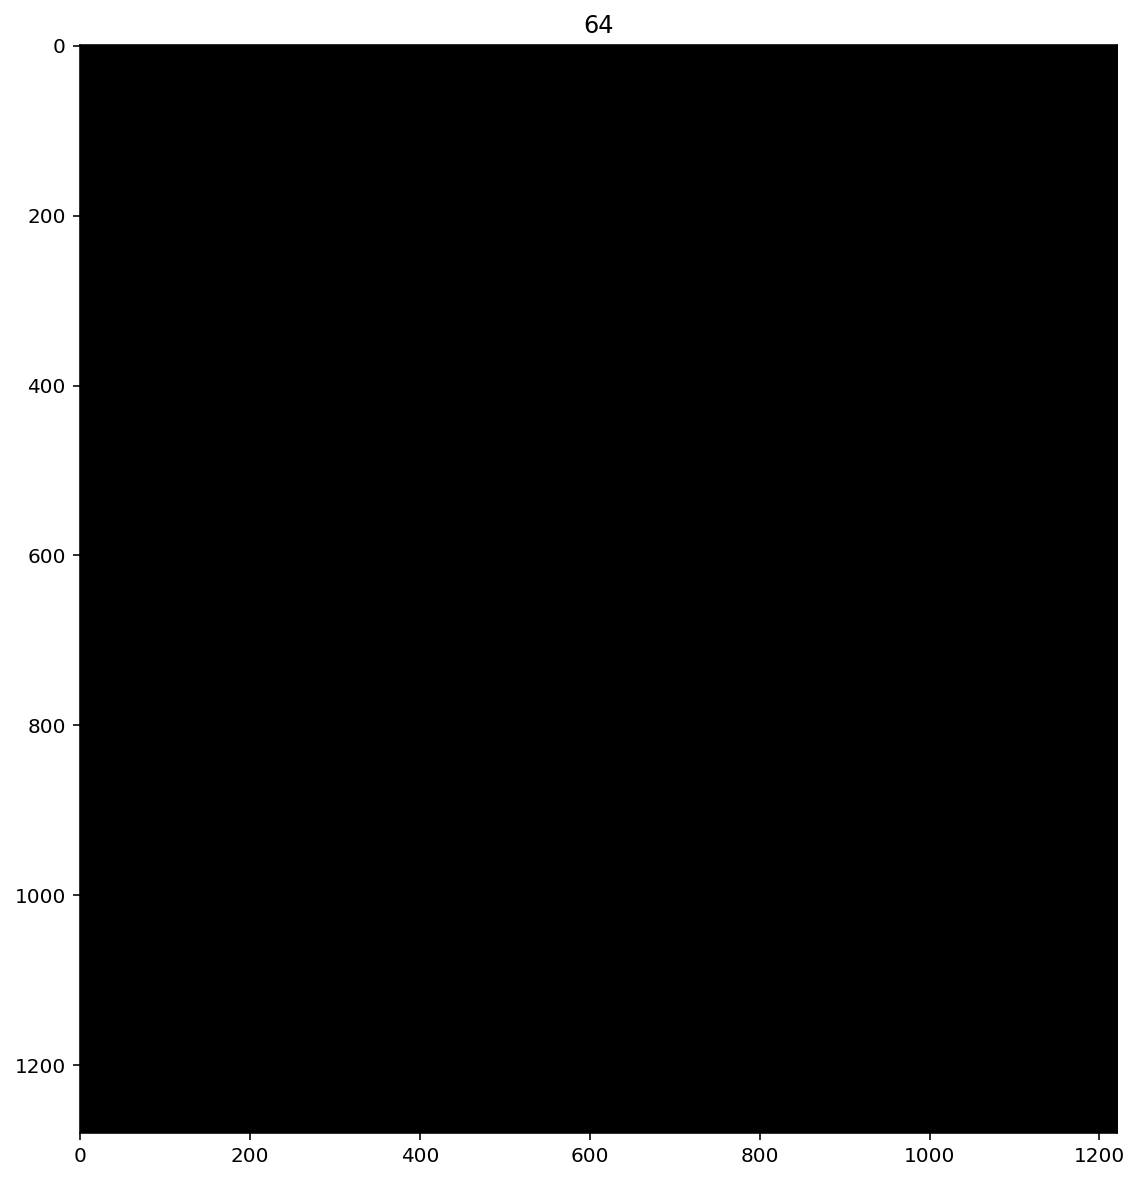

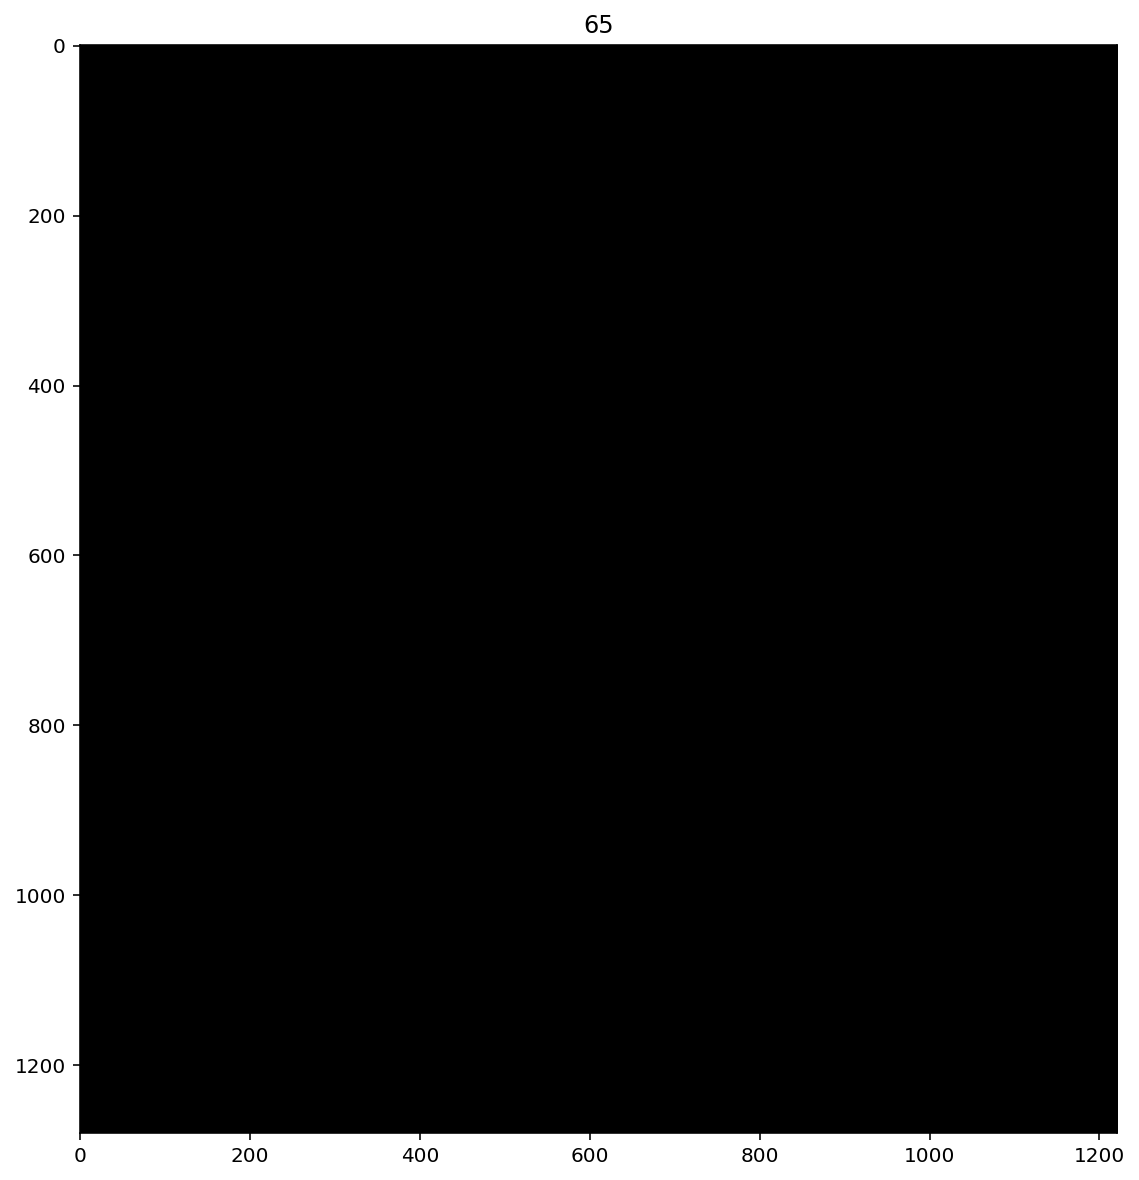

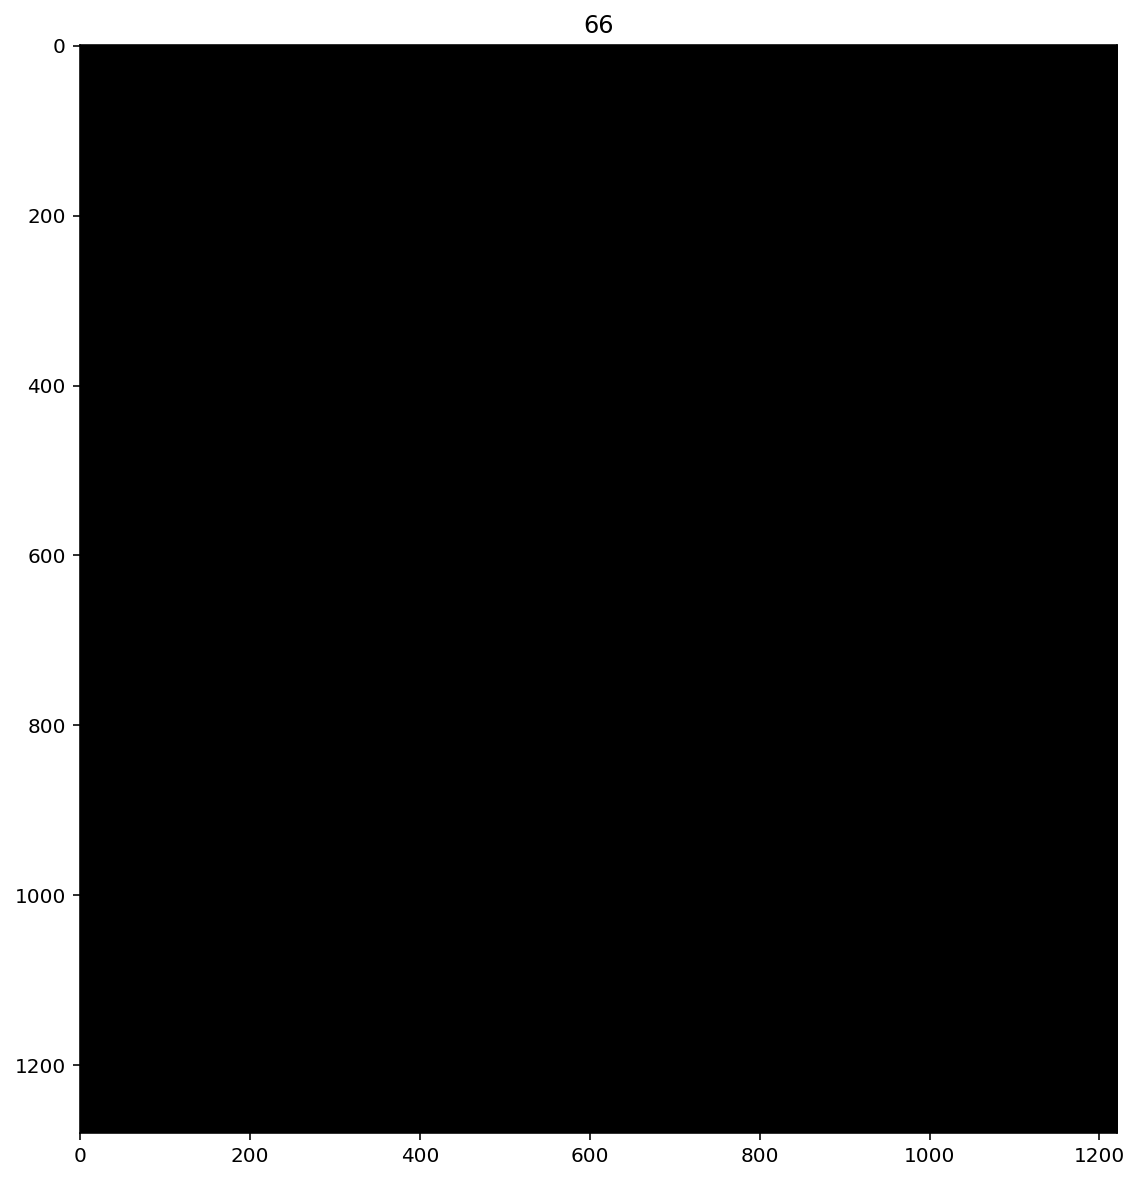

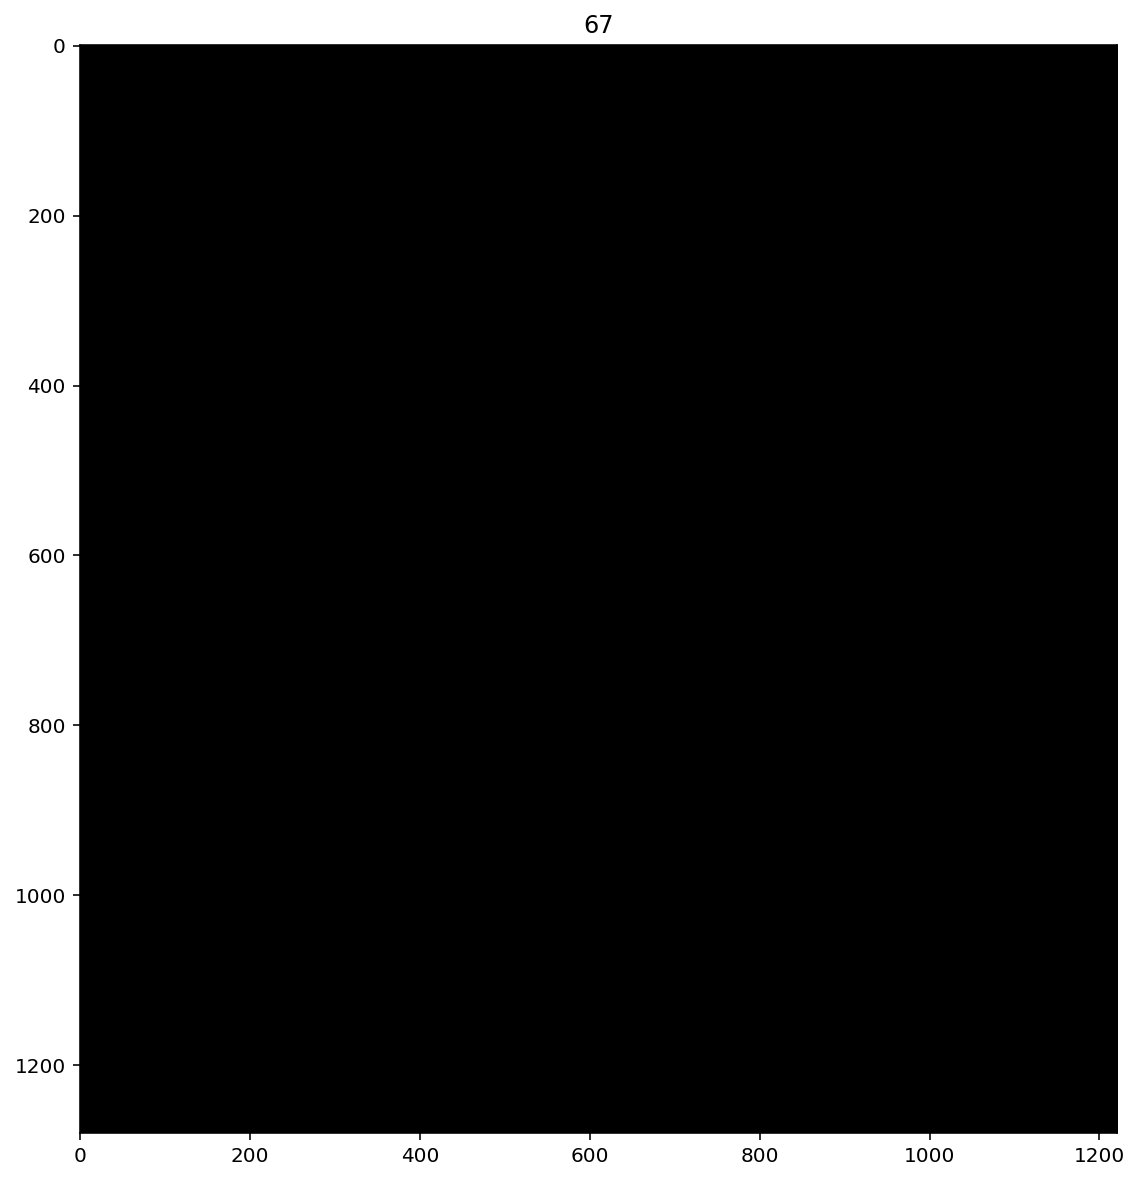

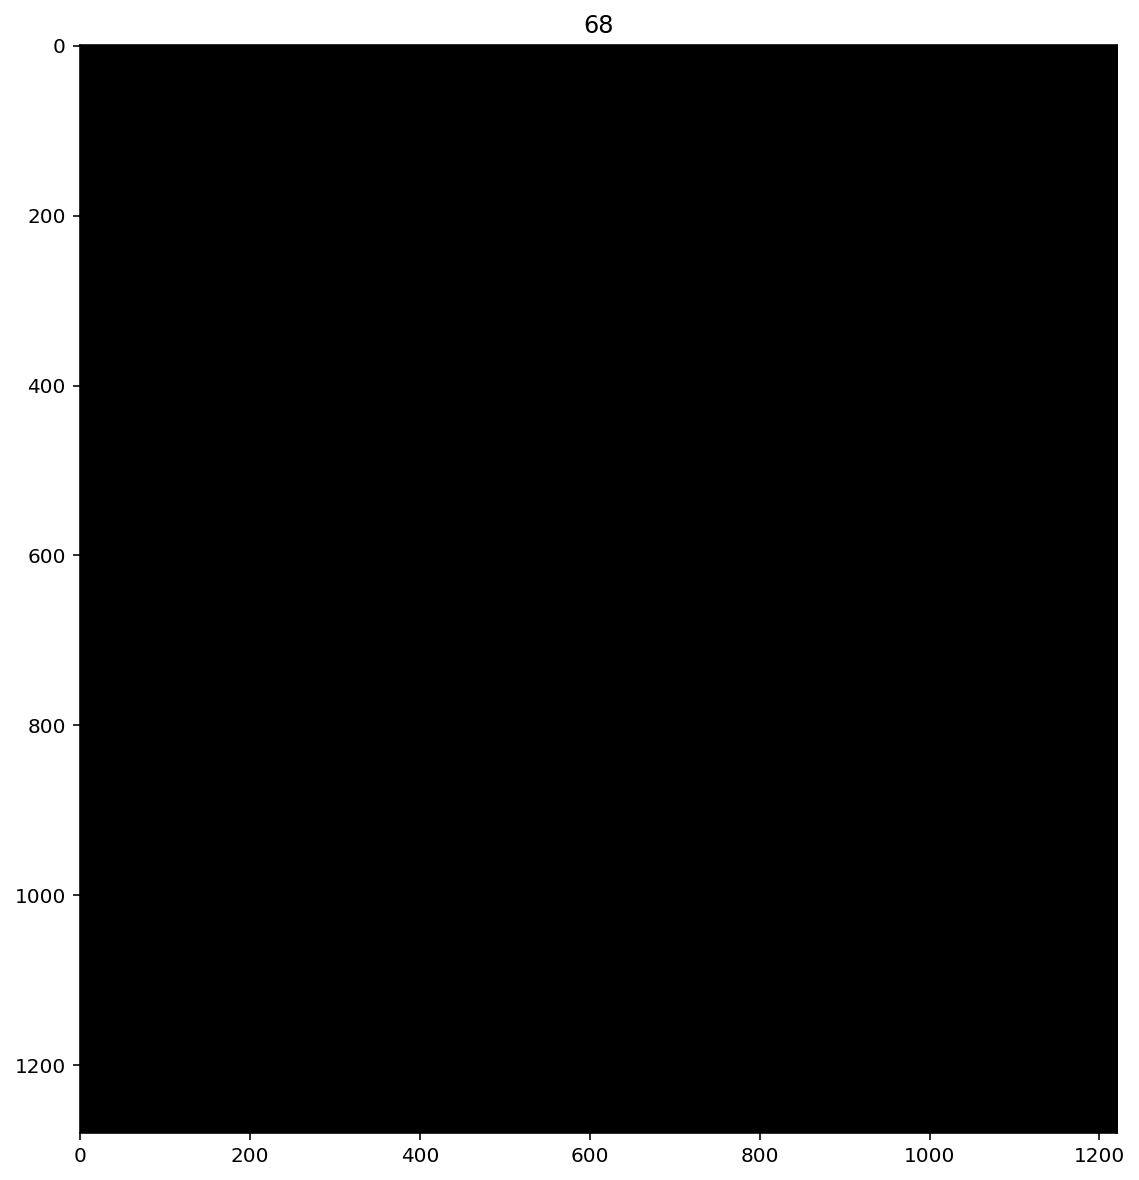

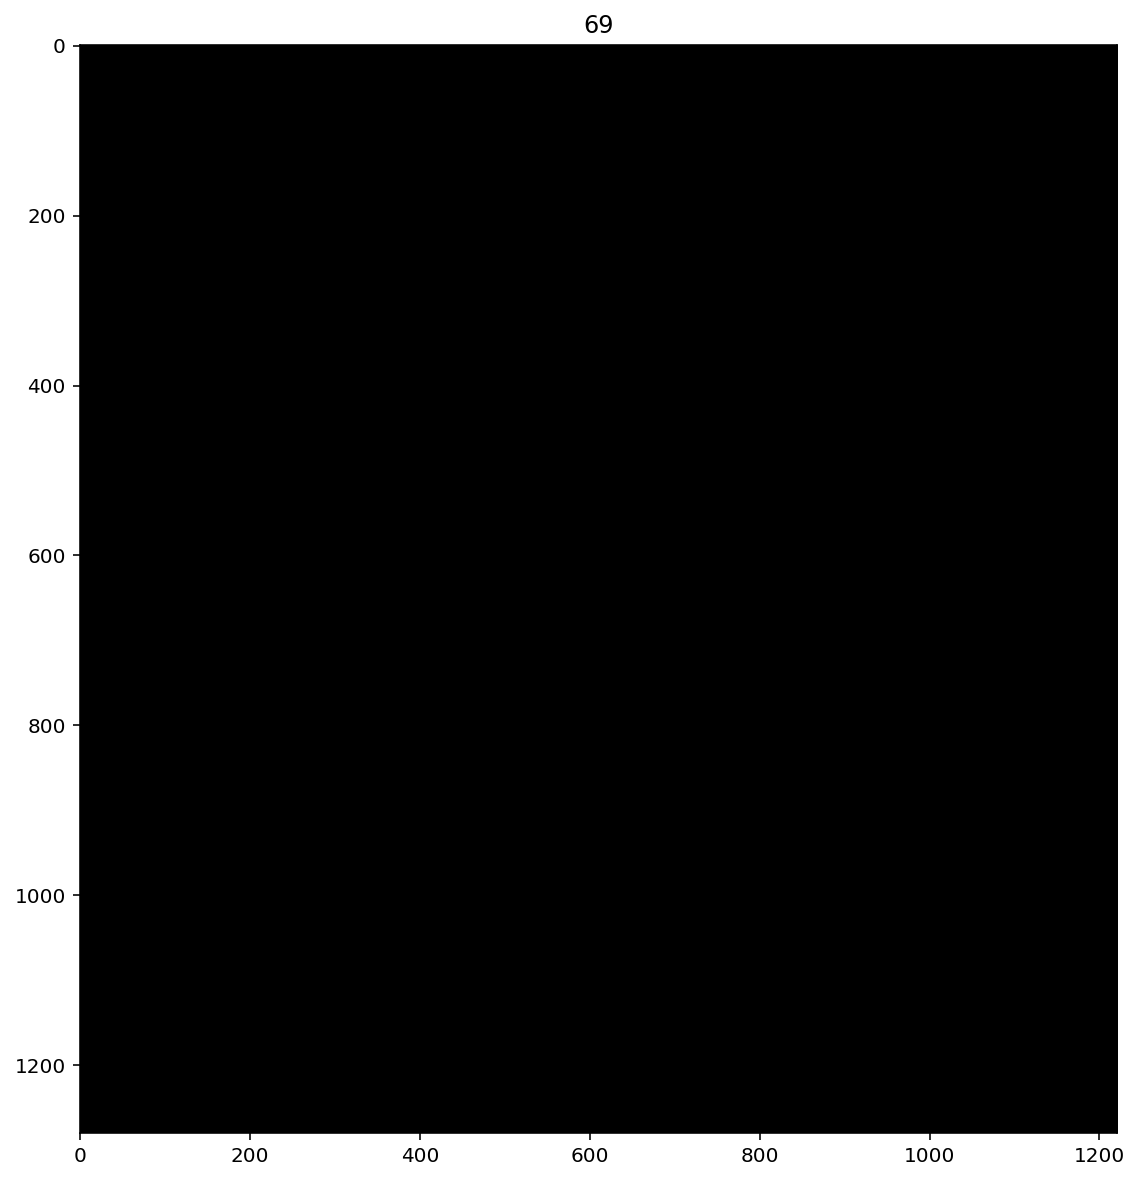

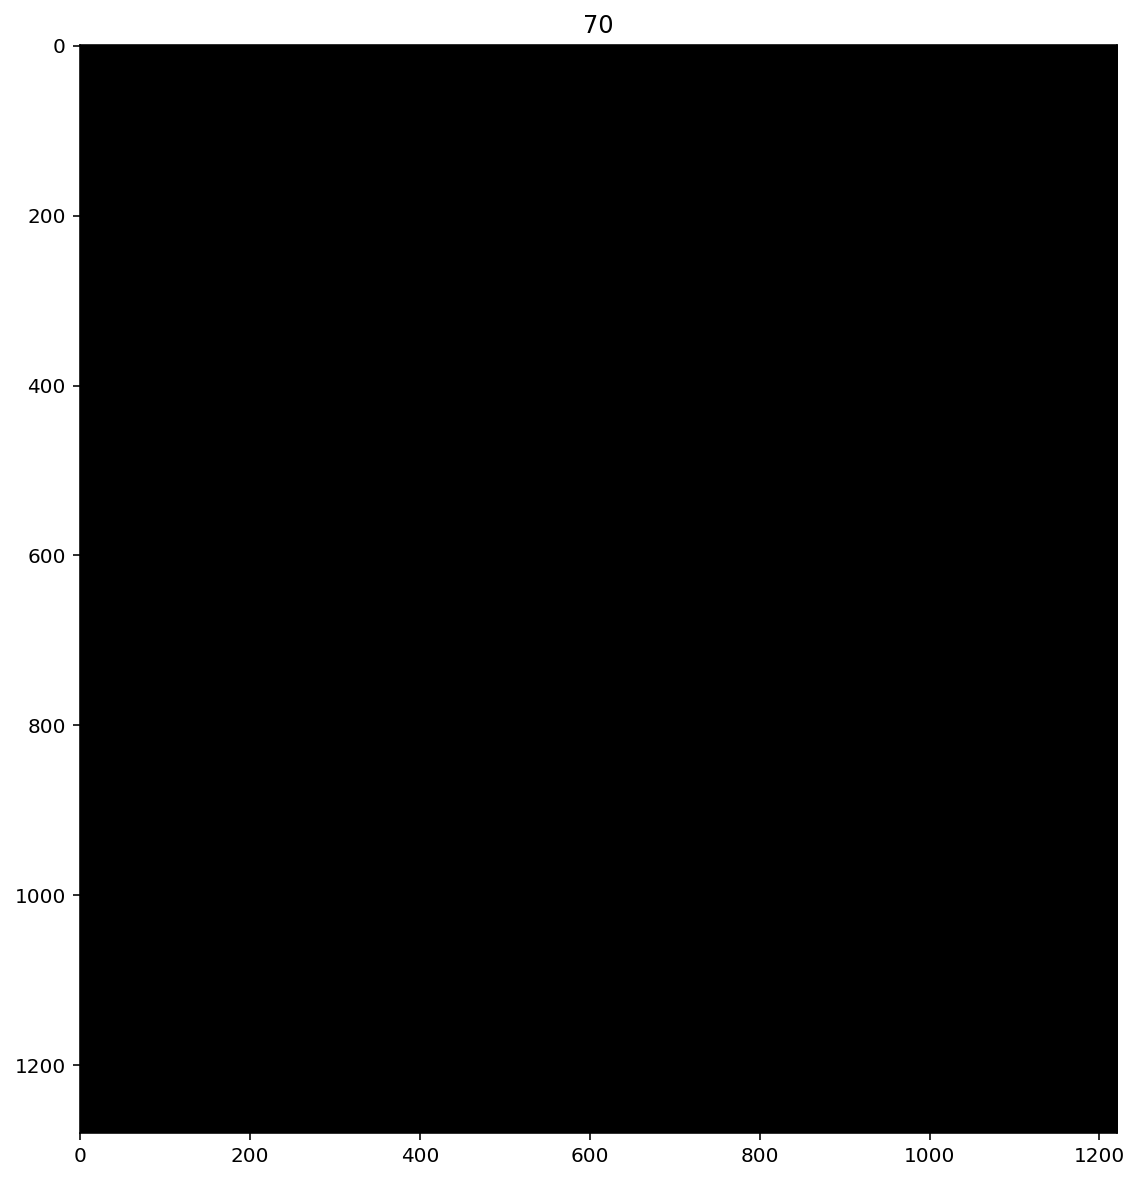

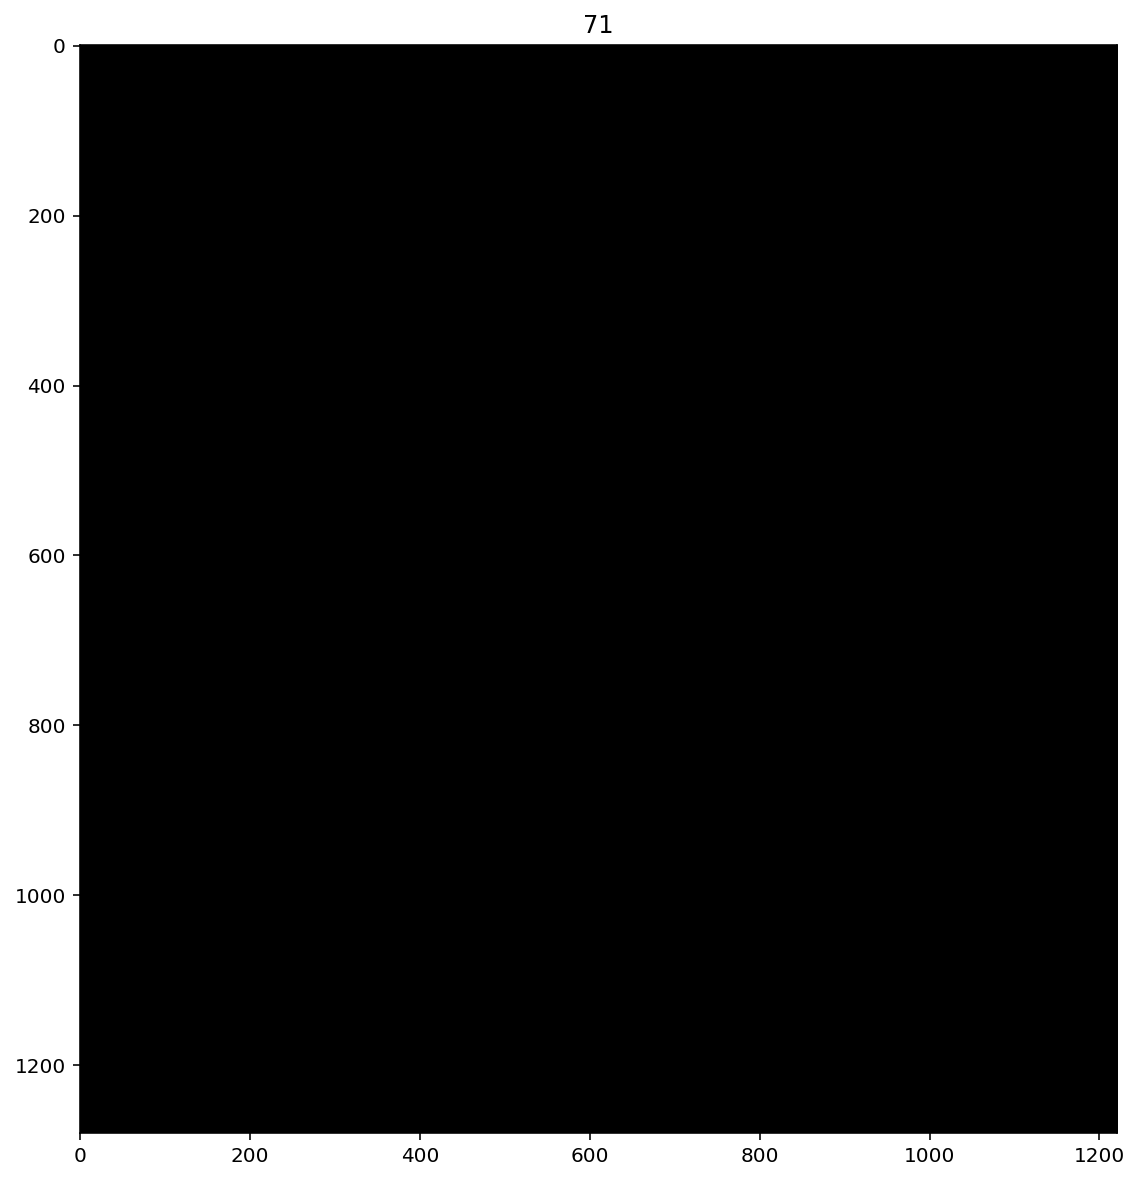

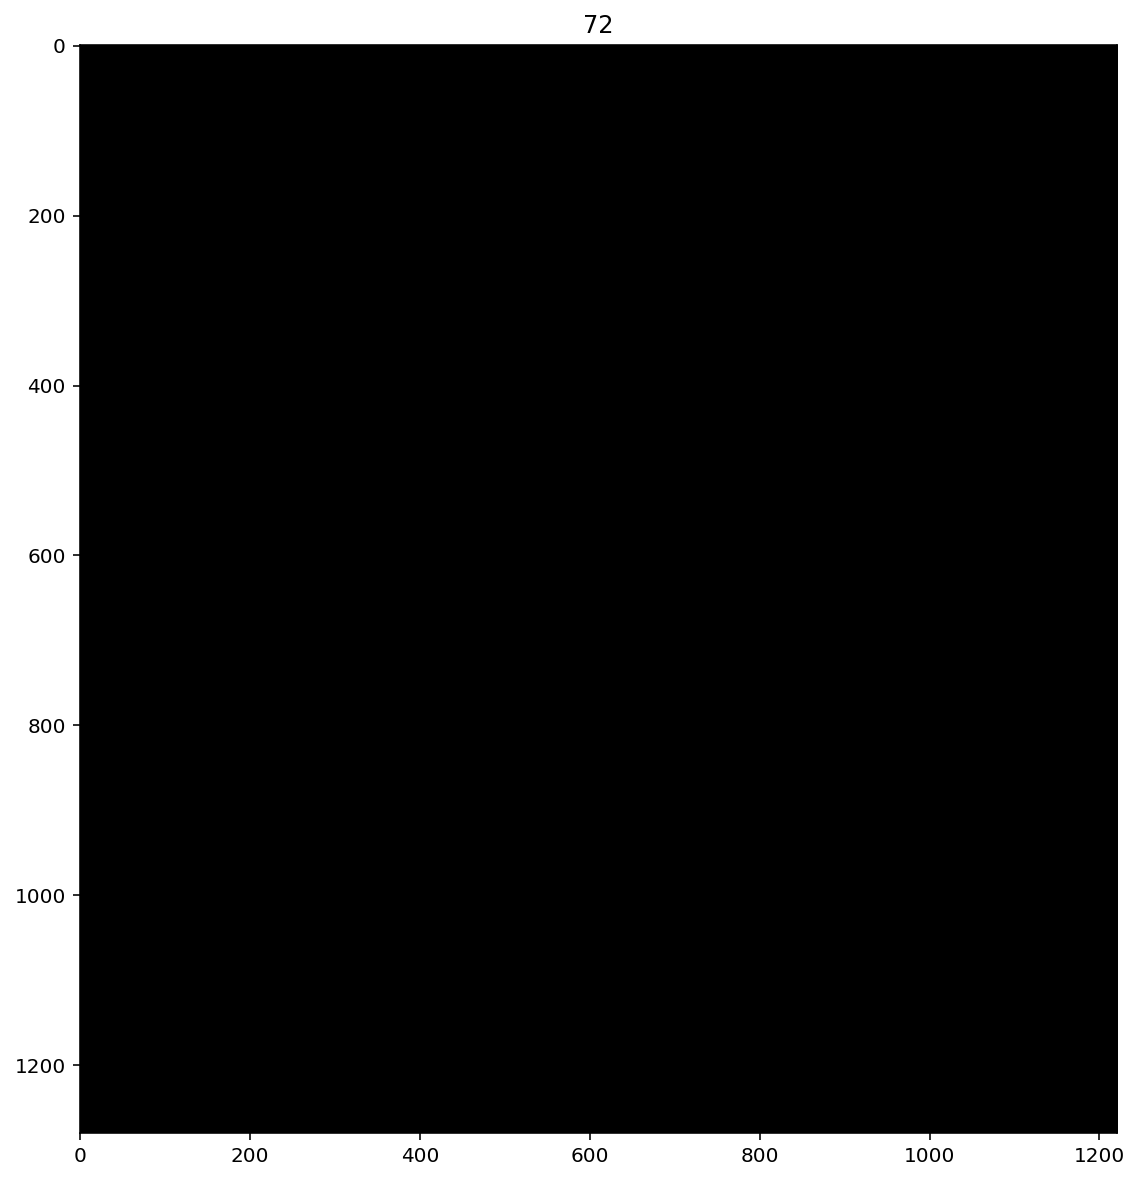

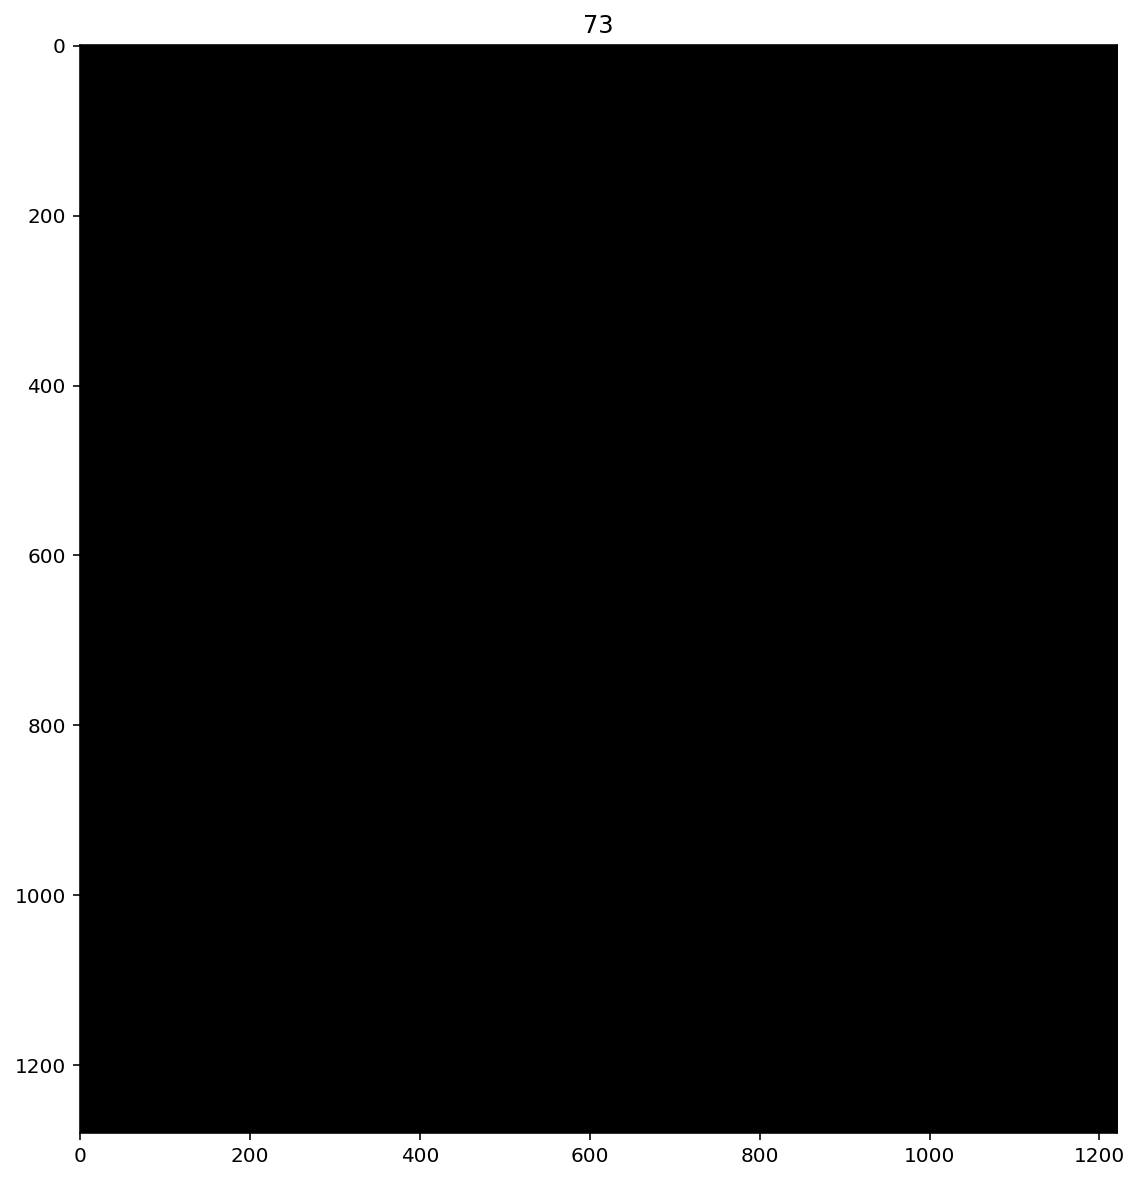

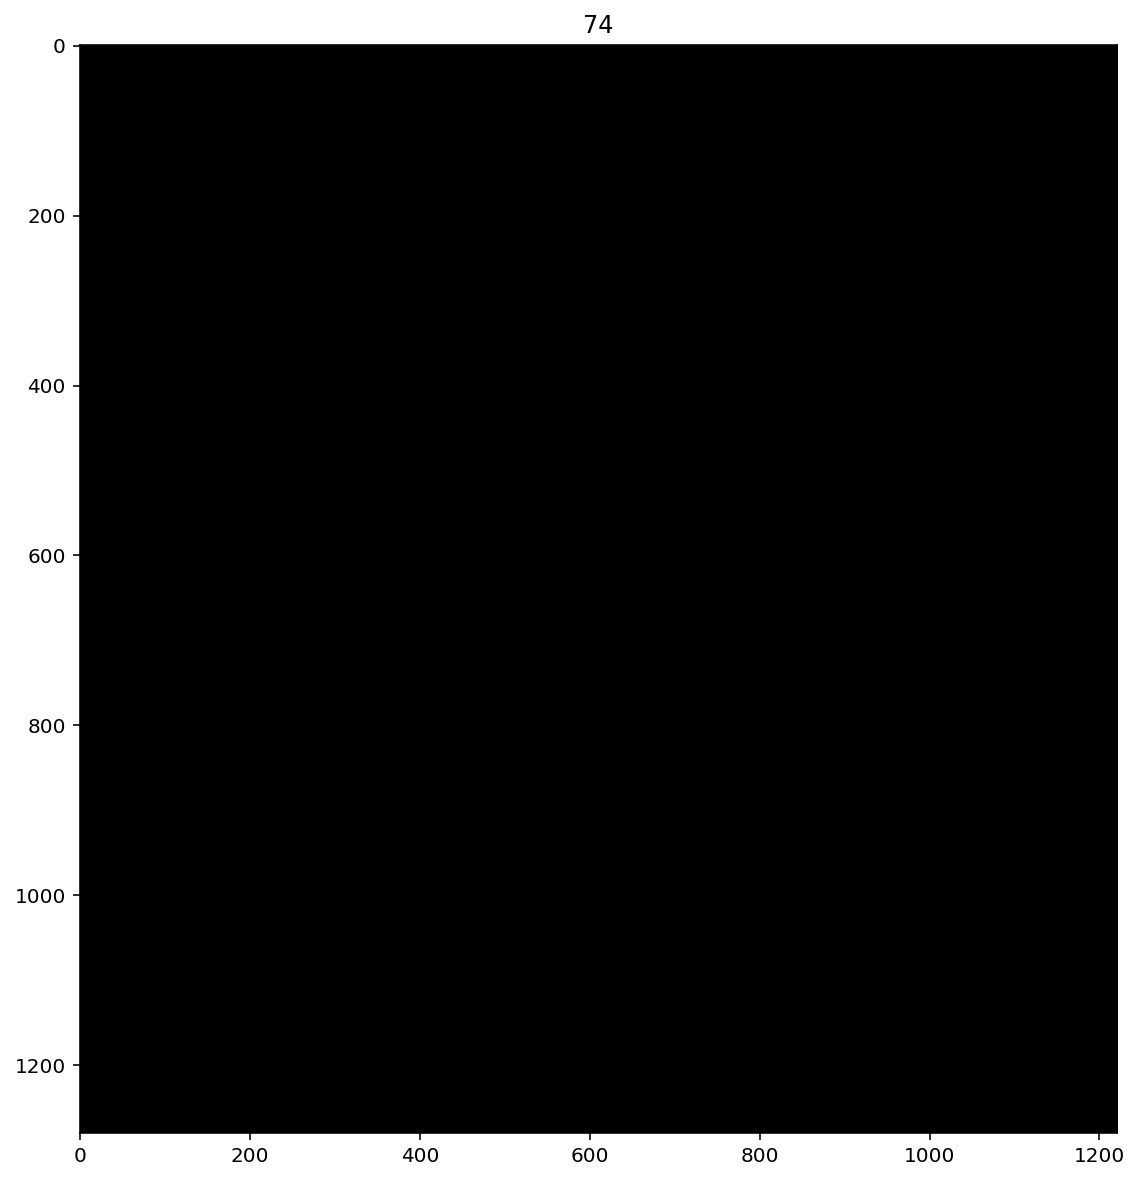

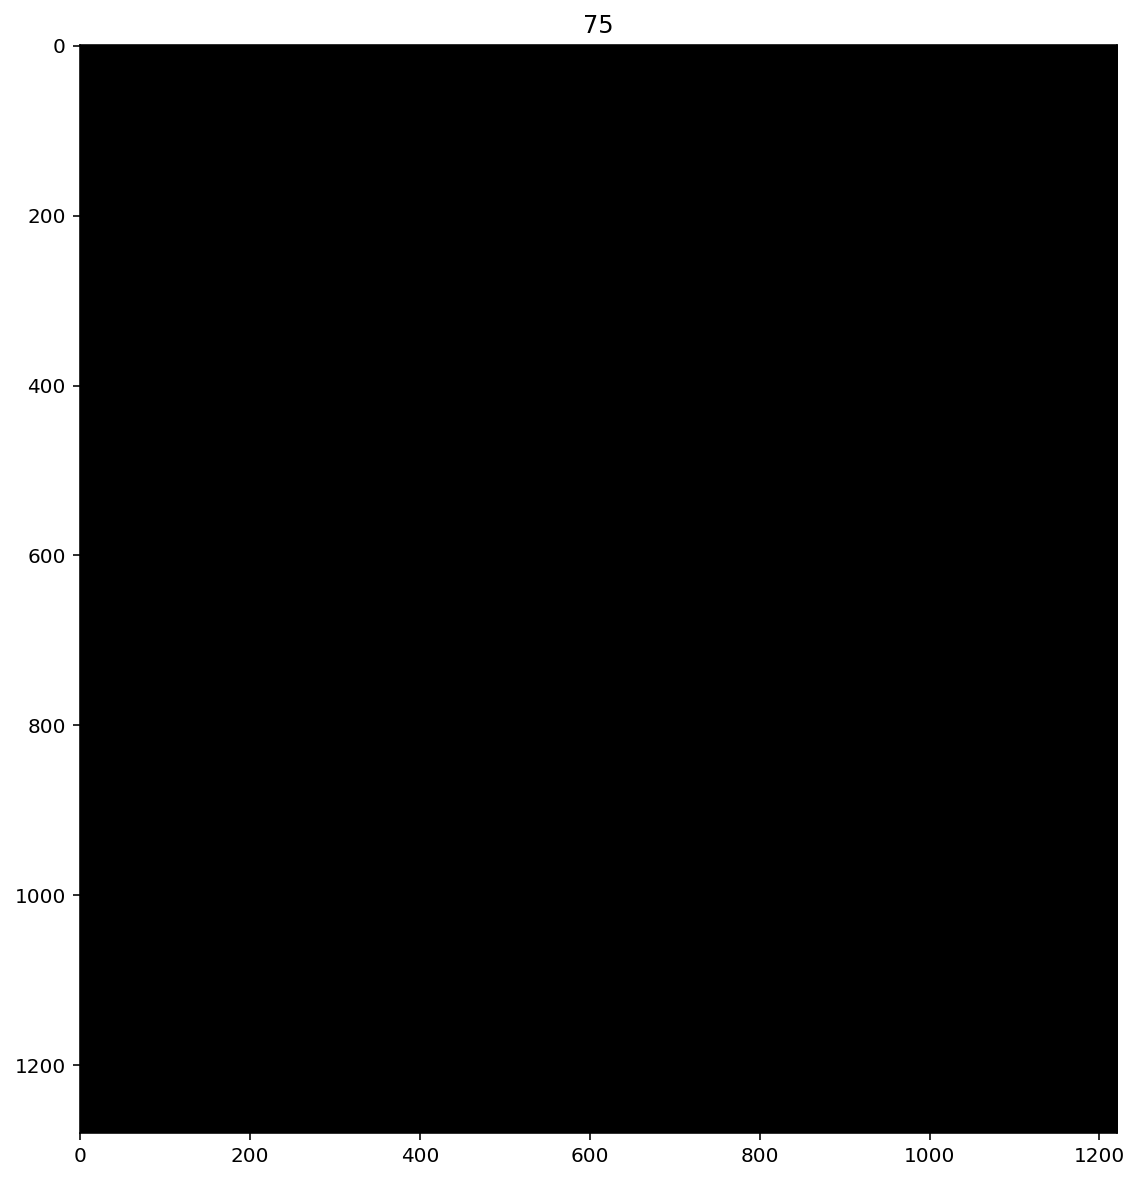

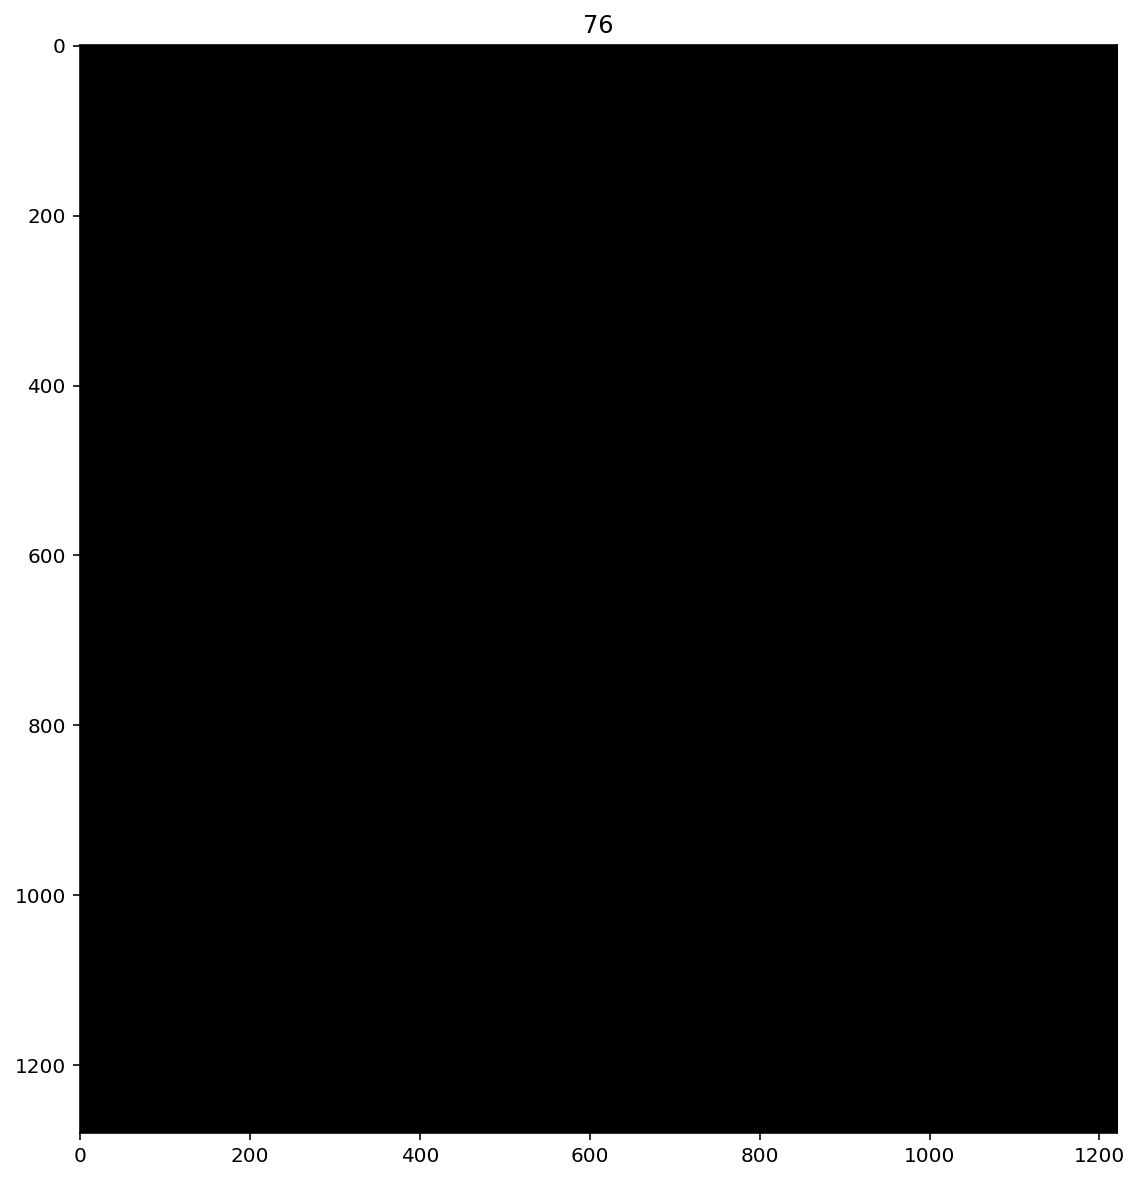

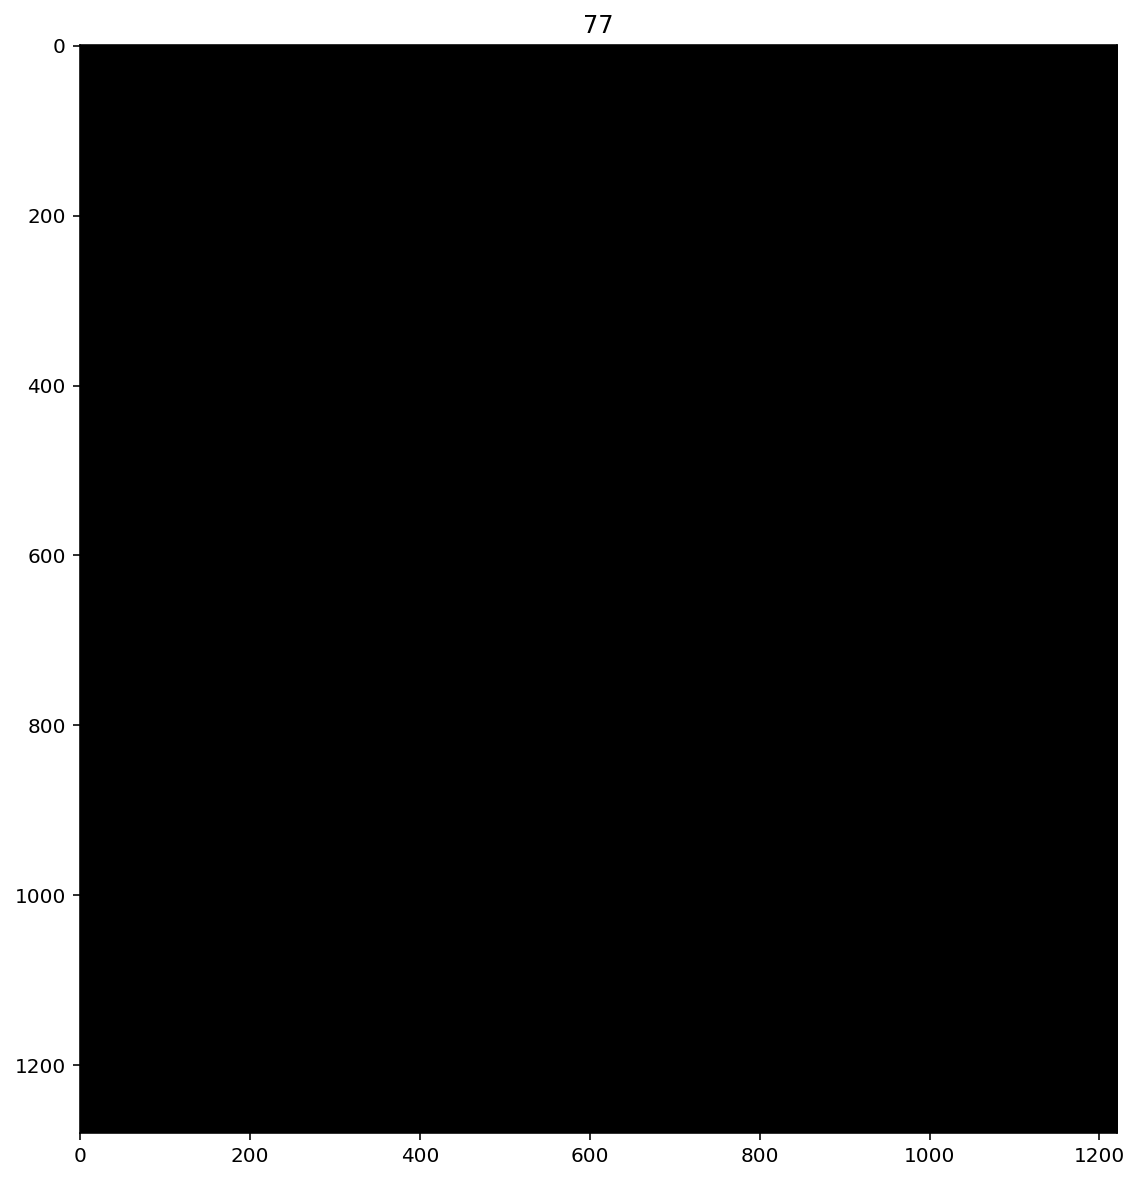

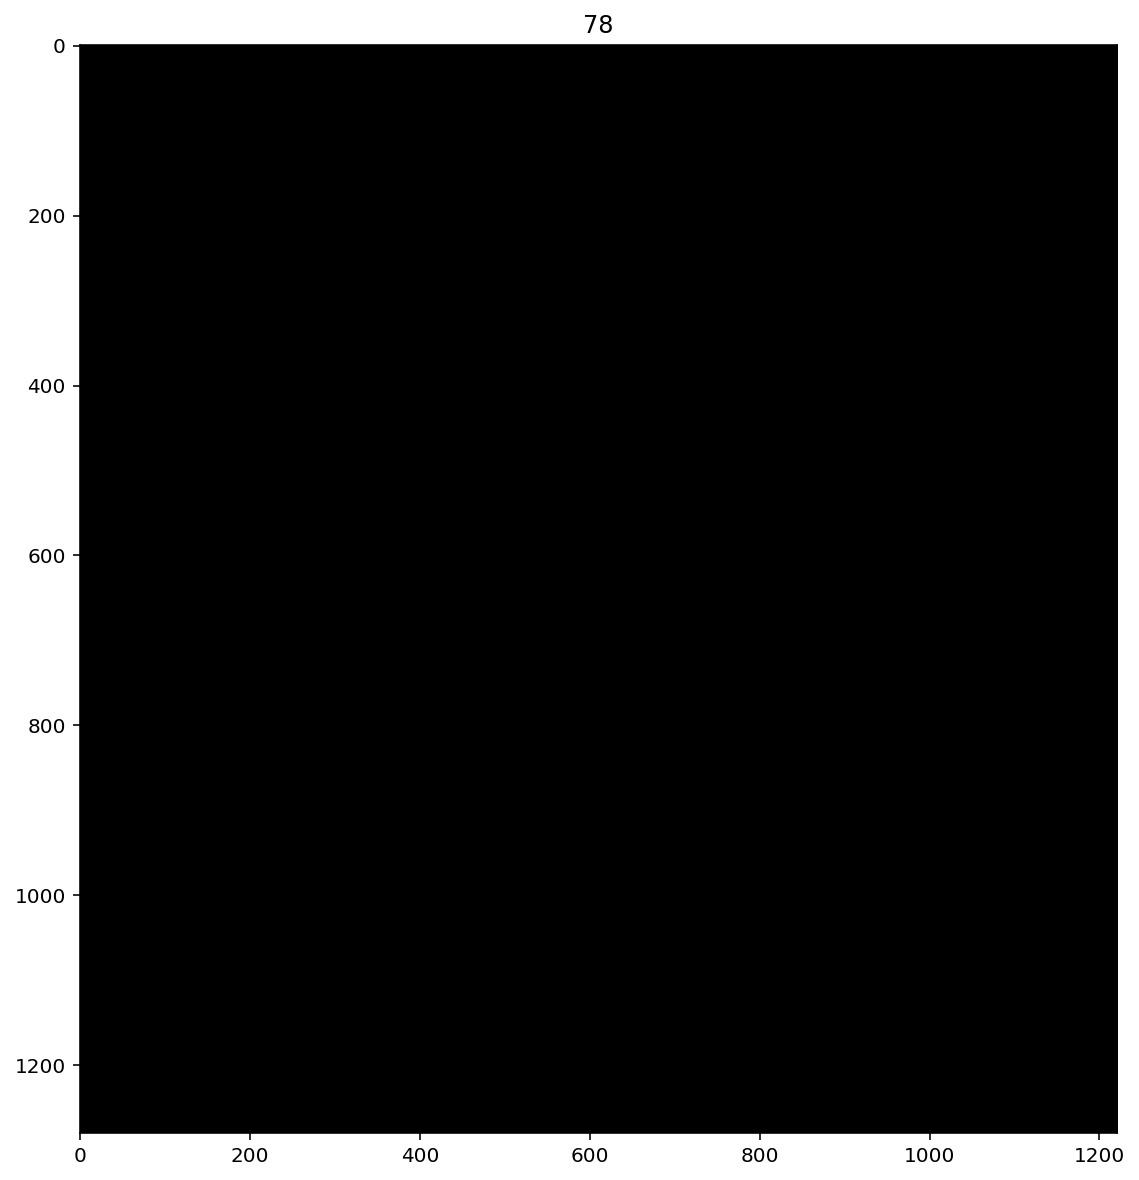

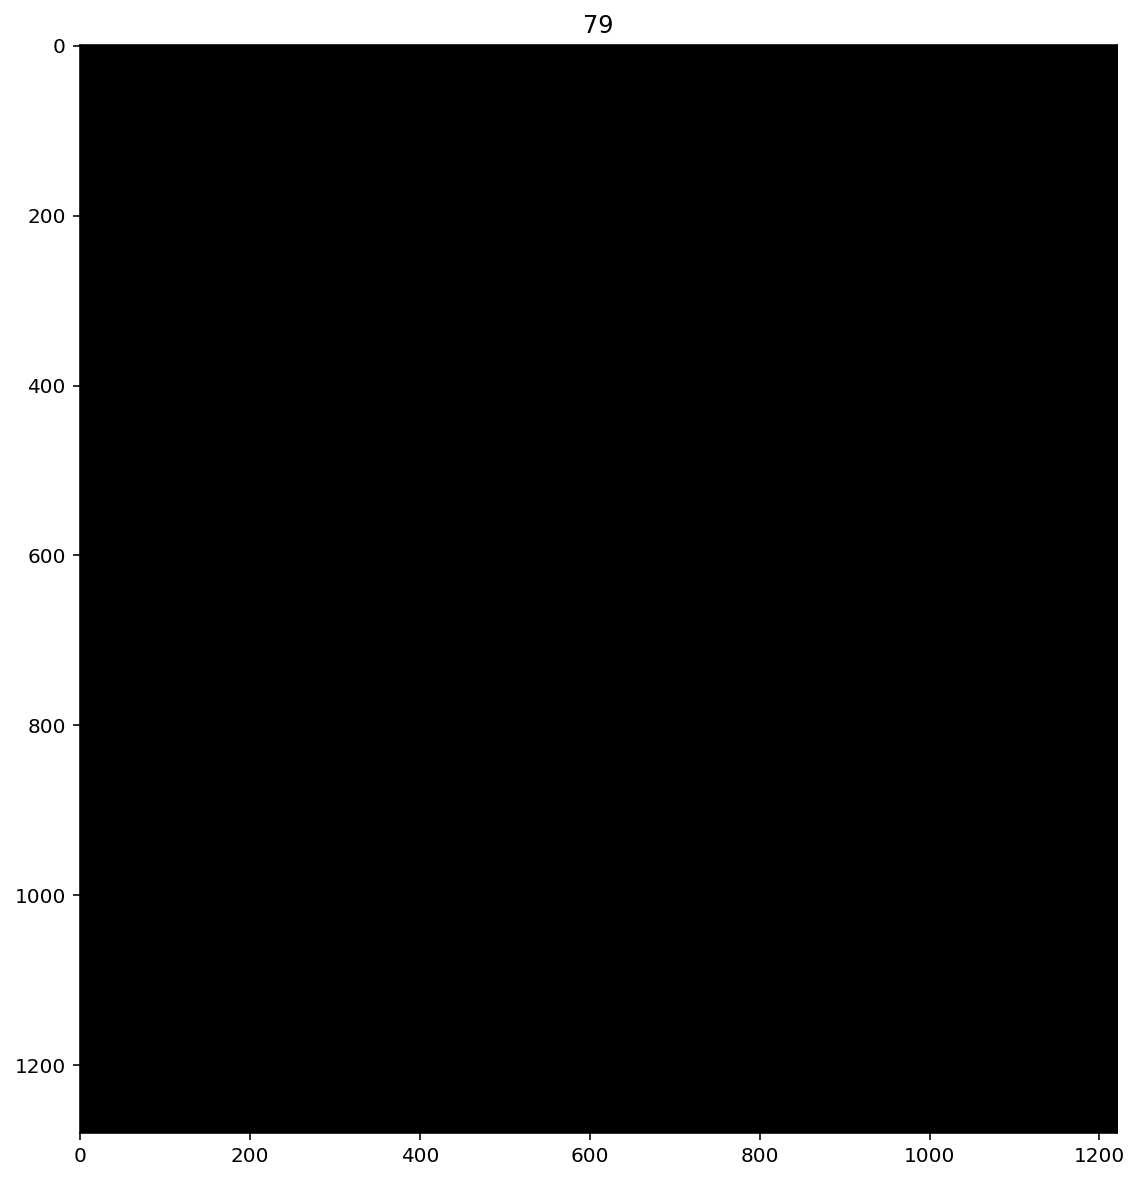

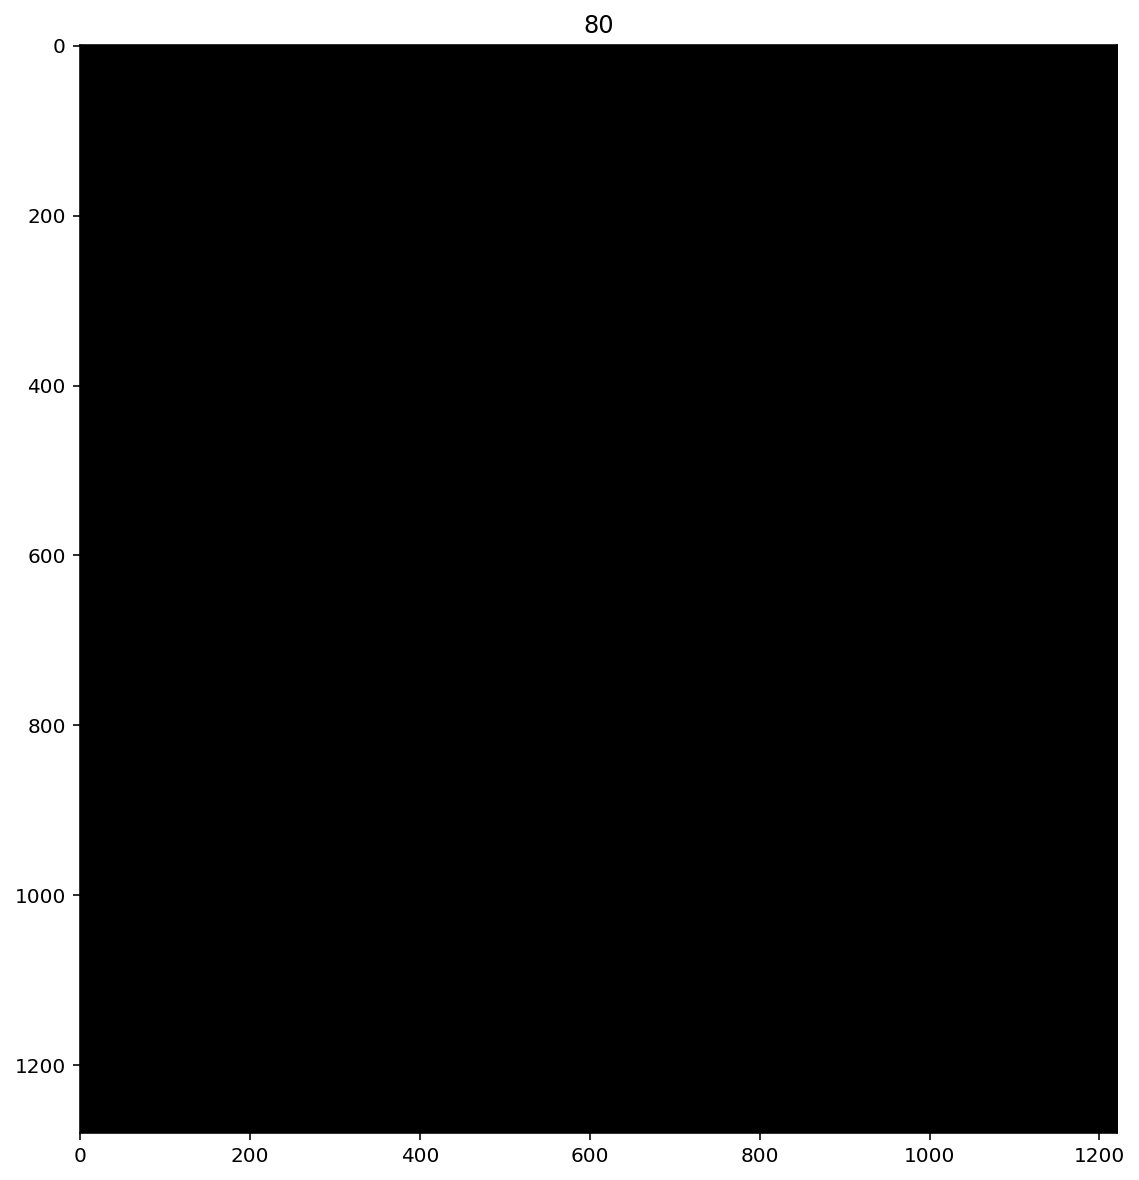

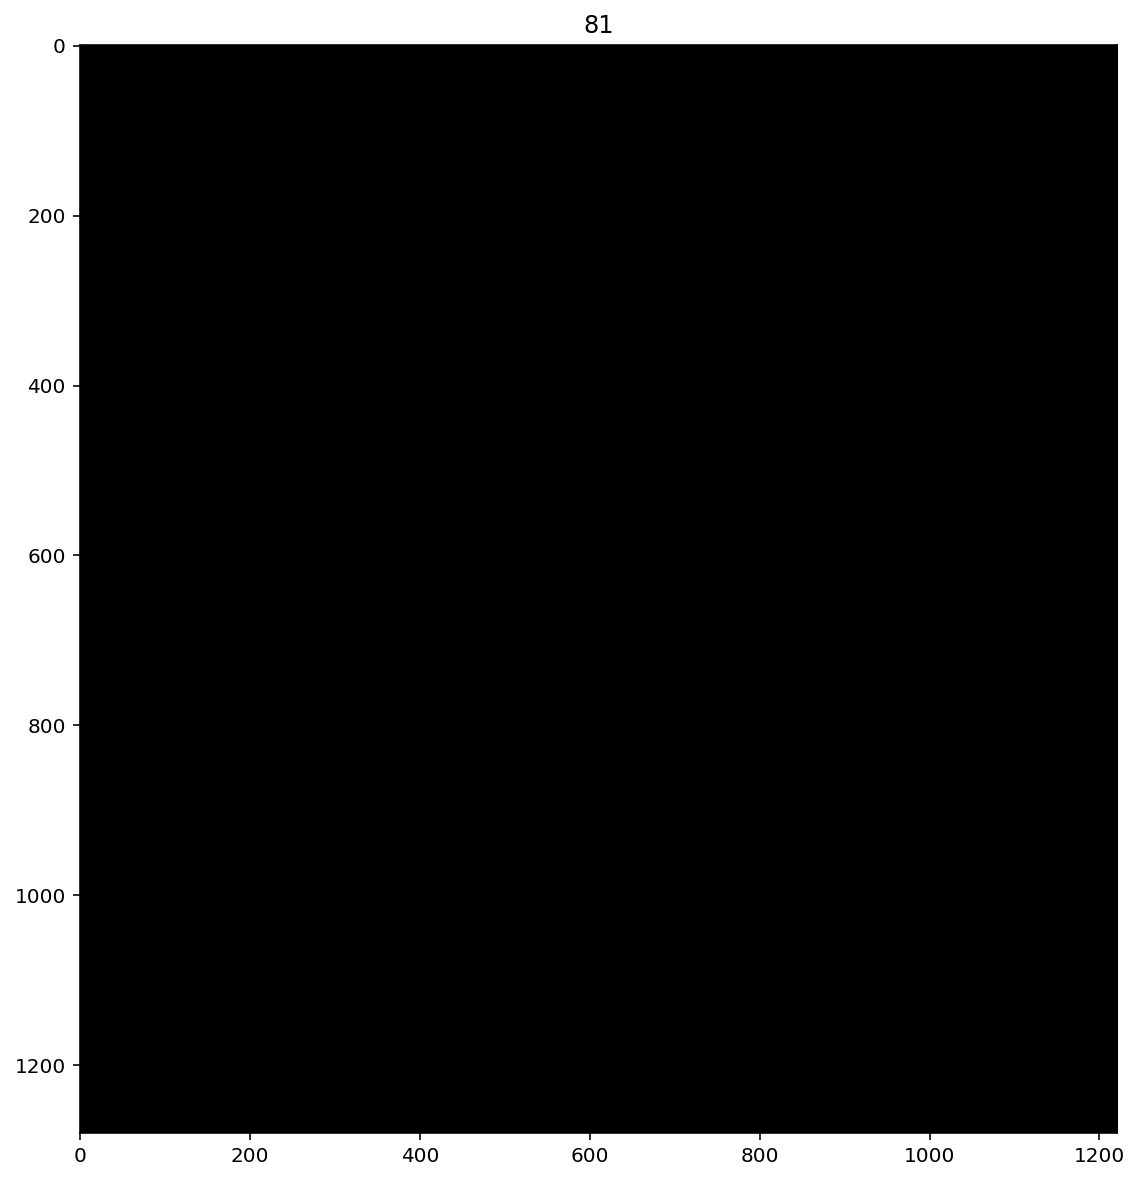

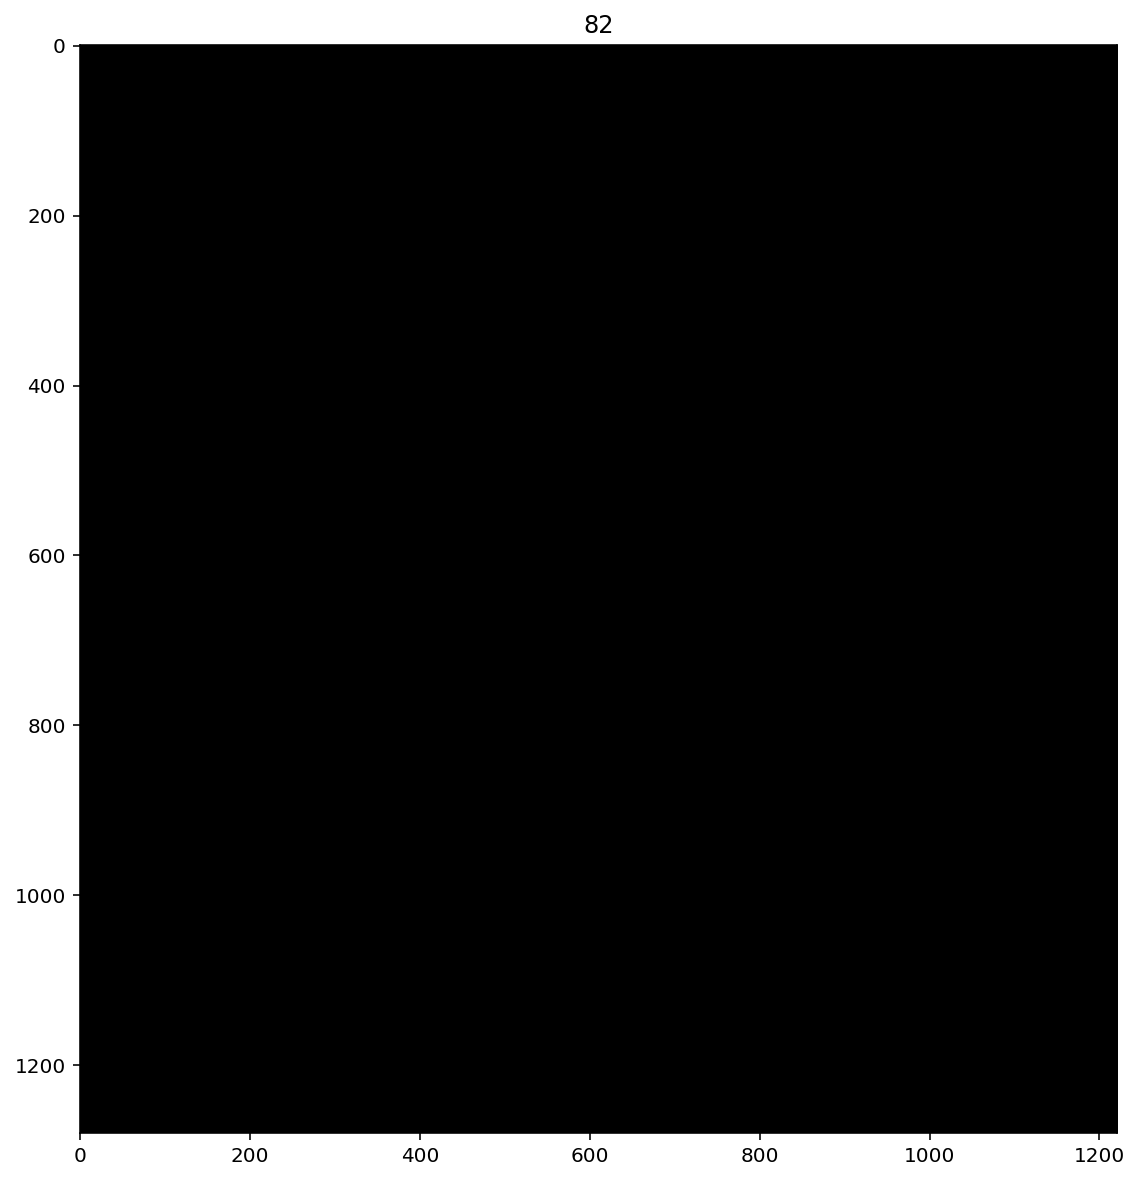

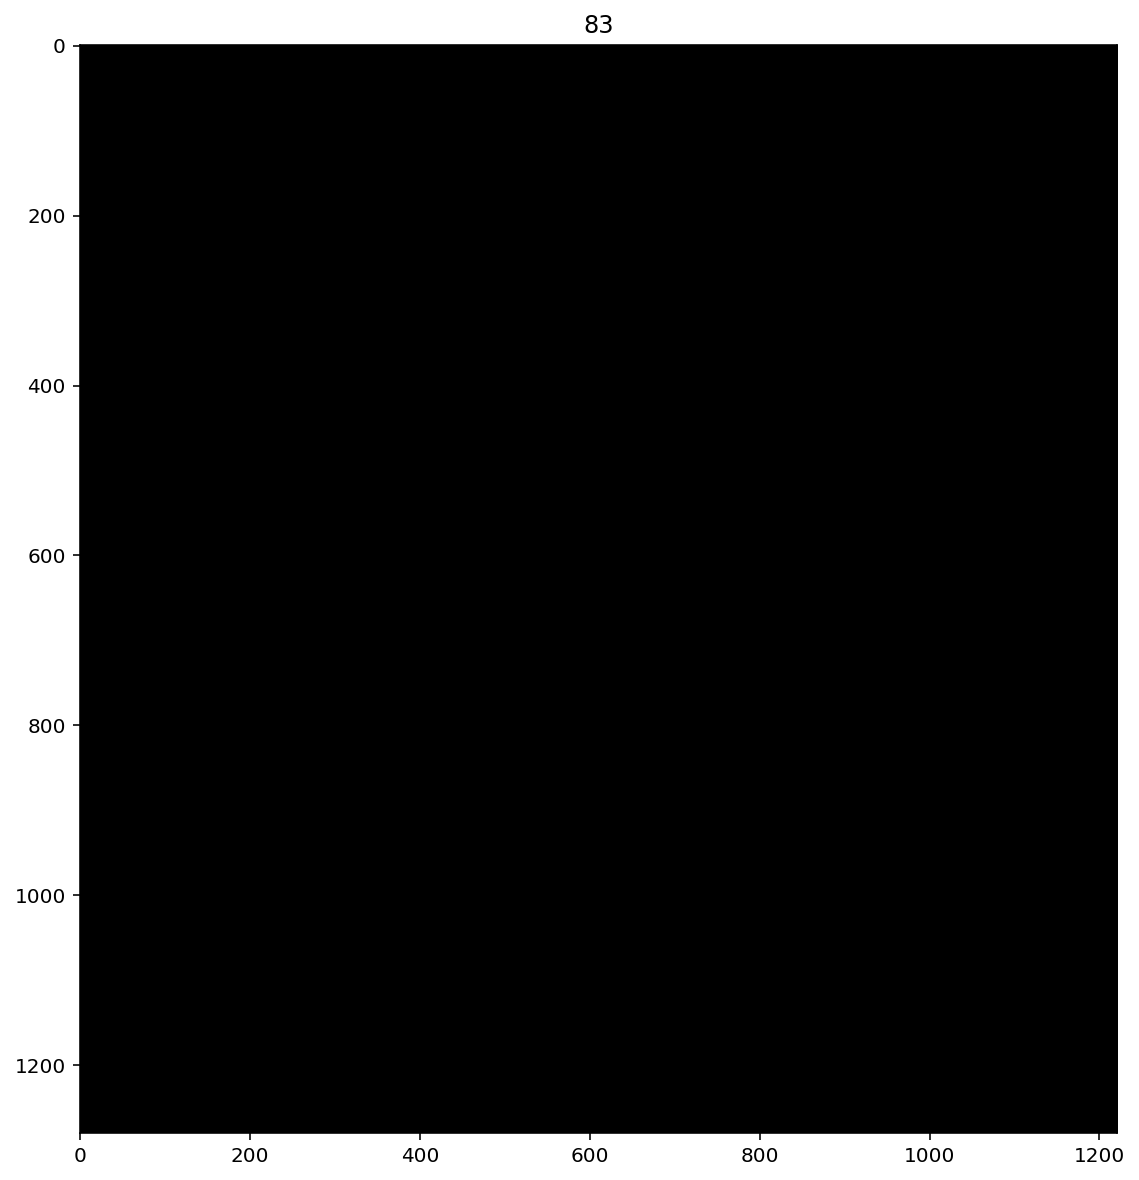

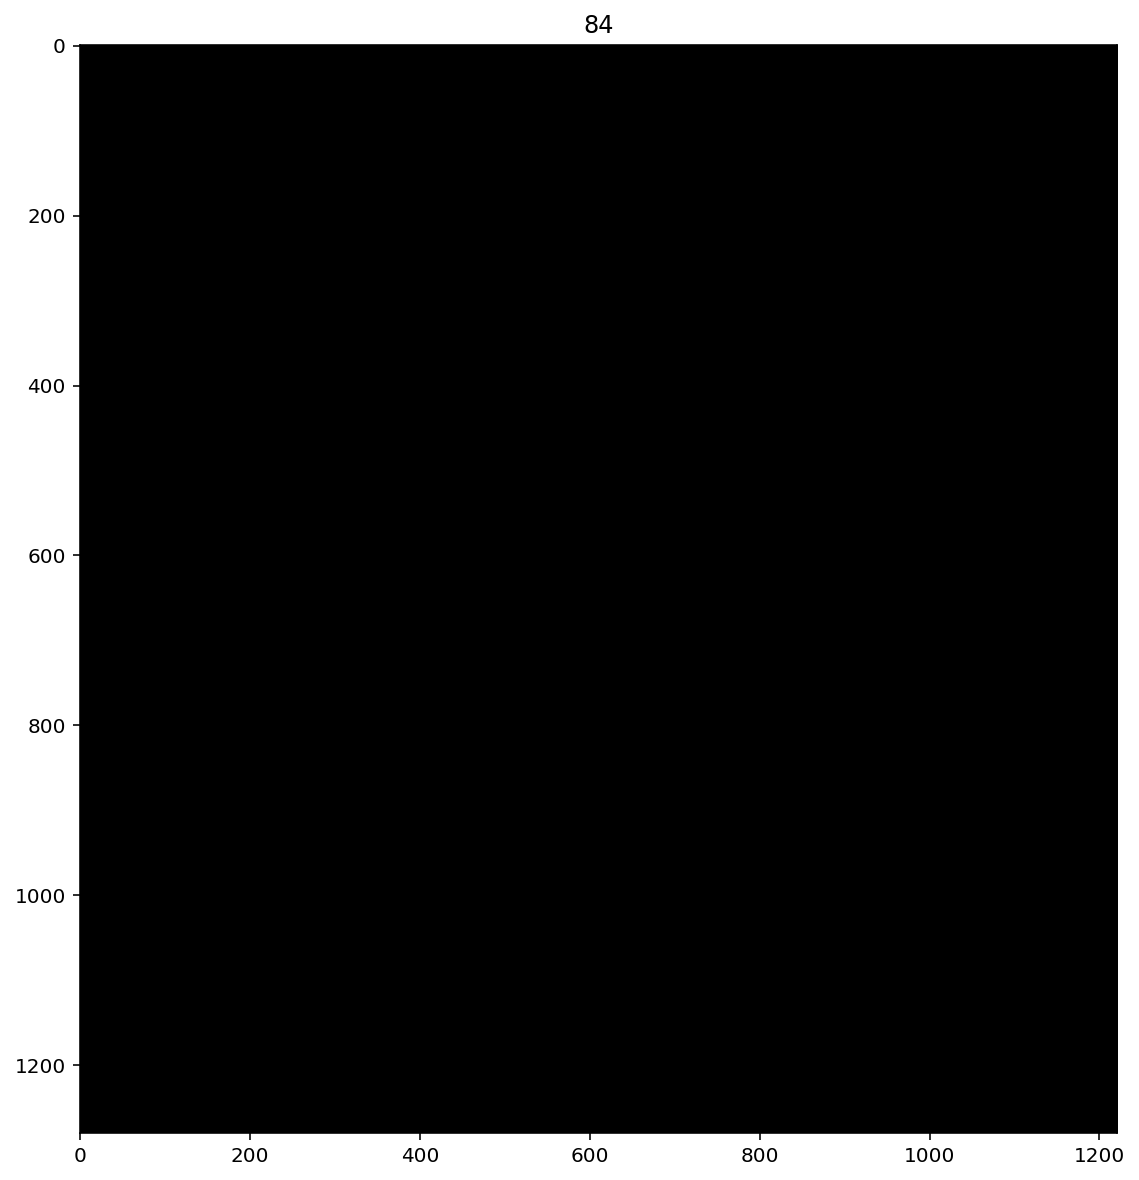

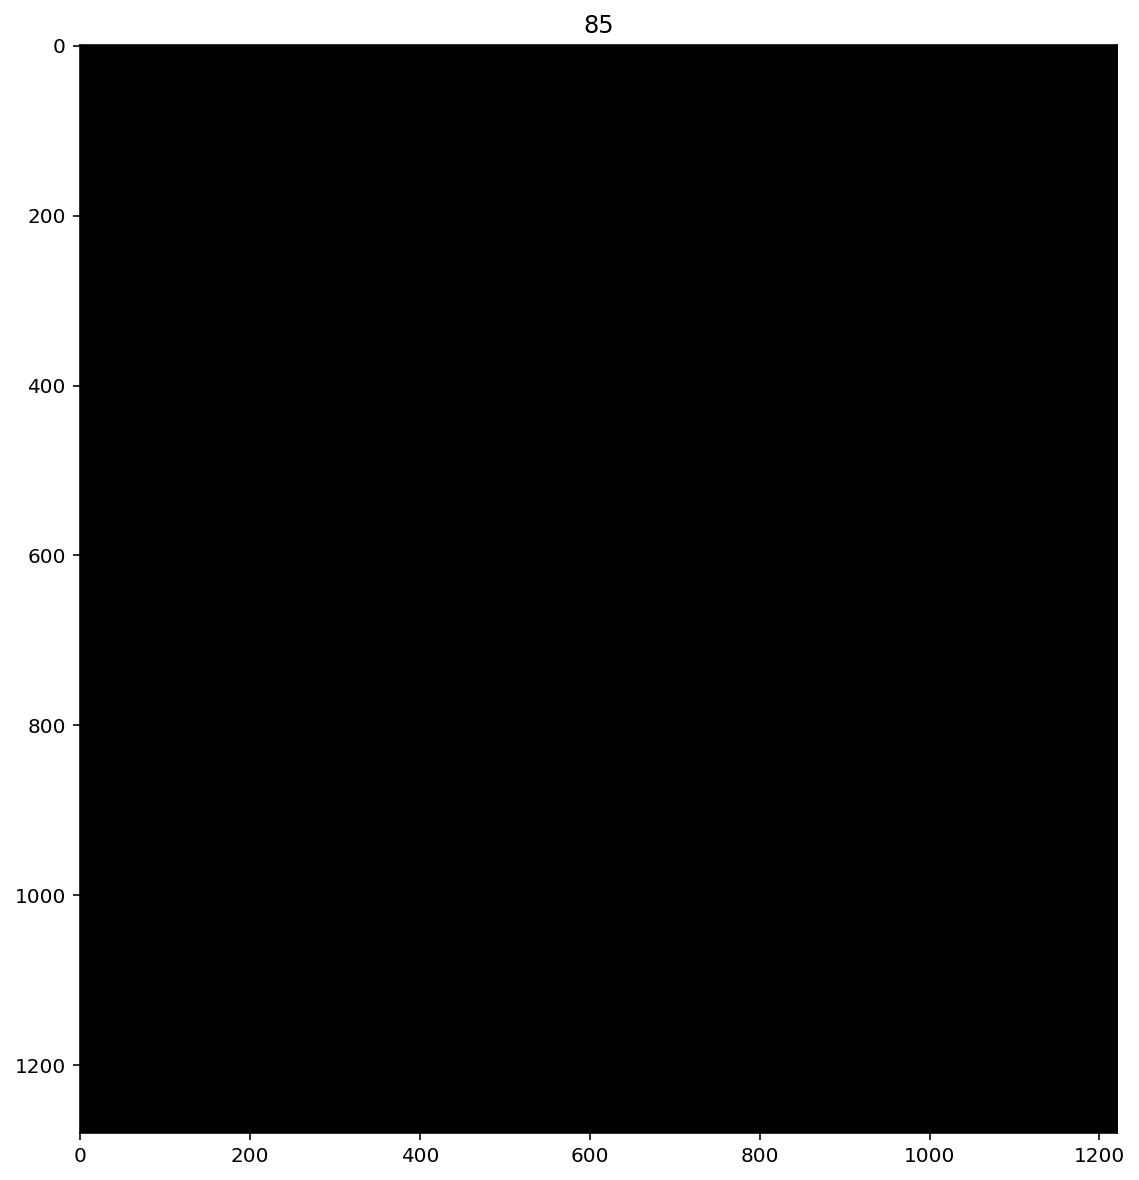

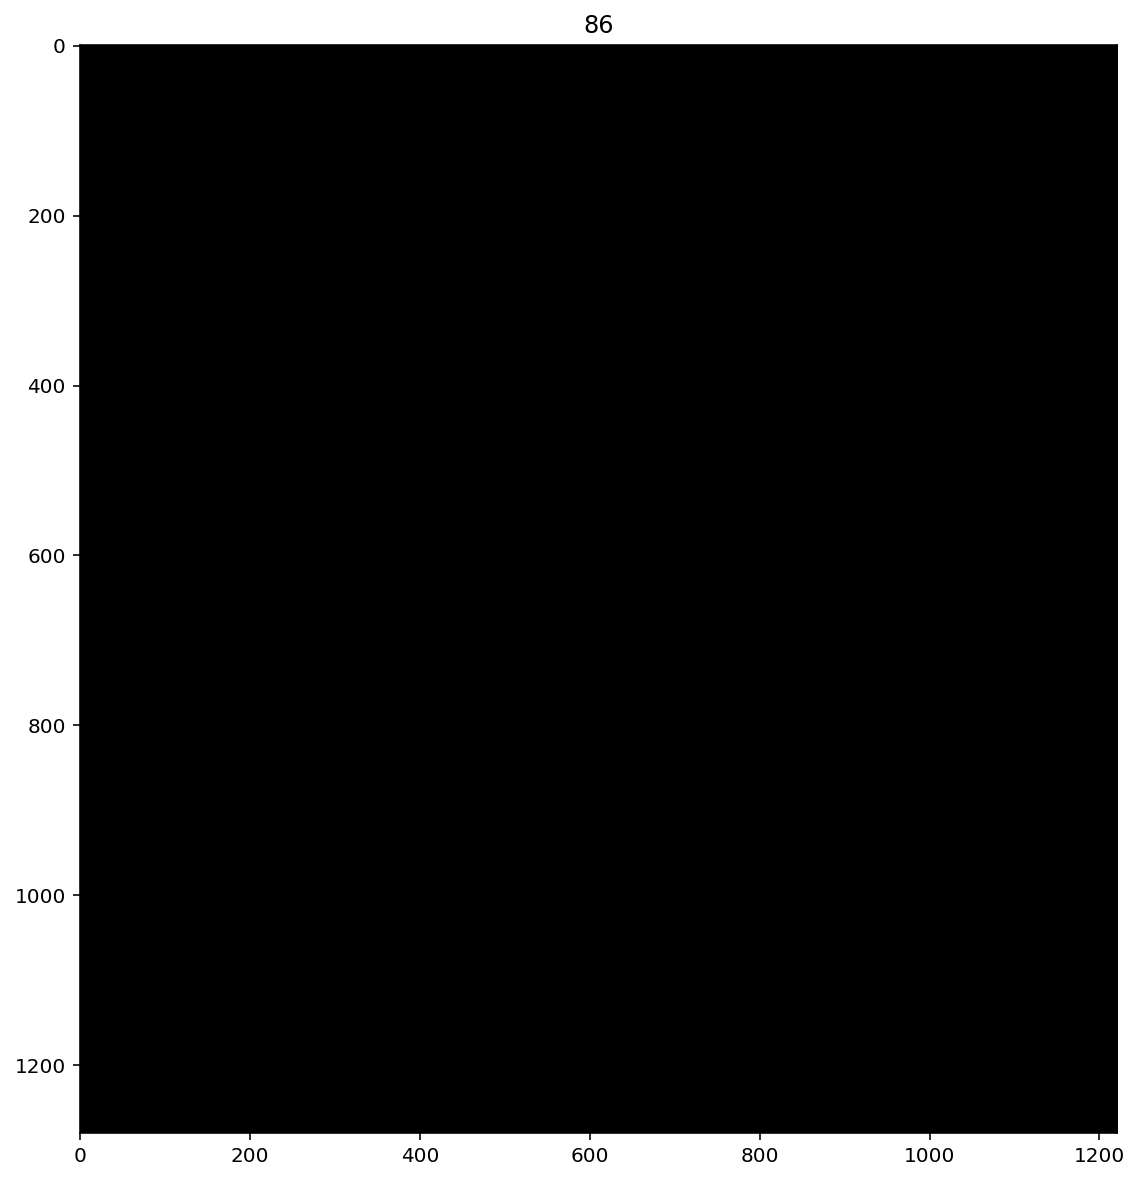

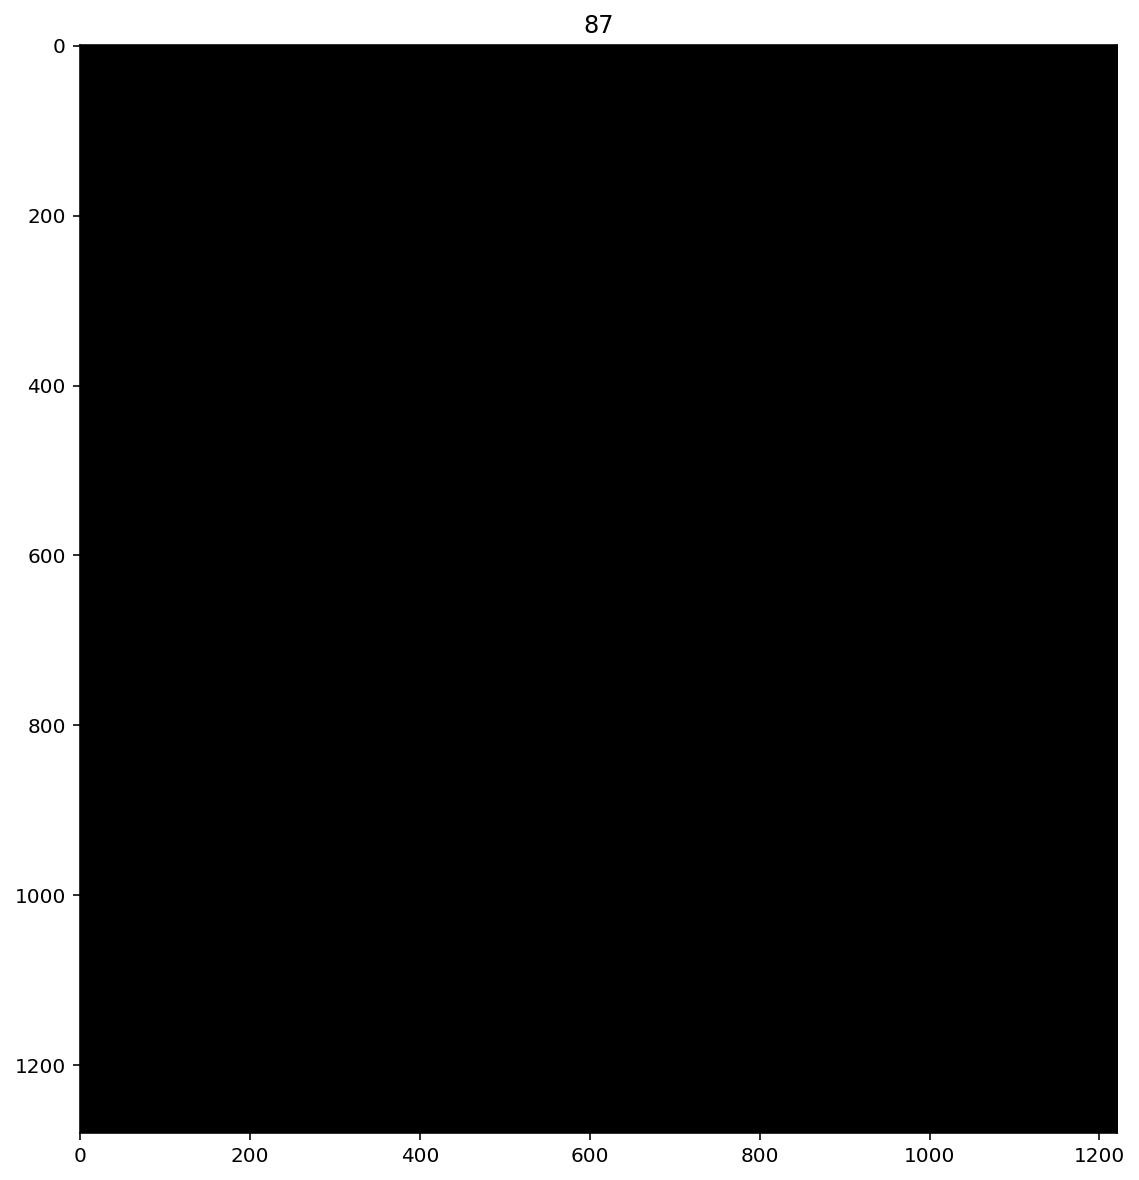

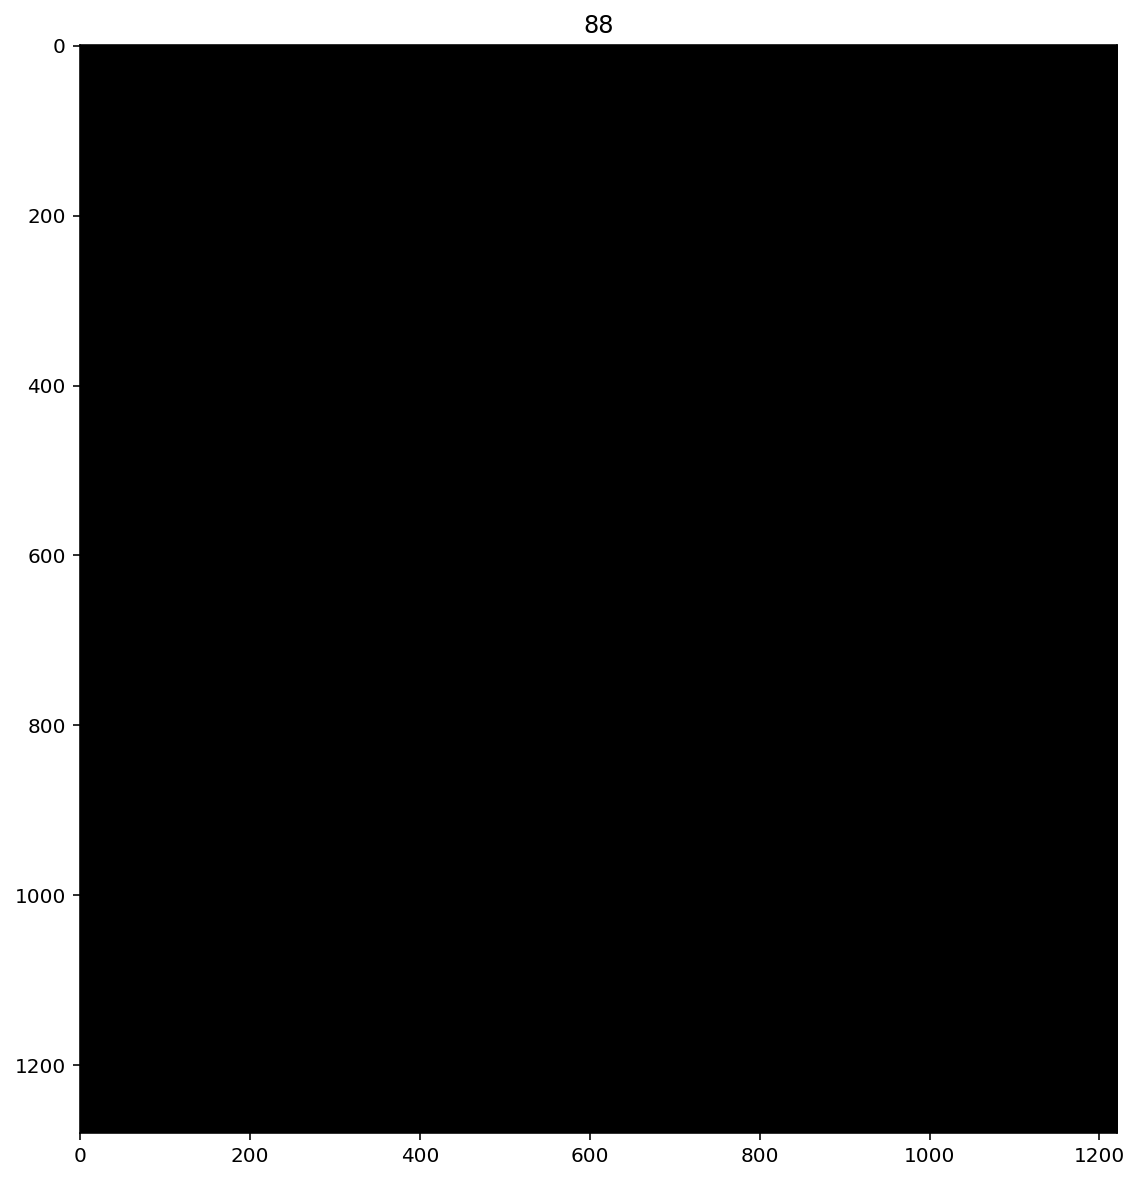

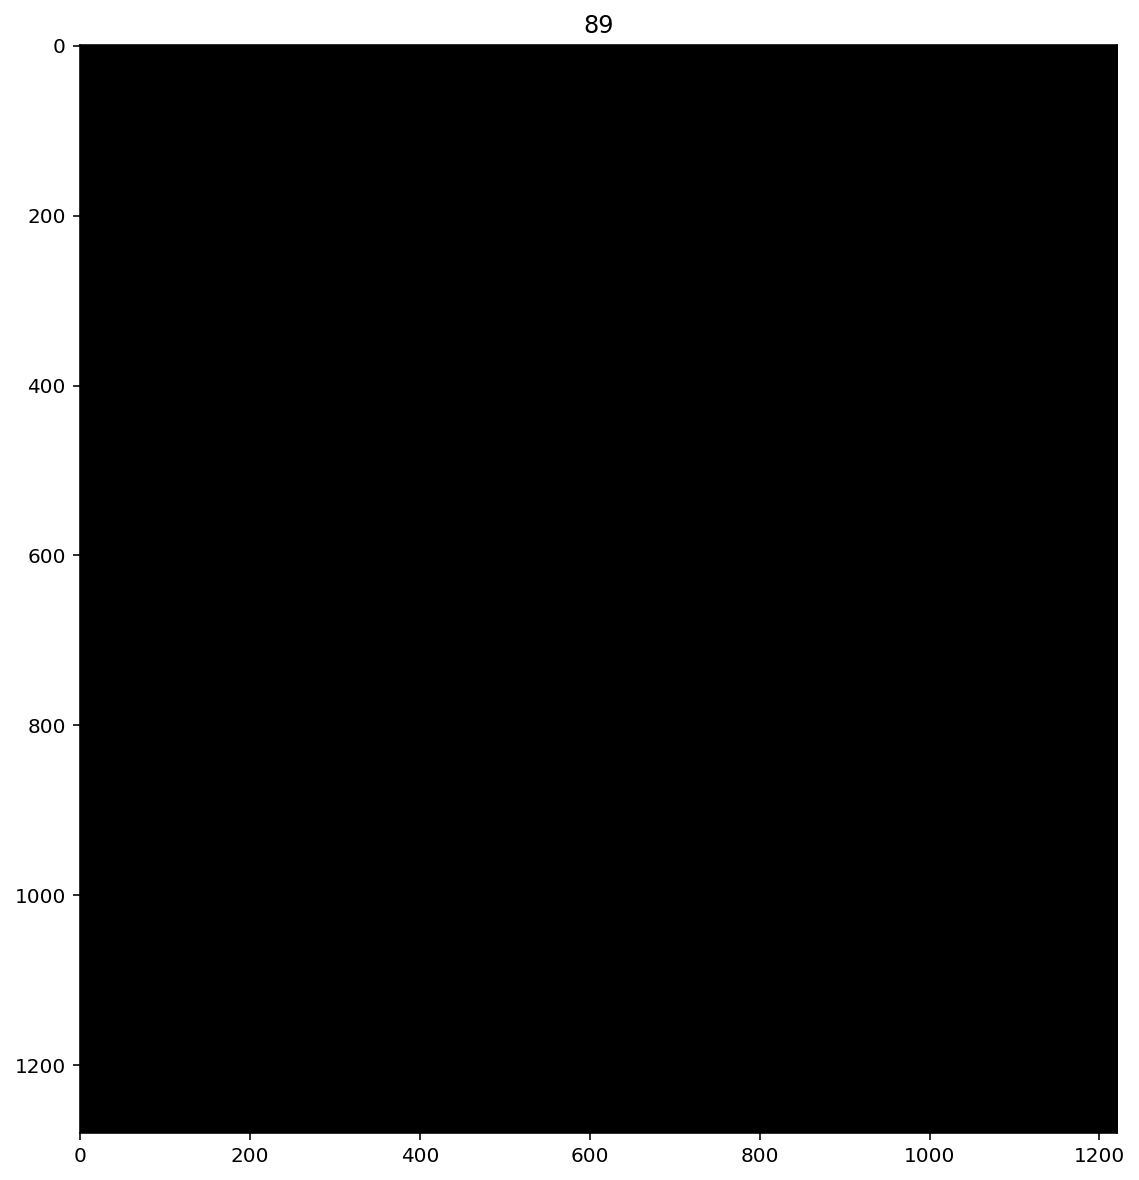

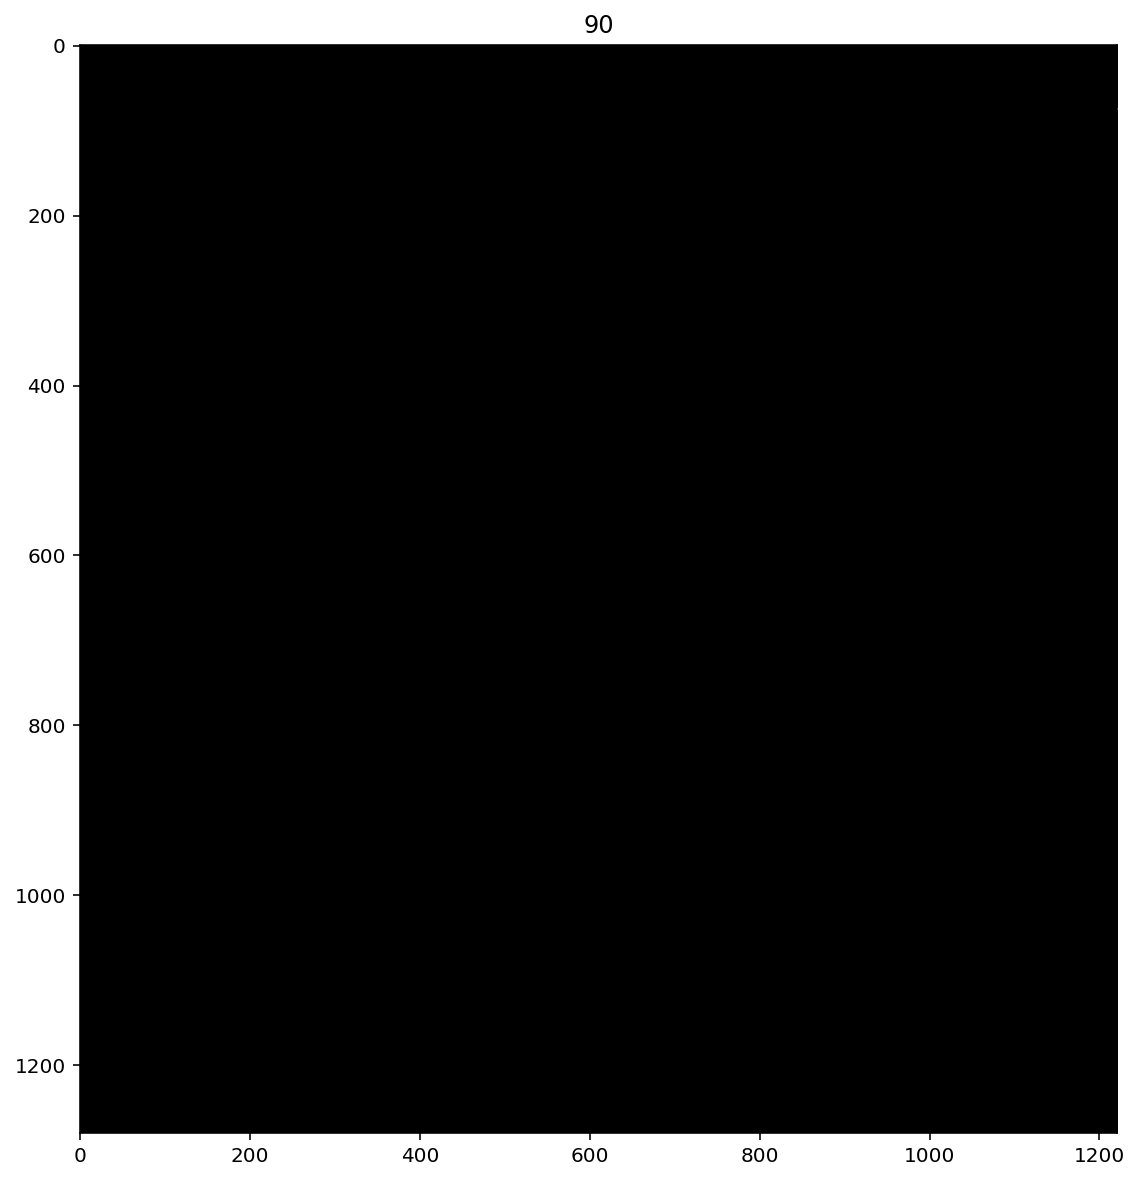

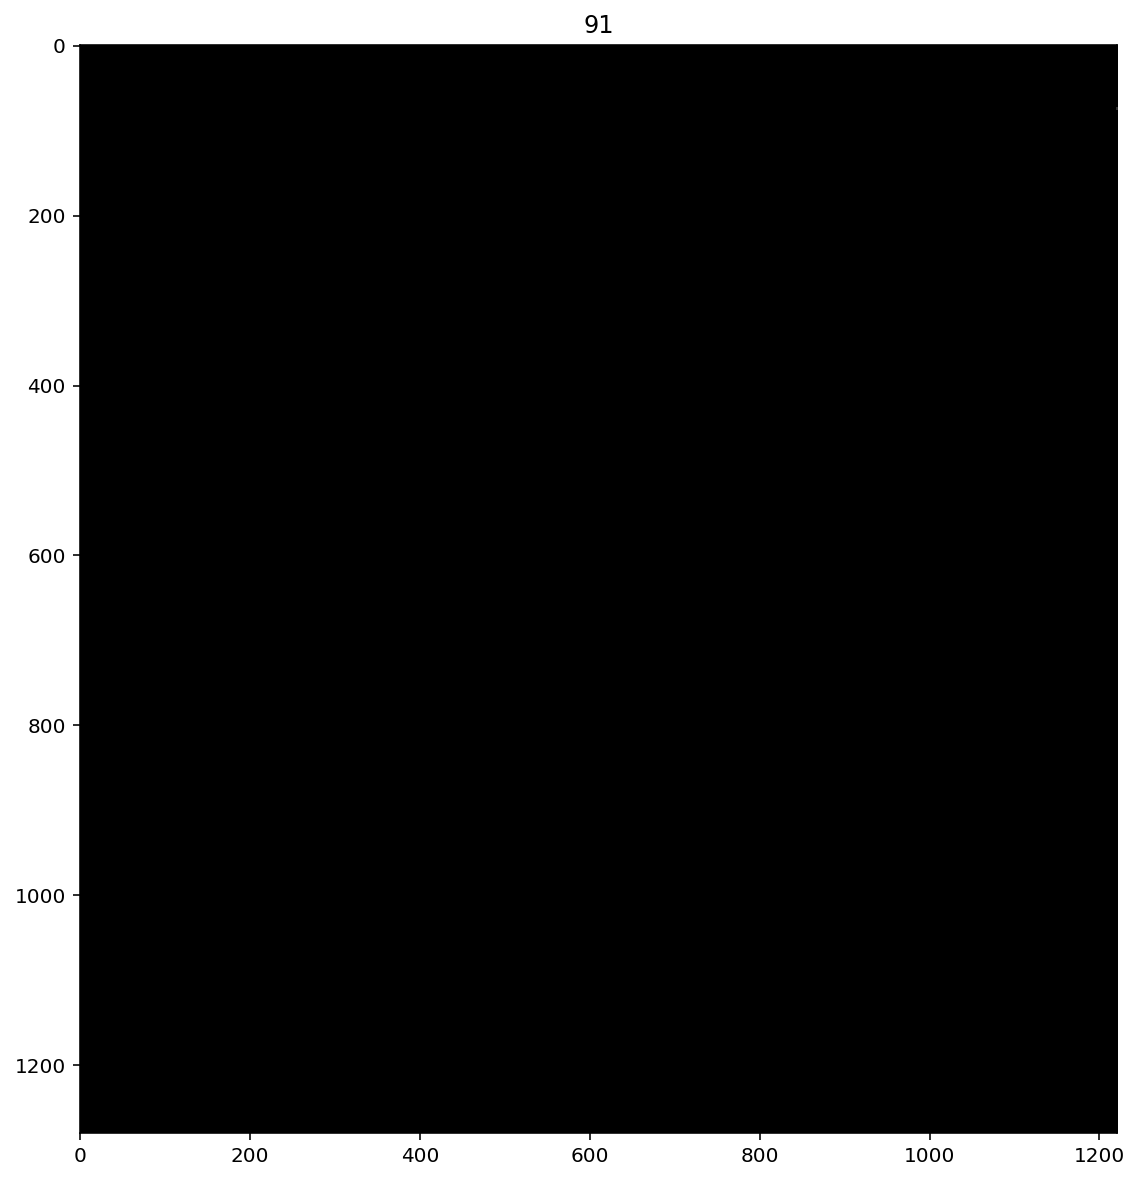

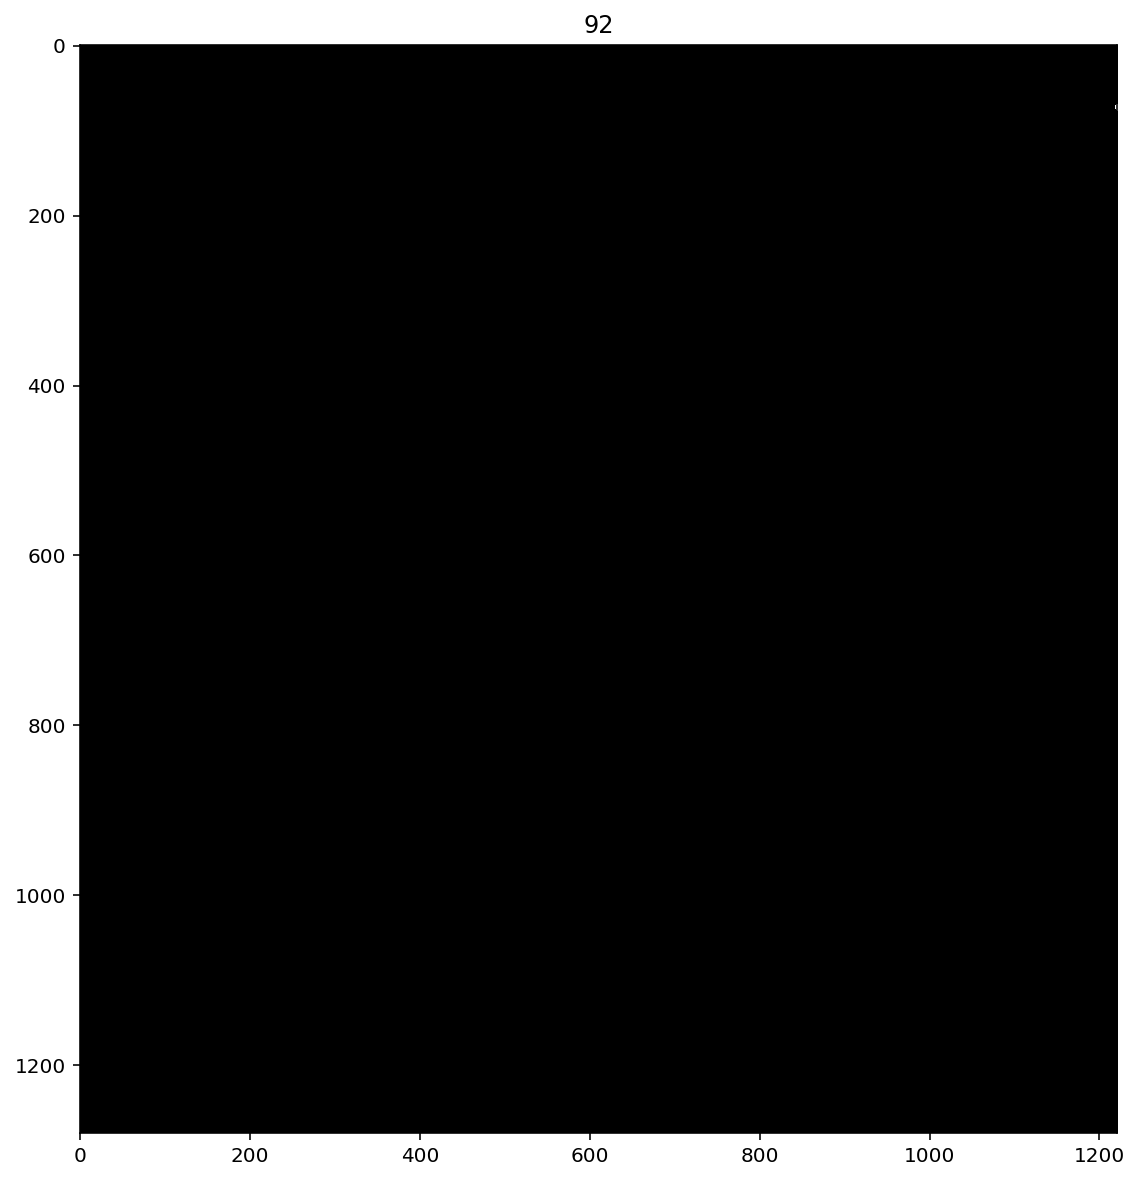

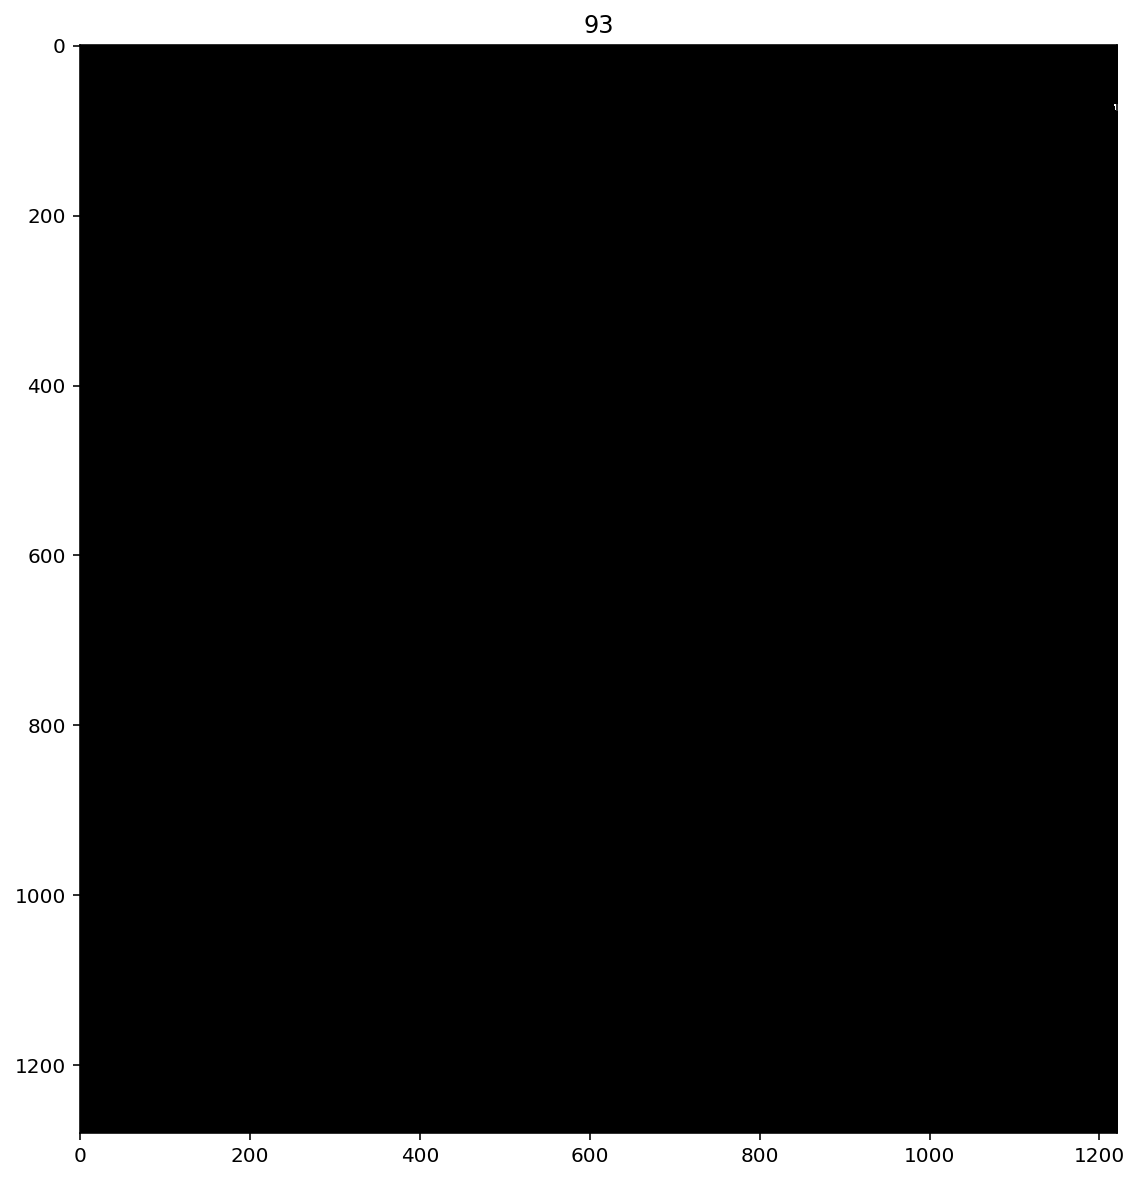

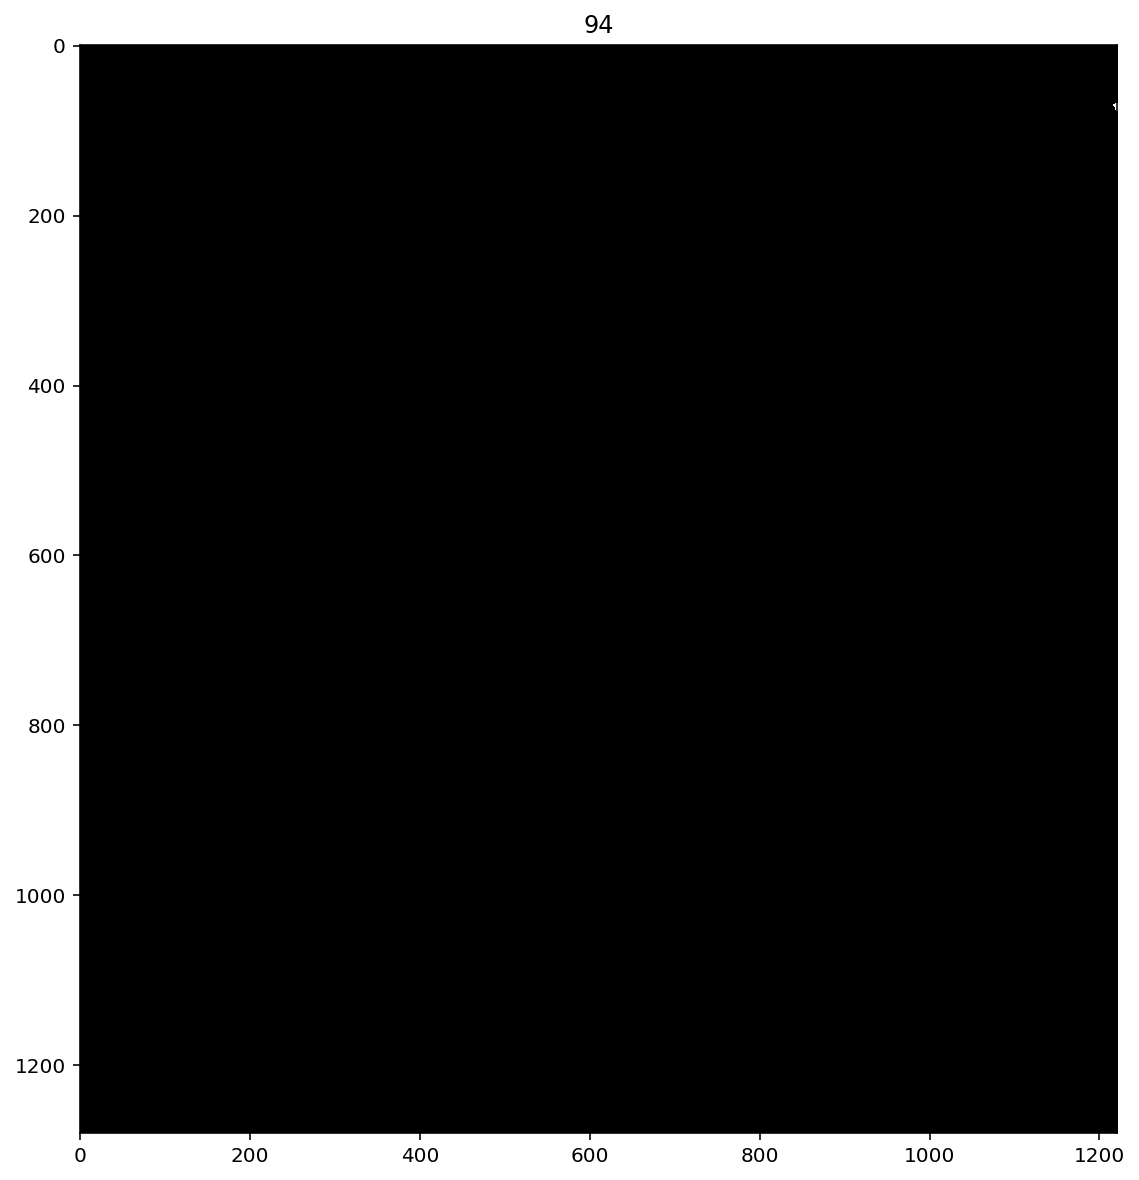

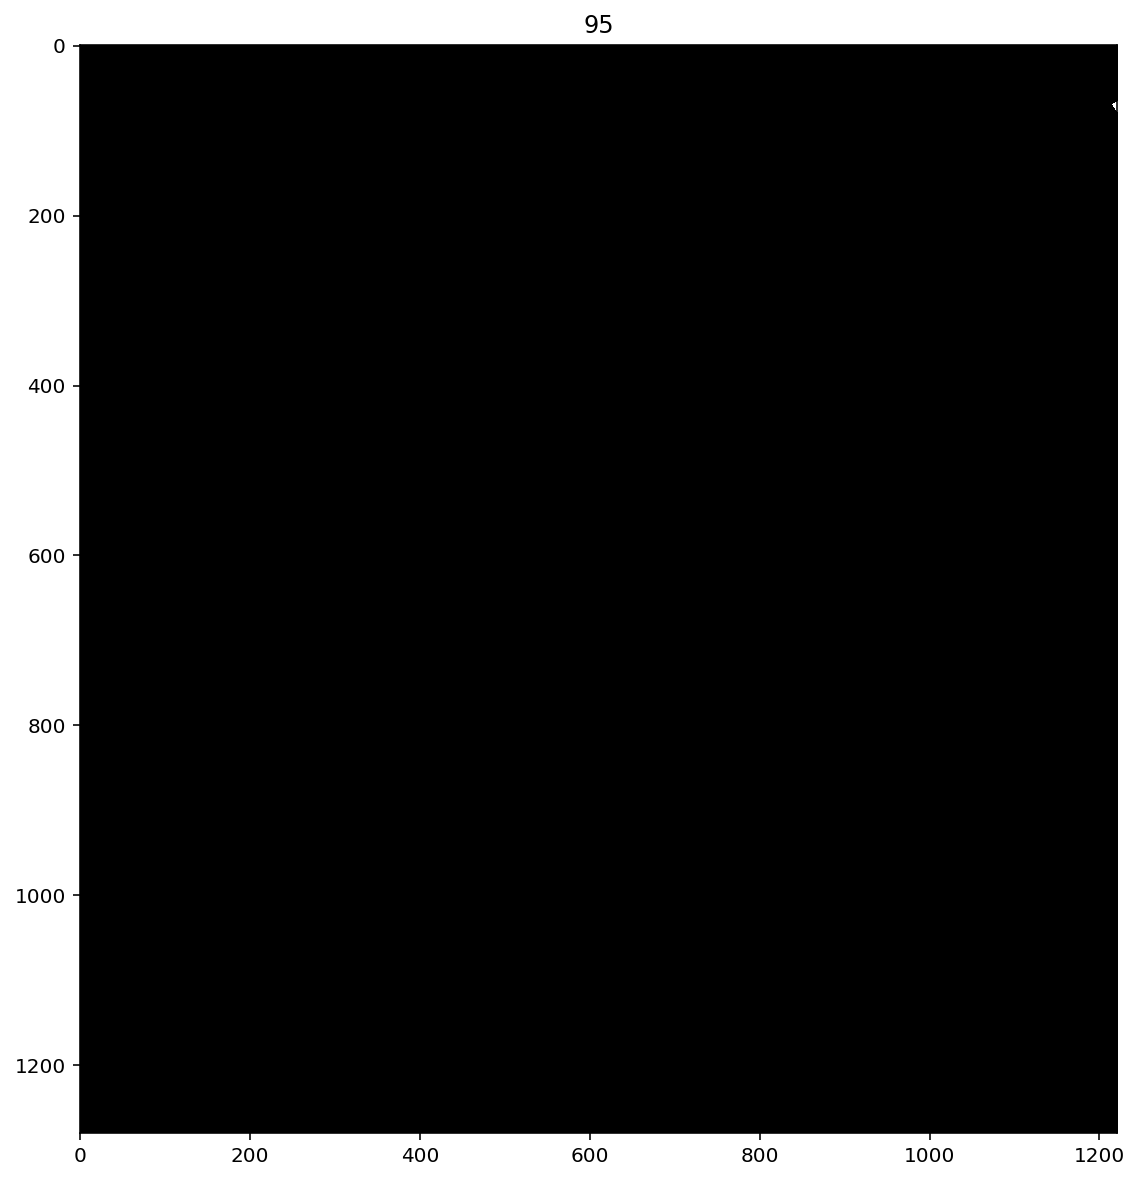

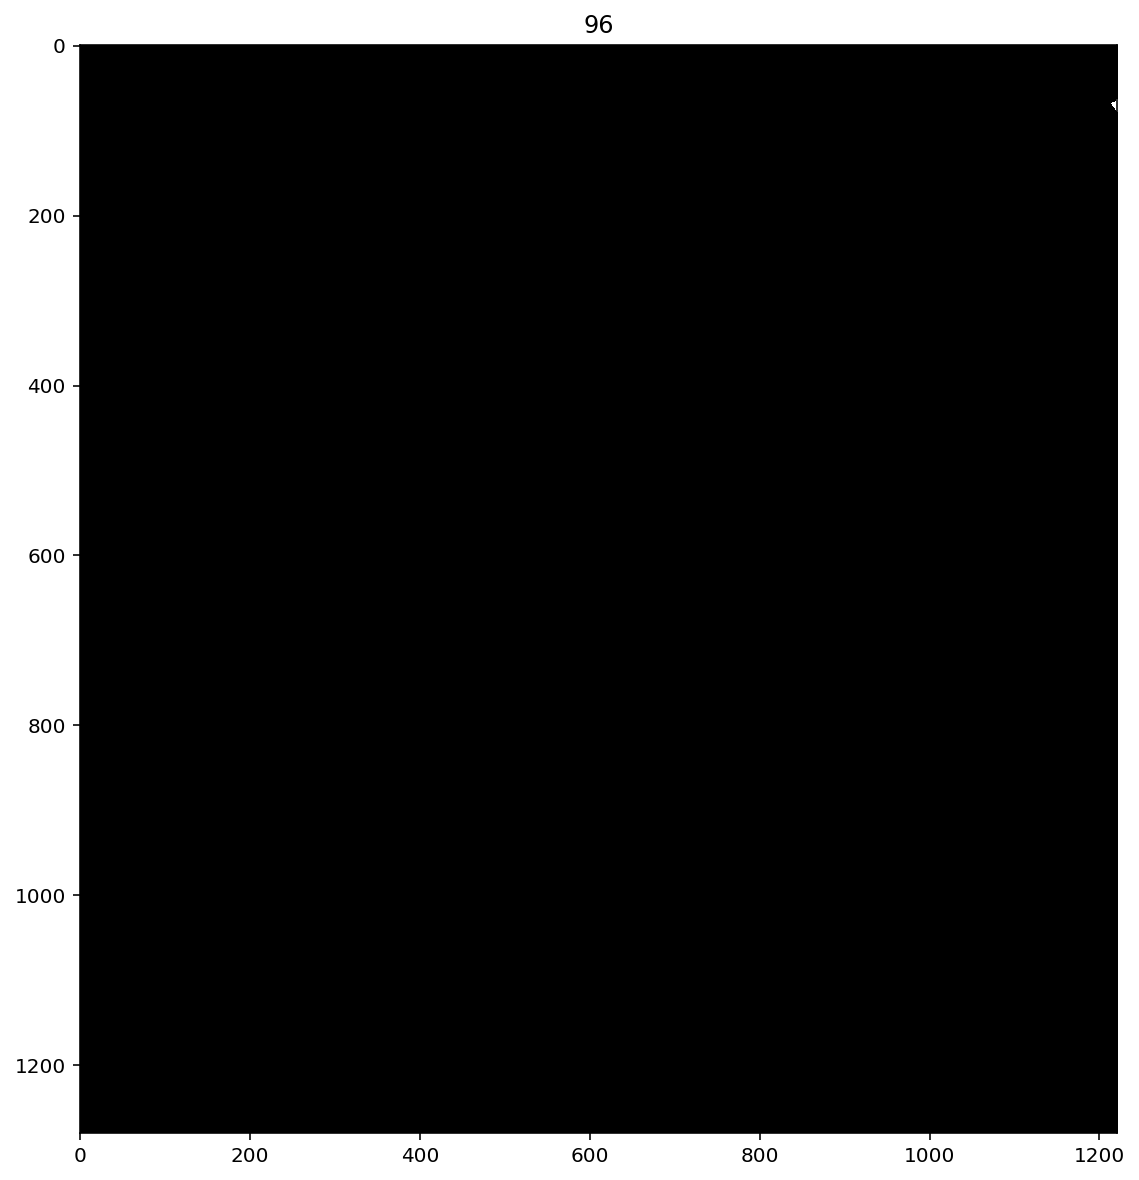

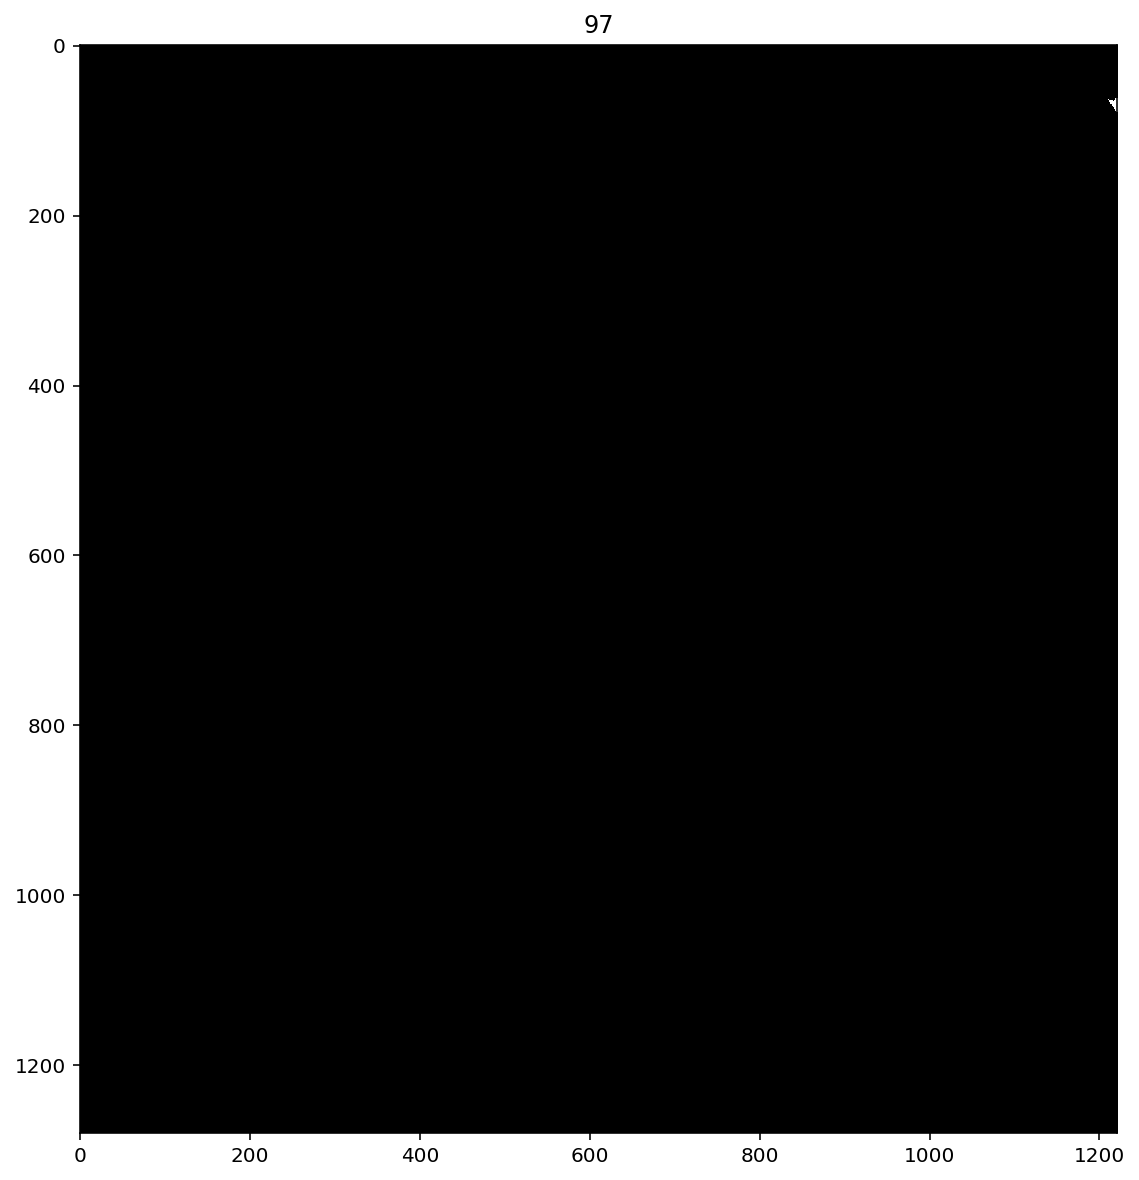

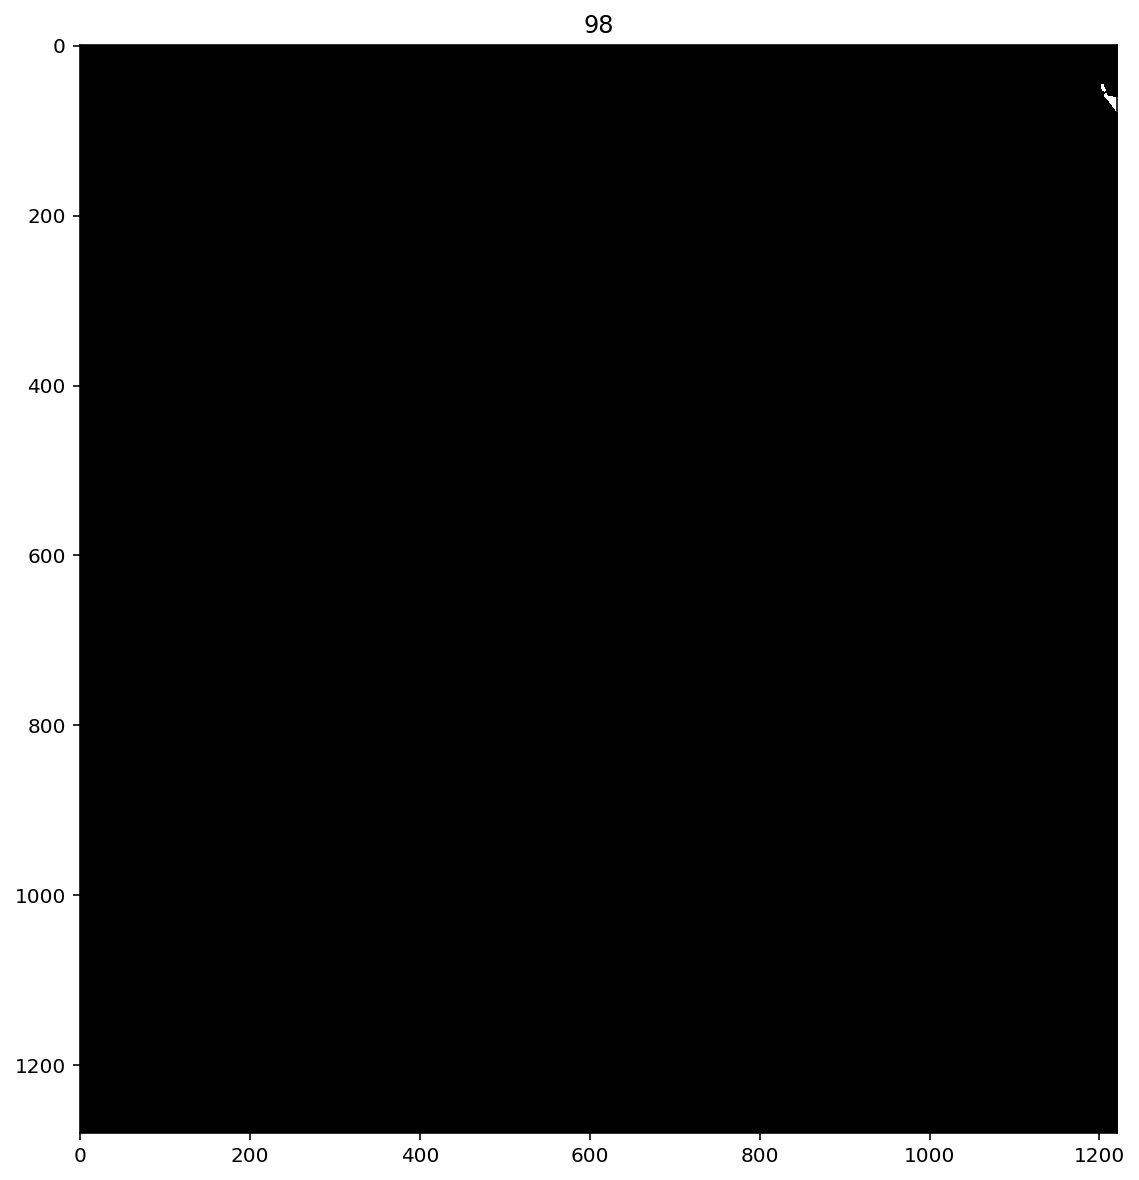

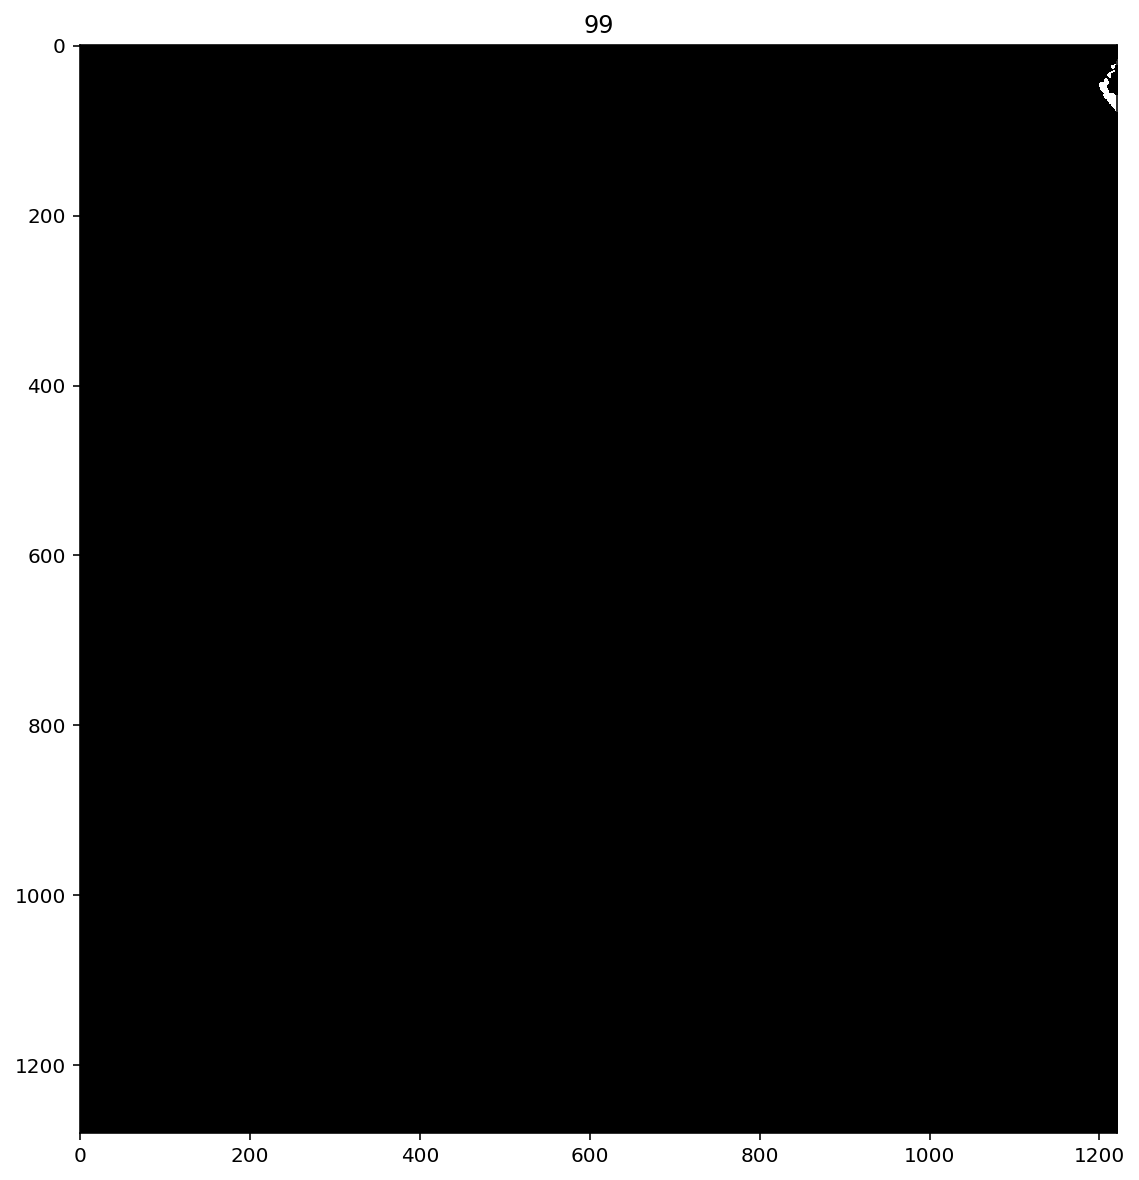

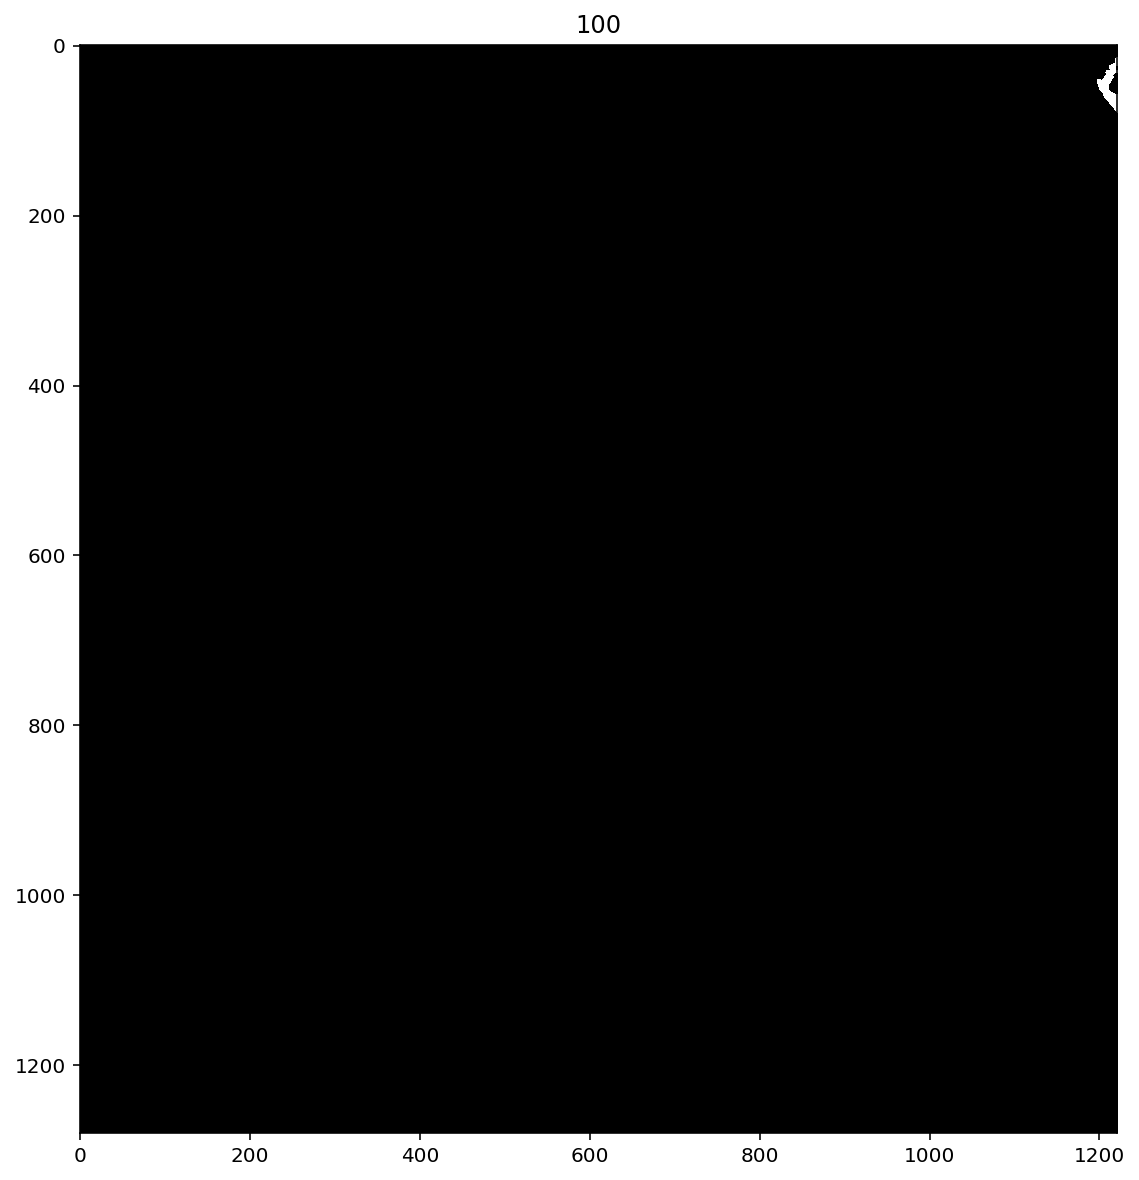

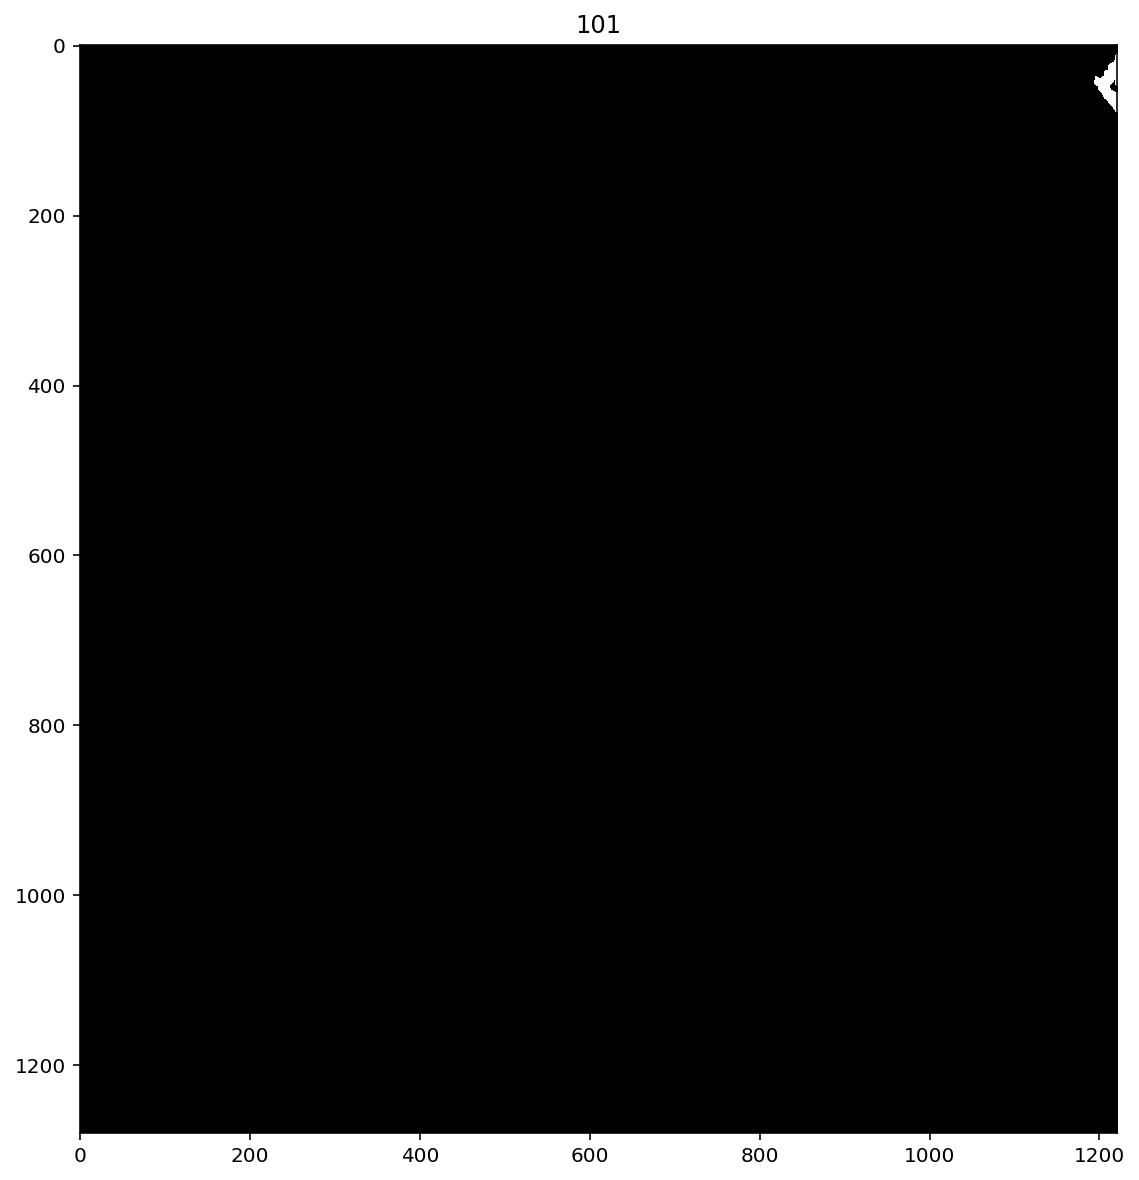

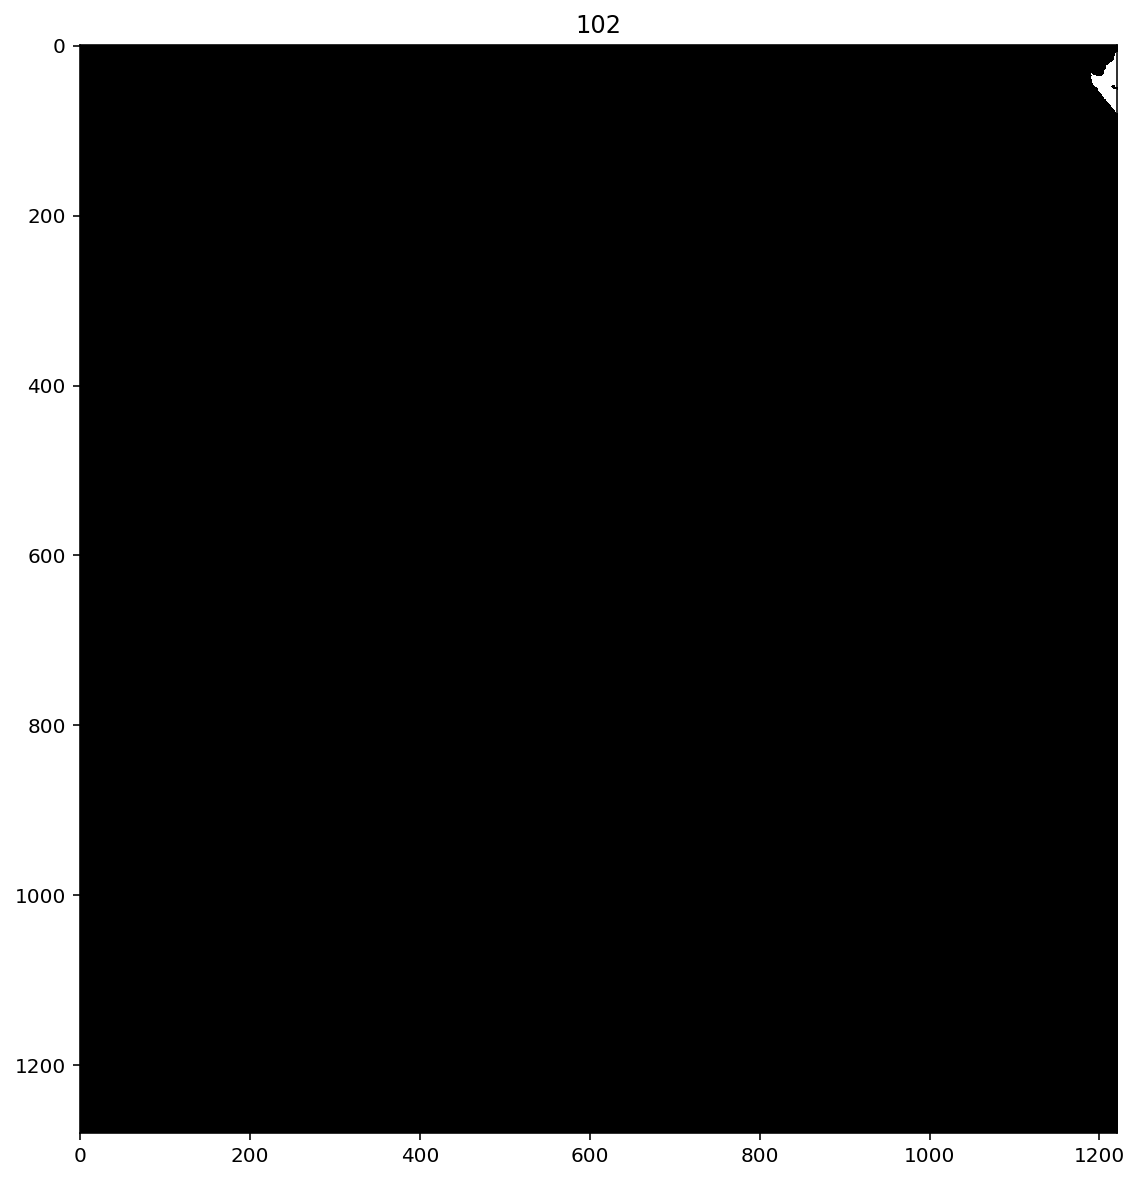

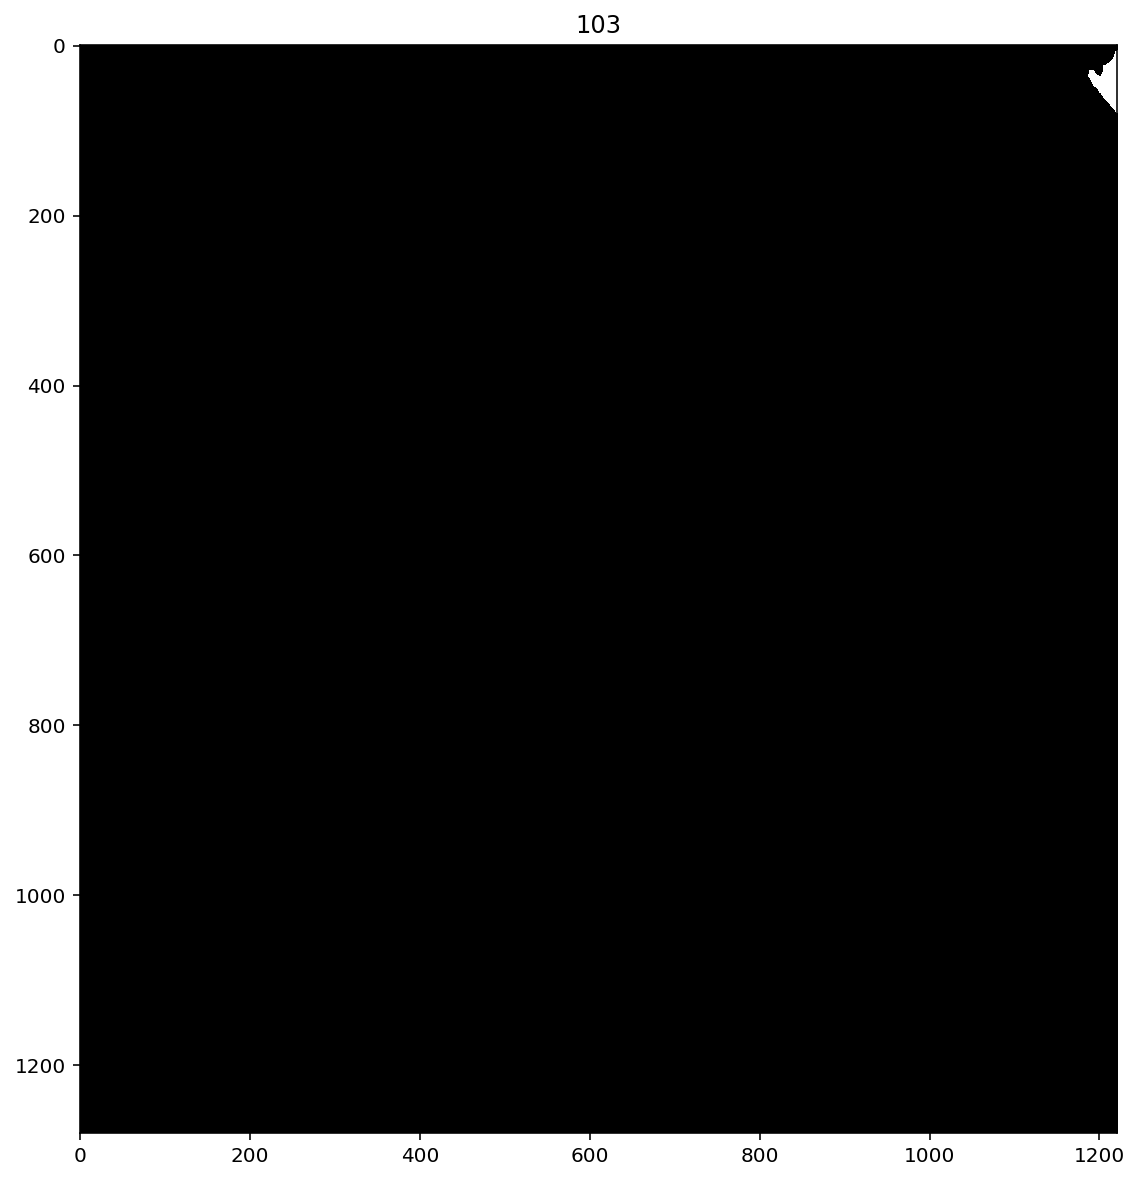

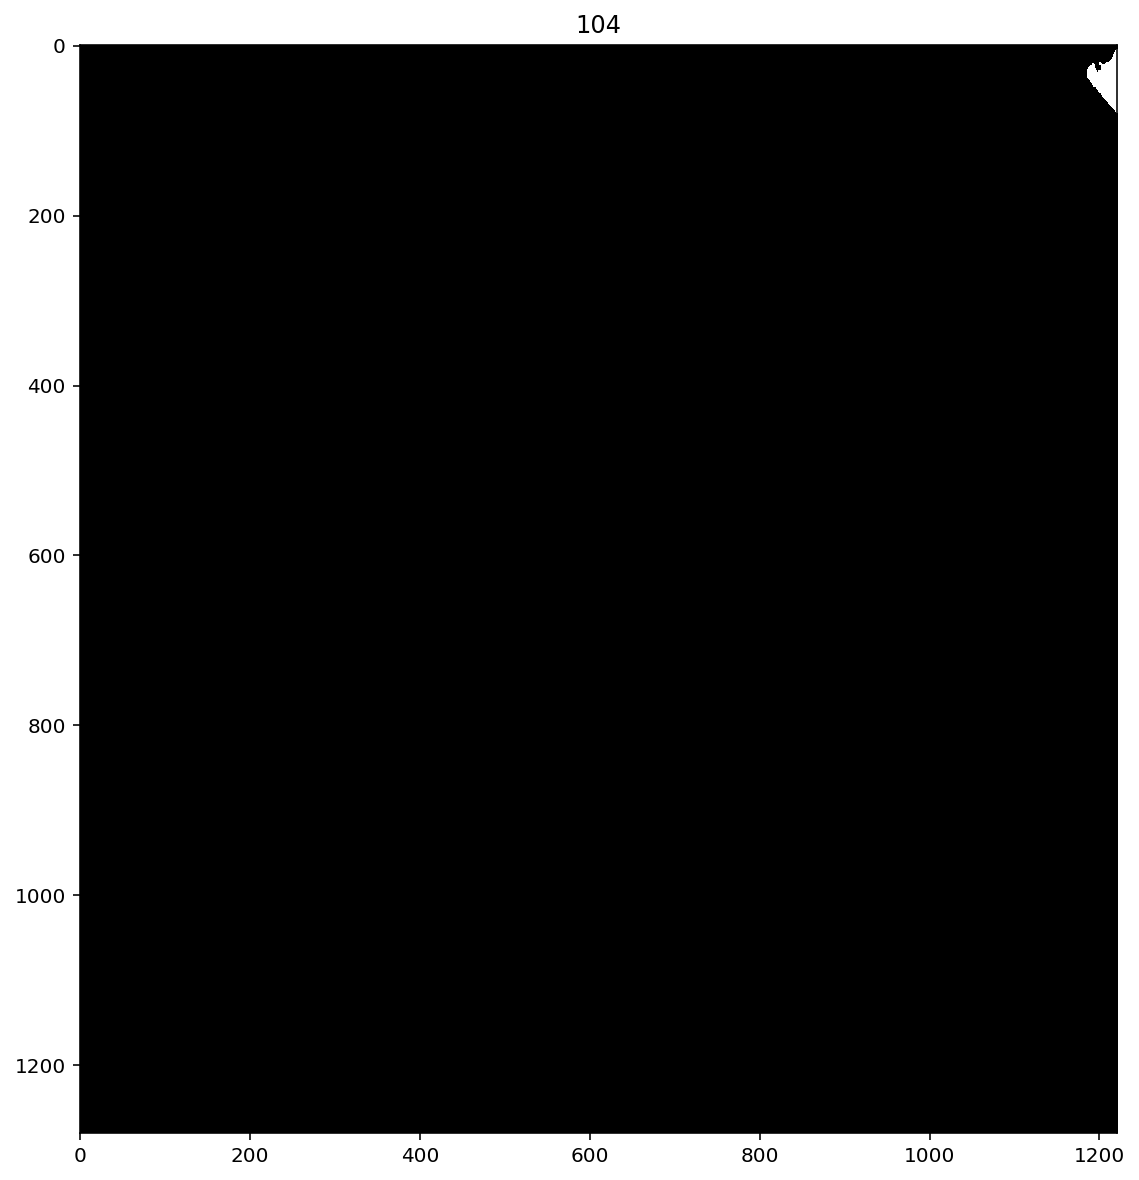

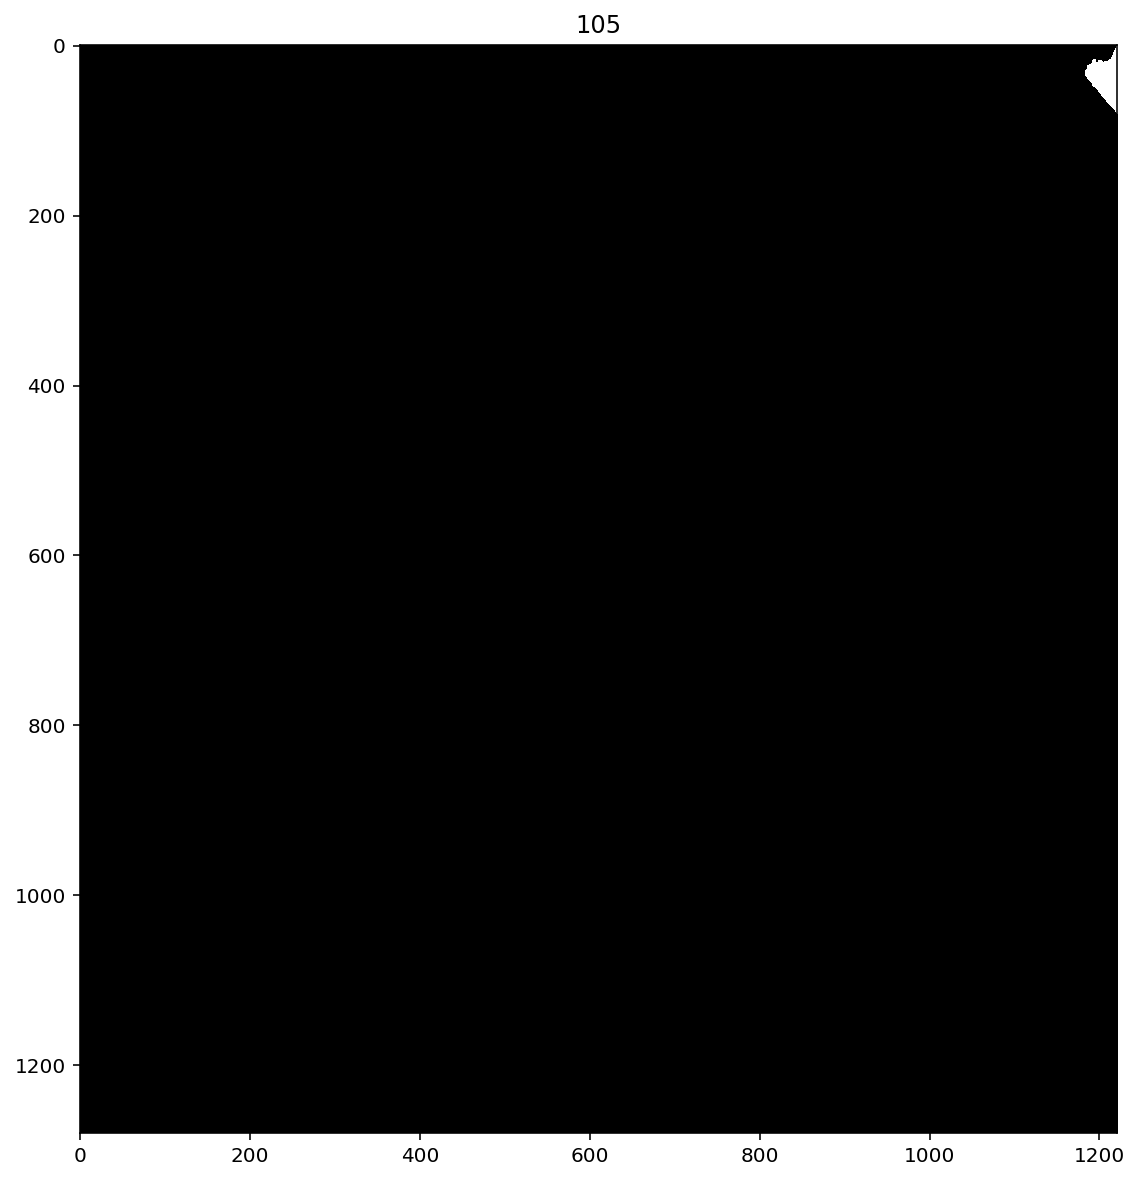

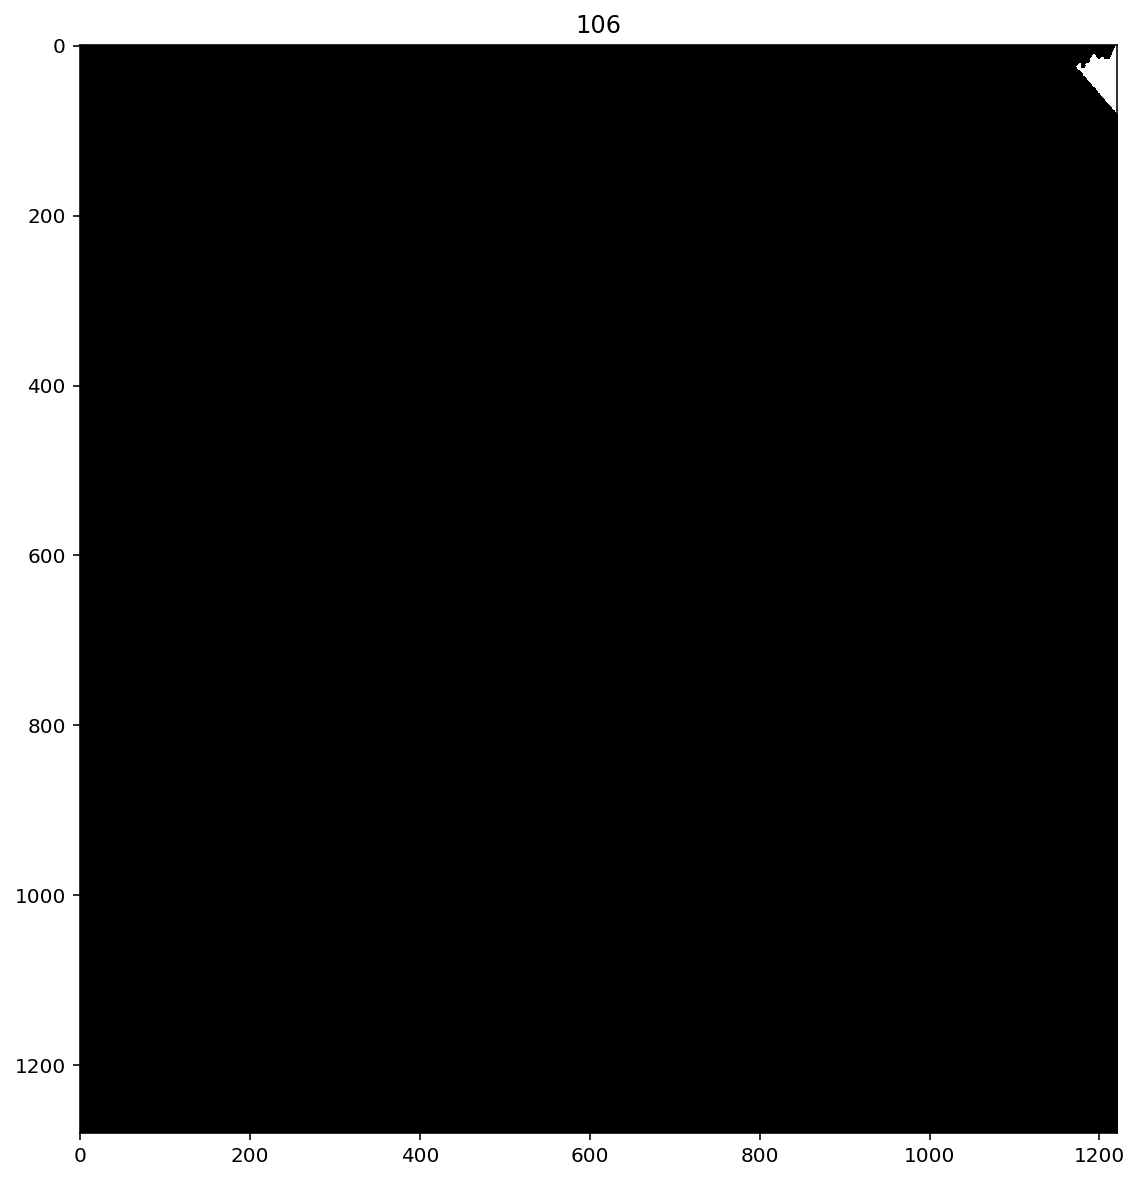

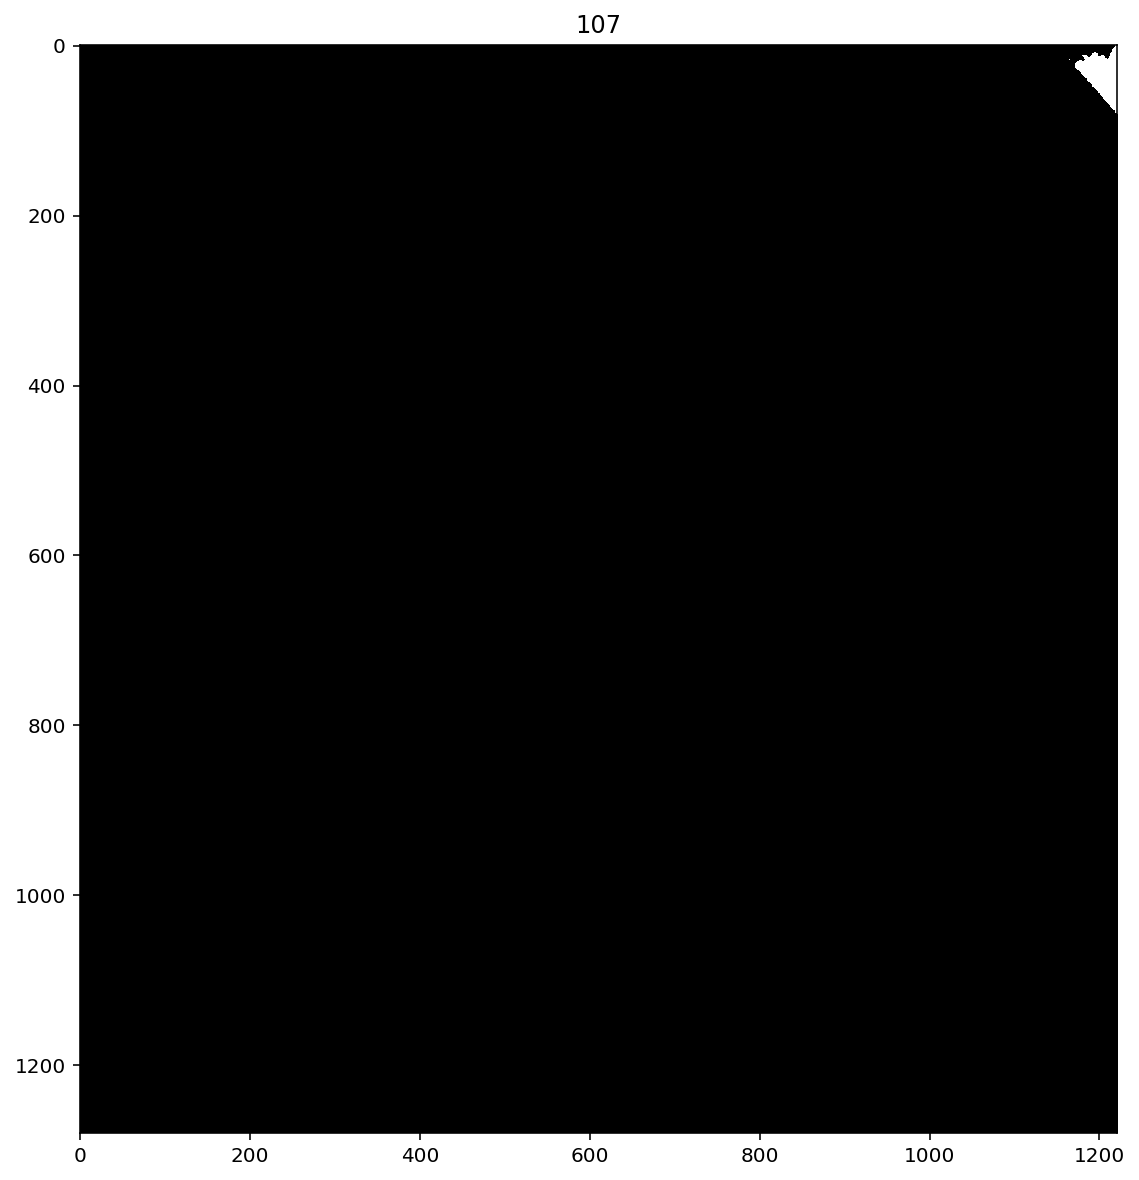

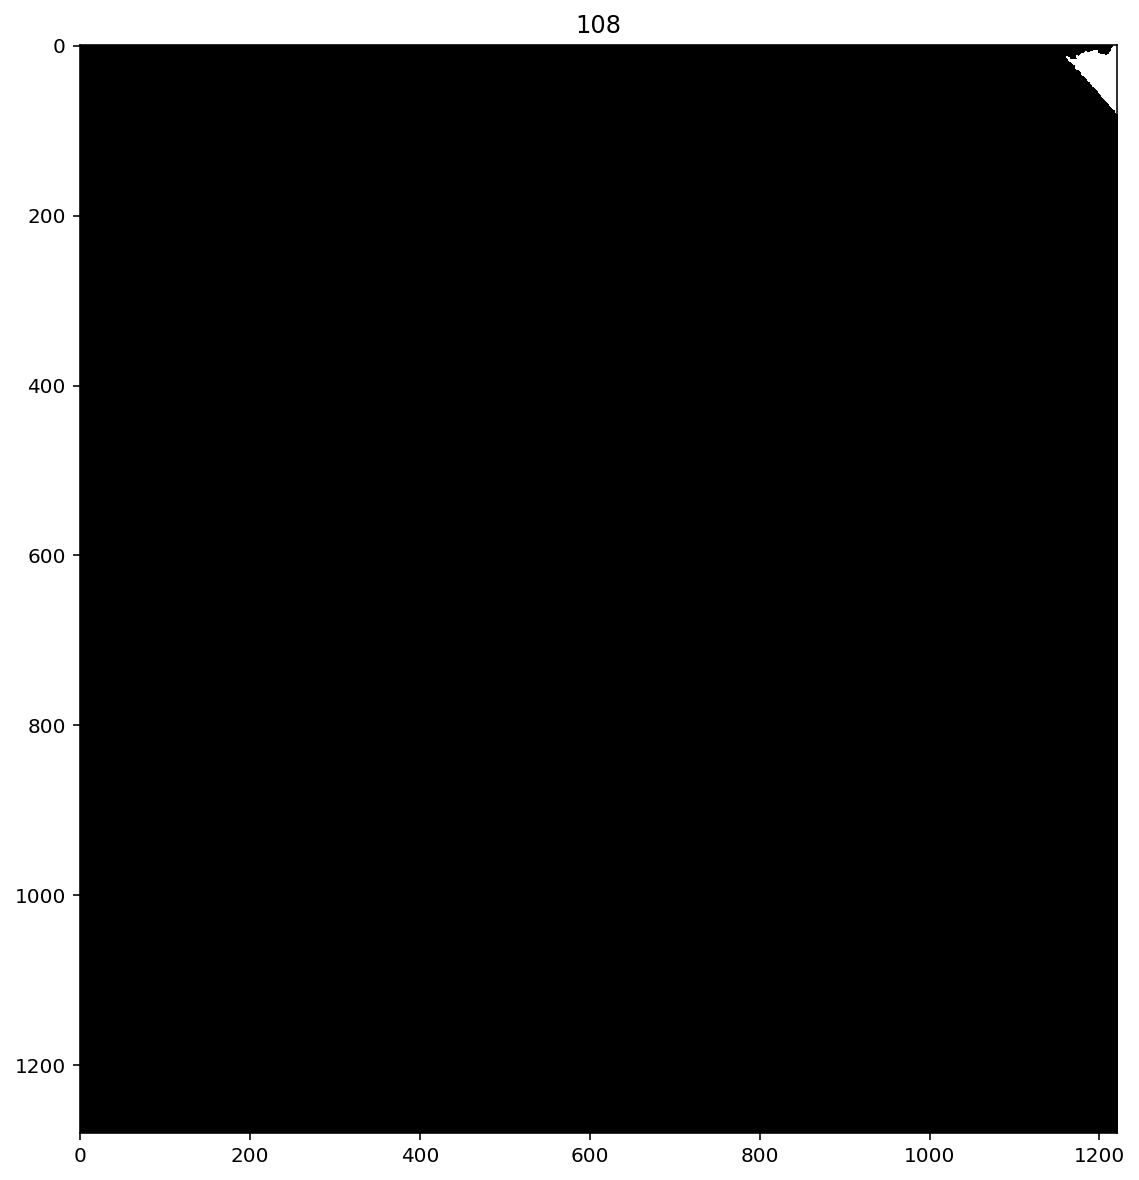

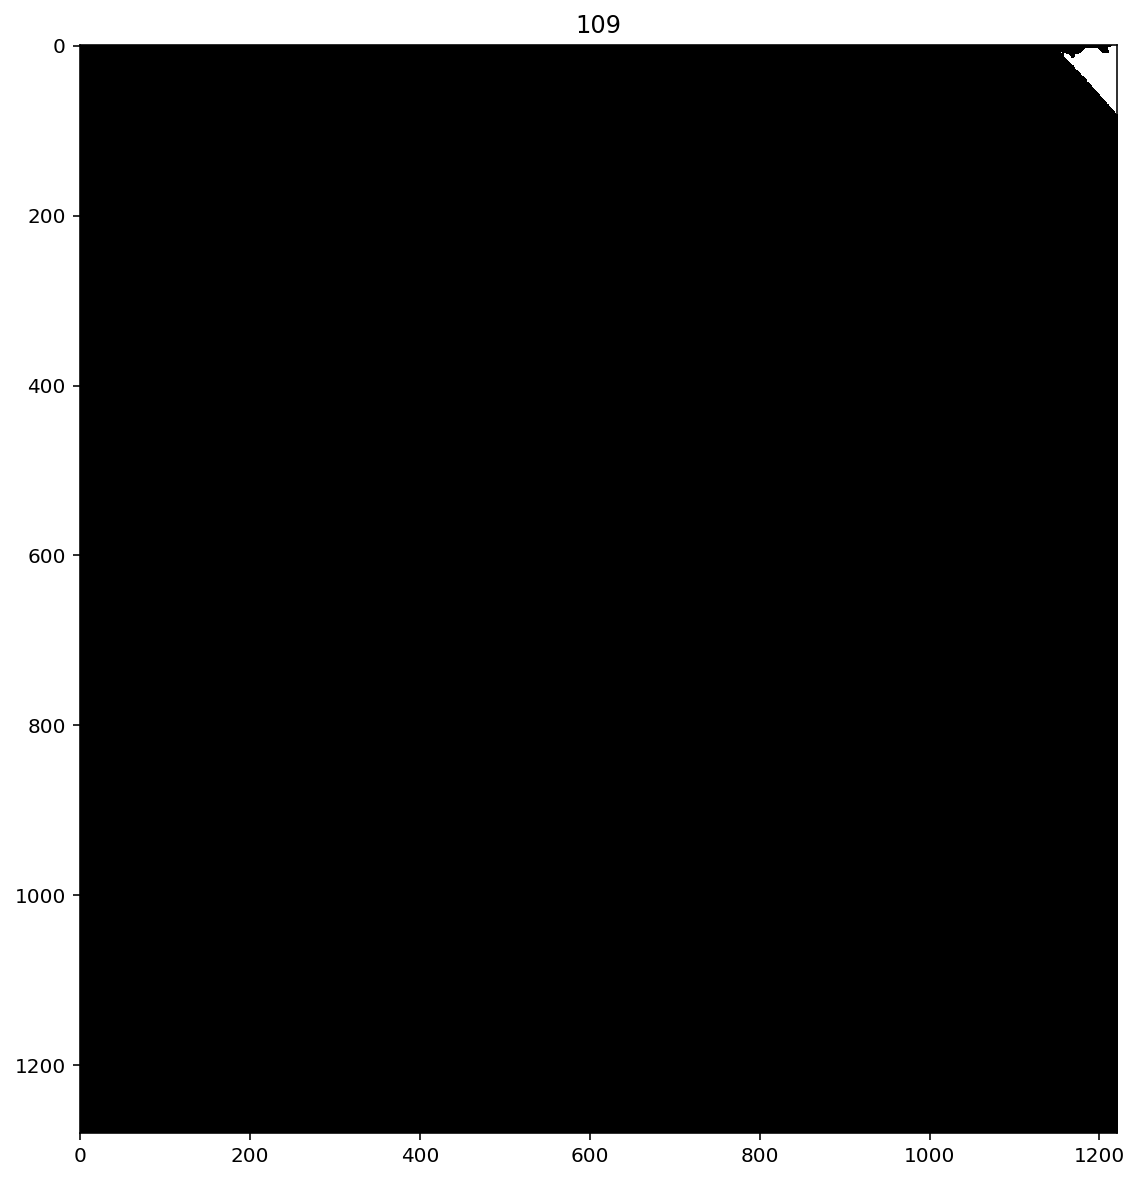

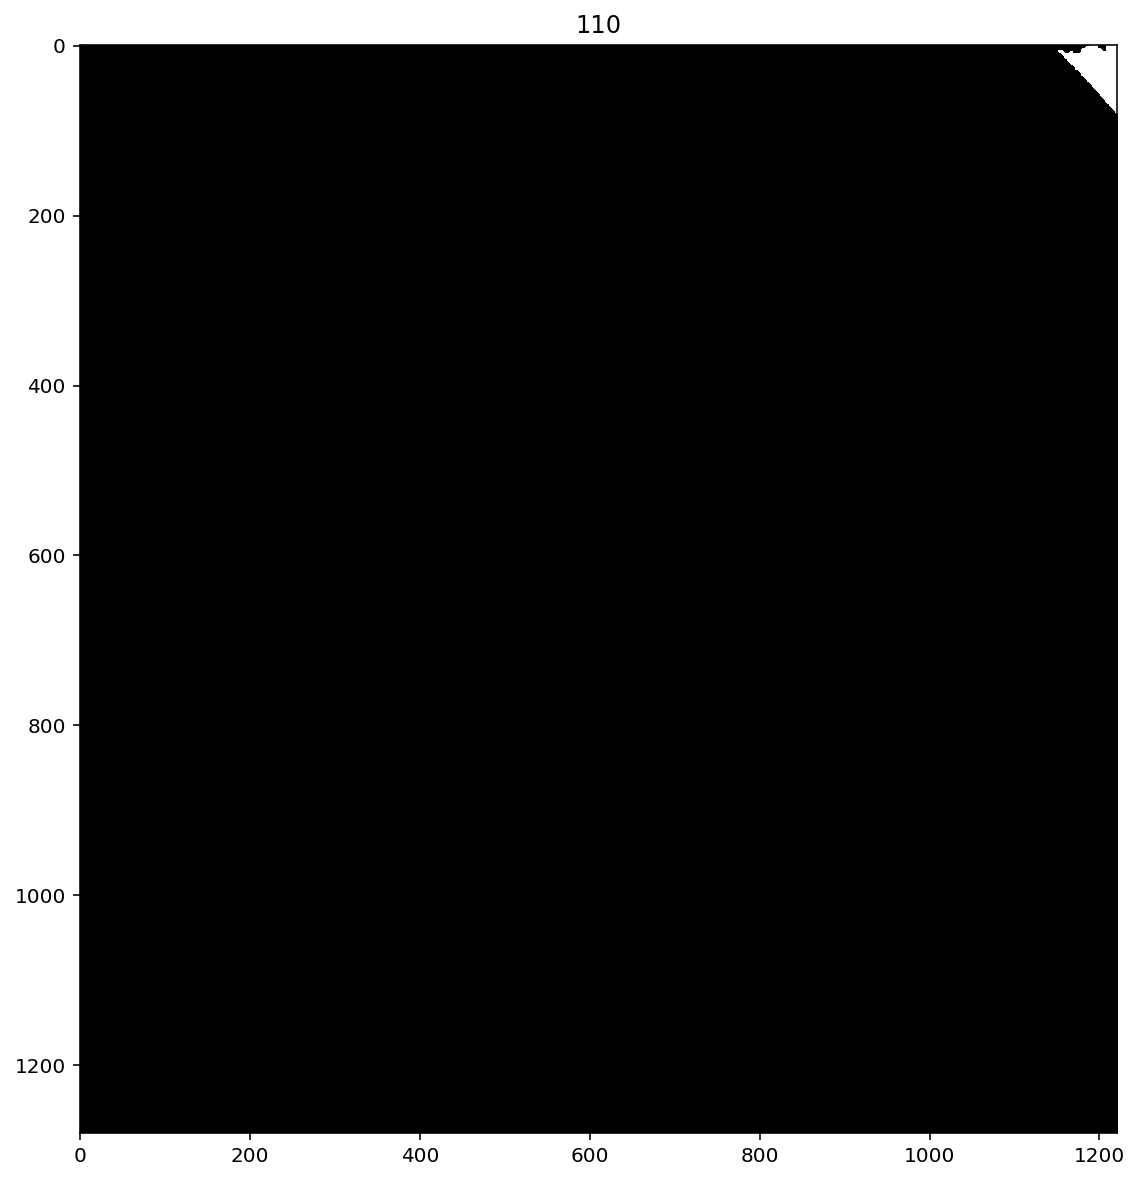

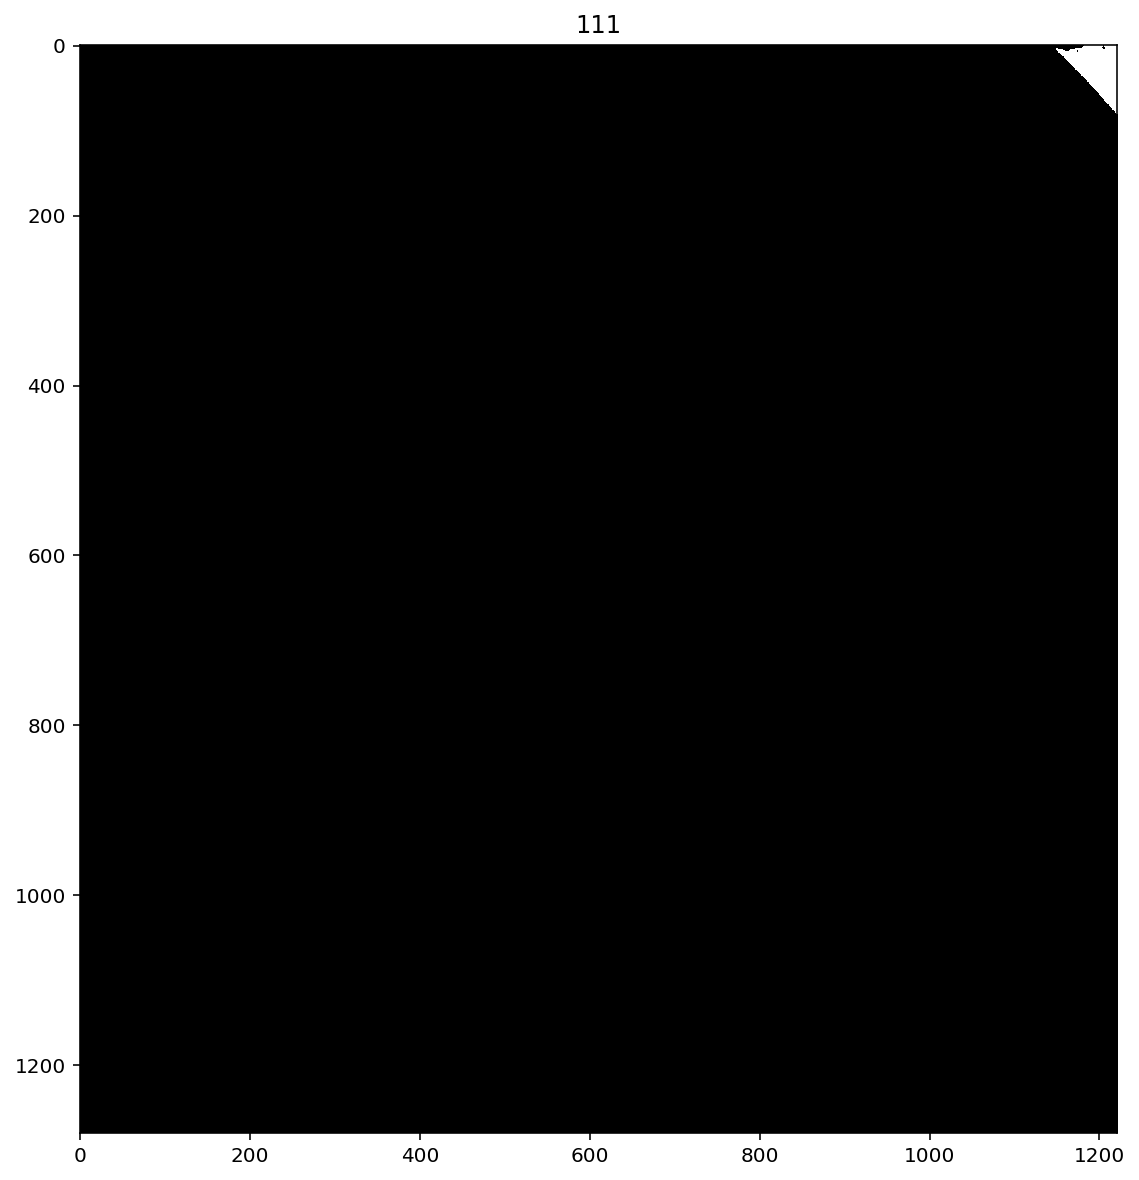

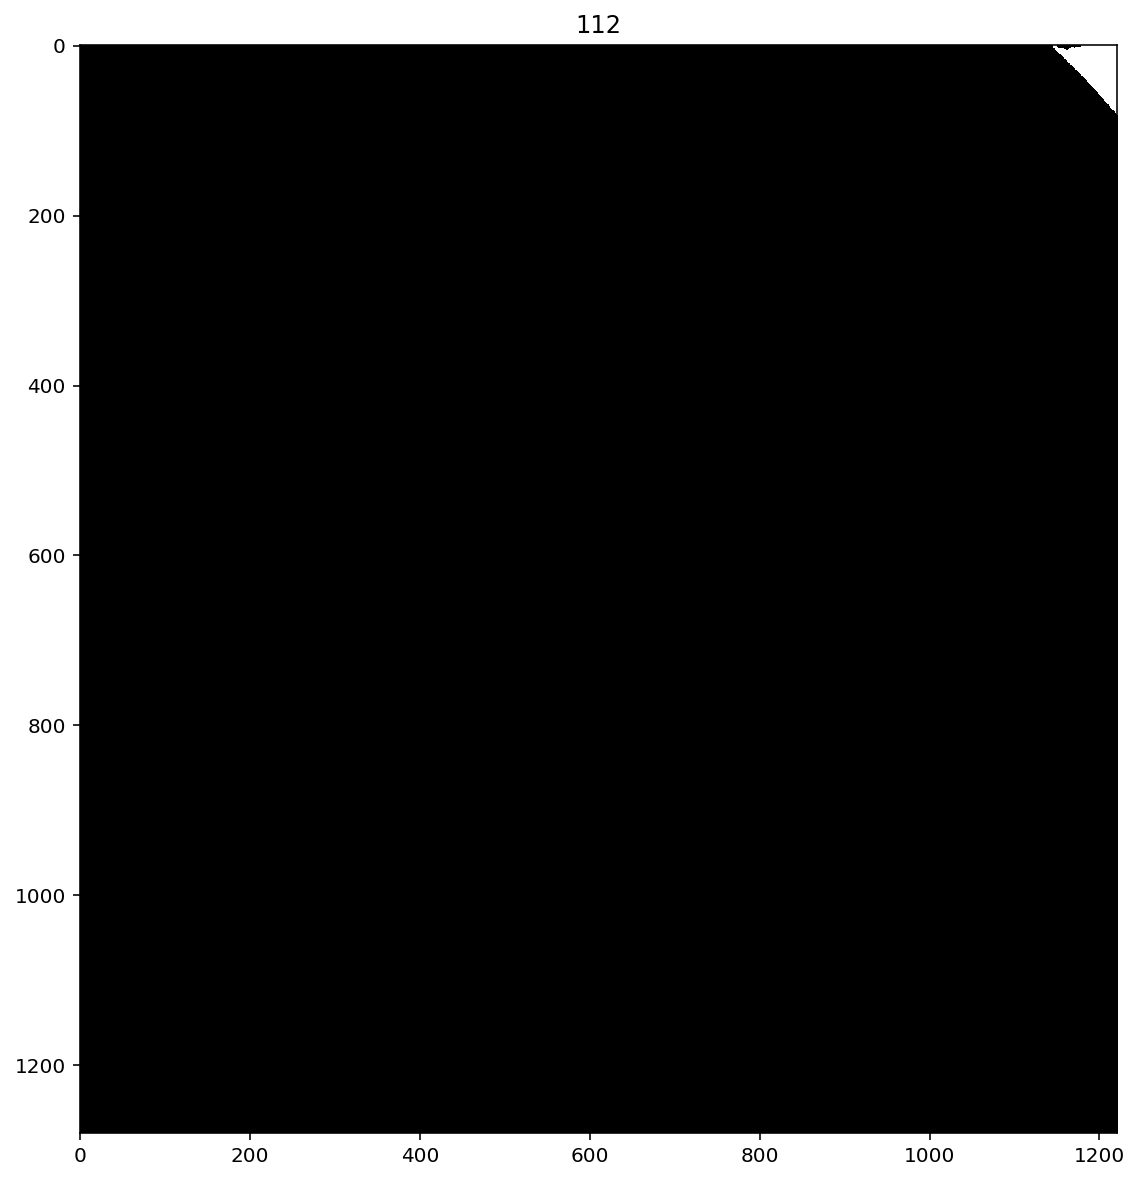

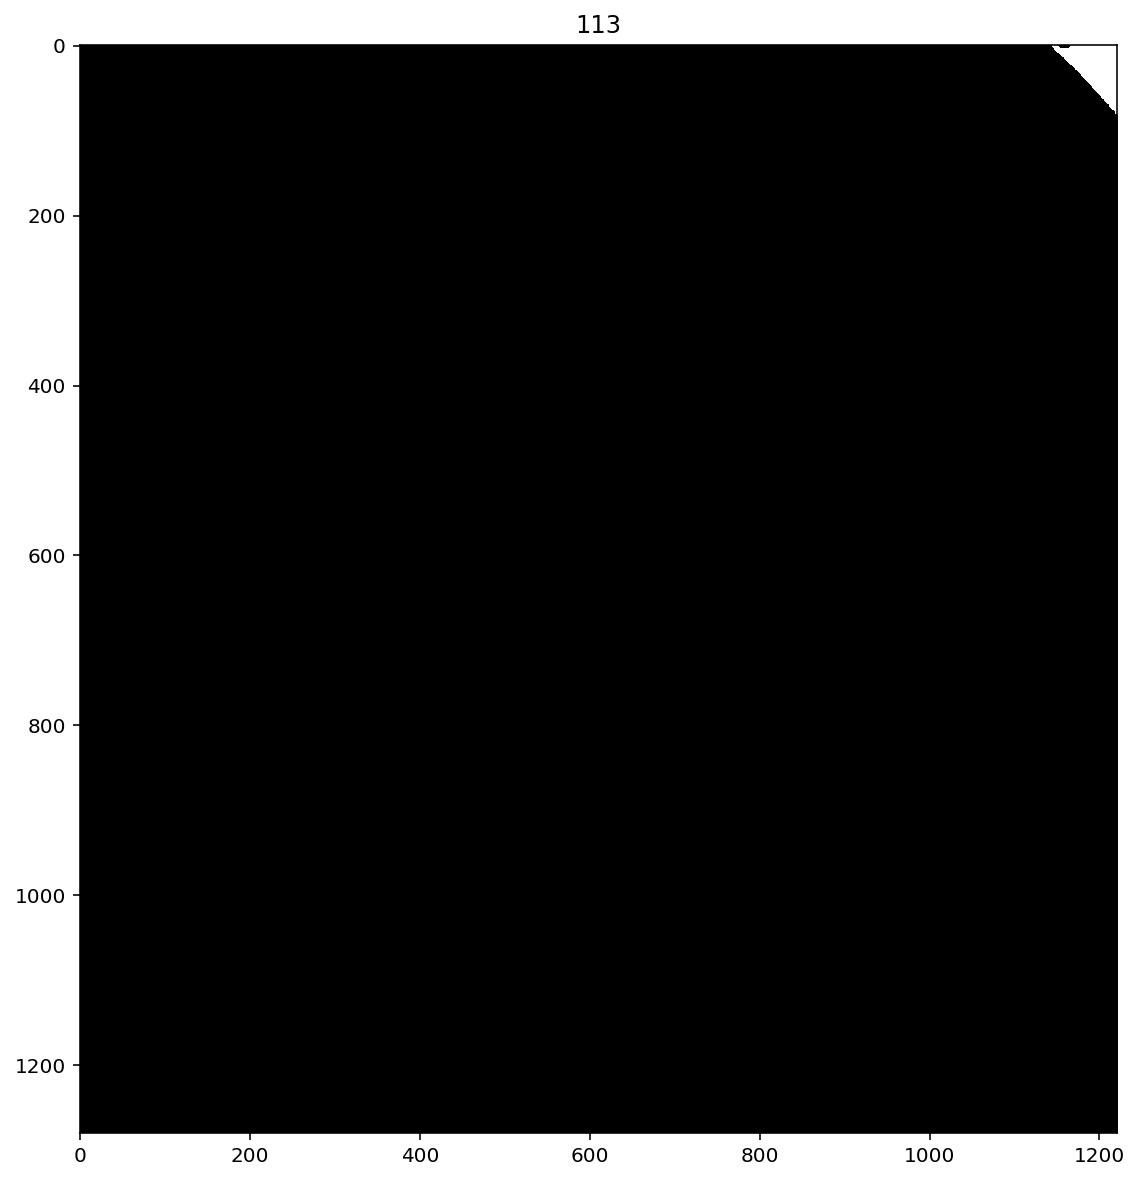

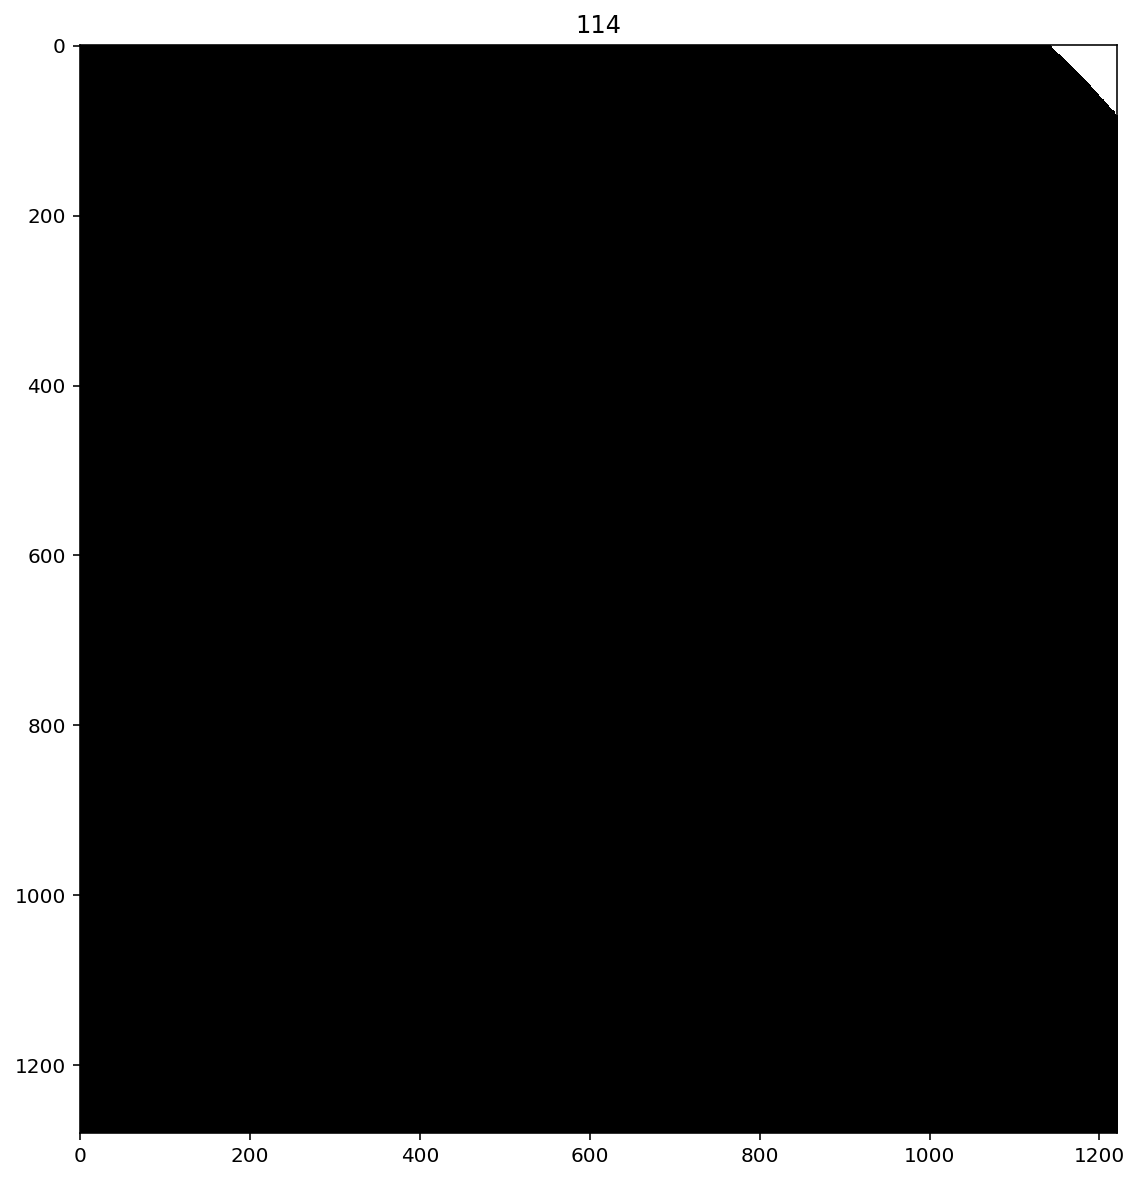

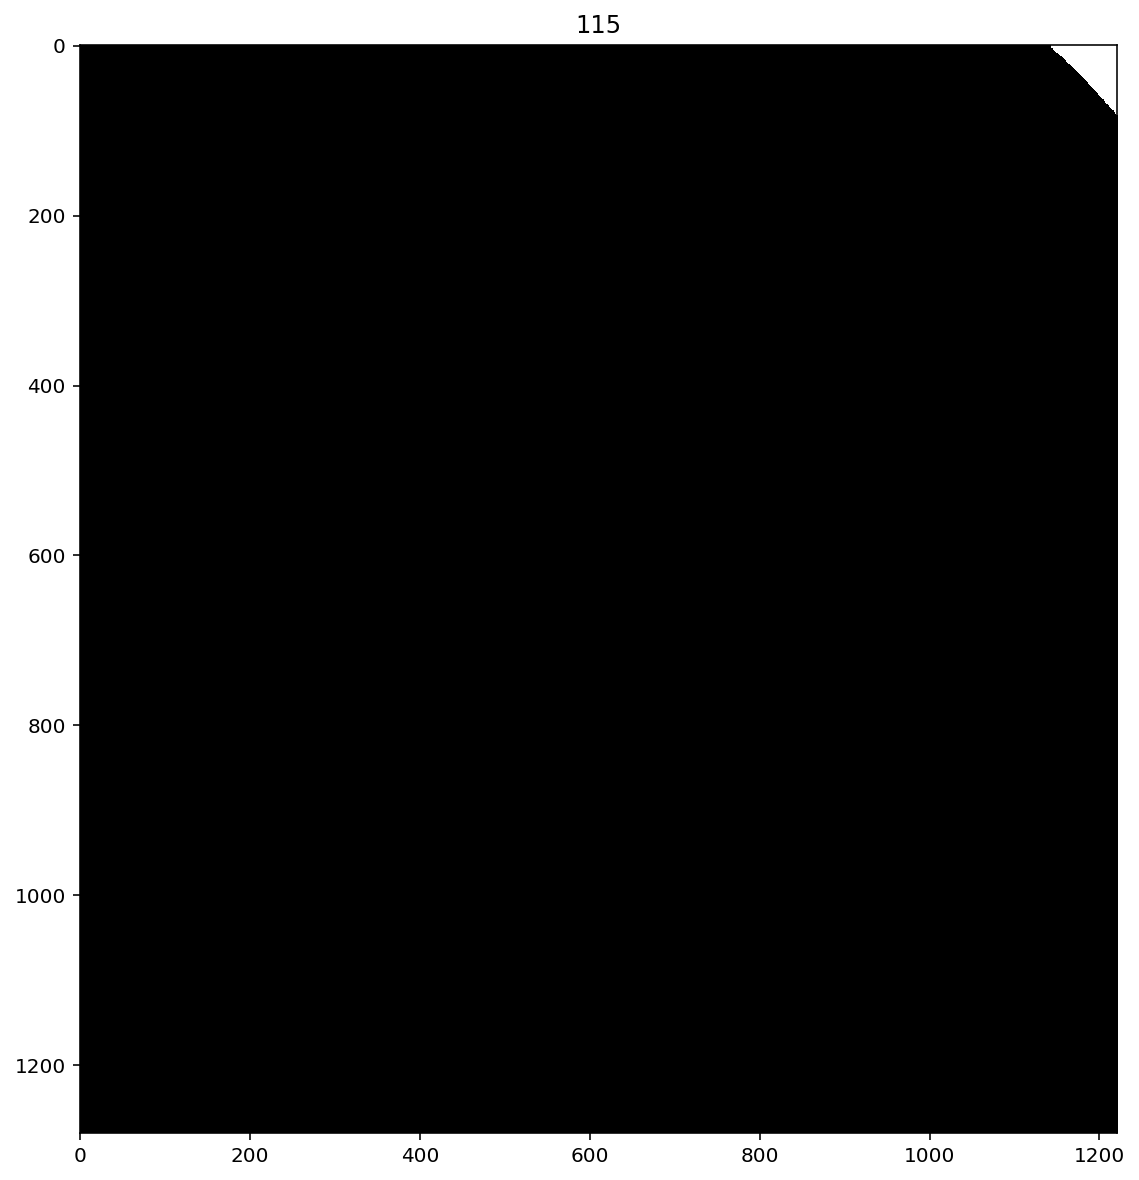

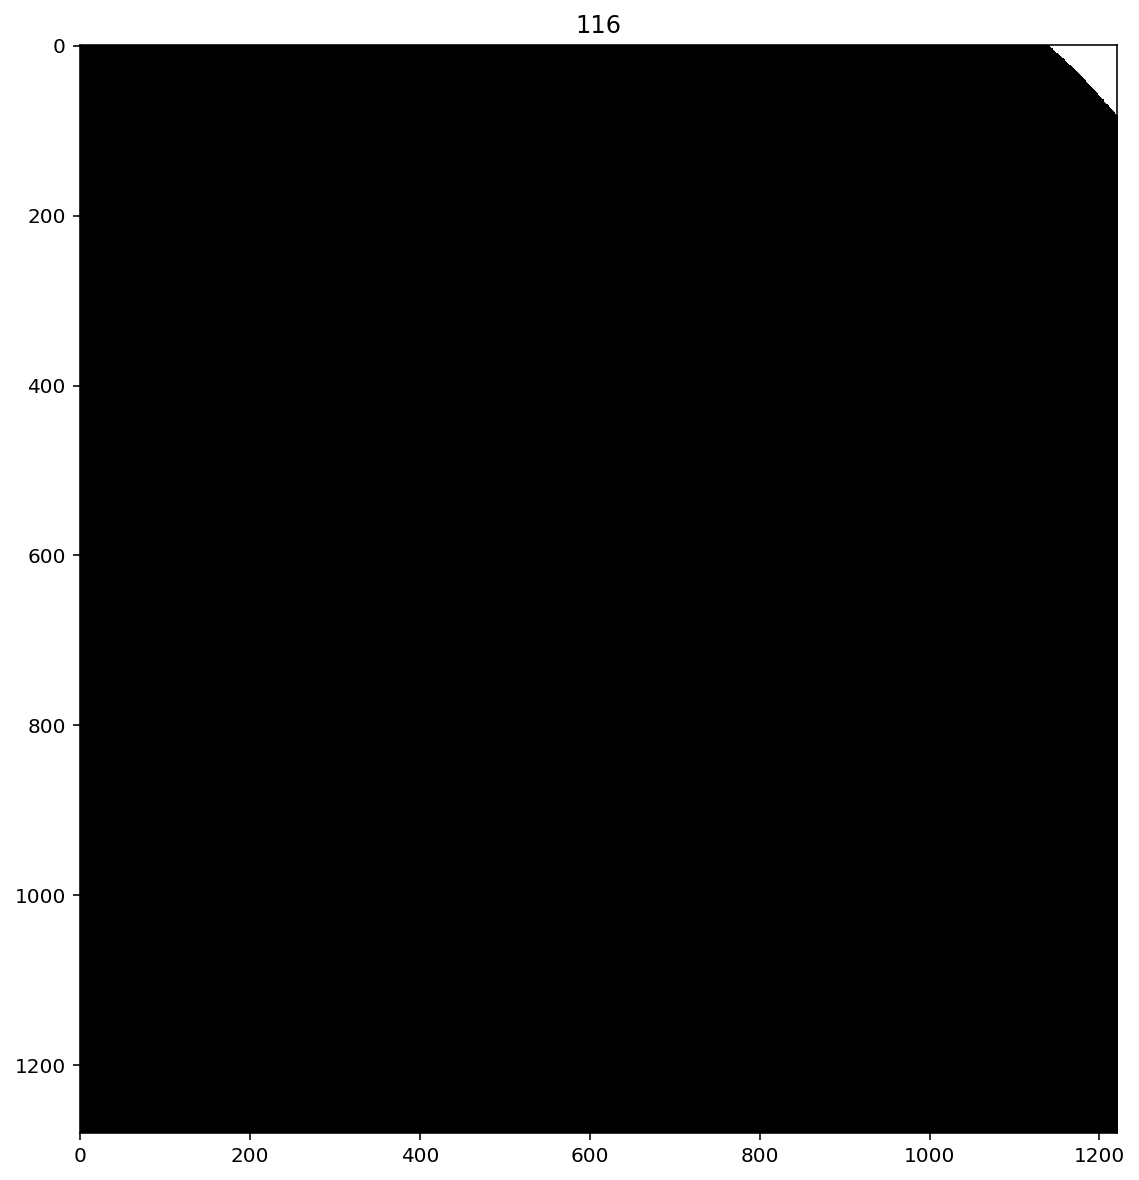

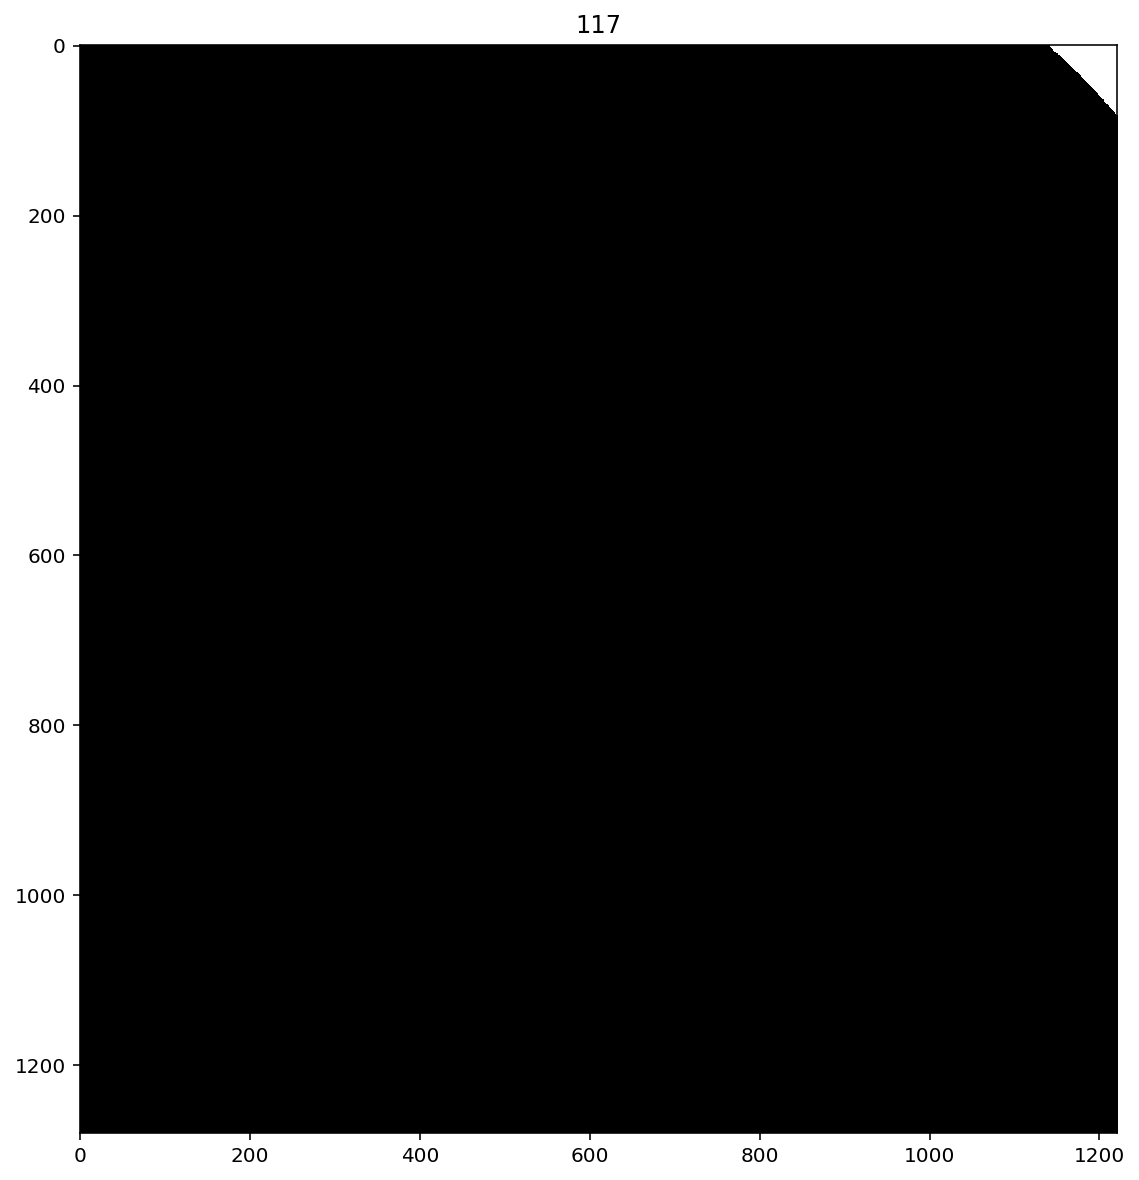

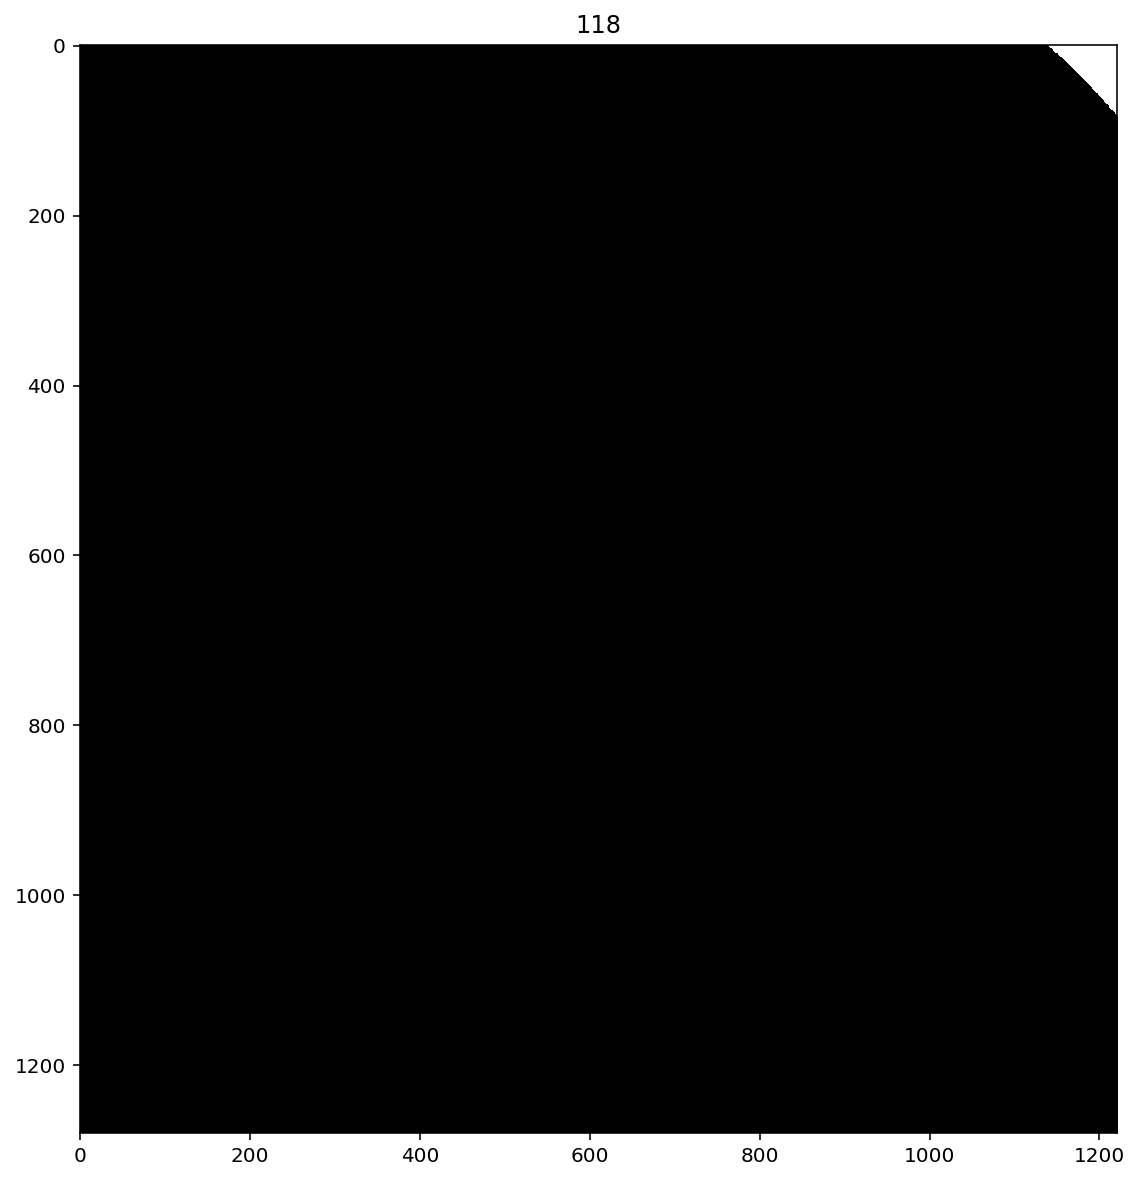

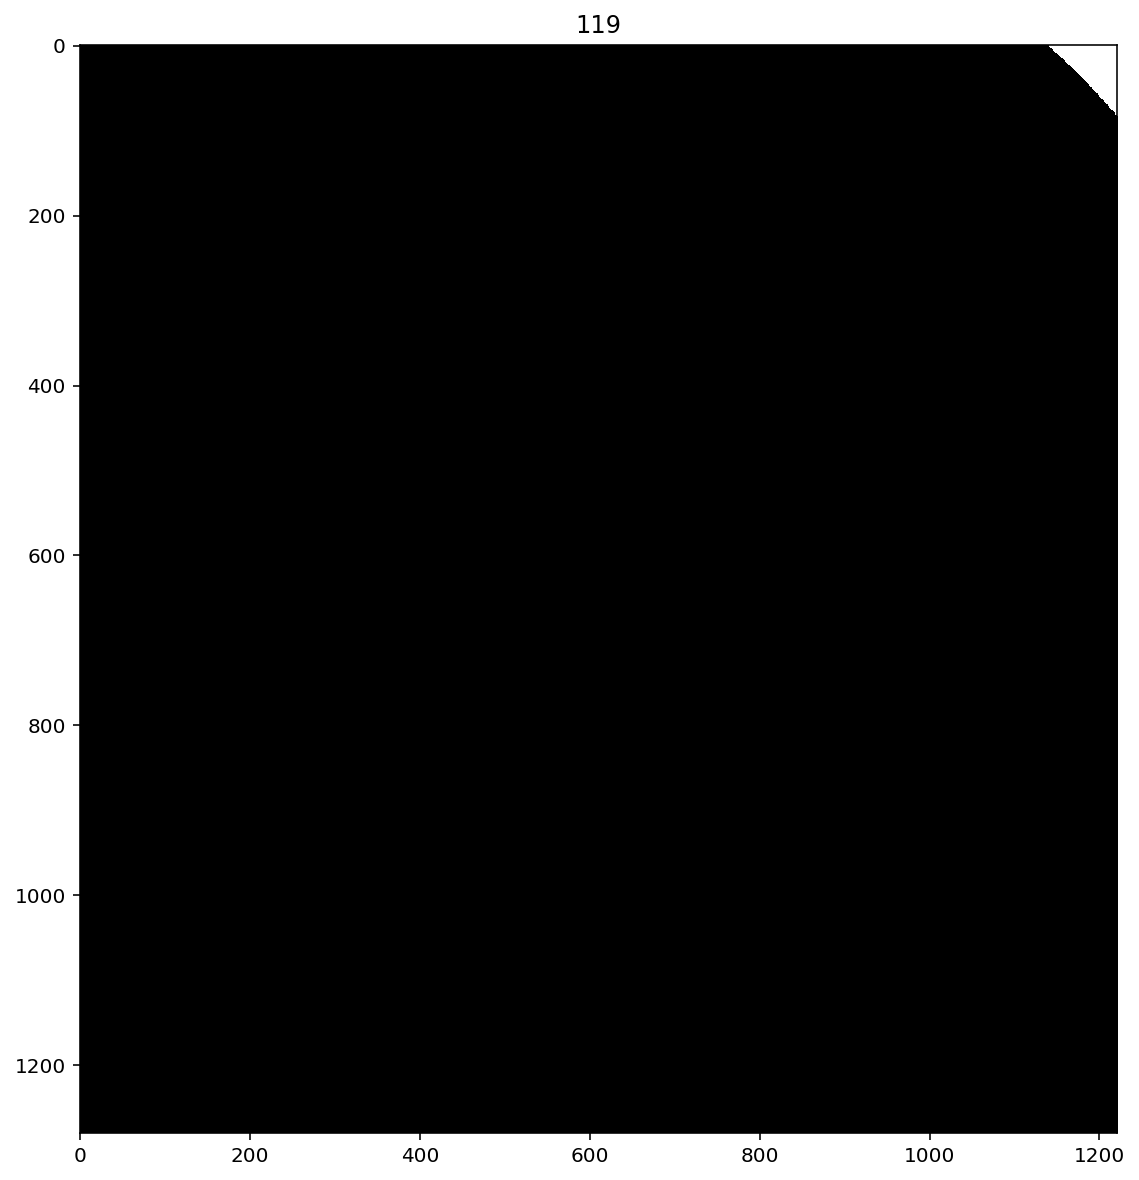

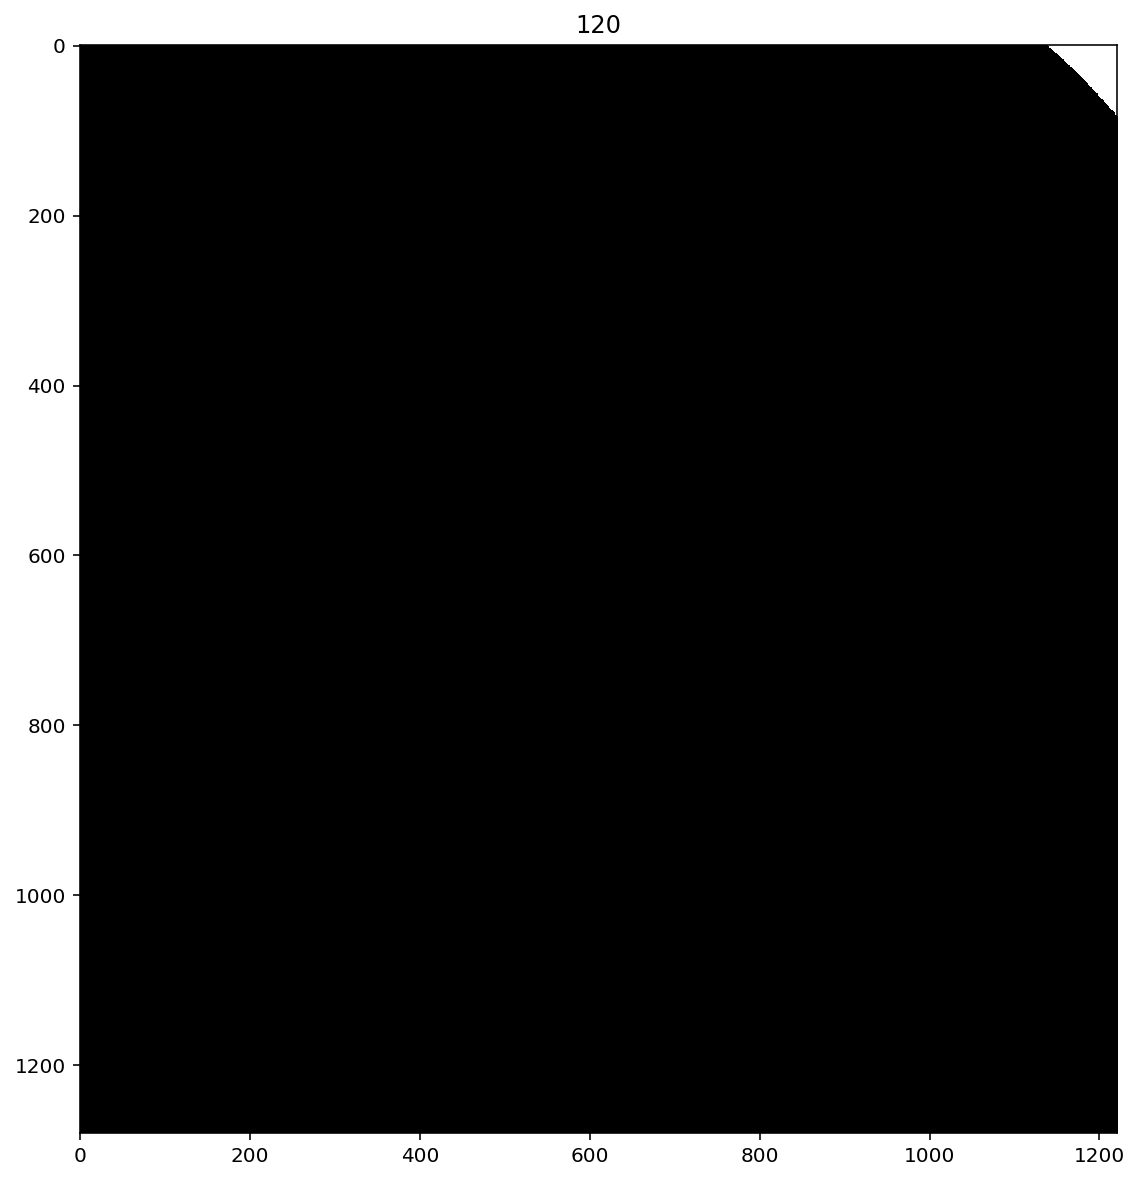

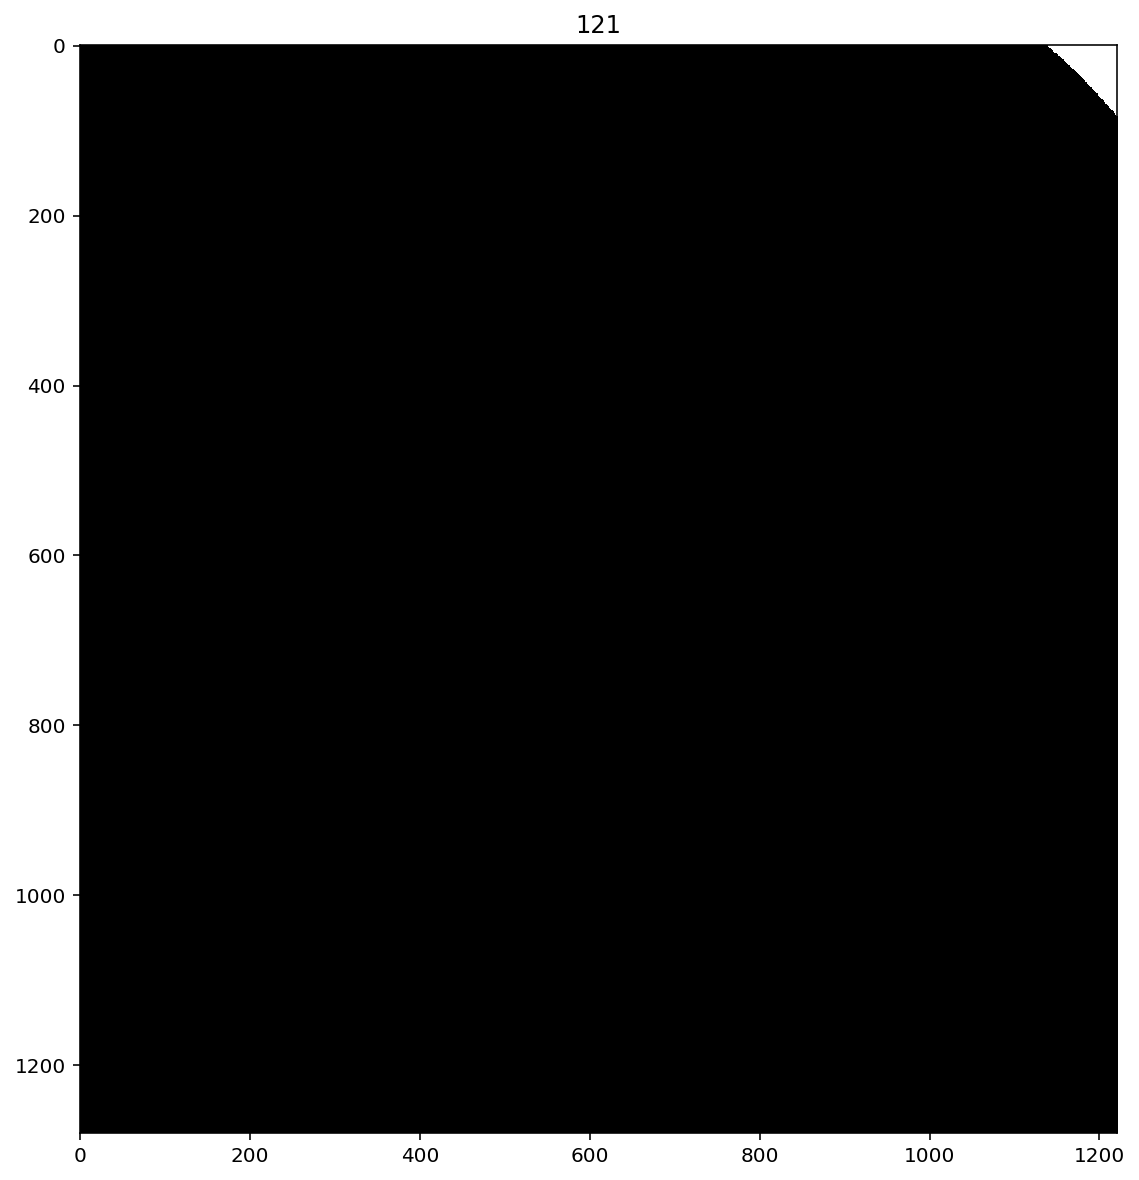

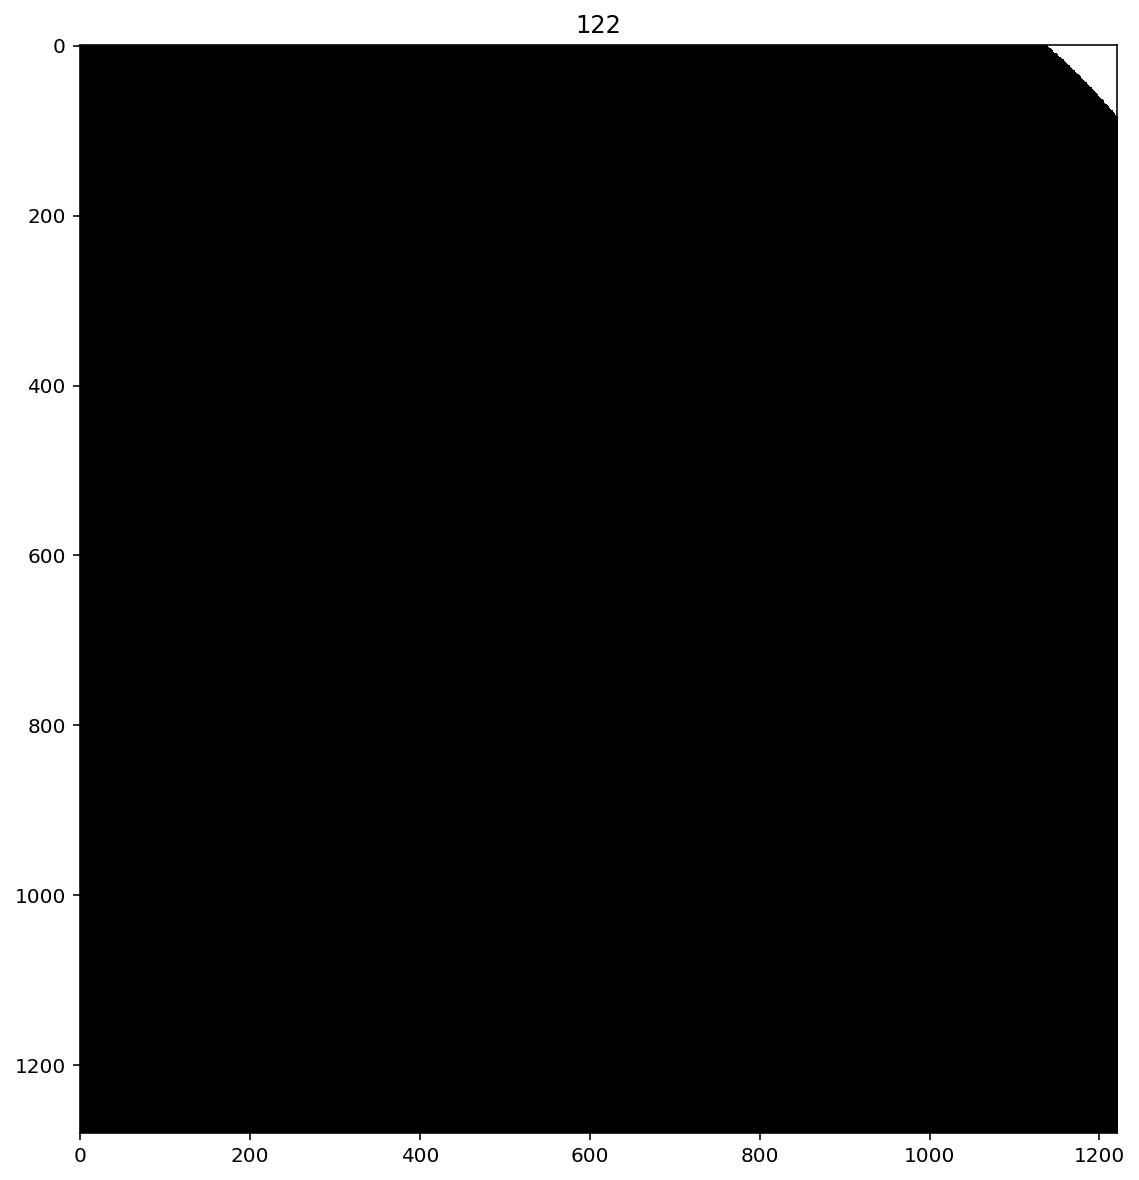

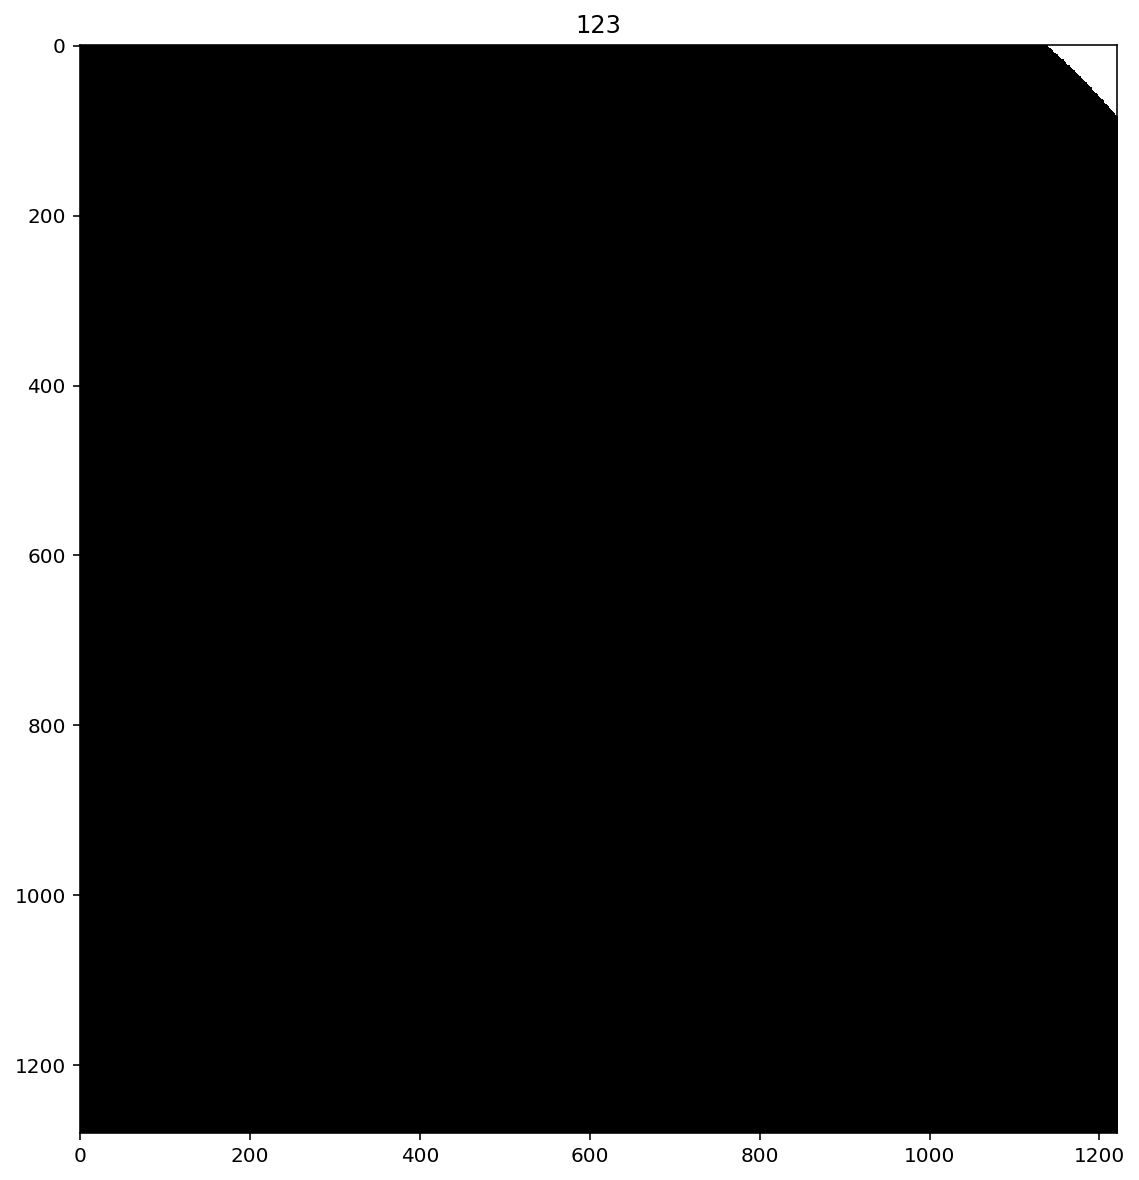

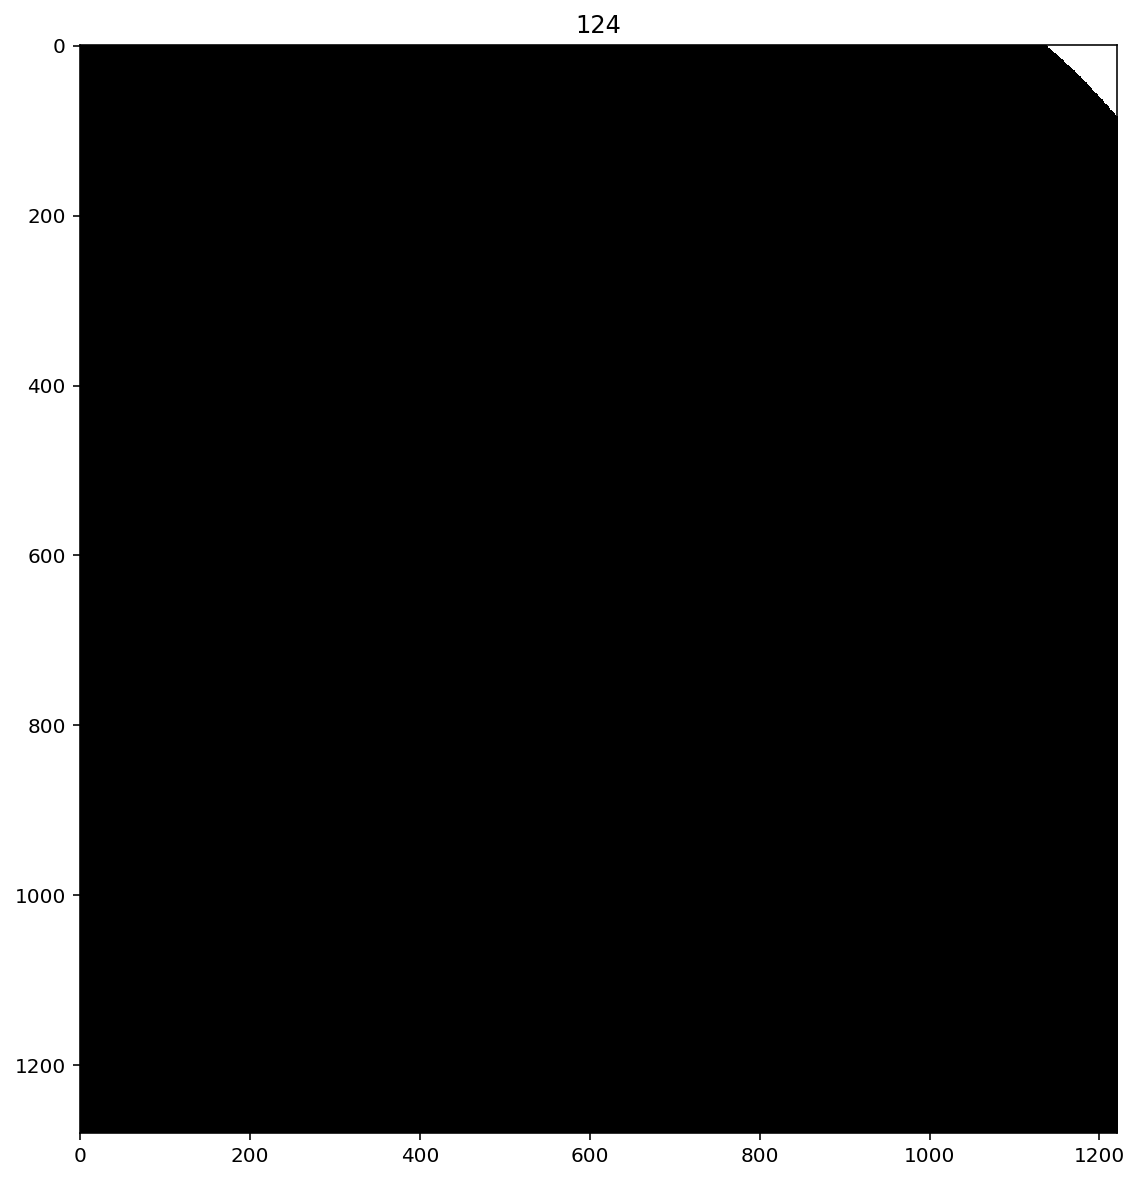

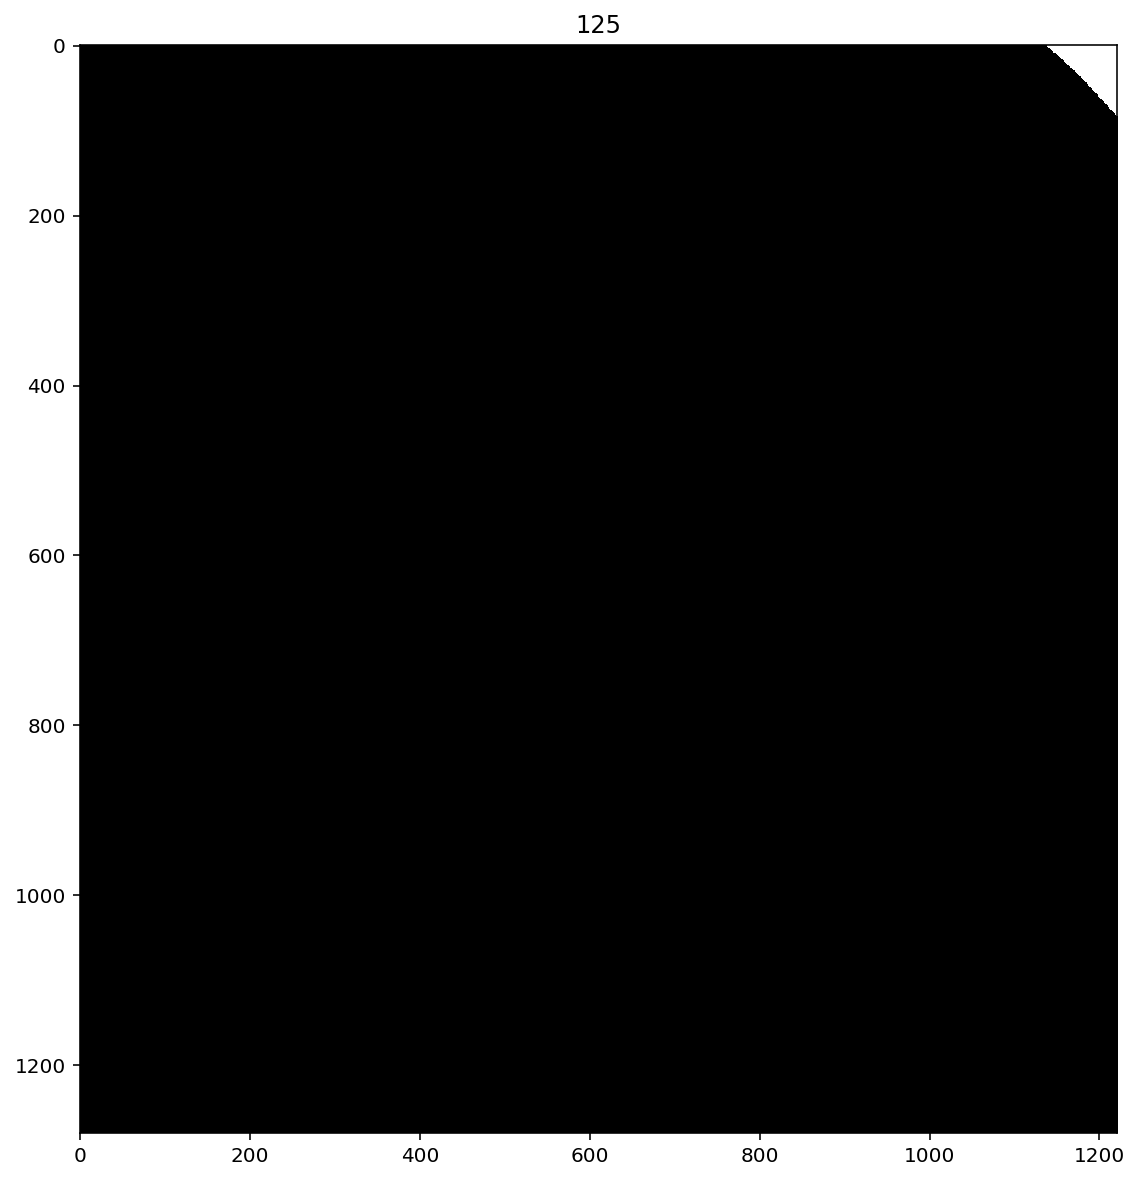

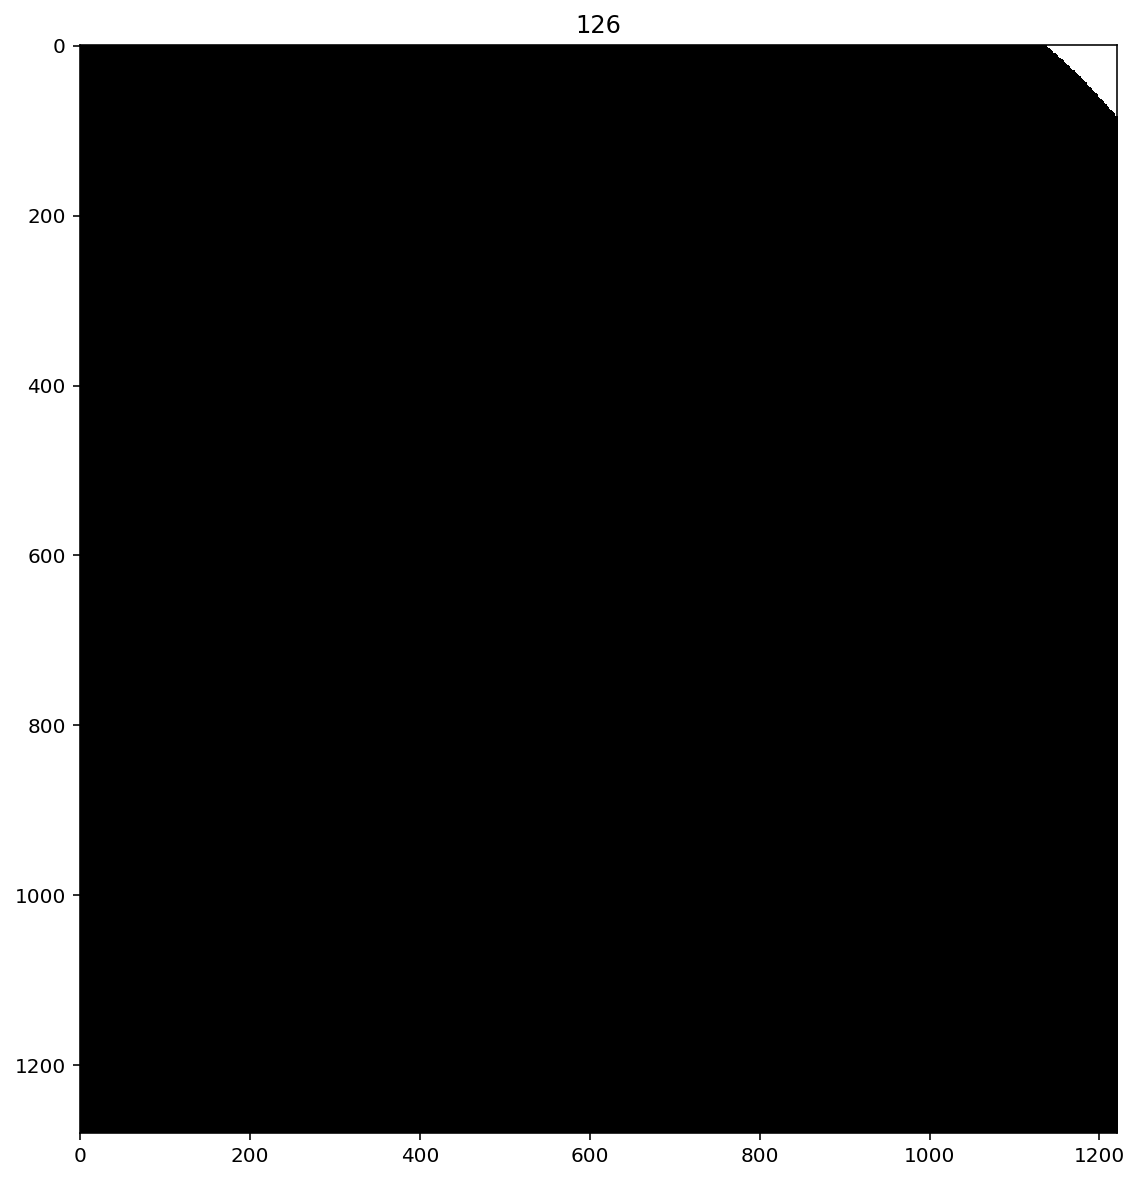

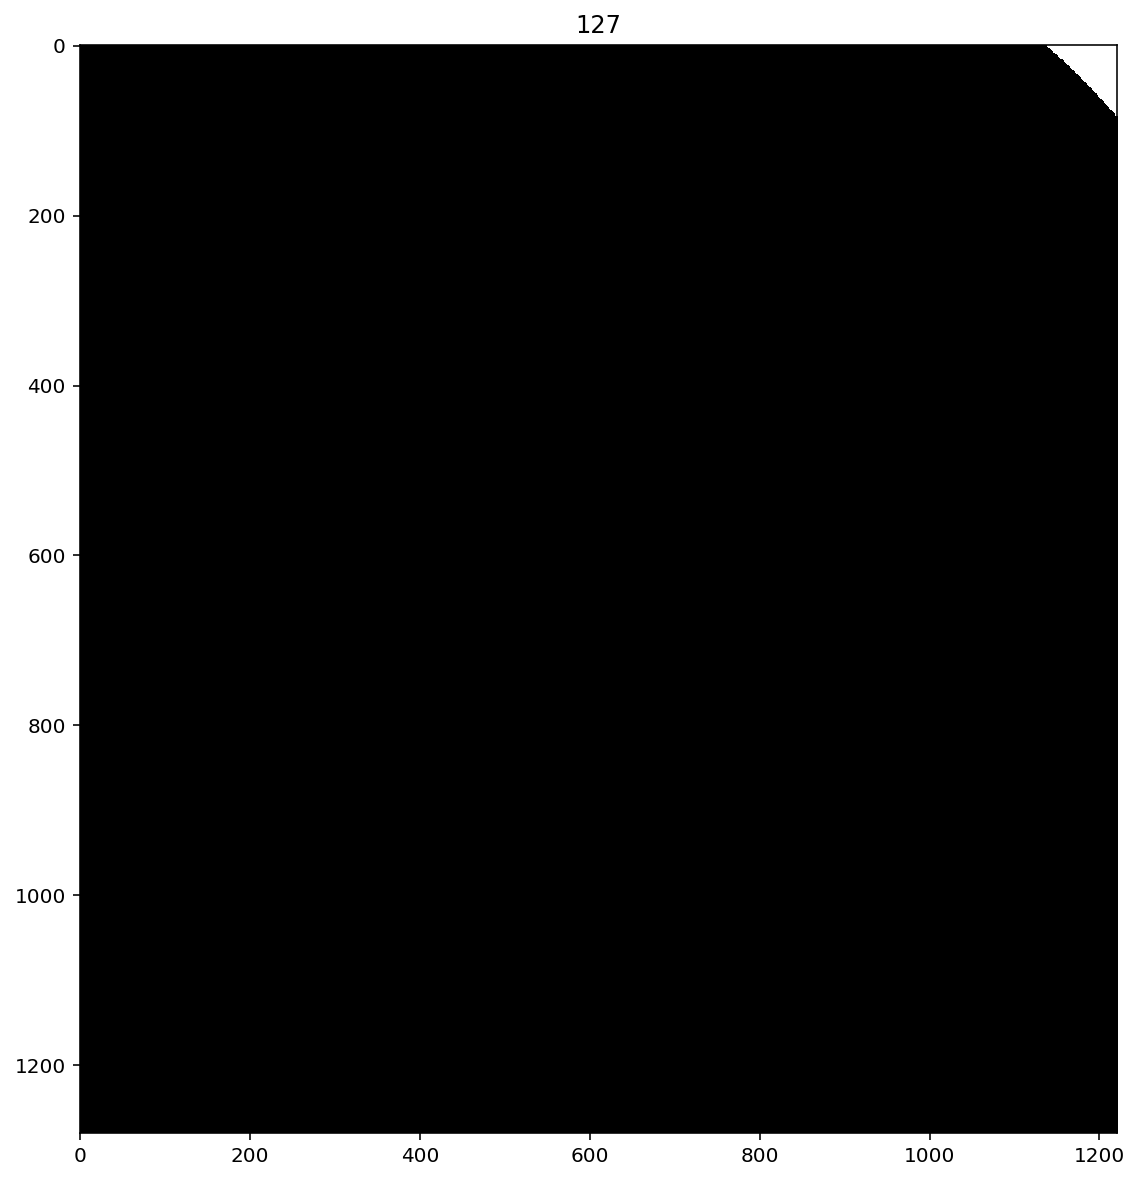

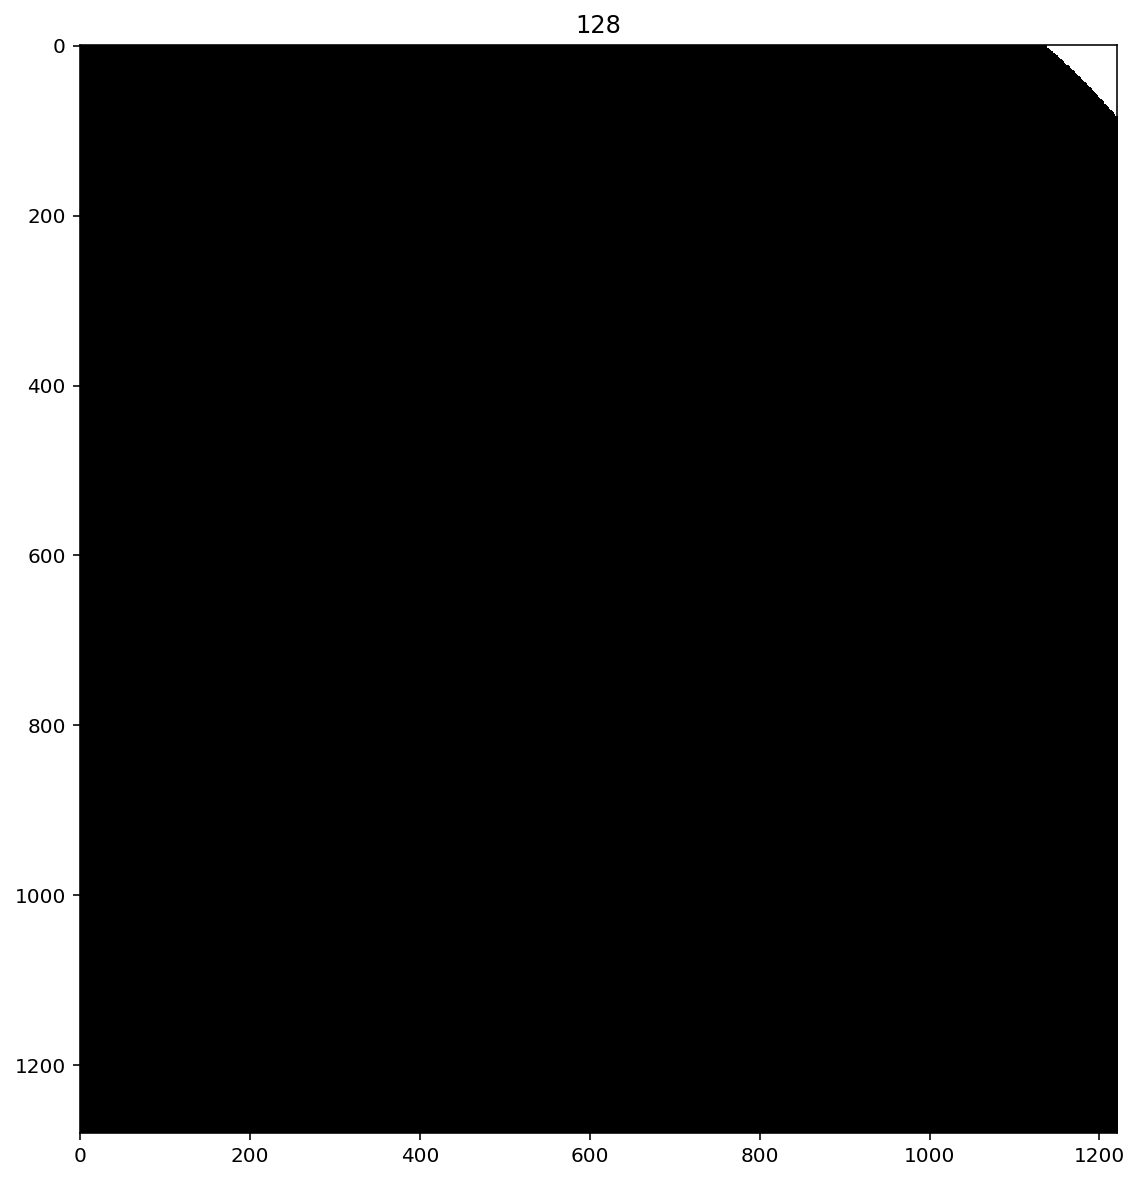

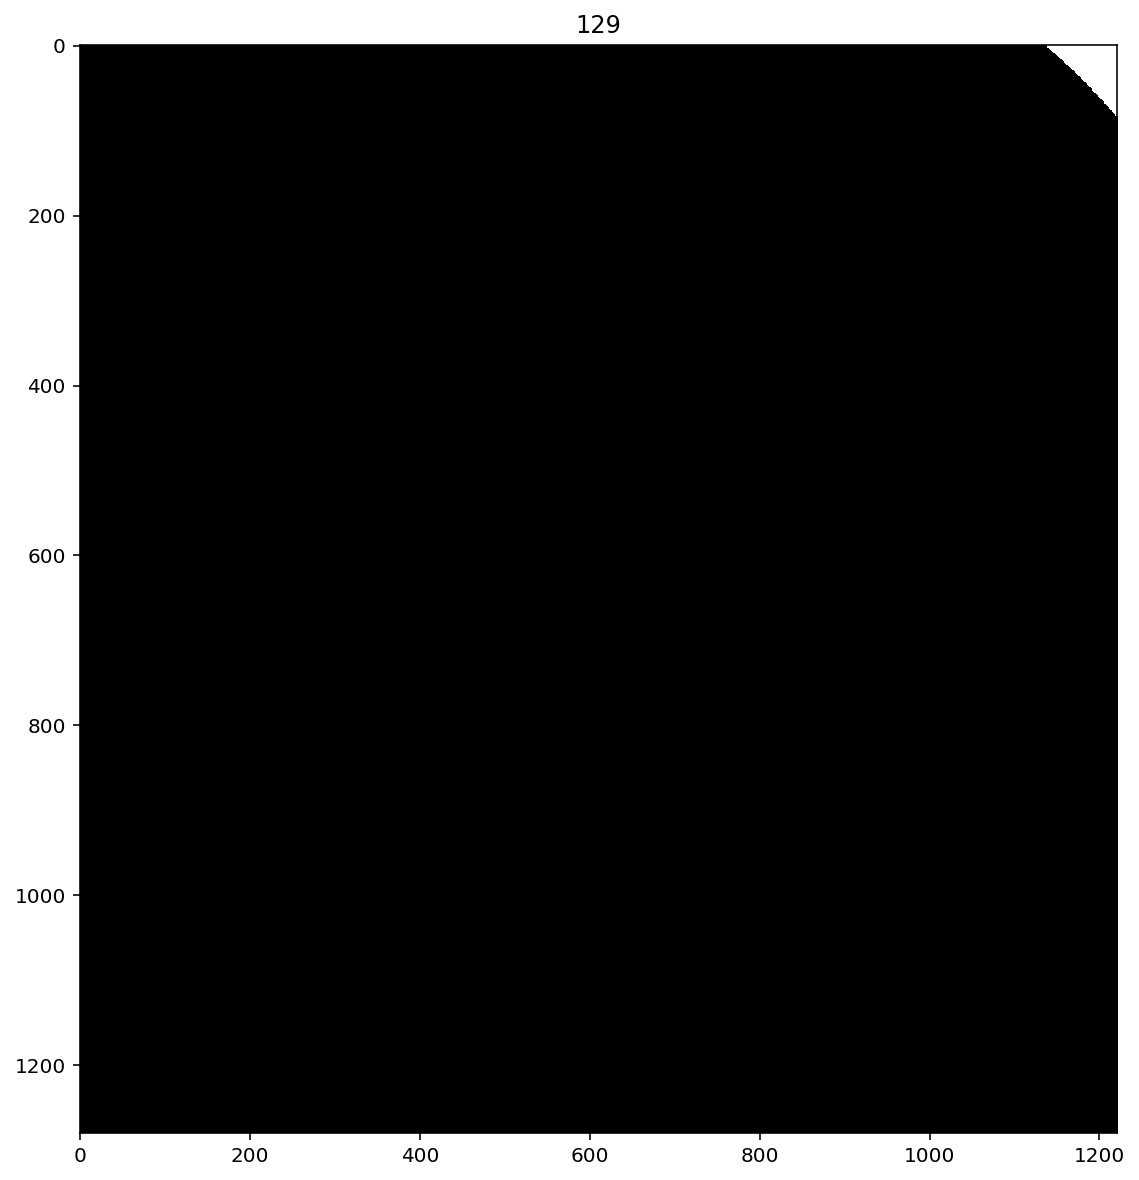

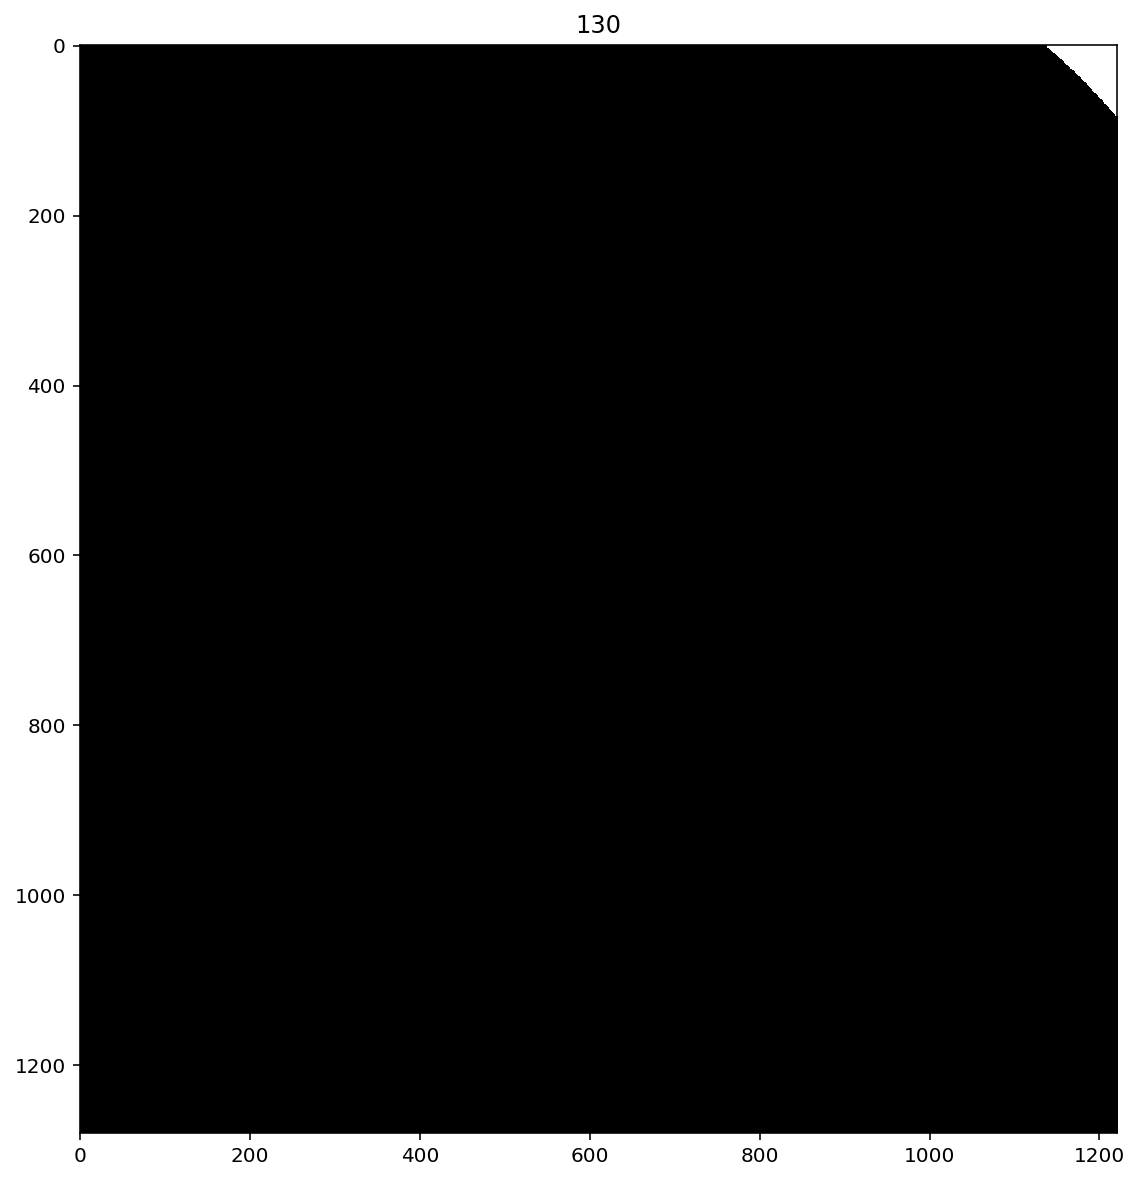

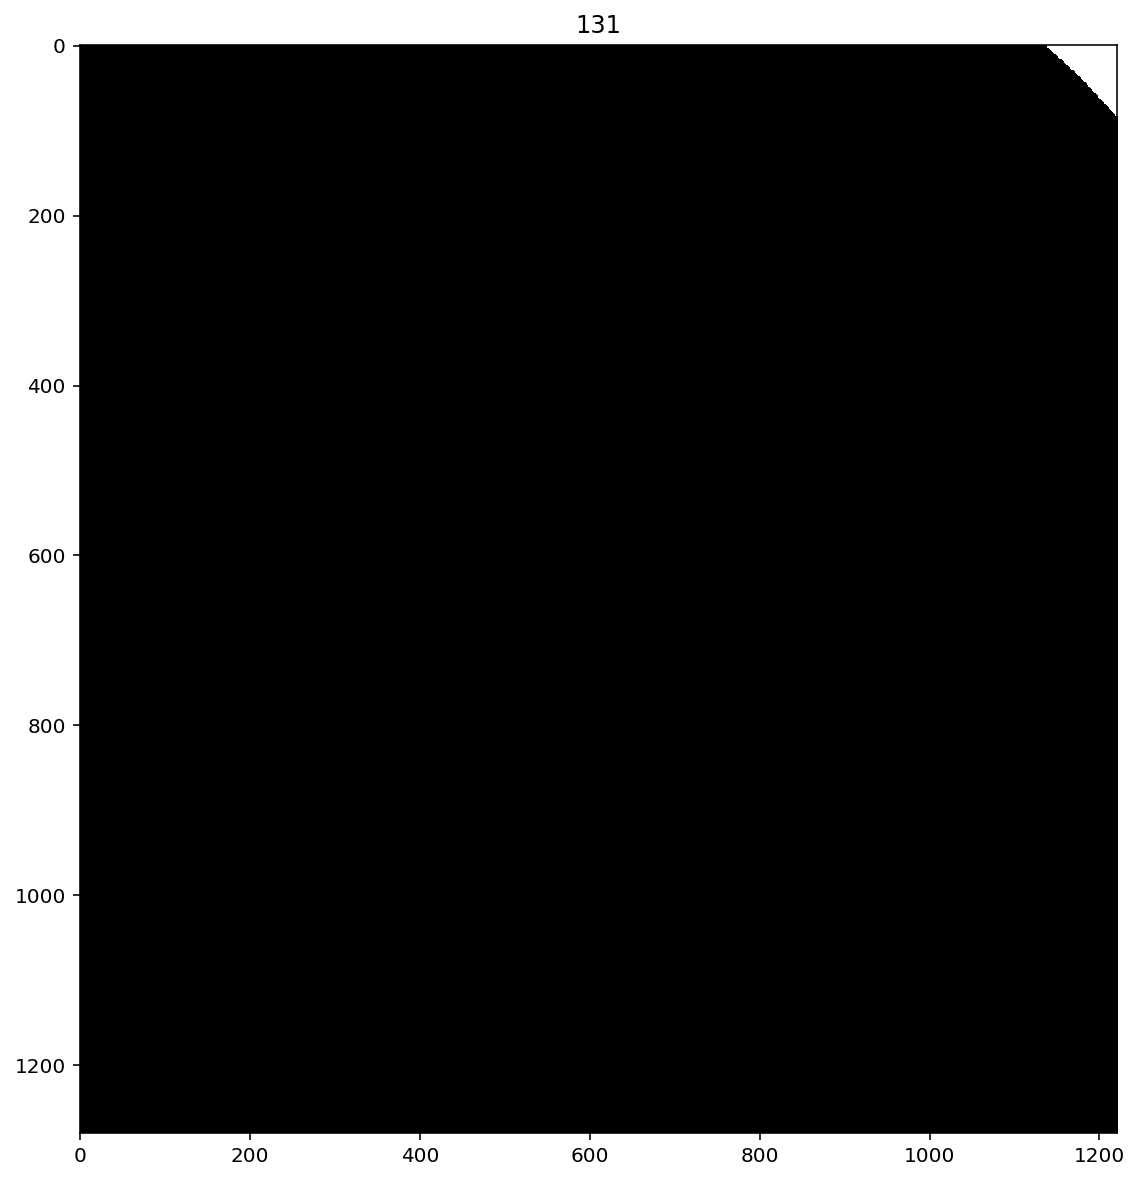

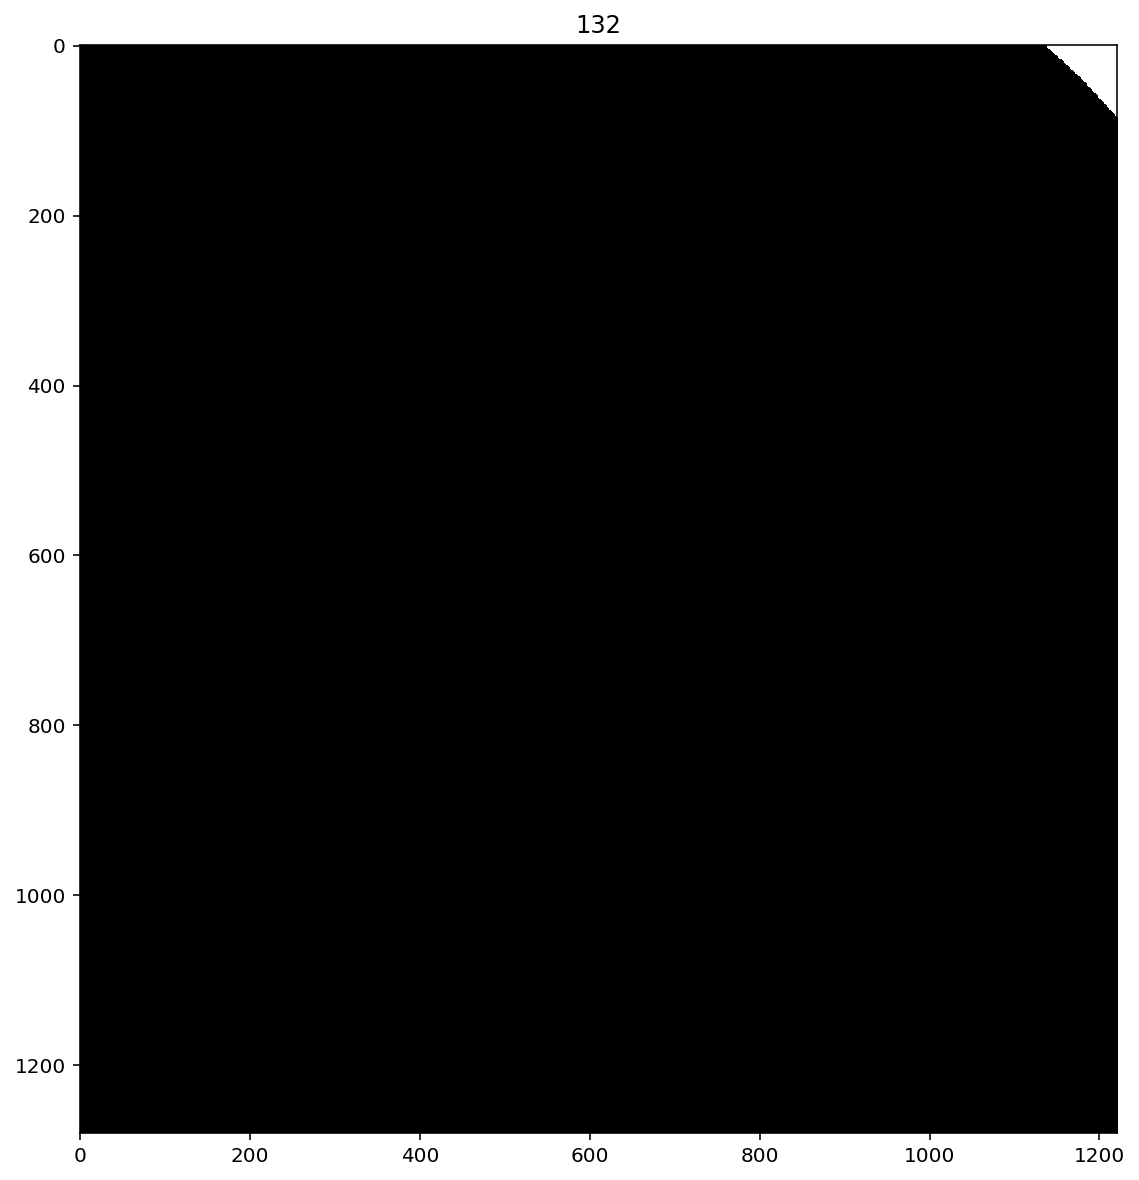

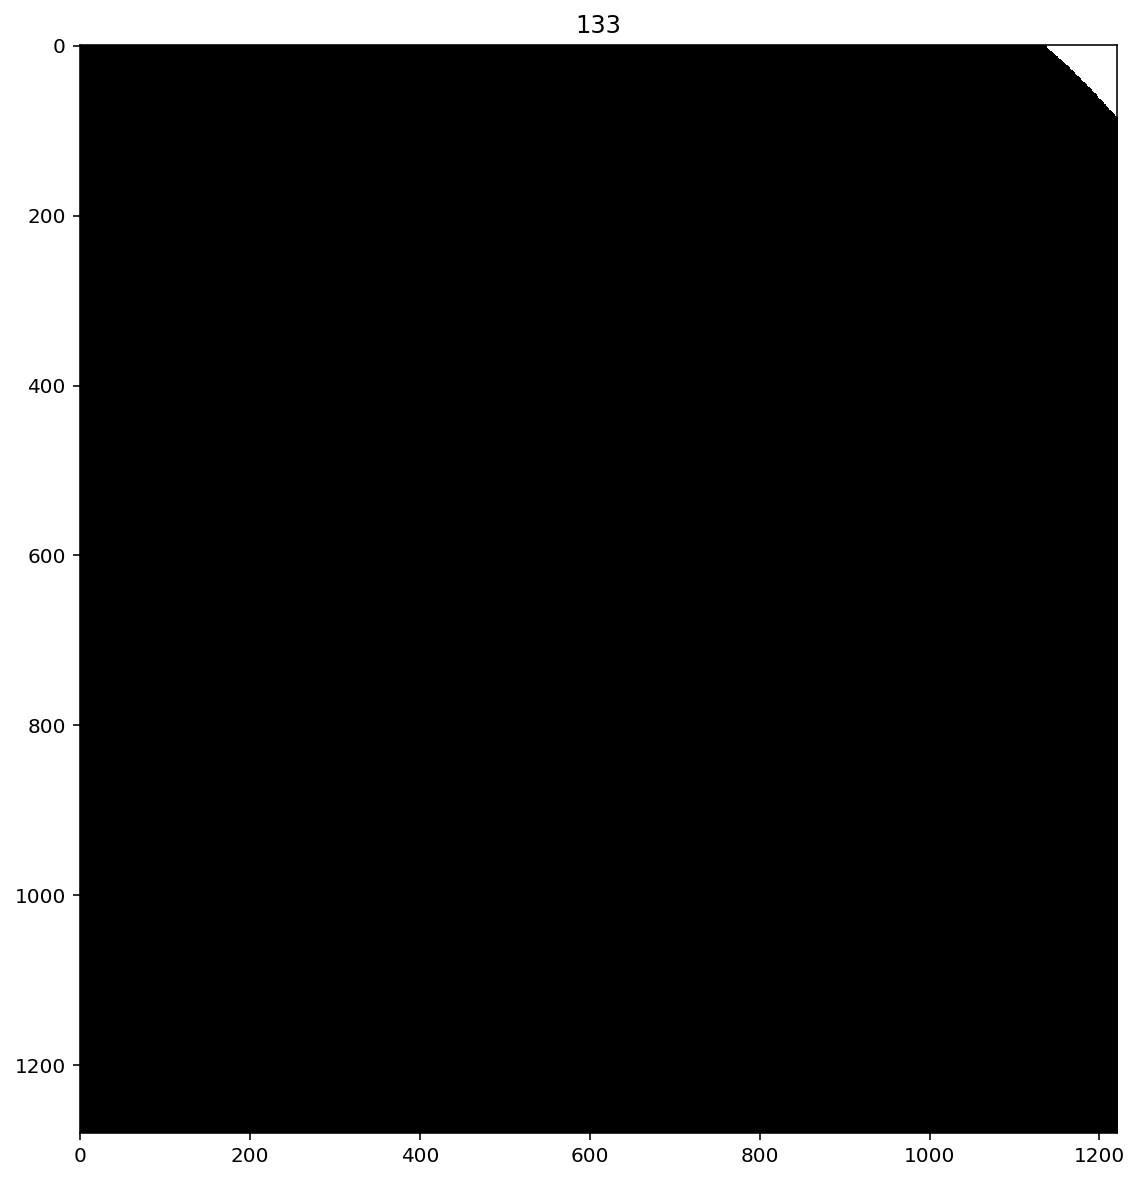

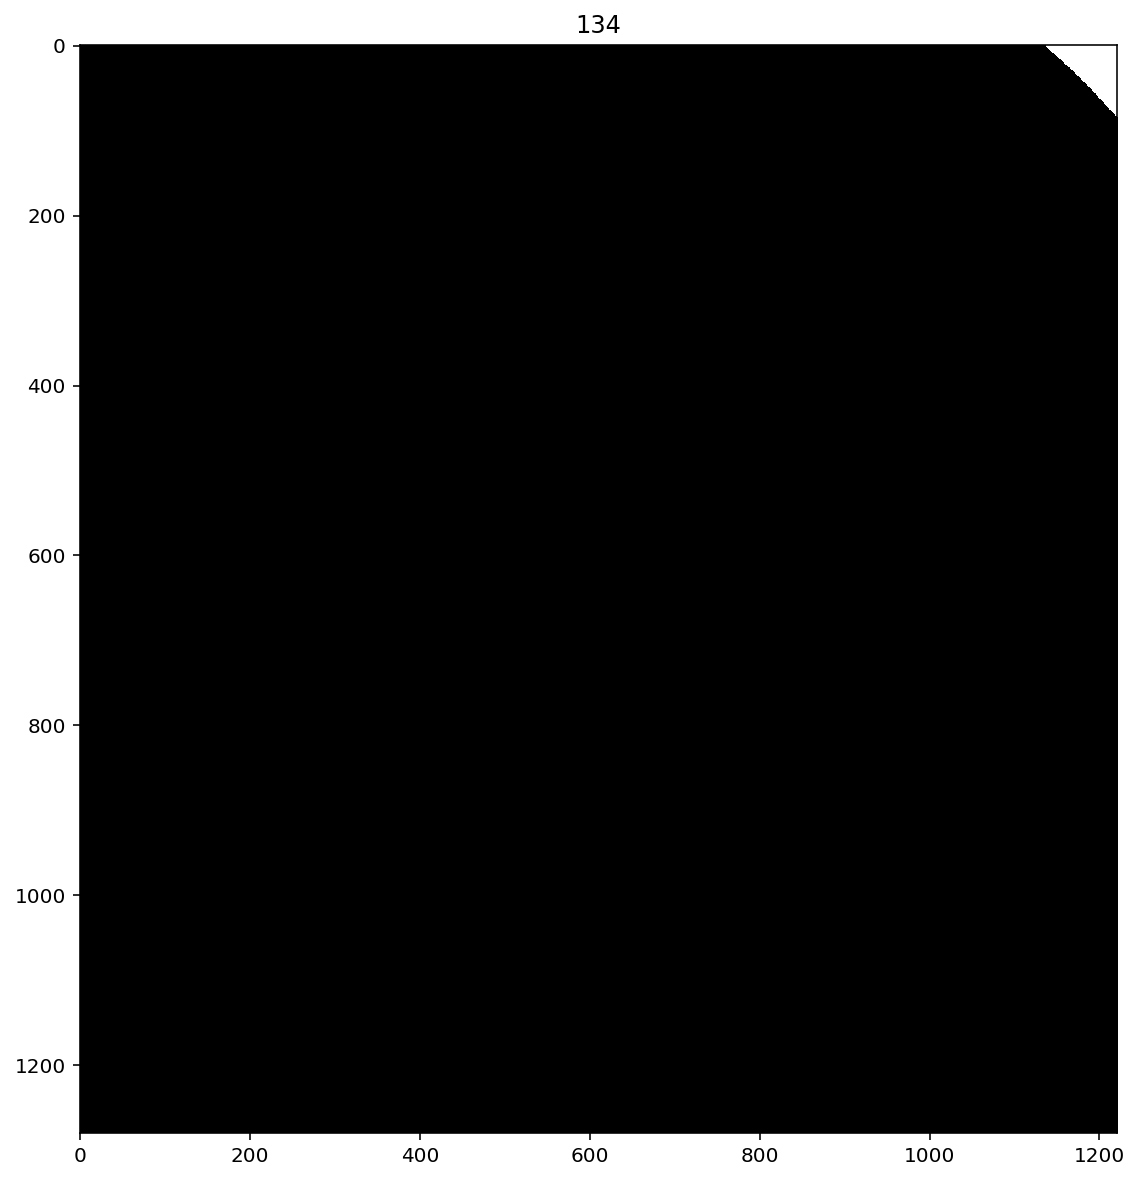

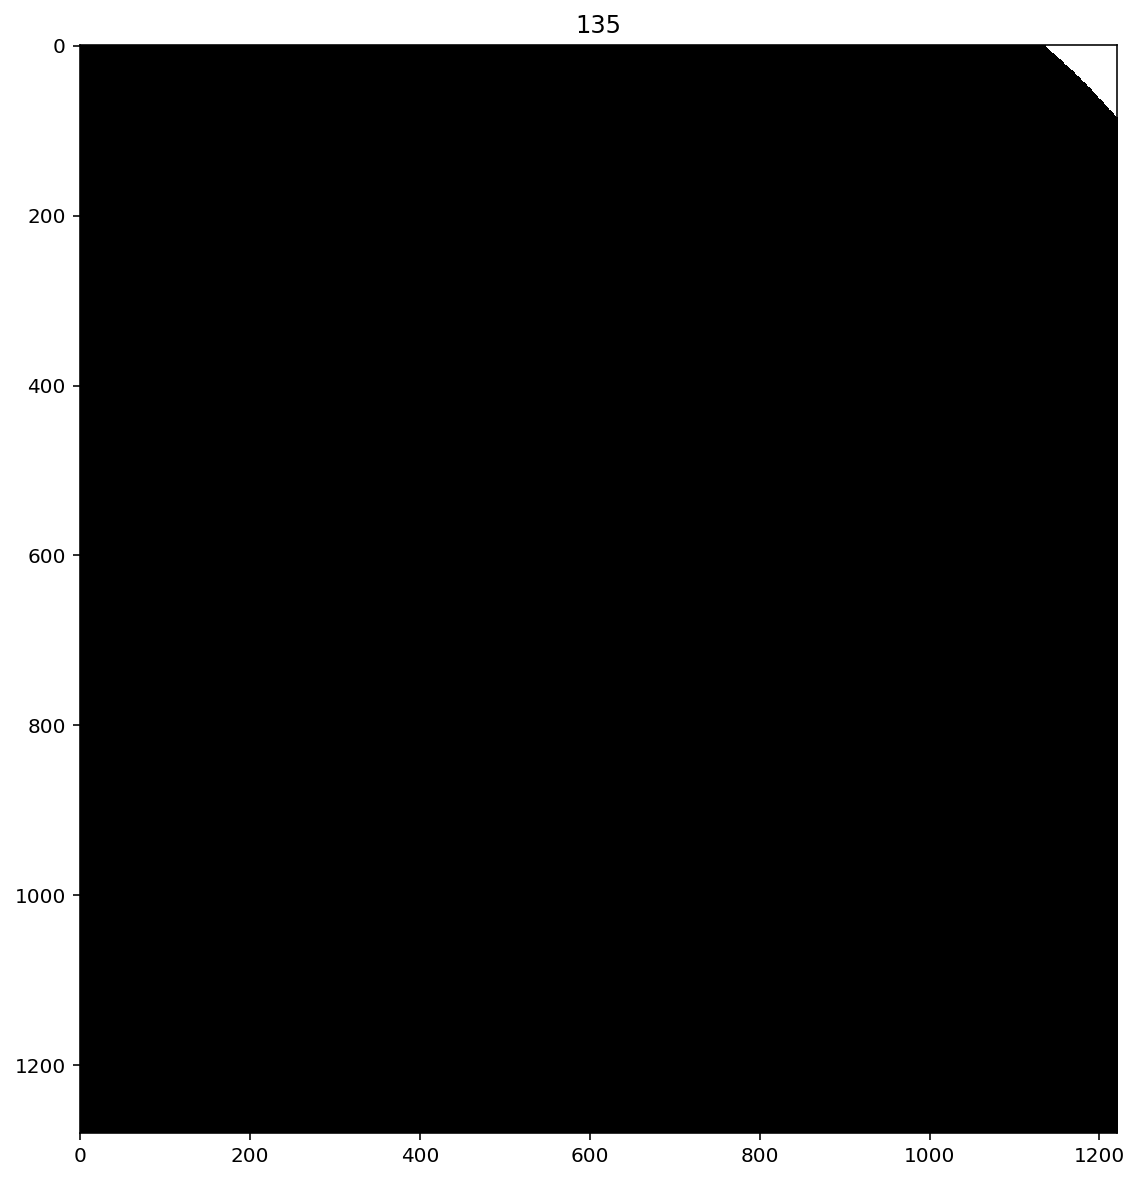

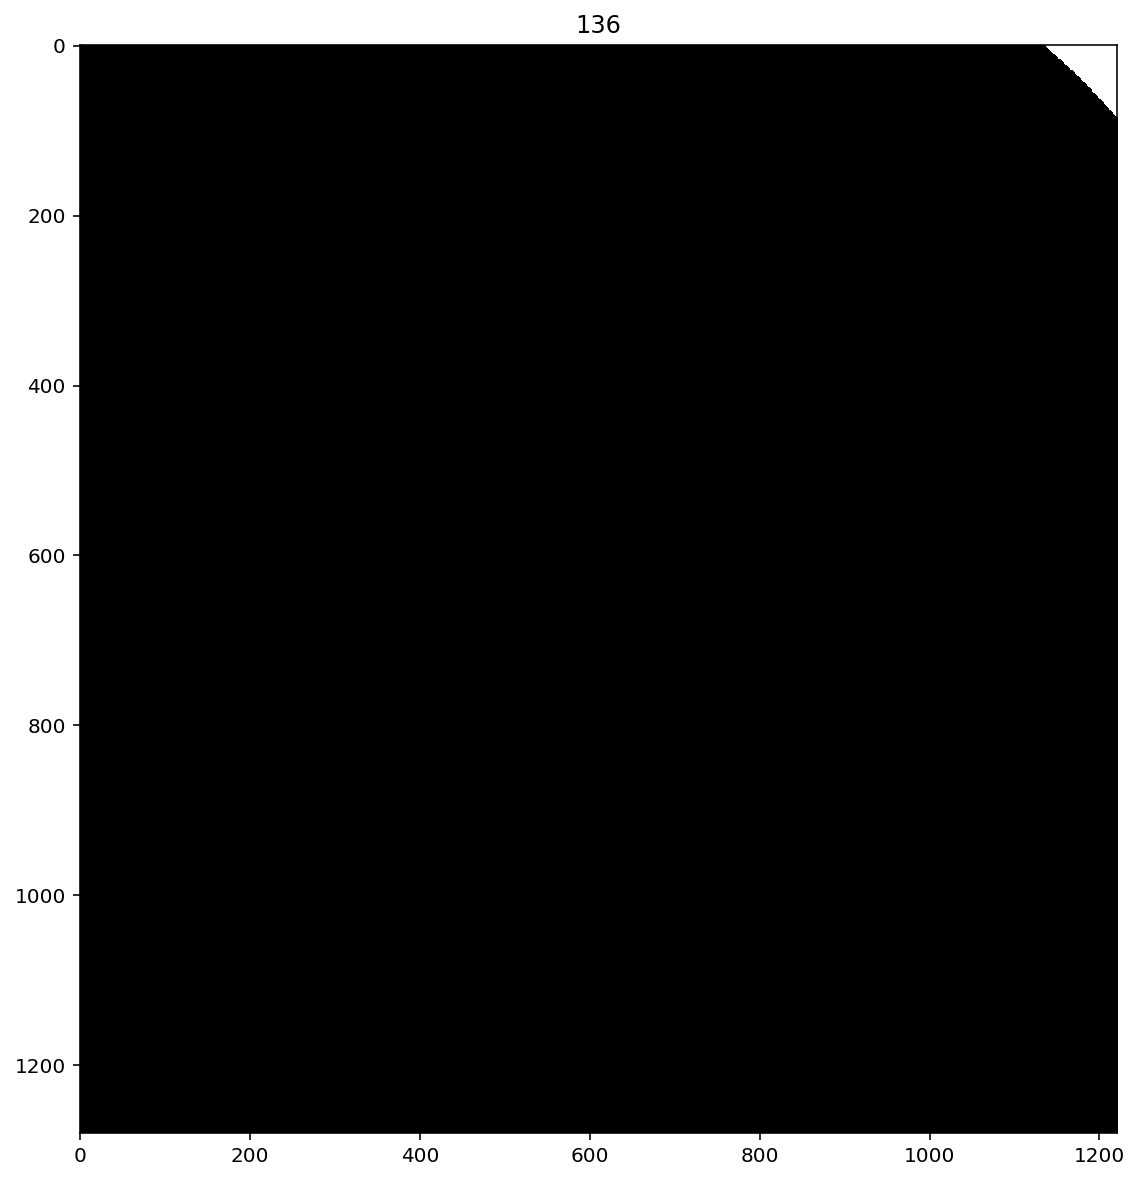

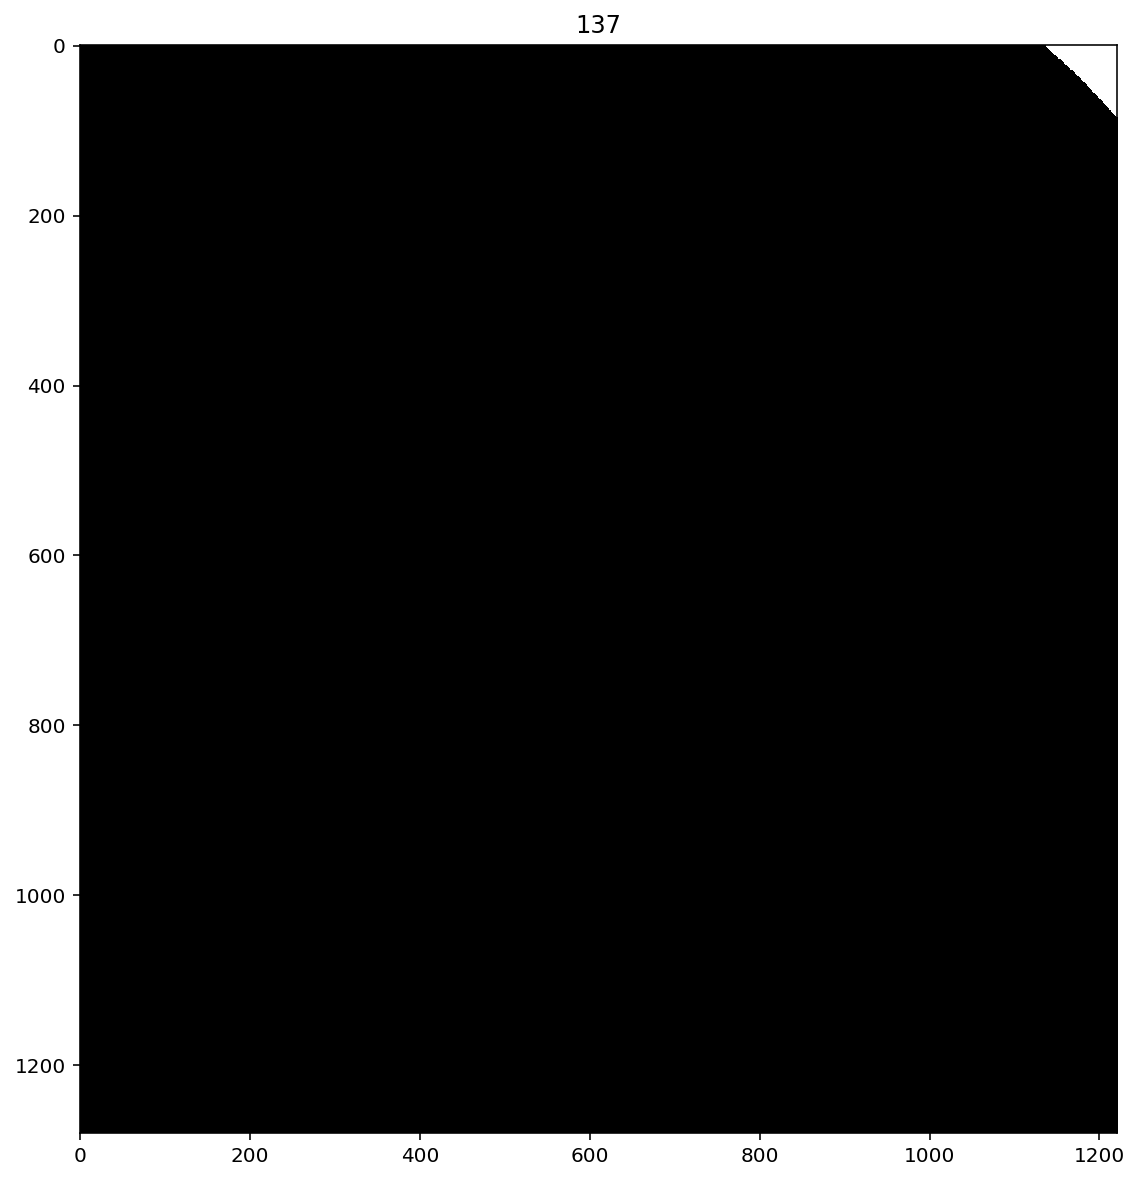

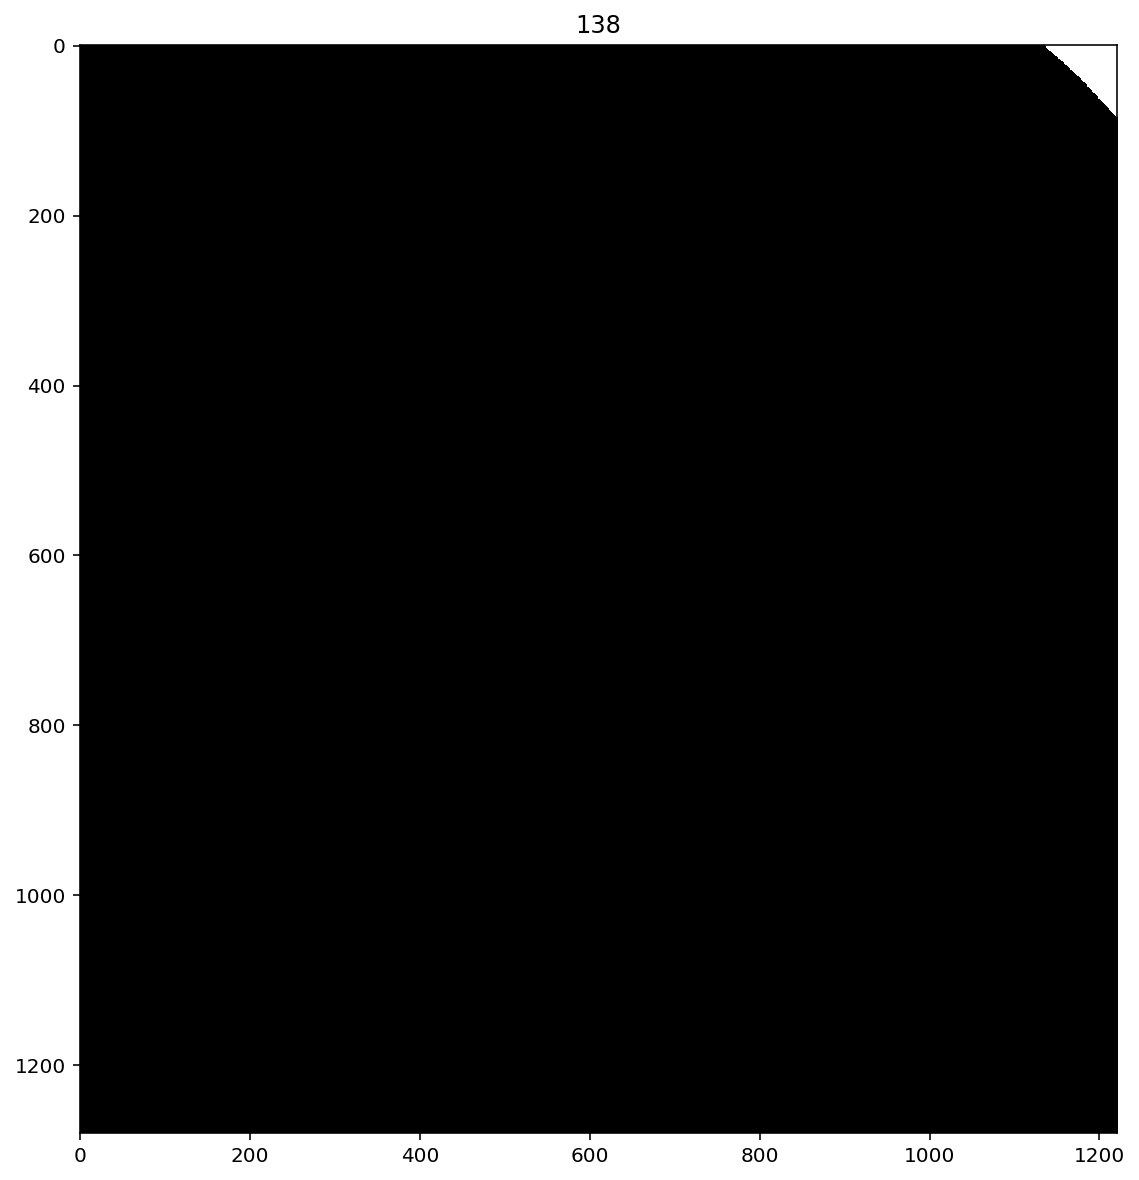

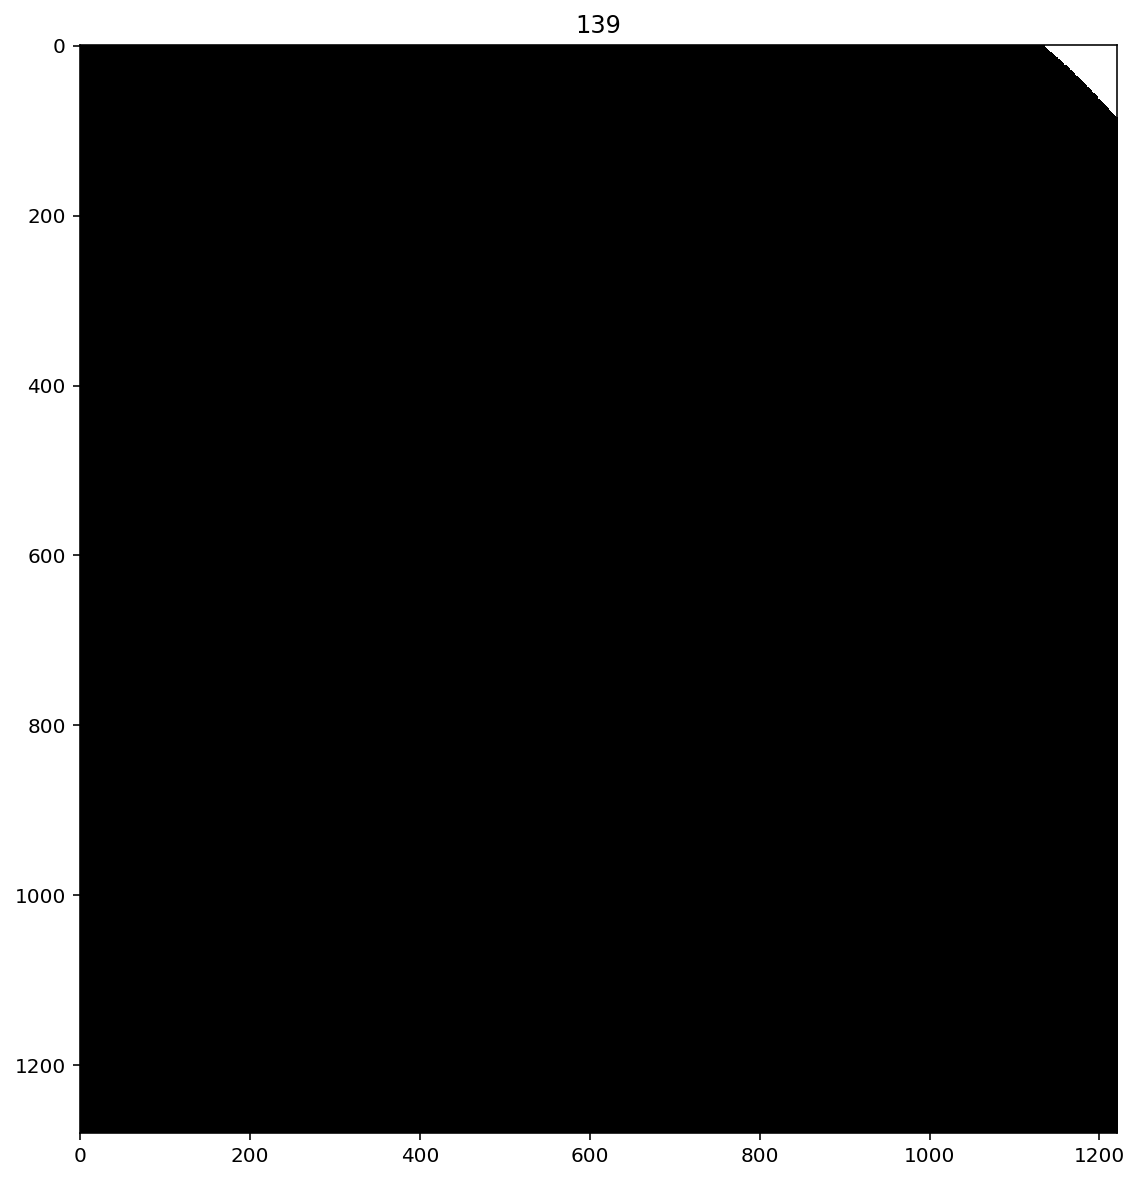

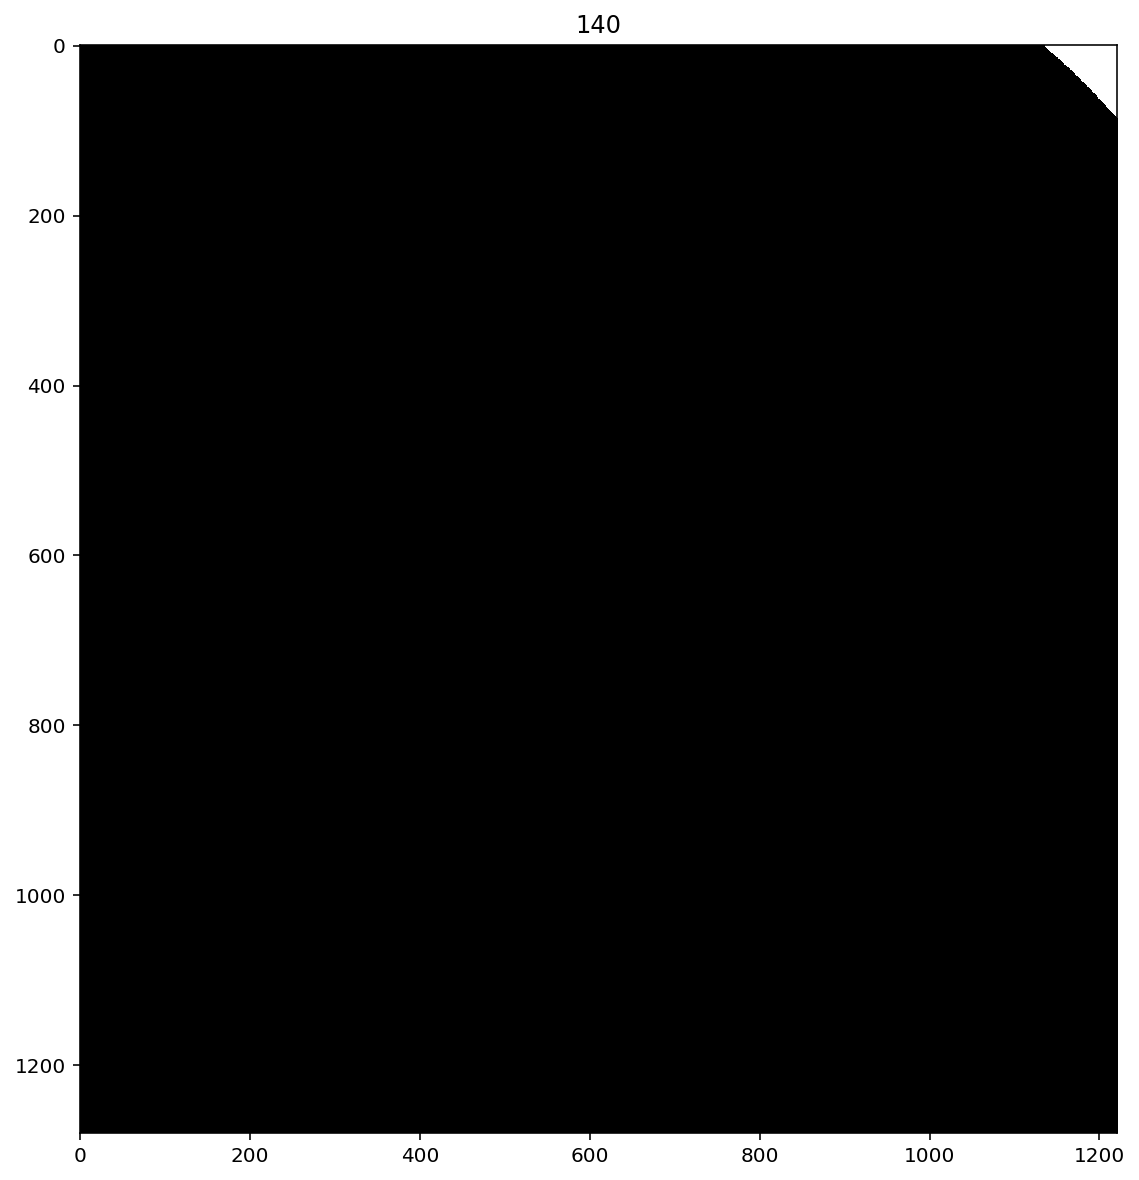

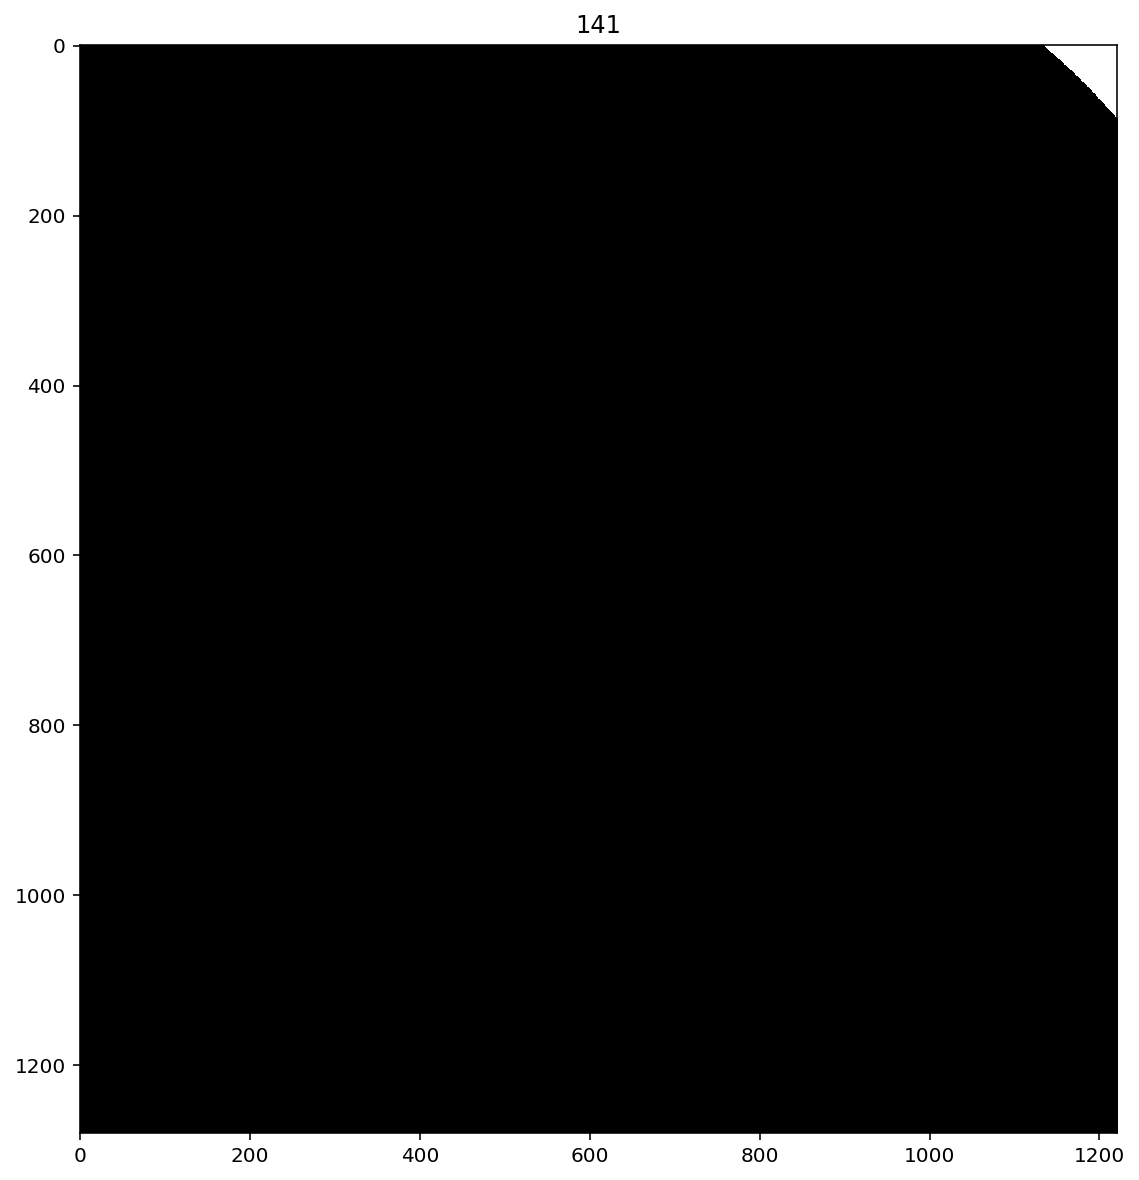

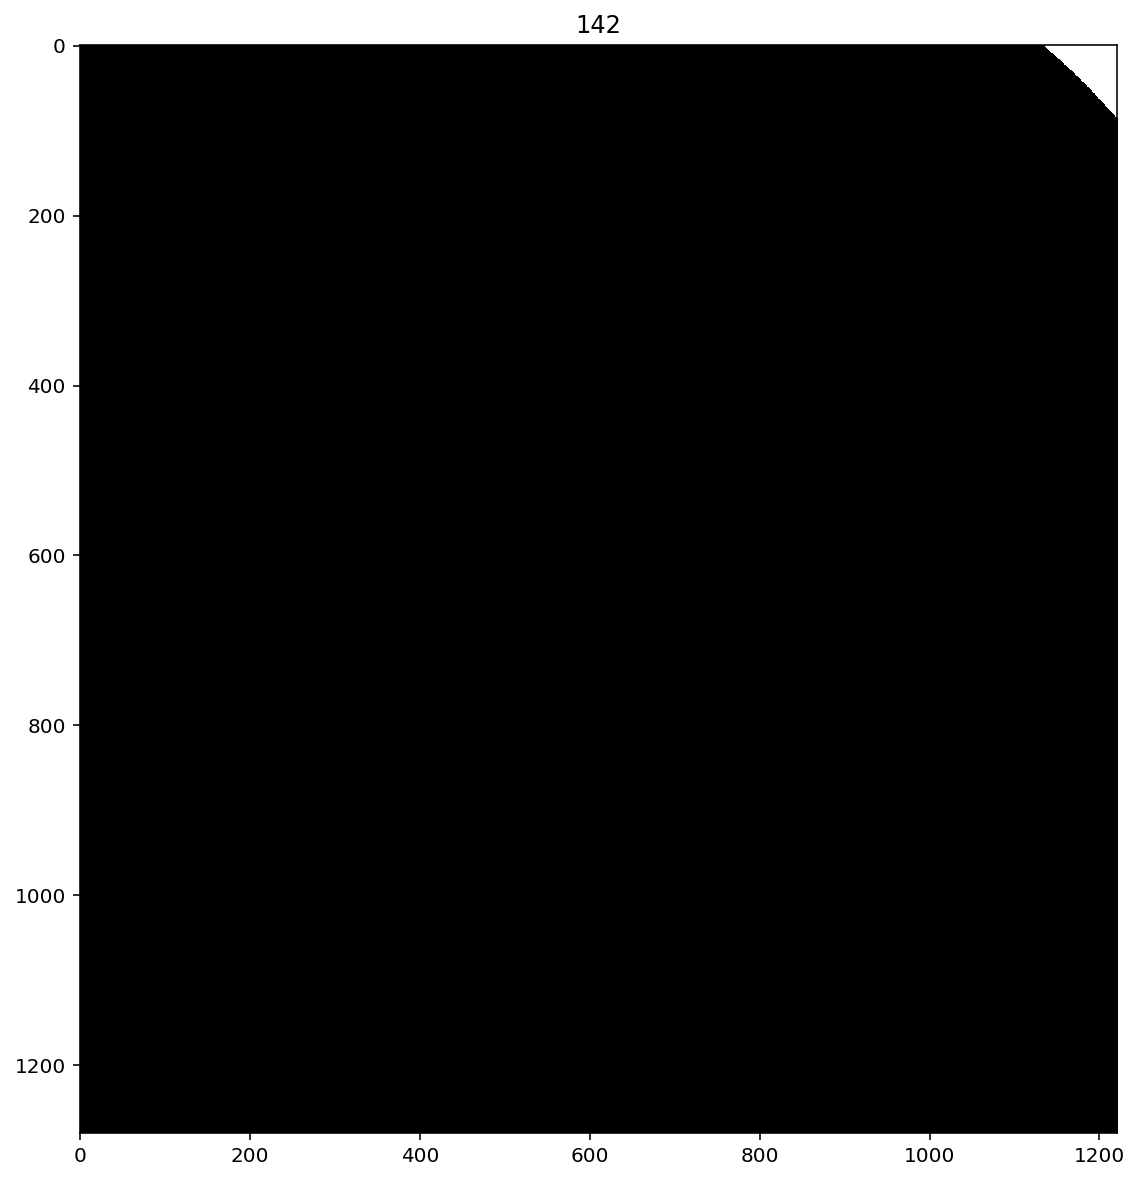

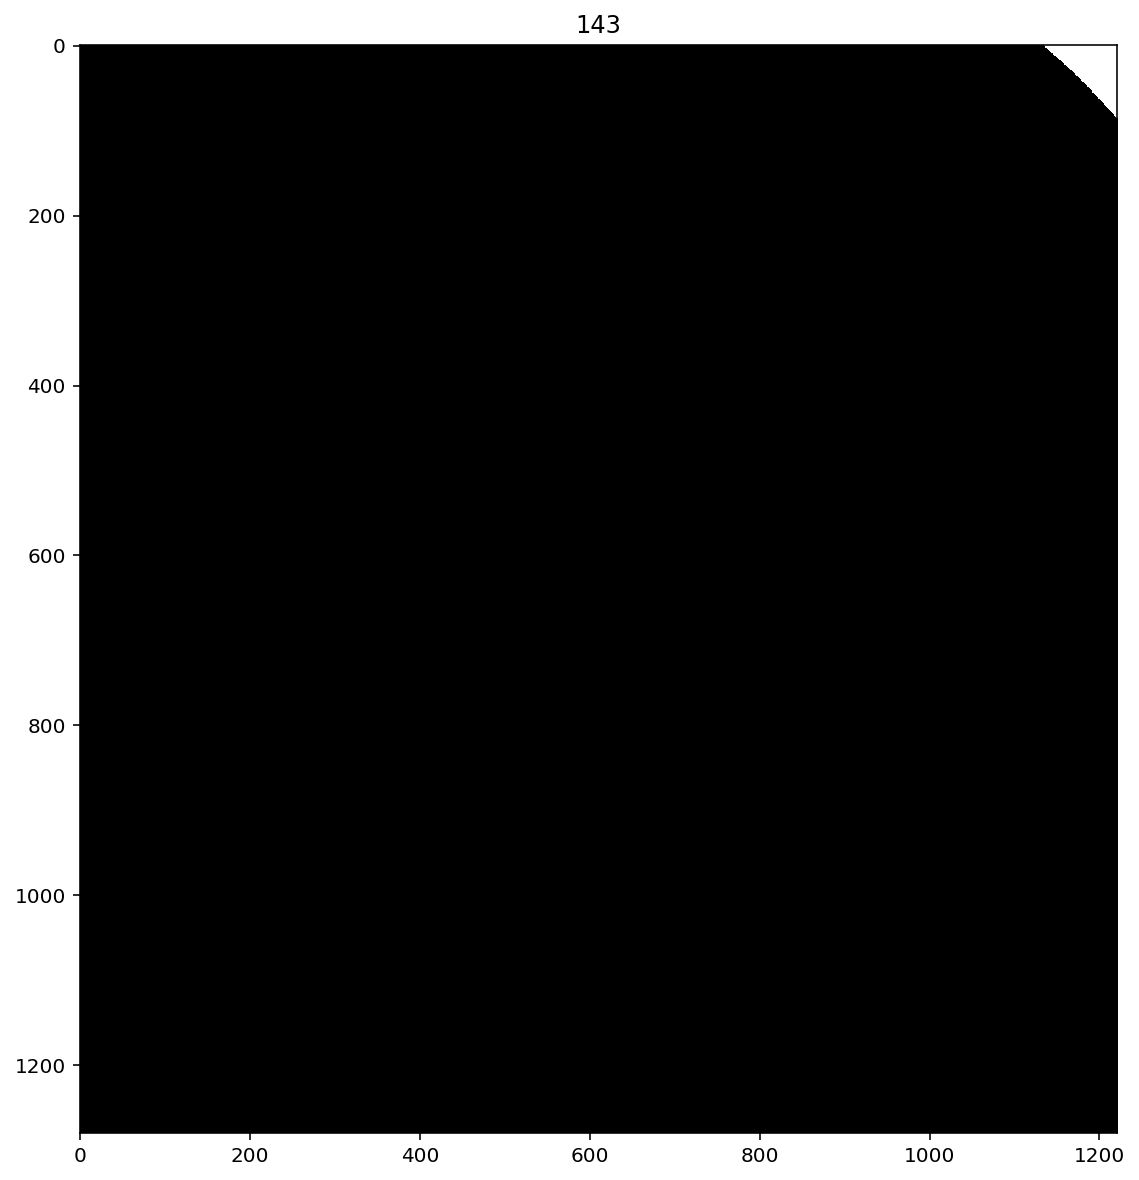

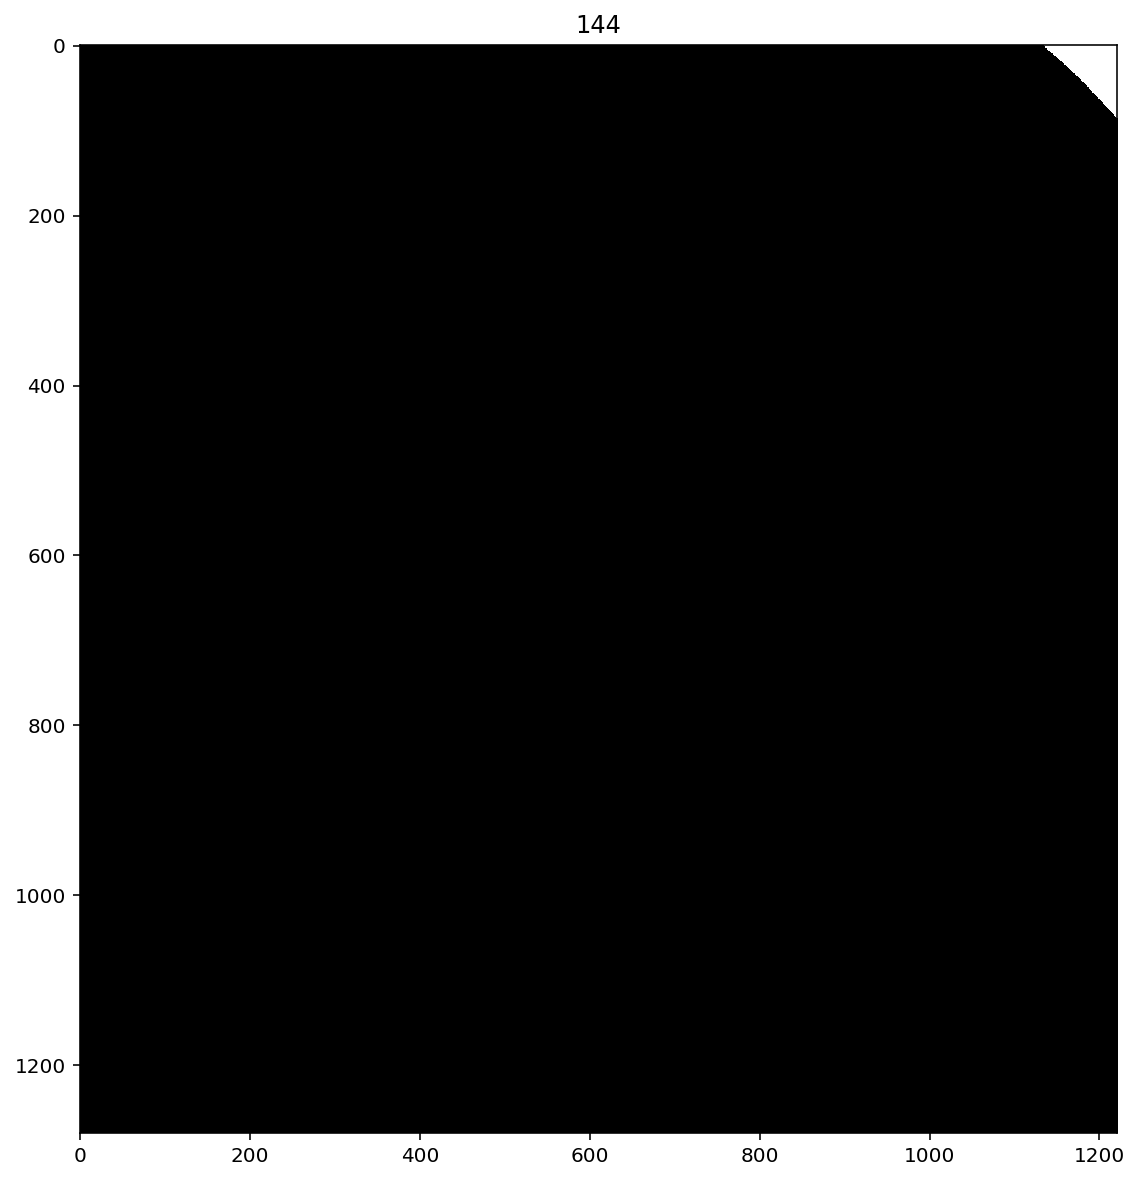

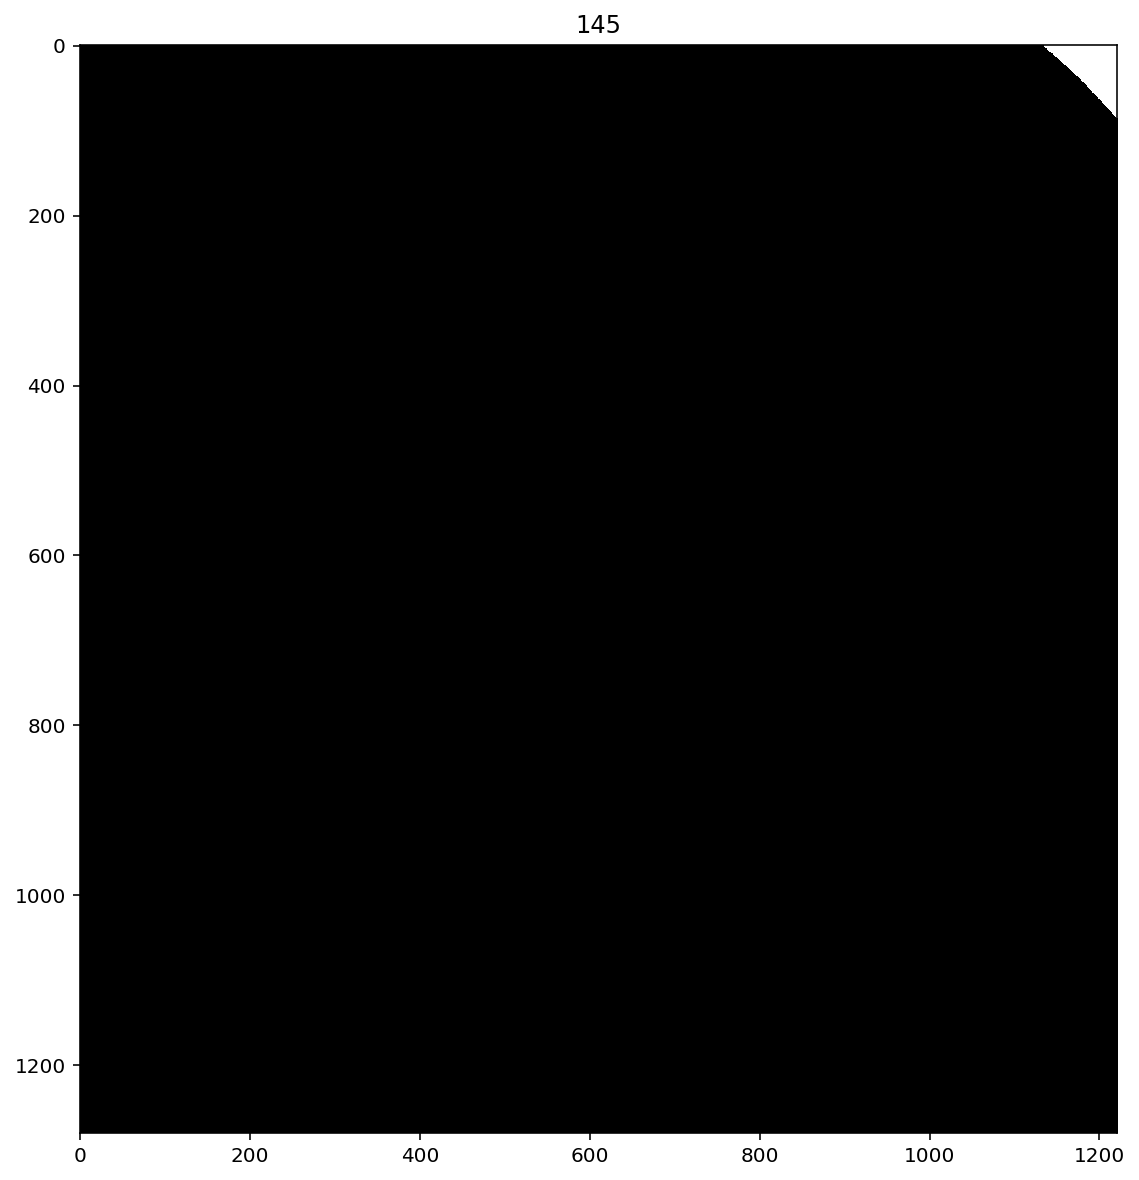

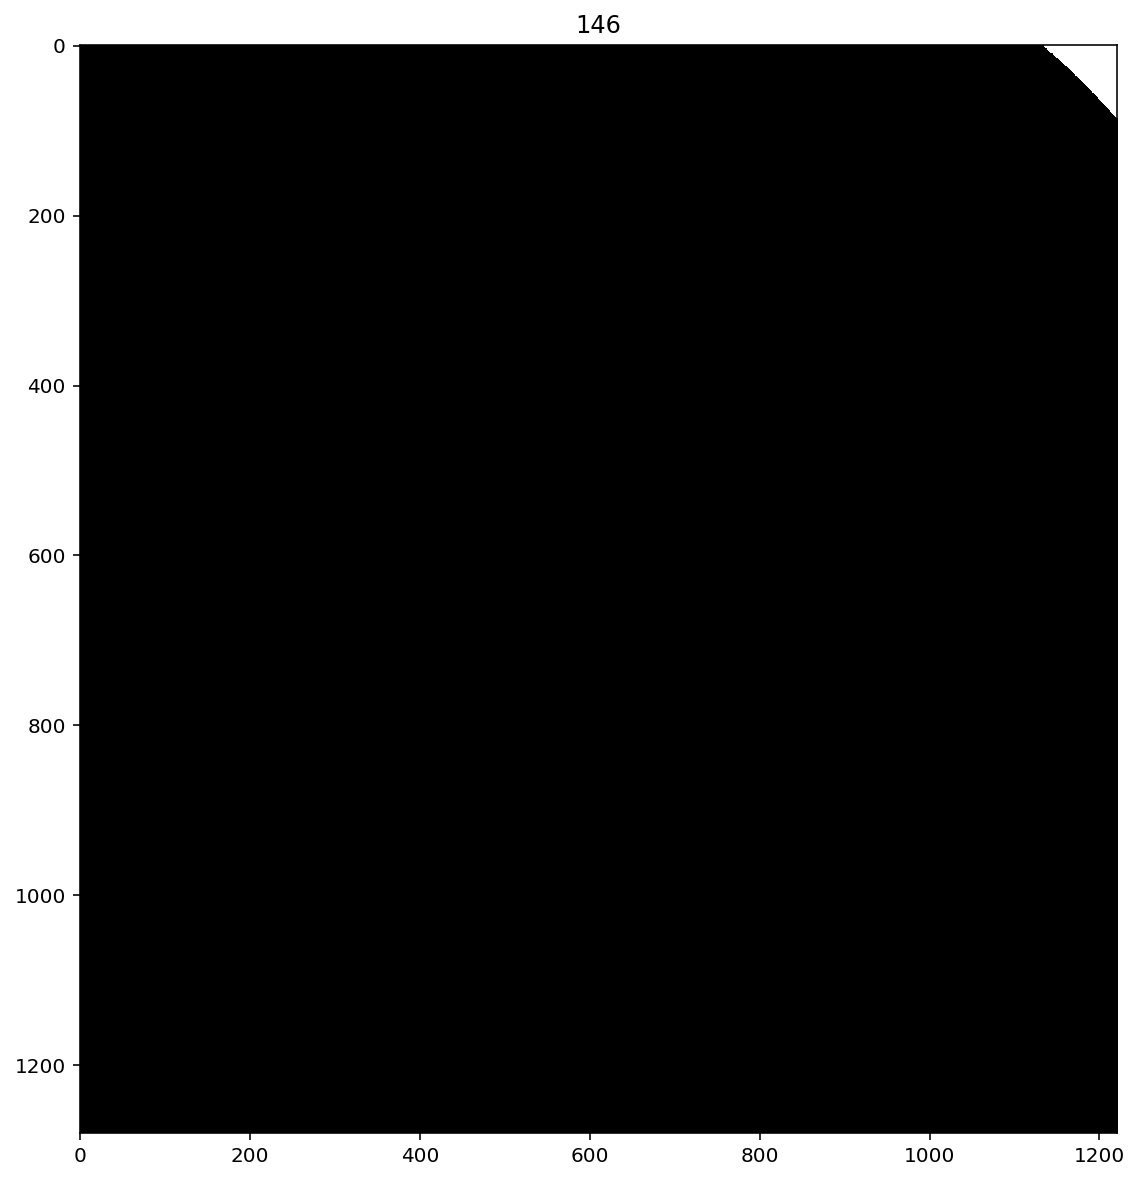

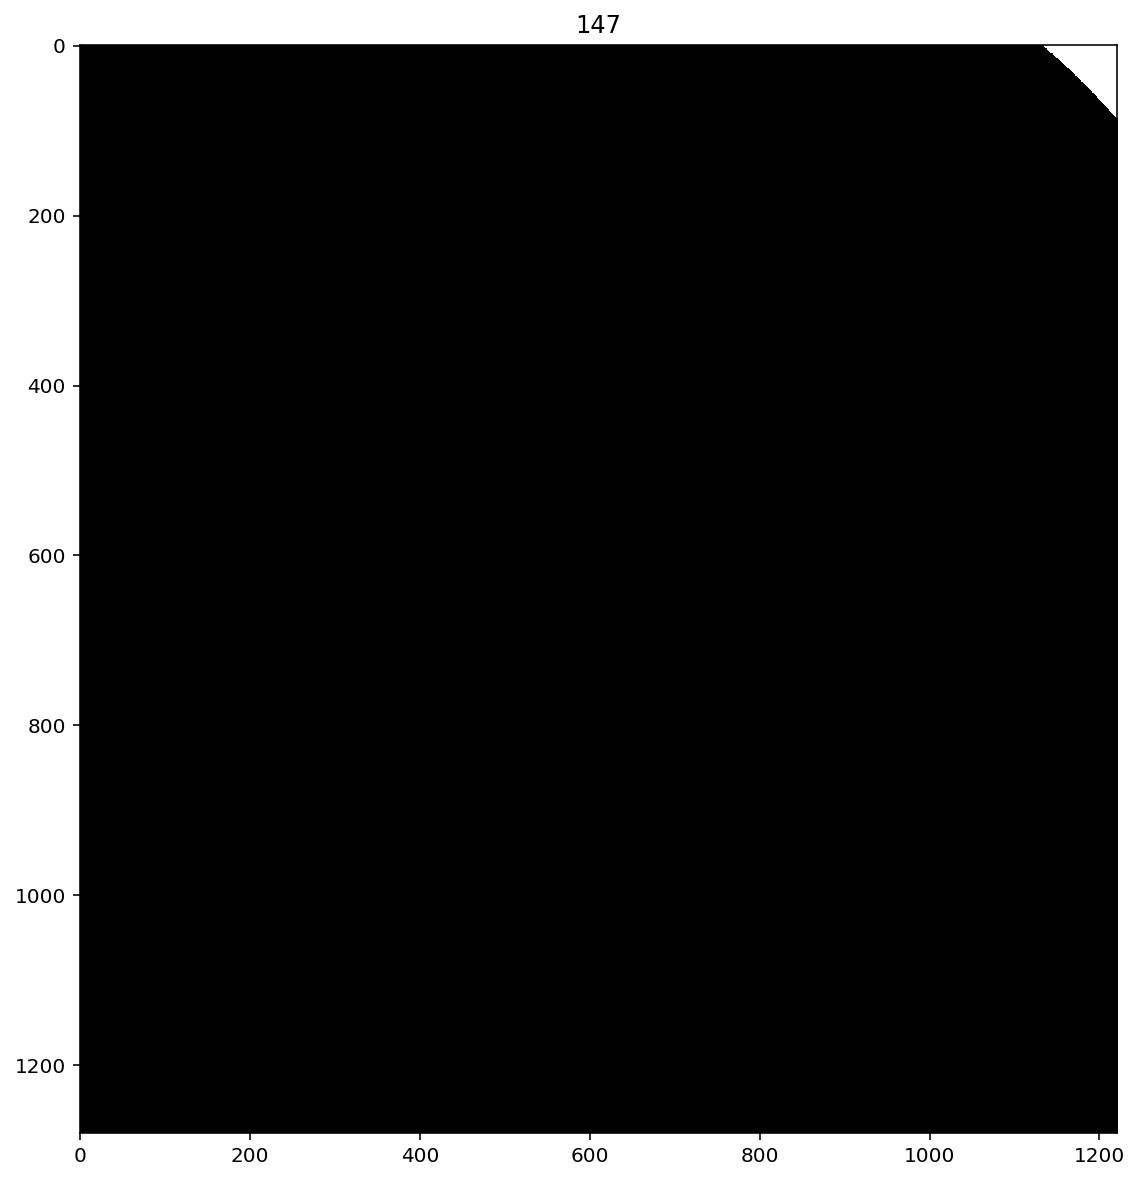

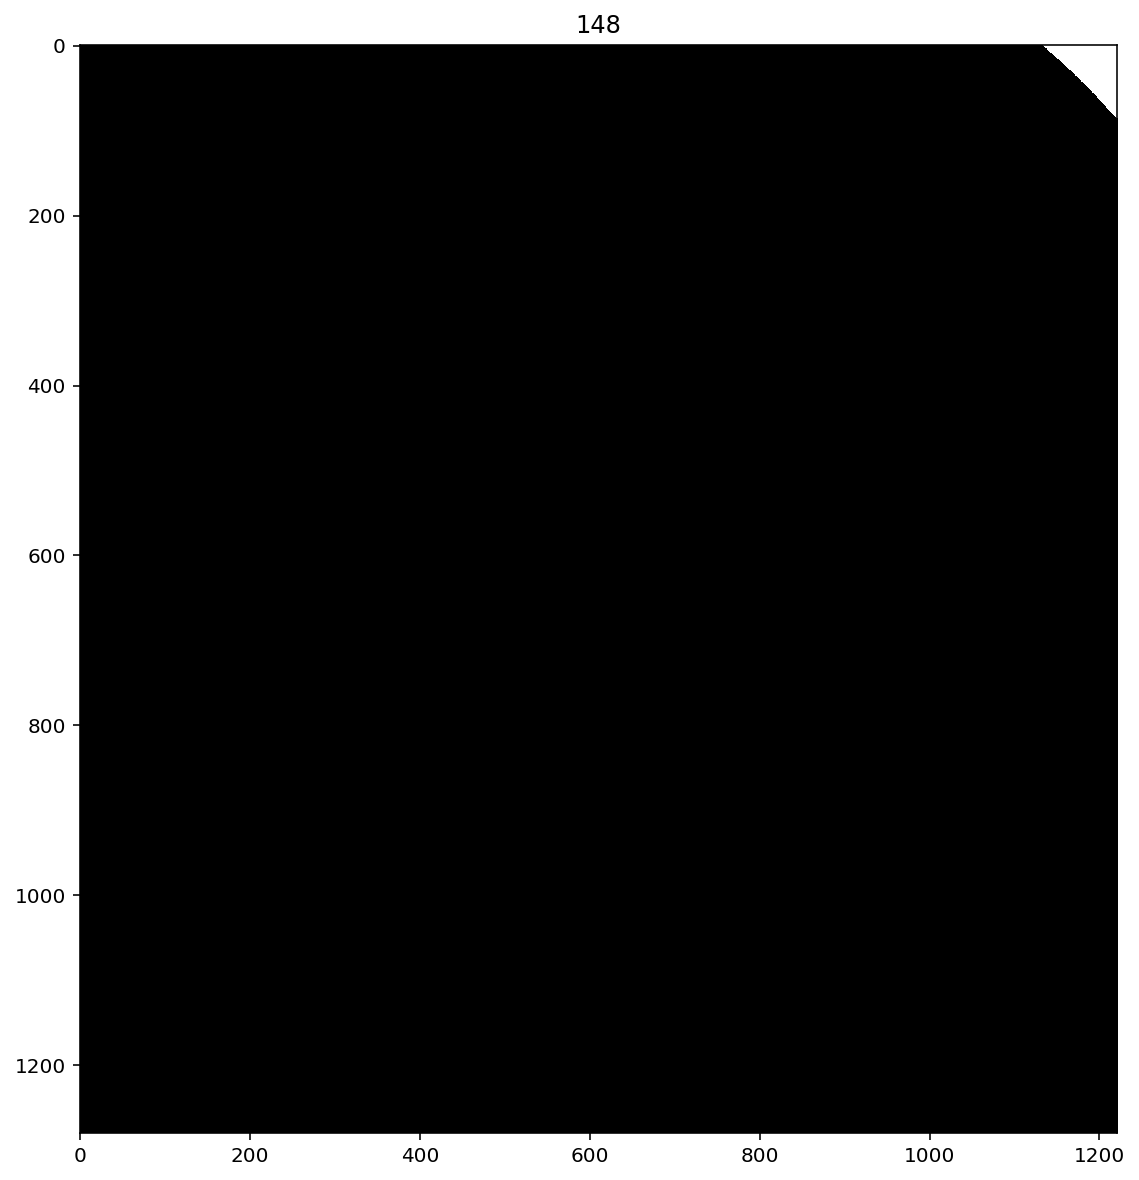

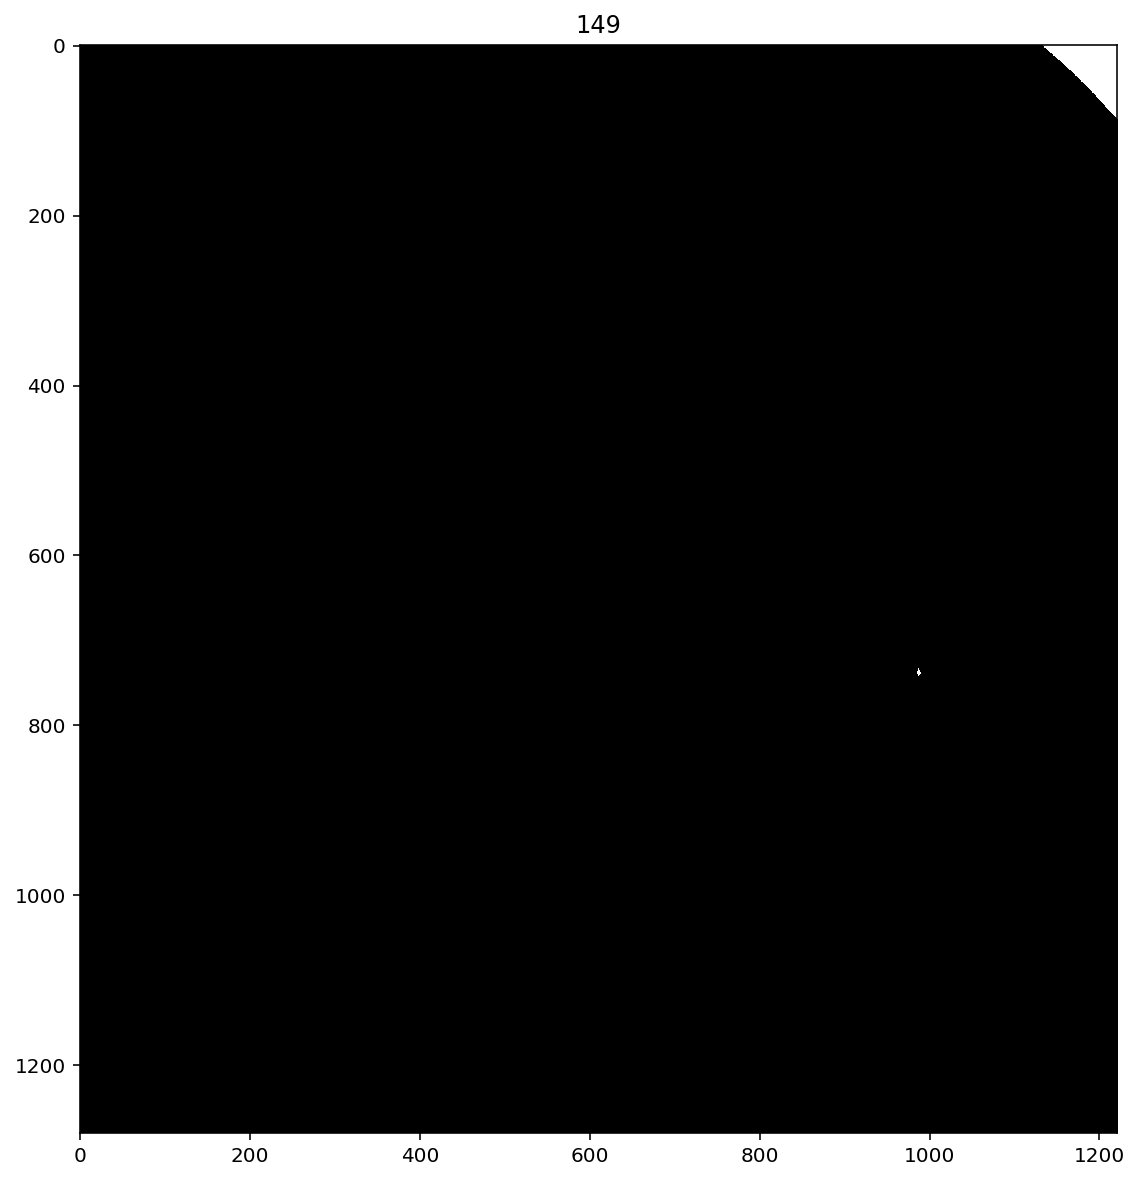

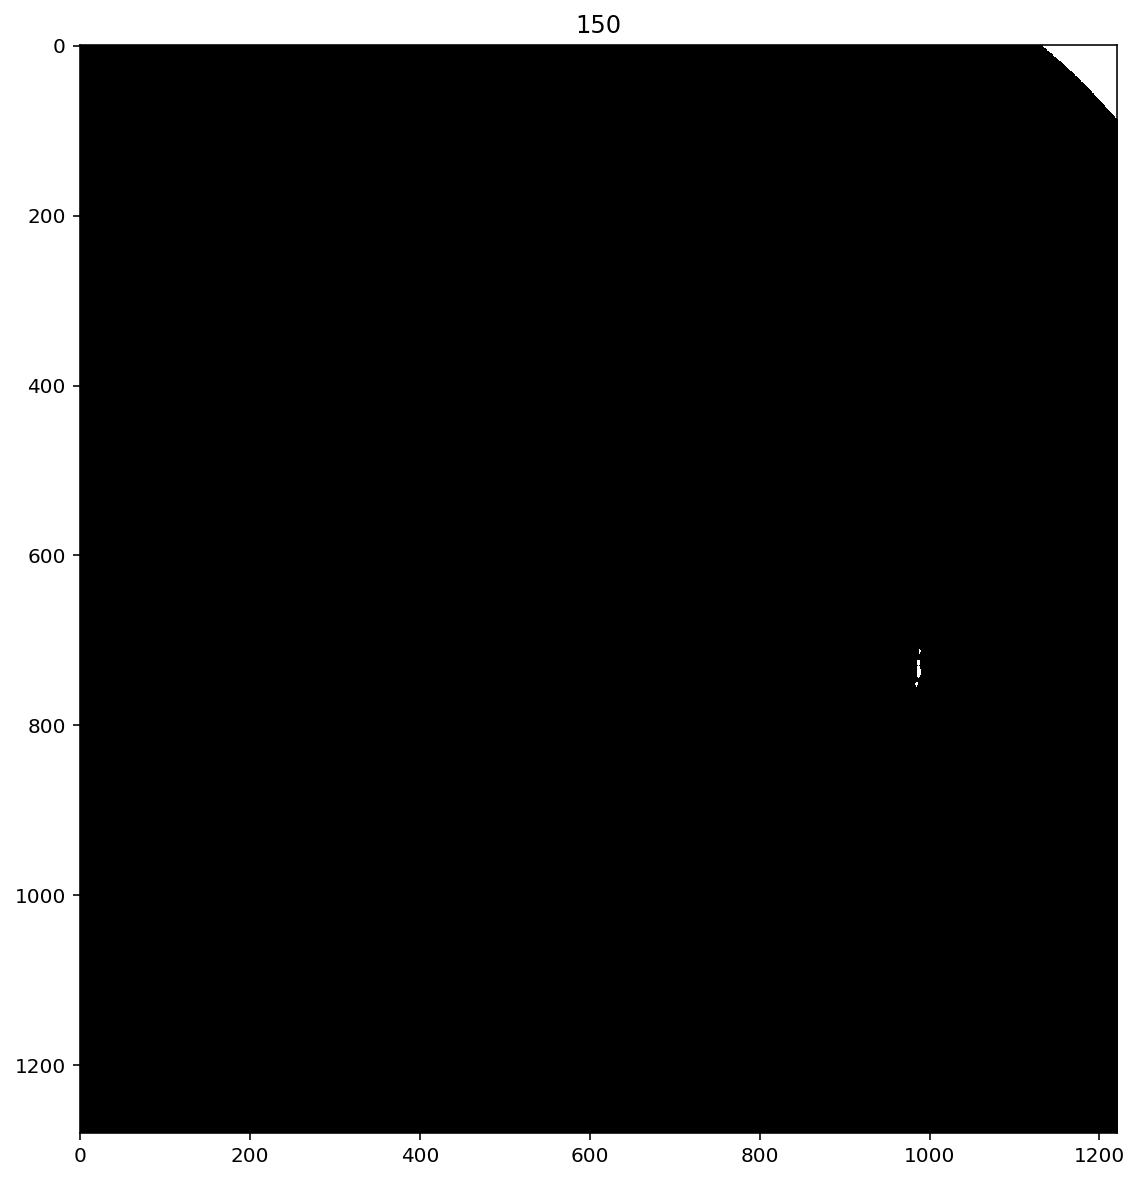

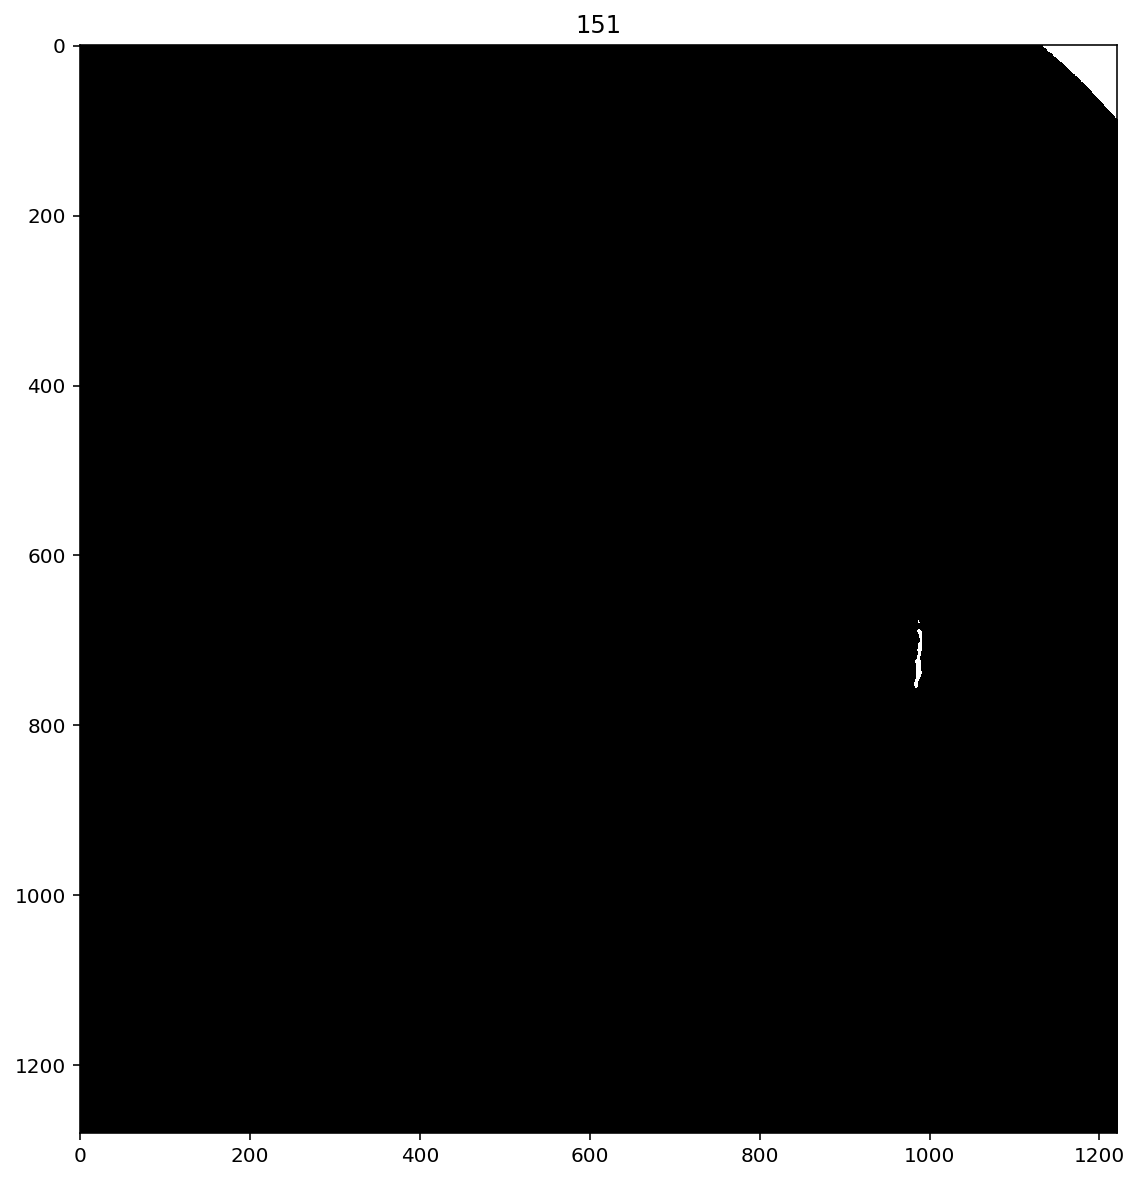

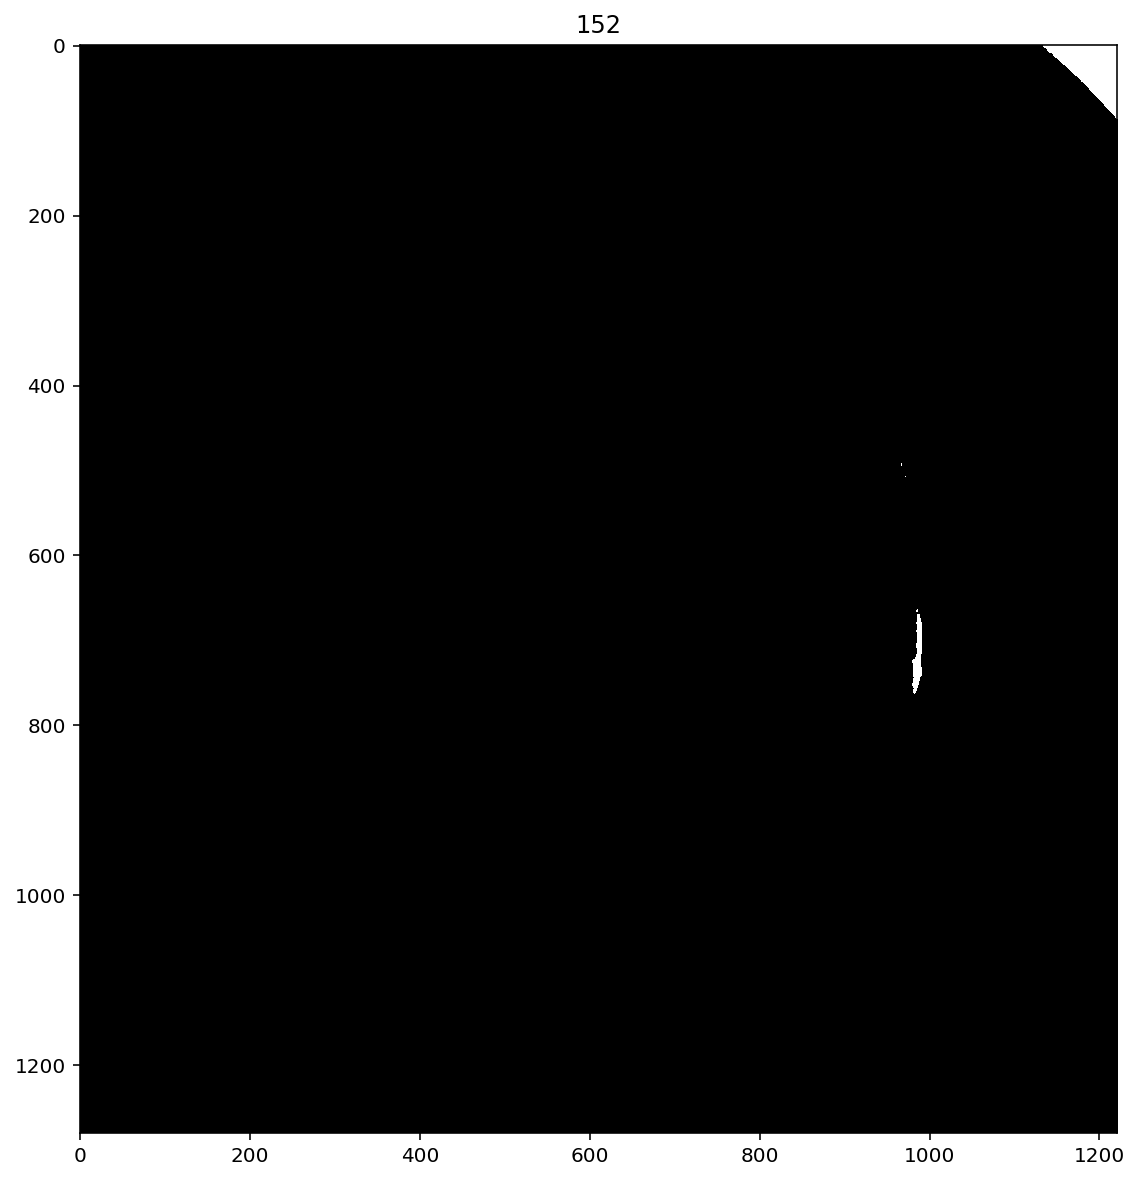

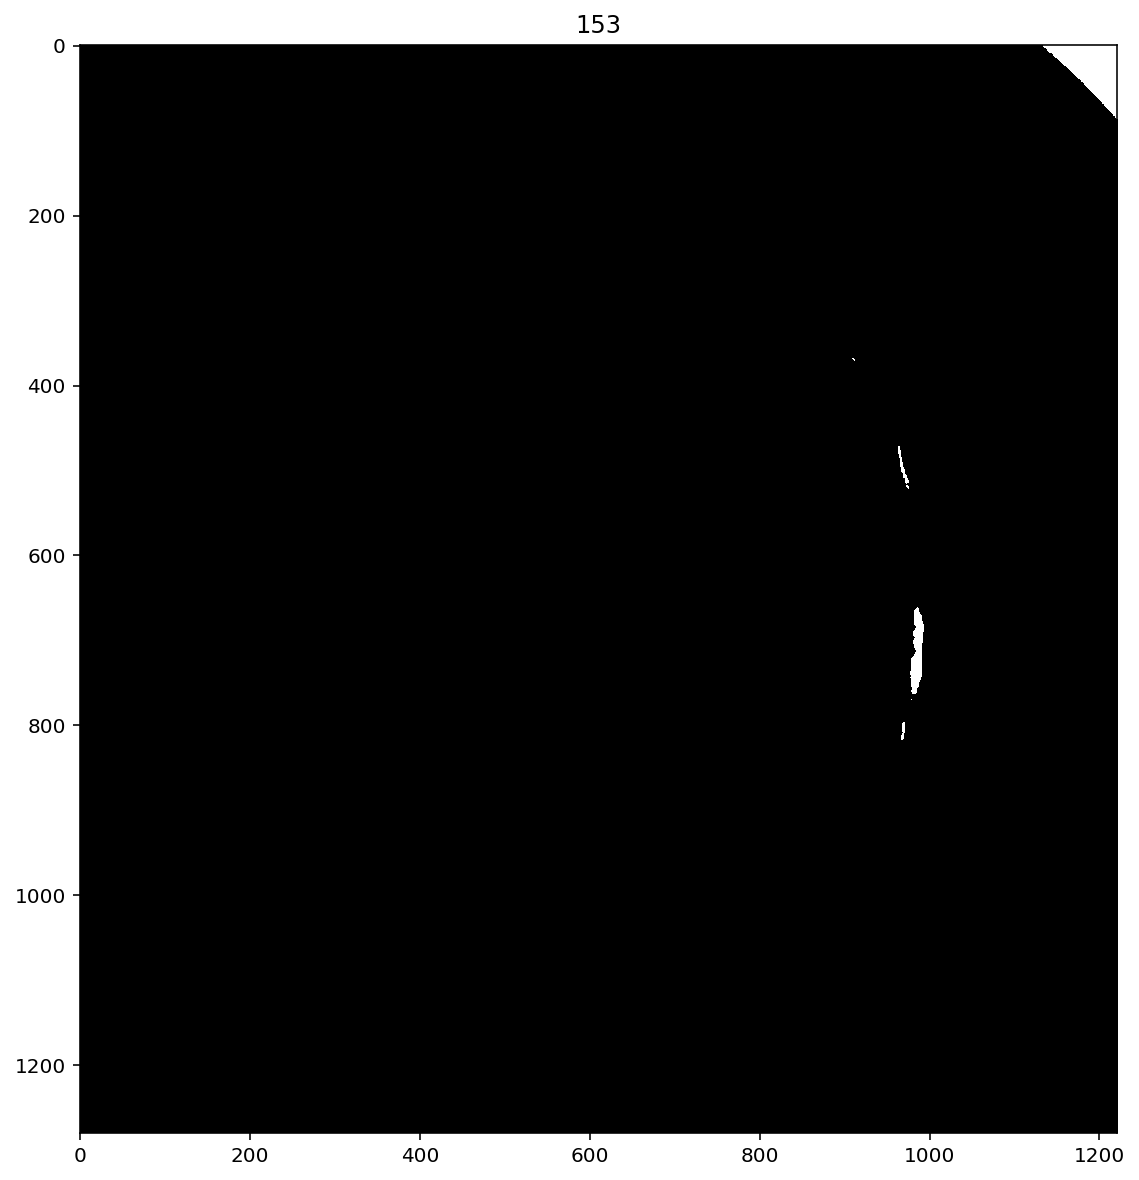

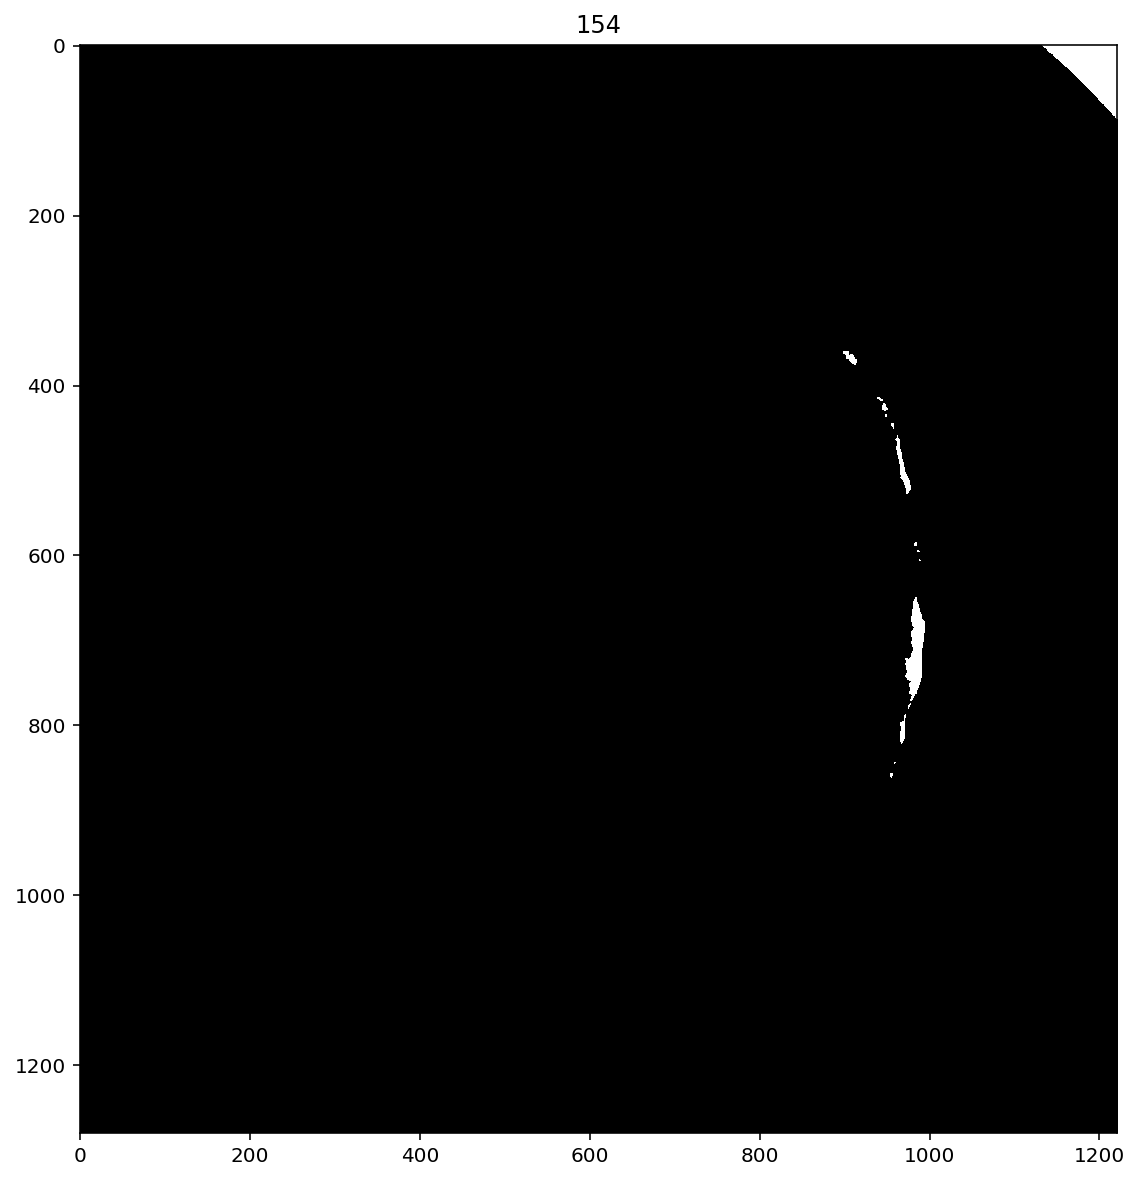

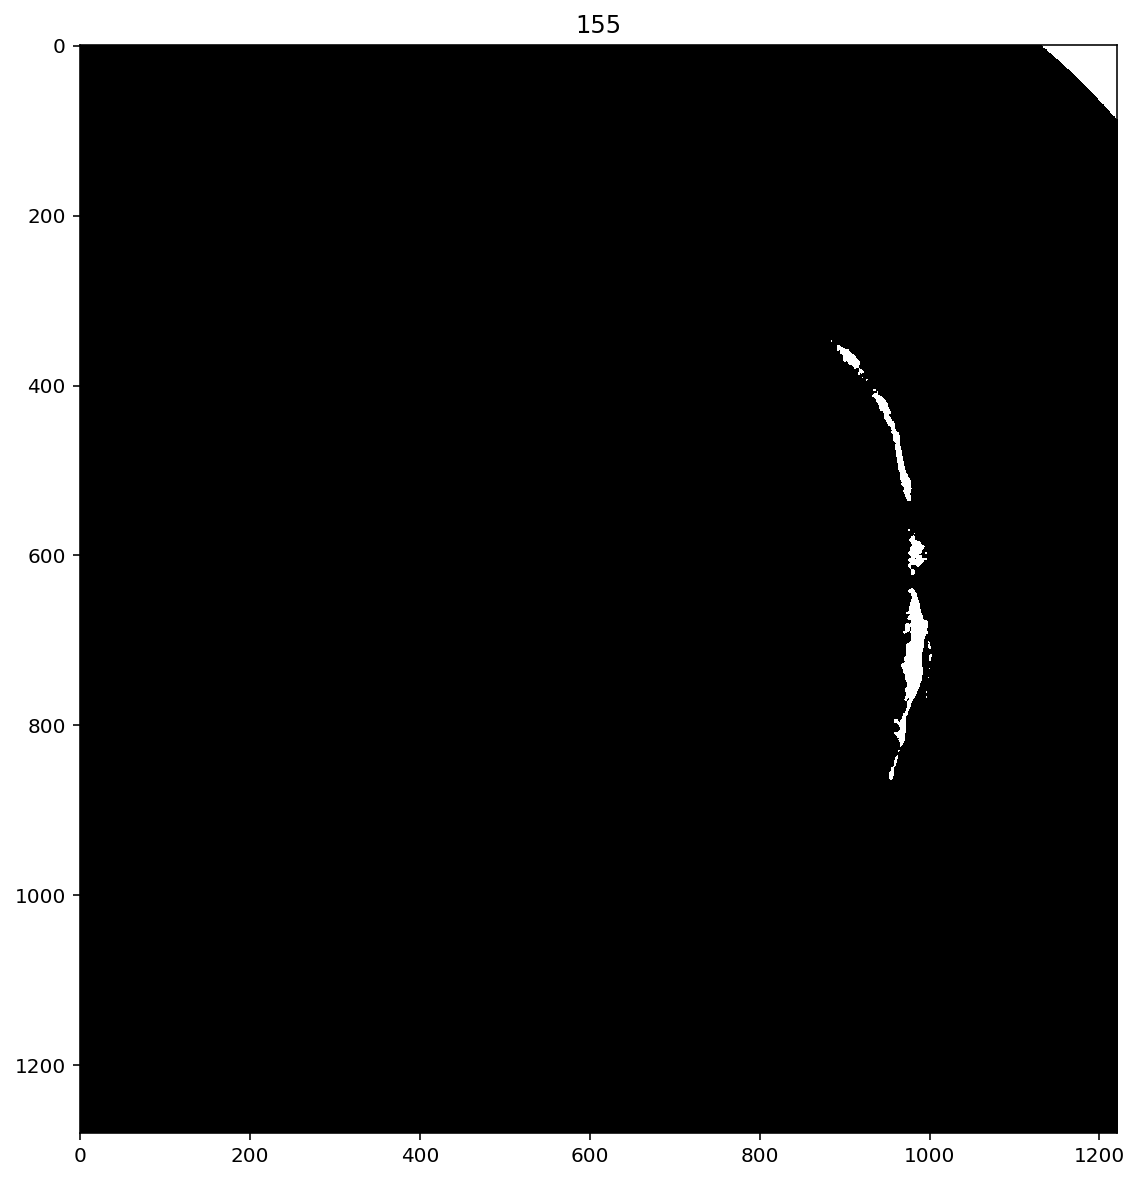

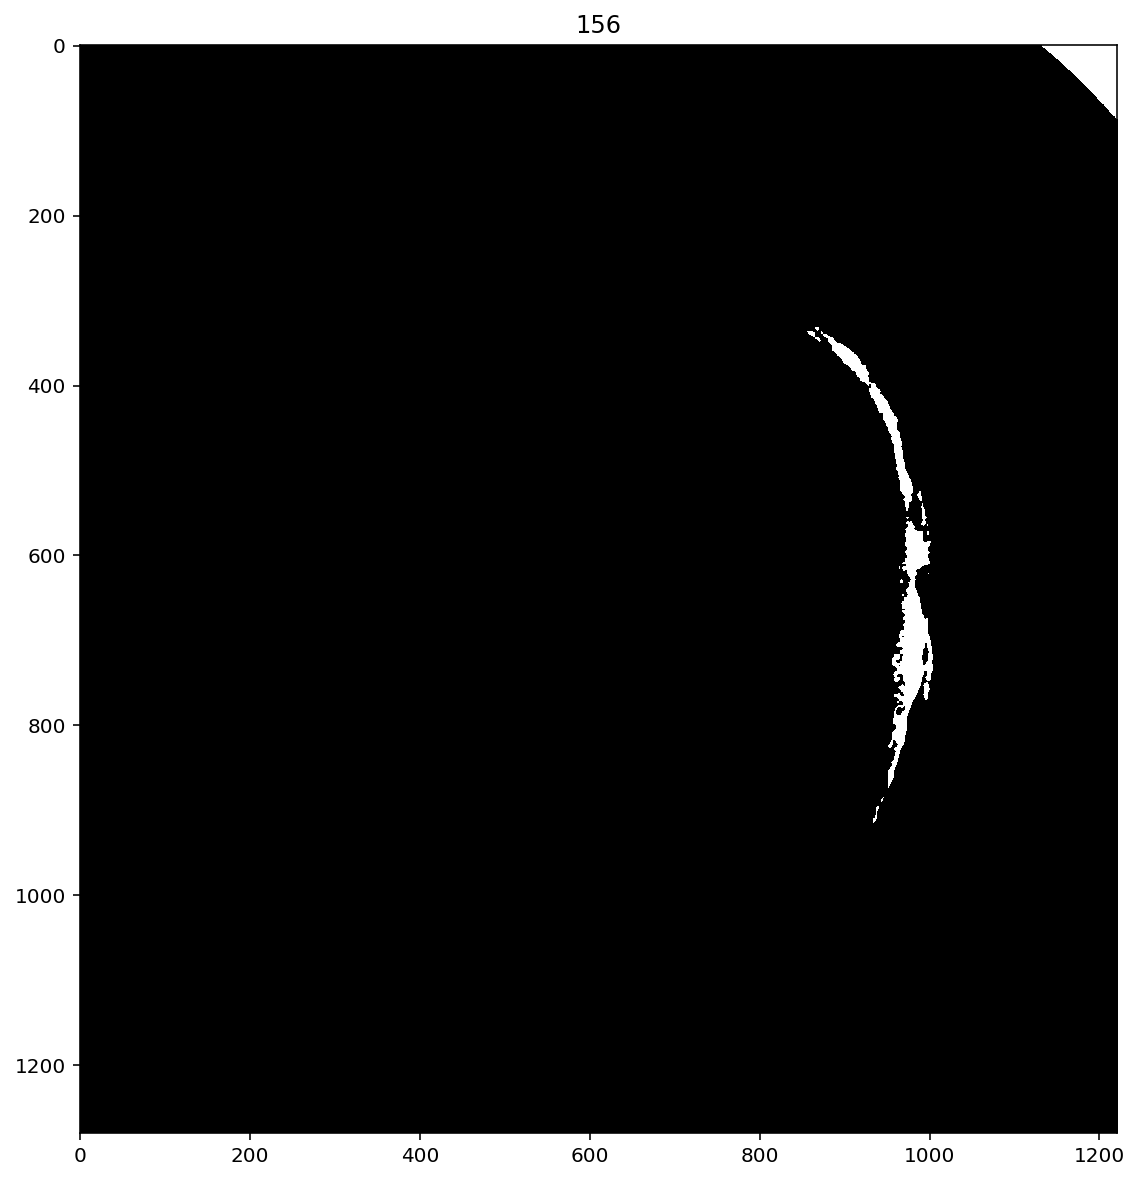

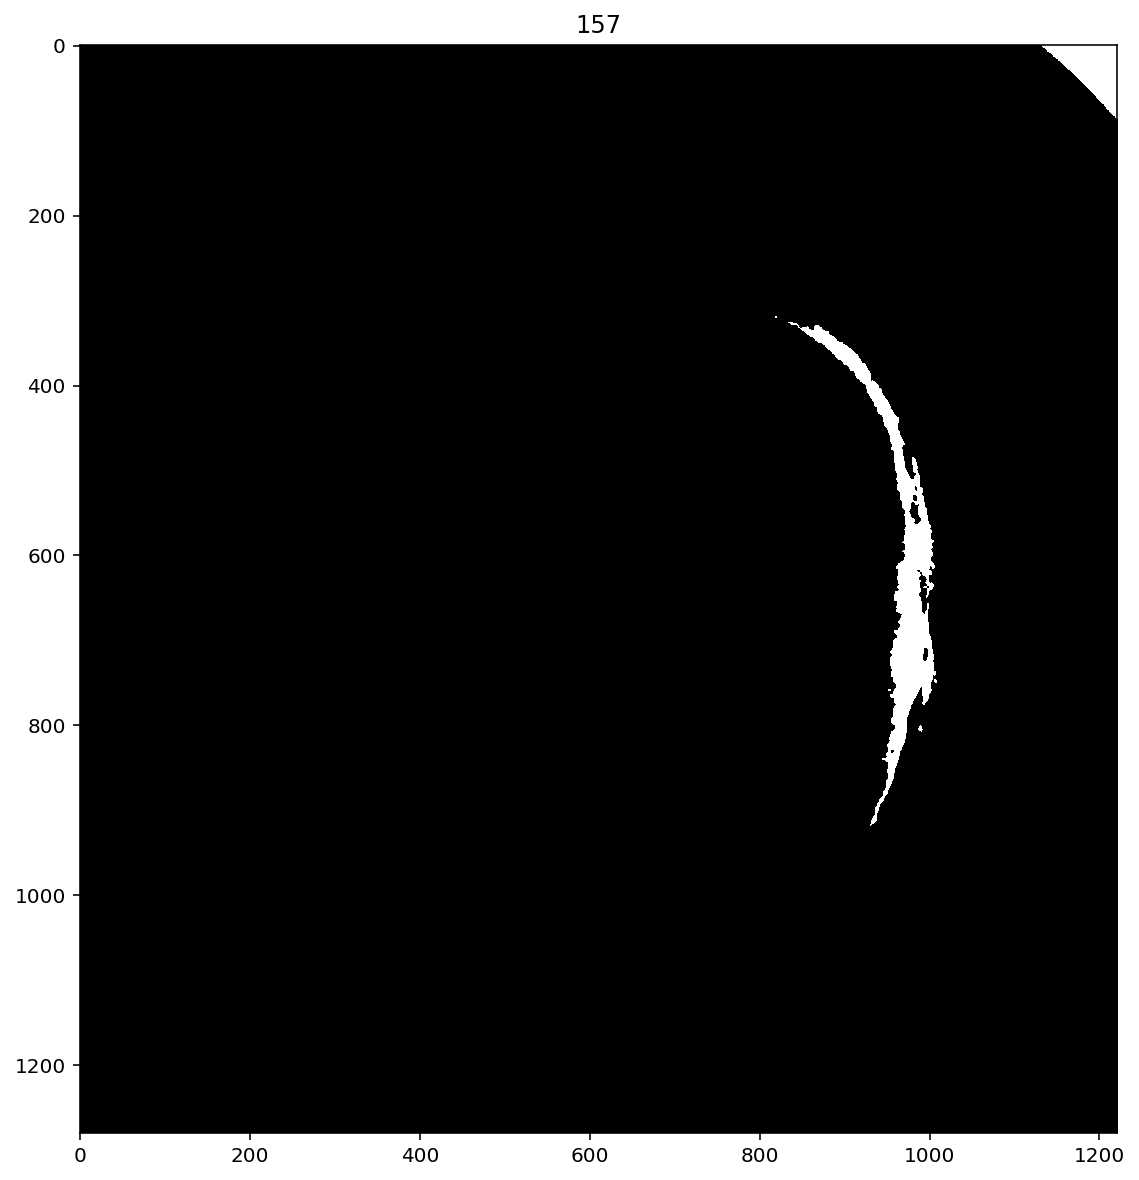

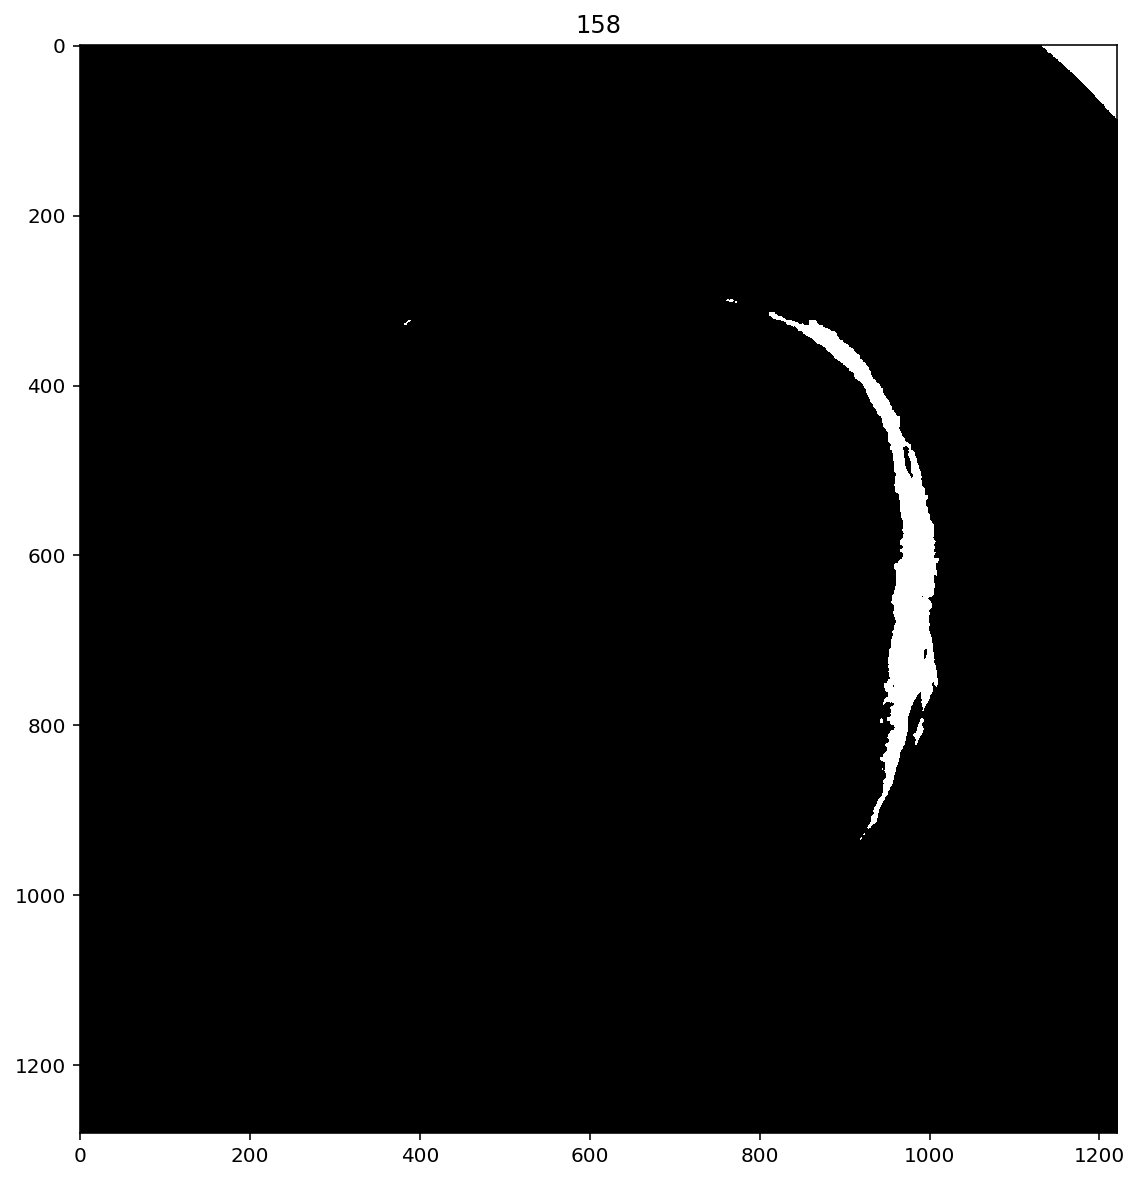

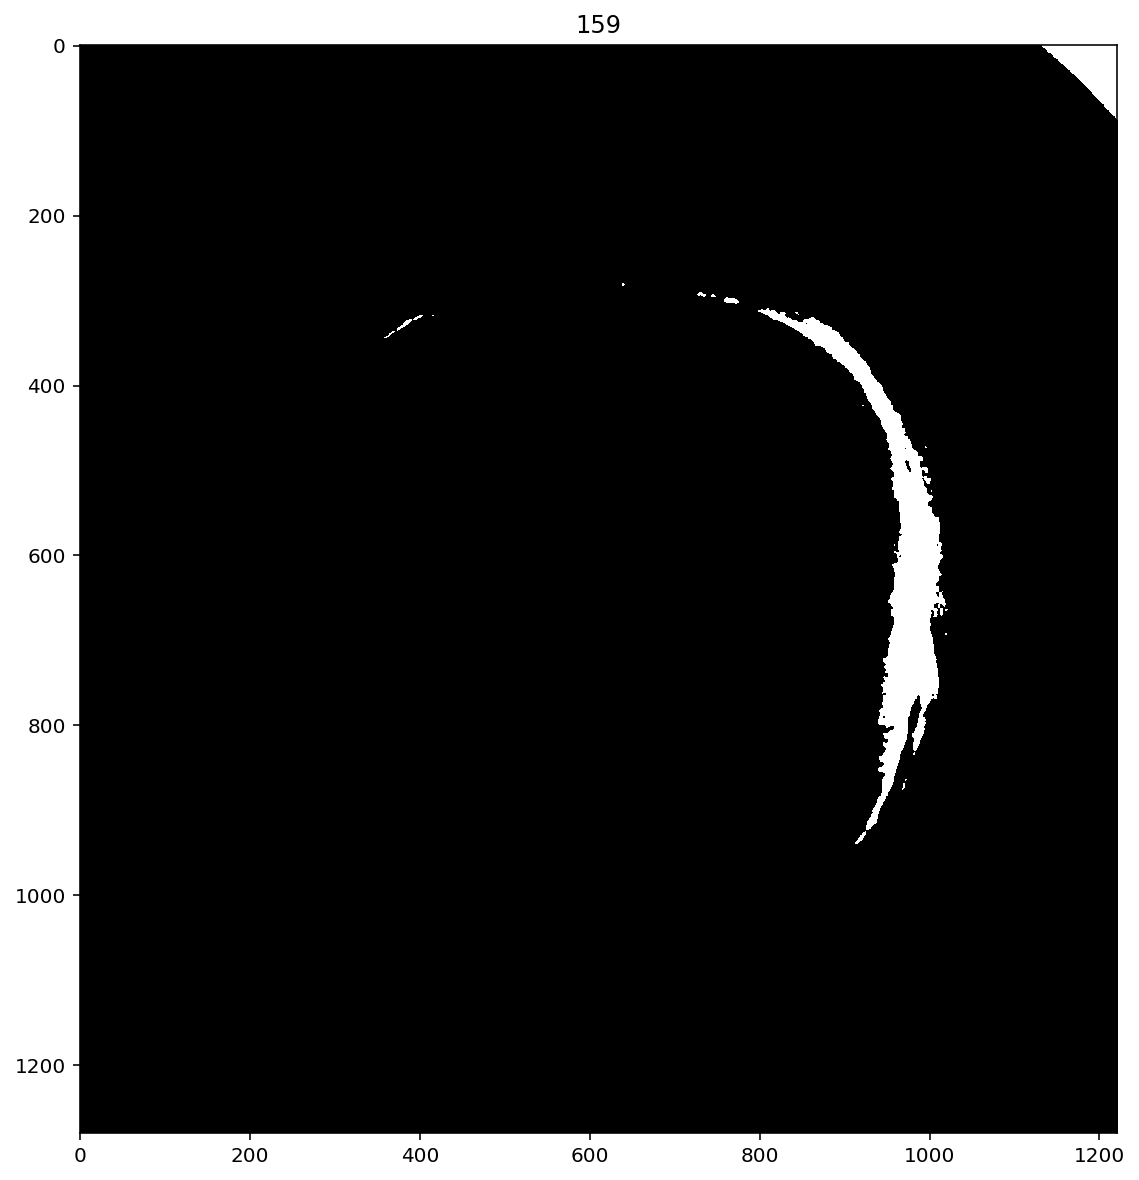

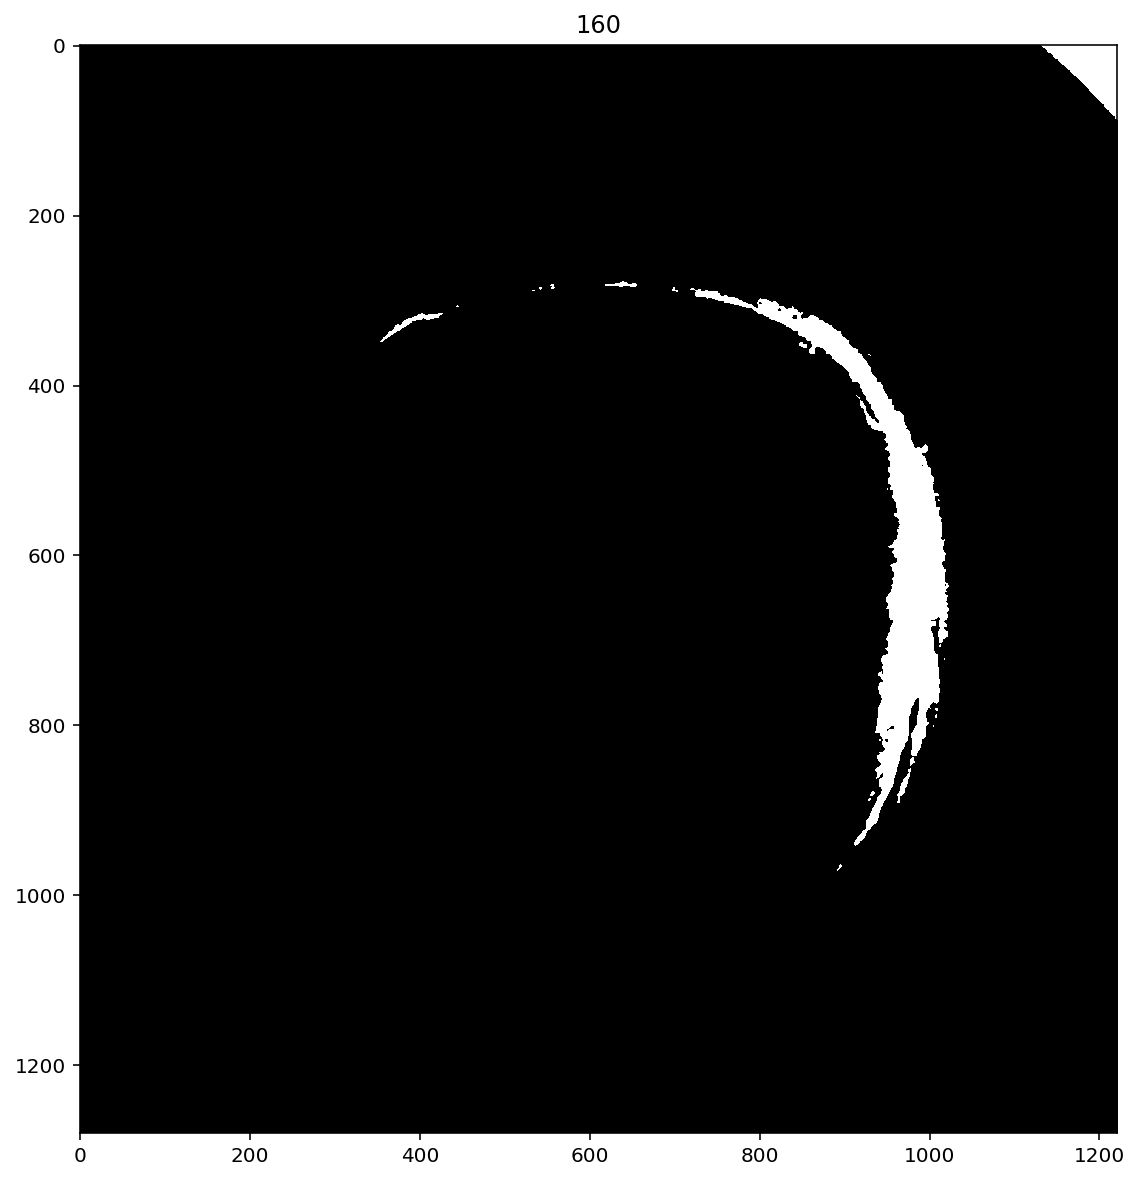

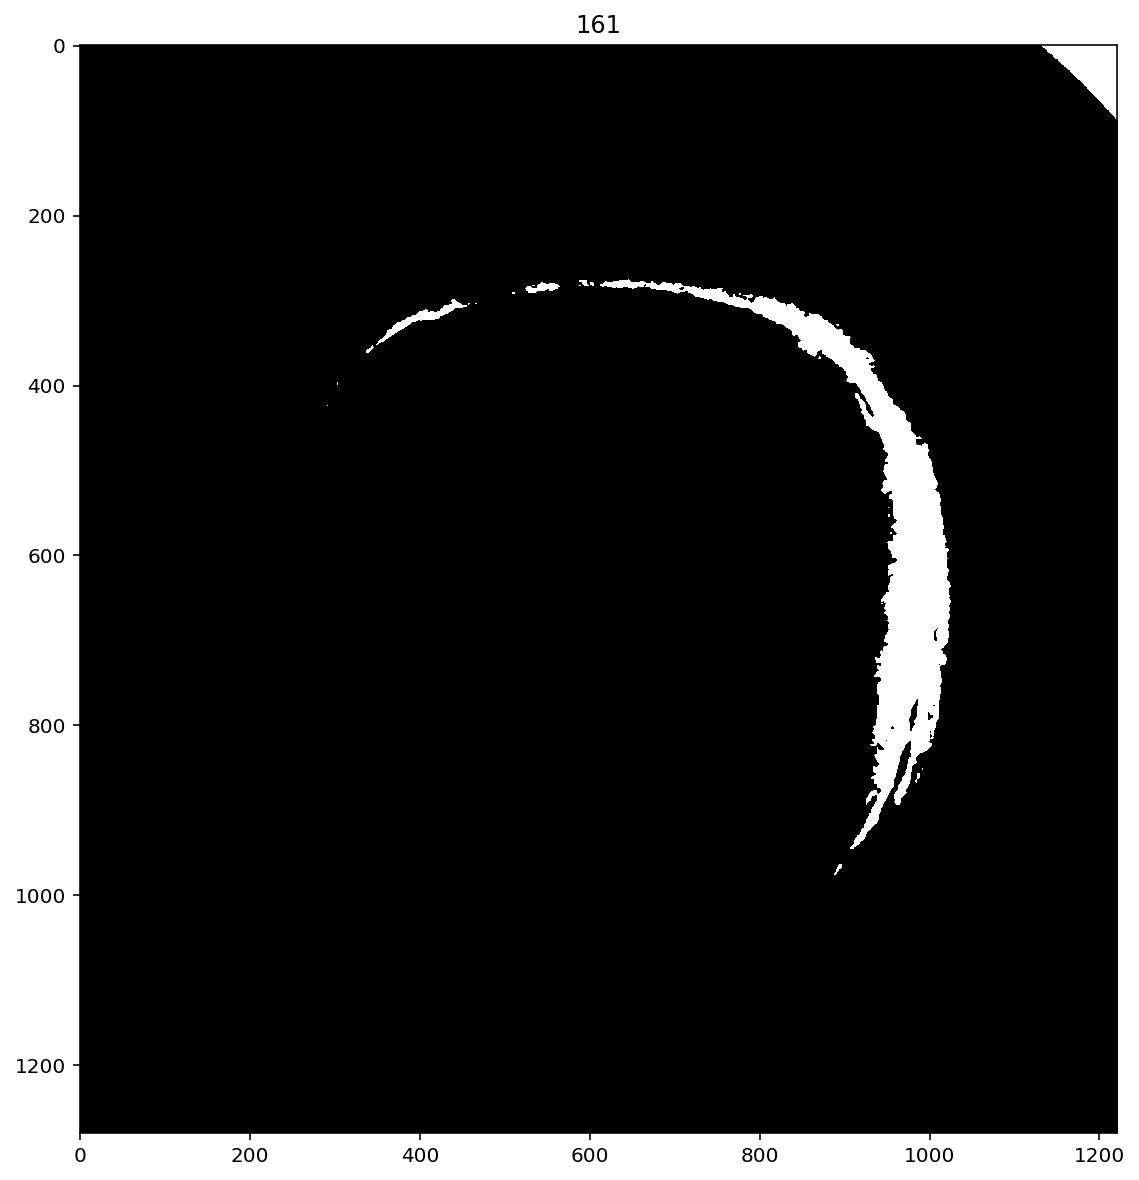

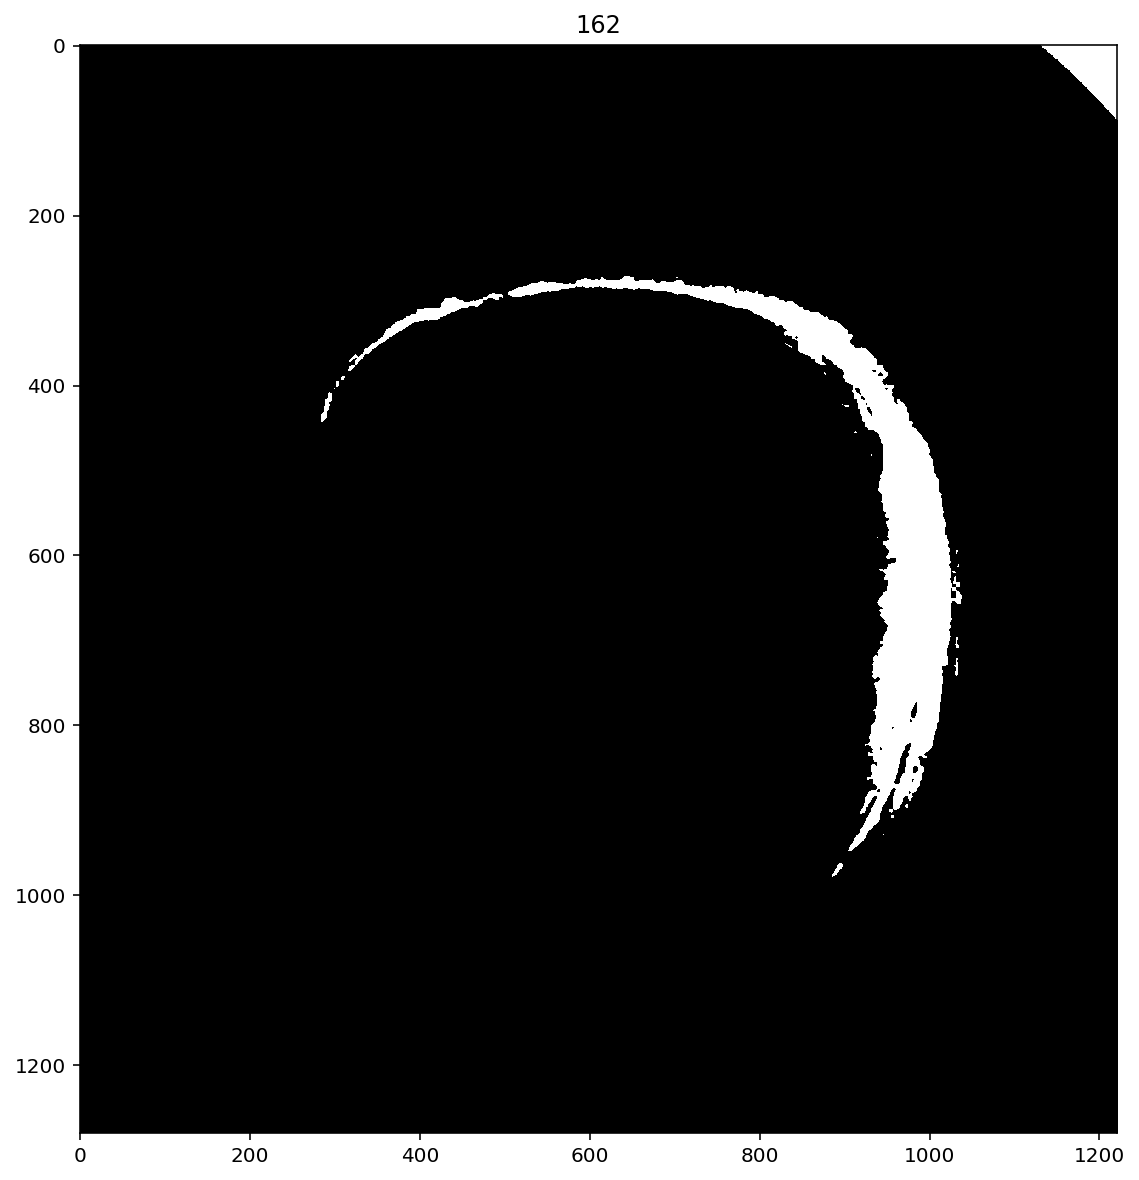

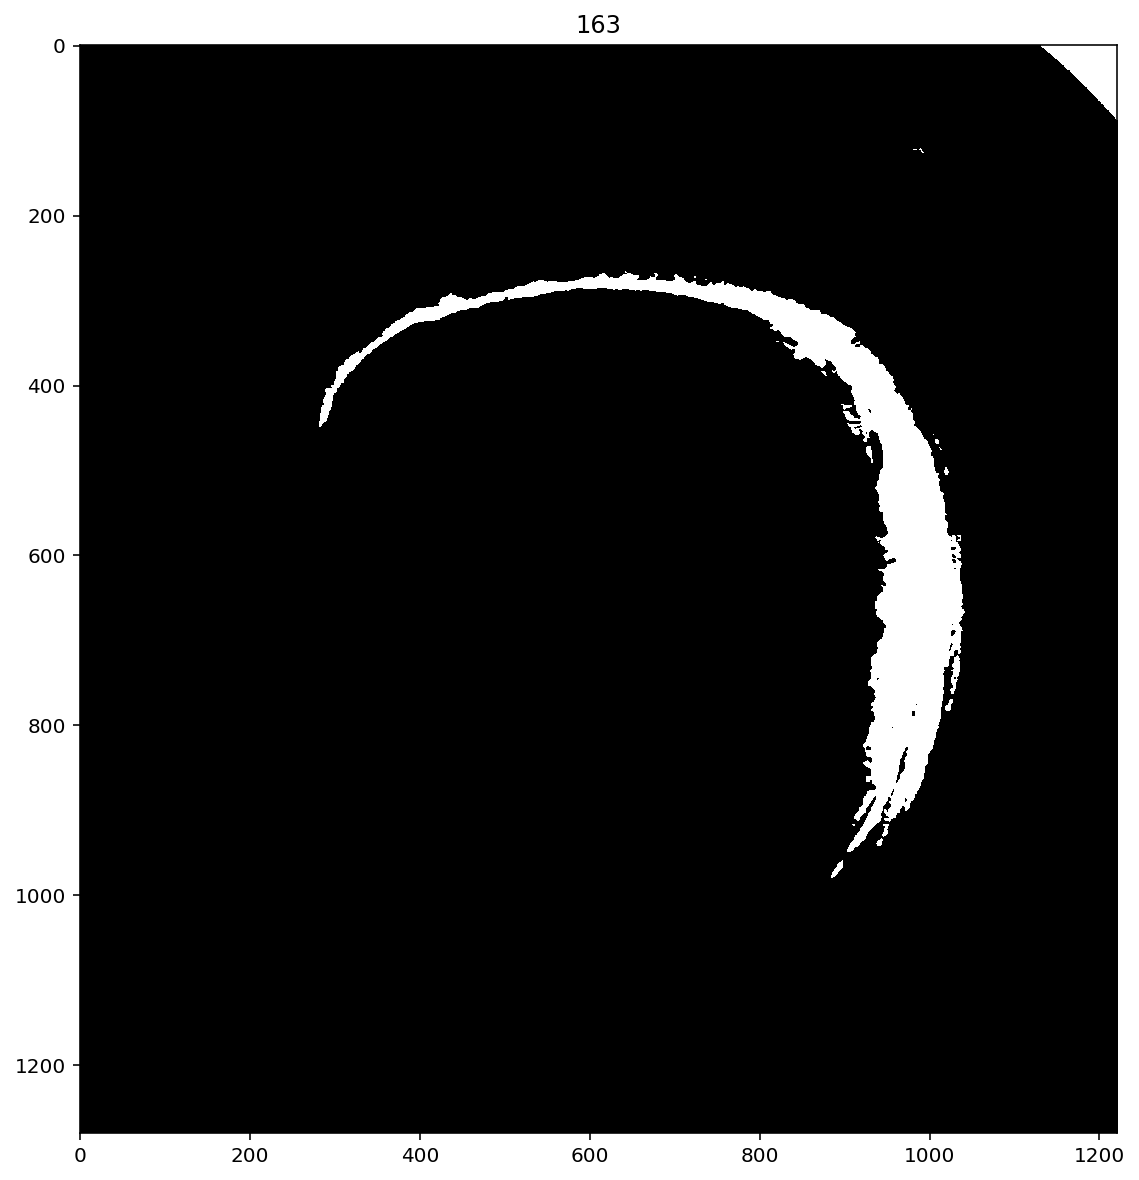

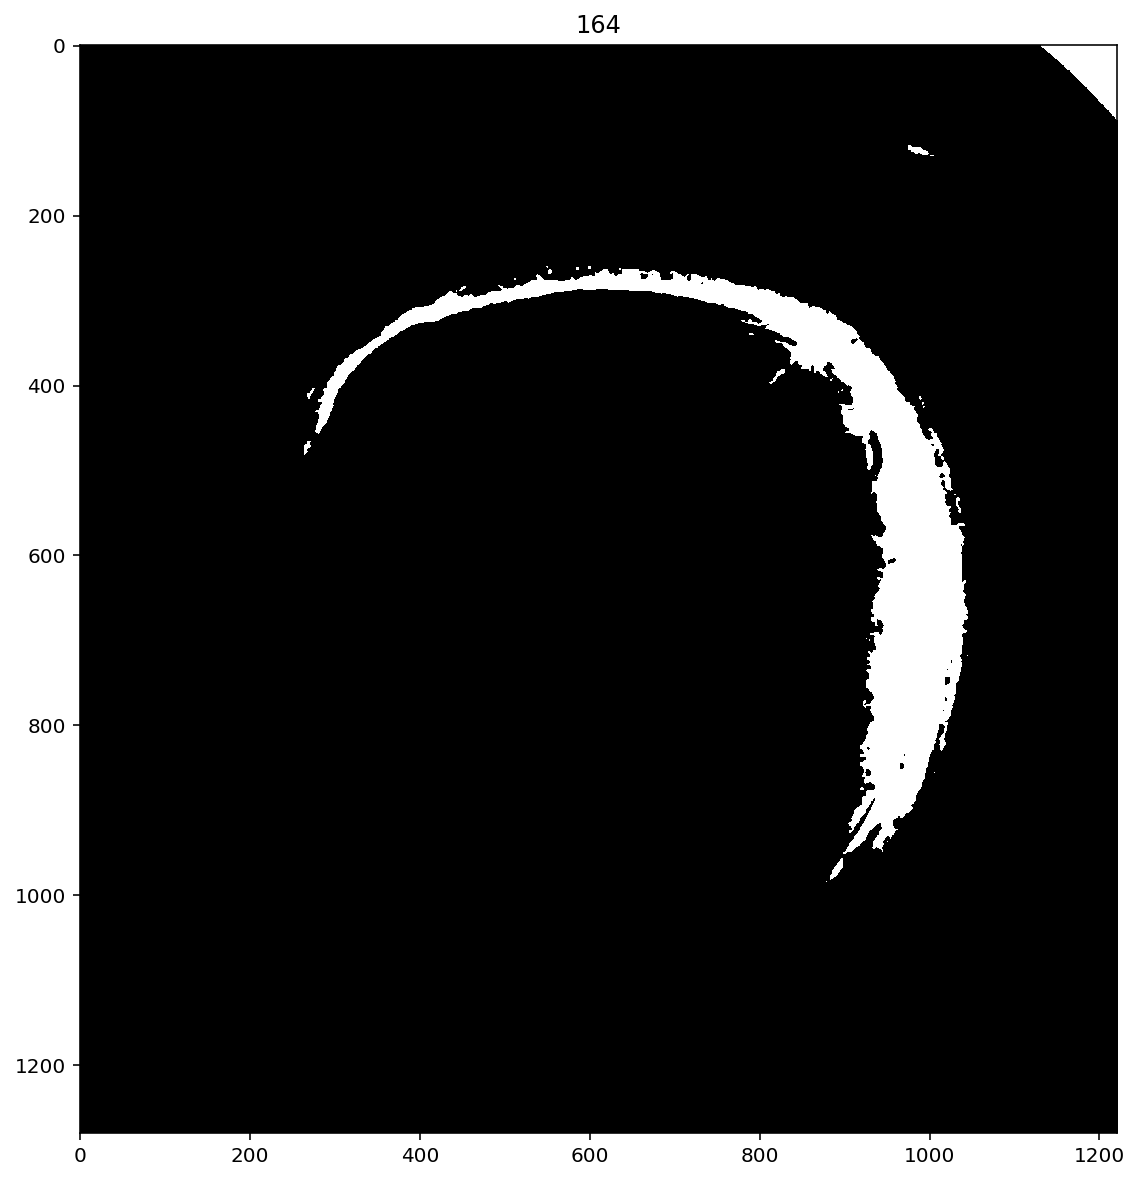

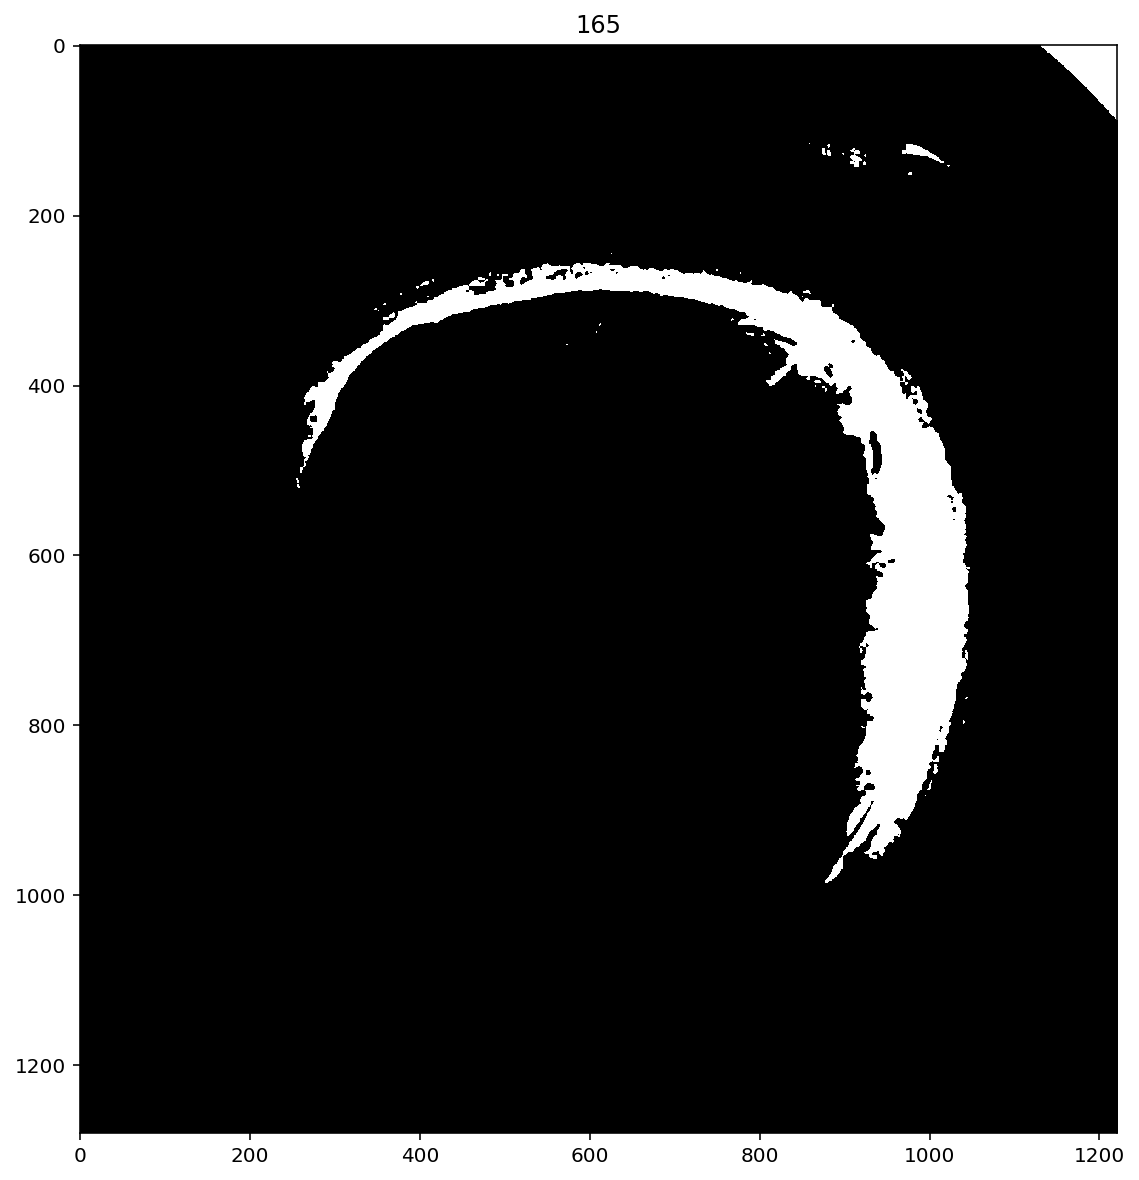

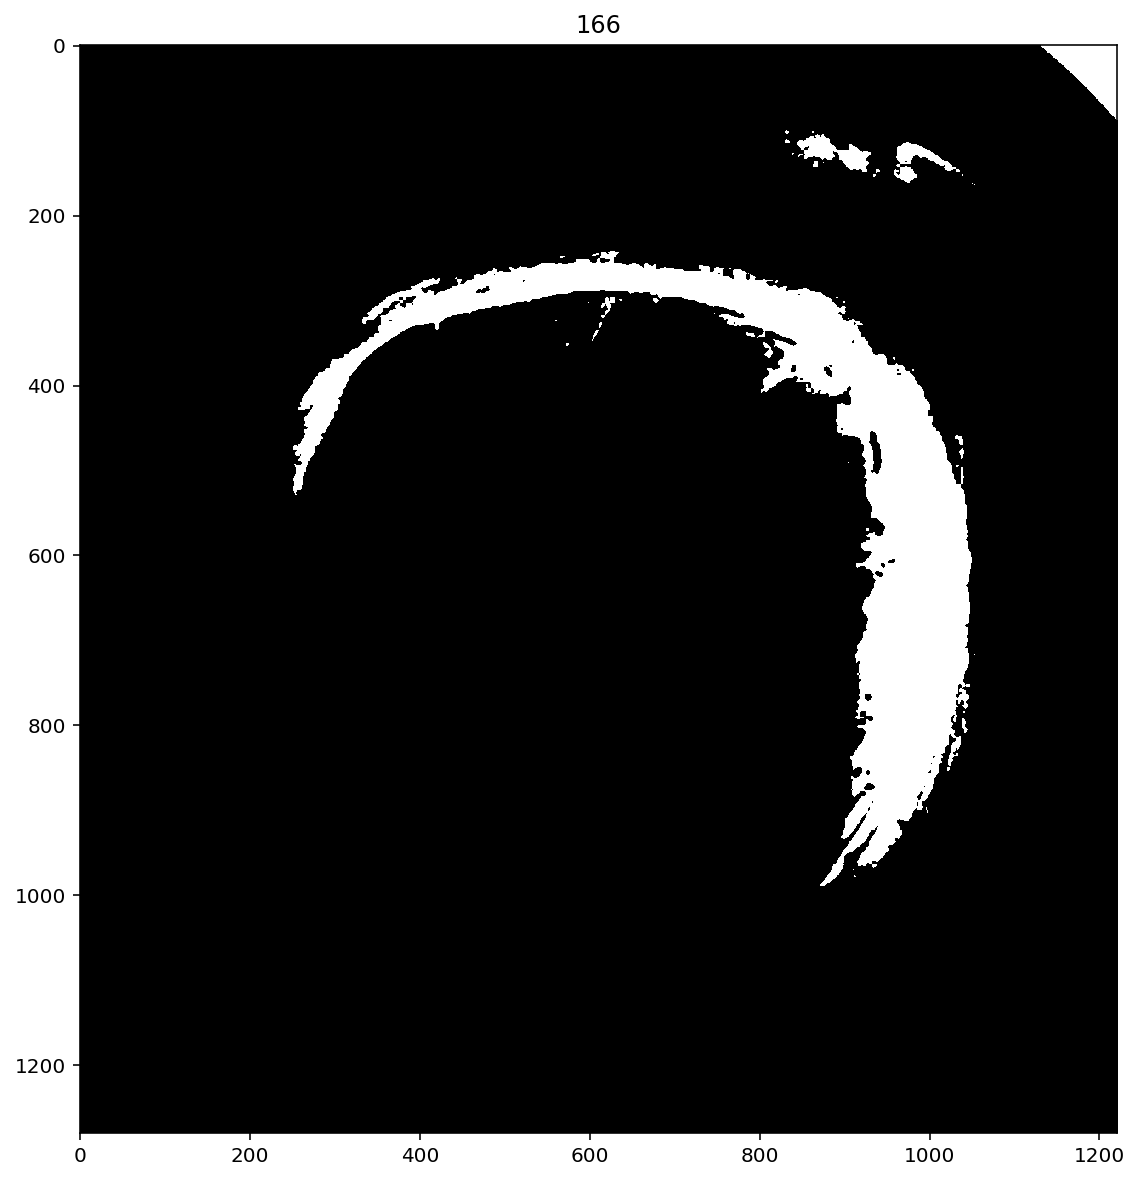

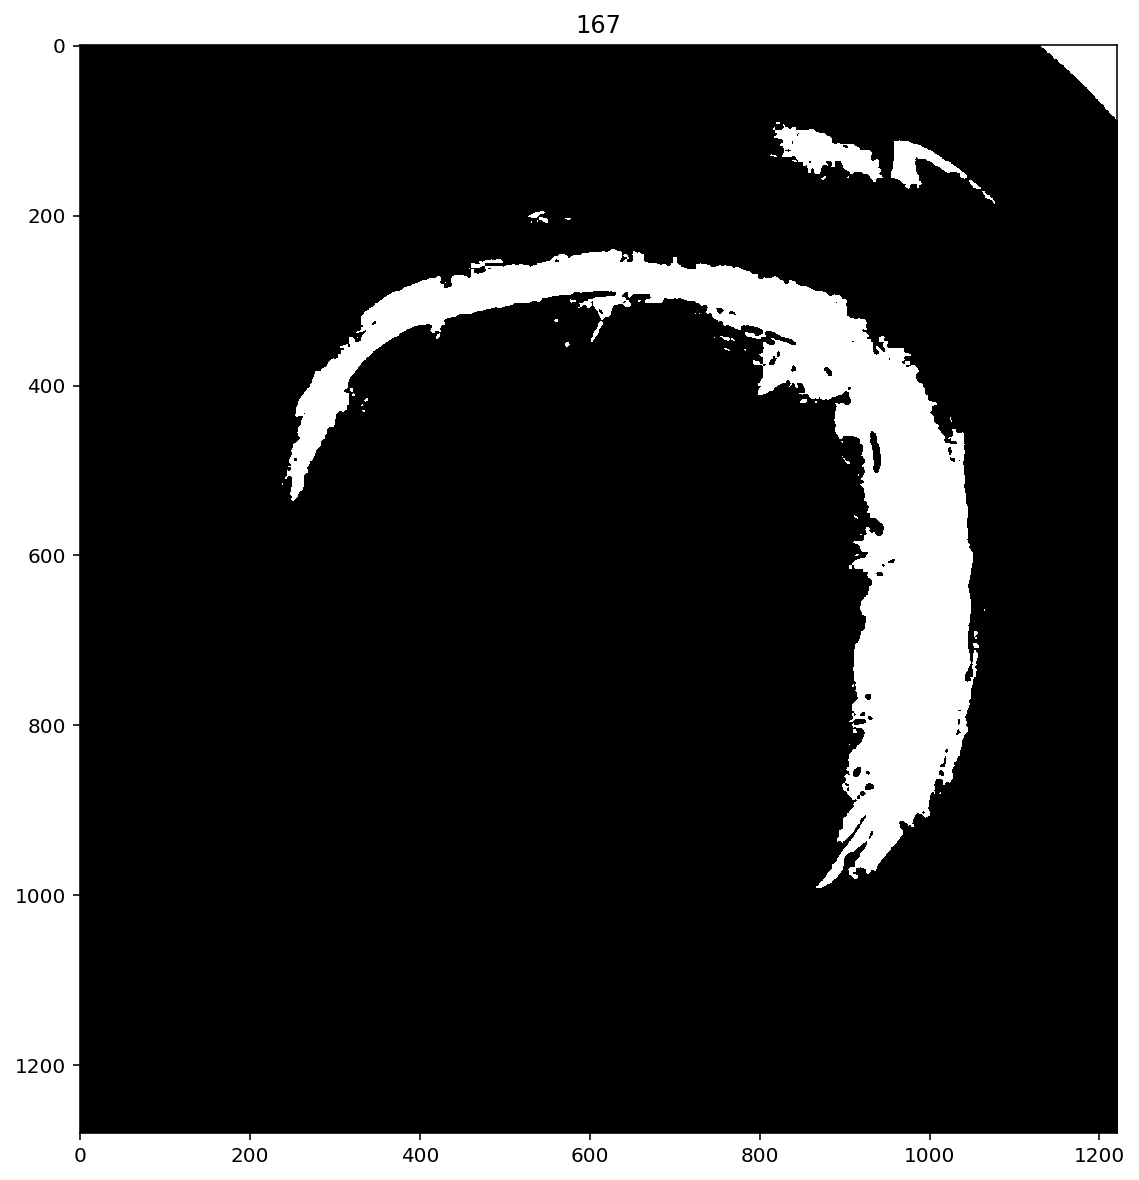

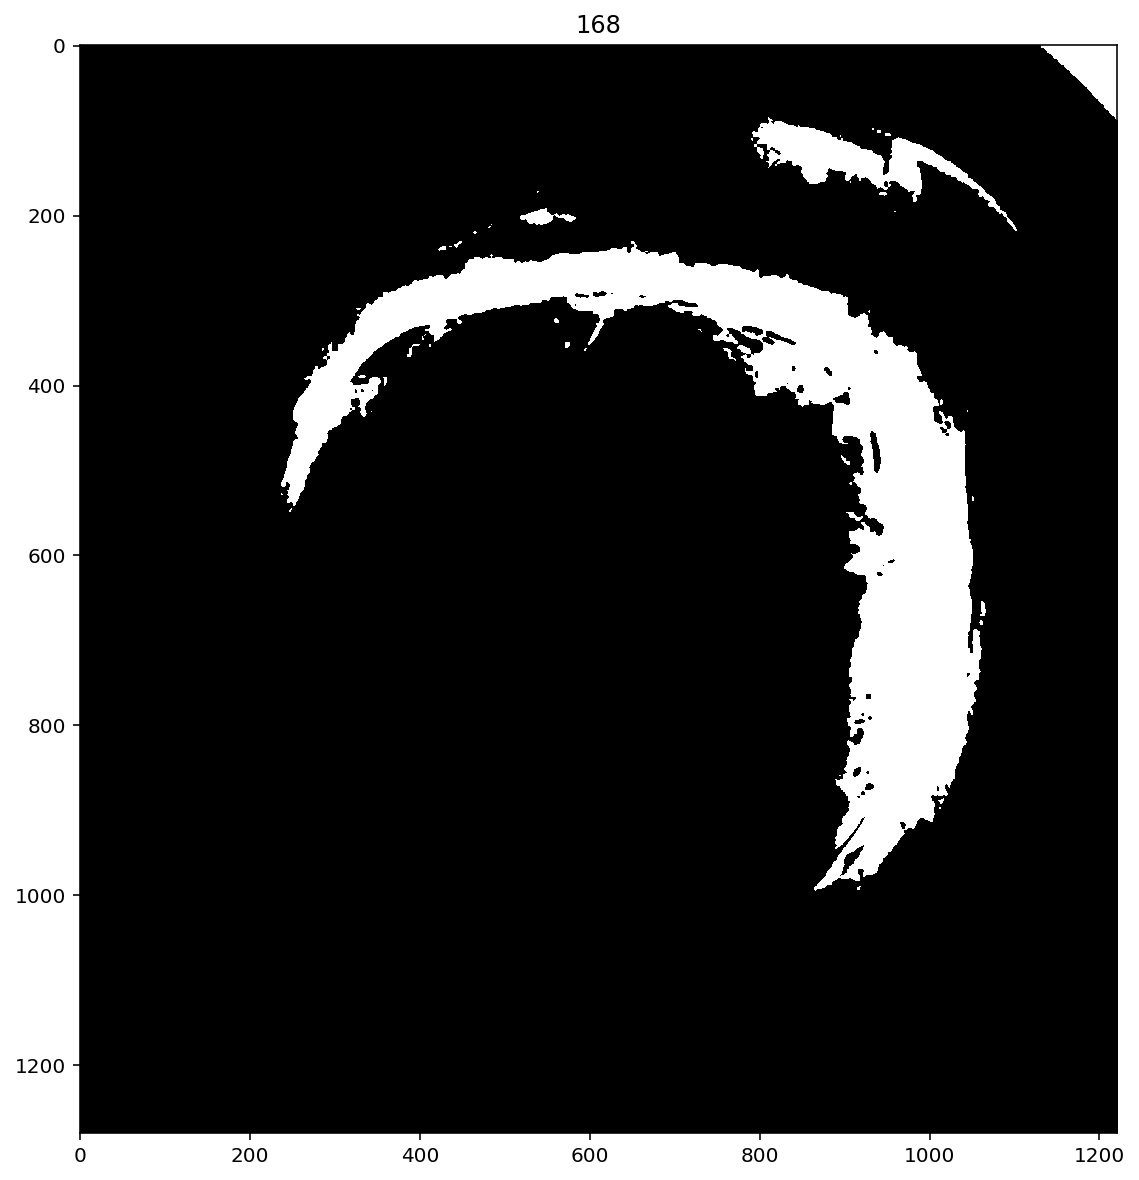

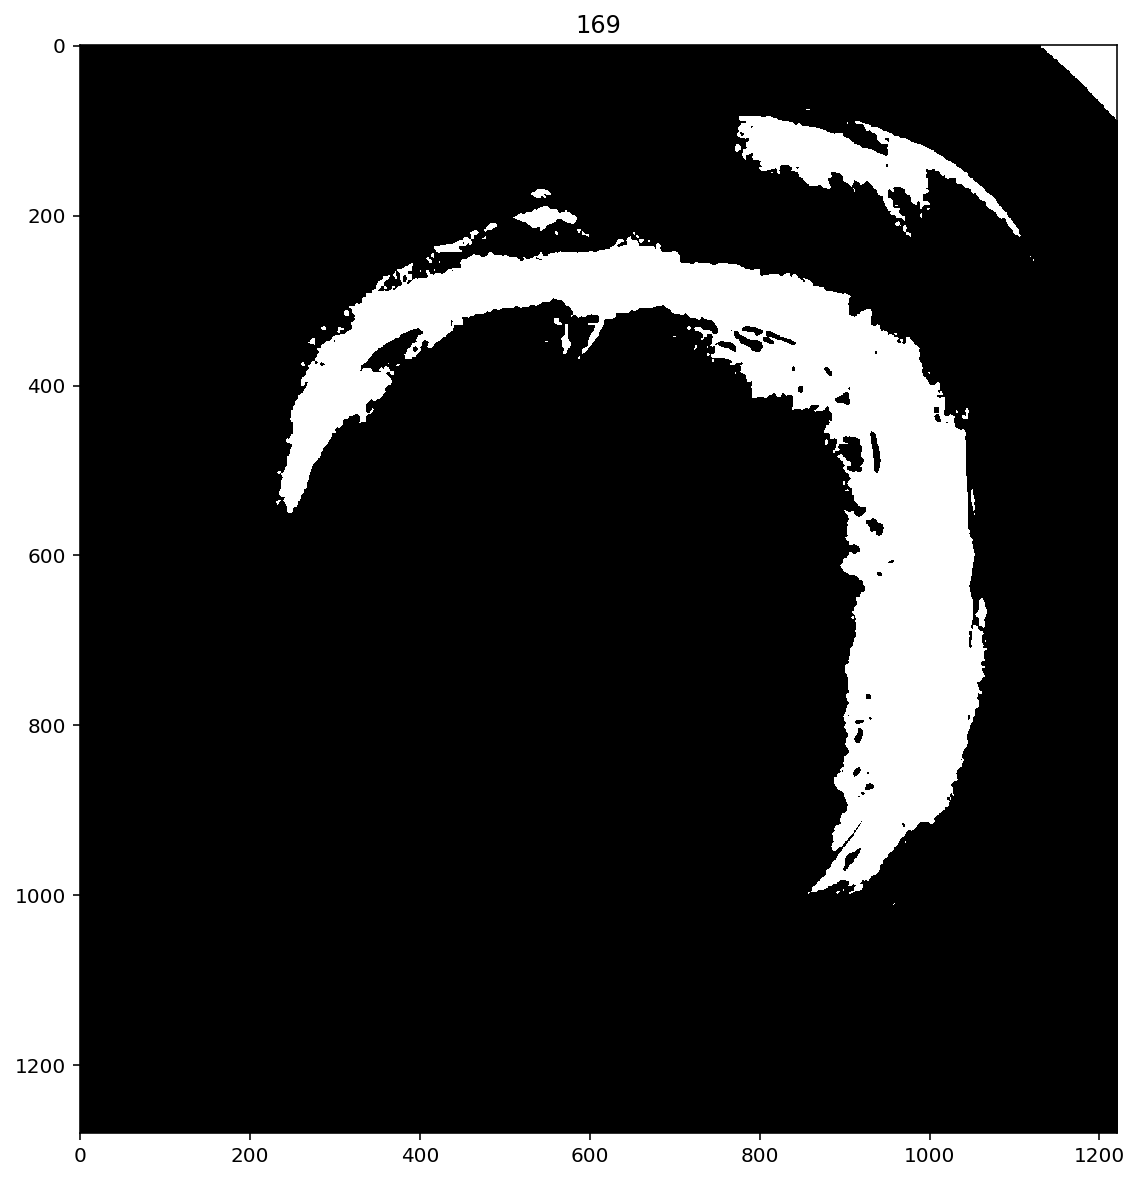

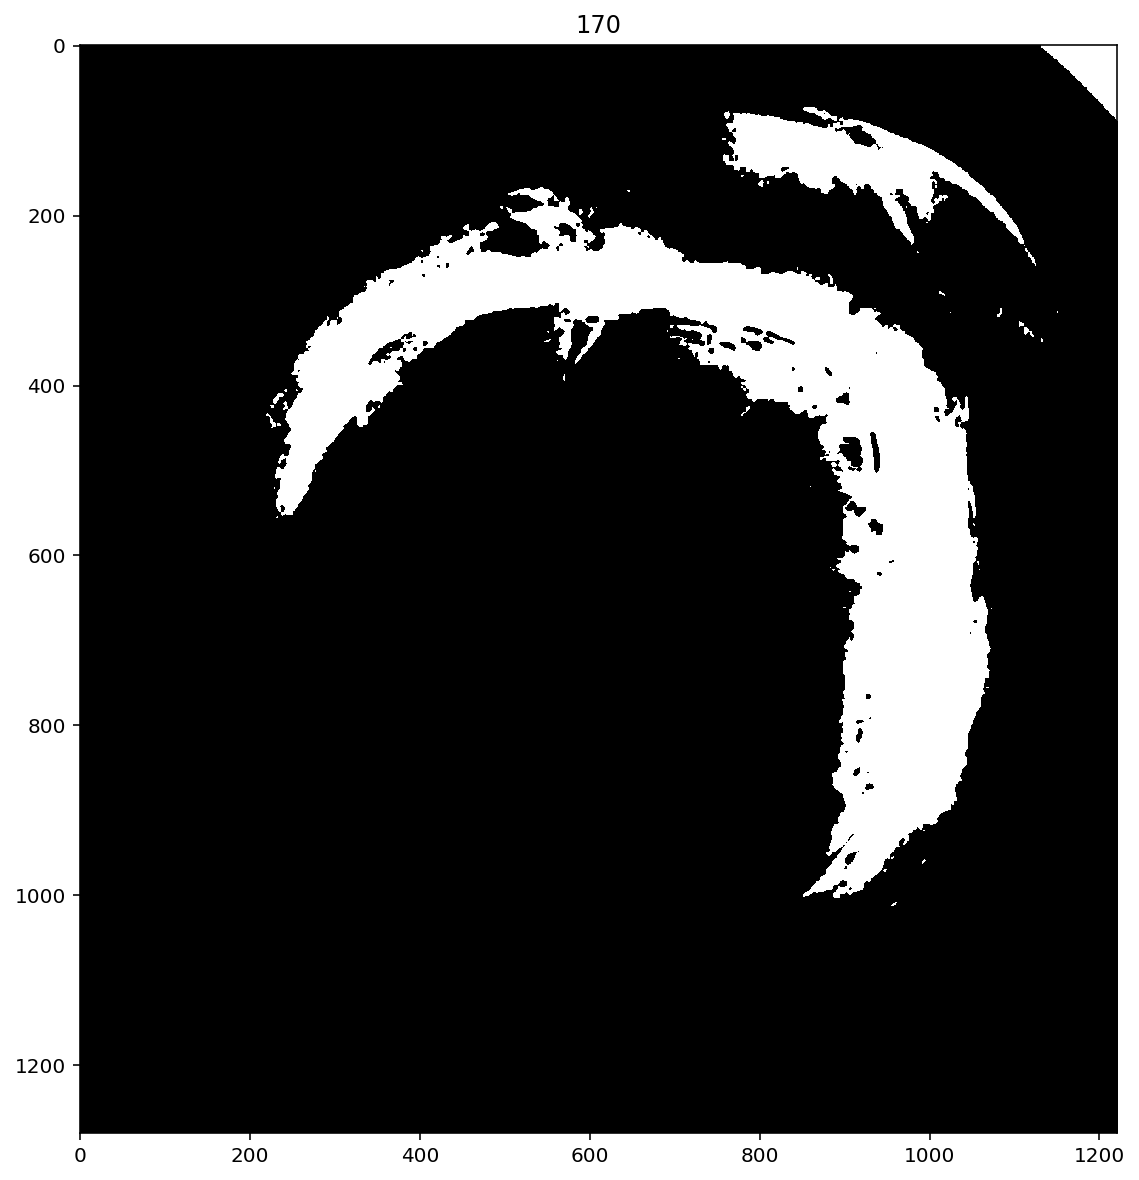

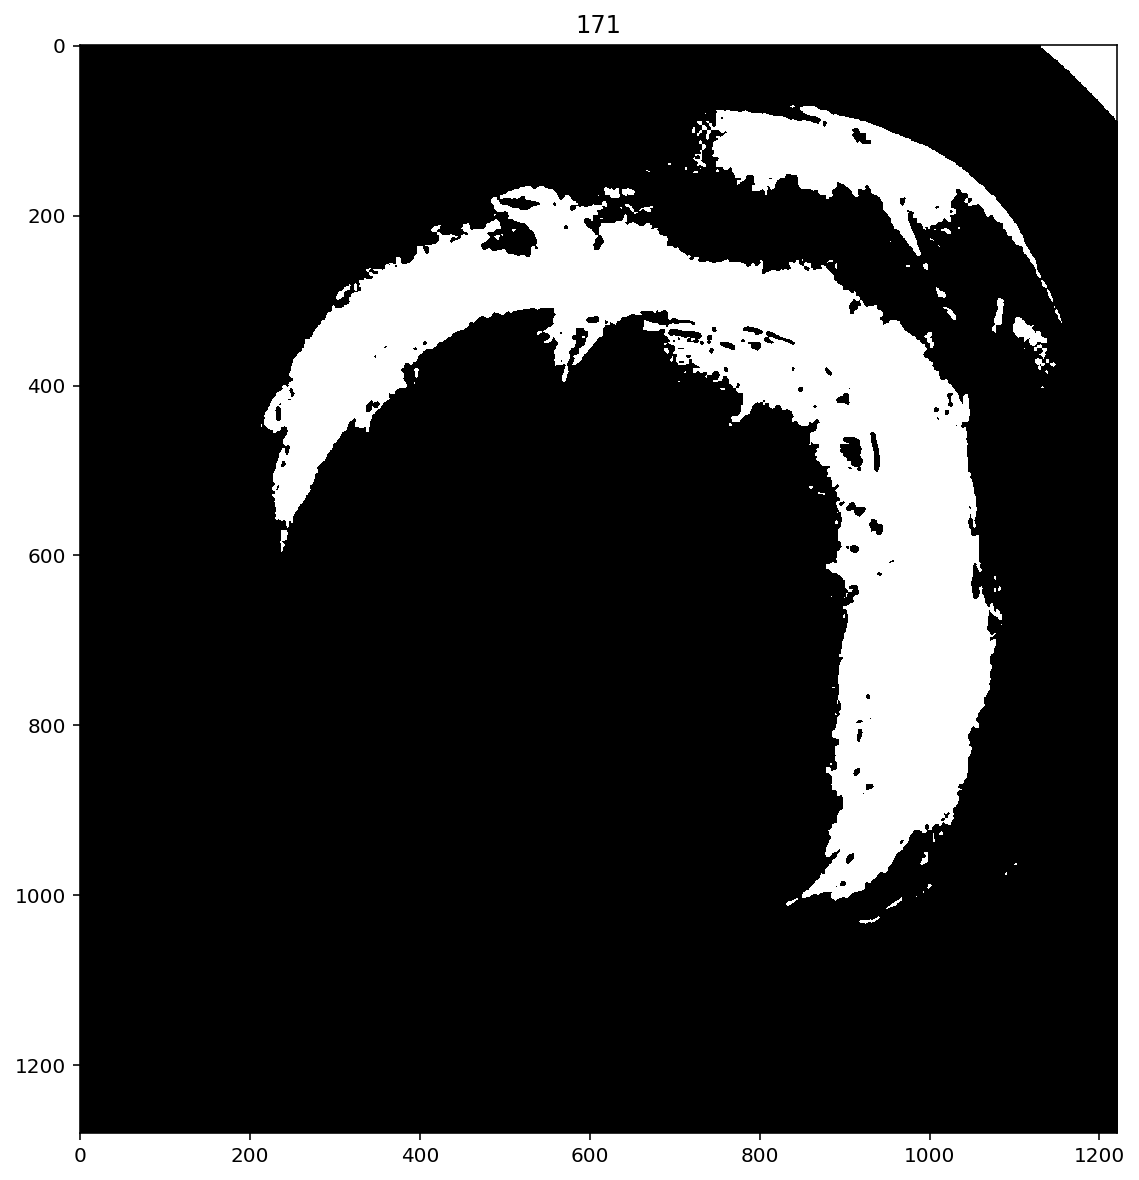

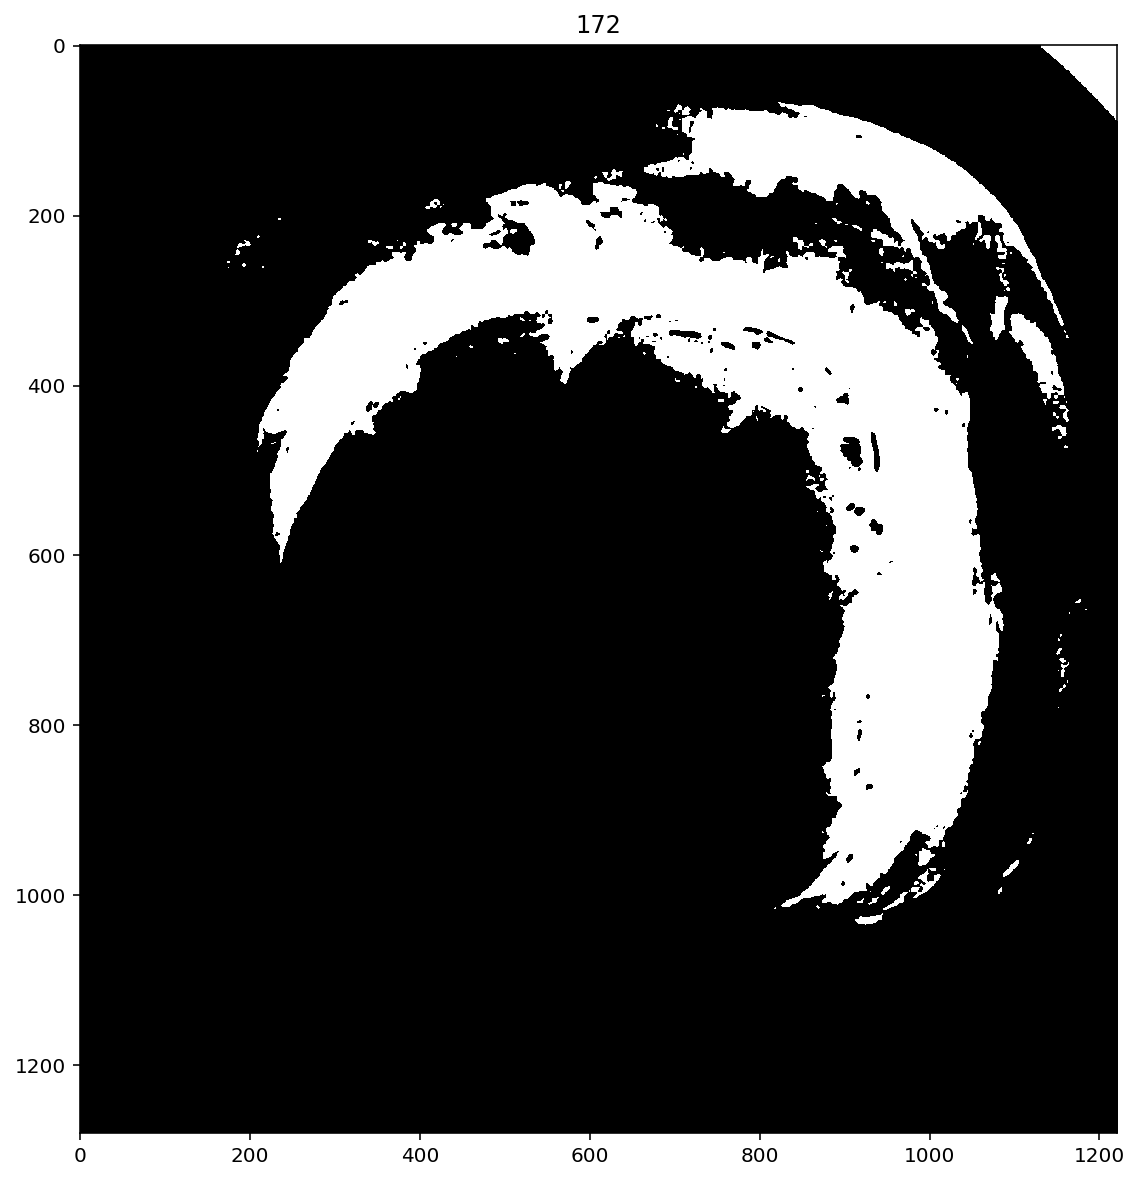

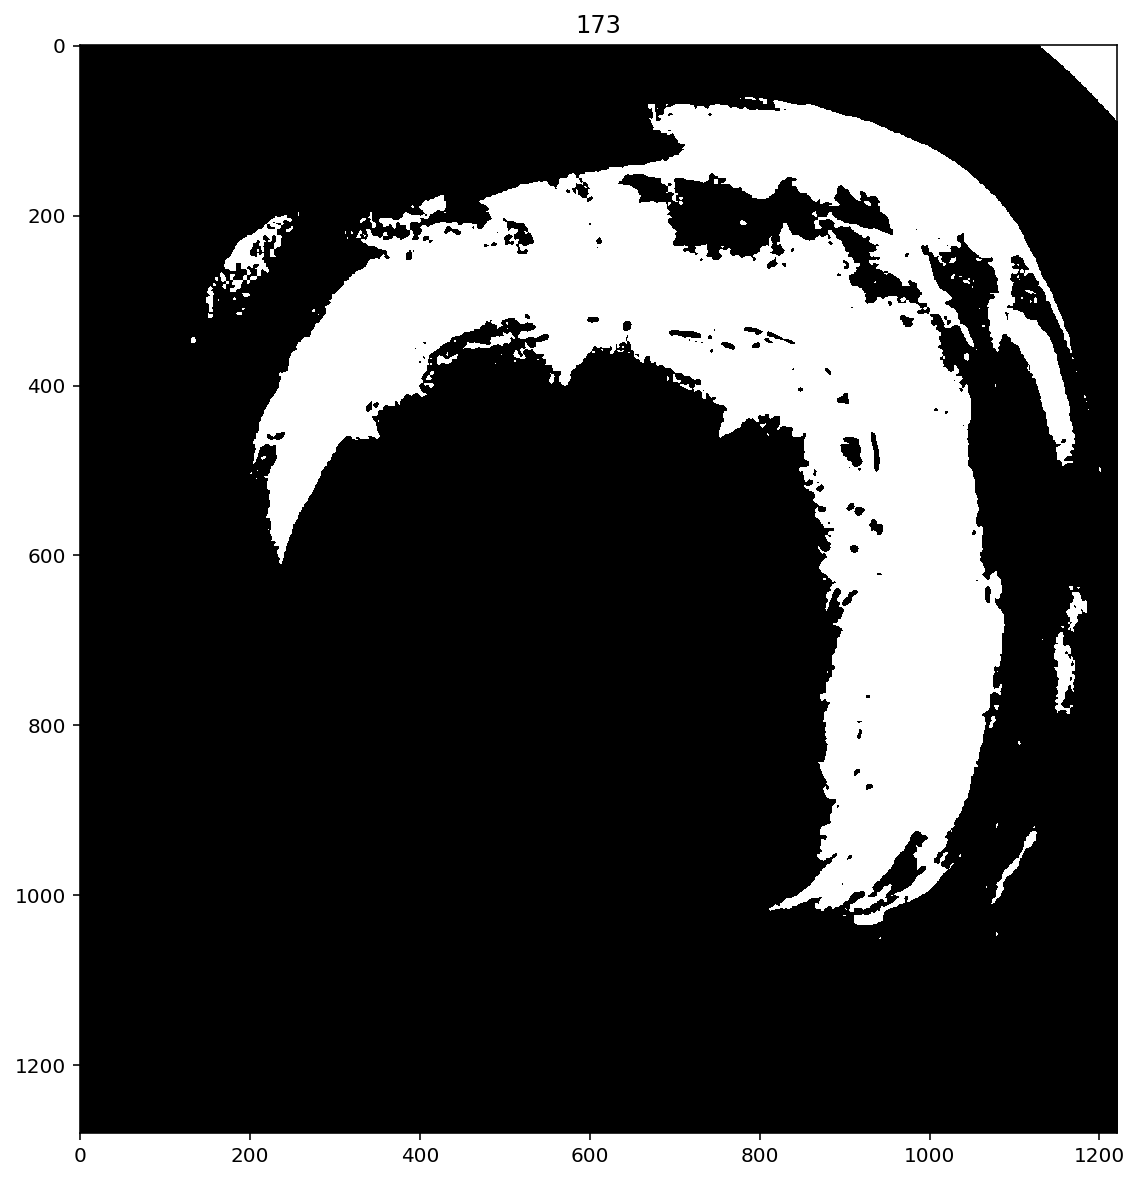

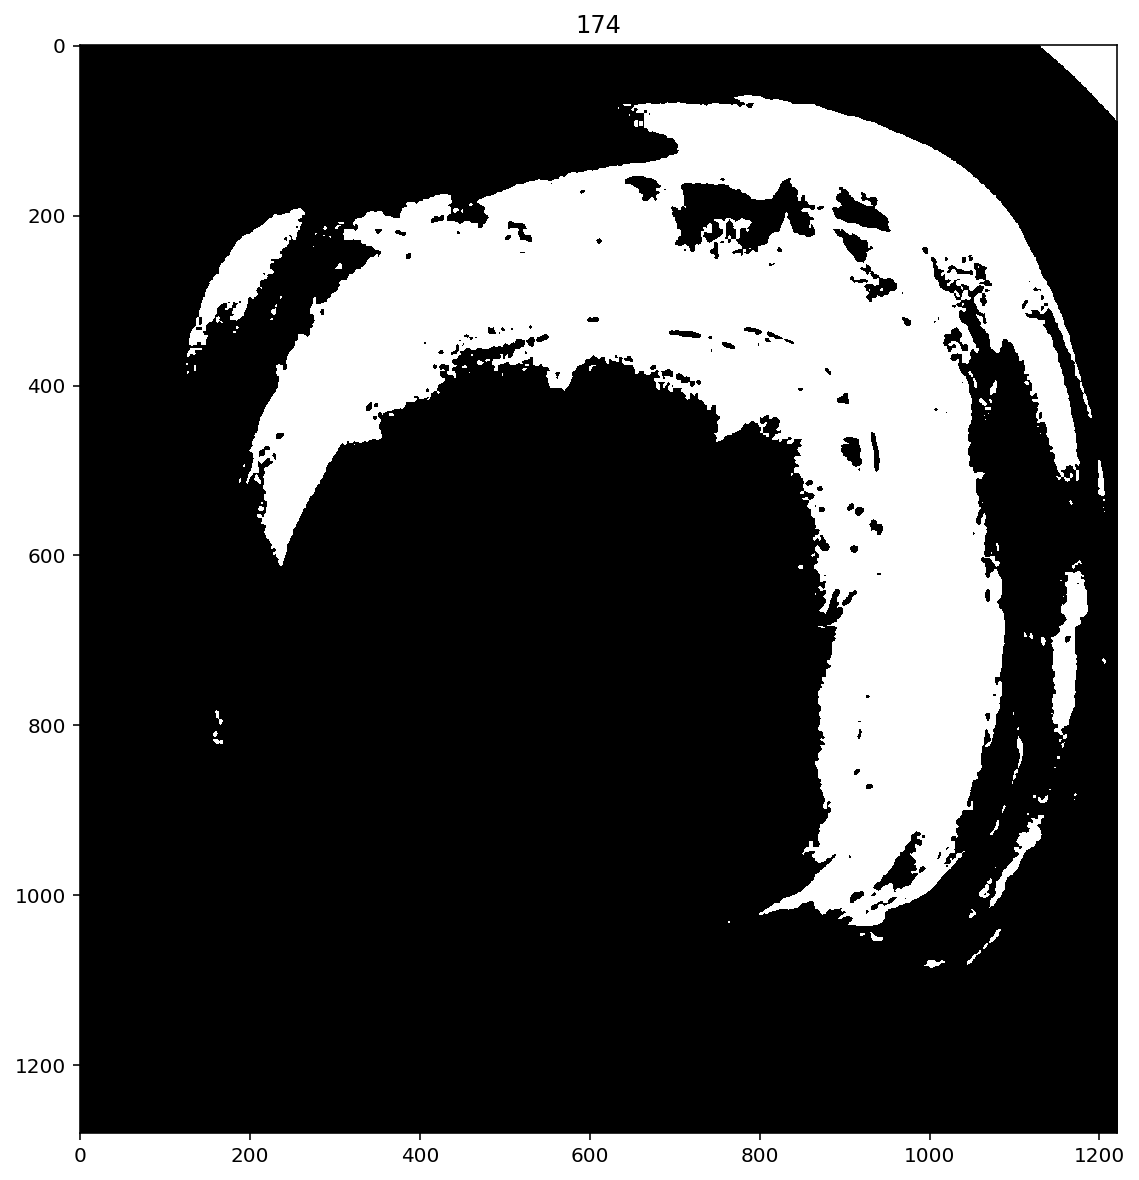

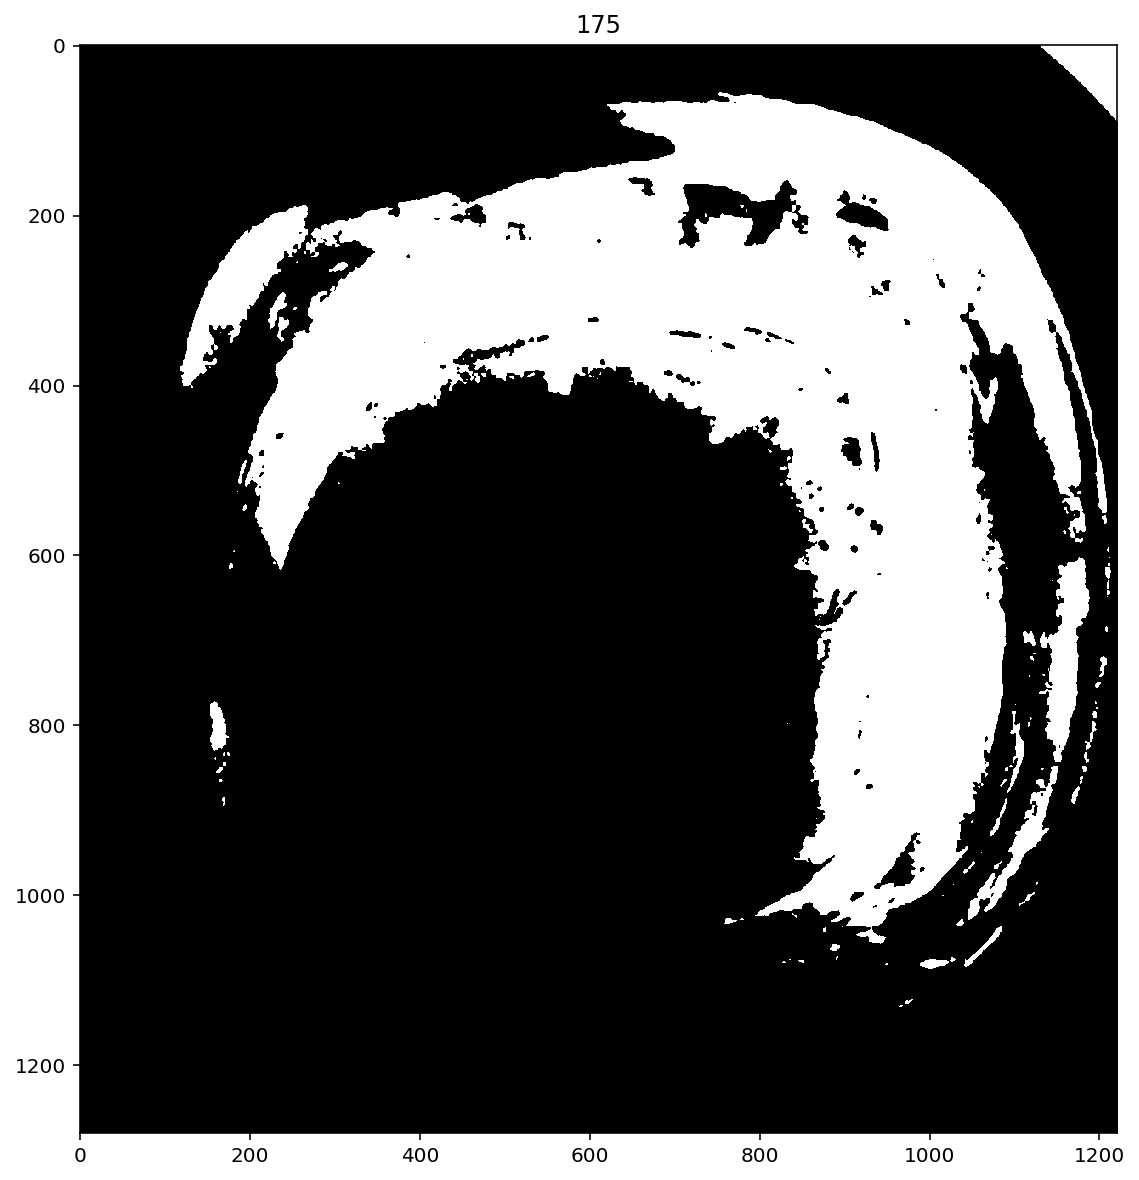

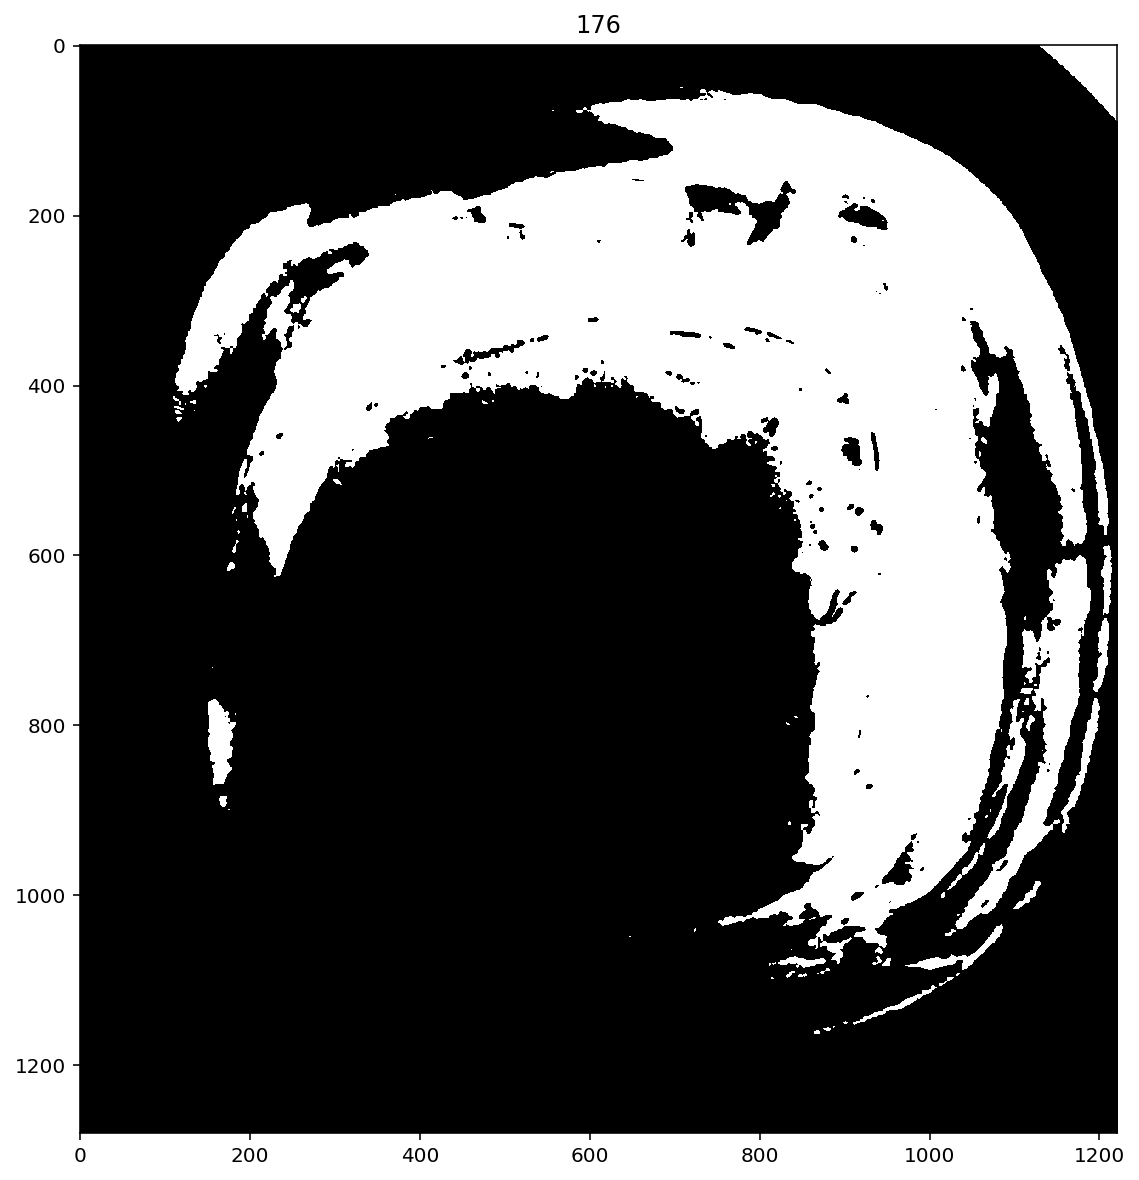

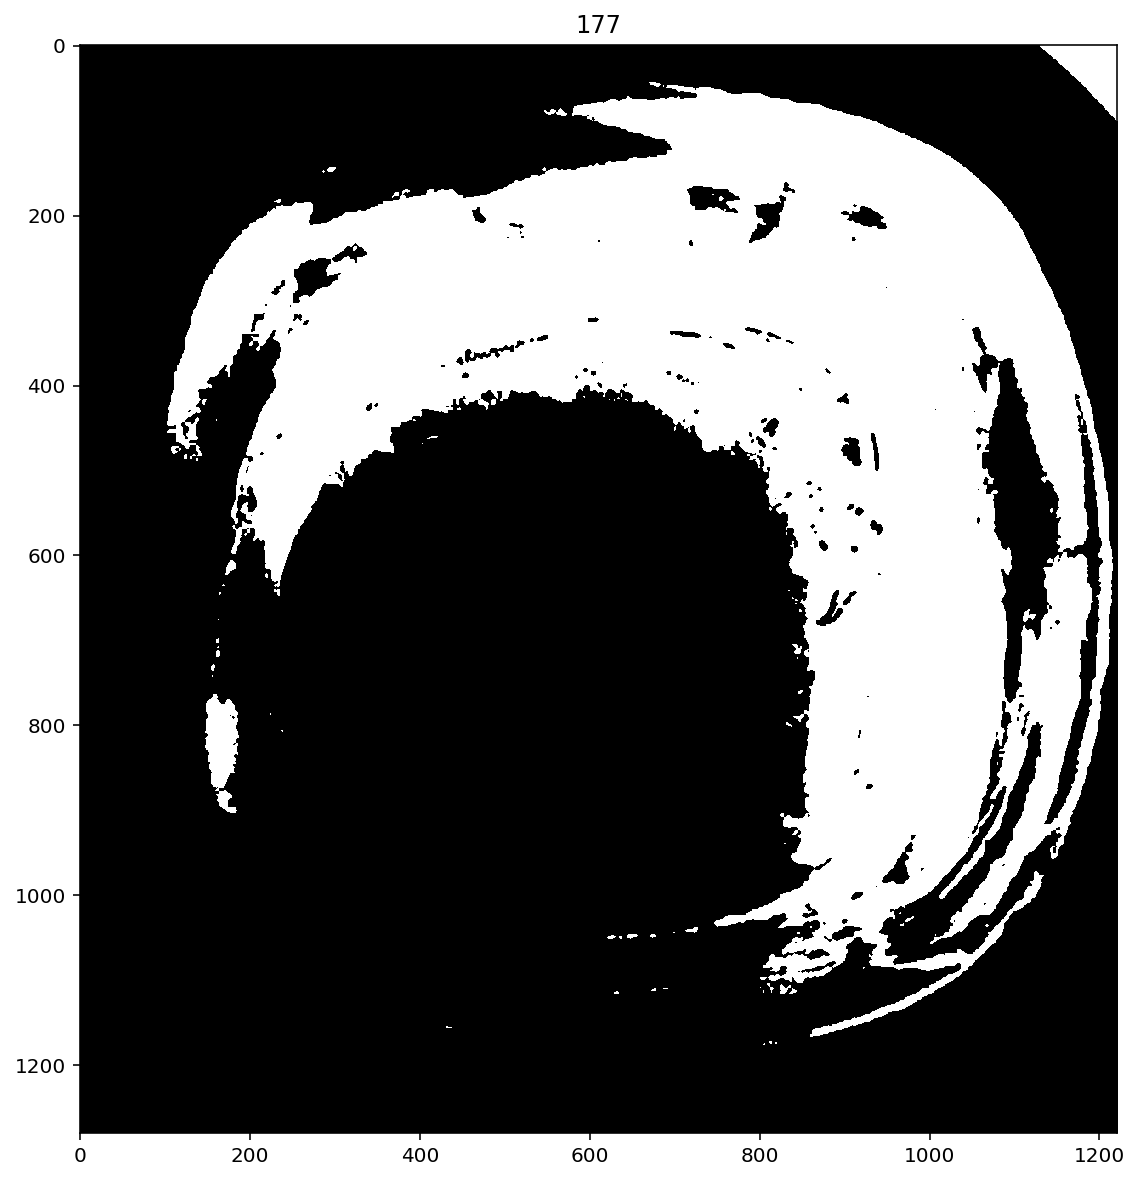

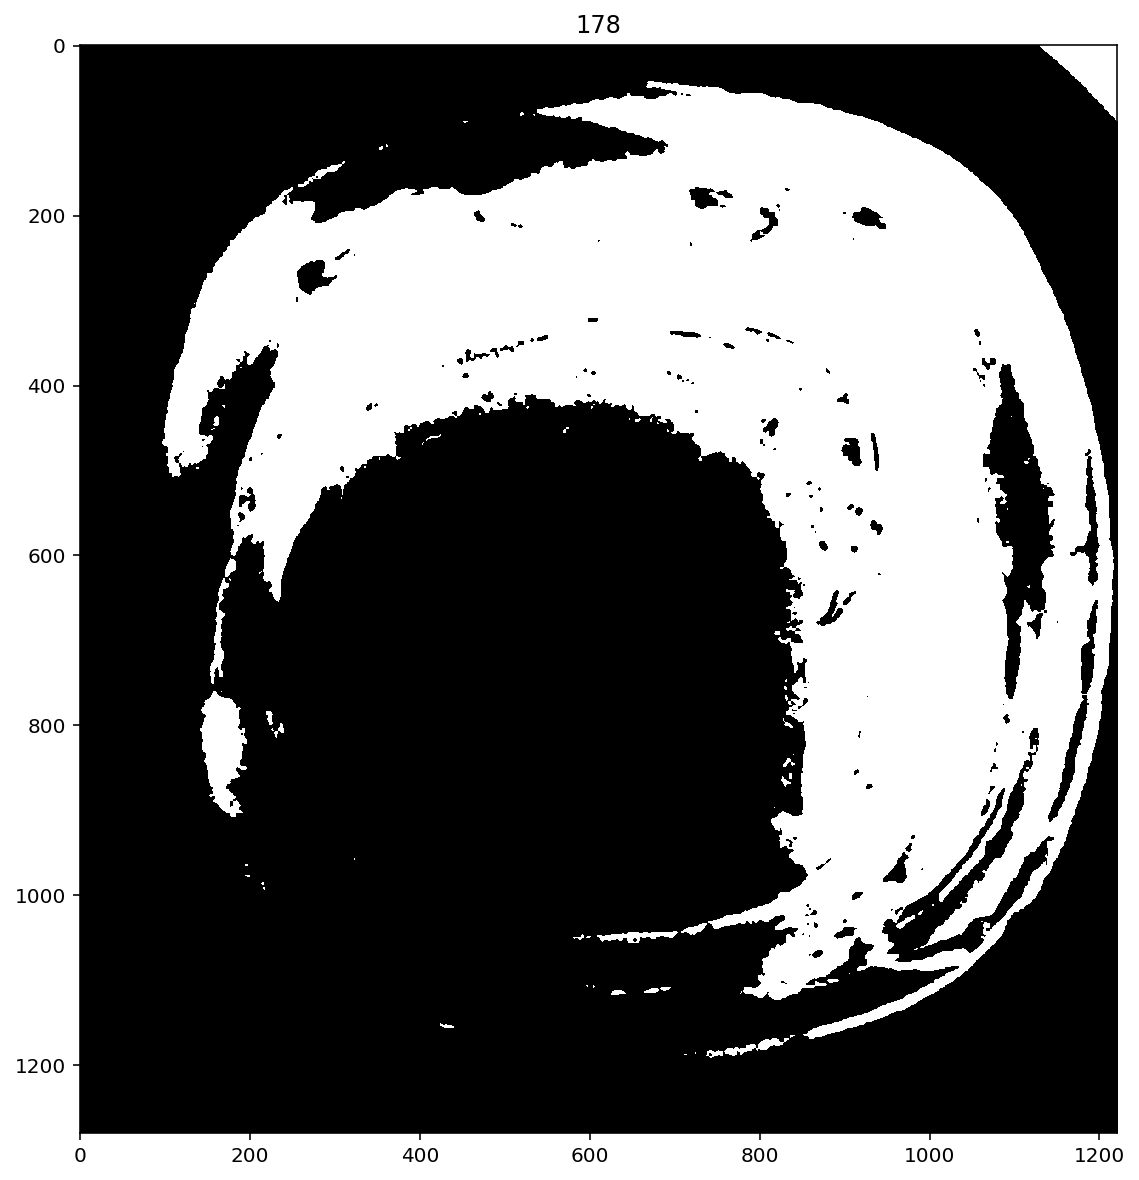

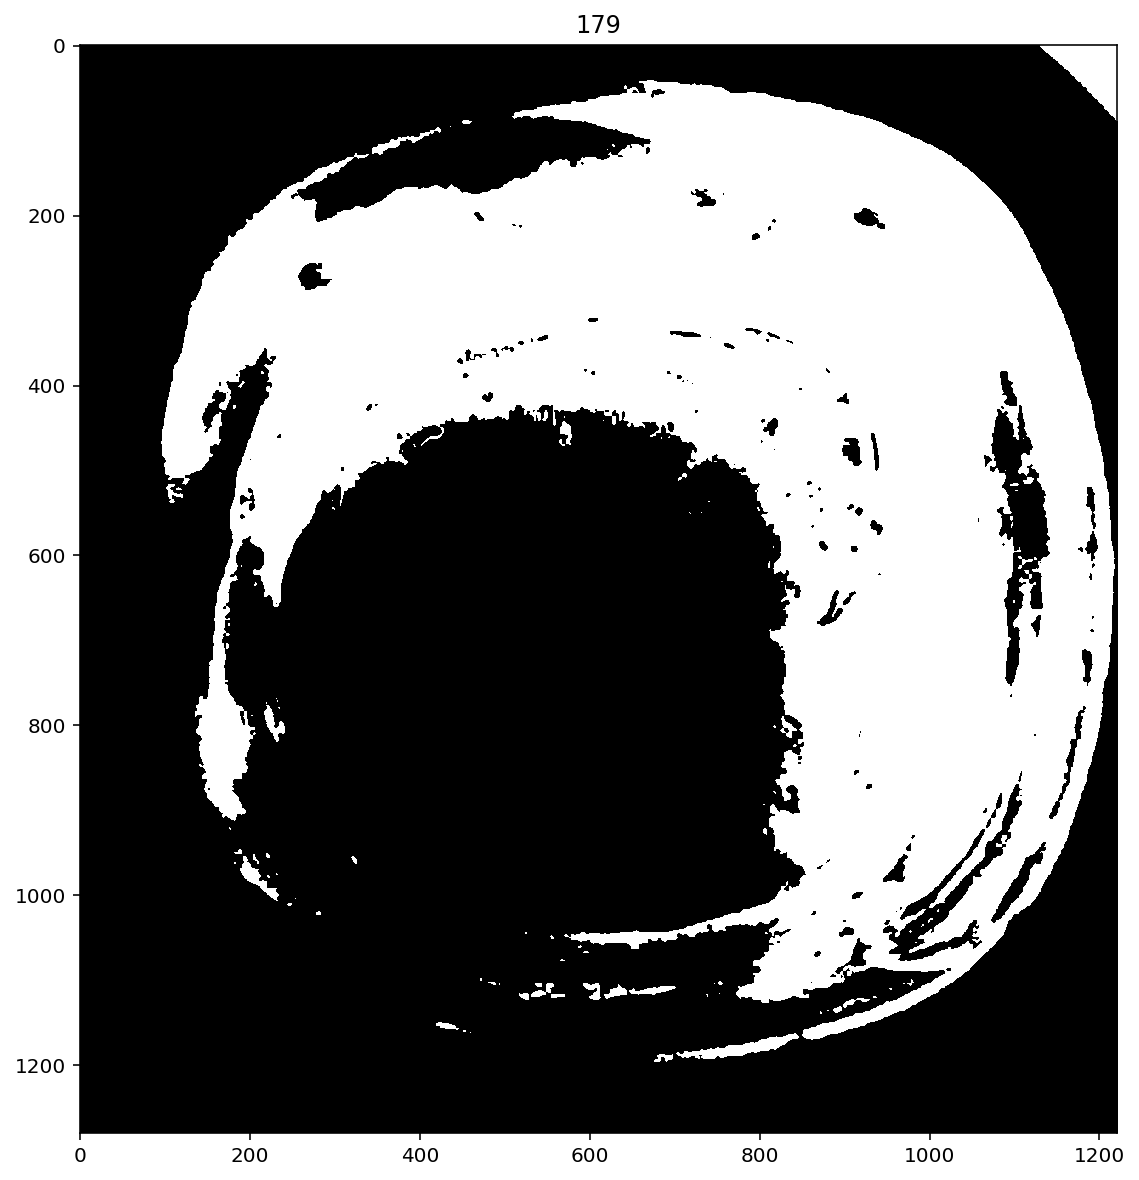

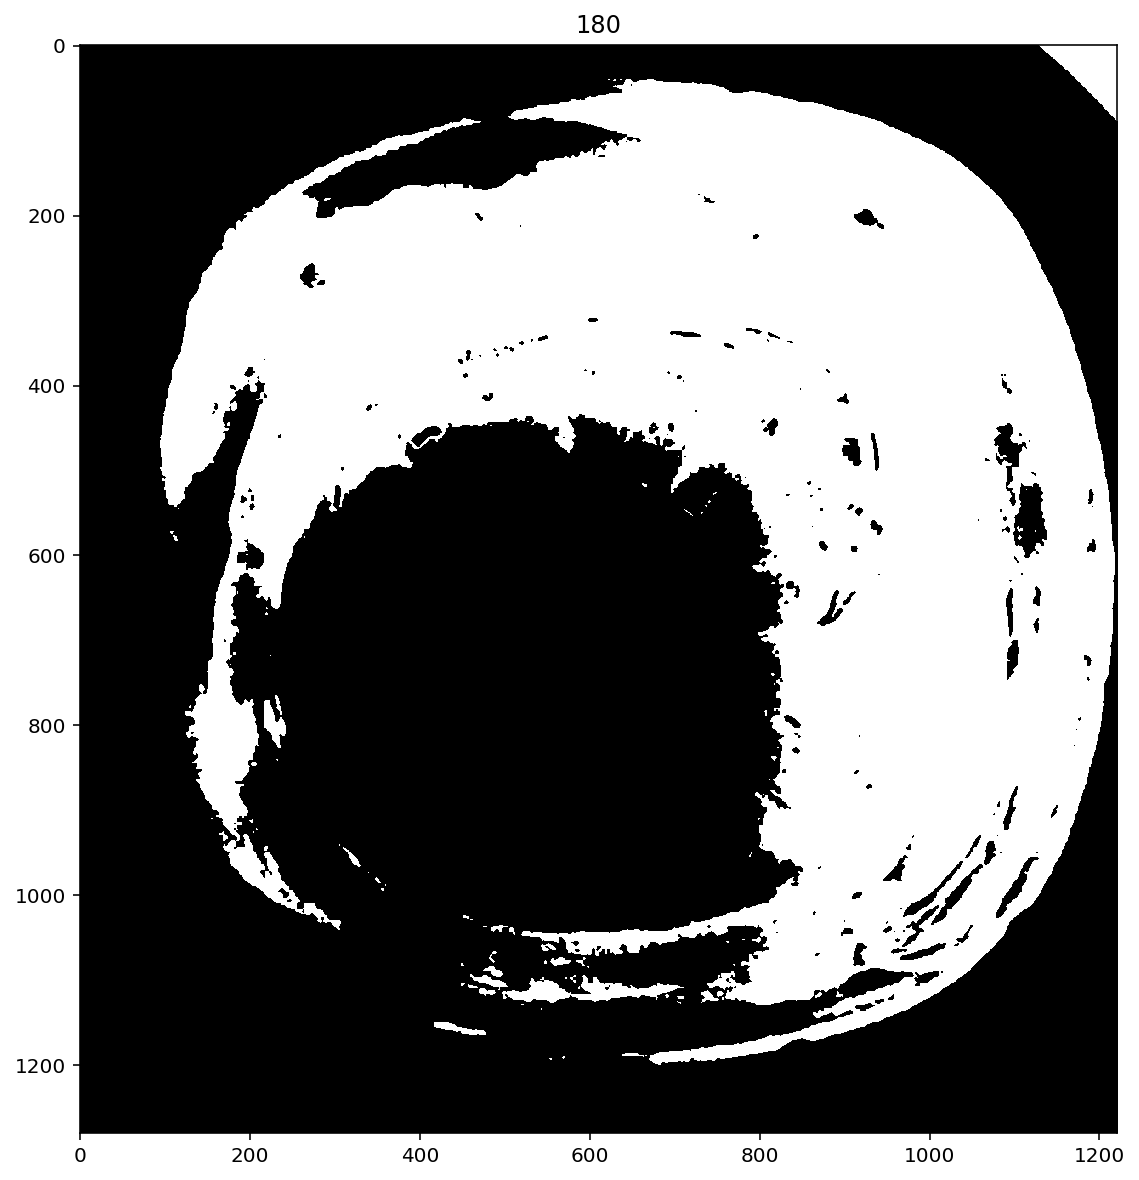

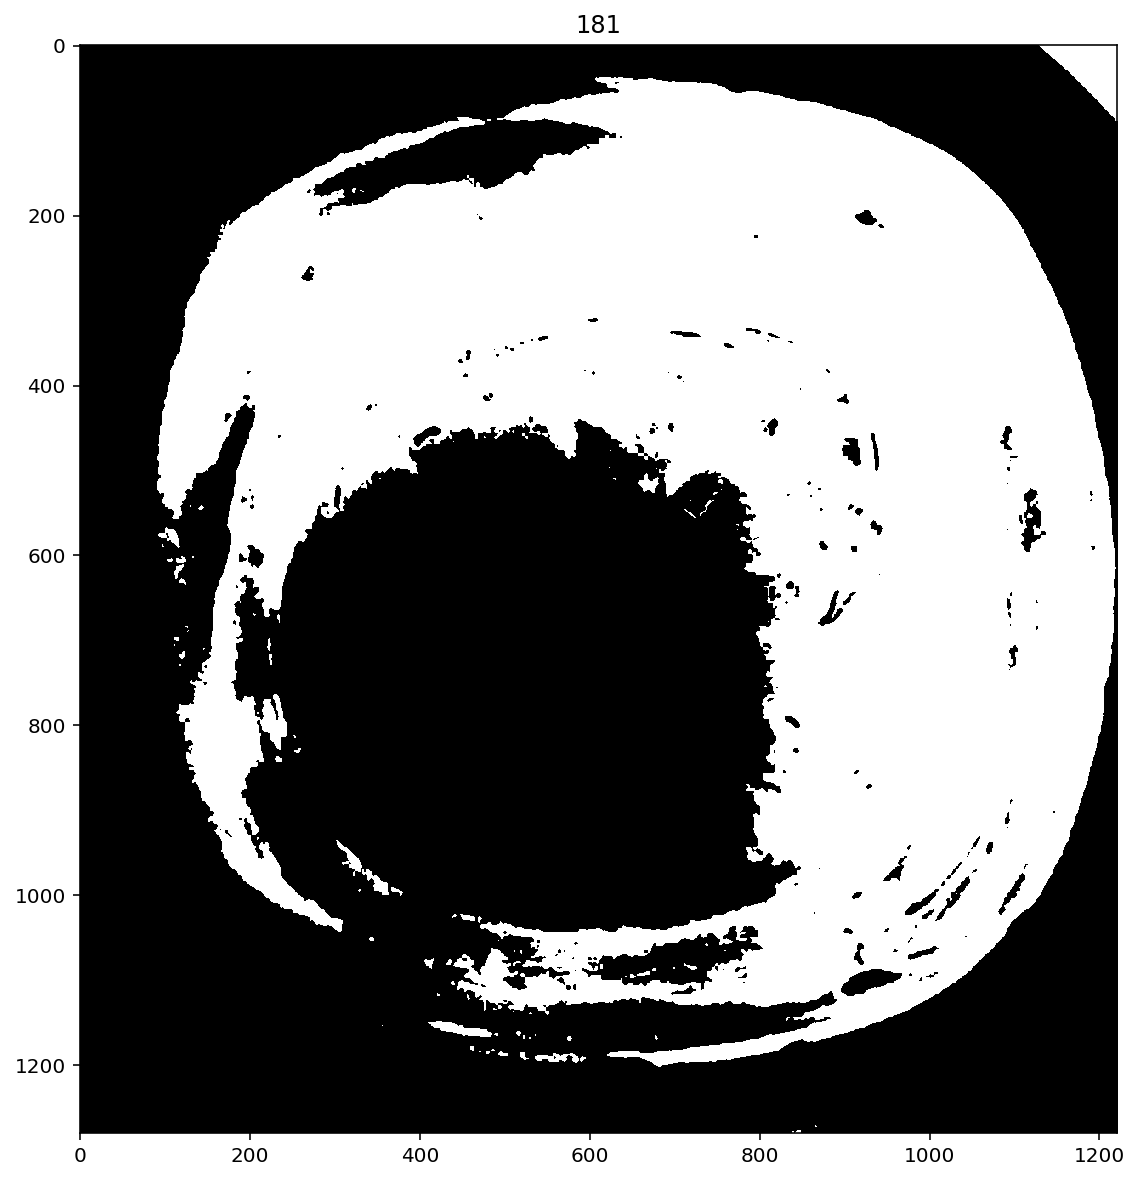

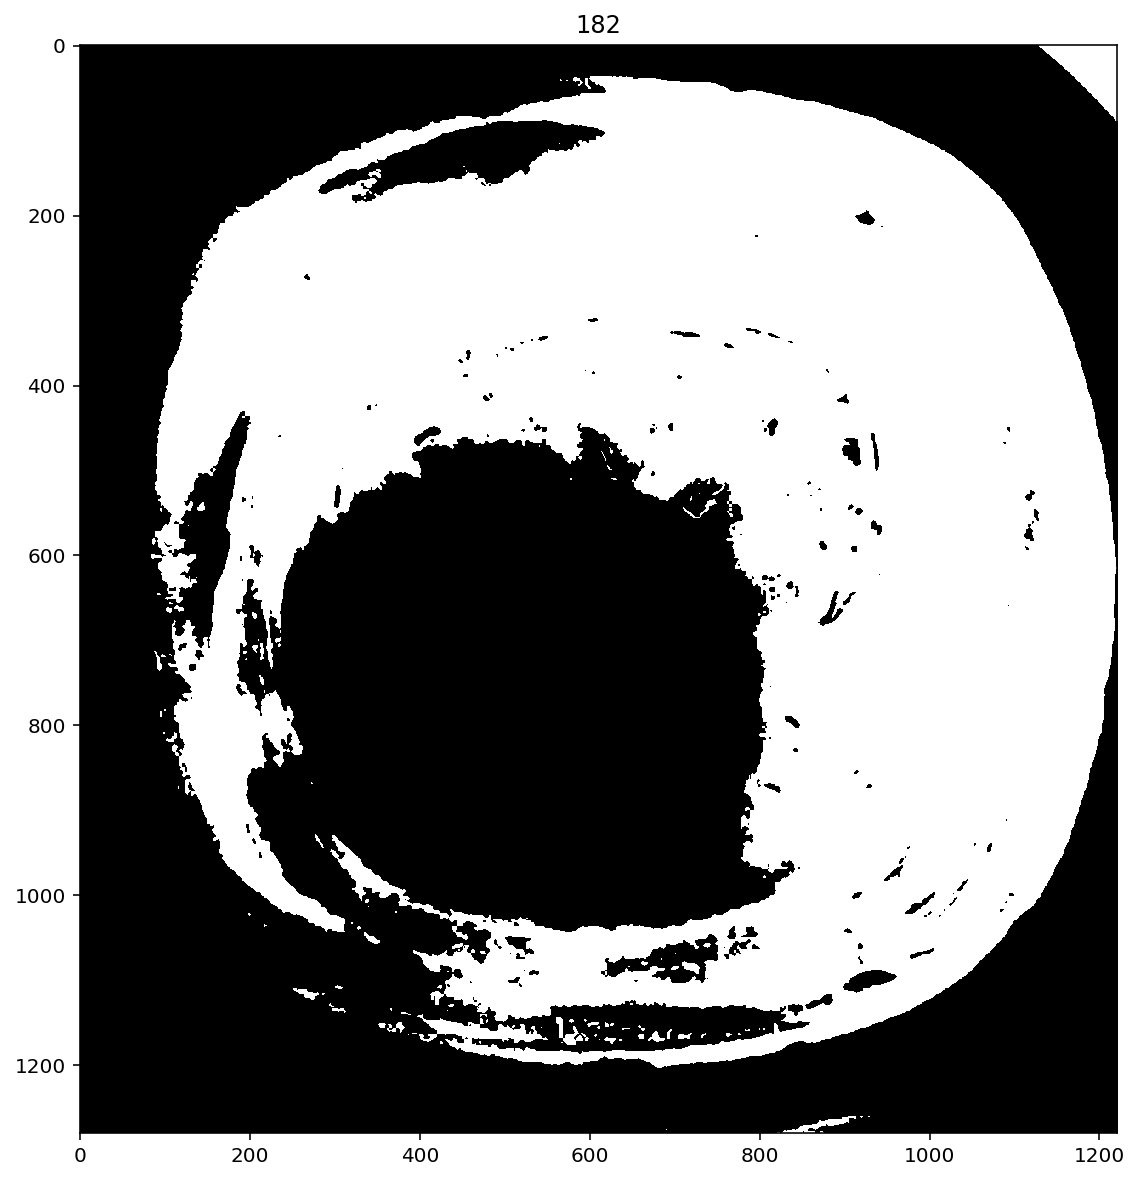

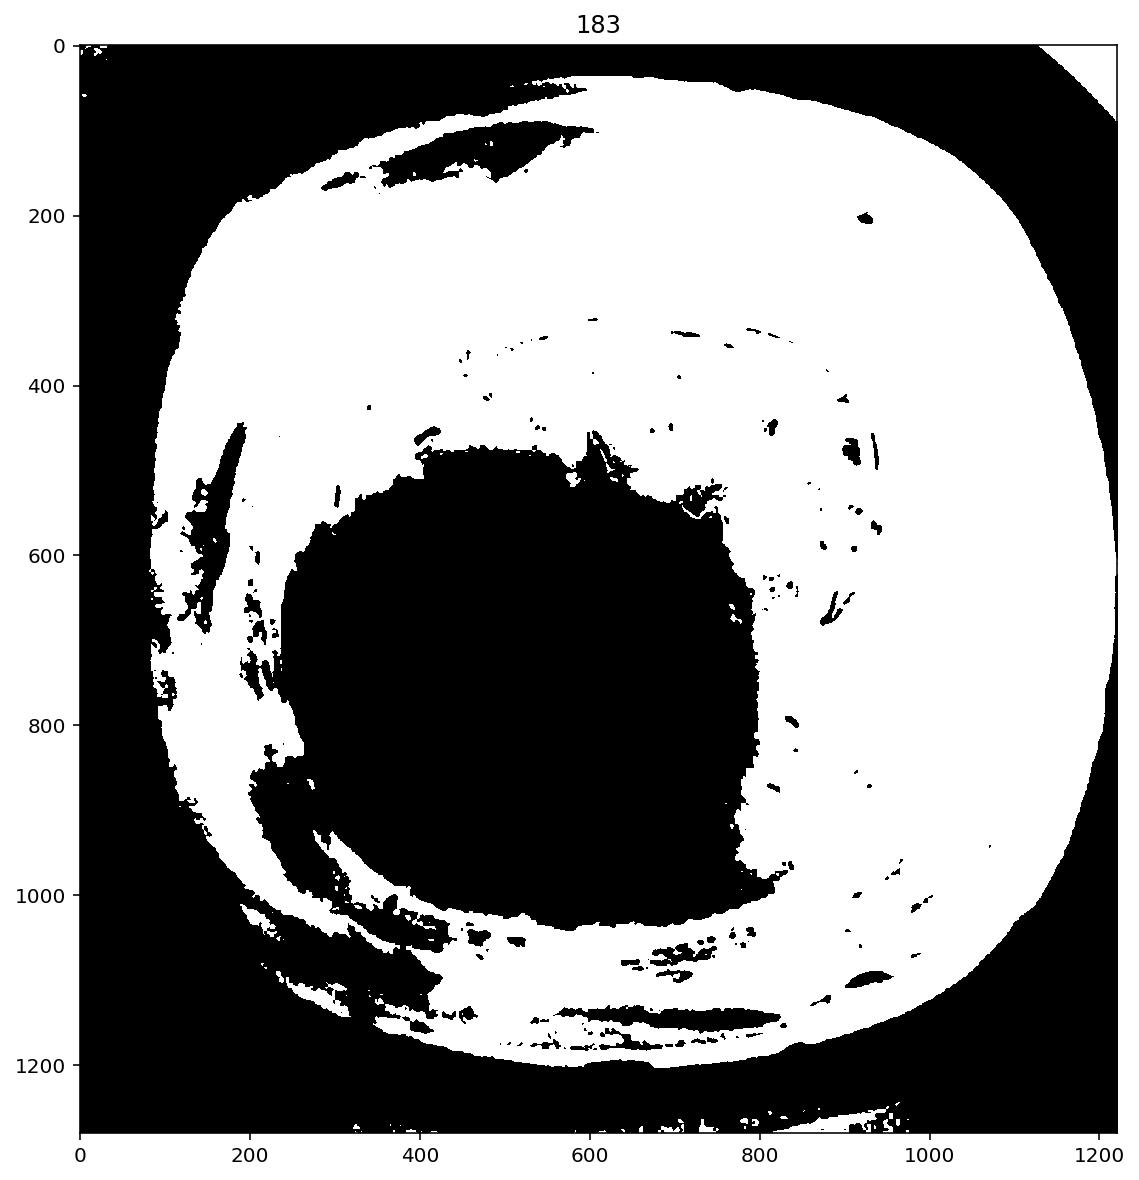

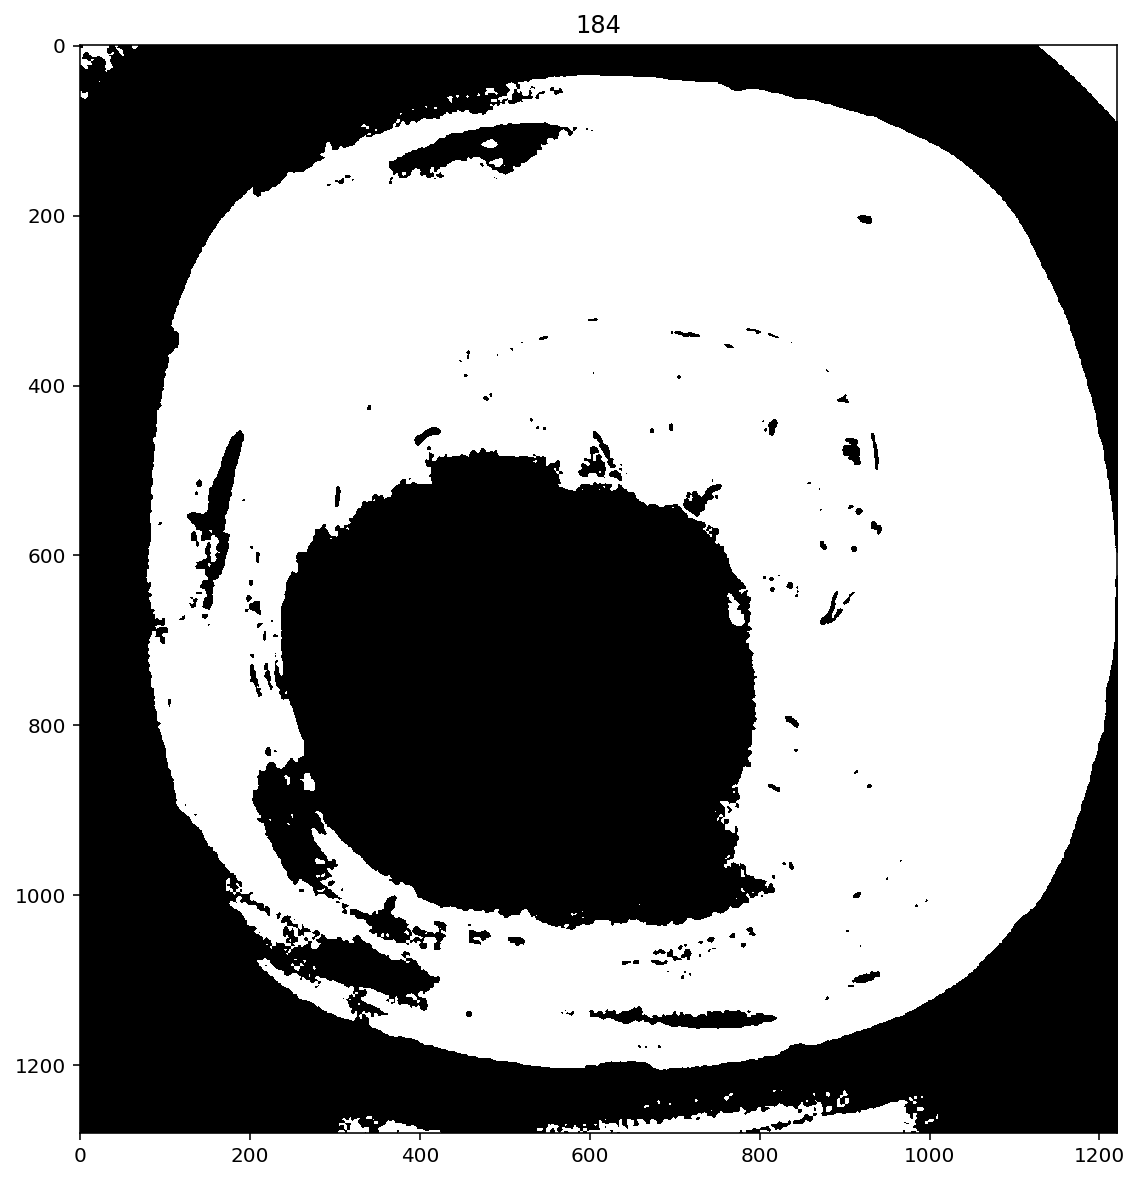

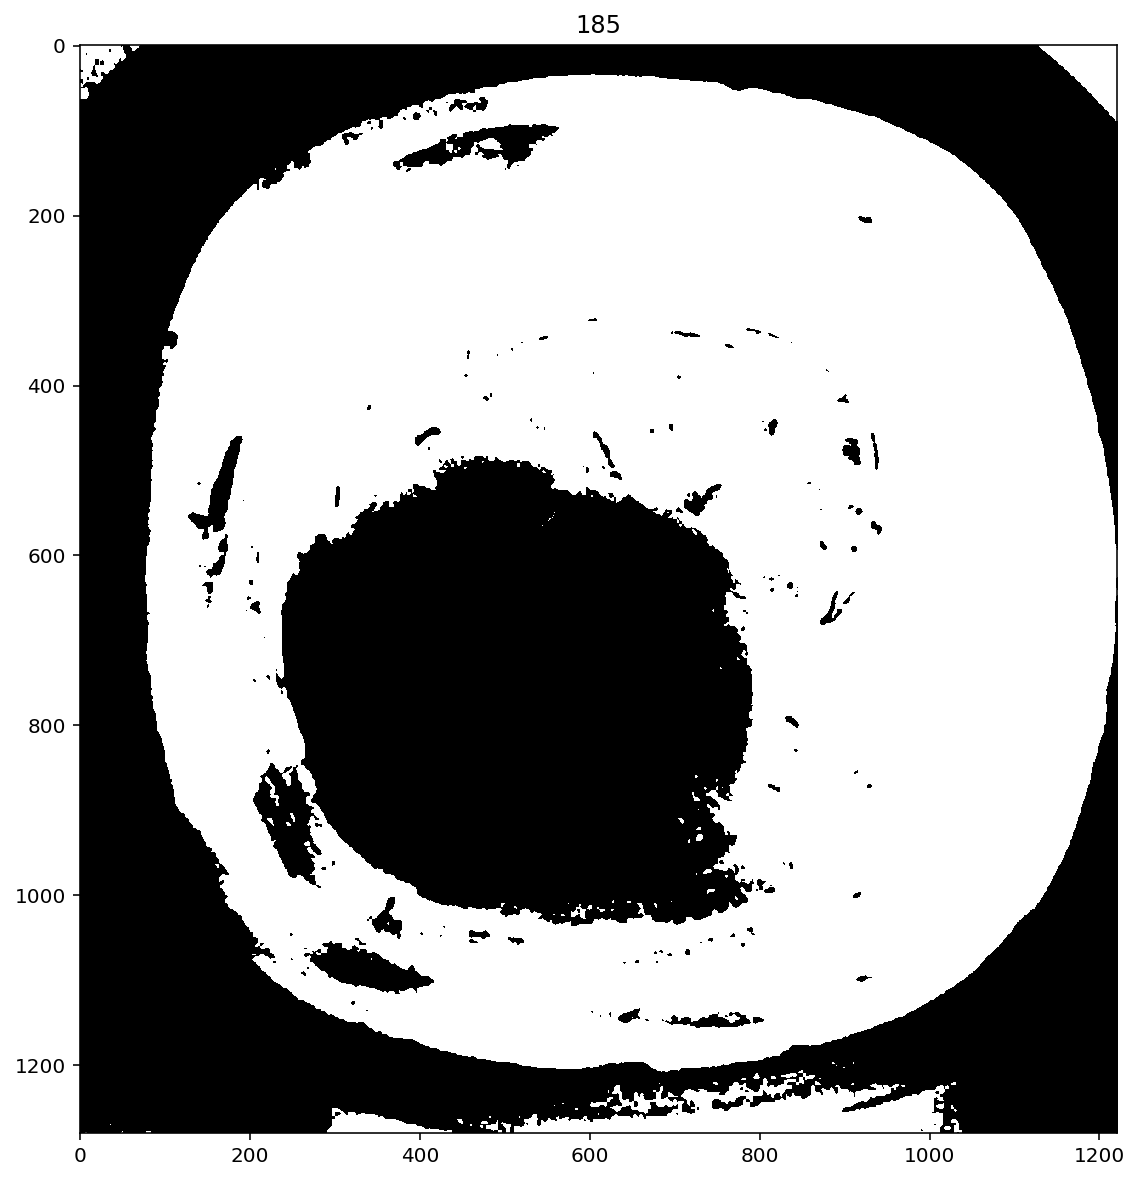

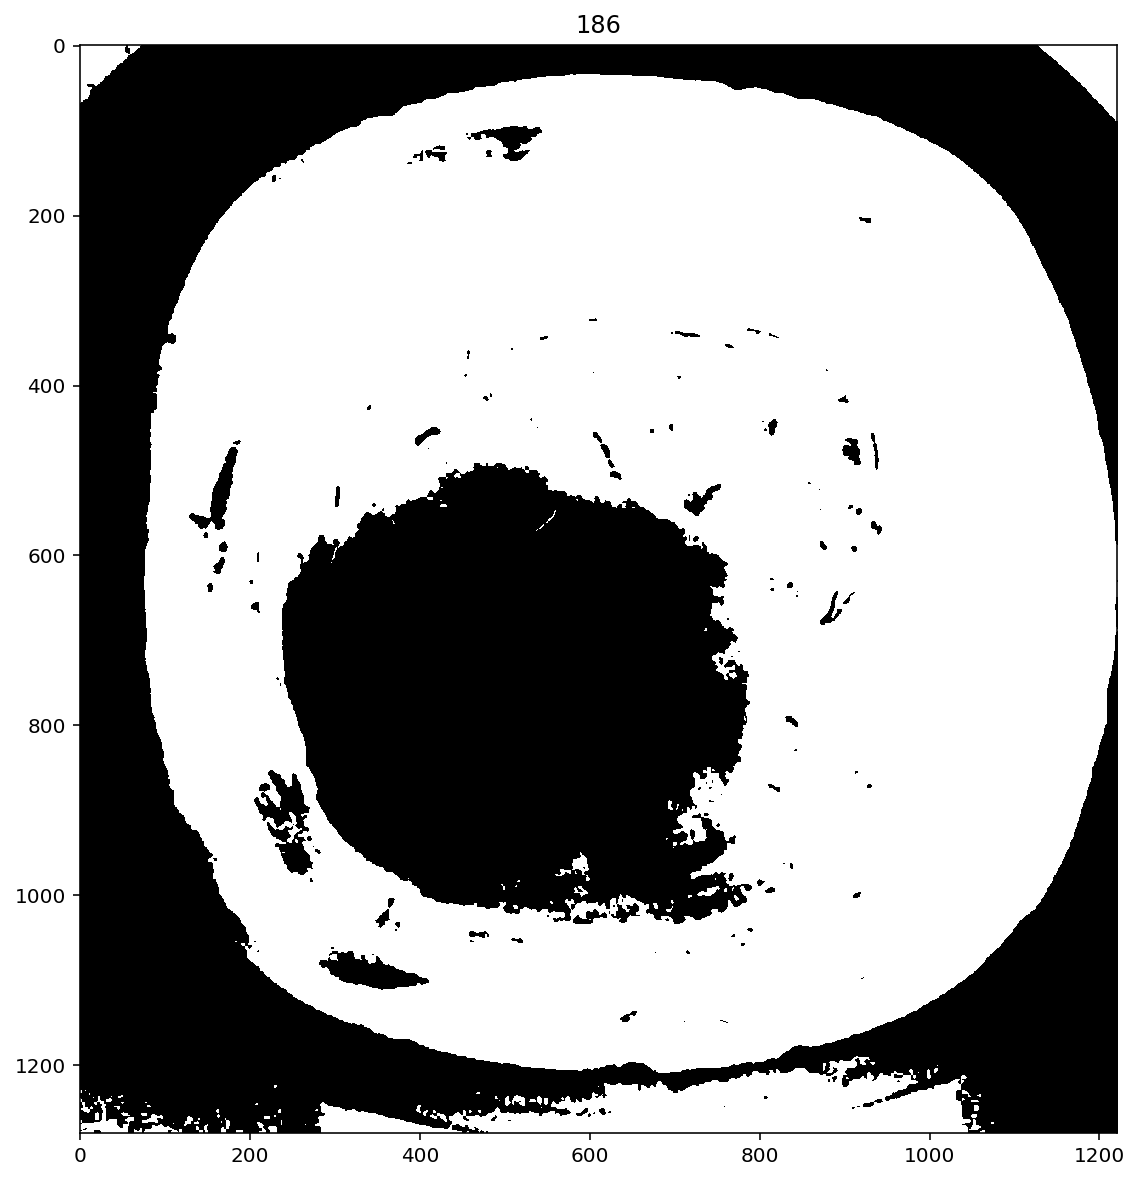

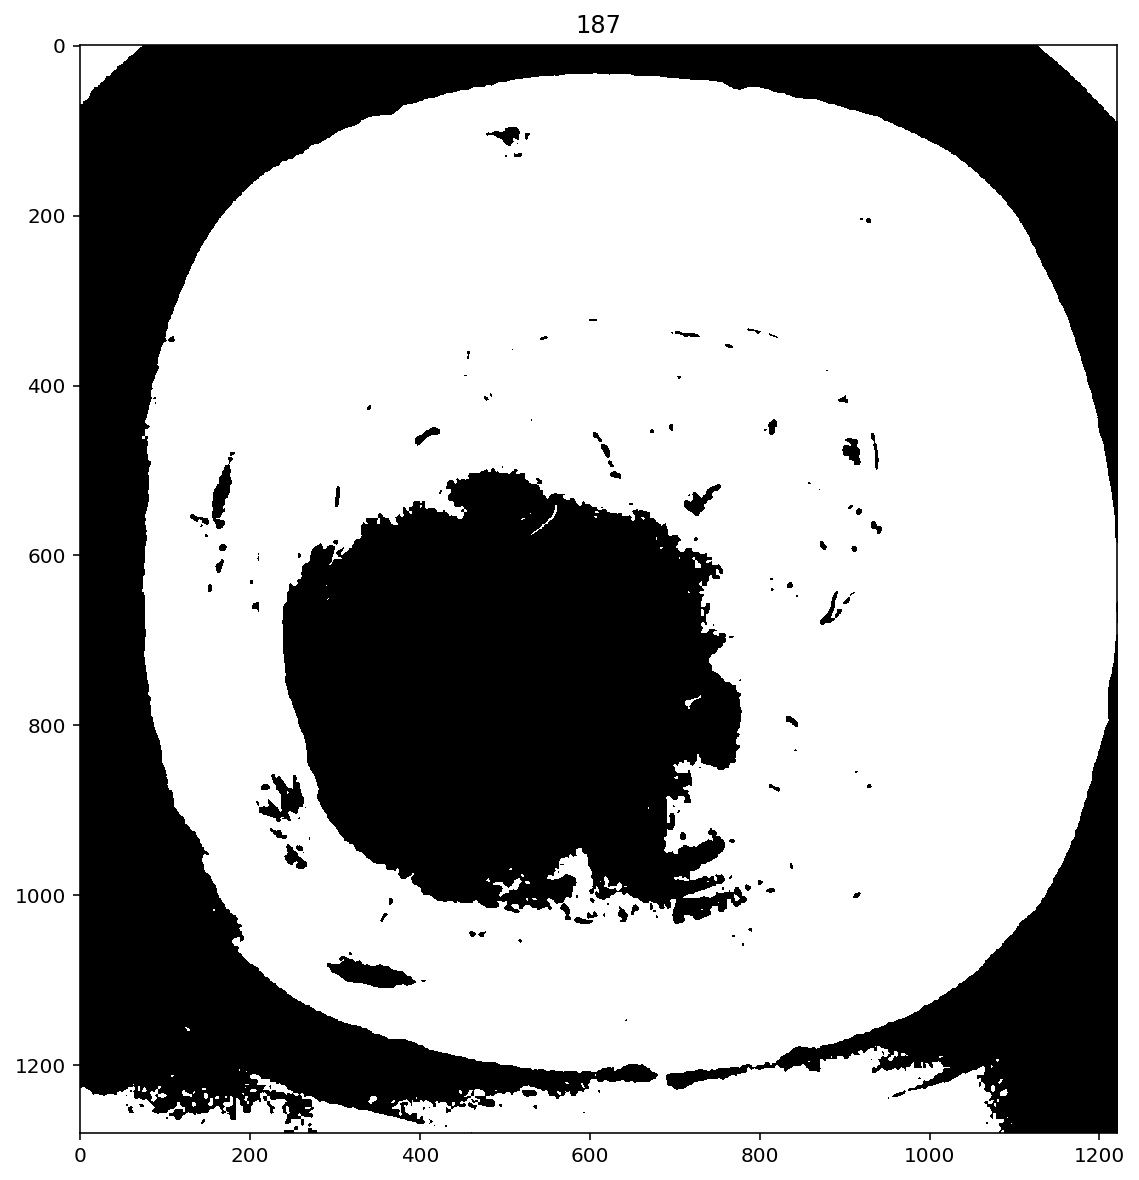

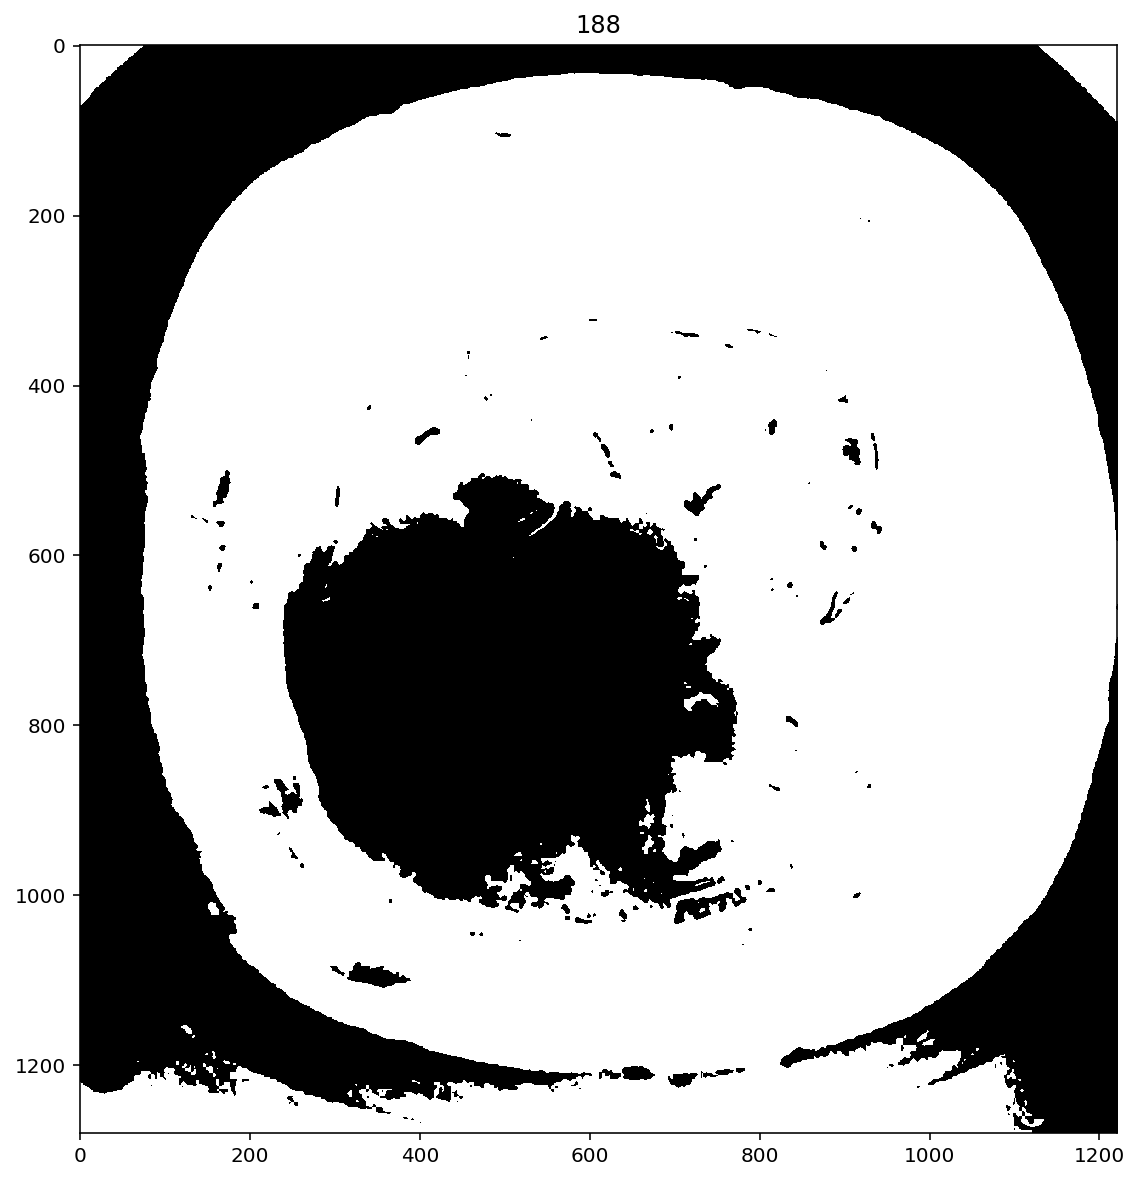

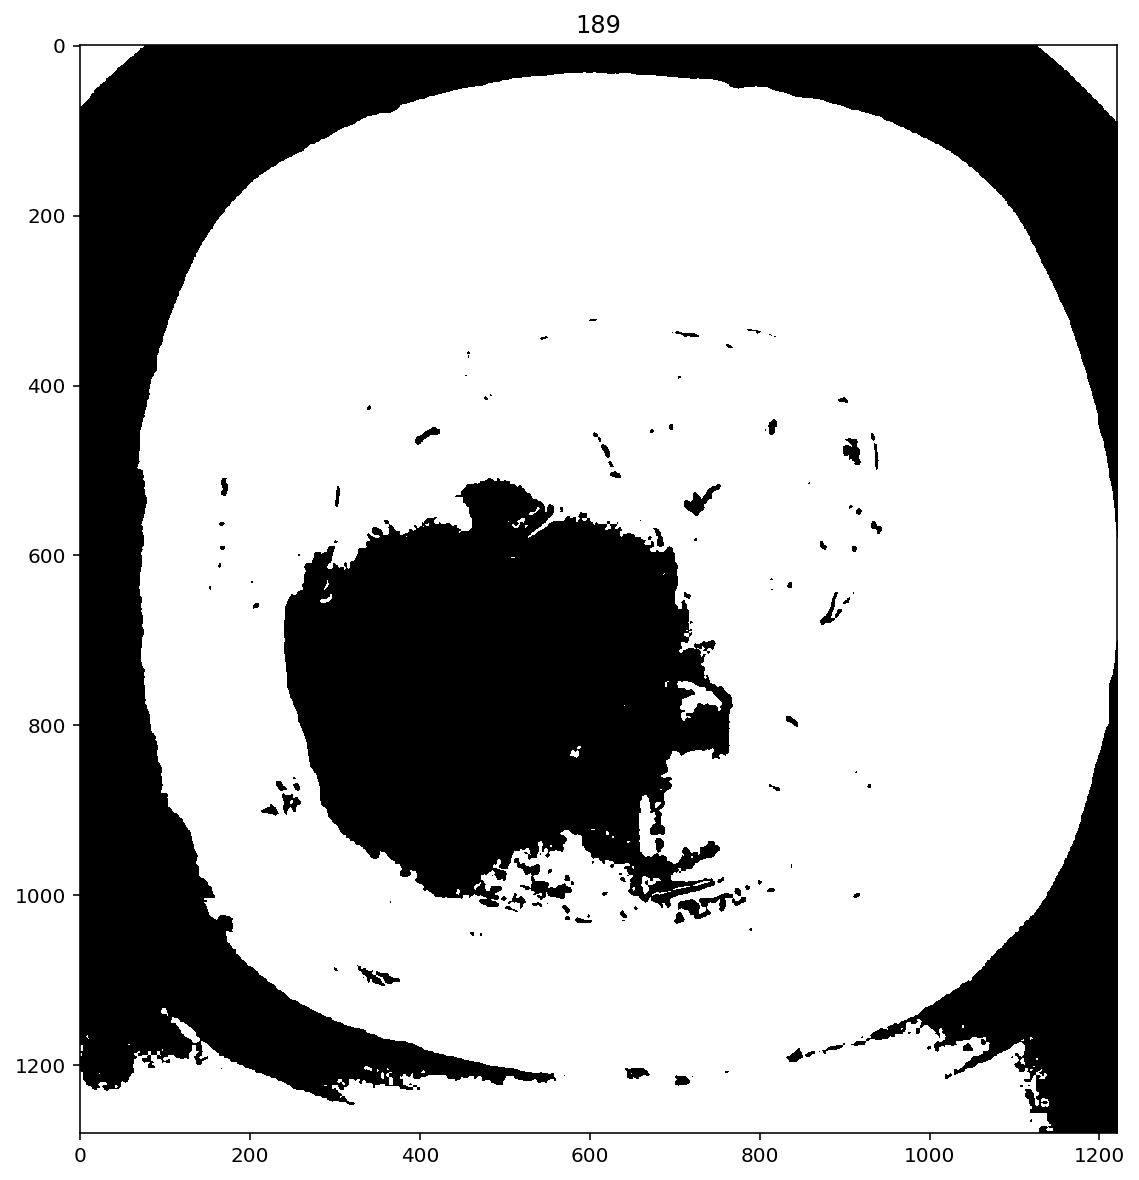

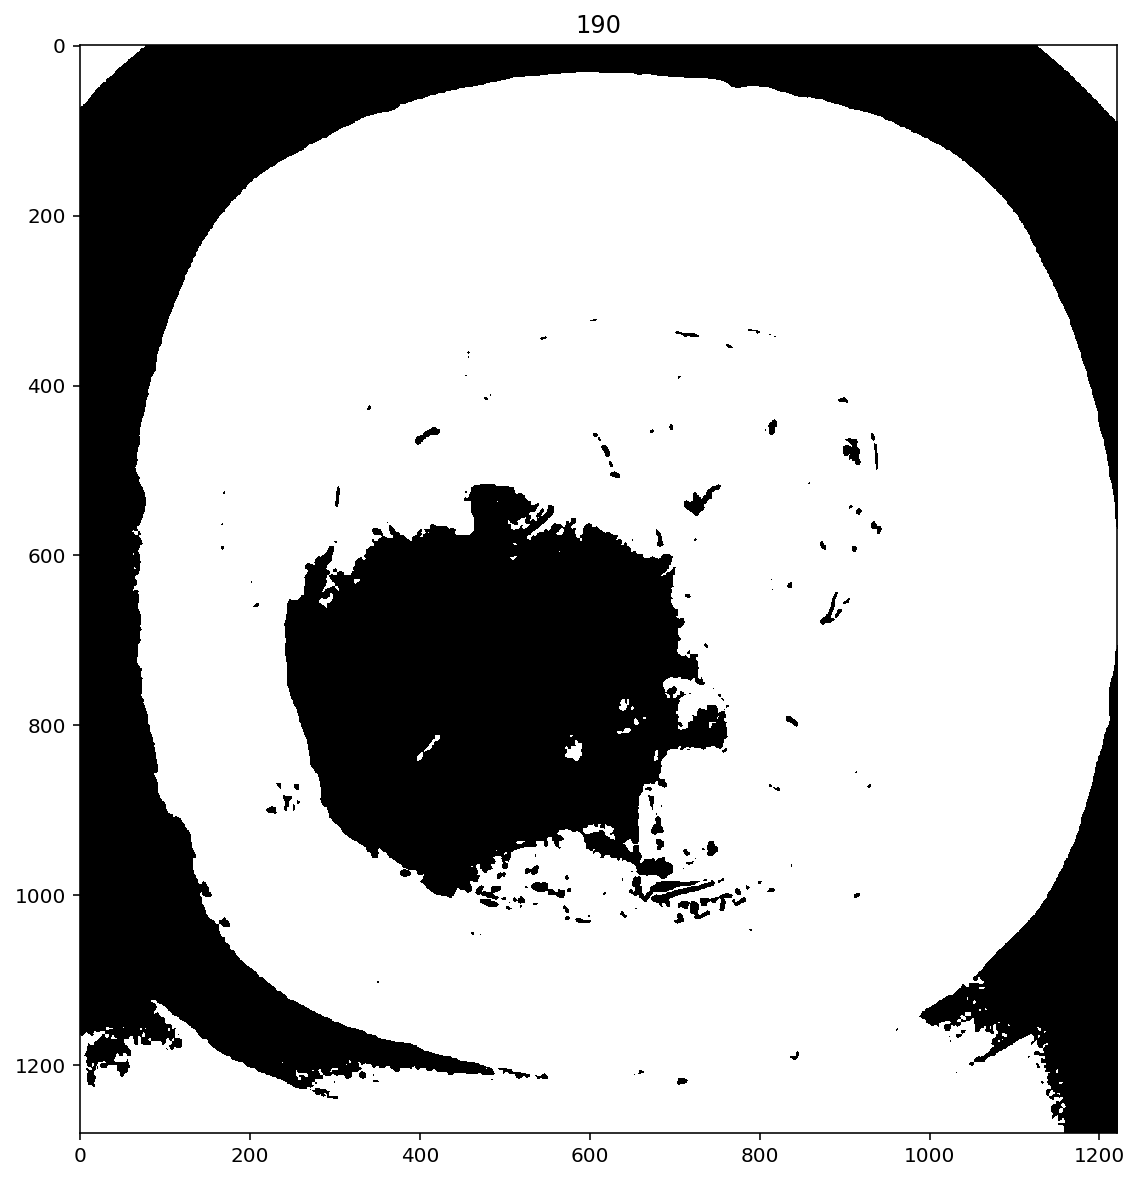

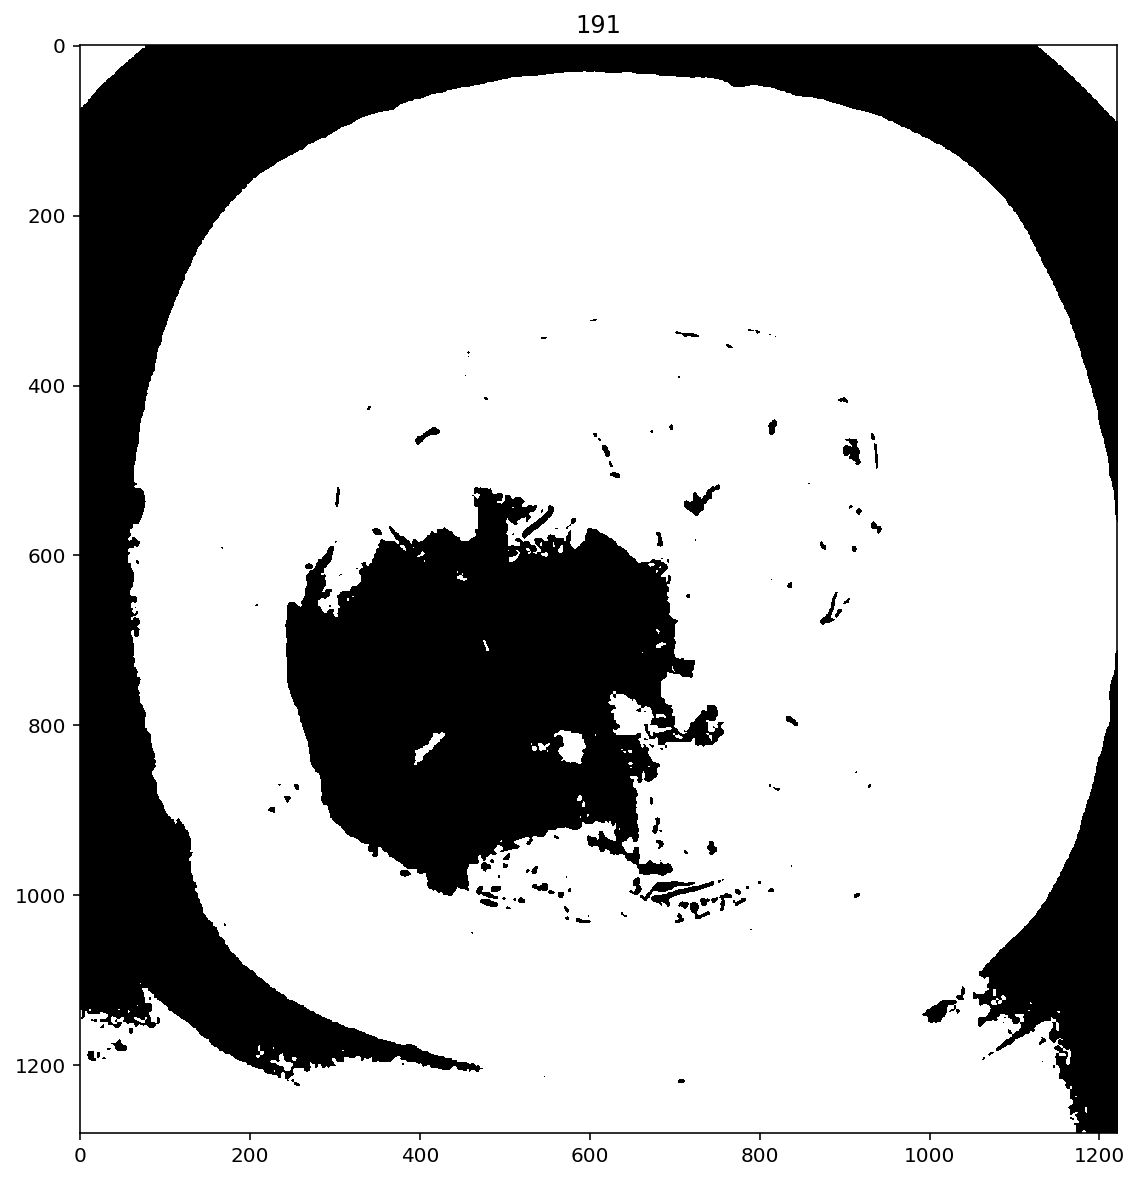

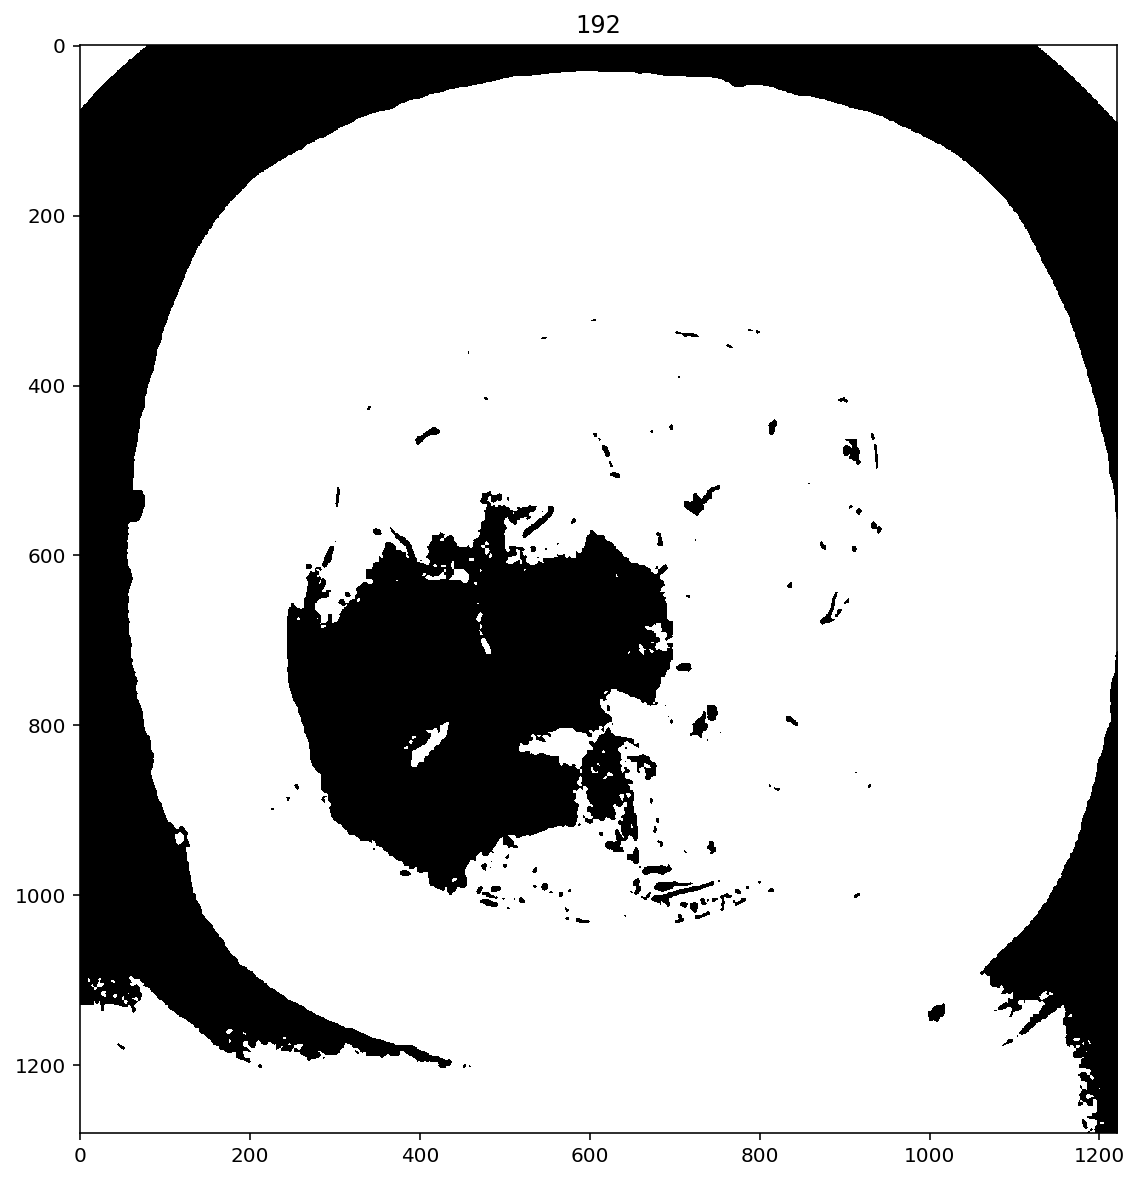

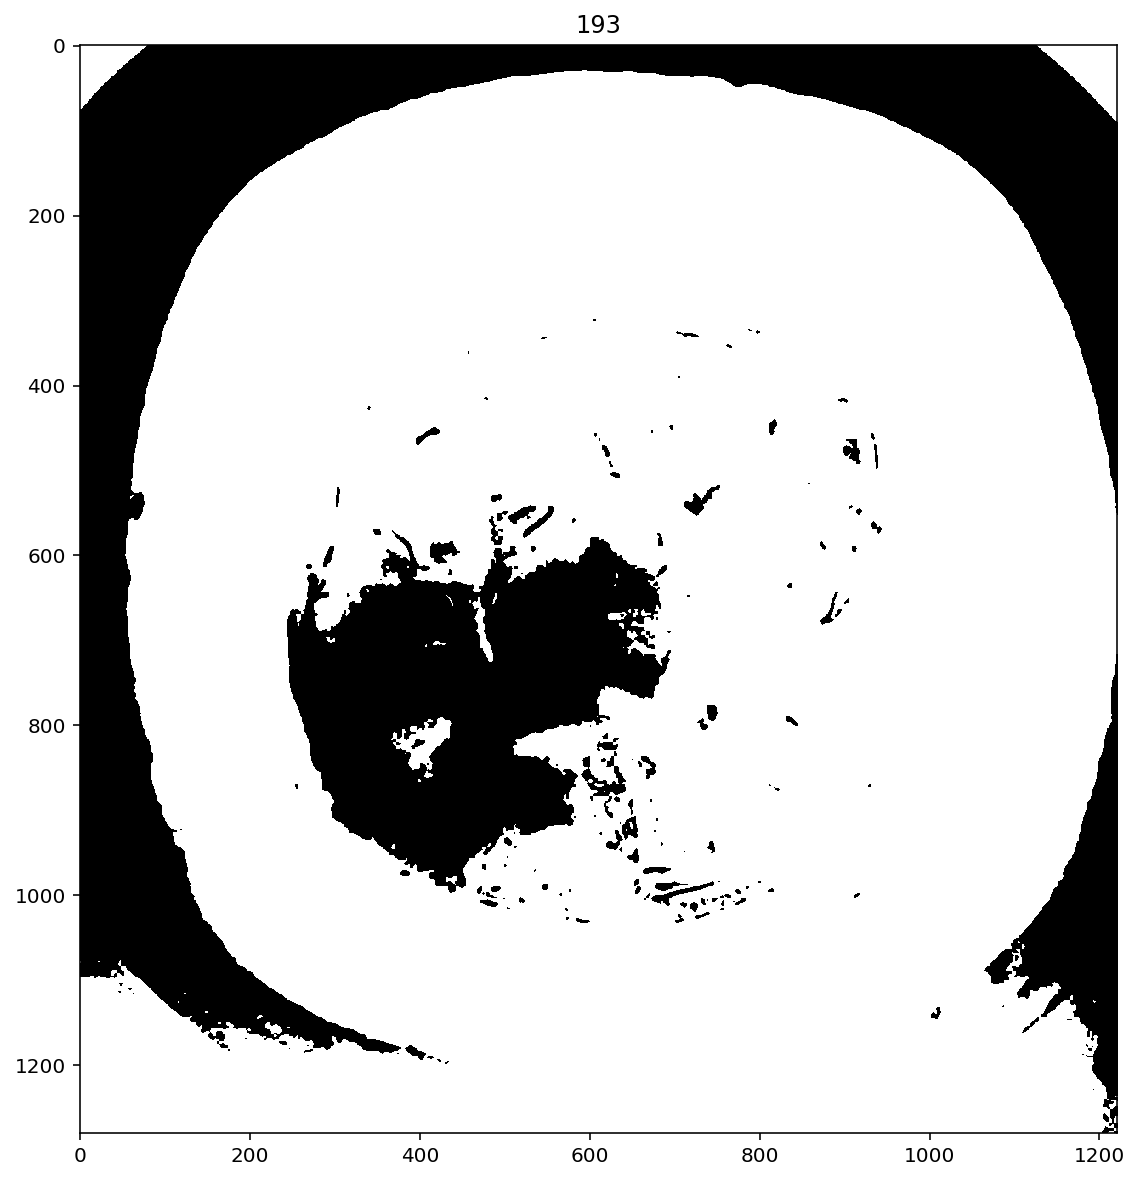

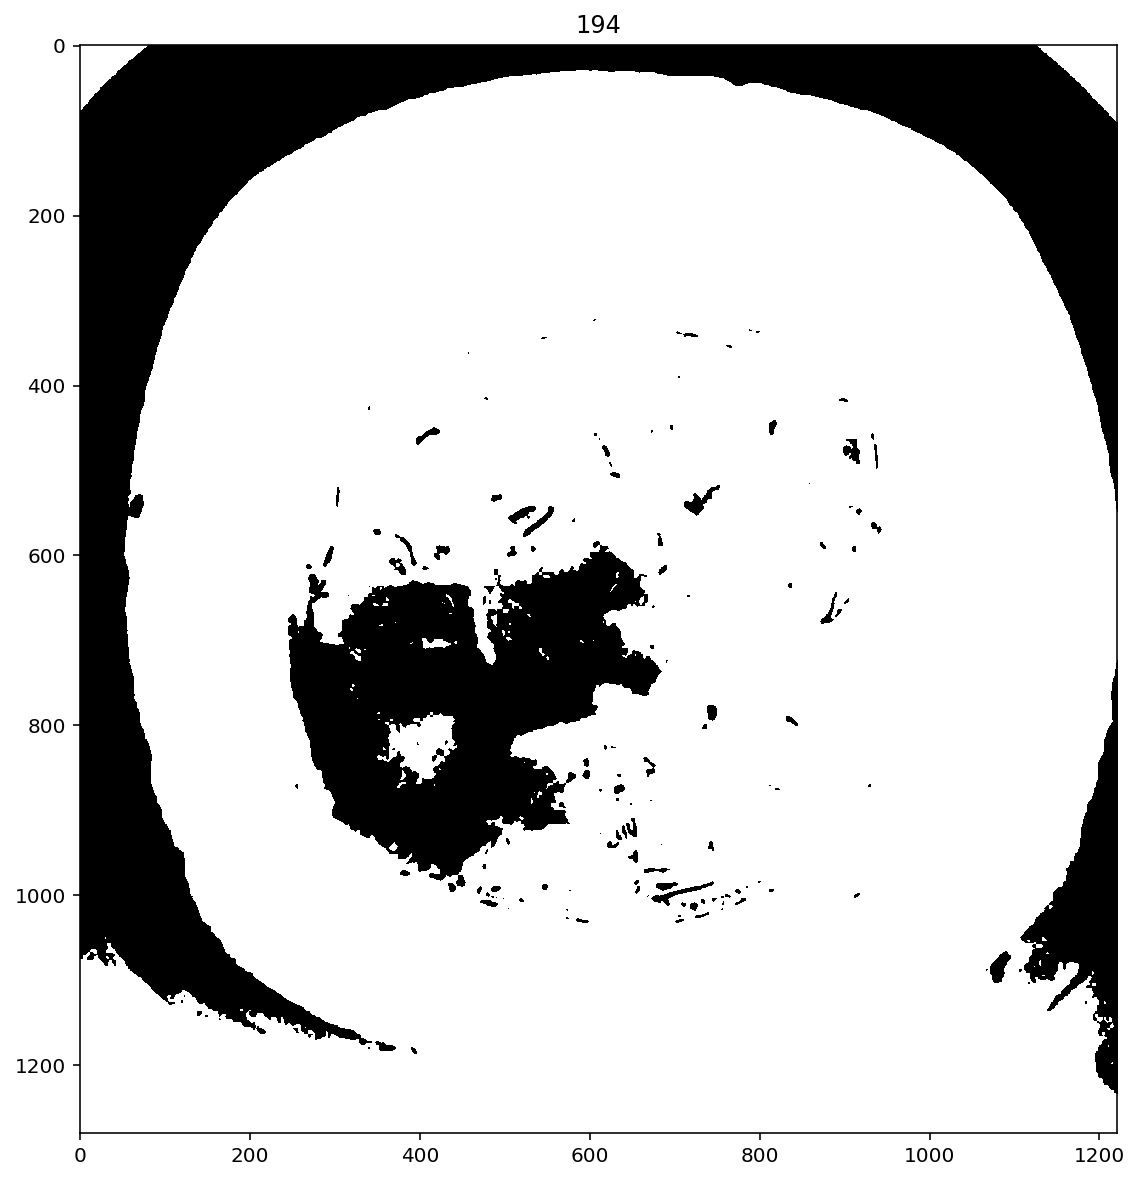

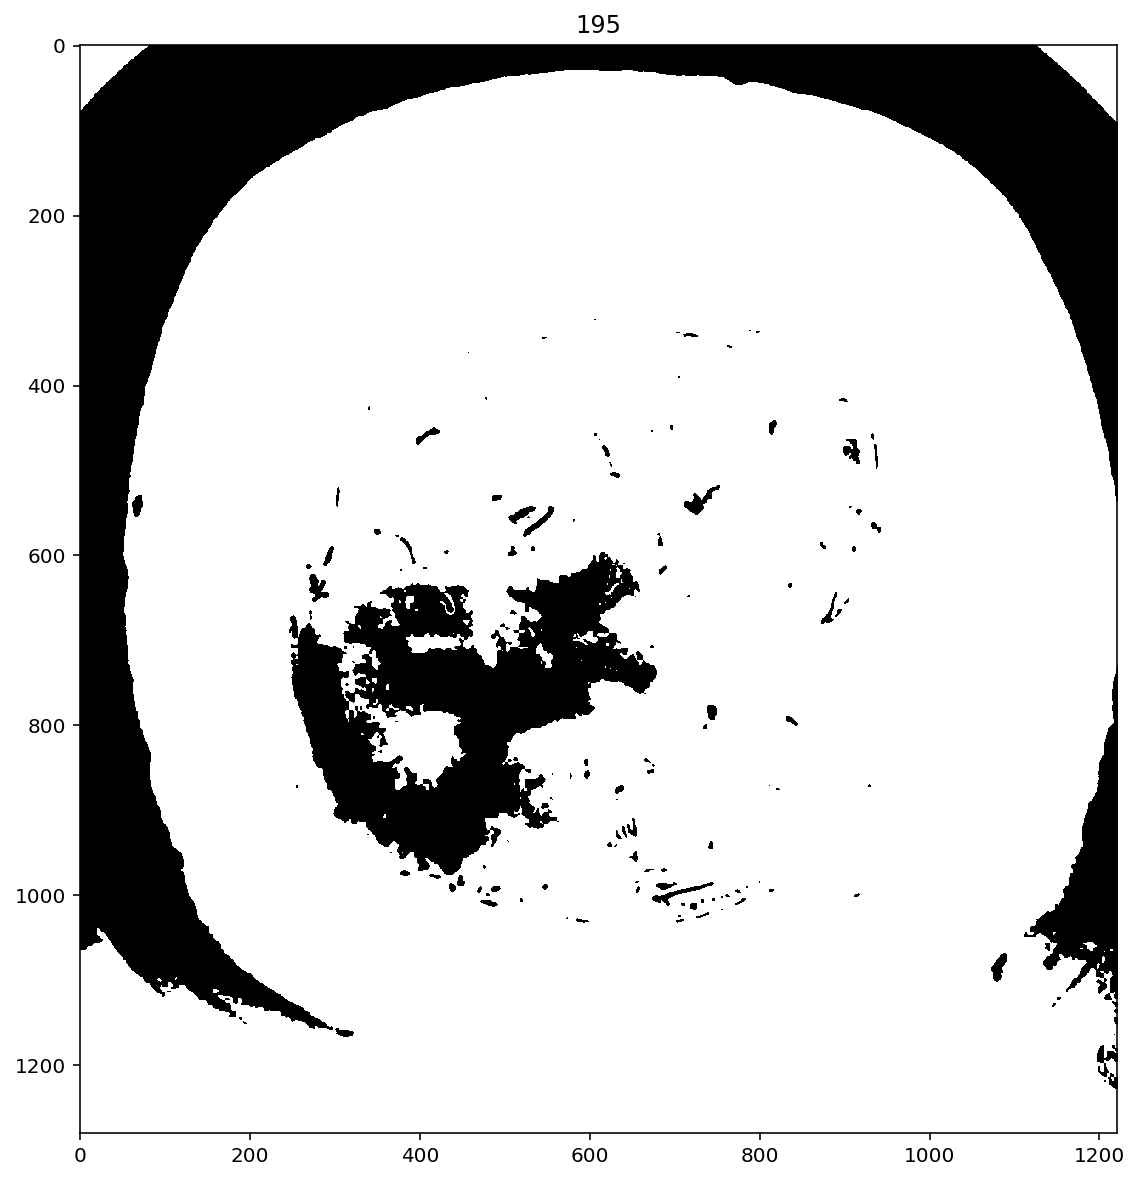

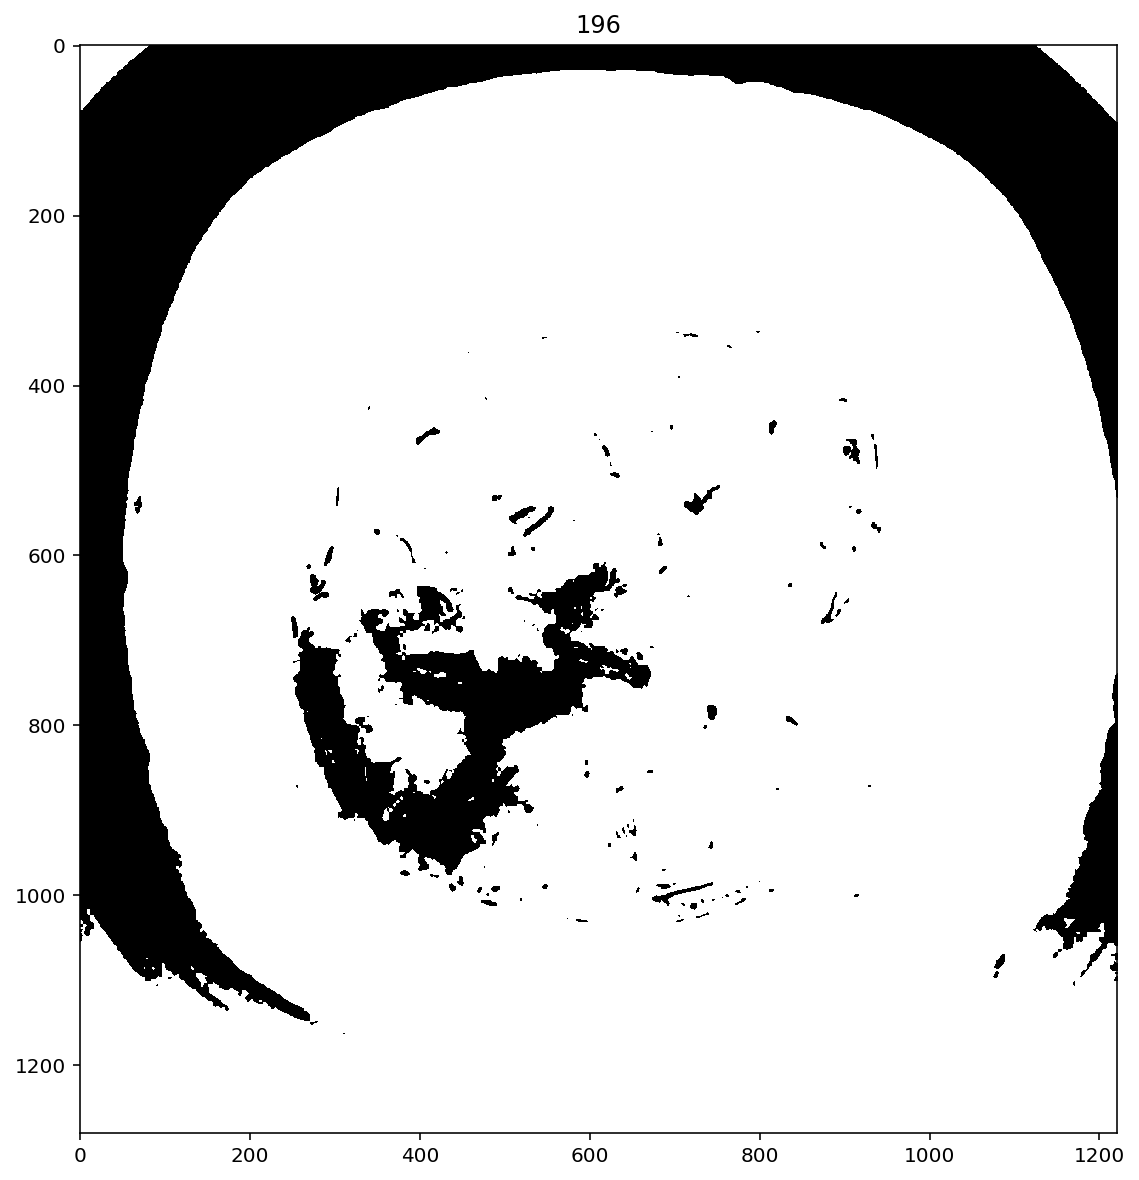

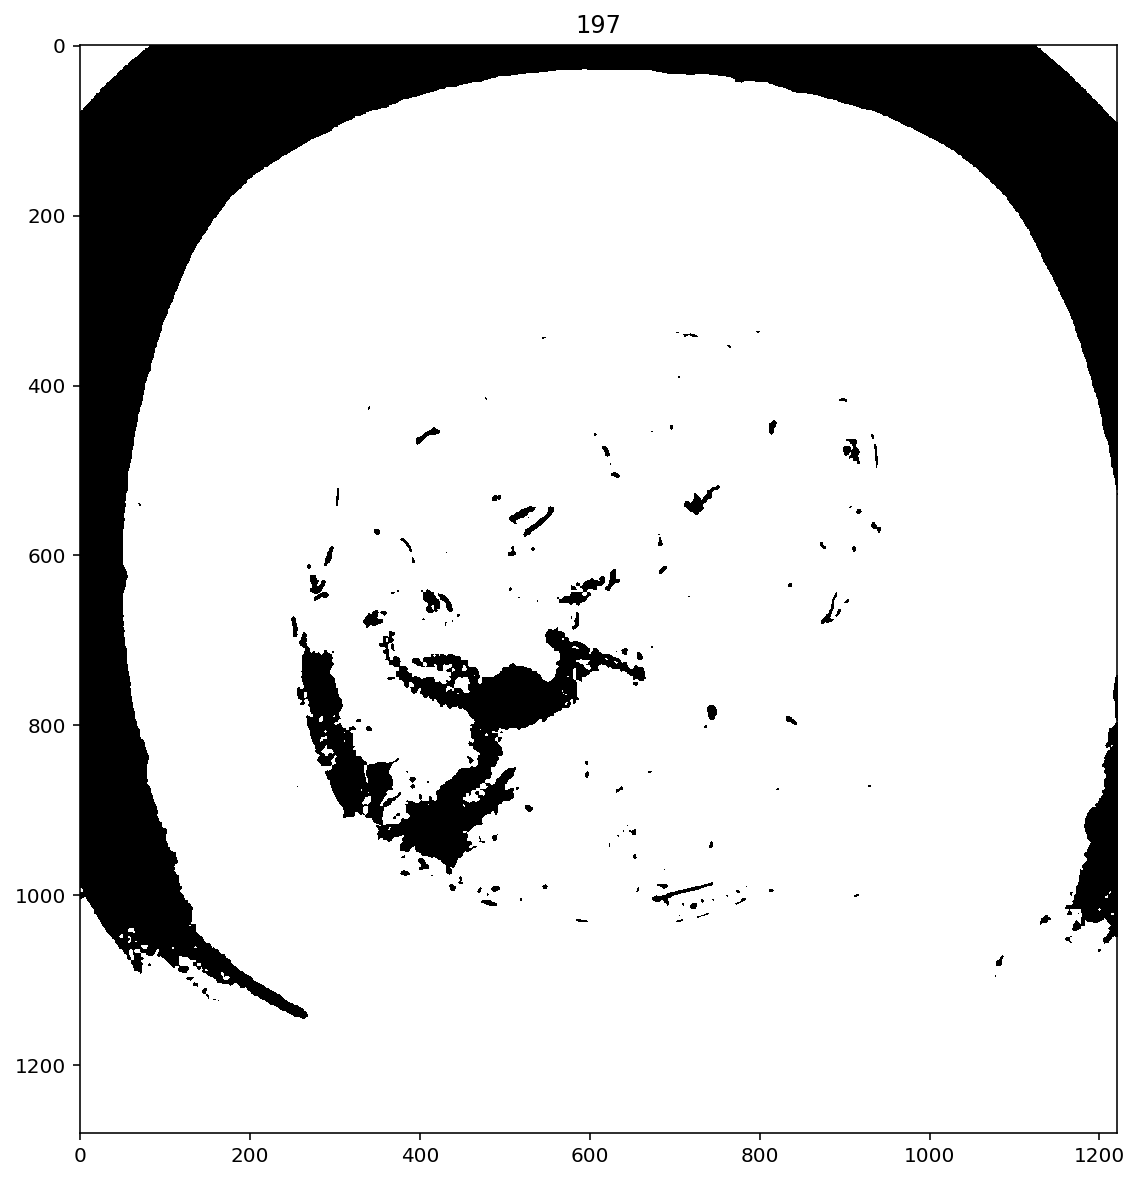

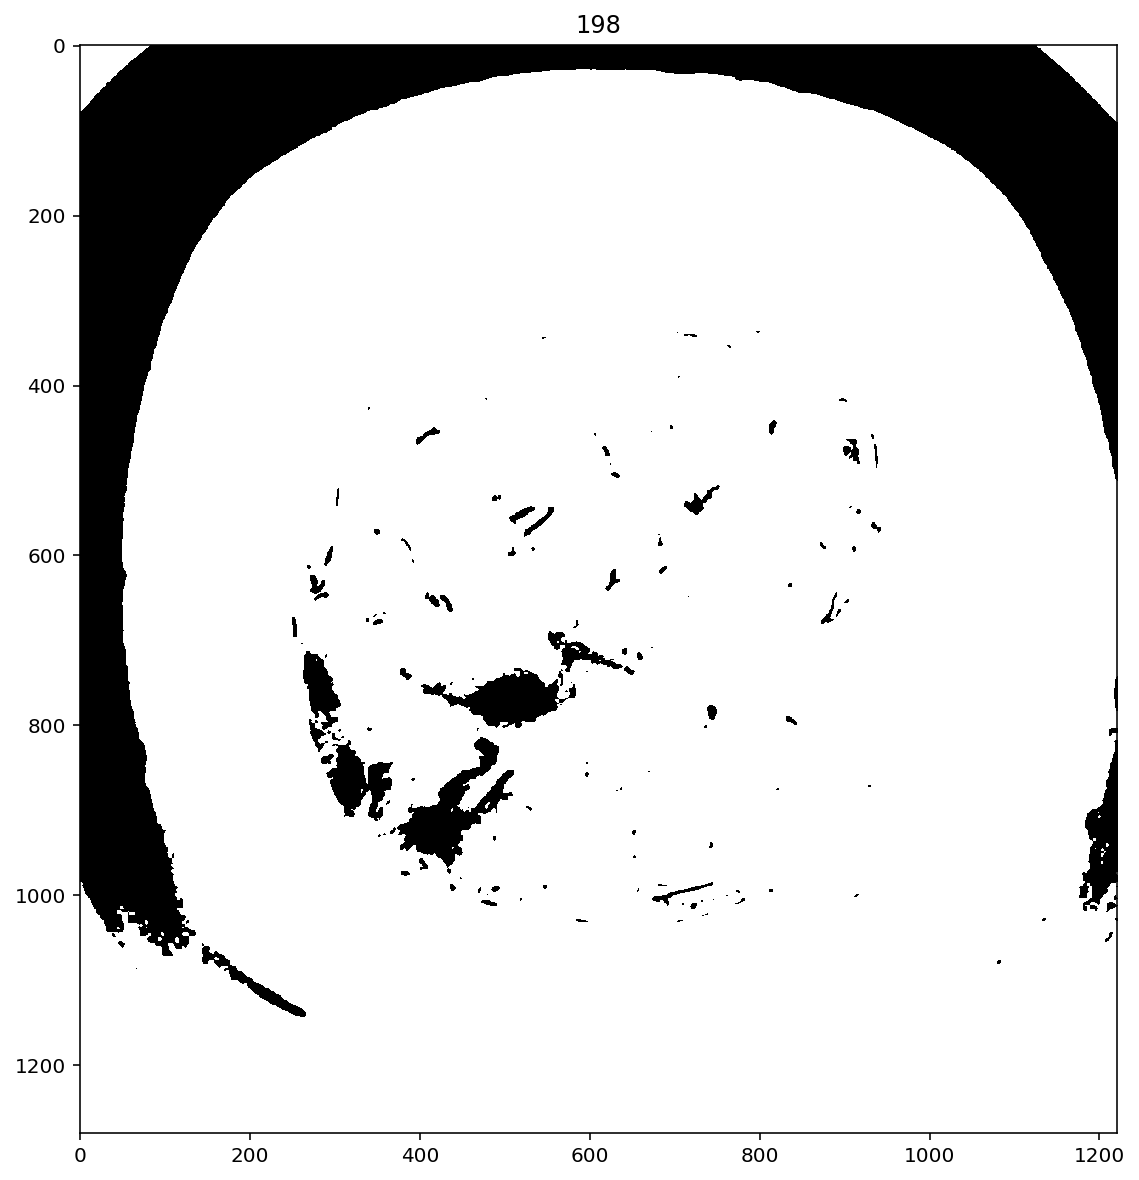

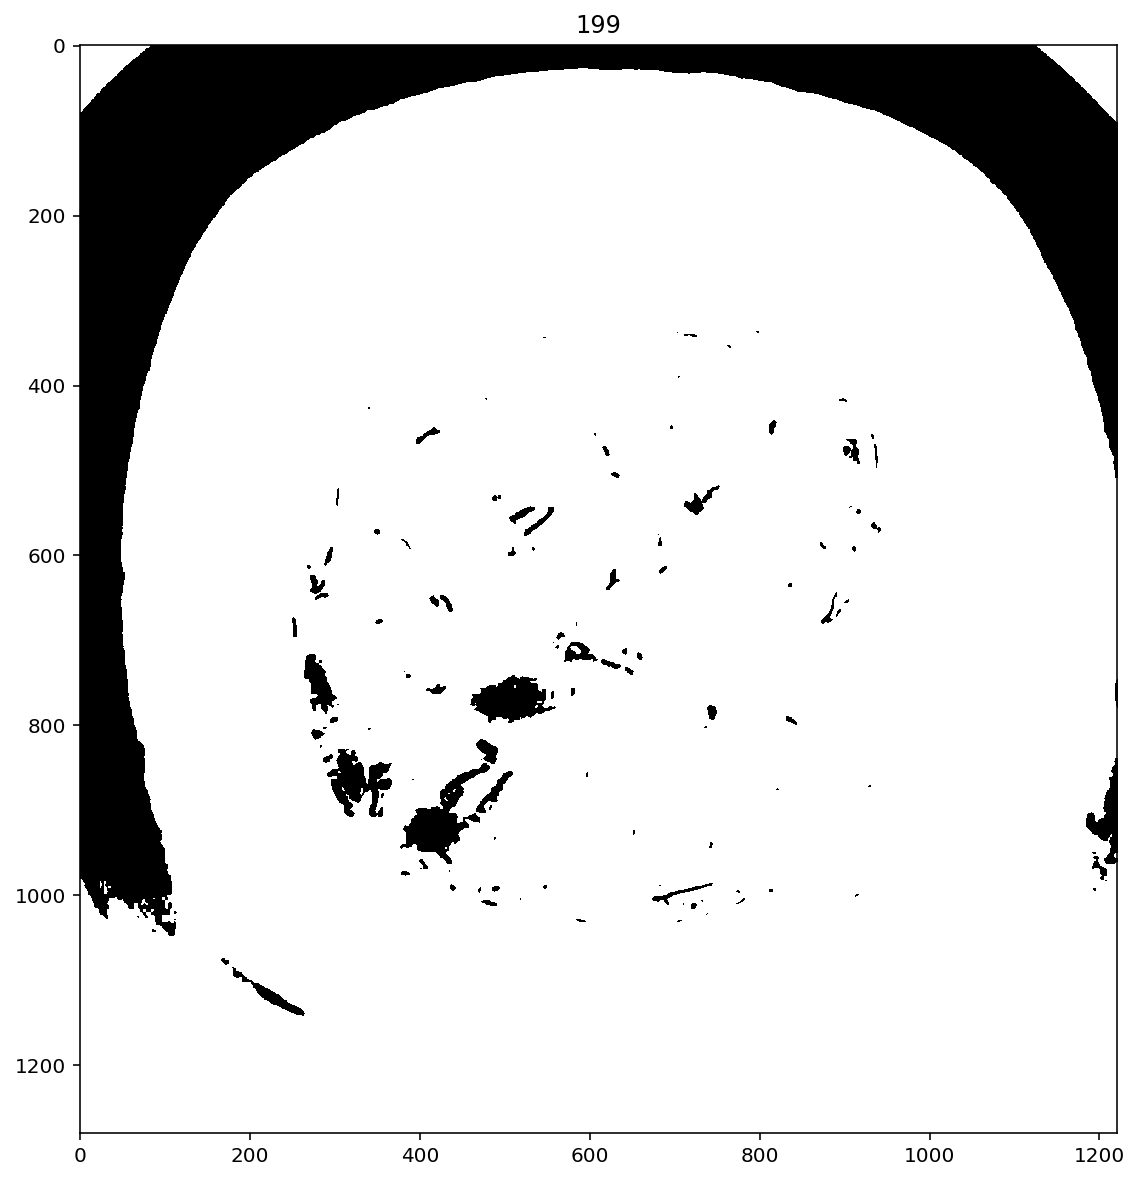

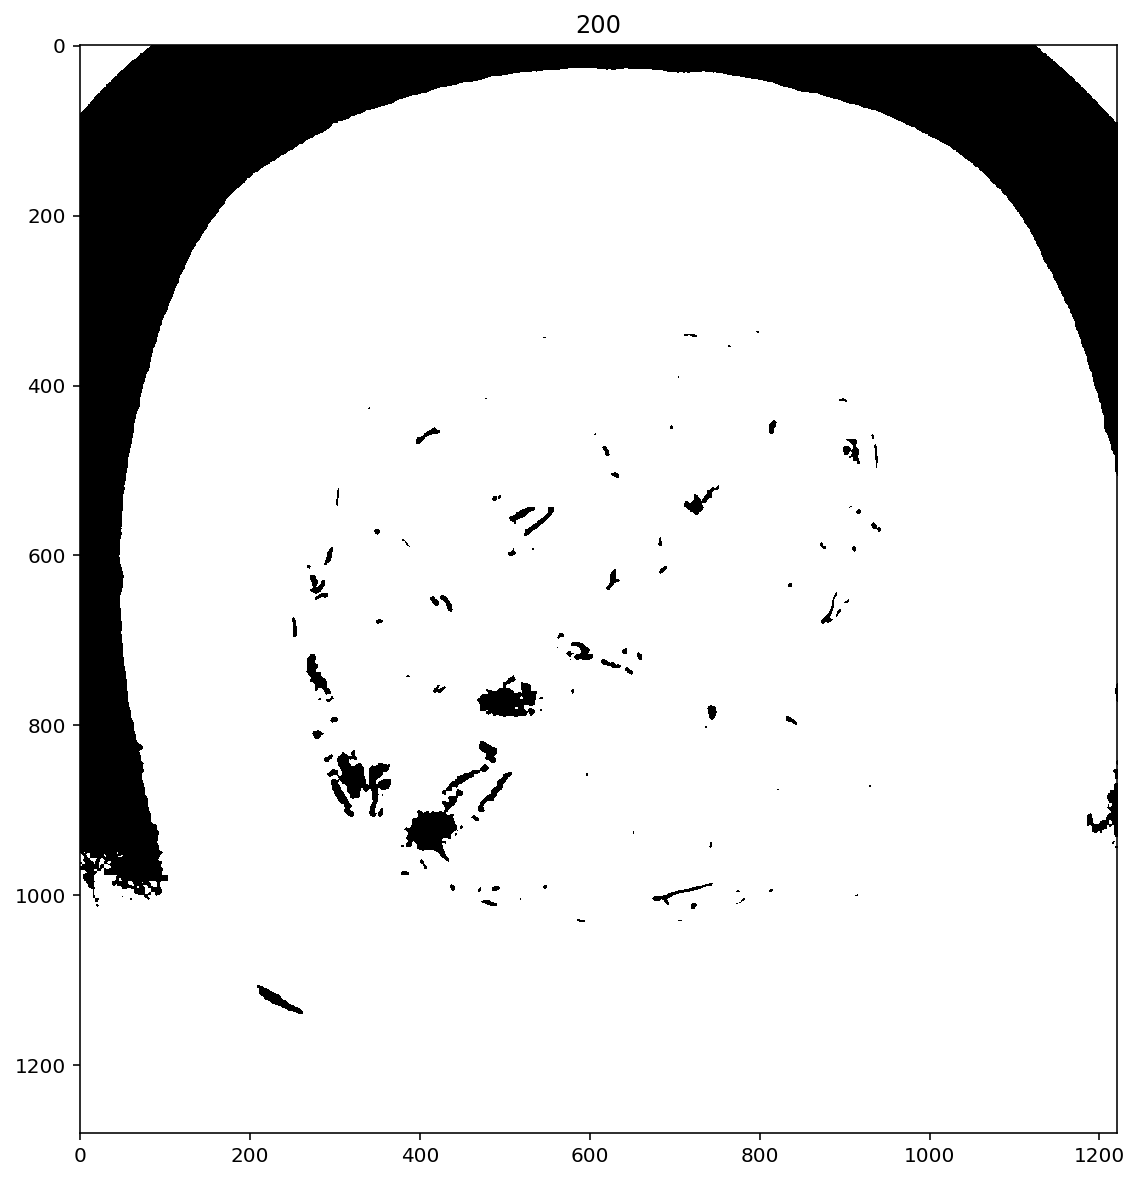

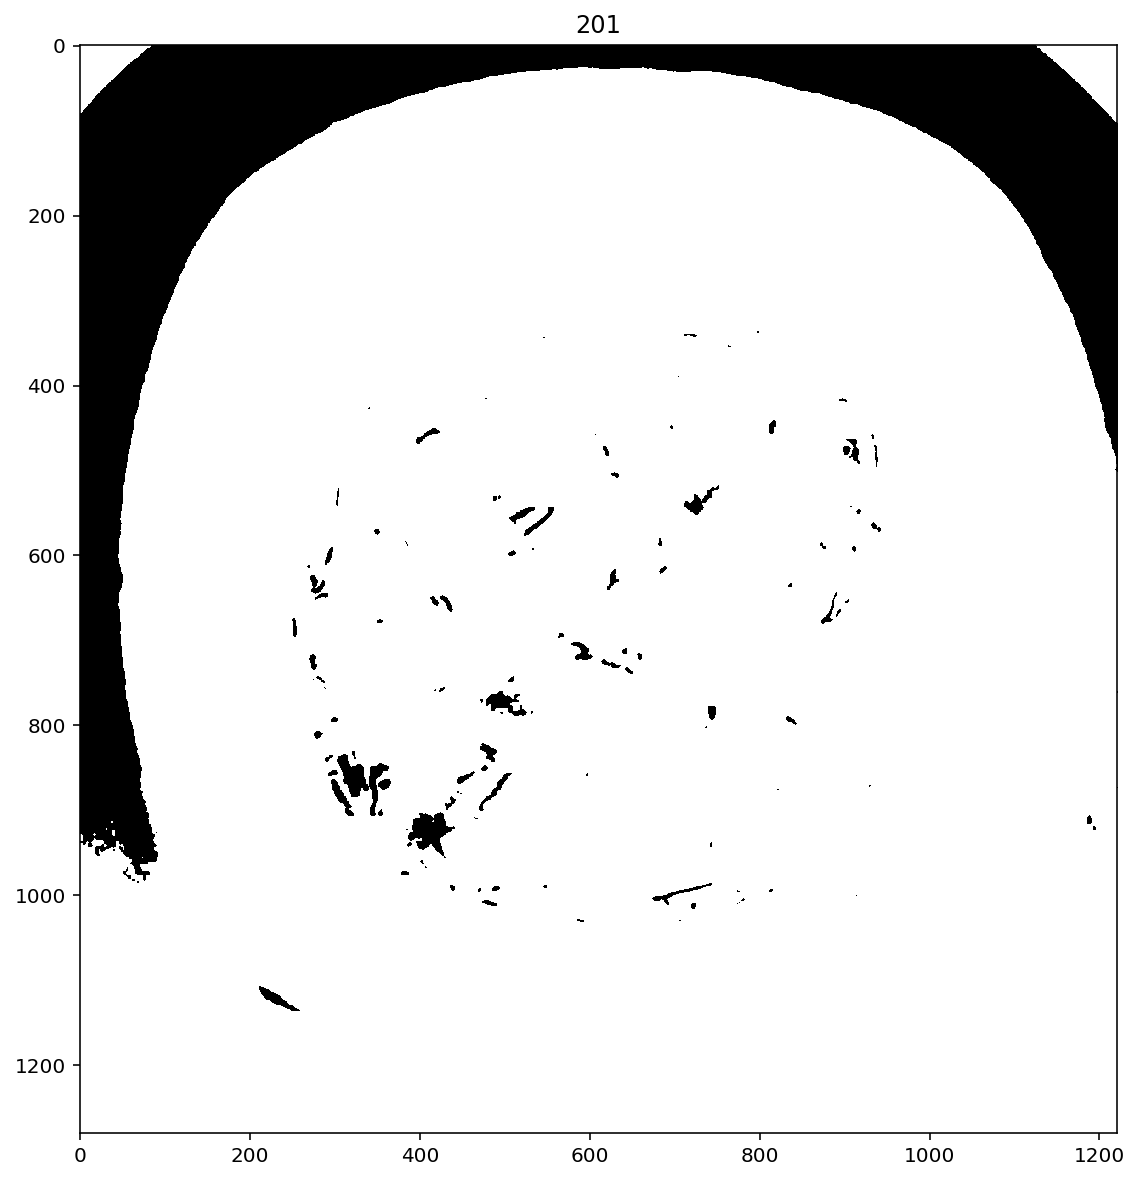

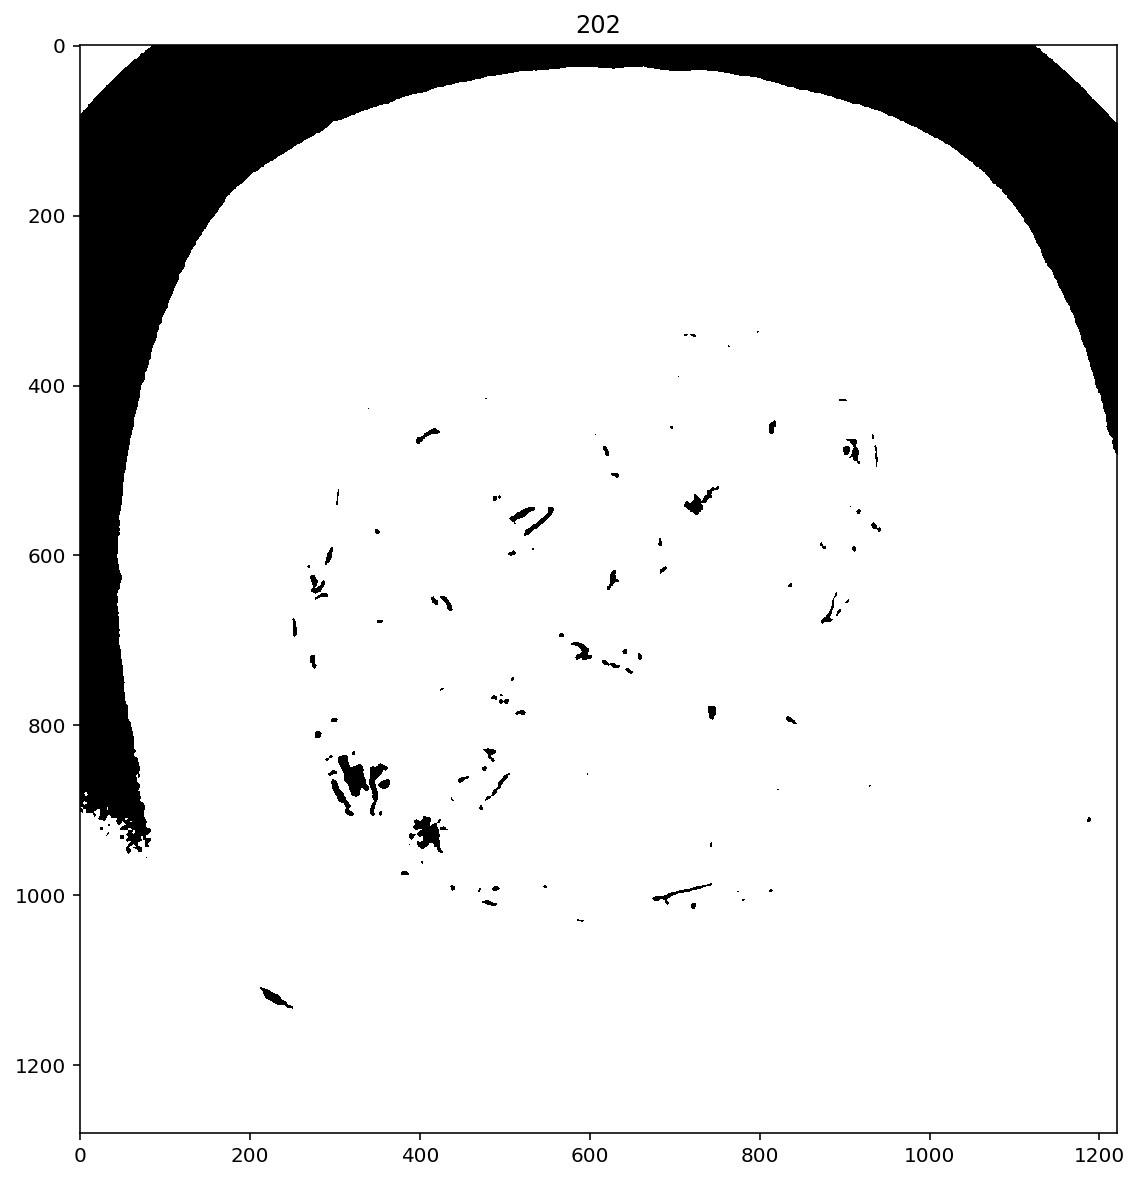

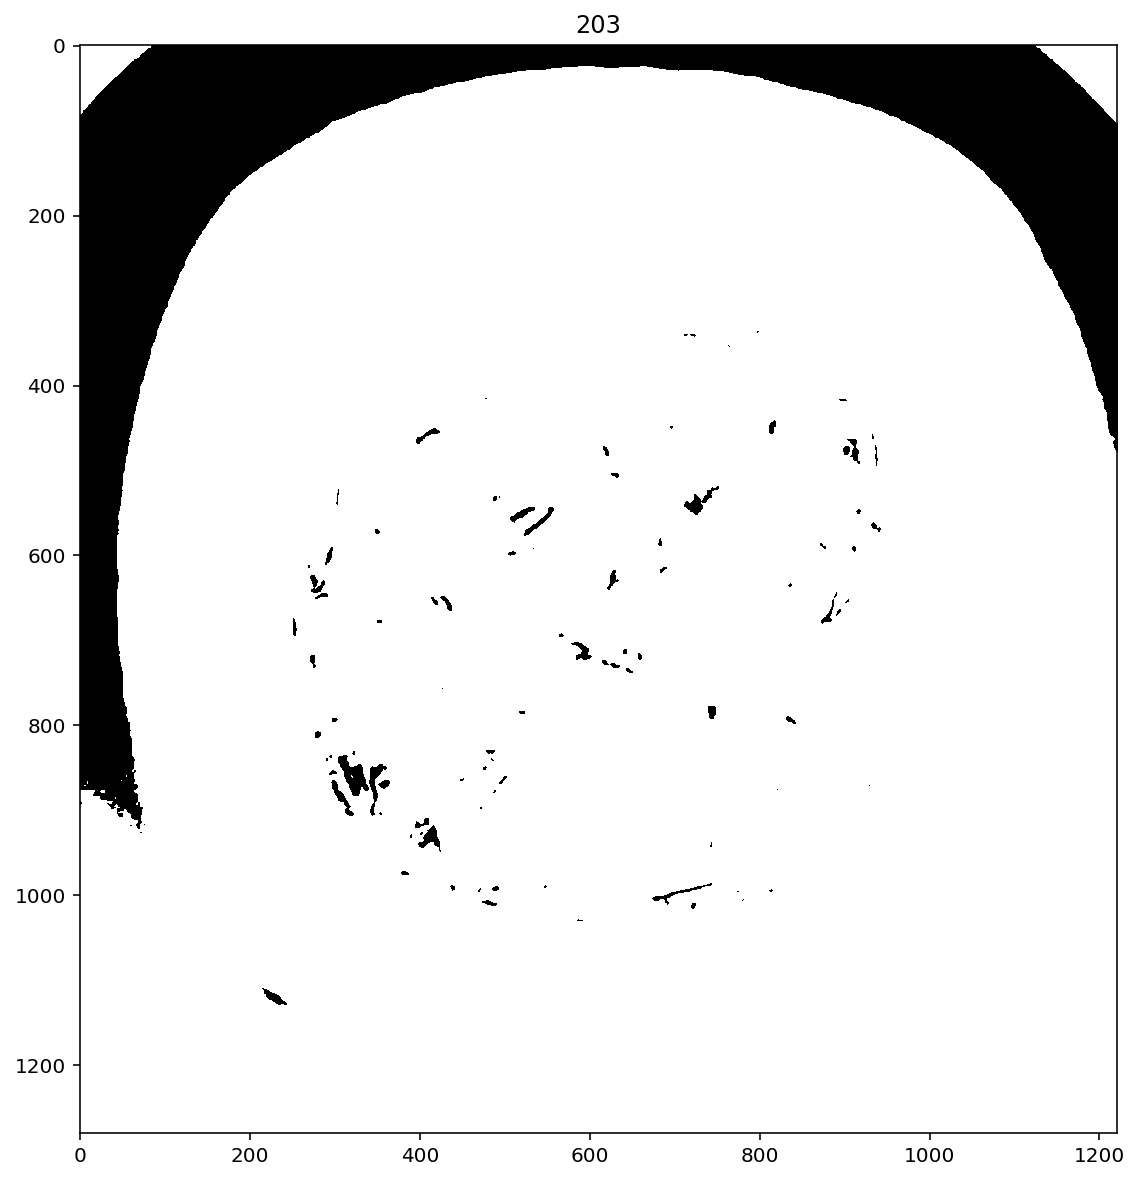

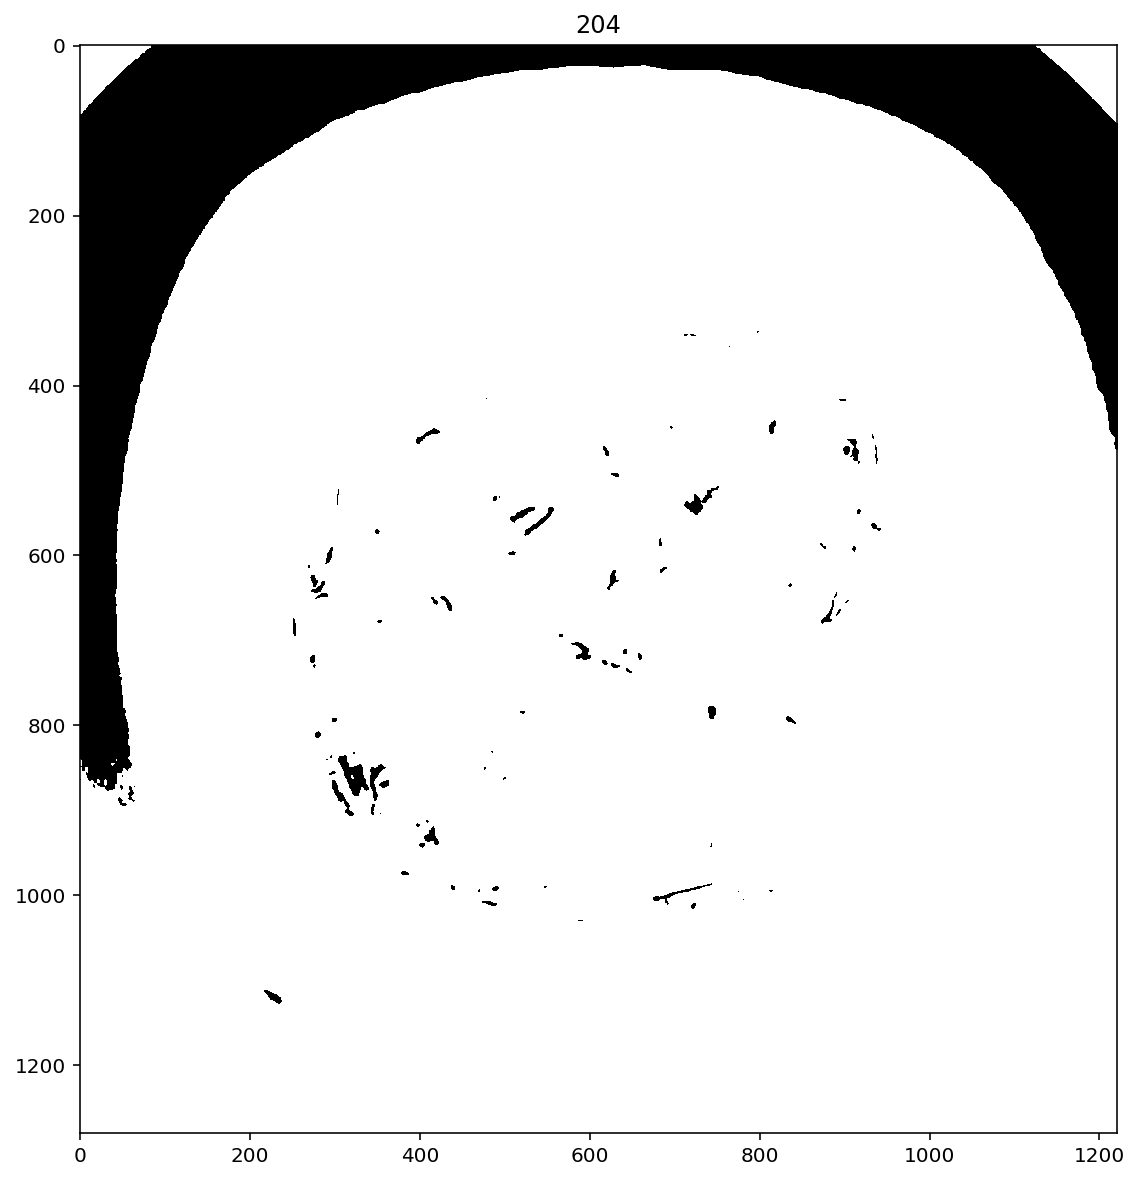

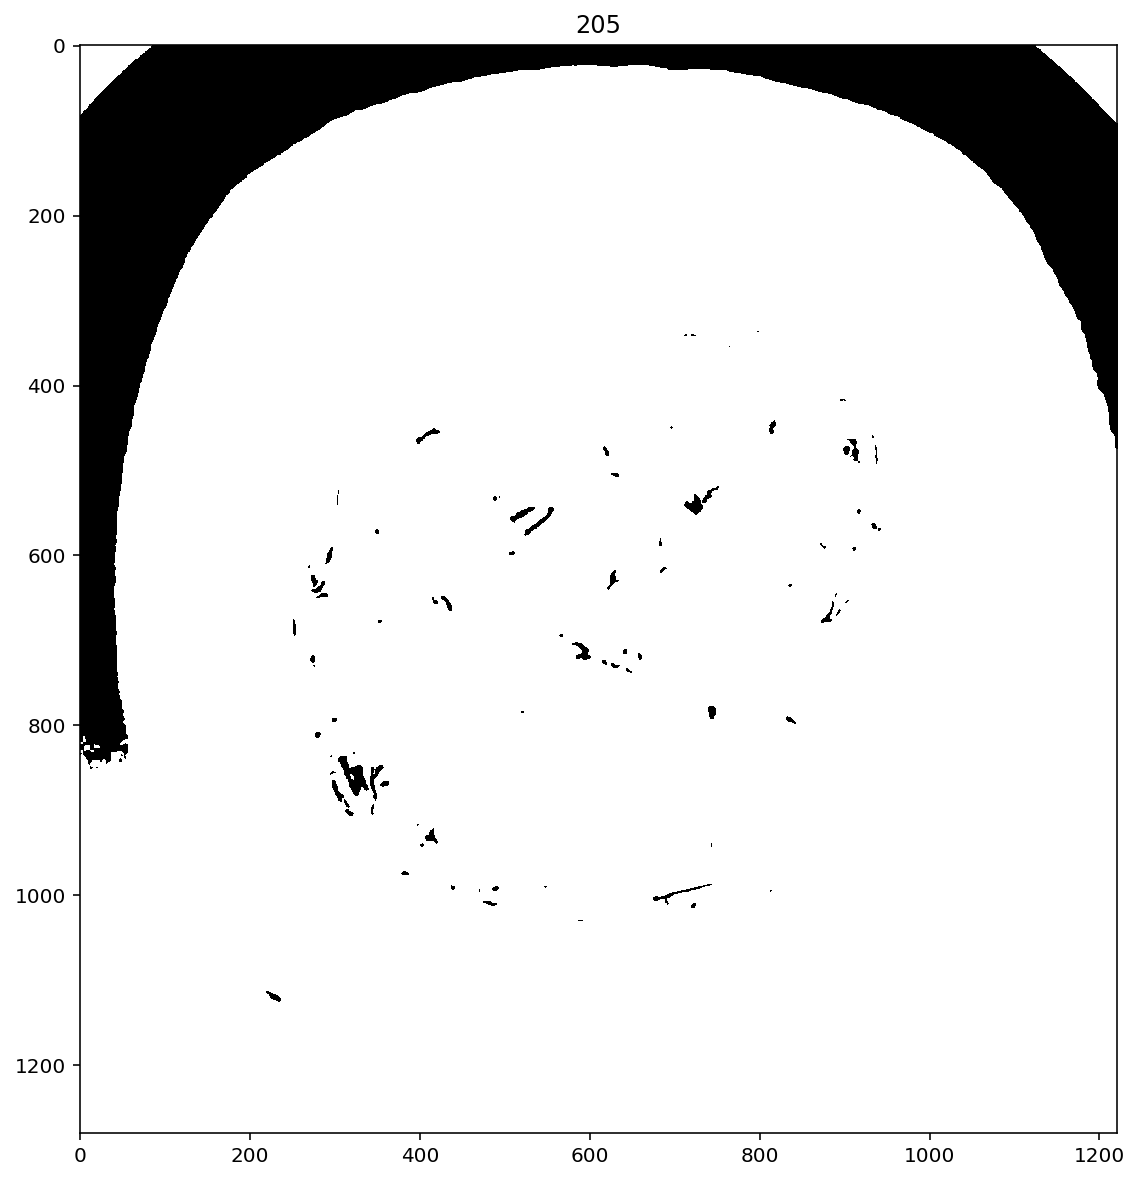

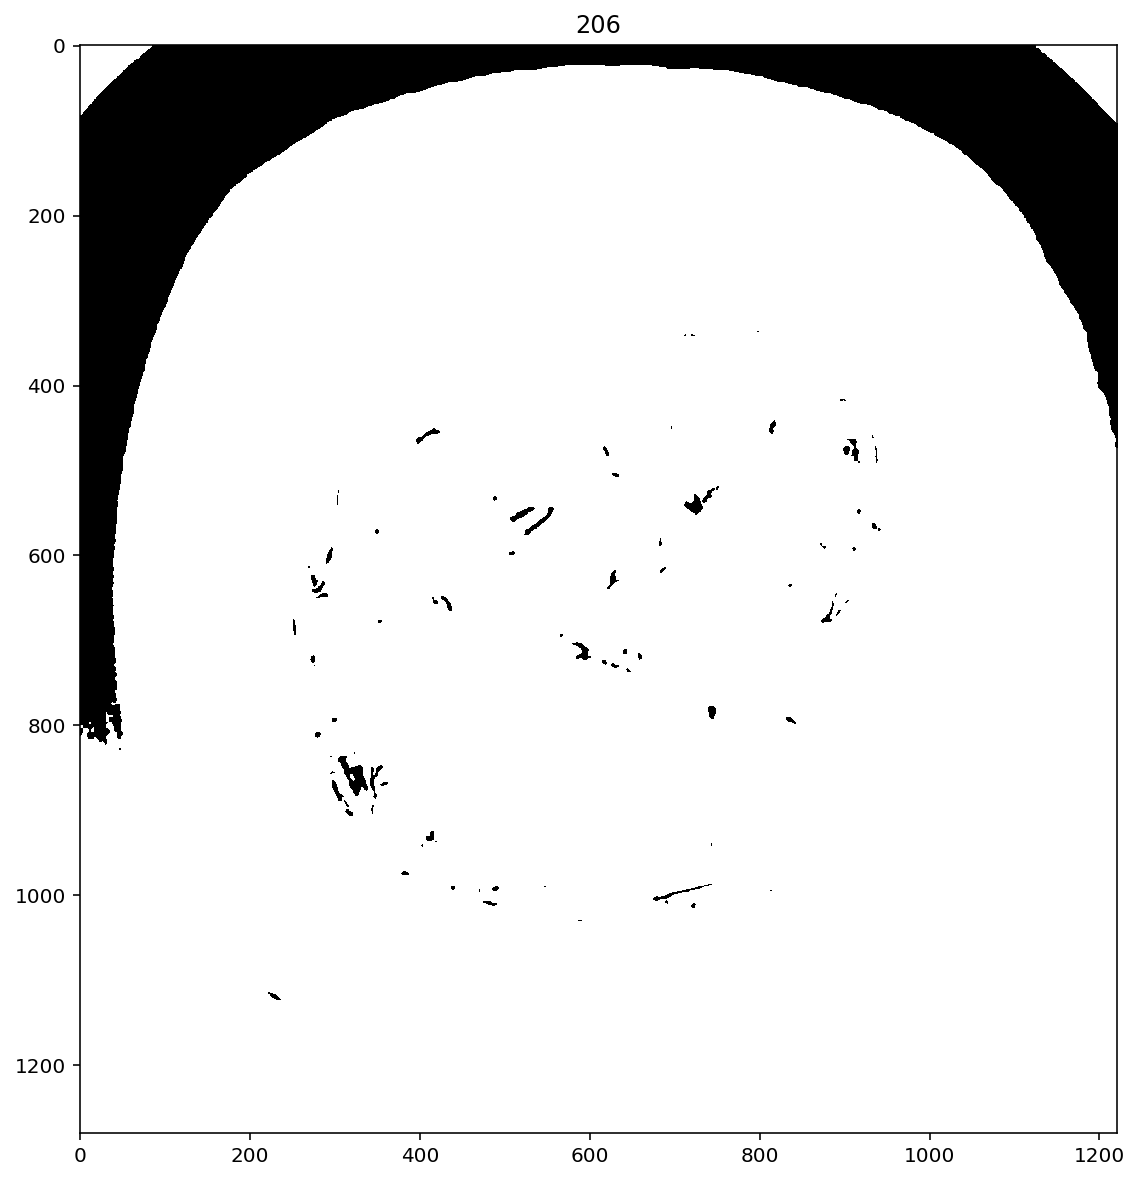

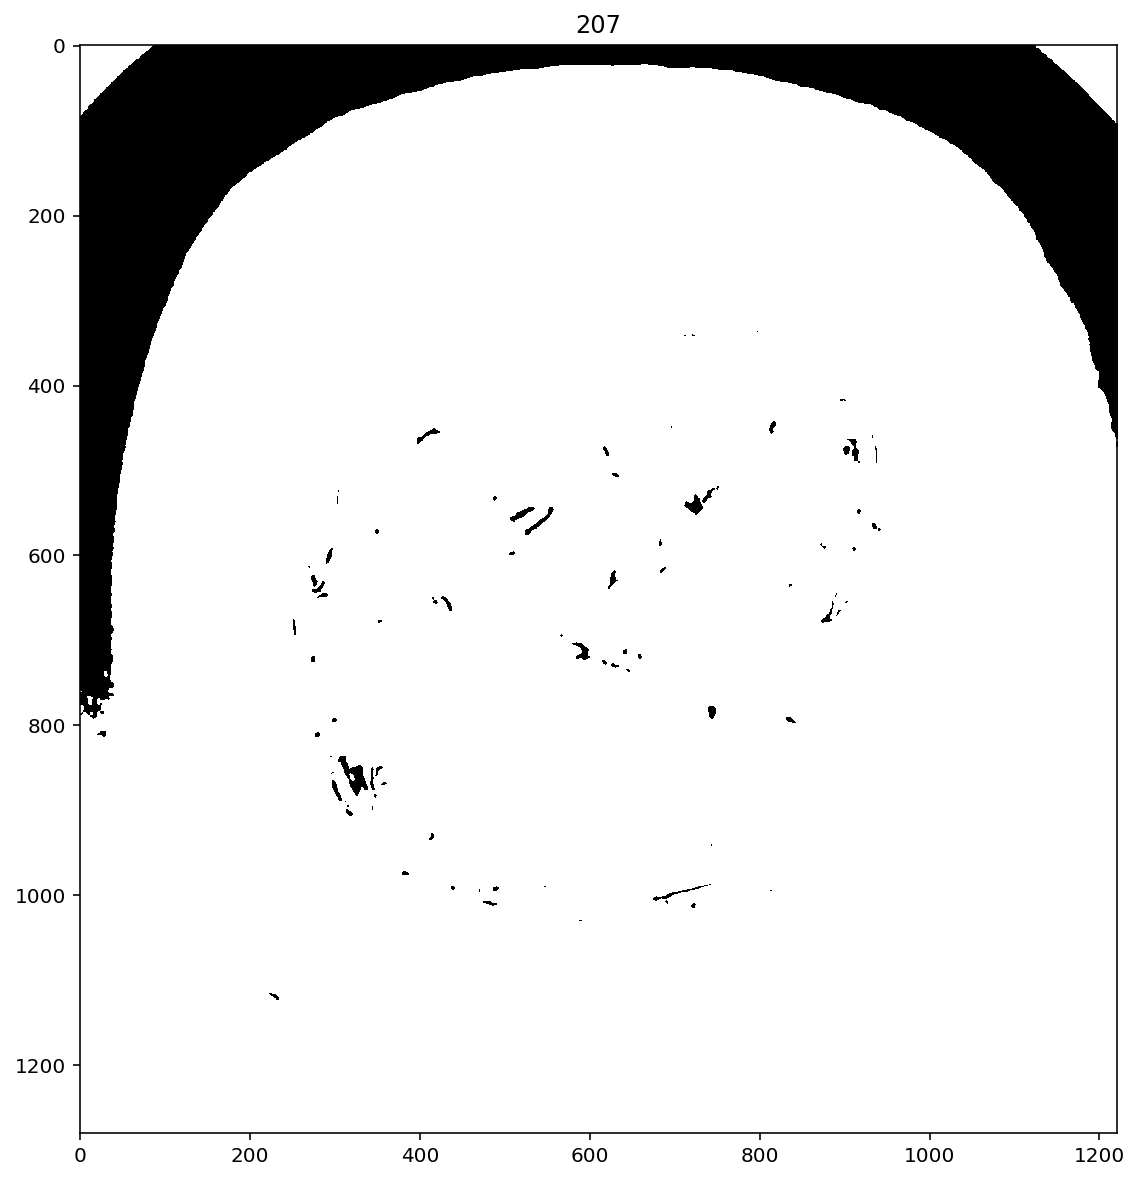

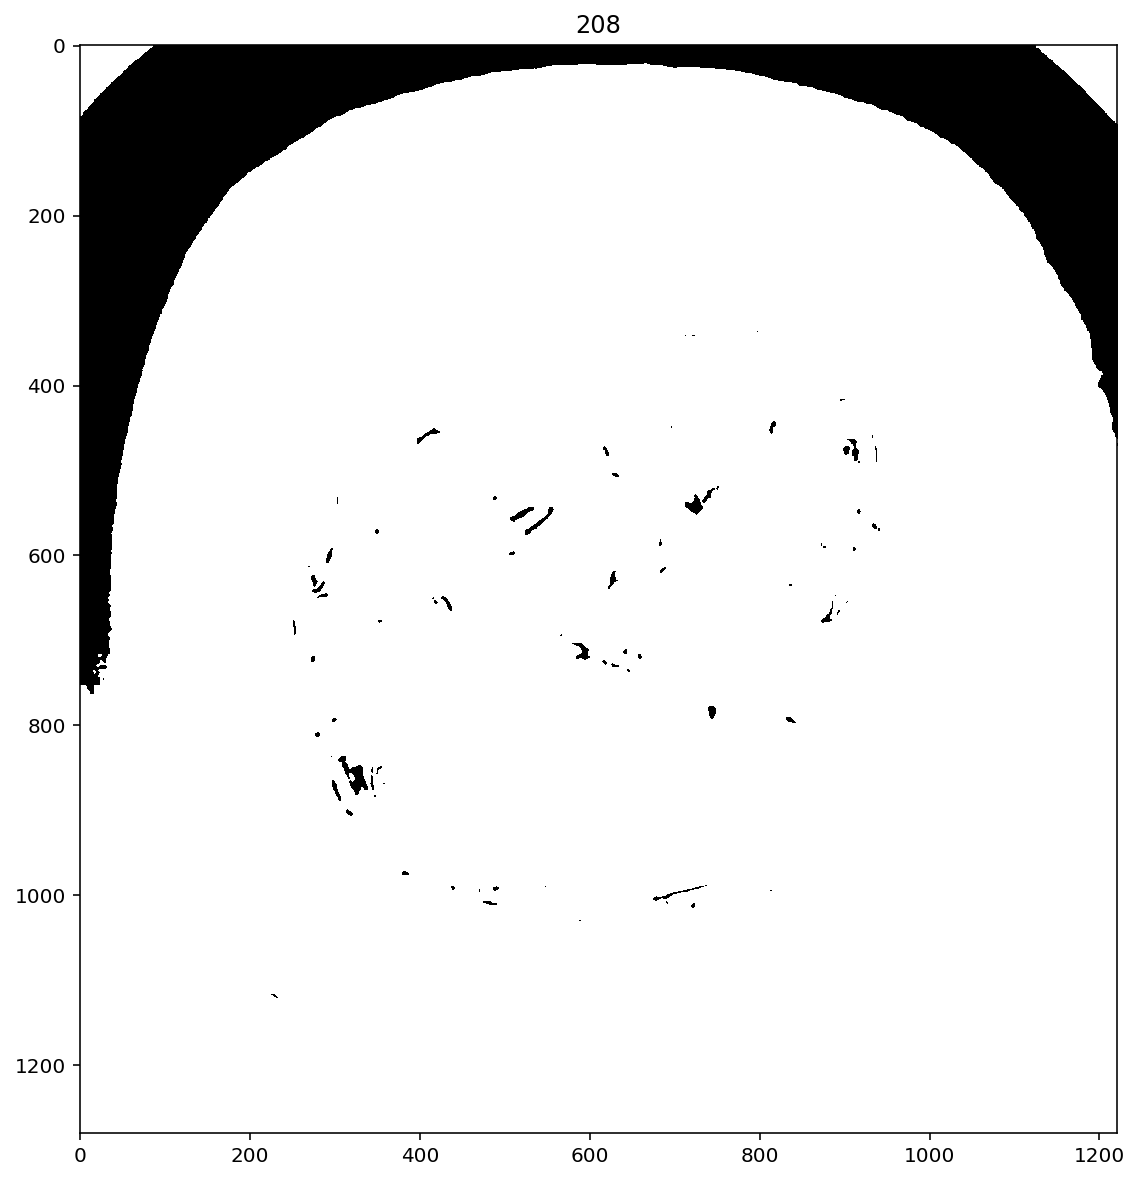

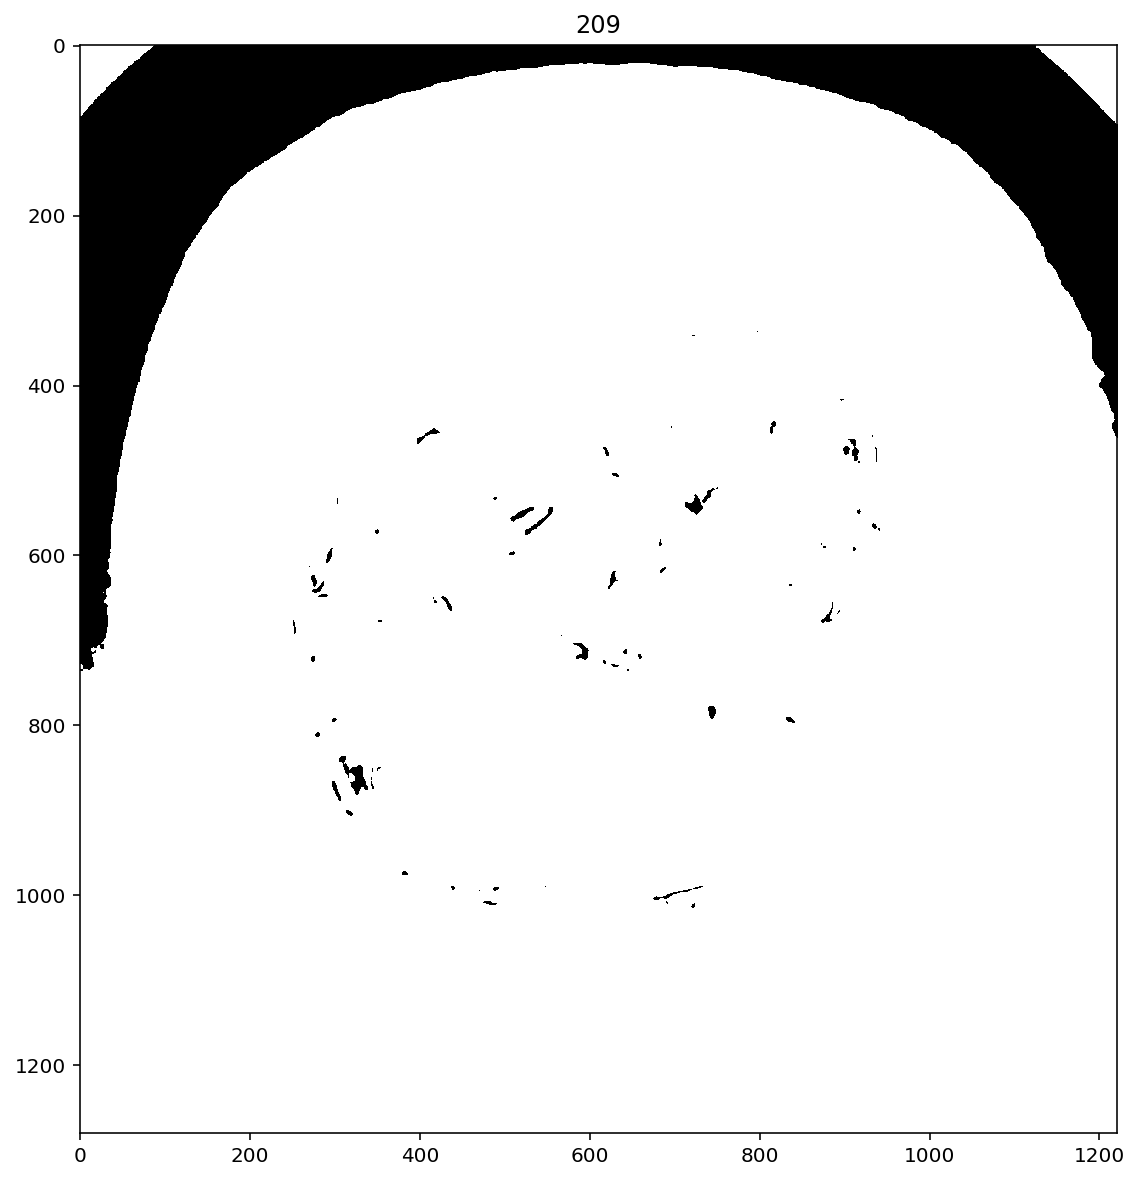

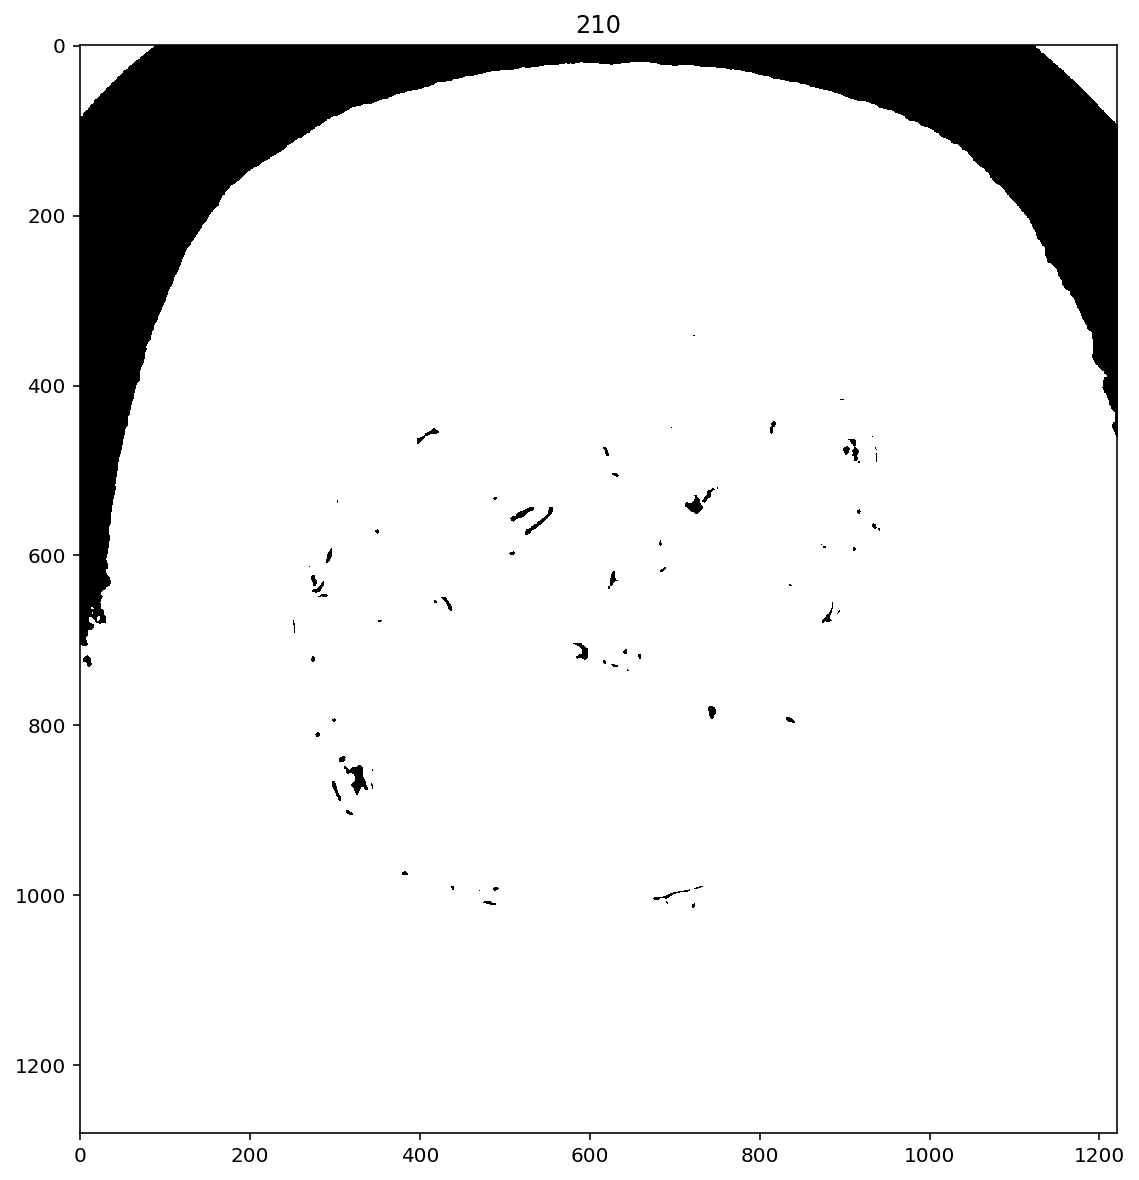

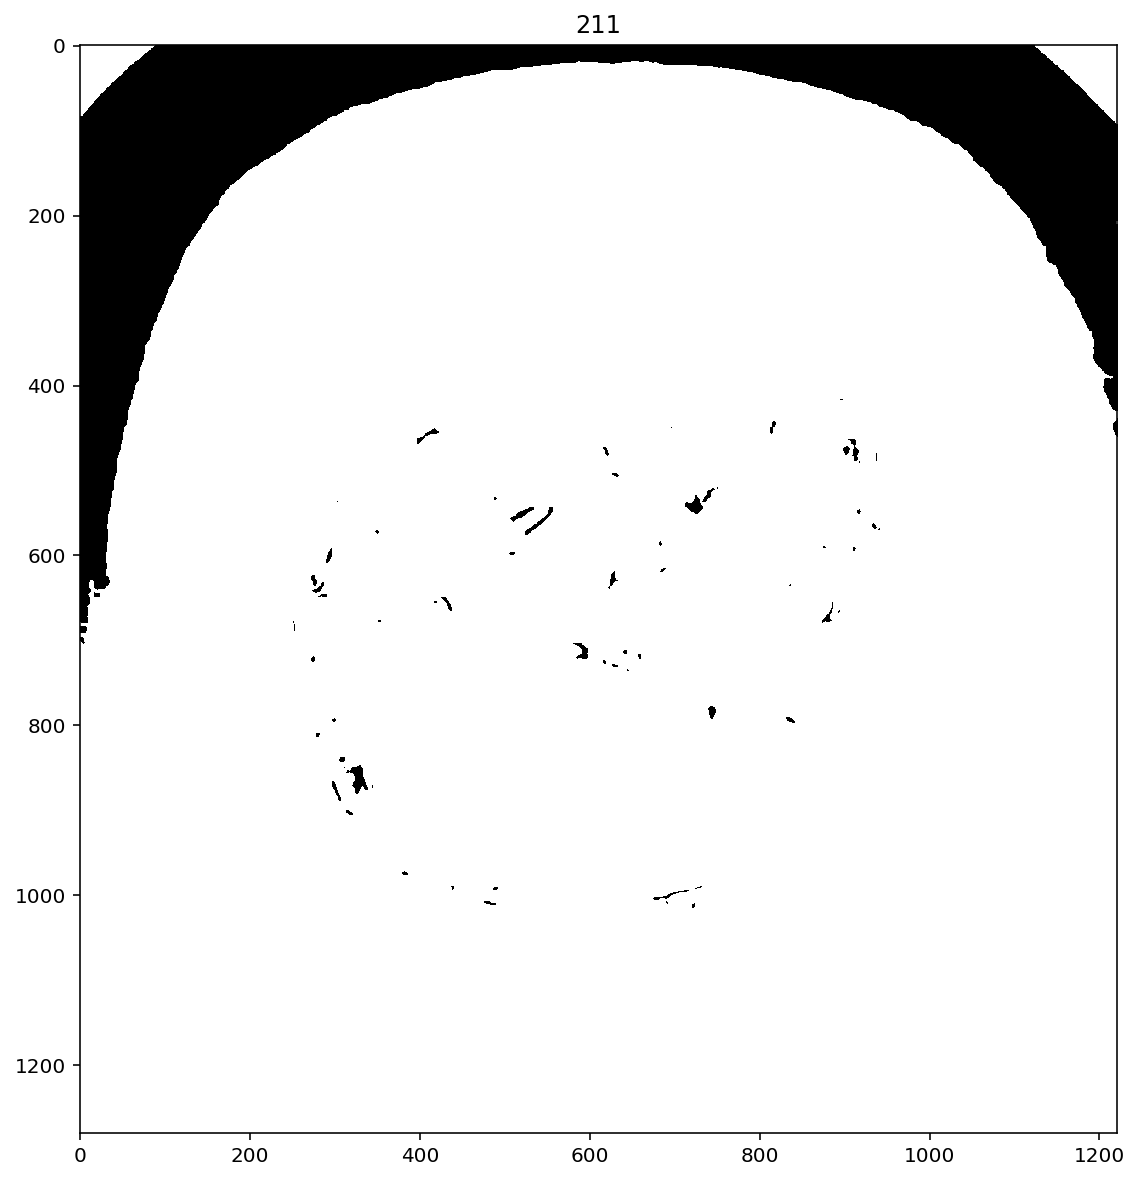

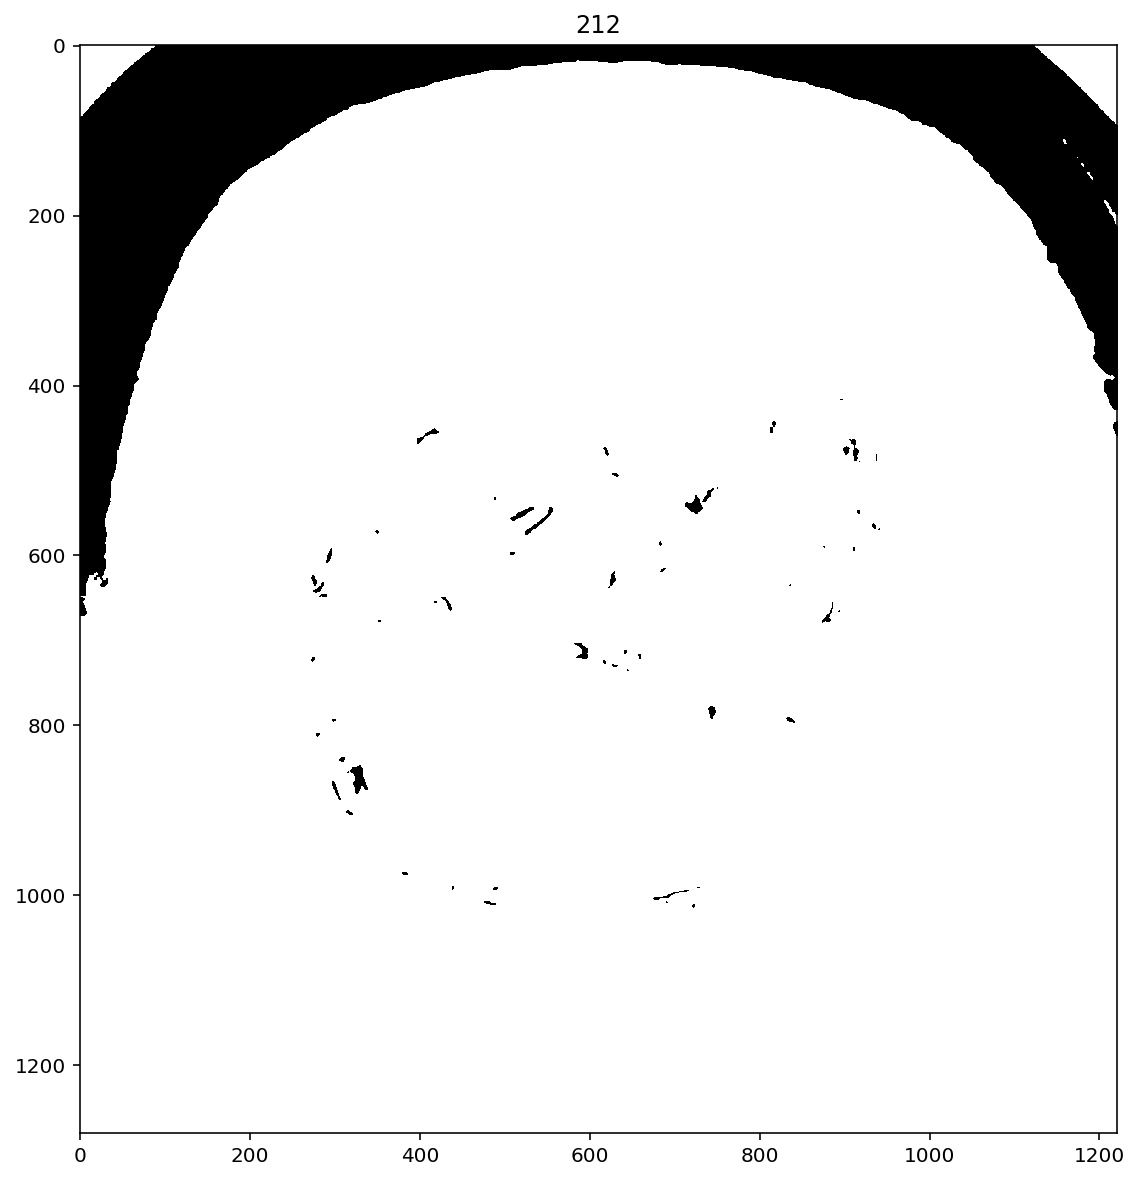

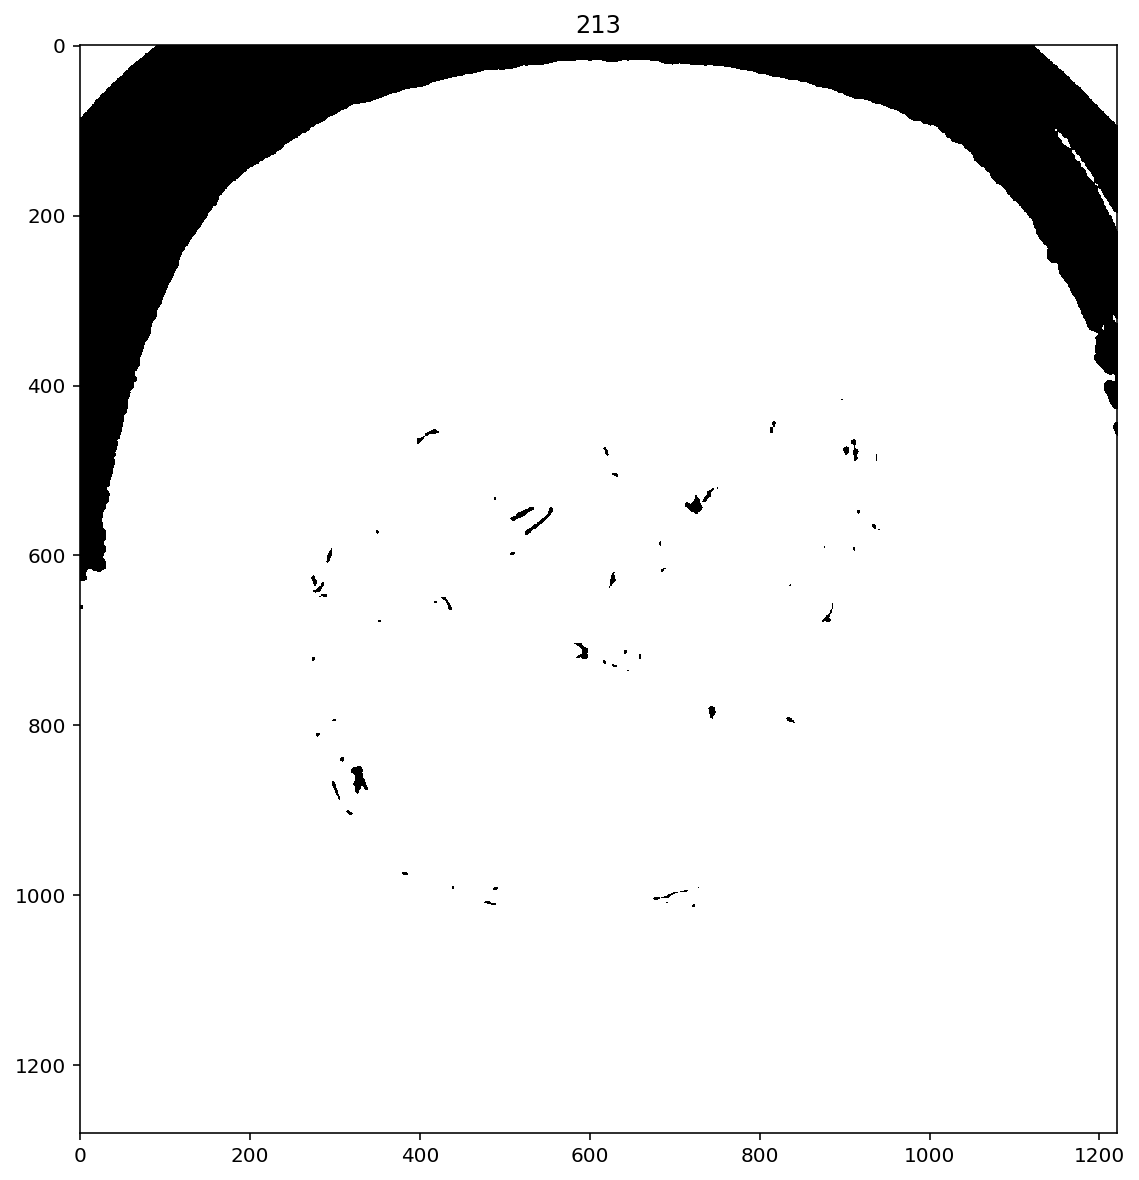

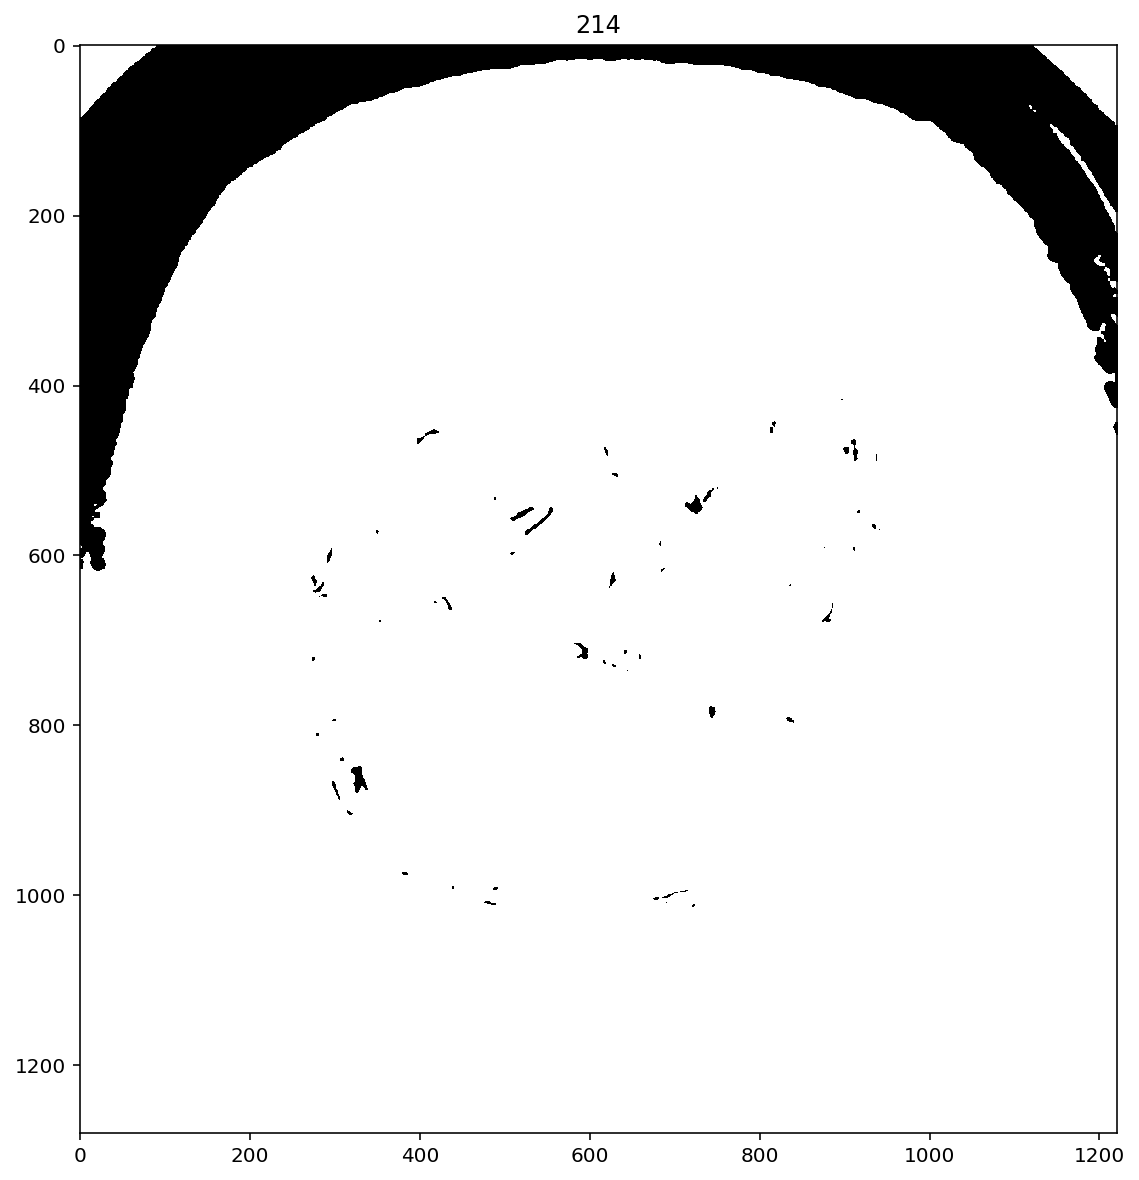

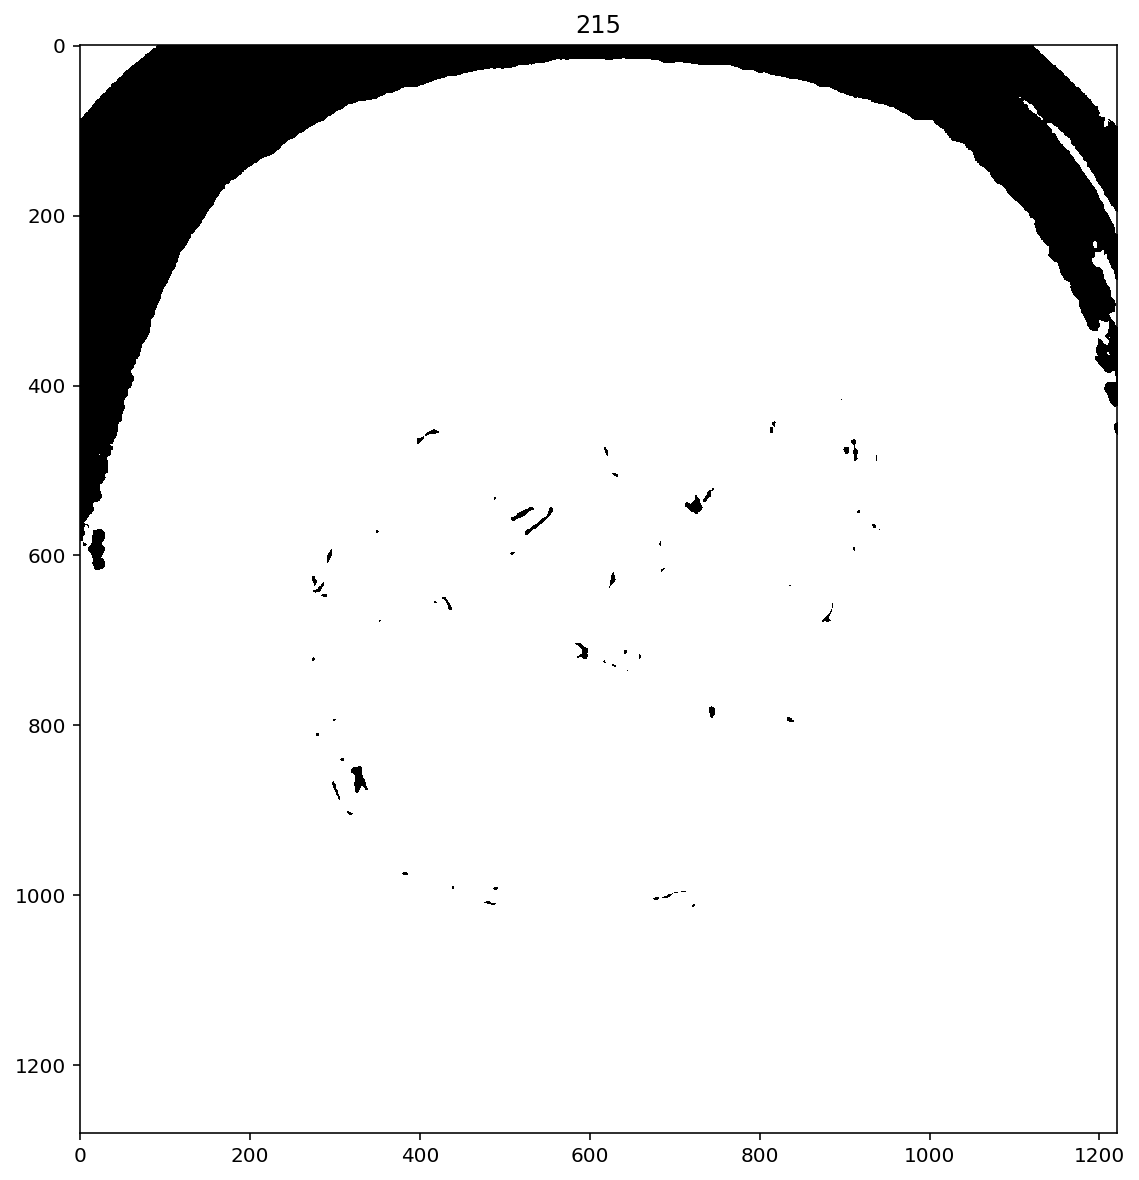

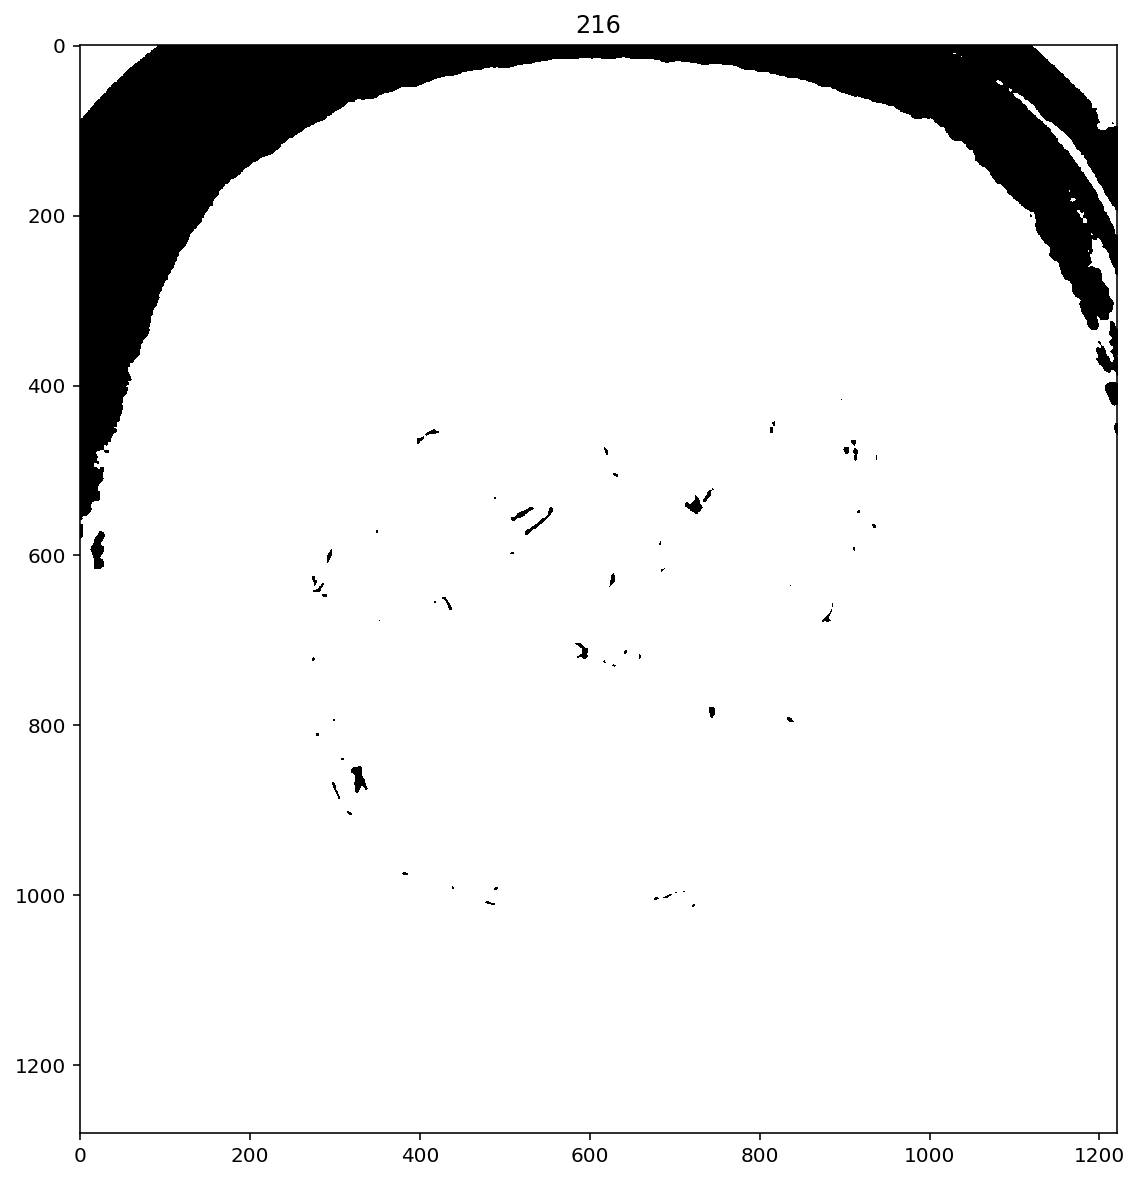

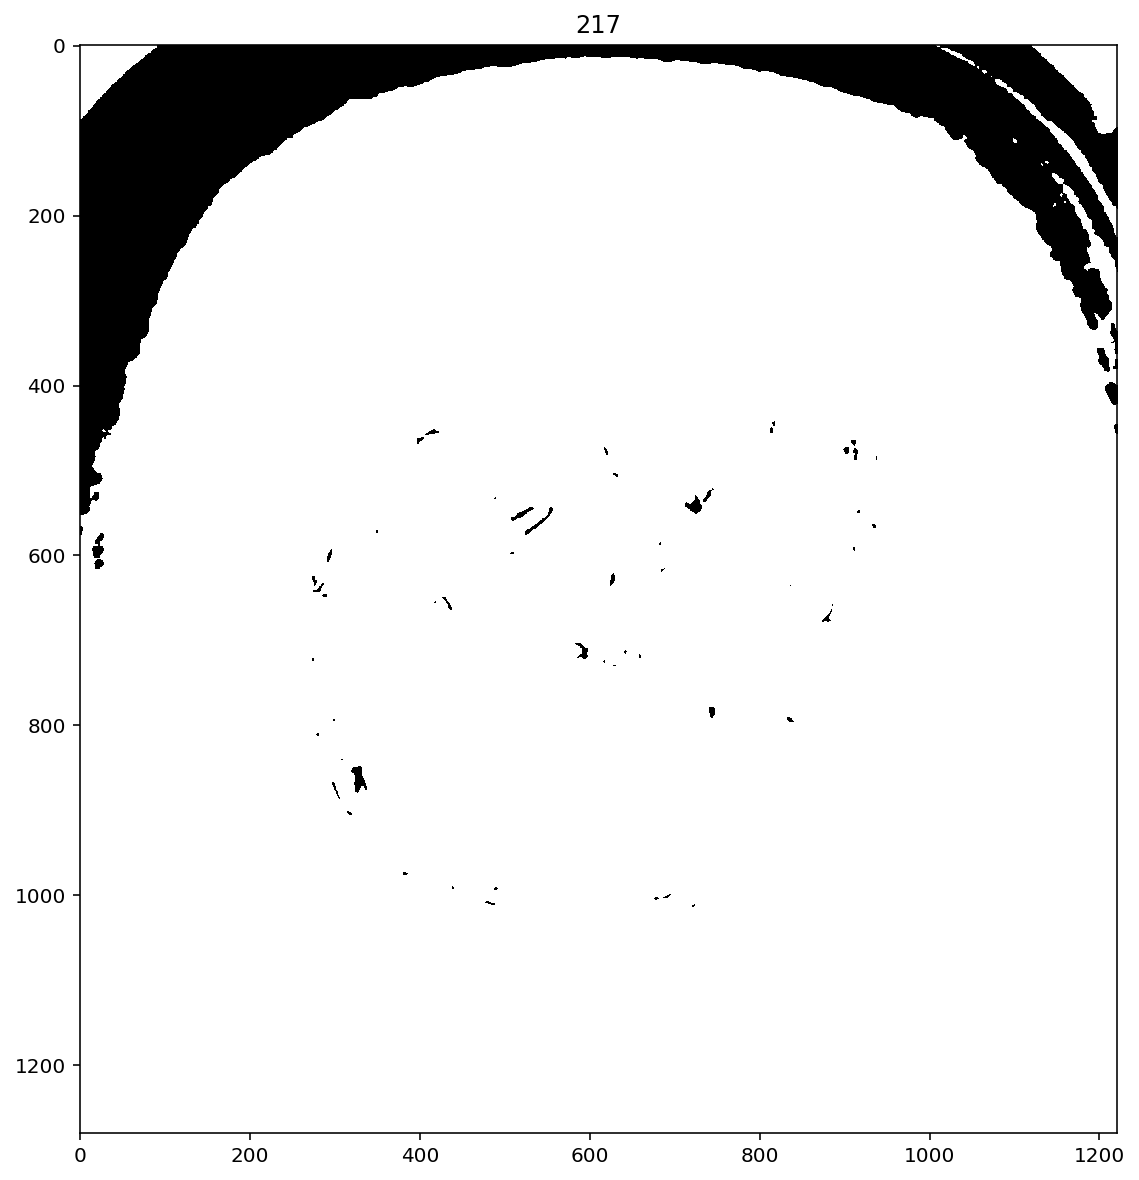

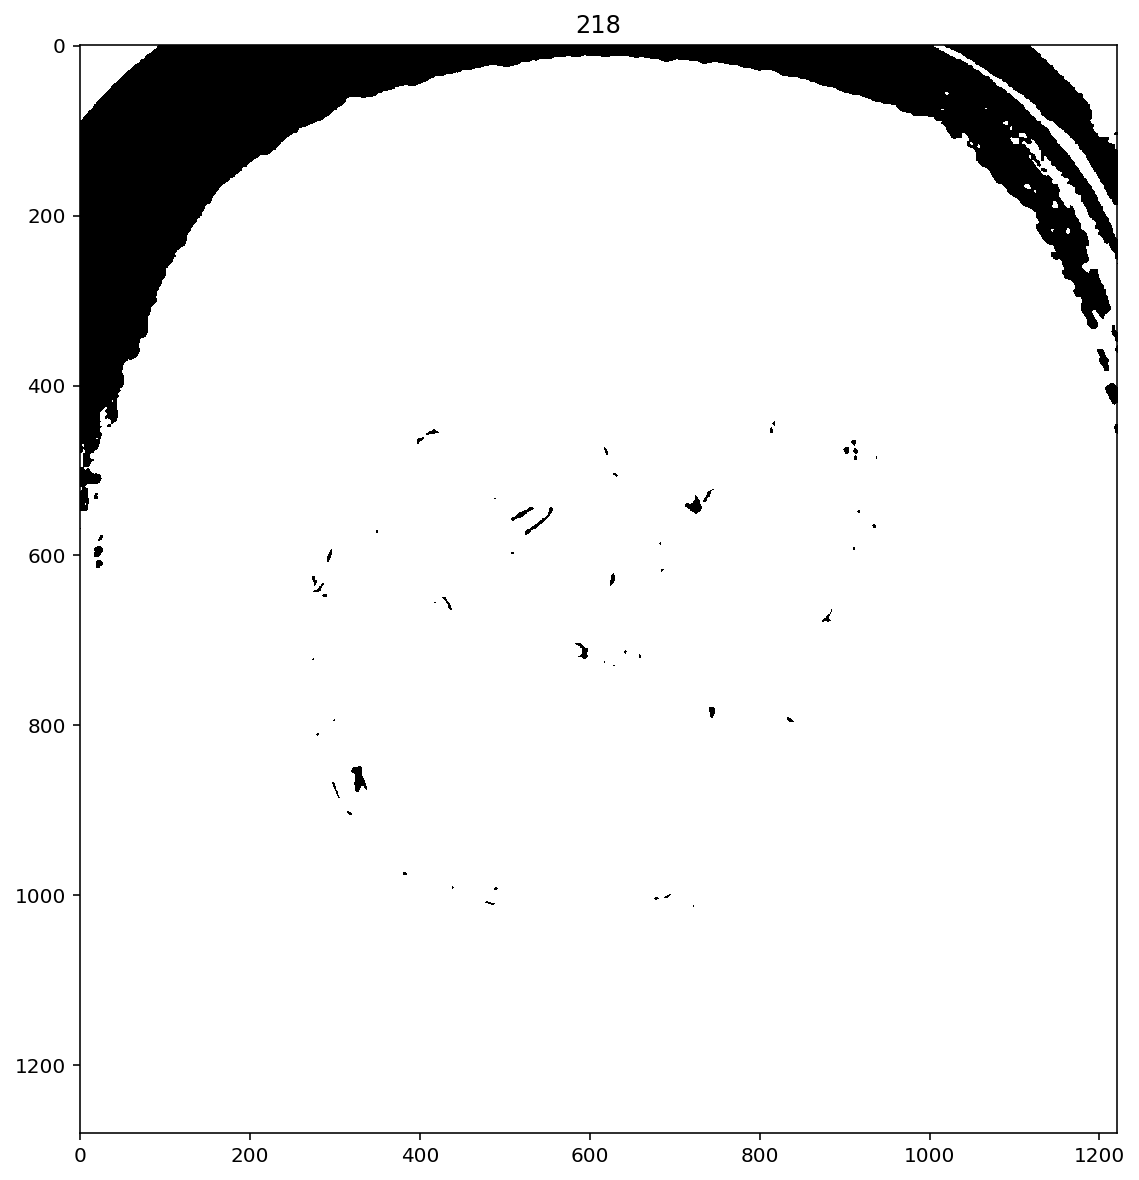

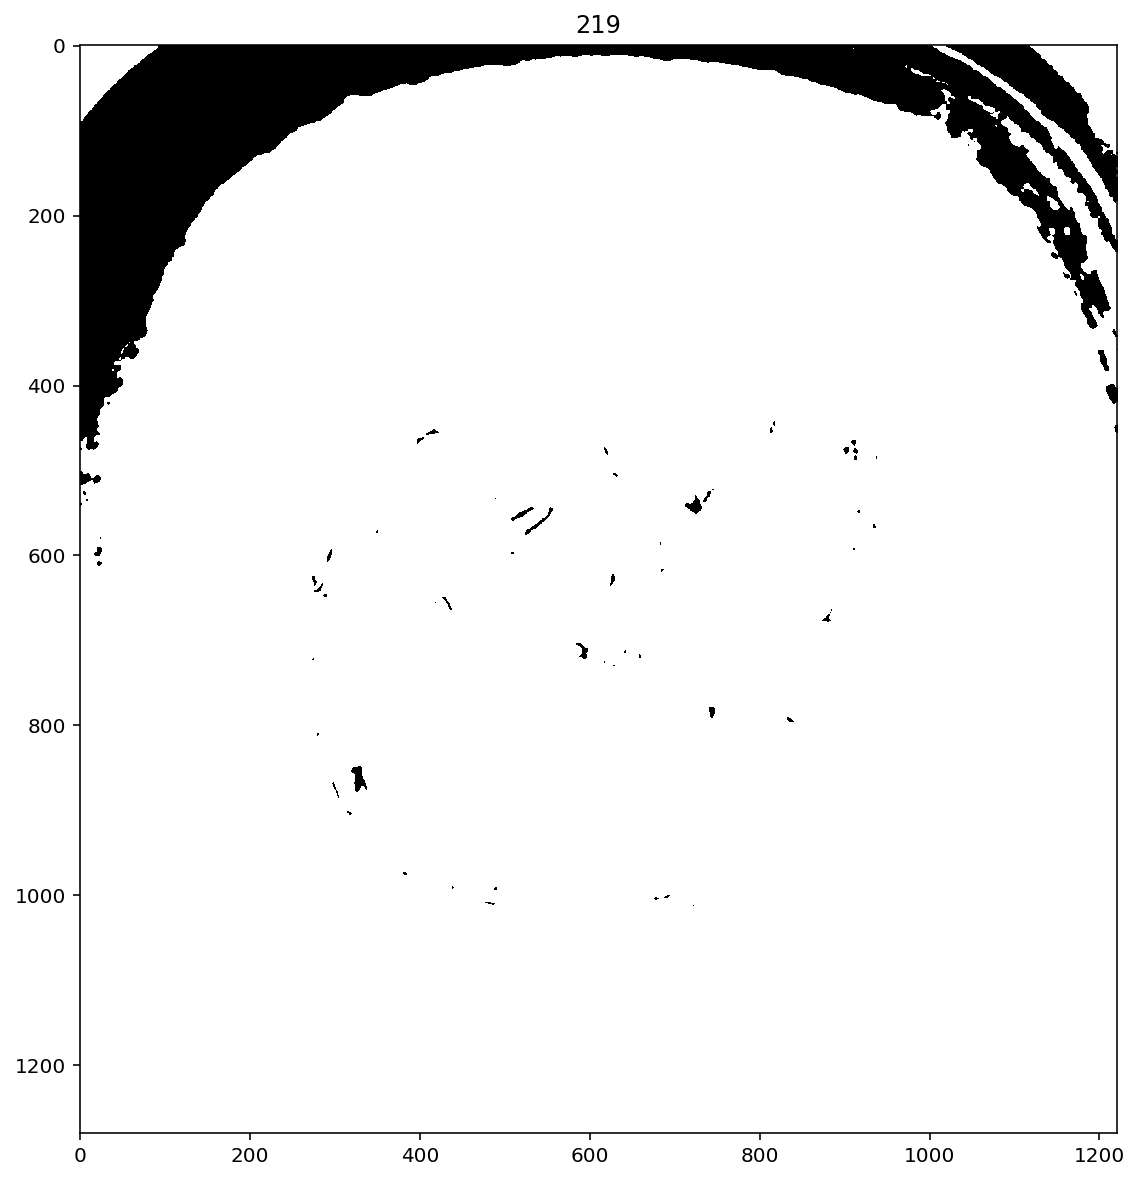

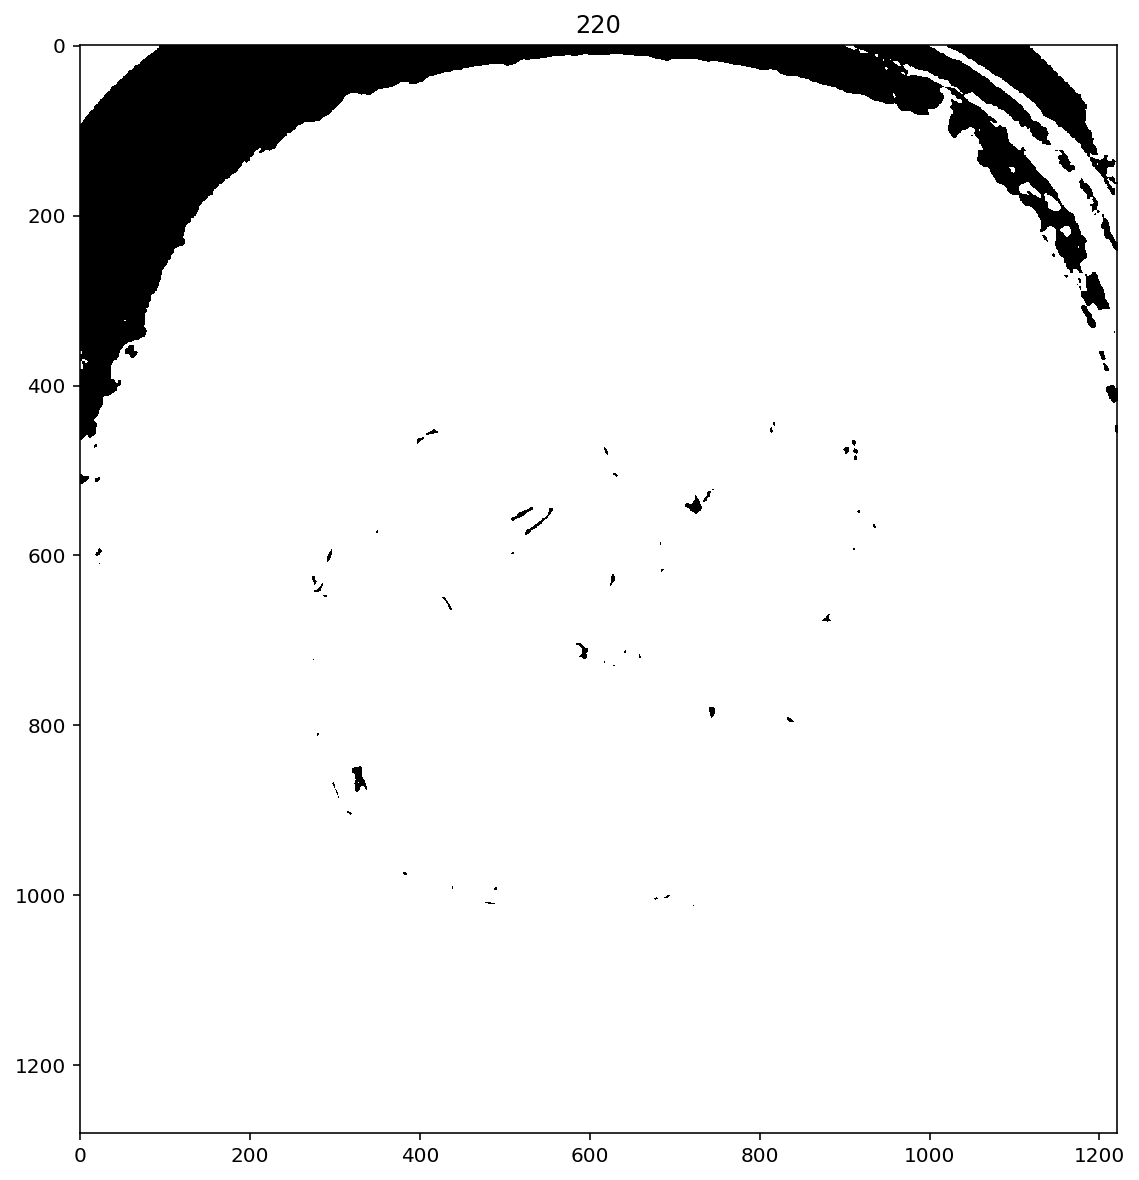

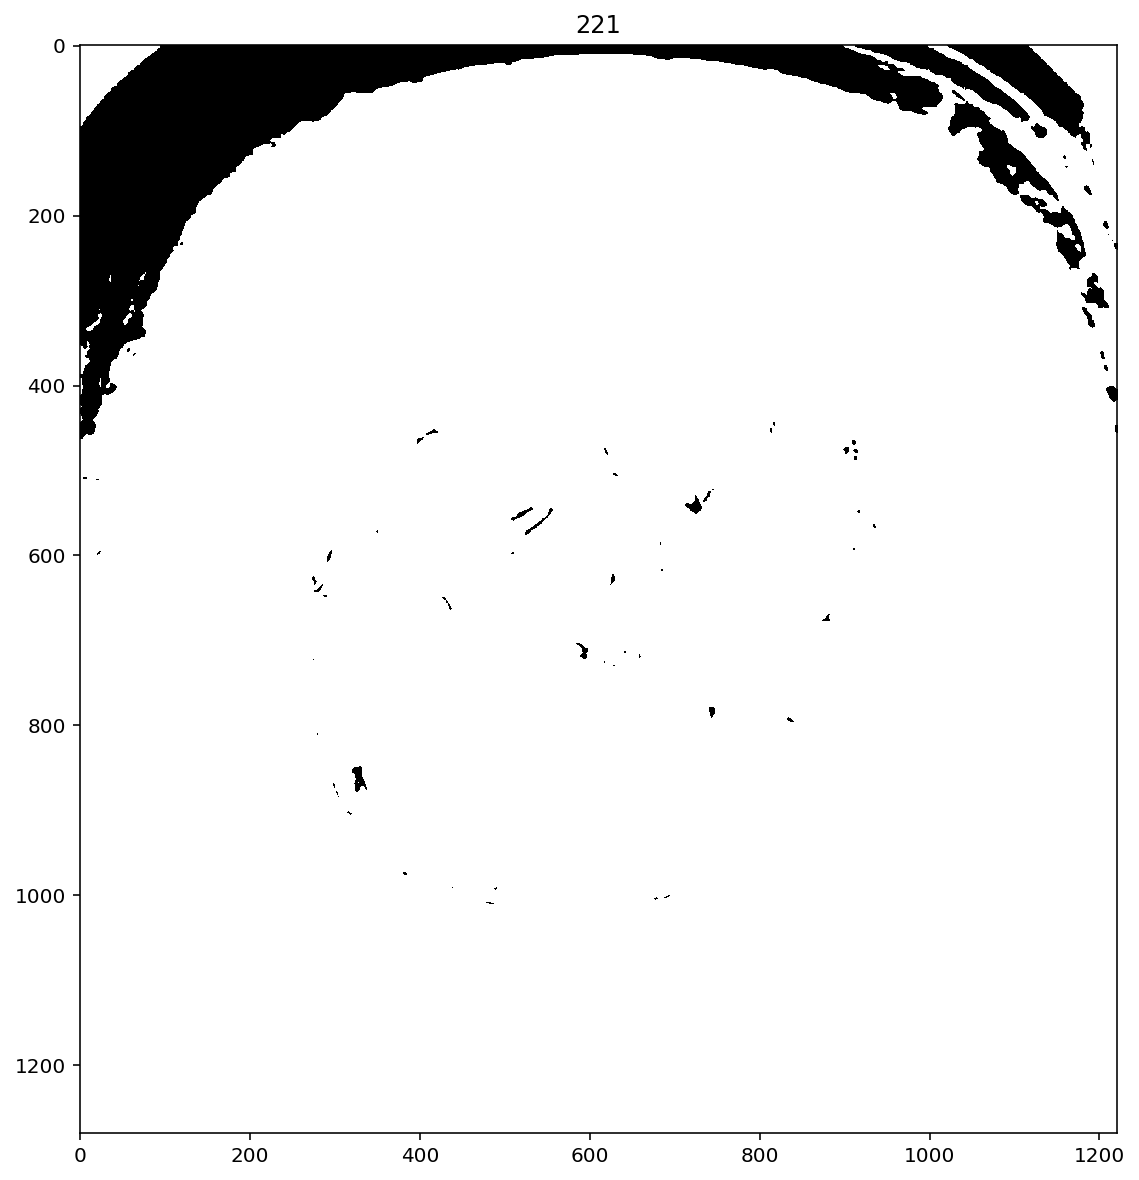

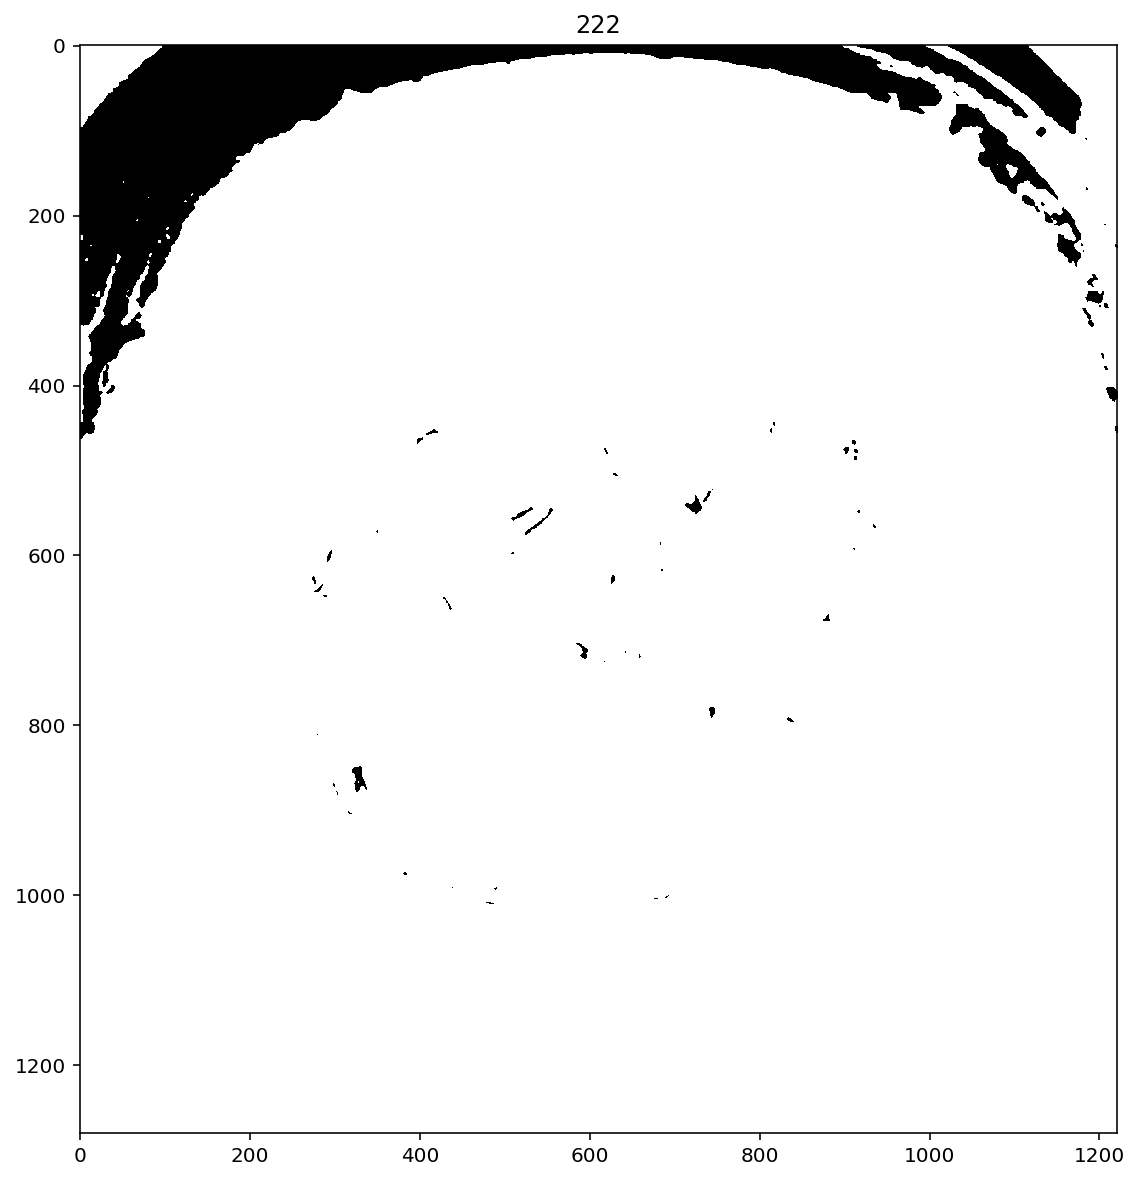

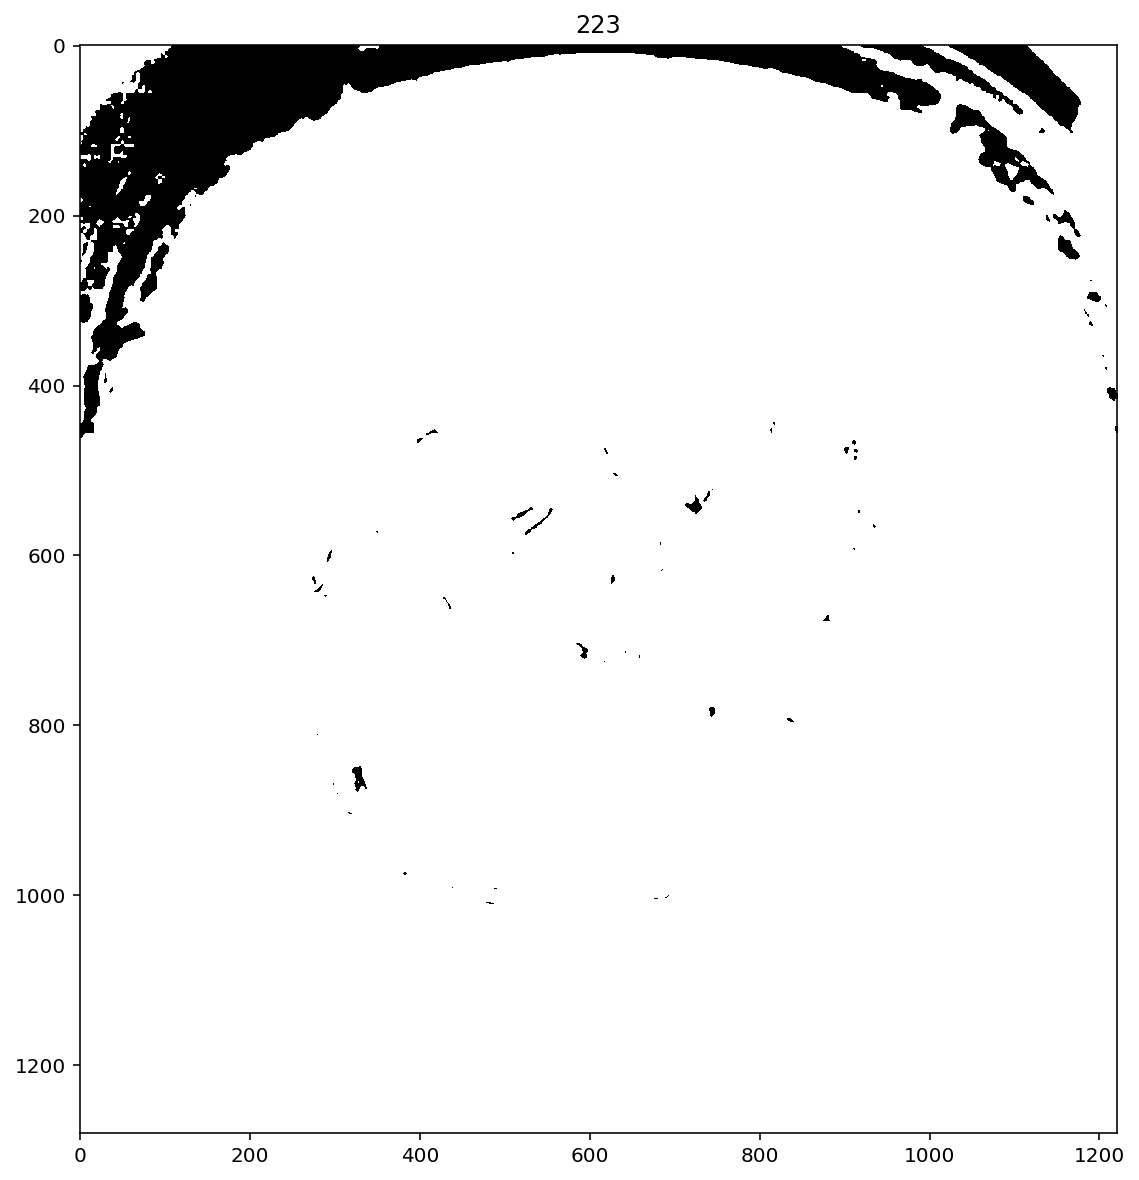

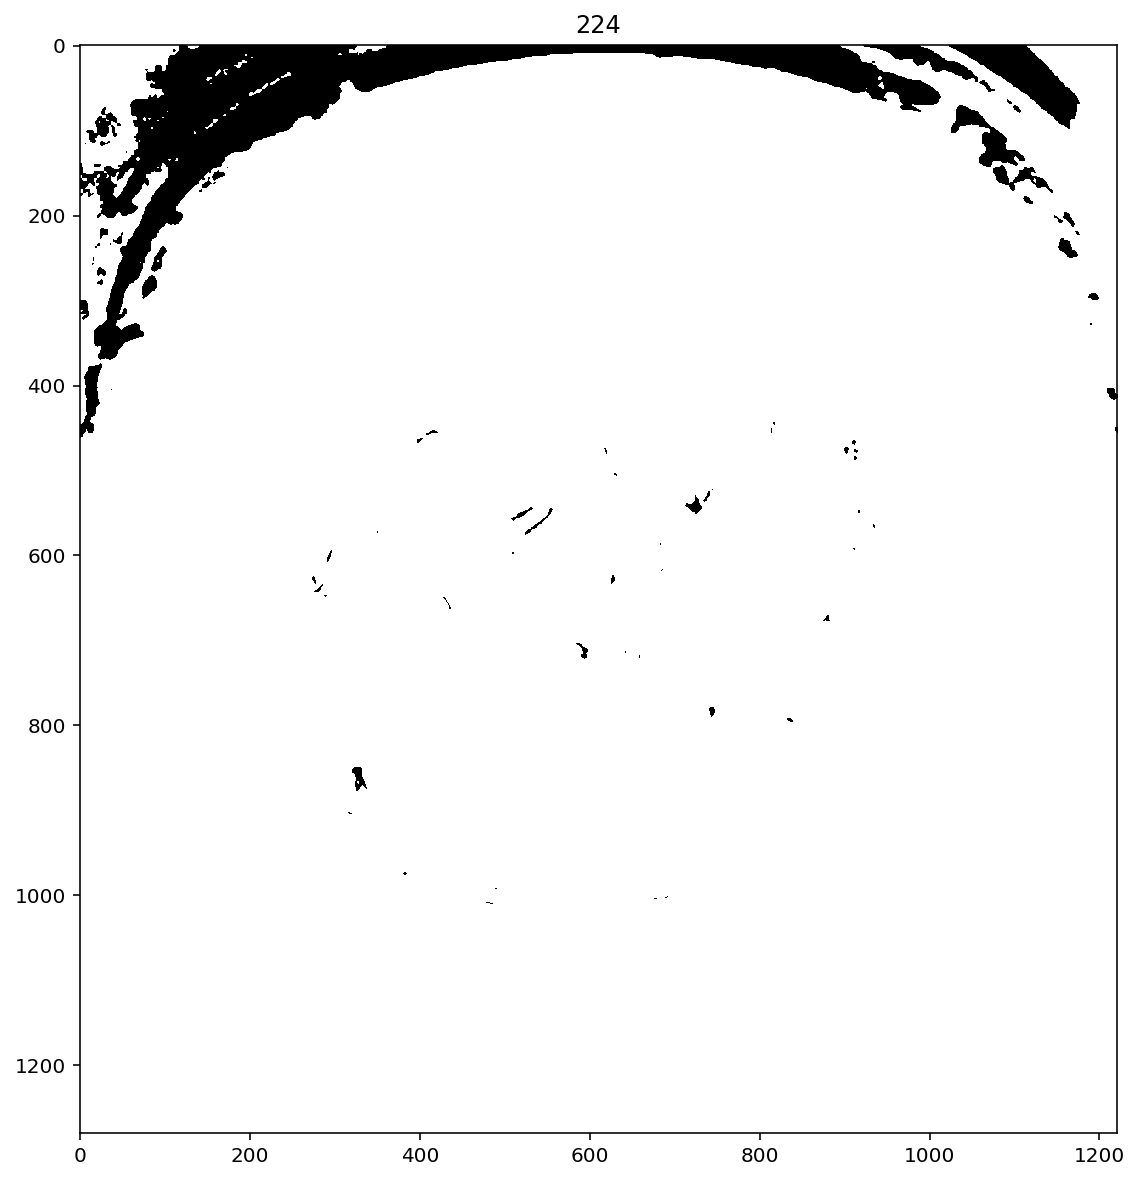

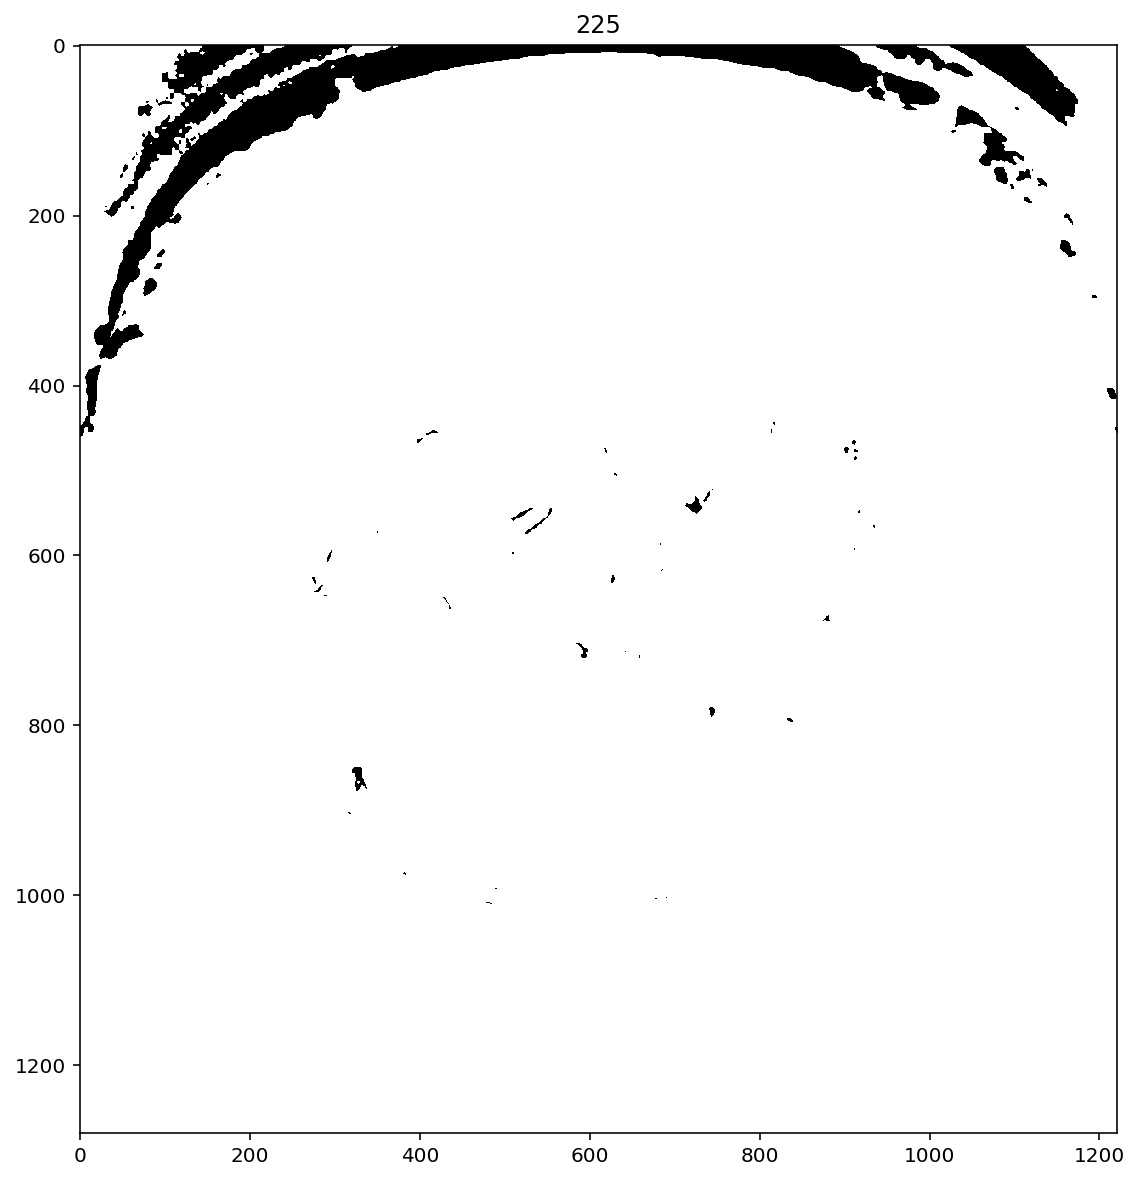

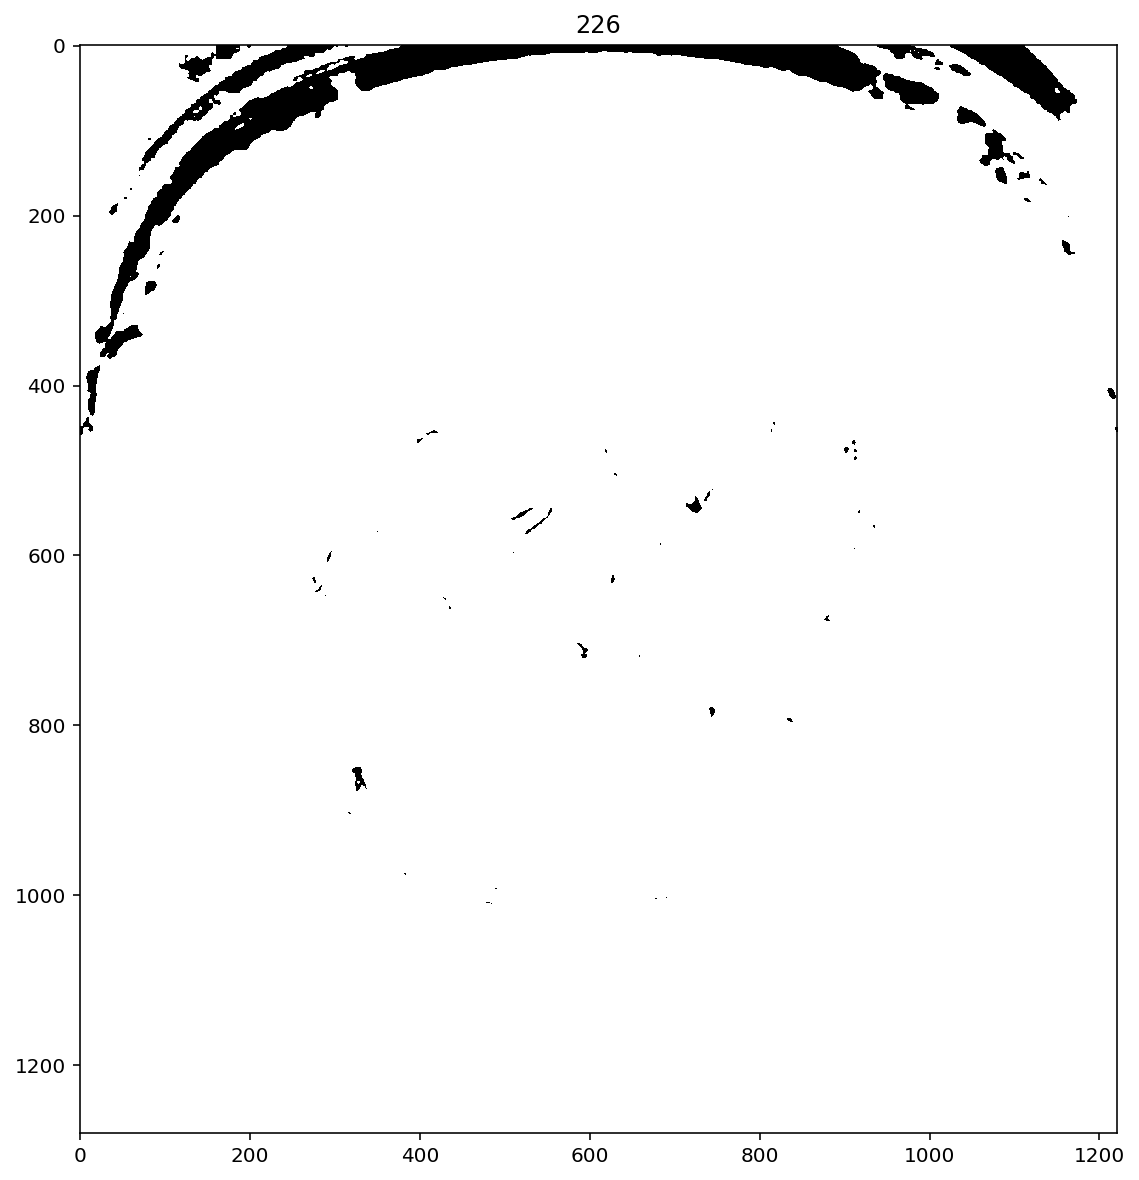

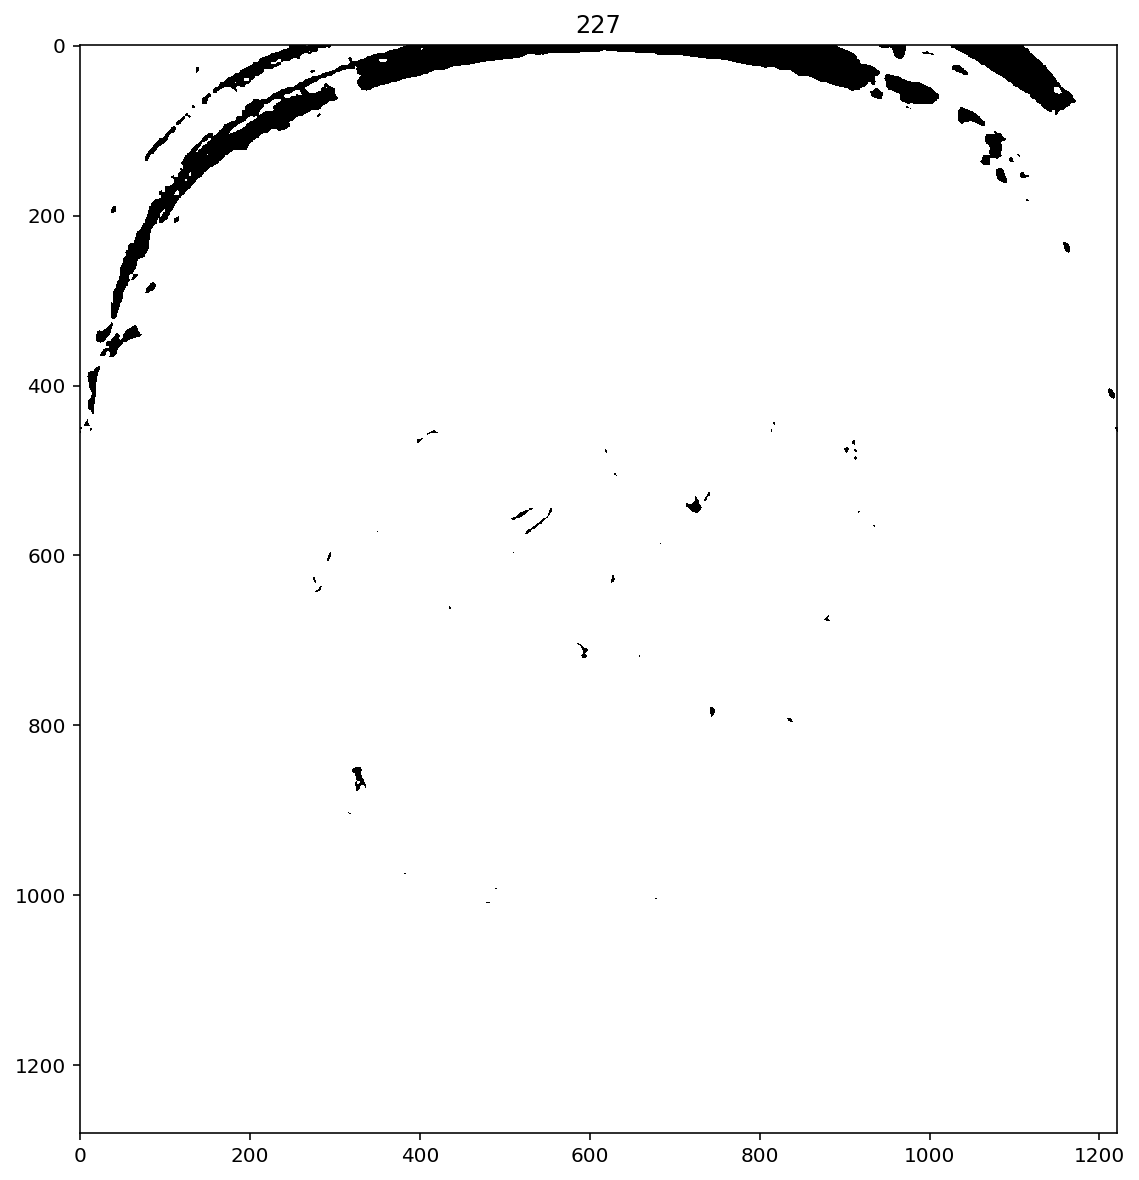

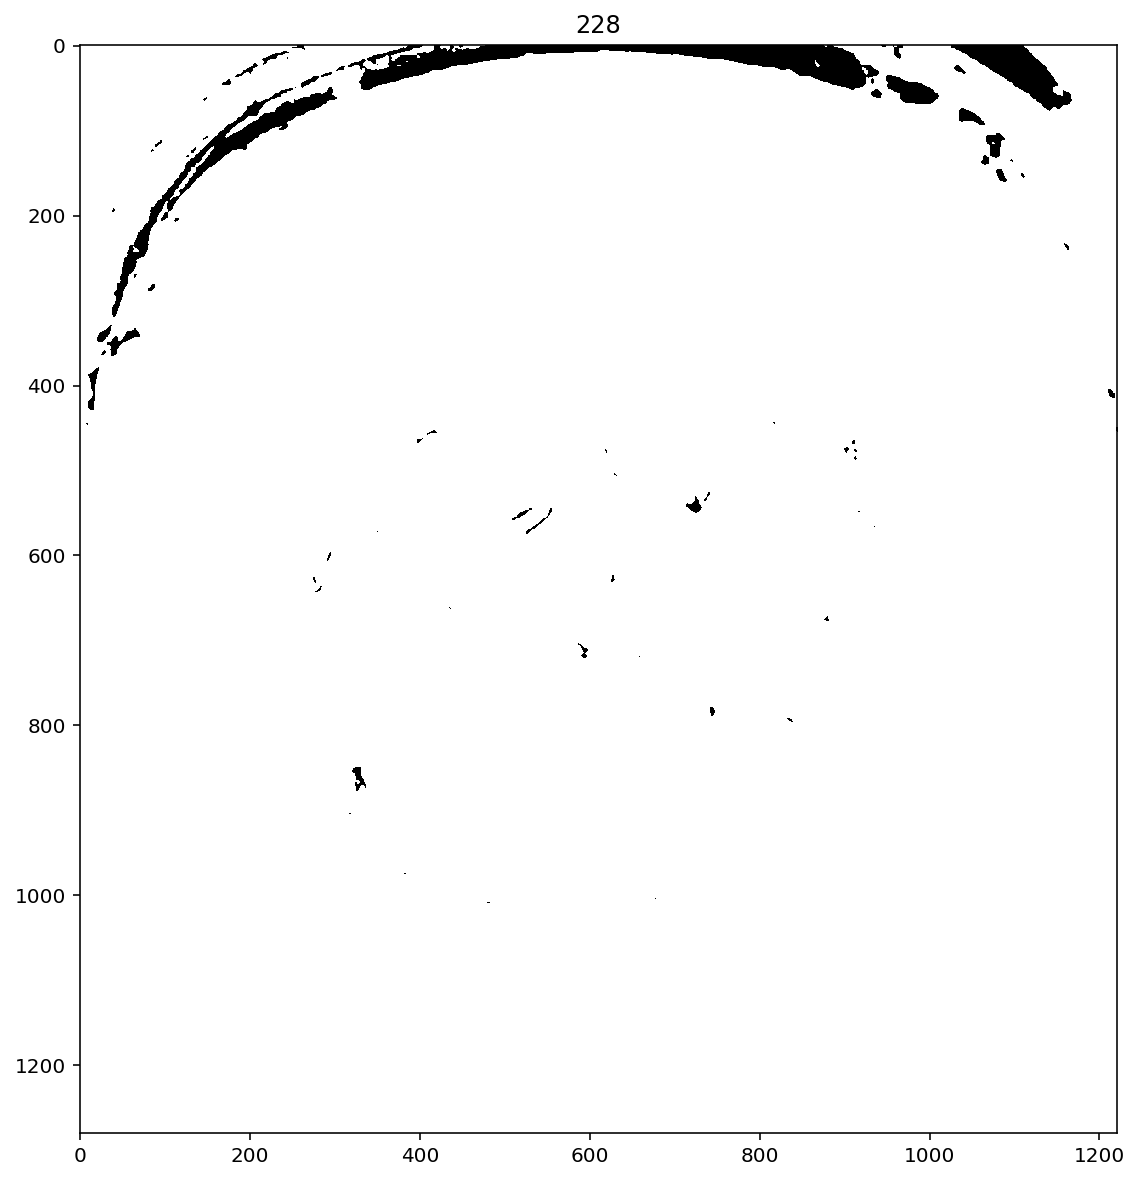

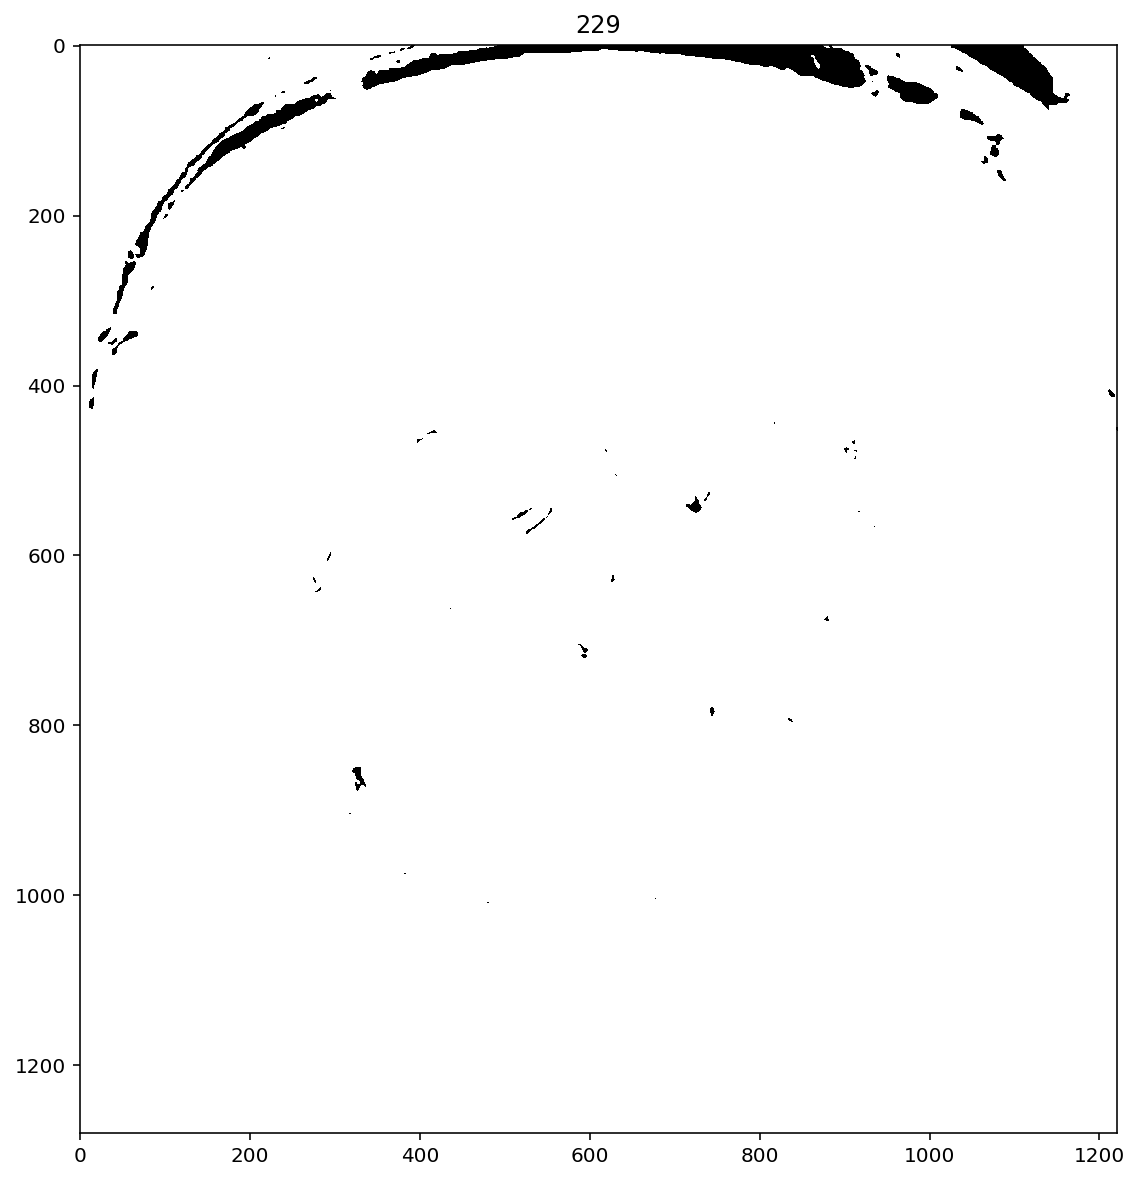

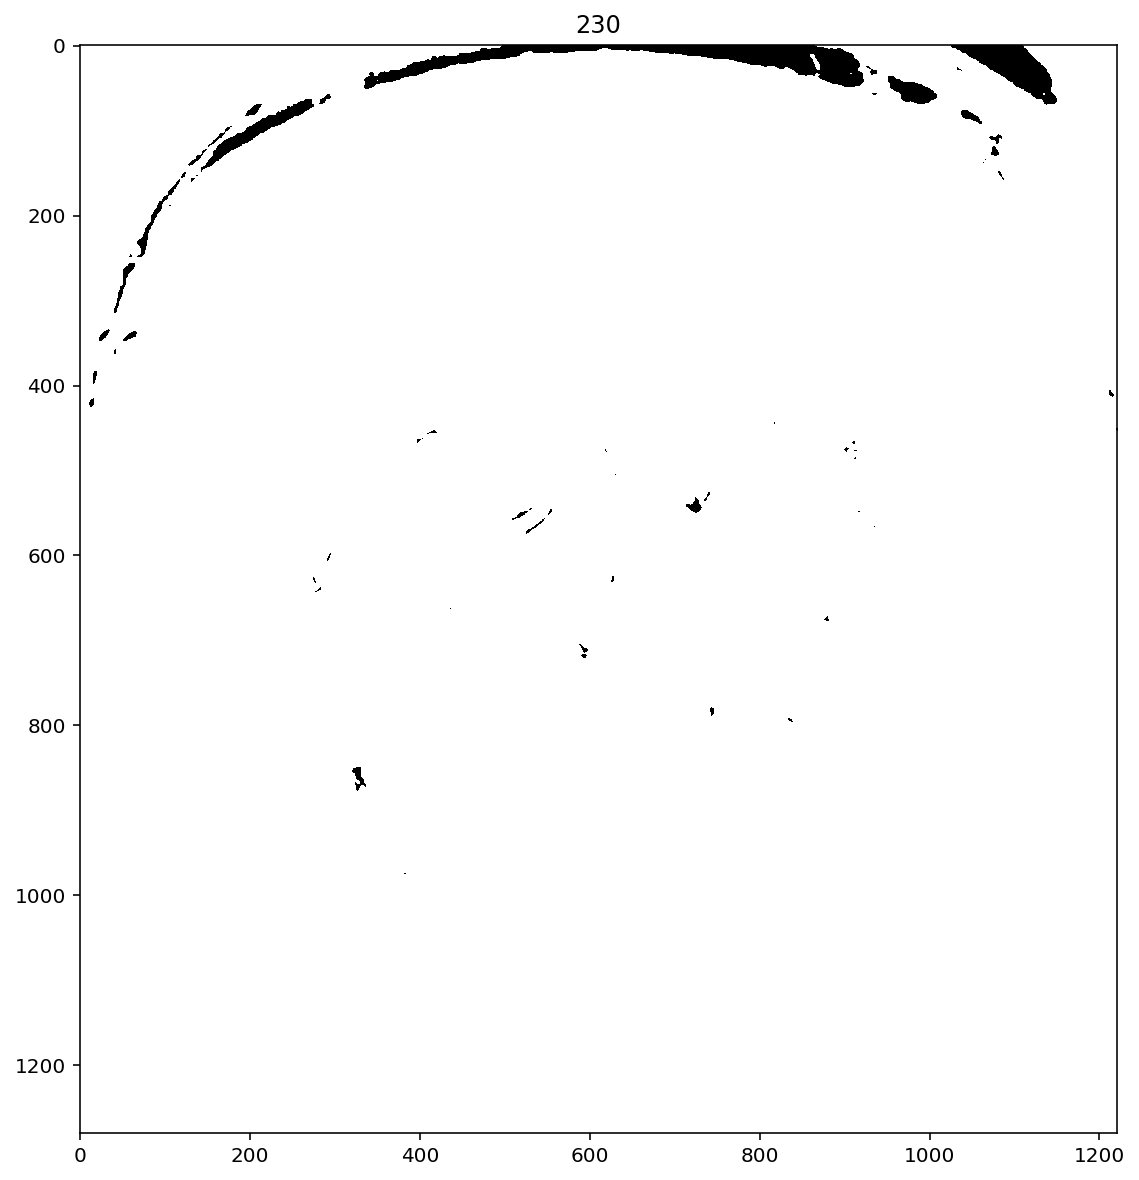

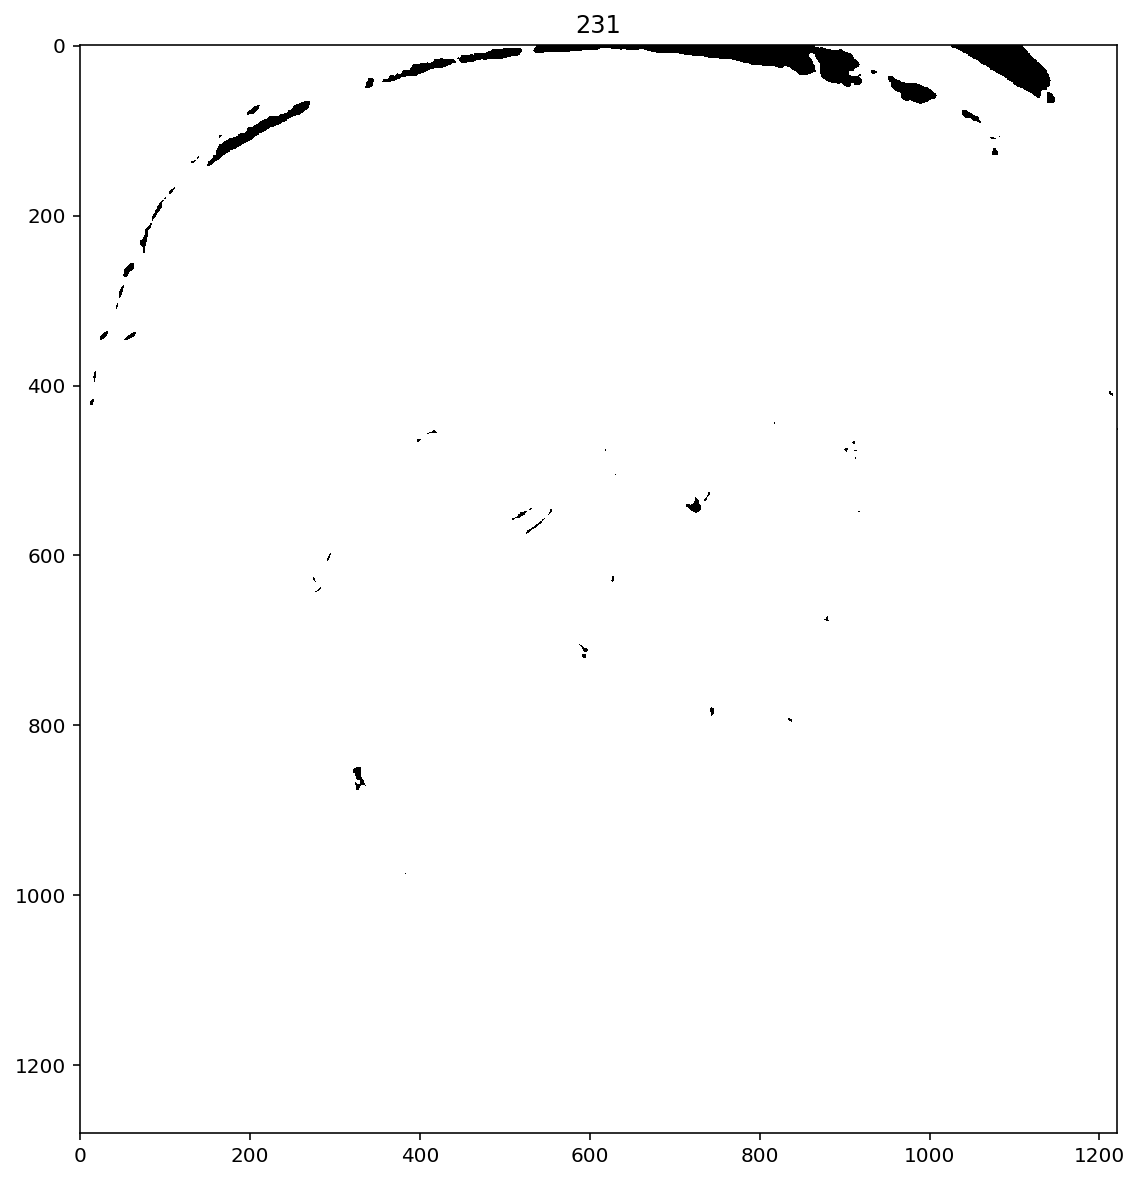

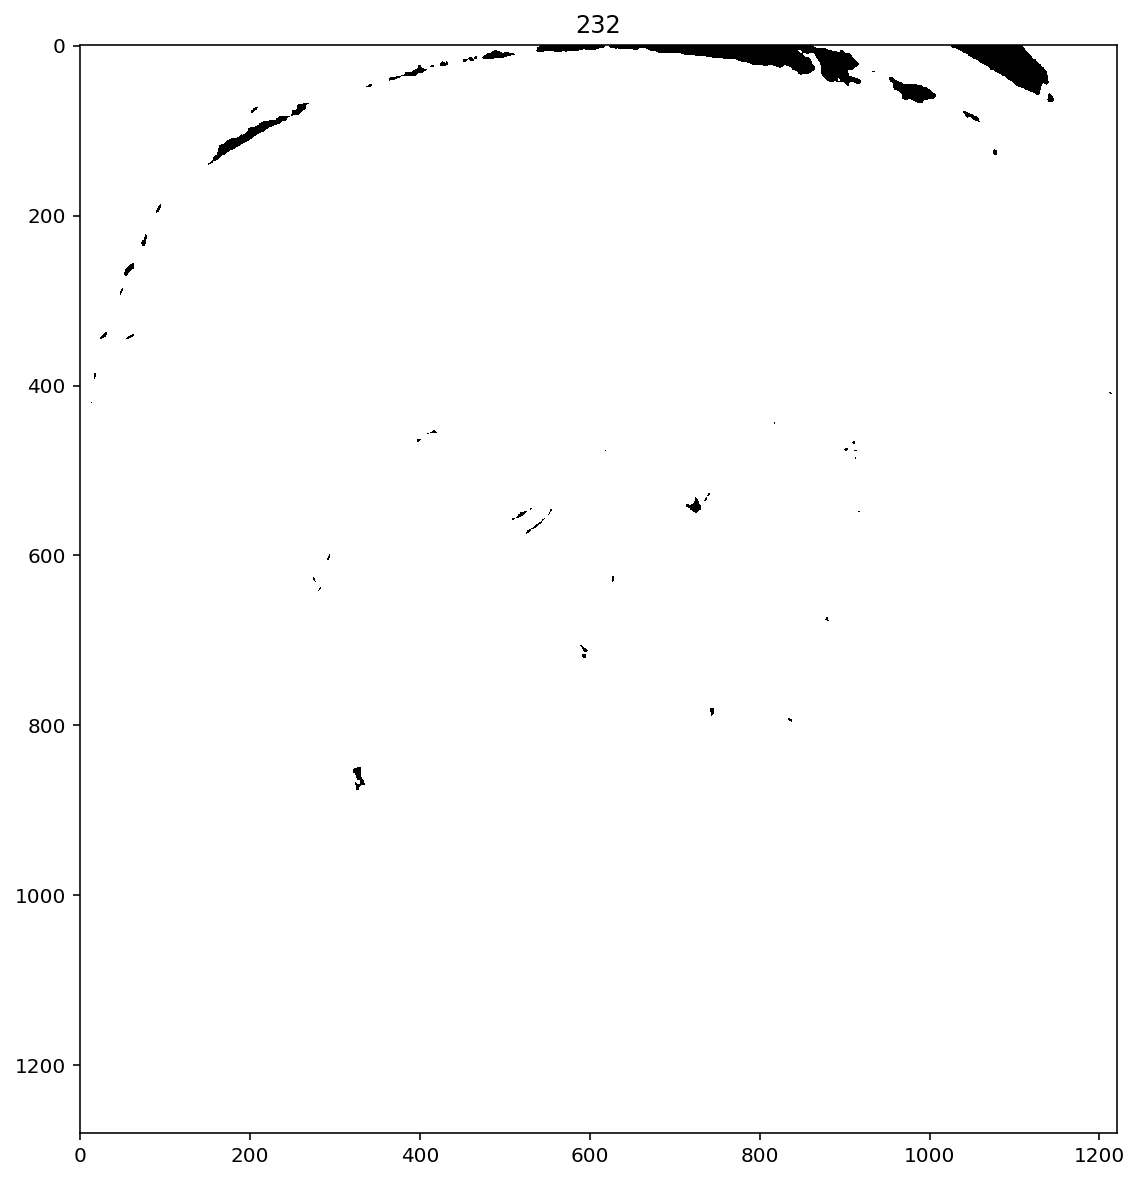

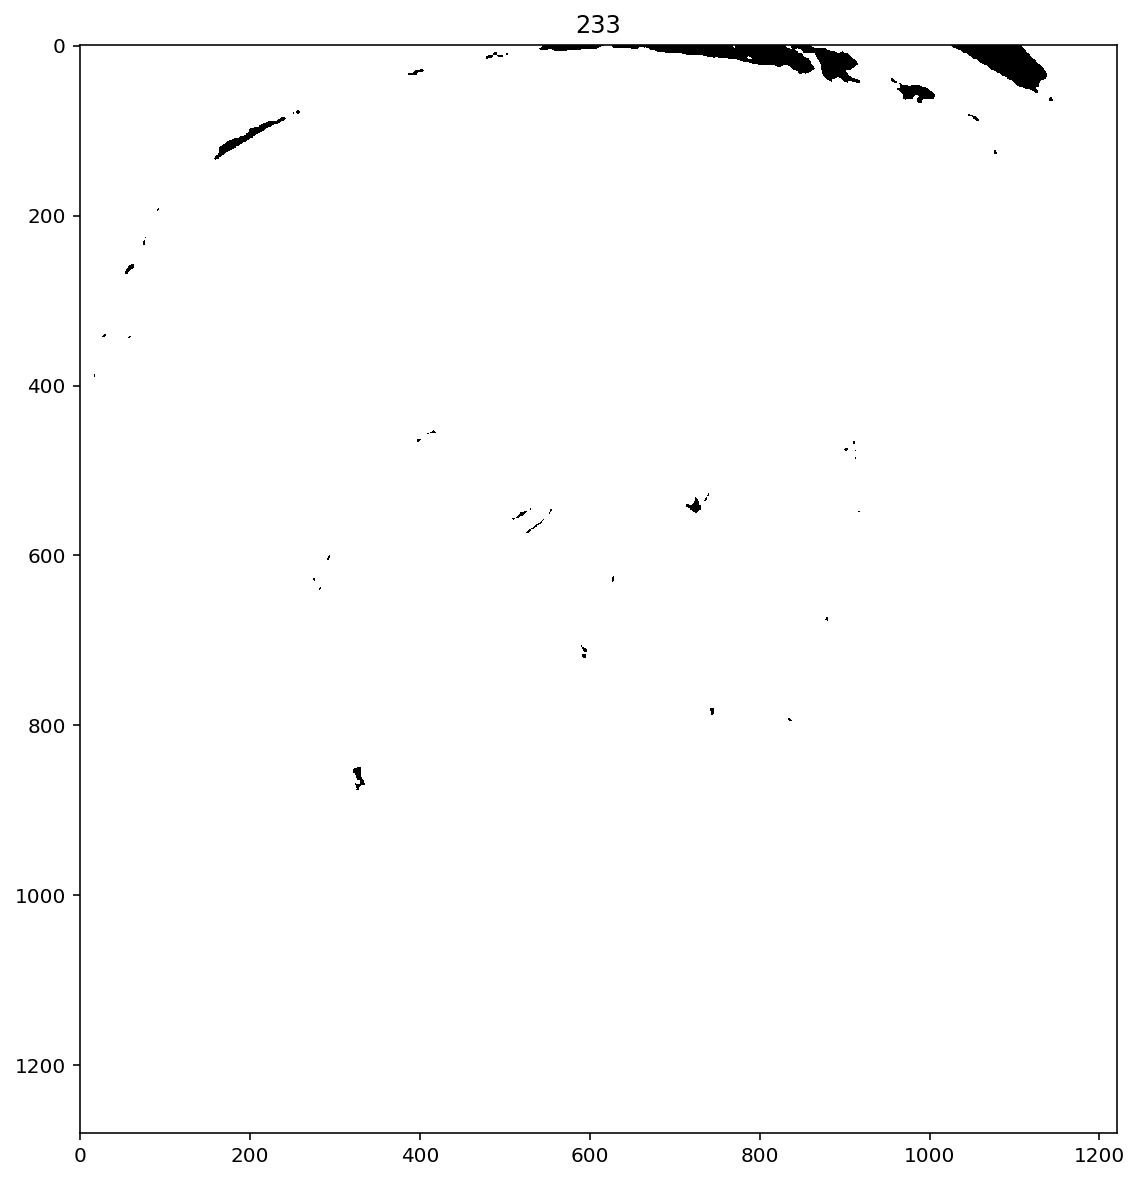

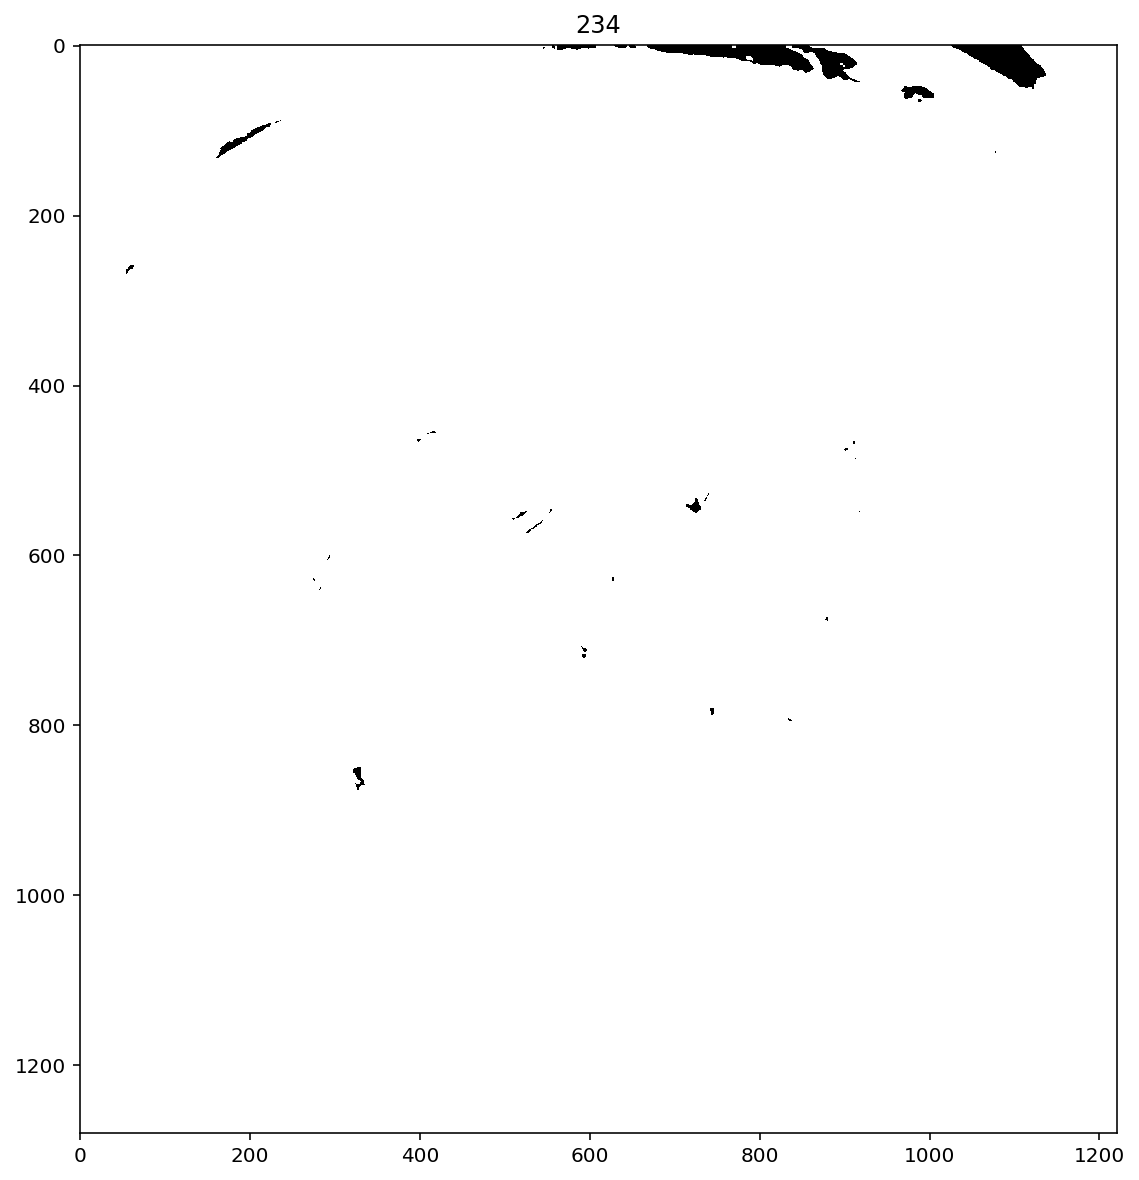

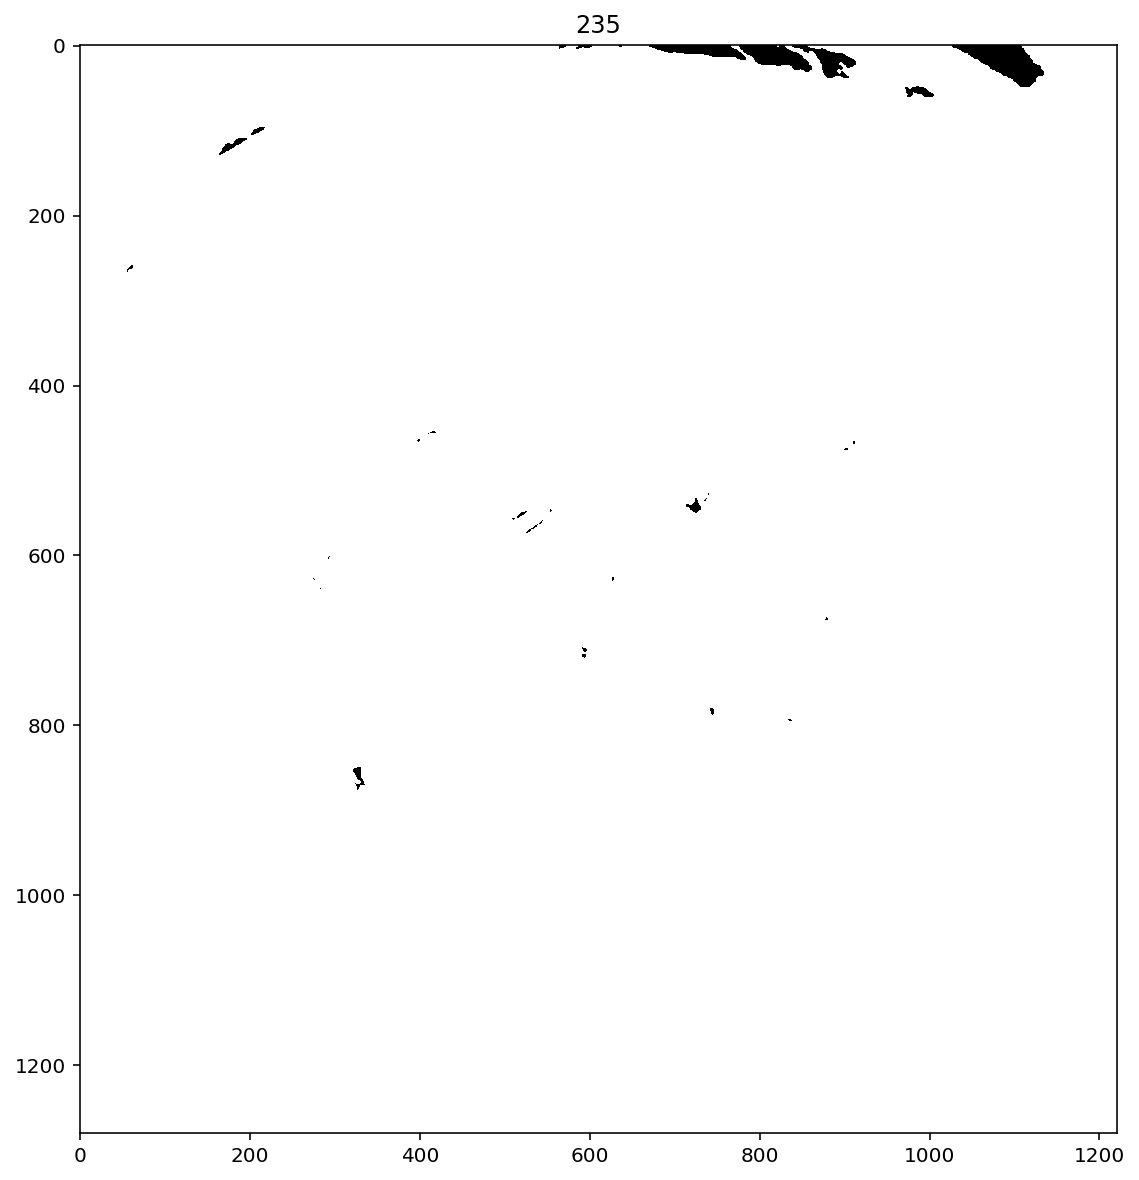

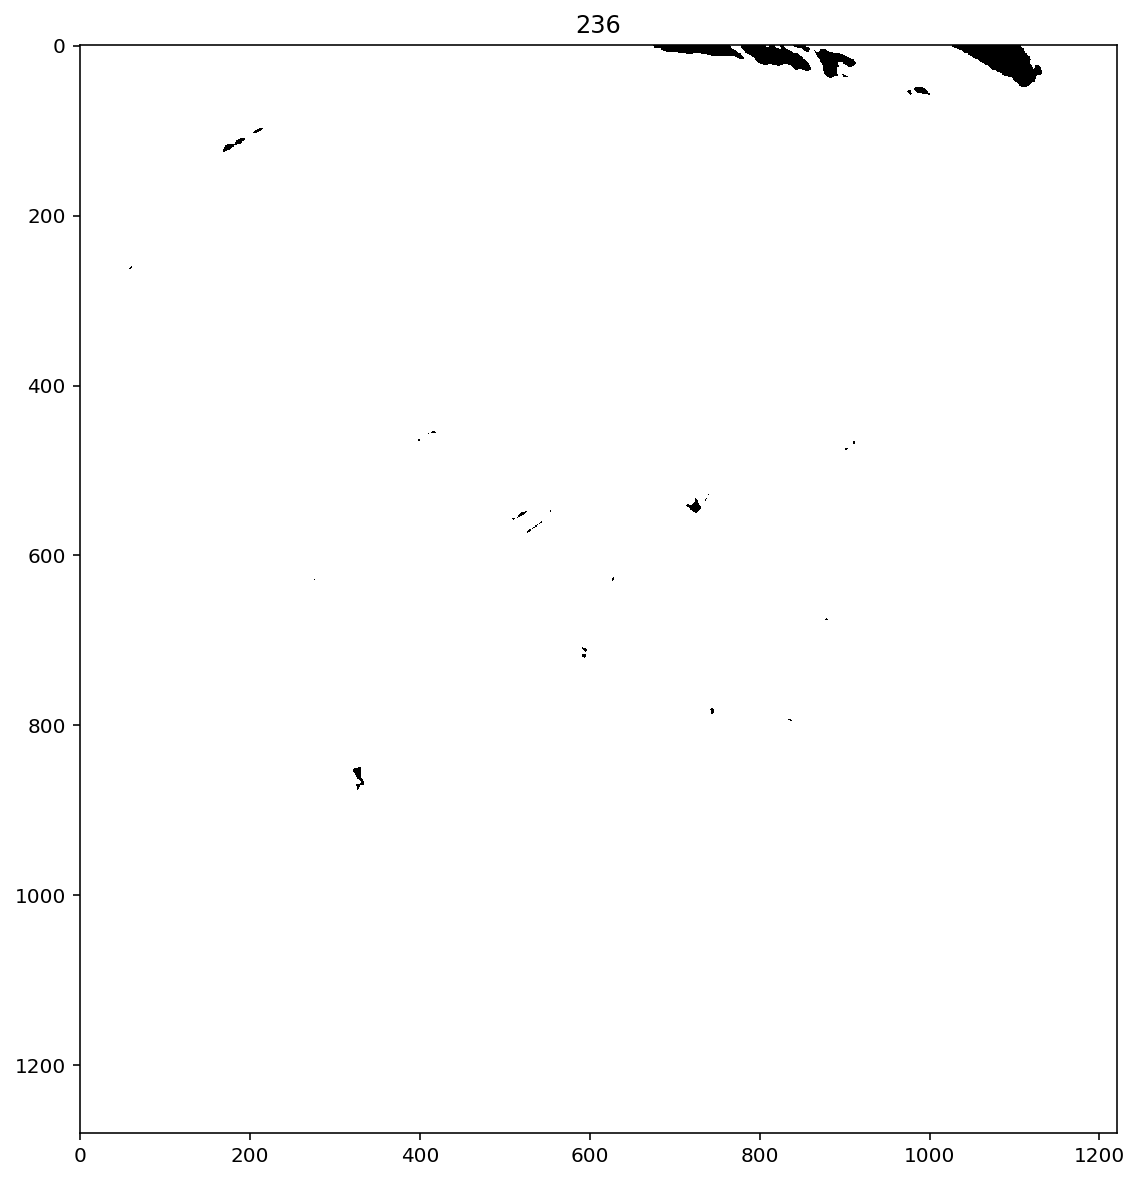

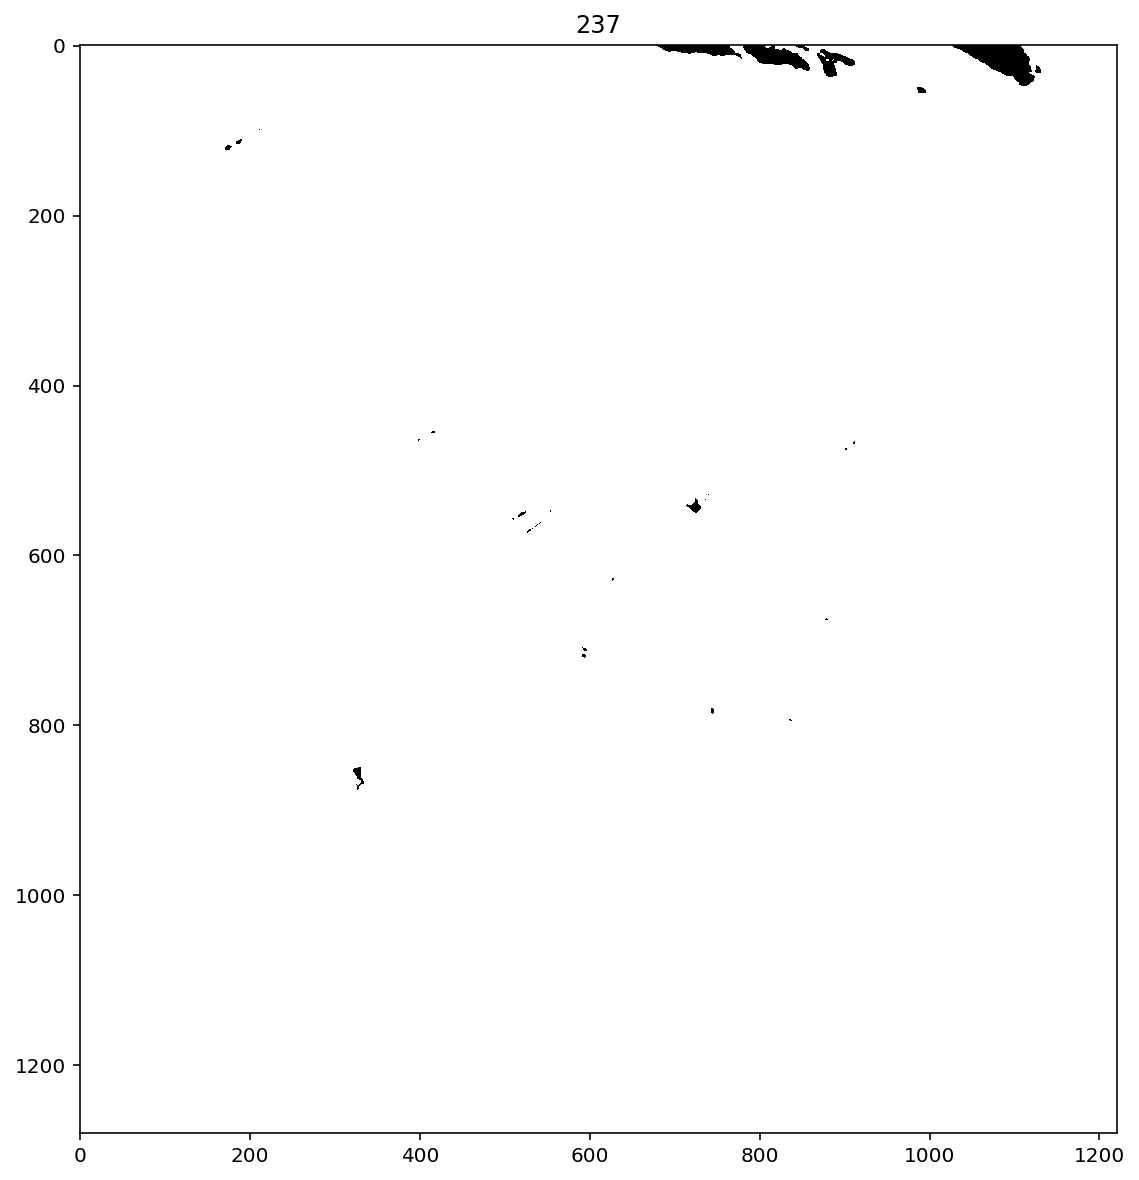

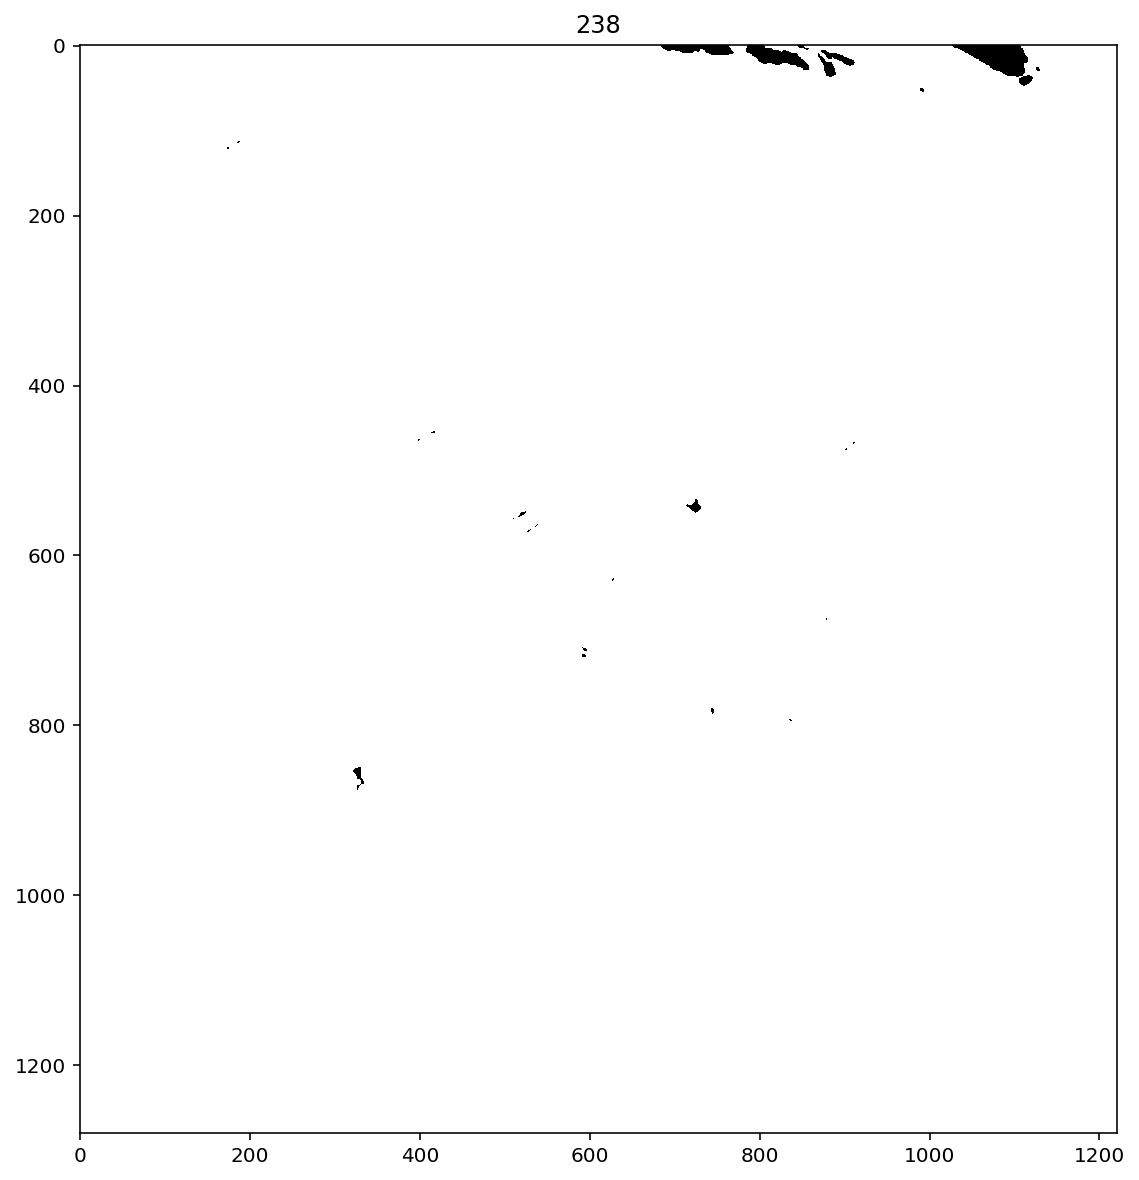

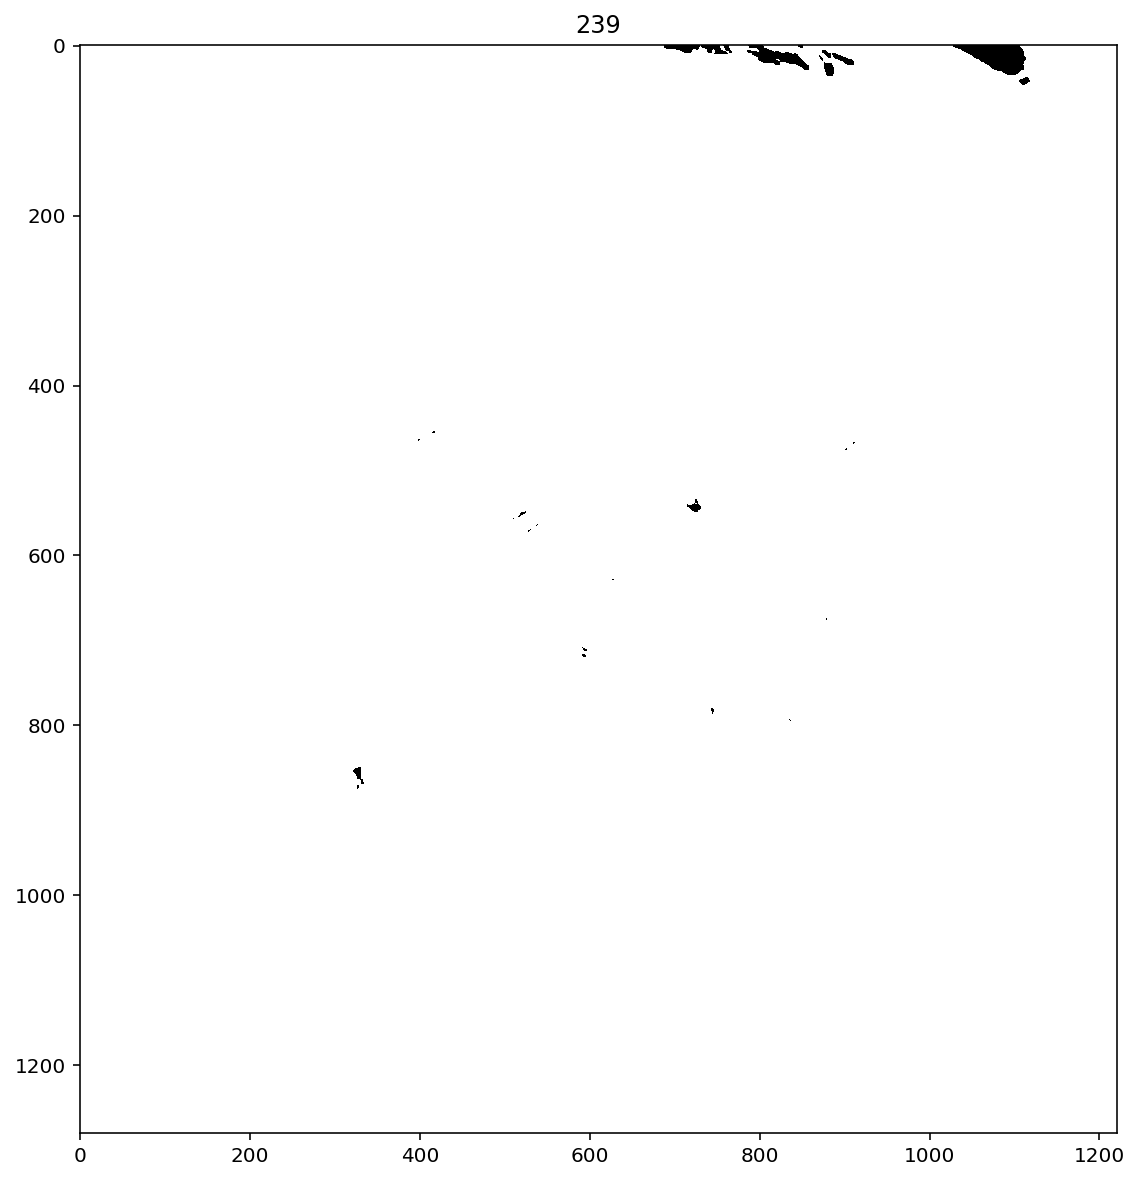

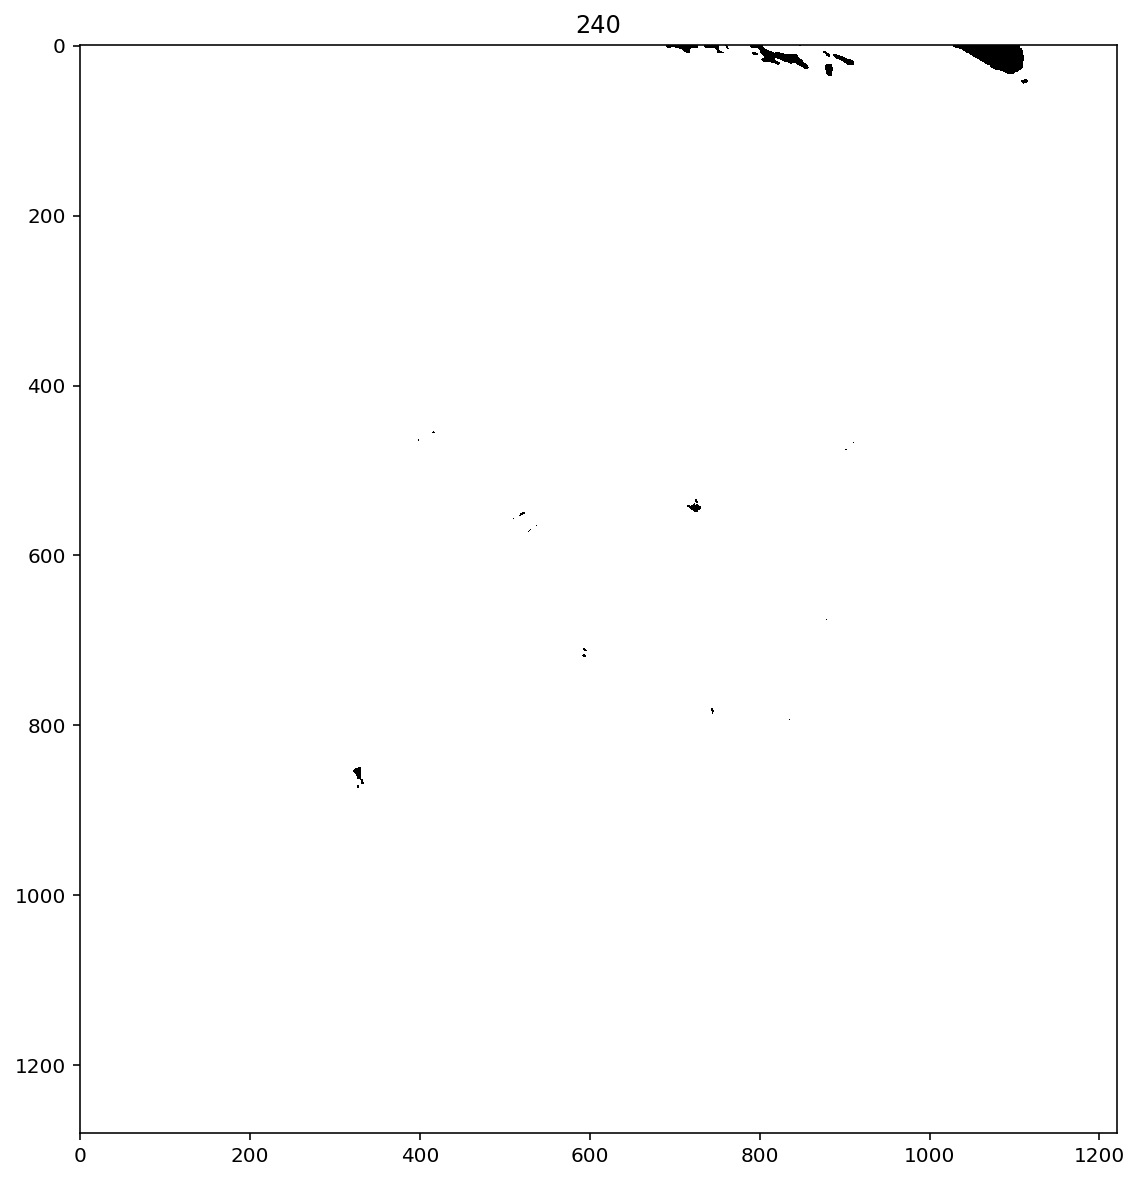

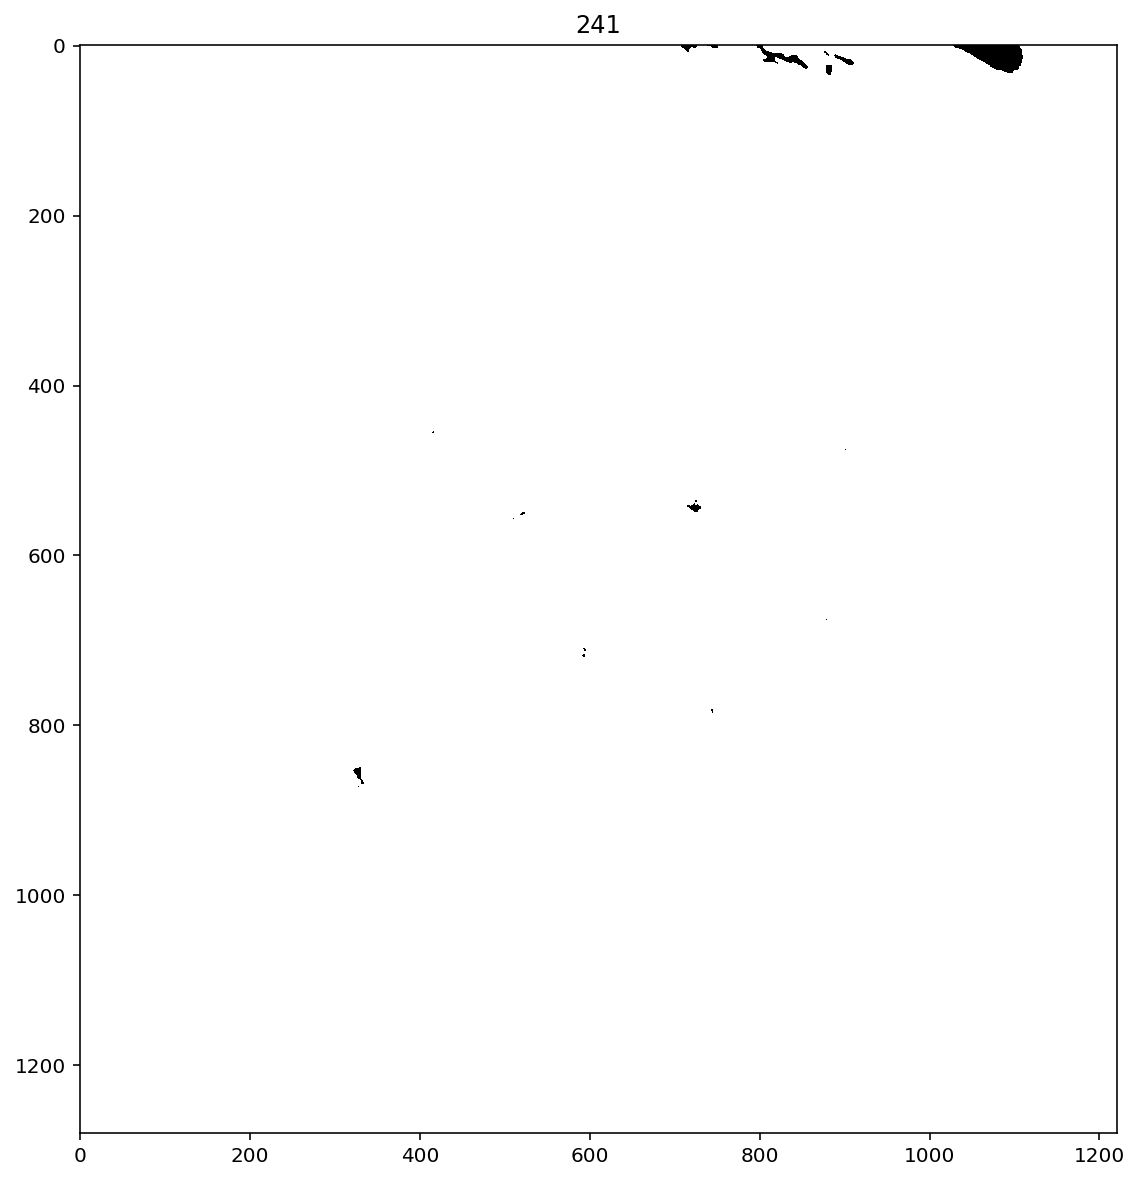

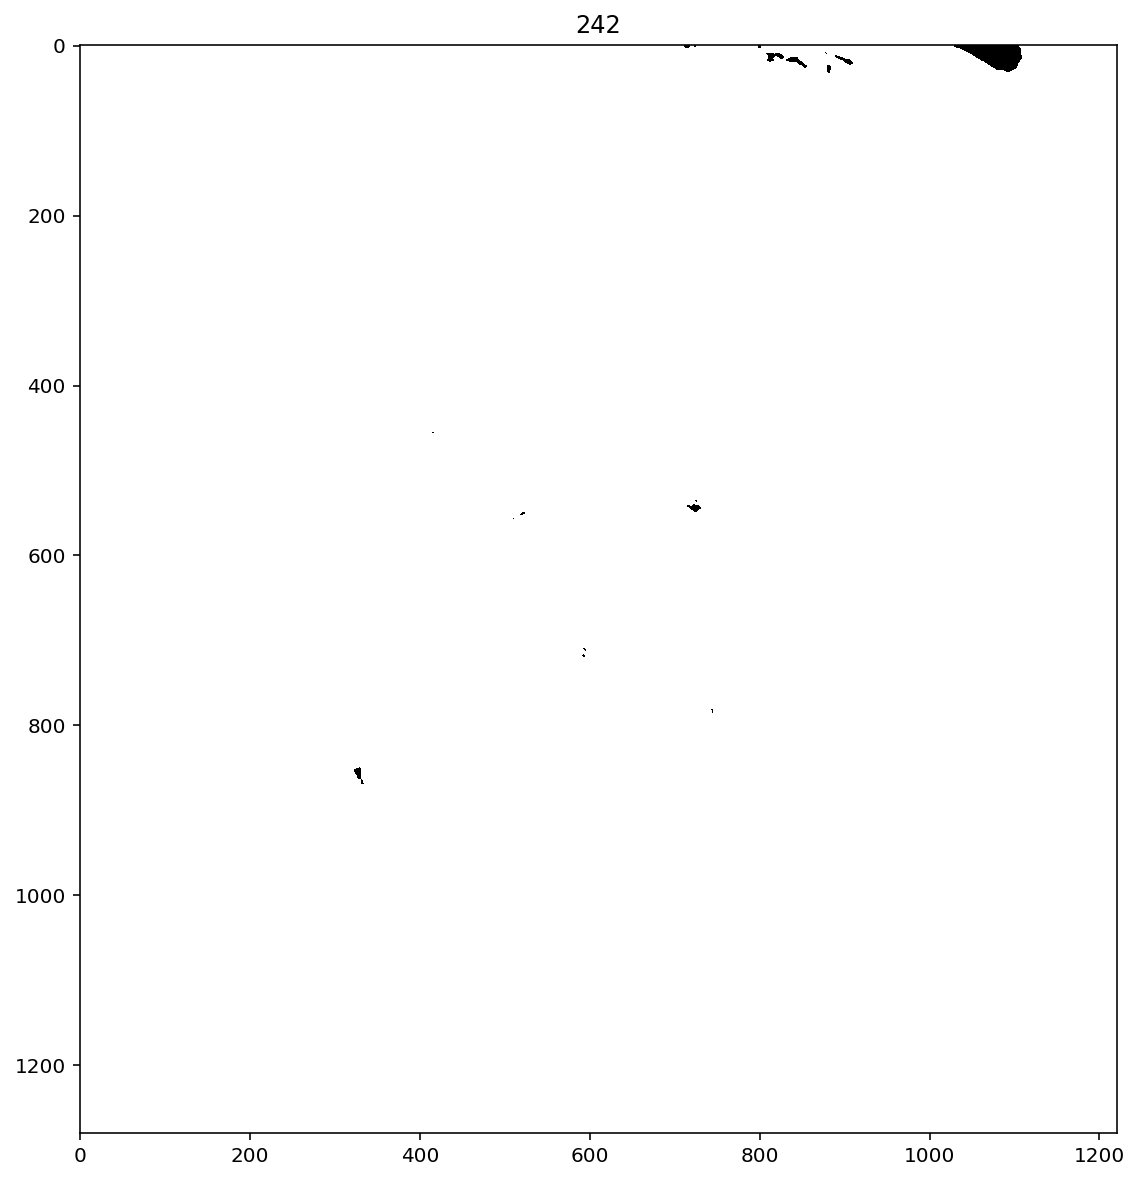

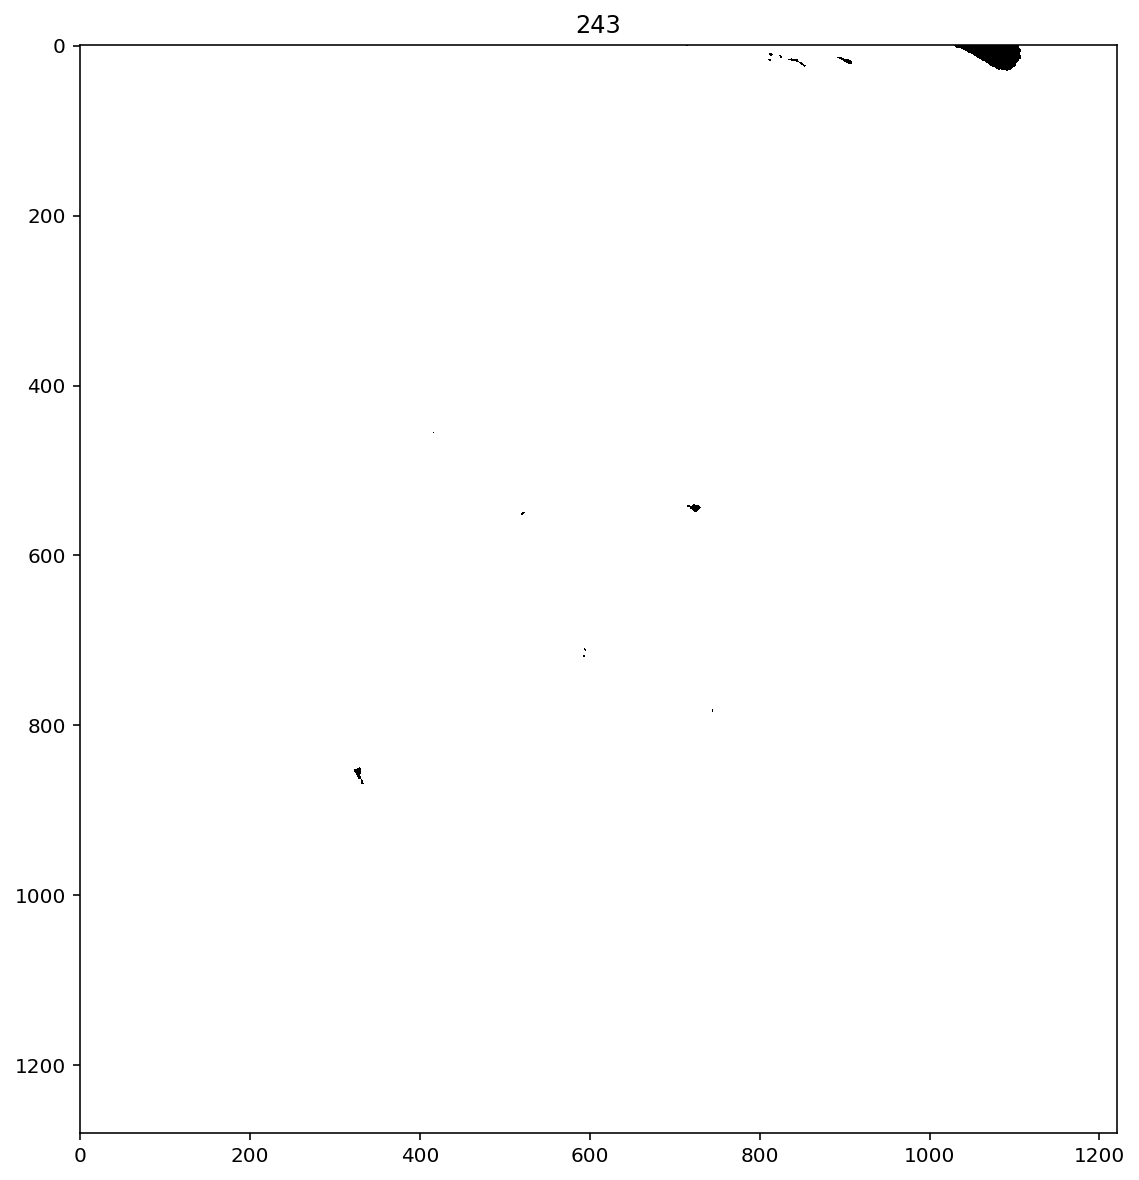

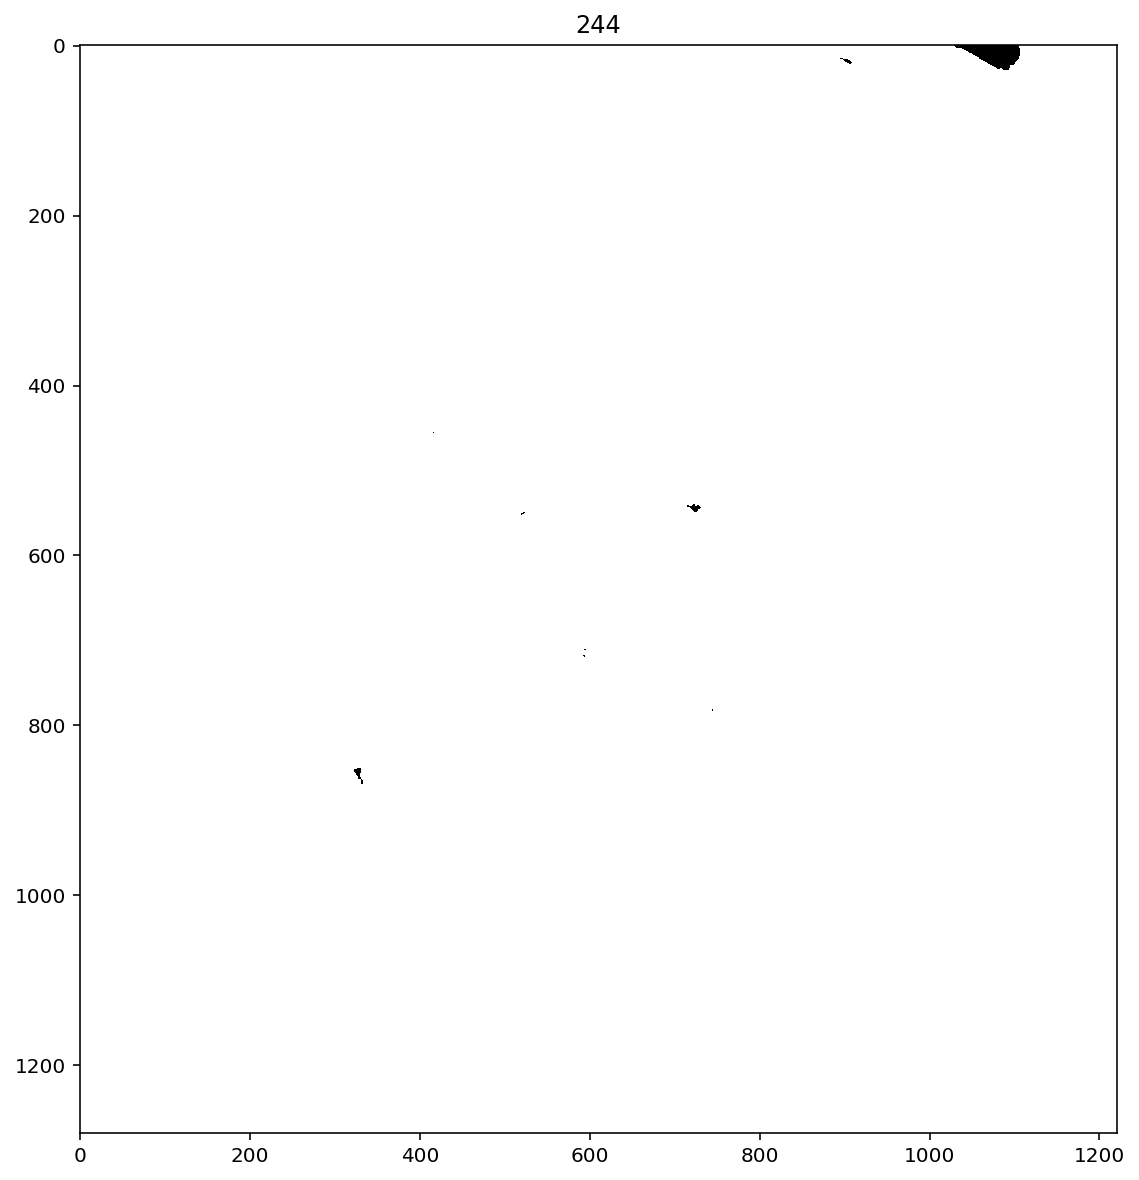

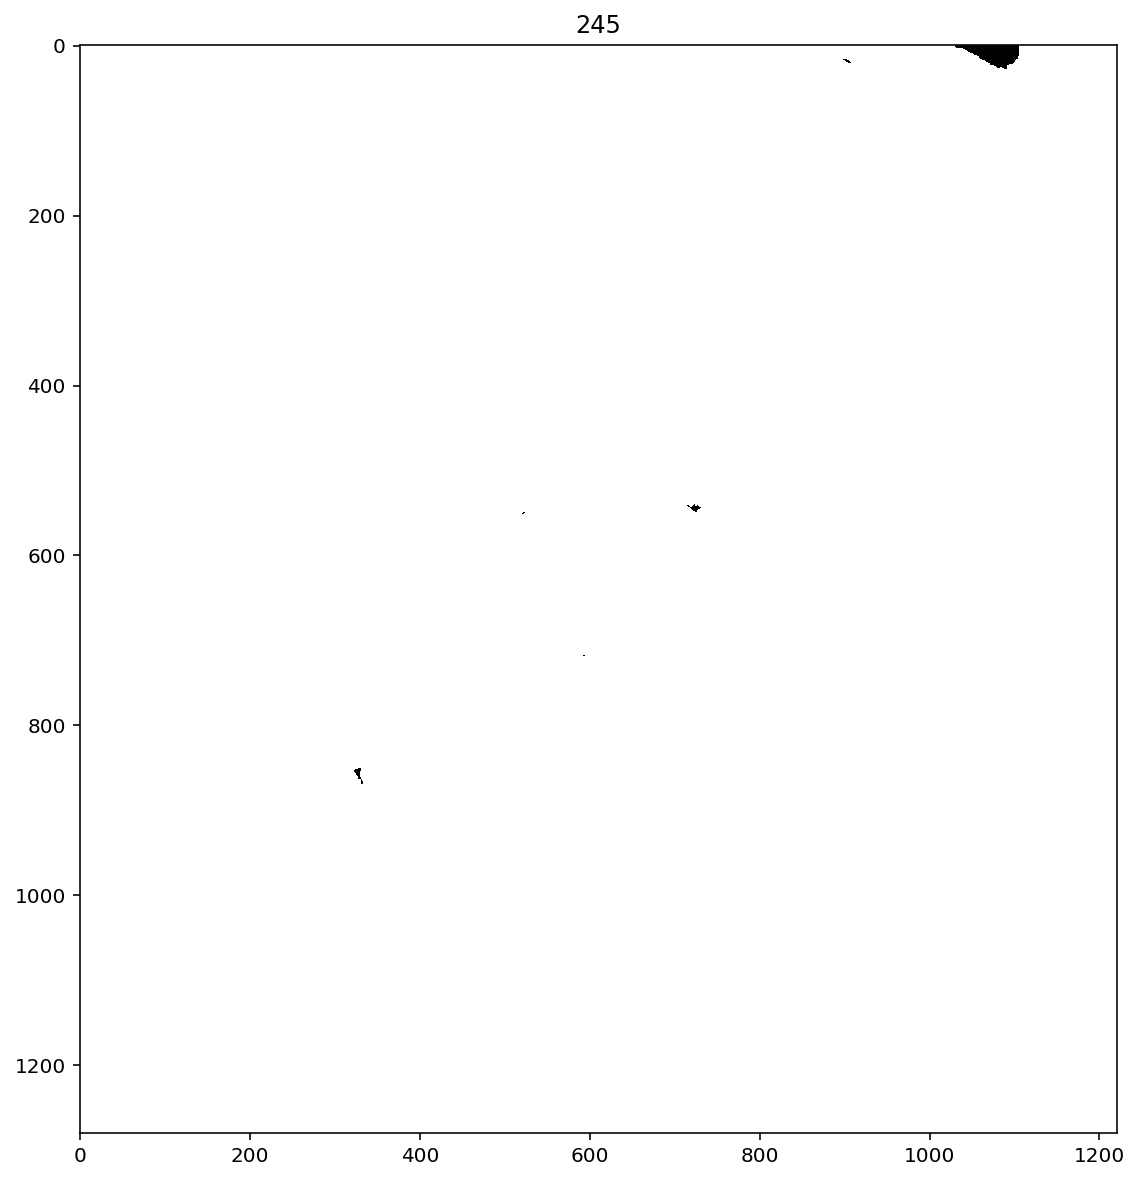

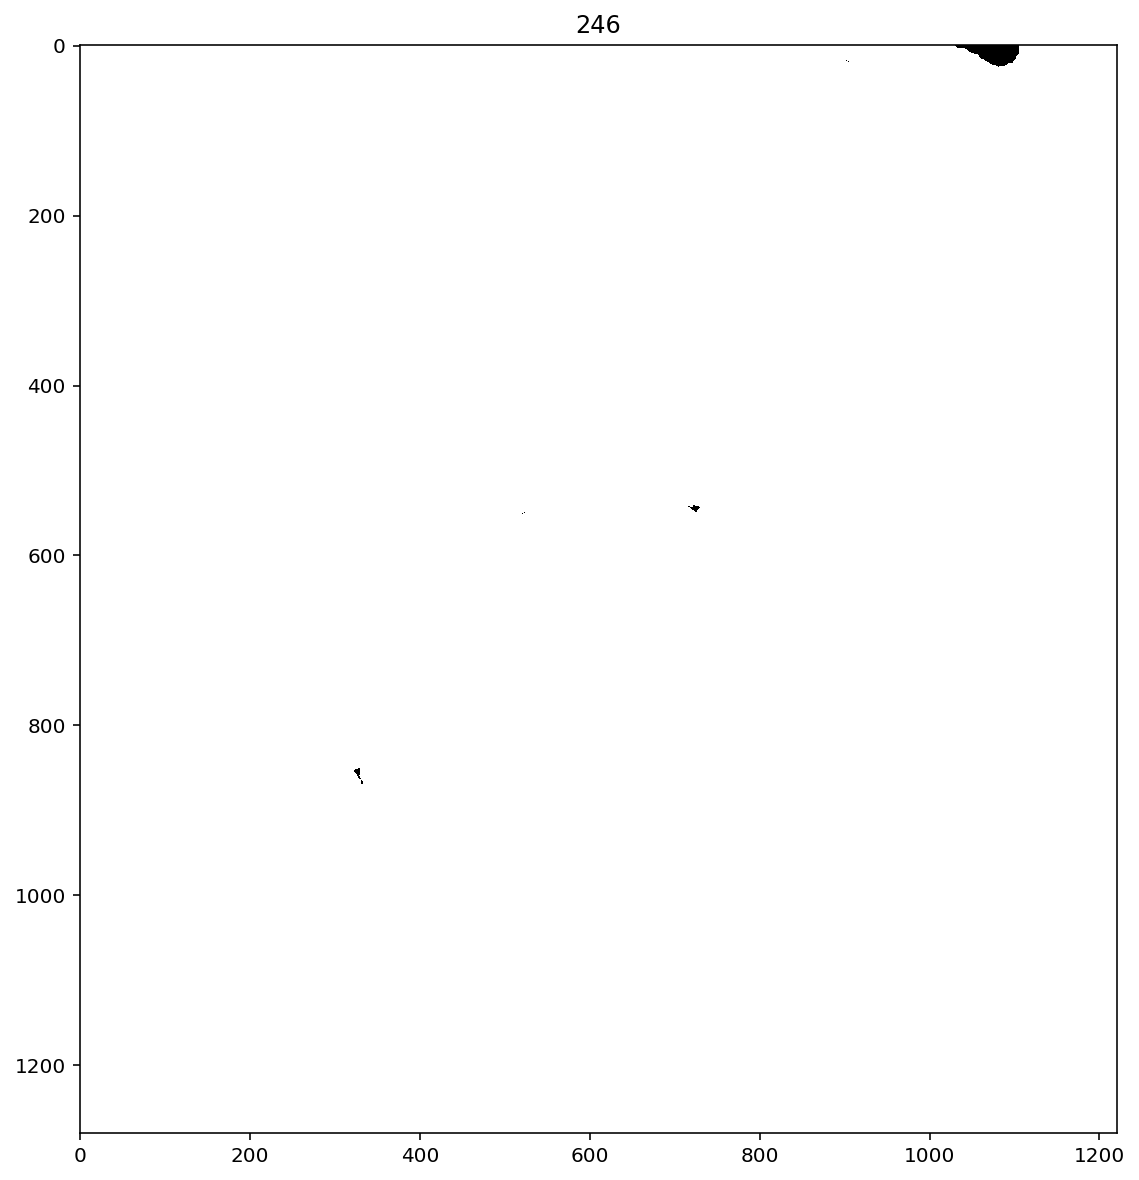

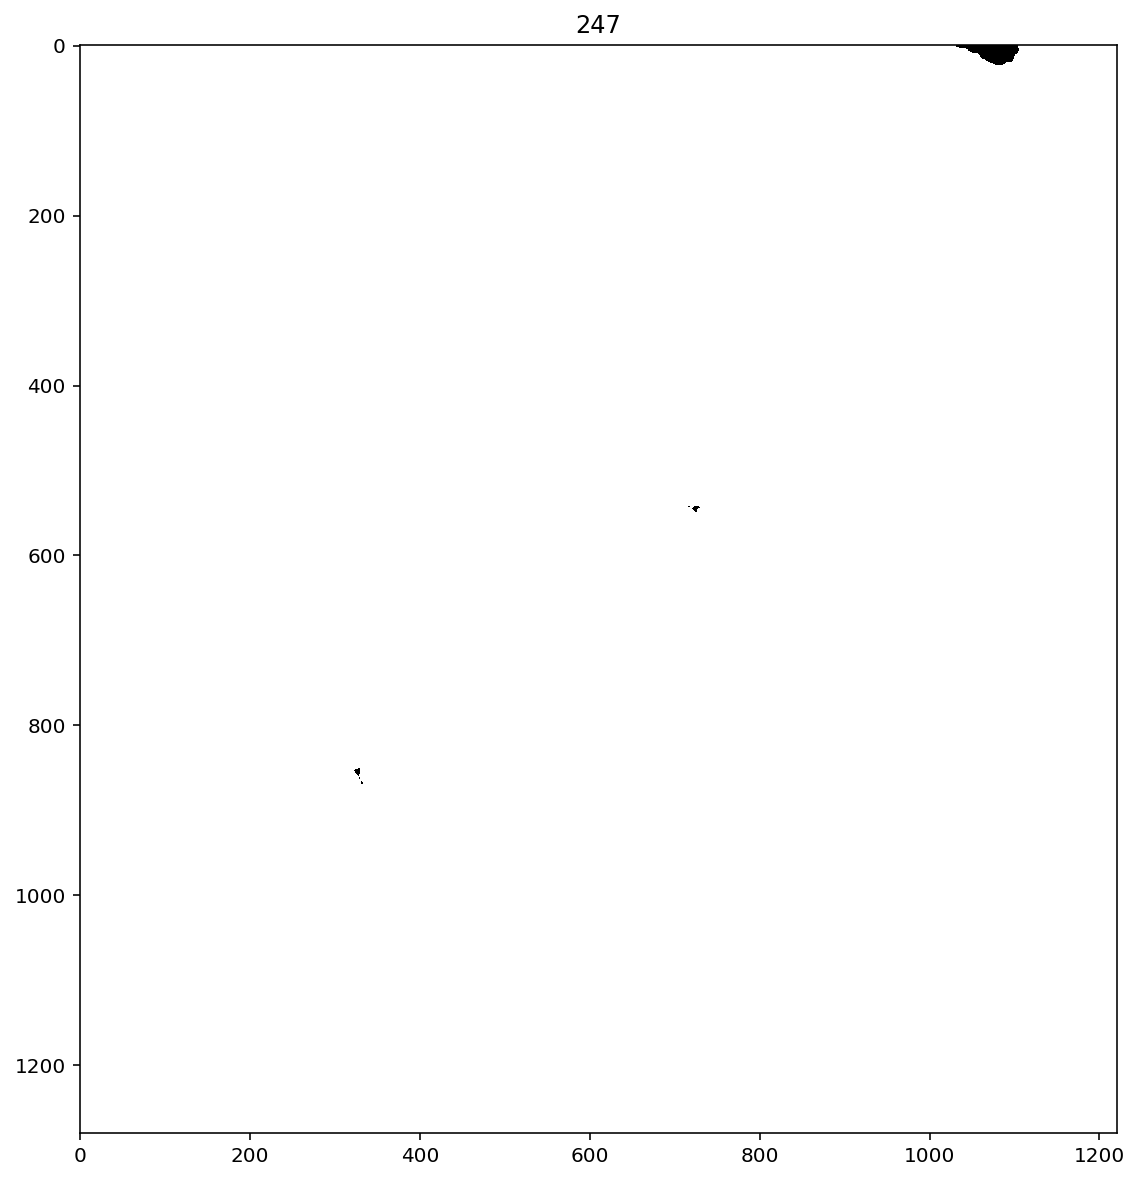

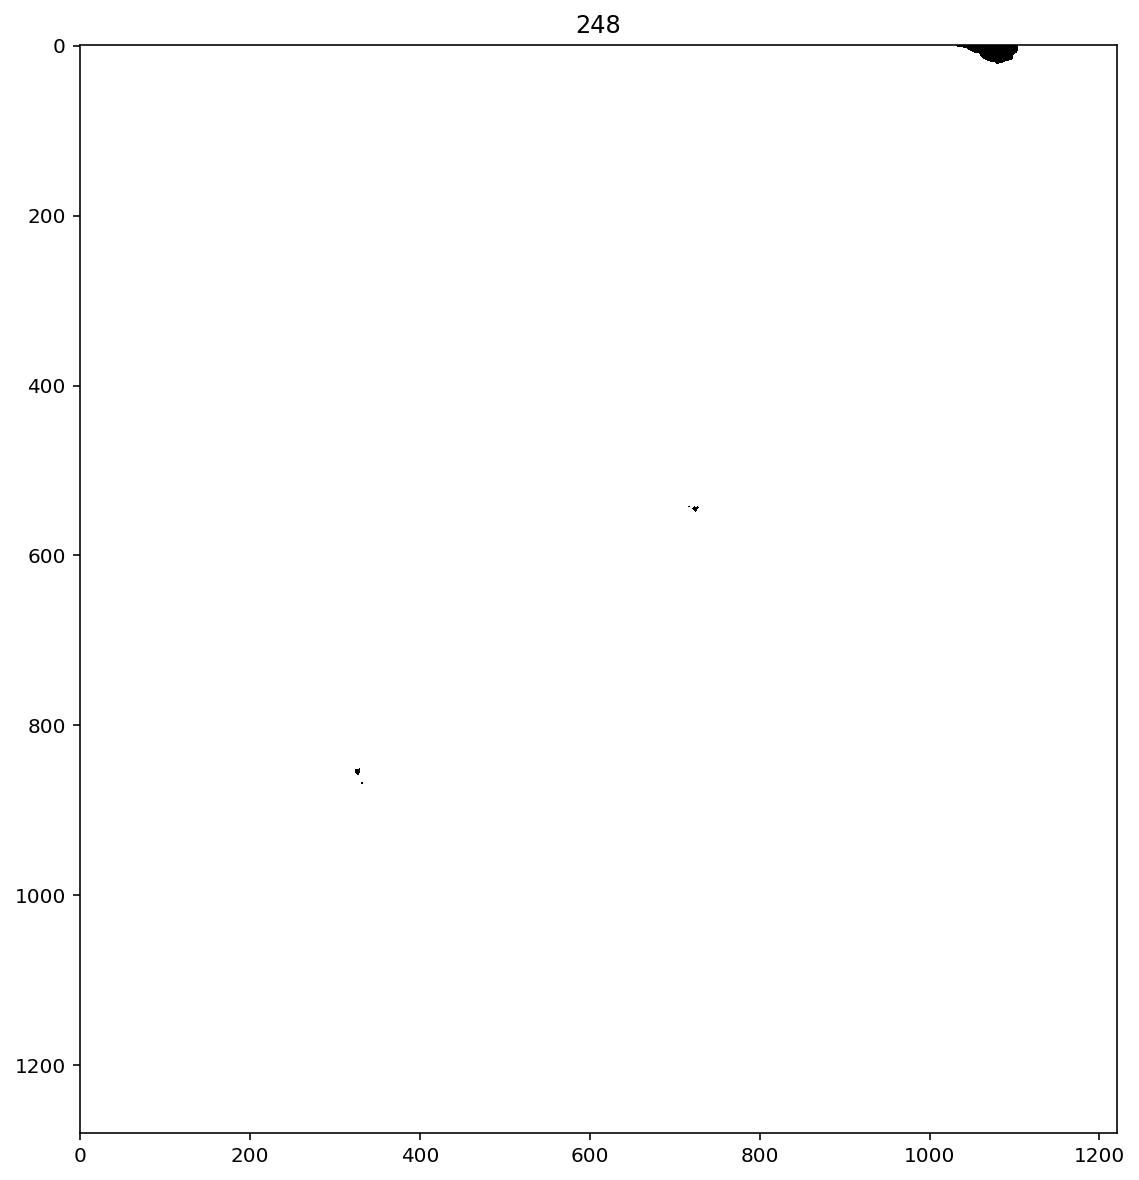

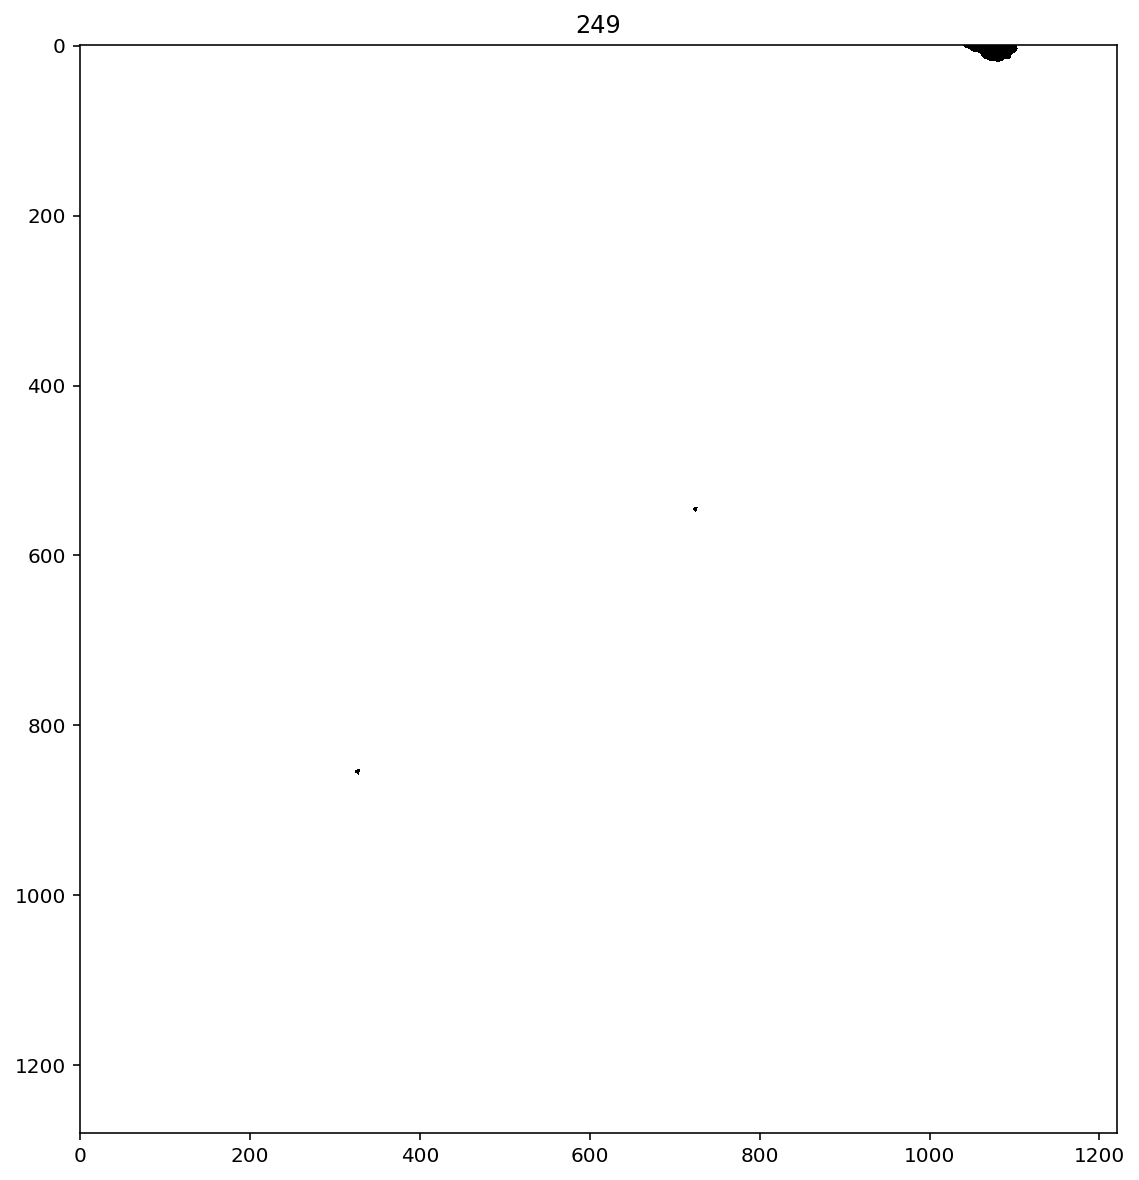

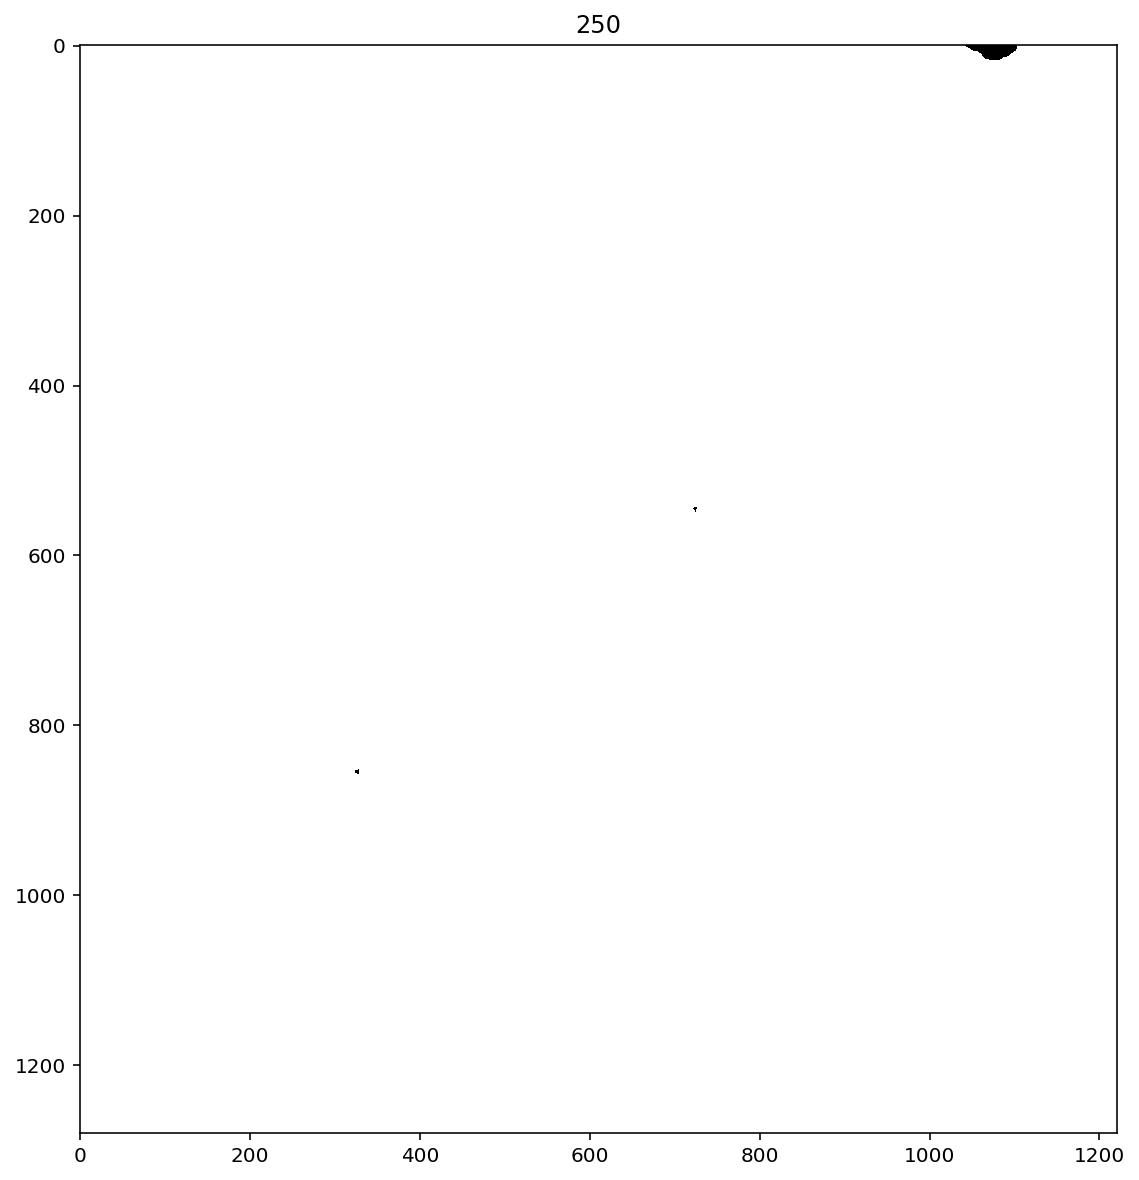

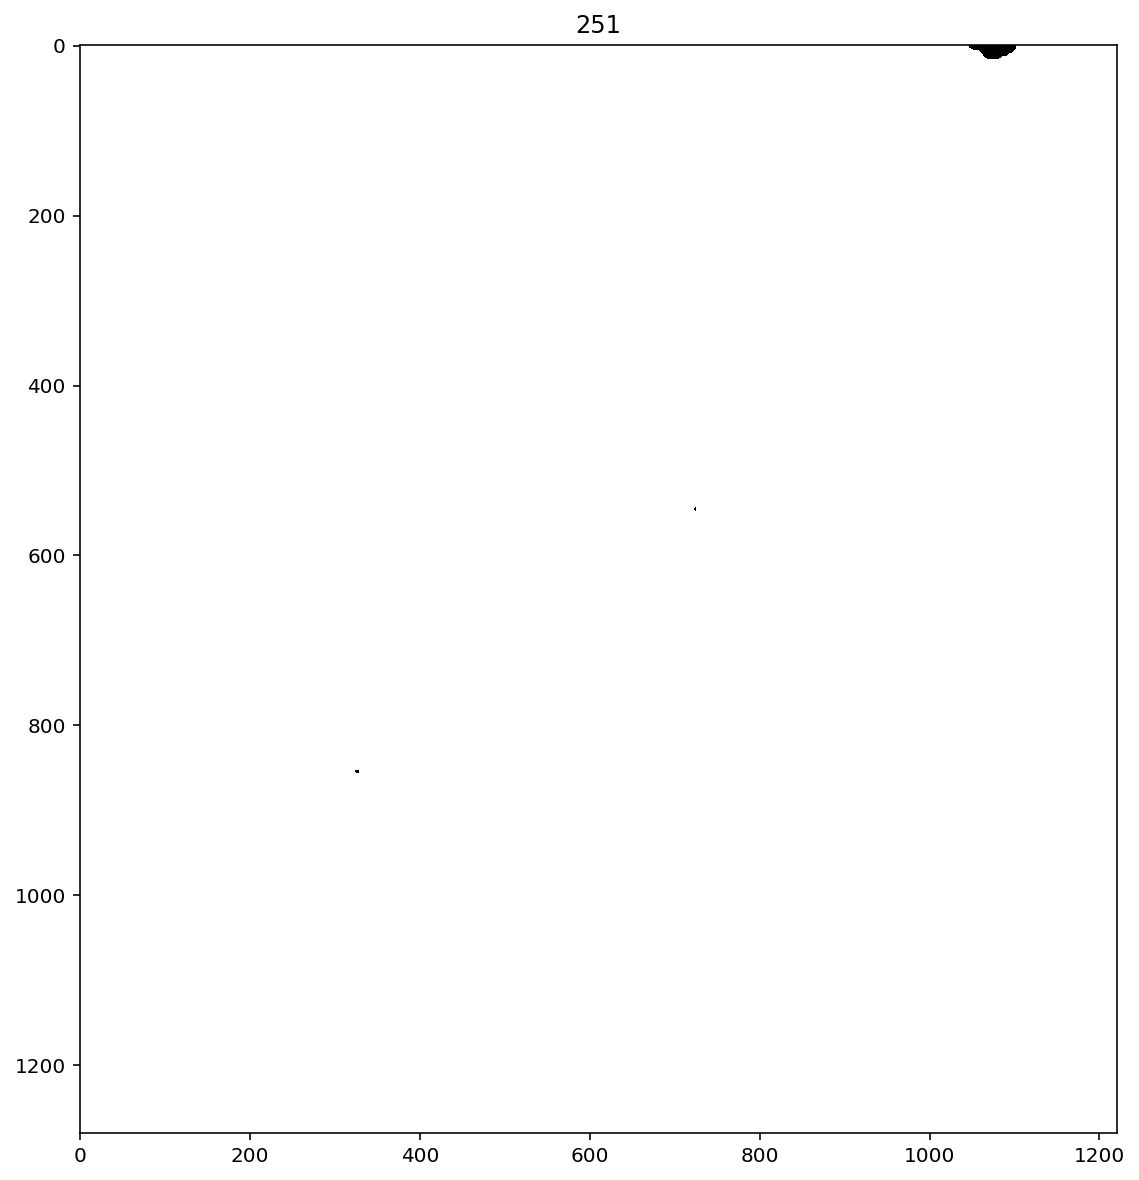

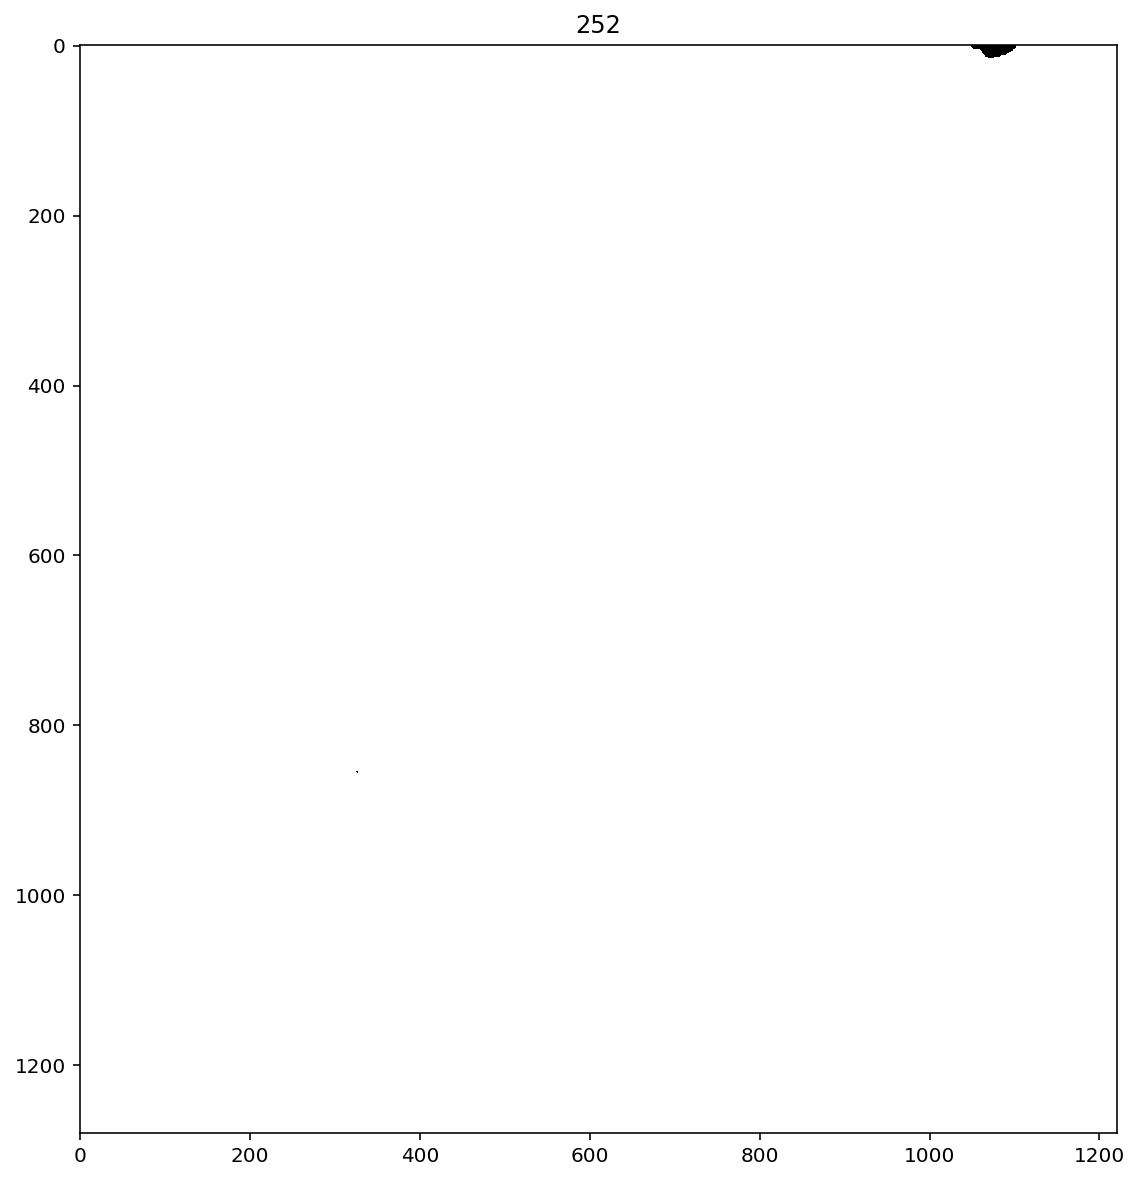

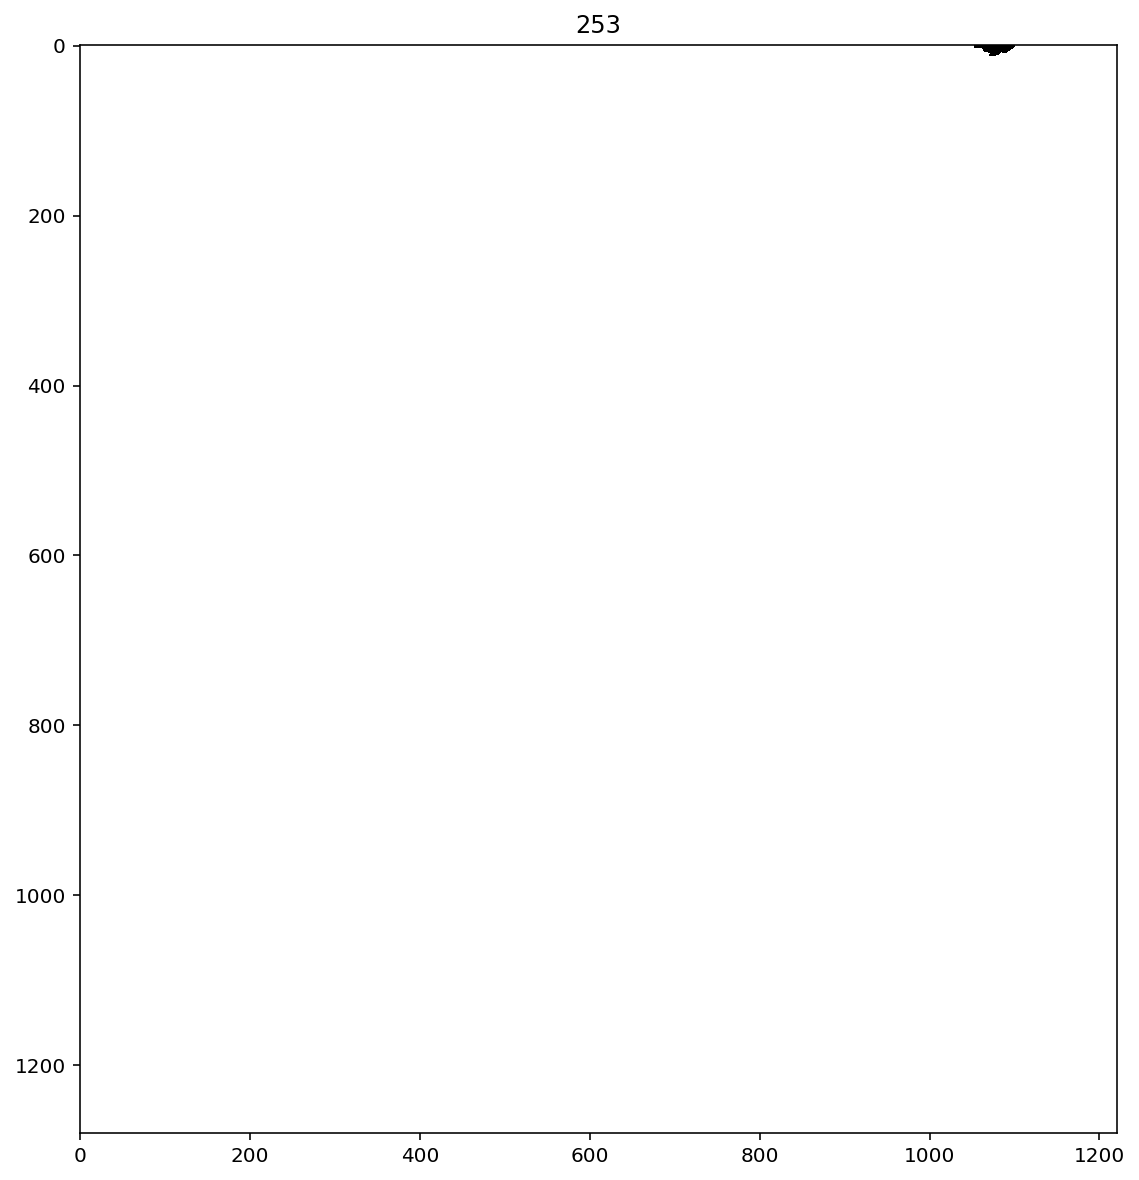

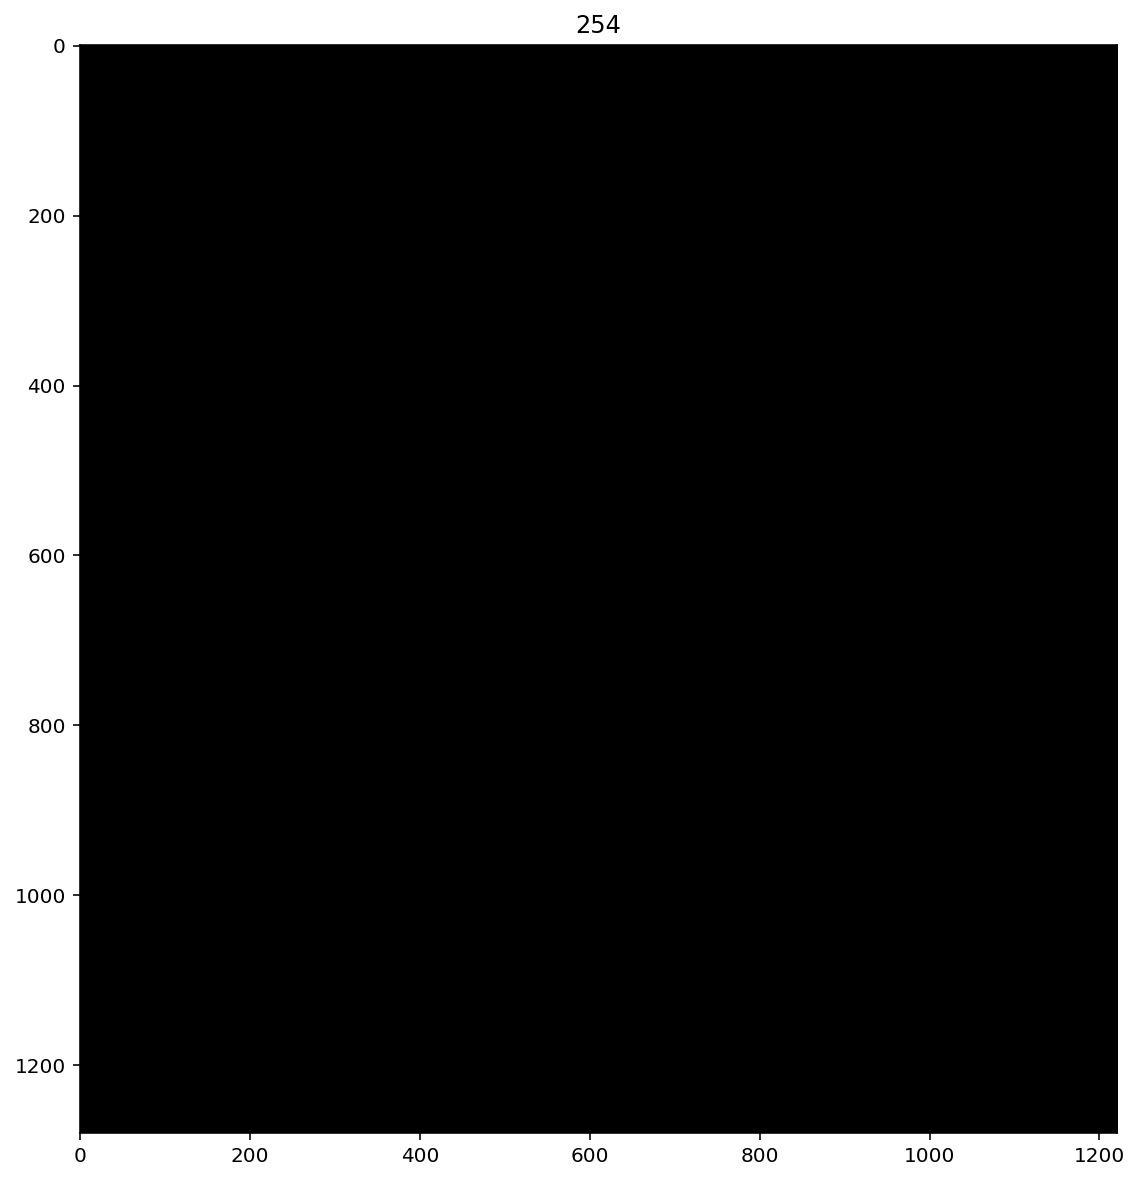

In [156]:
coin = cv2.imread("img/eva.jpeg")
coin_g = cv2.imread("img/eva.jpeg",0)


gaussian = cv2.GaussianBlur(coin_g,(7,7),-1)

#thres_binary_inverted = cv2.adaptiveThreshold(gaussian, 250,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY_INV,199,32)
for i in range(255):
    ret2, thres_binary_inverted = cv2.threshold(gaussian,i,255,cv2.THRESH_BINARY_INV)
    _,coin_contorns,_ = cv2.findContours( thres_binary_inverted, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    showGrayScaleImg(thres_binary_inverted, i )


sorted_contours = sorted(coin_contorns, key=cv2.contourArea ,reverse=True)#bugged


print(len(sorted_contours))